## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as GraphDataLoader
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import GCNConv, Sequential as GraphSequential
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics
from rdkit import Chem
import matplotlib.pyplot as plt
from tqdm import tqdm

## 2. Load data 📊

In [2]:
df_train = pd.read_csv("../../data/train/solubility/solub_smiles_train.csv")
df_test = pd.read_csv("../../data/train/solubility/solub_smiles_test.csv")
df_valid = pd.read_csv("../../data/train/solubility/solub_smiles_valid.csv")
df_train_all = pd.concat([df_train, df_valid])

In [3]:
df_test

,smiles,solubility
0,Cc1ncc(-c2nc(Nc3ccc(C(=O)NC4CCN(C)CC4)c(F)c3)n...,3.560036
1,NC1(c2ccc(-c3c(-c4ccccc4)ccn4ccnc34)cc2)CCC1,3.260032
2,O=C(CO)N1CCCC1COc1cccc2ncnc(Nc3ccc(OCc4ccccn4)...,5.721246
3,Cc1cc(C)cc(-c2[nH]c3sc(C(C)(C)C(=O)N4C5CCC4CC5...,4.000000
4,O=c1[nH]c2c(O)ccc(C(O)CNCCc3cccc(CNCCc4ccccc4C...,3.929962
...,...,...
348,O=C1CN2Cc3c(ccc(Cl)c3Cl)N=C2N1,5.267606
349,COc1cc(N2CCN(C(C)=O)CC2)ccc1Nc1ncc(Cl)c(-c2cnc...,5.552842
350,COc1cc2ncnc(Nc3cc(NC(=O)c4ccnc(N5CCOCC5)c4)ccc...,4.179799
351,O=c1oc2ccccc2c(O)c1Cc1c(O)c2ccccc2oc1=O,4.070070


In [4]:
df_valid

,smiles,solubility
0,OCC1CC(n2nnc3c(NC4CC4c4ccc(F)c(F)c4)nc(SCCC(F)...,5.142668
1,Cc1ncc2n1-c1ccc(Cl)cc1C(c1ccccc1F)=NC2,4.140261
2,CC(C)N1CCN(Cc2cnc(-c3ccc(C(=O)Nc4ccccc4N)cc3)c...,2.869988
3,CC(C)CNc1nc(C#N)nc(N2CCOCC2)c1N,4.149967
4,CCN1N=C(c2ccccc2)Cn2c1nc1ccccc12,5.161151
...,...,...
171,COc1cc(N2CCN(C(C)=O)CC2)ccc1Nc1ncc(C(F)(F)F)c(...,5.050610
172,COc1cc(C(=O)O)ccc1Cc1cn(C)c2ccc(NC(=O)CC3CCCC3...,3.730020
173,CC(O)C(=O)N1CC=C(c2c(F)cc(N3CC(COc4ccon4)OC3=O...,4.600326
174,CN(CCOc1ccccc1-c1cc(C(N)=O)c(NC(N)=O)s1)Cc1ccccc1,5.823909


## 3. Metrics

In [5]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 4. Featurizer 🧪

In [6]:
# Feauterizer from course "Machine Learning in Drug Design" at Jagiellonian University, Kraków, Poland.

class Featurizer:
    def __init__(self, y_column, **kwargs):
        self.y_column = y_column
        self.__dict__.update(kwargs)
    
    def __call__(self, df):
        raise NotImplementedError()

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise ValueError("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
        

class GraphFeaturizer(Featurizer):
    def __call__(self, df):
        graphs = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row.smiles
            mol = Chem.MolFromSmiles(smiles)
            
            edges = []
            for bond in mol.GetBonds():
                edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
                edges.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()])
            edges = np.array(edges)
            
            nodes = []
            for atom in mol.GetAtoms():
                results = one_of_k_encoding_unk(
                    atom.GetSymbol(),
                    [
                        'Br', 'C', 'Cl', 'F', 'H', 'I', 'N', 'O', 'P', 'S', 'Unknown'
                    ]
                ) + one_of_k_encoding(
                    atom.GetDegree(),
                    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
                ) + one_of_k_encoding_unk(
                    atom.GetImplicitValence(),
                    [0, 1, 2, 3, 4, 5, 6]
                ) + [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + one_of_k_encoding_unk(
                    atom.GetHybridization(),
                    [
                        Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                        Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                        Chem.rdchem.HybridizationType.SP3D2
                    ]
                ) + [atom.GetIsAromatic()] + one_of_k_encoding_unk(
                    atom.GetTotalNumHs(),
                    [0, 1, 2, 3, 4]
                )
                nodes.append(results)
            nodes = np.array(nodes)
            
            graphs.append((nodes, edges.T))
            labels.append(y)
        labels = np.array(labels)
        return graphs, labels

## 5. Graph Dataset

In [7]:
class GraphDataset(InMemoryDataset):  
    def __init__(self, X, y, root, transform=None, pre_transform=None):
        self.dataset = (X, y)
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['data.pt']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        x_g, edge_index_g =list(zip(*self.dataset[0]))

        data = [Data(
            x=torch.FloatTensor(x),
            edge_index=torch.LongTensor(edge_index),
            y = y) for x, edge_index, y in zip(x_g,edge_index_g,self.dataset[1])
        ]

        torch.save(data, self.raw_paths[0])


    def process(self):
        data_list = torch.load(self.raw_paths[0])

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
        


In [8]:
featurizer = GraphFeaturizer(y_column='solubility')

X_train, y_train = featurizer(df_train)
X_test, y_test = featurizer(df_test)
X_valid, y_valid = featurizer(df_valid)
X_train_all, y_train_all = featurizer(df_train_all)

In [9]:
train_dataset = GraphDataset(X_train_all, y_train_all.reshape(-1, 1), root='solub-train')
test_dataset = GraphDataset(X_test, y_test.reshape(-1, 1), root='solub-test')
valid_dataset = GraphDataset(X_valid, y_valid.reshape(-1, 1), root='solub-valid')
train_dataset_small = GraphDataset(X_train, y_train.reshape(-1, 1), root='solub-train_small')

Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


# 6. Model

![Graph](images/graph_net.png)

In [10]:
class GraphNeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(GraphNeuralNetwork, self).__init__()
        torch.manual_seed(42)
        self.final_conv_acts = None
        self.final_conv_grads = None

        self.conv1 = GCNConv(42, 100)
        self.conv2 = GCNConv(100, 400)
        self.conv3 = GCNConv(400, 200)
        self.conv4 = GCNConv(200, 100)

        self.out = nn.Linear(100, 50)
        self.out2 = nn.Linear(50, 1)
    
    def activations_hook(self, grad):
        self.final_conv_grads = grad

    def forward(self, x, edge_index, batch_index):
        out = self.conv1(x, edge_index)
        out = F.relu(out)
        out = self.conv2(out, edge_index)
        out = F.relu(out)
        out = self.conv3(out, edge_index)
        out = F.relu(out)
        out = F.dropout(out, training=self.training) #p=0.5
        
        with torch.enable_grad():
            self.final_conv_acts = self.conv4(out, edge_index)
        self.final_conv_acts.register_hook(self.activations_hook)
        
        out = F.relu(self.final_conv_acts)
        out = gap(out, batch_index) # global_mean_pool
        out = self.out(out)
        out = F.relu(out)
        out = self.out2(out)

        return out

## 6.1 Grid search 🔎

In [11]:
lrs = [0.005, 0.01, 0.02]
batch_sizes = [32, 64, 128]

In [12]:
best_value = 1
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:

        model = GraphNeuralNetwork()

        train_loader = GraphDataLoader(train_dataset_small, batch_size=batch_size, shuffle=False)
        valid_loader = GraphDataLoader(valid_dataset, batch_size=176, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []

        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0

            for data in tqdm(train_loader, leave=False):
                x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
                optimizer.zero_grad()
                output = model(x, edge_index, batch)
                loss = criterion(output, torch.Tensor(y))
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(y, output.cpu().detach().numpy())   

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0    

            with torch.no_grad():
                for data in tqdm(valid_loader):
                    x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
                    output = model(x, edge_index, batch)
                    test_loss += criterion(output, torch.Tensor(y)).item()
                    test_correct += metrics.r2_score(y, output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

  5%|▌         | 2/39 [00:00<00:02, 13.06it/s]

Model: lr 0.005, batch_size 32
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 4.7895555312816915, Accuracy: -4.214029946876859


  5%|▌         | 2/39 [00:00<00:02, 16.60it/s]

Test Avg. loss: 1.038407325744629, Accuracy: -0.28651976406975743
################## EPOCH 2 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 1.0392724122756567, Accuracy: -0.14407517607779183
Test Avg. loss: 0.84381502866745, Accuracy: -0.04543255921752909
################## EPOCH 3 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.962402819058834, Accuracy: -0.05279302011119494
Test Avg. loss: 0.799190878868103, Accuracy: 0.009853922157784023
################## EPOCH 4 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9577573767075171, Accuracy: -0.04575277413165962
Test Avg. loss: 0.8003135919570923, Accuracy: 0.00846302975616453
################## EPOCH 5 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9663105194385235, Accuracy: -0.05851436112533598
Test Avg. loss: 0.8137703537940979, Accuracy: -0.008209118088859935
################## EPOCH 6 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9738318476921473, Accuracy: -0.06763549691876822
Test Avg. loss: 0.8029596209526062, Accuracy: 0.005184685232752728
################## EPOCH 7 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9732919335365295, Accuracy: -0.06874180631978975
Test Avg. loss: 0.8029251098632812, Accuracy: 0.005227491709309584
################## EPOCH 8 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9544855019985101, Accuracy: -0.04883055228882798
Test Avg. loss: 0.8138231039047241, Accuracy: -0.008274463001397336
################## EPOCH 9 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9779757964305389, Accuracy: -0.07293821673232874
Test Avg. loss: 0.8156022429466248, Accuracy: -0.010478583122354612
################## EPOCH 10 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9740766470248883, Accuracy: -0.07162101174273493
Test Avg. loss: 0.8159042596817017, Accuracy: -0.01085281555570572
################## EPOCH 11 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9581253757843604, Accuracy: -0.052714569378470154
Test Avg. loss: 0.8051311373710632, Accuracy: 0.0024944064814078626
################## EPOCH 12 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9676068088947198, Accuracy: -0.0641953730368706
Test Avg. loss: 0.8015288710594177, Accuracy: 0.006957358910658851
################## EPOCH 13 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9414365154046279, Accuracy: -0.03494217631279771
Test Avg. loss: 0.7952604293823242, Accuracy: 0.014723450972161878
################## EPOCH 14 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9767302641501794, Accuracy: -0.07078713090943535
Test Avg. loss: 0.7938116192817688, Accuracy: 0.016518464404437272
################## EPOCH 15 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.96165564427009, Accuracy: -0.05493606000508403
Test Avg. loss: 0.7924336791038513, Accuracy: 0.018225755505624663
################## EPOCH 16 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9547086747793051, Accuracy: -0.04521140615479323
Test Avg. loss: 0.787219762802124, Accuracy: 0.02468545501746333
################## EPOCH 17 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.936524218473679, Accuracy: -0.02902644608593997
Test Avg. loss: 0.7971248030662537, Accuracy: 0.012413683728956793
################## EPOCH 18 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9364968217336215, Accuracy: -0.02683716675922436
Test Avg. loss: 0.7858408093452454, Accuracy: 0.02639377527281417
################## EPOCH 19 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.918248311831401, Accuracy: -0.0073921016047052476
Test Avg. loss: 0.7771152853965759, Accuracy: 0.037204126357684775
################## EPOCH 20 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9045787102136856, Accuracy: 0.005393930216887806
Test Avg. loss: 0.7850969433784485, Accuracy: 0.027315438210478105
################## EPOCH 21 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9466473842278506, Accuracy: -0.03297902303715022
Test Avg. loss: 0.7809857726097107, Accuracy: 0.03240895956896728
################## EPOCH 22 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8846601736851227, Accuracy: 0.028372558290393243
Test Avg. loss: 0.7845271825790405, Accuracy: 0.028021303657175145
################## EPOCH 23 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.899878271879294, Accuracy: 0.012181453495035686
Test Avg. loss: 0.7915756702423096, Accuracy: 0.019288698071555088
################## EPOCH 24 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9012545576462379, Accuracy: 0.012029850180889753
Test Avg. loss: 0.7845407128334045, Accuracy: 0.02800457528612521
################## EPOCH 25 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8586202363173167, Accuracy: 0.06045902594812532
Test Avg. loss: 0.7828217148780823, Accuracy: 0.03013422976036917
################## EPOCH 26 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8649366199970245, Accuracy: 0.05136690410240512
Test Avg. loss: 0.7802463173866272, Accuracy: 0.0333250495499019
################## EPOCH 27 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8829550483287909, Accuracy: 0.032041628423263774
Test Avg. loss: 0.7853685617446899, Accuracy: 0.026978916114506535
################## EPOCH 28 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8638219344310272, Accuracy: 0.05019142233935675
Test Avg. loss: 0.7857859134674072, Accuracy: 0.02646181098654543
################## EPOCH 29 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.903225716872093, Accuracy: 0.014411608688007015
Test Avg. loss: 0.794075071811676, Accuracy: 0.01619207090988073
################## EPOCH 30 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8318108855149685, Accuracy: 0.08911229467009663
Test Avg. loss: 0.7948583364486694, Accuracy: 0.0152217688484374
################## EPOCH 31 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8202682901651431, Accuracy: 0.1004585630326432
Test Avg. loss: 0.8029228448867798, Accuracy: 0.005230338554274572
################## EPOCH 32 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8232493568689395, Accuracy: 0.09406908260631454
Test Avg. loss: 0.8066167831420898, Accuracy: 0.0006536480758384533
################## EPOCH 33 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8234393023527585, Accuracy: 0.09800203906799304
Test Avg. loss: 0.7951682806015015, Accuracy: 0.014837670616729026
################## EPOCH 34 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8108862080635169, Accuracy: 0.11117297223554704
Test Avg. loss: 0.8253771066665649, Accuracy: -0.022589089462151657
################## EPOCH 35 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8048016833953369, Accuracy: 0.11575648724706691
Test Avg. loss: 0.820320725440979, Accuracy: -0.016324550136044502
################## EPOCH 36 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8121987084547678, Accuracy: 0.1091833845600188
Test Avg. loss: 0.8239900469779968, Accuracy: -0.020870618867888657
################## EPOCH 37 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7914230082279596, Accuracy: 0.13014725046760386
Test Avg. loss: 0.8438922762870789, Accuracy: -0.045528240798604624
################## EPOCH 38 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8041105186327909, Accuracy: 0.11834553094525233
Test Avg. loss: 0.8506001830101013, Accuracy: -0.053838837575679976
################## EPOCH 39 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7763981276597732, Accuracy: 0.14908470875521898
Test Avg. loss: 0.8543649315834045, Accuracy: -0.05850302585001654
################## EPOCH 40 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7943835441882794, Accuracy: 0.13087682316440505
Test Avg. loss: 0.8826301097869873, Accuracy: -0.09352193772015926
################## EPOCH 41 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7888174385596545, Accuracy: 0.13524773413230676
Test Avg. loss: 0.8891158699989319, Accuracy: -0.10155745050217058
################## EPOCH 42 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7932572945570334, Accuracy: 0.12918593549701143
Test Avg. loss: 0.8919742107391357, Accuracy: -0.10509867923237115
################## EPOCH 43 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7770736599579836, Accuracy: 0.14736177228089087
Test Avg. loss: 0.9068698883056641, Accuracy: -0.12355341612579518
################## EPOCH 44 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7984109979409438, Accuracy: 0.1264985579502864
Test Avg. loss: 0.9221199154853821, Accuracy: -0.14244727570321447
################## EPOCH 45 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7895874350498884, Accuracy: 0.138516572636347
Test Avg. loss: 0.9198131561279297, Accuracy: -0.13958939387622538
################## EPOCH 46 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7829853395620981, Accuracy: 0.14380987424721495
Test Avg. loss: 0.9383555054664612, Accuracy: -0.16256216051386163
################## EPOCH 47 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7663467954366635, Accuracy: 0.16131469694538964
Test Avg. loss: 0.9135477542877197, Accuracy: -0.13182691223499843
################## EPOCH 48 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7977307492341751, Accuracy: 0.12499660794543005
Test Avg. loss: 0.9232798218727112, Accuracy: -0.14388431215338282
################## EPOCH 49 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7666457295417786, Accuracy: 0.1606248002908945
Test Avg. loss: 0.8915237188339233, Accuracy: -0.10454053838433741
################## EPOCH 50 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7428500957978077, Accuracy: 0.18723971426999753
Test Avg. loss: 0.8714719414710999, Accuracy: -0.07969774277258668
################## EPOCH 51 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7571891607382358, Accuracy: 0.16891670773287507
Test Avg. loss: 0.844713032245636, Accuracy: -0.046545028348678574
################## EPOCH 52 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7503946629854349, Accuracy: 0.17821484694541798
Test Avg. loss: 0.8501301407814026, Accuracy: -0.05325659004974703
################## EPOCH 53 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7237936991911668, Accuracy: 0.2056727854028974
Test Avg. loss: 0.8523128628730774, Accuracy: -0.055960736200751704
################## EPOCH 54 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7374668327661661, Accuracy: 0.19371585797450605
Test Avg. loss: 0.8975828289985657, Accuracy: -0.11204745320996934
################## EPOCH 55 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7234176955161951, Accuracy: 0.20620966458674353
Test Avg. loss: 0.8410500884056091, Accuracy: -0.04200690416387021
################## EPOCH 56 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7179091221246964, Accuracy: 0.2144977994396261
Test Avg. loss: 0.8508725762367249, Accuracy: -0.05417624966396195
################## EPOCH 57 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7040380529868298, Accuracy: 0.22845324877639092
Test Avg. loss: 0.8177453875541687, Accuracy: -0.0131339260411234
################## EPOCH 58 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7164420890502441, Accuracy: 0.2150847052061824
Test Avg. loss: 0.807028591632843, Accuracy: 0.0001434716317386675
################## EPOCH 59 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6980057389308245, Accuracy: 0.2377674168022156
Test Avg. loss: 0.81296306848526, Accuracy: -0.007208933147260677
################## EPOCH 60 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7057002179133587, Accuracy: 0.22703968434070257
Test Avg. loss: 0.8163204193115234, Accuracy: -0.011368357066967372
################## EPOCH 61 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6803157398333917, Accuracy: 0.2548899952085977
Test Avg. loss: 0.7967004179954529, Accuracy: 0.012939460157164073
################## EPOCH 62 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6807188804333026, Accuracy: 0.25391907762444366
Test Avg. loss: 0.8014301061630249, Accuracy: 0.007079618703502155
################## EPOCH 63 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.683979094792635, Accuracy: 0.24940111443866905
Test Avg. loss: 0.7809411883354187, Accuracy: 0.0324640826477679
################## EPOCH 64 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6733252834051083, Accuracy: 0.2622005914131008
Test Avg. loss: 0.7655780911445618, Accuracy: 0.05149801519128738
################## EPOCH 65 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6668911262964591, Accuracy: 0.27035392608111325
Test Avg. loss: 0.7822803854942322, Accuracy: 0.030804850104530823
################## EPOCH 66 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6564020552696326, Accuracy: 0.28032607919290103
Test Avg. loss: 0.7900857329368591, Accuracy: 0.021134779199576292
################## EPOCH 67 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.671065343496127, Accuracy: 0.2684438667393043
Test Avg. loss: 0.8116586208343506, Accuracy: -0.0055927231100383334
################## EPOCH 68 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6583997377982507, Accuracy: 0.2811556578935258
Test Avg. loss: 0.7987273931503296, Accuracy: 0.010428154976106607
################## EPOCH 69 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6396682254779034, Accuracy: 0.29932484885461236
Test Avg. loss: 0.8058249950408936, Accuracy: 0.0016346641538036444
################## EPOCH 70 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6379279509568826, Accuracy: 0.30118627434676126
Test Avg. loss: 0.8041859269142151, Accuracy: 0.003665332832730739
################## EPOCH 71 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.637562890847524, Accuracy: 0.3041111234160433
Test Avg. loss: 0.819183886051178, Accuracy: -0.014916115378321715
################## EPOCH 72 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6346040902993618, Accuracy: 0.3079630501632821
Test Avg. loss: 0.7720203995704651, Accuracy: 0.04351636048040719
################## EPOCH 73 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6427874603332617, Accuracy: 0.2939122748285731
Test Avg. loss: 0.7908778786659241, Accuracy: 0.020153328646560498
################## EPOCH 74 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6165724129248888, Accuracy: 0.32461337219066727
Test Avg. loss: 0.809980571269989, Accuracy: -0.0035137800475446568
################## EPOCH 75 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6238945760788062, Accuracy: 0.31540128083048097
Test Avg. loss: 0.8033937811851501, Accuracy: 0.004646721224012551
################## EPOCH 76 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6232963884488131, Accuracy: 0.31684067176861186
Test Avg. loss: 0.7597610950469971, Accuracy: 0.05870495431475742
################## EPOCH 77 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6276847231082427, Accuracy: 0.31404056973427974
Test Avg. loss: 0.7759566903114319, Accuracy: 0.038639535056113616
################## EPOCH 78 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6114030579725901, Accuracy: 0.3310608572706907
Test Avg. loss: 0.7621591687202454, Accuracy: 0.05573386054155216
################## EPOCH 79 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6031611936214643, Accuracy: 0.3401470213486695
Test Avg. loss: 0.7575355768203735, Accuracy: 0.061462058269357356
################## EPOCH 80 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6163130555397425, Accuracy: 0.32578076543600415
Test Avg. loss: 0.7484023571014404, Accuracy: 0.07277777158137588
################## EPOCH 81 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5990188580292922, Accuracy: 0.3447725647815163
Test Avg. loss: 0.7388778924942017, Accuracy: 0.0845777260416738
################## EPOCH 82 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6092920670142541, Accuracy: 0.3304232848791188
Test Avg. loss: 0.7379066348075867, Accuracy: 0.08578122761403217
################## EPOCH 83 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5896029059703534, Accuracy: 0.3568370812560382
Test Avg. loss: 0.7804138660430908, Accuracy: 0.033117416988009185
################## EPOCH 84 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5860801537831625, Accuracy: 0.35864039810158127
Test Avg. loss: 0.7433522939682007, Accuracy: 0.07903432695606827
################## EPOCH 85 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5979711237626198, Accuracy: 0.346403739748471
Test Avg. loss: 0.7325111031532288, Accuracy: 0.09246589758224788
################## EPOCH 86 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.565621975904856, Accuracy: 0.37910666034580426
Test Avg. loss: 0.7287479043006897, Accuracy: 0.09712827044240824
################## EPOCH 87 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5543828988686587, Accuracy: 0.39124064112698126
Test Avg. loss: 0.7505888342857361, Accuracy: 0.07006871086759281
################## EPOCH 88 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5522522146885211, Accuracy: 0.3937693440642918
Test Avg. loss: 0.7451905608177185, Accuracy: 0.07675680280468944
################## EPOCH 89 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5502736262786083, Accuracy: 0.3937129922321794
Test Avg. loss: 0.7436115145683289, Accuracy: 0.07871322394037106
################## EPOCH 90 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5805848905673394, Accuracy: 0.36275224717213017
Test Avg. loss: 0.7622646689414978, Accuracy: 0.05560313882202683
################## EPOCH 91 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5783852140108744, Accuracy: 0.36787234154500315
Test Avg. loss: 0.7565343976020813, Accuracy: 0.06270252512331032
################## EPOCH 92 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5577448201485169, Accuracy: 0.3872219731586268
Test Avg. loss: 0.6889084577560425, Accuracy: 0.14648678104246748
################## EPOCH 93 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5369496368444883, Accuracy: 0.4119139522735873
Test Avg. loss: 0.7338270545005798, Accuracy: 0.09083540219490005
################## EPOCH 94 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5279285647930243, Accuracy: 0.41812202205065024
Test Avg. loss: 0.7114256024360657, Accuracy: 0.11858949080505576
################## EPOCH 95 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5241985825391916, Accuracy: 0.42344816782629086
Test Avg. loss: 0.7467653751373291, Accuracy: 0.0748056986166249
################## EPOCH 96 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5377341019801605, Accuracy: 0.4088618804490628
Test Avg. loss: 0.7269253134727478, Accuracy: 0.09938630004418525
################## EPOCH 97 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5239417751630148, Accuracy: 0.4208939468802373
Test Avg. loss: 0.7254164814949036, Accuracy: 0.10125560097446973
################## EPOCH 98 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.537248433400423, Accuracy: 0.4073066032693108
Test Avg. loss: 0.7183523774147034, Accuracy: 0.11000754573811655
################## EPOCH 99 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5220334155437274, Accuracy: 0.4248008893633353
Test Avg. loss: 0.7158674597740173, Accuracy: 0.11308626484540818
################## EPOCH 100 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5200077562760084, Accuracy: 0.4244816386133839
Test Avg. loss: 0.7226825952529907, Accuracy: 0.10464266311629444
################## EPOCH 101 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5234191173162216, Accuracy: 0.4216060698515845
Test Avg. loss: 0.7161678075790405, Accuracy: 0.11271411777985729
################## EPOCH 102 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5537598759700091, Accuracy: 0.3929895829168745
Test Avg. loss: 0.6877590417861938, Accuracy: 0.1479108247930888
################## EPOCH 103 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5499704908101987, Accuracy: 0.39353858938713987
Test Avg. loss: 0.7137017250061035, Accuracy: 0.11576943557165842
################## EPOCH 104 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5165118834911249, Accuracy: 0.4296621878818846
Test Avg. loss: 0.6911788582801819, Accuracy: 0.1436738433698359
################## EPOCH 105 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5146436446752304, Accuracy: 0.4291541833714267
Test Avg. loss: 0.7543054819107056, Accuracy: 0.06546393065597478
################## EPOCH 106 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5085408179423748, Accuracy: 0.43909393988066425
Test Avg. loss: 0.7063210010528564, Accuracy: 0.12491373494663305
################## EPOCH 107 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4967903311435993, Accuracy: 0.44938575780946677
Test Avg. loss: 0.7315439581871033, Accuracy: 0.09366407650587816
################## EPOCH 108 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5048500016713754, Accuracy: 0.4437659708756597
Test Avg. loss: 0.7239620685577393, Accuracy: 0.10305761393283674
################## EPOCH 109 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5154452285705469, Accuracy: 0.43424576093184586
Test Avg. loss: 0.7188499569892883, Accuracy: 0.10939114609595768
################## EPOCH 110 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.49047874067074215, Accuracy: 0.46024402130453895
Test Avg. loss: 0.7485069632530212, Accuracy: 0.07264804805570713
################## EPOCH 111 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4738991222320459, Accuracy: 0.4755417357109084
Test Avg. loss: 0.7622162103652954, Accuracy: 0.05566310652727802
################## EPOCH 112 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4779425186988635, Accuracy: 0.4721076341346026
Test Avg. loss: 0.7736892700195312, Accuracy: 0.04144879105129673
################## EPOCH 113 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.48248392725602174, Accuracy: 0.46579466106965794
Test Avg. loss: 0.7517398595809937, Accuracy: 0.06864273307549007
################## EPOCH 114 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.47131002484223783, Accuracy: 0.47722992427090305
Test Avg. loss: 0.7613860964775085, Accuracy: 0.05669167389620322
################## EPOCH 115 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4697461602015373, Accuracy: 0.4805913748357087
Test Avg. loss: 0.7464644908905029, Accuracy: 0.07517851736494918
################## EPOCH 116 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.46708224408137494, Accuracy: 0.47969497421253277
Test Avg. loss: 0.7458882927894592, Accuracy: 0.07589246334056865
################## EPOCH 117 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.47155676285425824, Accuracy: 0.47794778925568066
Test Avg. loss: 0.7507400512695312, Accuracy: 0.06988135014090802
################## EPOCH 118 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4890993382686224, Accuracy: 0.4546936706503047
Test Avg. loss: 0.7919889092445374, Accuracy: 0.018776657189103152
################## EPOCH 119 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.45456282527018815, Accuracy: 0.49626322815375307
Test Avg. loss: 0.7974874377250671, Accuracy: 0.011964395955792462
################## EPOCH 120 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.45639888330911976, Accuracy: 0.49475157601055403
Test Avg. loss: 0.7326002717018127, Accuracy: 0.09235535263458083
################## EPOCH 121 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.47480473686487246, Accuracy: 0.4732071529749127
Test Avg. loss: 0.7375532388687134, Accuracy: 0.08621898275091766
################## EPOCH 122 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.48186650222692734, Accuracy: 0.4679912523545448
Test Avg. loss: 0.7297452688217163, Accuracy: 0.09589253015479593
################## EPOCH 123 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4656296842373334, Accuracy: 0.48491176139839964
Test Avg. loss: 0.7097168564796448, Accuracy: 0.12070647520152877
################## EPOCH 124 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.44643490436749583, Accuracy: 0.5048937159278593
Test Avg. loss: 0.7445840239524841, Accuracy: 0.07750831494236843
################## EPOCH 125 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.47231477651840603, Accuracy: 0.4768237972025637
Test Avg. loss: 0.7327304482460022, Accuracy: 0.09219411650962162
################## EPOCH 126 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4457714924445519, Accuracy: 0.5013389008373286
Test Avg. loss: 0.7394256591796875, Accuracy: 0.08389914273531951
################## EPOCH 127 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.46068530319592893, Accuracy: 0.4880830682518565
Test Avg. loss: 0.7561540603637695, Accuracy: 0.06317373411972815
################## EPOCH 128 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4304547653748439, Accuracy: 0.5187608236903853
Test Avg. loss: 0.7316354513168335, Accuracy: 0.09355067345112489
################## EPOCH 129 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4258488340255542, Accuracy: 0.5247936008171976
Test Avg. loss: 0.7454086542129517, Accuracy: 0.07648657324358854
################## EPOCH 130 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.41867753519461703, Accuracy: 0.5336723020914551
Test Avg. loss: 0.7786670923233032, Accuracy: 0.03528150471246305
################## EPOCH 131 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4075248153545918, Accuracy: 0.5434970198642437
Test Avg. loss: 0.8269598484039307, Accuracy: -0.02455019034640693
################## EPOCH 132 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4223766605823468, Accuracy: 0.5304460595467212
Test Avg. loss: 0.8063690662384033, Accuracy: 0.0009605647272608042
################## EPOCH 133 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.41186231412948704, Accuracy: 0.5401344086282506
Test Avg. loss: 0.8363221883773804, Accuracy: -0.03614933039690249
################## EPOCH 134 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.39218103083280415, Accuracy: 0.560561907655395
Test Avg. loss: 0.7860139608383179, Accuracy: 0.02617928804002012
################## EPOCH 135 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.39421182794448656, Accuracy: 0.5587798902106731
Test Avg. loss: 0.7444124817848206, Accuracy: 0.0777207925392136
################## EPOCH 136 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.39048067461221647, Accuracy: 0.5627349744360658
Test Avg. loss: 0.7639449834823608, Accuracy: 0.0535212182998559
################## EPOCH 137 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.411104373442821, Accuracy: 0.5432753202381119
Test Avg. loss: 0.7806276082992554, Accuracy: 0.03285258469610863
################## EPOCH 138 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3936649786356168, Accuracy: 0.559348938828087
Test Avg. loss: 0.787422239780426, Accuracy: 0.024434430554426068
################## EPOCH 139 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.381025445384857, Accuracy: 0.5767979700801739
Test Avg. loss: 0.791001558303833, Accuracy: 0.01999988332029634
################## EPOCH 140 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3861287324092327, Accuracy: 0.5688182279736791
Test Avg. loss: 0.7604208588600159, Accuracy: 0.057887347707311965
################## EPOCH 141 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3912755377017535, Accuracy: 0.5623321357683595
Test Avg. loss: 0.796883761882782, Accuracy: 0.012712377578993572
################## EPOCH 142 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3925776401391396, Accuracy: 0.5612936409669874
Test Avg. loss: 0.7364893555641174, Accuracy: 0.08753698420528777
################## EPOCH 143 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.38475075707985806, Accuracy: 0.5703889438995634
Test Avg. loss: 0.7806901931762695, Accuracy: 0.03277505461491548
################## EPOCH 144 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.37187912792731553, Accuracy: 0.5880161366290074
Test Avg. loss: 0.7558354735374451, Accuracy: 0.06356851278114317
################## EPOCH 145 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.36106044130447584, Accuracy: 0.5957235775481171
Test Avg. loss: 0.8206109404563904, Accuracy: -0.01668413755564324
################## EPOCH 146 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3802767988198843, Accuracy: 0.5737045911998215
Test Avg. loss: 0.8331041932106018, Accuracy: -0.032162544969303486
################## EPOCH 147 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.38356196192594677, Accuracy: 0.5738073122786358
Test Avg. loss: 0.6991796493530273, Accuracy: 0.1337614258645481
################## EPOCH 148 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.37228272473200774, Accuracy: 0.5866410749659425
Test Avg. loss: 0.7590486407279968, Accuracy: 0.059587618649850405
################## EPOCH 149 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3520196110774309, Accuracy: 0.6055477103594157
Test Avg. loss: 0.8434890508651733, Accuracy: -0.04502865818972146
################## EPOCH 150 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3778417886067659, Accuracy: 0.5784859337770603
Test Avg. loss: 0.7904074192047119, Accuracy: 0.020736029031127368
################## EPOCH 151 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.37860222199024296, Accuracy: 0.5774842415871075
Test Avg. loss: 0.7481736540794373, Accuracy: 0.07306101481356853
################## EPOCH 152 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.36752824867383027, Accuracy: 0.5902164547849641
Test Avg. loss: 0.7599976062774658, Accuracy: 0.05841176915167201
################## EPOCH 153 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3590282106246704, Accuracy: 0.598885075009856
Test Avg. loss: 0.8084527850151062, Accuracy: -0.0016209034833116753
################## EPOCH 154 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3602795803394073, Accuracy: 0.6011988974715979
Test Avg. loss: 0.7722349762916565, Accuracy: 0.043250514233818205
################## EPOCH 155 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.35141353423778826, Accuracy: 0.6079330964843449
Test Avg. loss: 0.8206678628921509, Accuracy: -0.016754697258992923
################## EPOCH 156 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3545867594388815, Accuracy: 0.6035124539386651
Test Avg. loss: 0.8294253945350647, Accuracy: -0.02760463435346172
################## EPOCH 157 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3508973782643294, Accuracy: 0.6076372082202238
Test Avg. loss: 0.8027103543281555, Accuracy: 0.005493487690676591
################## EPOCH 158 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.35828349223503697, Accuracy: 0.6010086643684525
Test Avg. loss: 0.7731702923774719, Accuracy: 0.04209179498744231
################## EPOCH 159 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.36447789042423934, Accuracy: 0.5894396662746642
Test Avg. loss: 0.825593888759613, Accuracy: -0.022857648803094488
################## EPOCH 160 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.36141809553672105, Accuracy: 0.595552188998352
Test Avg. loss: 0.8455560207366943, Accuracy: -0.047589571364988315
################## EPOCH 161 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3547975004483492, Accuracy: 0.6042169313059645
Test Avg. loss: 0.788945734500885, Accuracy: 0.022547019230841236
################## EPOCH 162 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.32657273992513997, Accuracy: 0.6362277945878814
Test Avg. loss: 0.7864217162132263, Accuracy: 0.02567404150630226
################## EPOCH 163 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.33597318293192446, Accuracy: 0.6239484876667937
Test Avg. loss: 0.7701941132545471, Accuracy: 0.045779014574187205
################## EPOCH 164 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.34300300631767666, Accuracy: 0.6178582991371675
Test Avg. loss: 0.7534587383270264, Accuracy: 0.06651302760230993
################## EPOCH 165 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.34501924308446735, Accuracy: 0.6157479362431764
Test Avg. loss: 0.7829635739326477, Accuracy: 0.02995847334470414
################## EPOCH 166 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.32790101873569, Accuracy: 0.6373330321313385
Test Avg. loss: 0.8555203080177307, Accuracy: -0.05993457104973099
################## EPOCH 167 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.33684608263847154, Accuracy: 0.6196746841595835
Test Avg. loss: 0.8086230754852295, Accuracy: -0.0018319794721946003
################## EPOCH 168 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3134051591922075, Accuracy: 0.6472543752135189
Test Avg. loss: 0.7617776393890381, Accuracy: 0.056206554037910306
################## EPOCH 169 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.32664948587234205, Accuracy: 0.6352895818535381
Test Avg. loss: 0.7451627850532532, Accuracy: 0.07679133508607072
################## EPOCH 170 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3389980345964432, Accuracy: 0.6198045384260428
Test Avg. loss: 0.7598739862442017, Accuracy: 0.058564944337253344
################## EPOCH 171 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3509950538476308, Accuracy: 0.607926434869049
Test Avg. loss: 0.7783594131469727, Accuracy: 0.035662846298982975
################## EPOCH 172 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.33145035803318024, Accuracy: 0.6309954720604586
Test Avg. loss: 0.7725858092308044, Accuracy: 0.04281595960063045
################## EPOCH 173 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3311014683582844, Accuracy: 0.631038736804505
Test Avg. loss: 0.7868319153785706, Accuracy: 0.0251659291923354
################## EPOCH 174 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3010213722785314, Accuracy: 0.6630116500112649
Test Avg. loss: 0.7406768798828125, Accuracy: 0.08234898731404539
################## EPOCH 175 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.30059990057578456, Accuracy: 0.6655262238901448
Test Avg. loss: 0.7354257702827454, Accuracy: 0.08885480016633696
################## EPOCH 176 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3010014677659059, Accuracy: 0.6629402634013233
Test Avg. loss: 0.7615253329277039, Accuracy: 0.0565191350832871
################## EPOCH 177 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.30822557784043825, Accuracy: 0.6542458181434275
Test Avg. loss: 0.7819591760635376, Accuracy: 0.03120280584706736
################## EPOCH 178 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.29966481755941343, Accuracy: 0.6663872151457476
Test Avg. loss: 0.7697391510009766, Accuracy: 0.04634267782974555
################## EPOCH 179 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.31410630926107747, Accuracy: 0.6483904183544232
Test Avg. loss: 0.7571610808372498, Accuracy: 0.06192627890582303
################## EPOCH 180 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.31154608955750096, Accuracy: 0.6517570800544334
Test Avg. loss: 0.8099886178970337, Accuracy: -0.0035237491257678055
################## EPOCH 181 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.29866788746454775, Accuracy: 0.6649778598976003
Test Avg. loss: 0.7661997079849243, Accuracy: 0.050727907342779543
################## EPOCH 182 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.2862569506351764, Accuracy: 0.6787459042396691
Test Avg. loss: 0.7709581851959229, Accuracy: 0.04483243303056095
################## EPOCH 183 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.2799738565316567, Accuracy: 0.6870406493242329
Test Avg. loss: 0.7695394158363342, Accuracy: 0.04659022554574055
################## EPOCH 184 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.2993422387502132, Accuracy: 0.6631678219028821
Test Avg. loss: 0.7916532158851624, Accuracy: 0.019192576674170403
################## EPOCH 185 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.30368061172656524, Accuracy: 0.6582450519338444
Test Avg. loss: 0.7764976620674133, Accuracy: 0.037969243383954576
################## EPOCH 186 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.2944108350918843, Accuracy: 0.6704279376557007
Test Avg. loss: 0.7874309420585632, Accuracy: 0.02442374724785812
################## EPOCH 187 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.292475272829716, Accuracy: 0.6699146198518154
Test Avg. loss: 0.7821662425994873, Accuracy: 0.030946354893105155
################## EPOCH 188 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.302168702849975, Accuracy: 0.6604073430625075
Test Avg. loss: 0.7537500858306885, Accuracy: 0.06615214904410349
################## EPOCH 189 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3200399535588729, Accuracy: 0.6426530897449768
Test Avg. loss: 0.7760480642318726, Accuracy: 0.03852638588521895
################## EPOCH 190 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3142188008014972, Accuracy: 0.6504337674622506
Test Avg. loss: 0.6992847919464111, Accuracy: 0.1336311362418754
################## EPOCH 191 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.29712512095769245, Accuracy: 0.671092465664631
Test Avg. loss: 0.806396484375, Accuracy: 0.0009266999066256387
################## EPOCH 192 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.30983859377029616, Accuracy: 0.6549150244020782
Test Avg. loss: 0.7787786722183228, Accuracy: 0.035143310804824246
################## EPOCH 193 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.29002142143555176, Accuracy: 0.6754657149522362
Test Avg. loss: 0.7753547430038452, Accuracy: 0.03938537279452159
################## EPOCH 194 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3058827538520862, Accuracy: 0.65590703932581
Test Avg. loss: 0.8275907635688782, Accuracy: -0.025331629476199824
################## EPOCH 195 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.32139675319194794, Accuracy: 0.6409592675712172
Test Avg. loss: 0.7875204086303711, Accuracy: 0.024312854245022275
################## EPOCH 196 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.30587365000675887, Accuracy: 0.6599083860837892
Test Avg. loss: 0.7830116748809814, Accuracy: 0.029898878442246923
################## EPOCH 197 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.31385601369234234, Accuracy: 0.6522214952527076
Test Avg. loss: 0.8035619854927063, Accuracy: 0.004438383367996734
################## EPOCH 198 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3336100685290801, Accuracy: 0.6273714426086853
Test Avg. loss: 0.9020258188247681, Accuracy: -0.11755183651203893
################## EPOCH 199 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3332866361508003, Accuracy: 0.6291817201125048
Test Avg. loss: 0.8044180274009705, Accuracy: 0.00337769843224367
################## EPOCH 200 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.31257988932805186, Accuracy: 0.6508916429699824
Test Avg. loss: 0.825325608253479, Accuracy: -0.022525336803487672
################## EPOCH 201 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.37299823722778225, Accuracy: 0.5887388779544006
Test Avg. loss: 0.9626200199127197, Accuracy: -0.19262435610551853
################## EPOCH 202 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.40850322521649873, Accuracy: 0.5419445682140762
Test Avg. loss: 1.0059452056884766, Accuracy: -0.24630135422530408
################## EPOCH 203 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.42089853149193984, Accuracy: 0.5233877447750402
Test Avg. loss: 0.9617976546287537, Accuracy: -0.19160537090998297
################## EPOCH 204 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4352078613562462, Accuracy: 0.5048974627600683
Test Avg. loss: 0.8045467734336853, Accuracy: 0.0032183270812597975
################## EPOCH 205 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3978664443278924, Accuracy: 0.5521115179689132
Test Avg. loss: 0.8083616495132446, Accuracy: -0.0015080262135911404
################## EPOCH 206 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3535795181225508, Accuracy: 0.6007316916060784
Test Avg. loss: 0.8091029524803162, Accuracy: -0.002426531370592677
################## EPOCH 207 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.34058848252663243, Accuracy: 0.6129295126593135
Test Avg. loss: 0.7953291535377502, Accuracy: 0.014638311399402415
################## EPOCH 208 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.325396152643057, Accuracy: 0.6320287237560235
Test Avg. loss: 0.7709460854530334, Accuracy: 0.04484736589268168
################## EPOCH 209 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.29794439367758924, Accuracy: 0.6661543689792383
Test Avg. loss: 0.7339515686035156, Accuracy: 0.0906812727662899
################## EPOCH 210 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3020123644517018, Accuracy: 0.659034765368305
Test Avg. loss: 0.7721832394599915, Accuracy: 0.04331462982826784
################## EPOCH 211 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.30516672898561525, Accuracy: 0.6546094404799317
Test Avg. loss: 0.7621862292289734, Accuracy: 0.055700402356564926
################## EPOCH 212 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.29660146167645085, Accuracy: 0.665614767628307
Test Avg. loss: 0.7510902881622314, Accuracy: 0.06944744228092237
################## EPOCH 213 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.29073323481358015, Accuracy: 0.6719795758895931
Test Avg. loss: 0.7701310515403748, Accuracy: 0.045857207639896425
################## EPOCH 214 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.2660151897714688, Accuracy: 0.6984582513811025
Test Avg. loss: 0.7658748030662537, Accuracy: 0.051130498084585474
################## EPOCH 215 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.27451296685597837, Accuracy: 0.6886656595207618
Test Avg. loss: 0.745934247970581, Accuracy: 0.07583554854464392
################## EPOCH 216 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.27556823174922895, Accuracy: 0.6903426494831982
Test Avg. loss: 0.7879261374473572, Accuracy: 0.023810223332203062
################## EPOCH 217 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.26884191559675413, Accuracy: 0.6922136288456056
Test Avg. loss: 0.7776055932044983, Accuracy: 0.036596646753253026
################## EPOCH 218 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.2711663521253146, Accuracy: 0.6965079833726993
Test Avg. loss: 0.8048366904258728, Accuracy: 0.002859094997417766
################## EPOCH 219 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.27228488906835896, Accuracy: 0.6923547780362426
Test Avg. loss: 0.7747926115989685, Accuracy: 0.04008185756040339
################## EPOCH 220 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.26975048505342925, Accuracy: 0.6936210061070254
Test Avg. loss: 0.7919979691505432, Accuracy: 0.018765502539171863
################## EPOCH 221 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.25546052765387756, Accuracy: 0.7088541489757345
Test Avg. loss: 0.8003015518188477, Accuracy: 0.008477867250990645
################## EPOCH 222 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.25328657527764636, Accuracy: 0.7147051807561074
Test Avg. loss: 0.7539393901824951, Accuracy: 0.06591770701128818
################## EPOCH 223 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.23935398383018297, Accuracy: 0.7318762787807773
Test Avg. loss: 0.7844846844673157, Accuracy: 0.028073934906263753
################## EPOCH 224 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.23214306968909043, Accuracy: 0.736098087490451
Test Avg. loss: 0.8051716089248657, Accuracy: 0.002444161801082645
################## EPOCH 225 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.22901816054796562, Accuracy: 0.7425006653544076
Test Avg. loss: 0.7476752996444702, Accuracy: 0.07367831648032386
################## EPOCH 226 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.24123176168172789, Accuracy: 0.7315493897706713
Test Avg. loss: 0.7950085997581482, Accuracy: 0.015035630777060272
################## EPOCH 227 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.23482786864042282, Accuracy: 0.7355161808784795
Test Avg. loss: 0.8106399178504944, Accuracy: -0.004330641315454242
################## EPOCH 228 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.23351855480518097, Accuracy: 0.7372289490661994
Test Avg. loss: 0.7880169153213501, Accuracy: 0.023697746802056496
################## EPOCH 229 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.22778984579520348, Accuracy: 0.743649188455099
Test Avg. loss: 0.7680577635765076, Accuracy: 0.04842592233987797
################## EPOCH 230 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.22533018810626787, Accuracy: 0.7470779219249326
Test Avg. loss: 0.769430935382843, Accuracy: 0.04672455822620181
################## EPOCH 231 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.22078490486511818, Accuracy: 0.7520133926184063
Test Avg. loss: 0.8244796395301819, Accuracy: -0.021477242117287743
################## EPOCH 232 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.22932818646614367, Accuracy: 0.7463038185870866
Test Avg. loss: 0.7297115325927734, Accuracy: 0.09593440694048294
################## EPOCH 233 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.2303383665589186, Accuracy: 0.7422173732090542
Test Avg. loss: 0.790692925453186, Accuracy: 0.020382287300351187
################## EPOCH 234 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.23162028441826502, Accuracy: 0.7414535852826482
Test Avg. loss: 0.755612313747406, Accuracy: 0.06384497005431233
################## EPOCH 235 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.227421695796343, Accuracy: 0.7418162620166505
Test Avg. loss: 0.8389930725097656, Accuracy: -0.039458556247036425
################## EPOCH 236 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.21280891639299881, Accuracy: 0.7619178604534387
Test Avg. loss: 0.8149821758270264, Accuracy: -0.009710403269699963
################## EPOCH 237 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.21086908055421633, Accuracy: 0.7633808413677372
Test Avg. loss: 0.8082729578018188, Accuracy: -0.0013982665137239891
################## EPOCH 238 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.21613230747290146, Accuracy: 0.757643316290565
Test Avg. loss: 0.7653282284736633, Accuracy: 0.05180759840618265
################## EPOCH 239 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.2128276425676468, Accuracy: 0.7610178944420714
Test Avg. loss: 0.7716271877288818, Accuracy: 0.04400364025521153
################## EPOCH 240 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.22318508667059433, Accuracy: 0.7479798404859768
Test Avg. loss: 0.8177891373634338, Accuracy: -0.013188217615132336
################## EPOCH 241 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.2028422590631705, Accuracy: 0.7722240787624666
Test Avg. loss: 0.7536972165107727, Accuracy: 0.06621766013648756
################## EPOCH 242 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.21592253255538452, Accuracy: 0.7568548230699388
Test Avg. loss: 0.7920869588851929, Accuracy: 0.018655206316559703
################## EPOCH 243 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.1998611514767011, Accuracy: 0.7782045091748885
Test Avg. loss: 0.8040991425514221, Accuracy: 0.0037728360441046105
################## EPOCH 244 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.22524092919551408, Accuracy: 0.7484853982129104
Test Avg. loss: 0.8617591261863708, Accuracy: -0.06766409638347937
################## EPOCH 245 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.22091135535484704, Accuracy: 0.7543690210628805
Test Avg. loss: 0.7934631109237671, Accuracy: 0.01695029053902153
################## EPOCH 246 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.22854091360782966, Accuracy: 0.7441421342616557
Test Avg. loss: 0.7580265402793884, Accuracy: 0.06085387080199356
################## EPOCH 247 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.23321205988908425, Accuracy: 0.7390355333532374
Test Avg. loss: 0.791900098323822, Accuracy: 0.018886701679378448
################## EPOCH 248 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.22691747393363562, Accuracy: 0.745474615264321
Test Avg. loss: 0.7990162372589111, Accuracy: 0.01007018780287372
################## EPOCH 249 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.20470182521220964, Accuracy: 0.7706516155880254
Test Avg. loss: 0.7709991931915283, Accuracy: 0.044781566830206065
################## EPOCH 250 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.2039957793477254, Accuracy: 0.7695476912033596
Test Avg. loss: 0.8034983277320862, Accuracy: 0.004517189482138195
################## EPOCH 251 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.21560210639085525, Accuracy: 0.7583057389107052
Test Avg. loss: 0.8317908644676208, Accuracy: -0.03053530613683697
################## EPOCH 252 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.20968027336475176, Accuracy: 0.7654278942602685
Test Avg. loss: 0.8422698974609375, Accuracy: -0.043518157936771606
################## EPOCH 253 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.20646382161439994, Accuracy: 0.7673636759259819
Test Avg. loss: 0.8060247302055359, Accuracy: 0.0013872559531591389
################## EPOCH 254 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.20206761742249513, Accuracy: 0.7749123339782418
Test Avg. loss: 0.8107100129127502, Accuracy: -0.004417591696337819
################## EPOCH 255 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.20814083306453166, Accuracy: 0.7691270635553631
Test Avg. loss: 0.8155967593193054, Accuracy: -0.01047186720539095
################## EPOCH 256 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.20244842767715454, Accuracy: 0.7737825414613634
Test Avg. loss: 0.8094289302825928, Accuracy: -0.002830395769812144
################## EPOCH 257 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.20710882257956725, Accuracy: 0.7676116471528307
Test Avg. loss: 0.8626125454902649, Accuracy: -0.06872137188384397
################## EPOCH 258 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.20498110621403426, Accuracy: 0.7699053574079701
Test Avg. loss: 0.8148632049560547, Accuracy: -0.00956303176055151
################## EPOCH 259 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.22847110663469022, Accuracy: 0.7432899599734899
Test Avg. loss: 0.7716915607452393, Accuracy: 0.043923707542864454
################## EPOCH 260 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.19569175346539572, Accuracy: 0.7803727629515798
Test Avg. loss: 0.7864259481430054, Accuracy: 0.025668810648560636
################## EPOCH 261 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.20845149419246575, Accuracy: 0.7691907865078407
Test Avg. loss: 0.8184732794761658, Accuracy: -0.014035755392718174
################## EPOCH 262 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.2114266581260241, Accuracy: 0.7630863560949438
Test Avg. loss: 0.8383500576019287, Accuracy: -0.038661851012164794
################## EPOCH 263 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.19942788569590983, Accuracy: 0.7736953966908889
Test Avg. loss: 0.813174843788147, Accuracy: -0.0074712871654765145
################## EPOCH 264 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.2089435624388548, Accuracy: 0.7648474663642018
Test Avg. loss: 0.829947829246521, Accuracy: -0.028251982068514092
################## EPOCH 265 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.20699318269124398, Accuracy: 0.7677930547640143
Test Avg. loss: 0.8312903046607971, Accuracy: -0.029915261558568718
################## EPOCH 266 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.20797204130735153, Accuracy: 0.7649799254225689
Test Avg. loss: 0.8294580578804016, Accuracy: -0.027645155881411698
################## EPOCH 267 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.20085202061977142, Accuracy: 0.7735126933544824
Test Avg. loss: 0.8649043440818787, Accuracy: -0.07156087620064144
################## EPOCH 268 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.1866618492282354, Accuracy: 0.789807108385116
Test Avg. loss: 0.8443737626075745, Accuracy: -0.046124804335983205
################## EPOCH 269 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.2138840269583922, Accuracy: 0.7613202476912547
Test Avg. loss: 0.7395904660224915, Accuracy: 0.0836950193540088
################## EPOCH 270 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.20349665540151107, Accuracy: 0.7713775134451857
Test Avg. loss: 0.7871755361557007, Accuracy: 0.024740109576008695
################## EPOCH 271 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.1867805799612632, Accuracy: 0.7876407612015941
Test Avg. loss: 0.8292038440704346, Accuracy: -0.02733021496215904
################## EPOCH 272 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.18872721111163115, Accuracy: 0.7870472536769991
Test Avg. loss: 0.8218645453453064, Accuracy: -0.018237387873222488
################## EPOCH 273 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.19566274472536185, Accuracy: 0.7792167023492583
Test Avg. loss: 0.804927408695221, Accuracy: 0.0027467613364565713
################## EPOCH 274 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.1918968222080133, Accuracy: 0.7847847807908768
Test Avg. loss: 0.8010656833648682, Accuracy: 0.007531125987039089
################## EPOCH 275 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.2047141908835142, Accuracy: 0.7692663250497729
Test Avg. loss: 0.862282395362854, Accuracy: -0.06831248016984648
################## EPOCH 276 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.19096730038141593, Accuracy: 0.7829901006491291
Test Avg. loss: 0.8396925330162048, Accuracy: -0.04032506486211007
################## EPOCH 277 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.22346039593983918, Accuracy: 0.7440557985799822
Test Avg. loss: 0.9071606993675232, Accuracy: -0.12391369613271563
################## EPOCH 278 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.2562348472002225, Accuracy: 0.707996235247845
Test Avg. loss: 0.8380025625228882, Accuracy: -0.038231199748175015
################## EPOCH 279 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.21452491252850264, Accuracy: 0.7582507409884857
Test Avg. loss: 0.865311861038208, Accuracy: -0.07206573726232901
################## EPOCH 280 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.21379751349106813, Accuracy: 0.761222037105497
Test Avg. loss: 0.7657641768455505, Accuracy: 0.05126754217077745
################## EPOCH 281 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.23309288212122062, Accuracy: 0.734860153422735
Test Avg. loss: 0.8652272820472717, Accuracy: -0.07196085655115936
################## EPOCH 282 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.24500179558228224, Accuracy: 0.7211437850239342
Test Avg. loss: 0.8256356716156006, Accuracy: -0.02290949016654209
################## EPOCH 283 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.23486508276218024, Accuracy: 0.7335864998947433
Test Avg. loss: 0.8050758838653564, Accuracy: 0.0025627614290190115
################## EPOCH 284 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.2378087357068673, Accuracy: 0.730621884069348
Test Avg. loss: 0.7899402976036072, Accuracy: 0.02131484458690669
################## EPOCH 285 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.25835506770855343, Accuracy: 0.7113530160436045
Test Avg. loss: 0.8644548654556274, Accuracy: -0.07100399784122091
################## EPOCH 286 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.27540503996304977, Accuracy: 0.6937493182030234
Test Avg. loss: 0.9808342456817627, Accuracy: -0.2151905344935836
################## EPOCH 287 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.2629219352816924, Accuracy: 0.7048666885392256
Test Avg. loss: 0.8527607321739197, Accuracy: -0.05651579113412475
################## EPOCH 288 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.21920841550215697, Accuracy: 0.7552095444836431
Test Avg. loss: 0.772197961807251, Accuracy: 0.04329630549790364
################## EPOCH 289 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.20513029568470442, Accuracy: 0.7720199918064606
Test Avg. loss: 0.8580684065818787, Accuracy: -0.06309145612145661
################## EPOCH 290 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.1965347774899923, Accuracy: 0.7800719486460435
Test Avg. loss: 0.8156831860542297, Accuracy: -0.010578977556635616
################## EPOCH 291 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.19982094088426003, Accuracy: 0.7778638739941476
Test Avg. loss: 0.8864101767539978, Accuracy: -0.0982051614429762
################## EPOCH 292 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.2177684805714167, Accuracy: 0.7580480059527608
Test Avg. loss: 0.6946456432342529, Accuracy: 0.13937880090732546
################## EPOCH 293 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.18038004942429373, Accuracy: 0.7975499940037459
Test Avg. loss: 0.7845838069915771, Accuracy: 0.027951158845431423
################## EPOCH 294 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.17426246710312673, Accuracy: 0.8010185596535635
Test Avg. loss: 0.8364512920379639, Accuracy: -0.03630931829285022
################## EPOCH 295 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.1813841089606285, Accuracy: 0.7968805032285052
Test Avg. loss: 0.7913507223129272, Accuracy: 0.019567420648825884
################## EPOCH 296 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.17110831137651053, Accuracy: 0.8075172710469771
Test Avg. loss: 0.8632679581642151, Accuracy: -0.06953348030486528
################## EPOCH 297 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.19114231700316453, Accuracy: 0.7857882076583667
Test Avg. loss: 0.8015064597129822, Accuracy: 0.006985088614277268
################## EPOCH 298 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.16473598740039727, Accuracy: 0.8162800892370444
Test Avg. loss: 0.8291622400283813, Accuracy: -0.02727879727136462
################## EPOCH 299 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.17898339128647095, Accuracy: 0.8001352605657314
Test Avg. loss: 0.8493619561195374, Accuracy: -0.0523047768300029
################## EPOCH 300 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.1627003760674061, Accuracy: 0.8180864540928456
Test Avg. loss: 0.874521017074585, Accuracy: -0.08347515609134804
Model: lr 0.005, batch_size 64
################## EPOCH 1 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 7.10027574300766, Accuracy: -6.418494322631093
Test Avg. loss: 3.0605504512786865, Accuracy: -2.7918252394596954
################## EPOCH 2 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.6016539752483367, Accuracy: -0.7023632174575347
Test Avg. loss: 1.1402174234390259, Accuracy: -0.4126561045108992
################## EPOCH 3 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.018496850132942, Accuracy: -0.09407533369089738
Test Avg. loss: 0.8645101189613342, Accuracy: -0.07107238613944511
################## EPOCH 4 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9625587314367294, Accuracy: -0.03683671751654815
Test Avg. loss: 0.8121509552001953, Accuracy: -0.0062027519521434815
################## EPOCH 5 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9395038306713104, Accuracy: -0.013583679735072147
Test Avg. loss: 0.8033562302589417, Accuracy: 0.004693299136877105
################## EPOCH 6 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9344429641962051, Accuracy: -0.009123372892847531
Test Avg. loss: 0.8105895519256592, Accuracy: -0.004268360211542754
################## EPOCH 7 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9369598239660263, Accuracy: -0.013927228928980217
Test Avg. loss: 0.7978214025497437, Accuracy: 0.011550666037970947
################## EPOCH 8 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9287787228822708, Accuracy: -0.006543691439745025
Test Avg. loss: 0.8029043078422546, Accuracy: 0.0052532105439809795
################## EPOCH 9 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9256884038448334, Accuracy: -0.0009330398713848942
Test Avg. loss: 0.8175874352455139, Accuracy: -0.01293829495302834
################## EPOCH 10 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9029059082269668, Accuracy: 0.022977092616767402
Test Avg. loss: 0.81076580286026, Accuracy: -0.00448667147944537
################## EPOCH 11 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9077500522136688, Accuracy: 0.016654741106635774
Test Avg. loss: 0.8186315894126892, Accuracy: -0.014231867316688795
################## EPOCH 12 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.899401667714119, Accuracy: 0.024539628441819755
Test Avg. loss: 0.8320432305335999, Accuracy: -0.030847879174802806
################## EPOCH 13 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8959221363067627, Accuracy: 0.026950799825468198
Test Avg. loss: 0.8196958899497986, Accuracy: -0.015550520760005071
################## EPOCH 14 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8883821338415145, Accuracy: 0.03788199417947774
Test Avg. loss: 0.8118429780006409, Accuracy: -0.005821249836893694
################## EPOCH 15 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8873376369476318, Accuracy: 0.035752708402550765
Test Avg. loss: 0.8361701965332031, Accuracy: -0.03596113518223221
################## EPOCH 16 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8916062444448472, Accuracy: 0.030681946487333182
Test Avg. loss: 0.8226301074028015, Accuracy: -0.019185771751180303
################## EPOCH 17 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8895450949668884, Accuracy: 0.03597722159584016
Test Avg. loss: 0.8298070430755615, Accuracy: -0.028077464957555254
################## EPOCH 18 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8905318140983581, Accuracy: 0.02928474296781497
Test Avg. loss: 0.8401933312416077, Accuracy: -0.04094544193167016
################## EPOCH 19 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8919840604066849, Accuracy: 0.03136079075971626
Test Avg. loss: 0.8348821997642517, Accuracy: -0.034365319014486584
################## EPOCH 20 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.89663105905056, Accuracy: 0.02298818419657315
Test Avg. loss: 0.8660514950752258, Accuracy: -0.07298196014056524
################## EPOCH 21 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.907740768790245, Accuracy: 0.014513933841929333
Test Avg. loss: 0.8439655303955078, Accuracy: -0.04561886031806828
################## EPOCH 22 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9047858983278274, Accuracy: 0.017723714392135125
Test Avg. loss: 0.8958970904350281, Accuracy: -0.1099588000256162
################## EPOCH 23 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.909390789270401, Accuracy: 0.011618747078670406
Test Avg. loss: 0.8760865926742554, Accuracy: -0.08541492395965933
################## EPOCH 24 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9017029017210006, Accuracy: 0.019294891968434712
Test Avg. loss: 0.8518548607826233, Accuracy: -0.055393269752286534
################## EPOCH 25 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8779028296470642, Accuracy: 0.056297202091459685
Test Avg. loss: 0.8111968636512756, Accuracy: -0.005020695413881615
################## EPOCH 26 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9087050288915635, Accuracy: 0.02172479735343153
Test Avg. loss: 0.8115471005439758, Accuracy: -0.005454666921293594
################## EPOCH 27 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9275428801774979, Accuracy: -0.0018056995291798384
Test Avg. loss: 0.8986932635307312, Accuracy: -0.1134230372240852
################## EPOCH 28 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8985464870929718, Accuracy: 0.01951447827361786
Test Avg. loss: 0.9198704361915588, Accuracy: -0.1396603087975068
################## EPOCH 29 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8835726857185364, Accuracy: 0.03487338823629845
Test Avg. loss: 0.8613569140434265, Accuracy: -0.06716569105302939
################## EPOCH 30 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.853627273440361, Accuracy: 0.07473952205175848
Test Avg. loss: 0.833465039730072, Accuracy: -0.03260949566940052
################## EPOCH 31 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8624924868345261, Accuracy: 0.06318322621852908
Test Avg. loss: 0.8939047455787659, Accuracy: -0.10749047731613381
################## EPOCH 32 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8847212553024292, Accuracy: 0.03386957864899374
Test Avg. loss: 0.9162643551826477, Accuracy: -0.1351926626468538
################## EPOCH 33 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8513387531042099, Accuracy: 0.07194968963203222
Test Avg. loss: 0.8716917634010315, Accuracy: -0.07996988708018193
################## EPOCH 34 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8537509828805924, Accuracy: 0.07518735660267553
Test Avg. loss: 0.8470216989517212, Accuracy: -0.04940535850576455
################## EPOCH 35 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8568740546703338, Accuracy: 0.0708580645052119
Test Avg. loss: 0.868713915348053, Accuracy: -0.07628050893023963
################## EPOCH 36 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8567868232727051, Accuracy: 0.06885970023127881
Test Avg. loss: 0.904253363609314, Accuracy: -0.1203117488439005
################## EPOCH 37 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8751455694437027, Accuracy: 0.045938303503659586
Test Avg. loss: 0.9132127165794373, Accuracy: -0.13141181232012866
################## EPOCH 38 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8499547302722931, Accuracy: 0.07265977370279364
Test Avg. loss: 0.8991304039955139, Accuracy: -0.11396473016205899
################## EPOCH 39 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8437314033508301, Accuracy: 0.07942581734265707
Test Avg. loss: 0.9088571667671204, Accuracy: -0.12601551964659885
################## EPOCH 40 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8202745944261551, Accuracy: 0.10181784827549625
Test Avg. loss: 0.8897615671157837, Accuracy: -0.10235741485365724
################## EPOCH 41 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8128779113292695, Accuracy: 0.11273942971906781
Test Avg. loss: 0.8706786632537842, Accuracy: -0.07871479252150126
################## EPOCH 42 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8036835610866546, Accuracy: 0.12381229262936437
Test Avg. loss: 0.8856391906738281, Accuracy: -0.09724991907788794
################## EPOCH 43 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8050850361585618, Accuracy: 0.12246788934525213
Test Avg. loss: 0.8894677758216858, Accuracy: -0.10199328597746371
################## EPOCH 44 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8226981639862061, Accuracy: 0.10538294525903709
Test Avg. loss: 0.8892177939414978, Accuracy: -0.10168354268218671
################## EPOCH 45 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8228902131319046, Accuracy: 0.10587002304172446
Test Avg. loss: 0.8983185291290283, Accuracy: -0.11295892249469852
################## EPOCH 46 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8047923773527146, Accuracy: 0.12155390258769187
Test Avg. loss: 0.8886051774024963, Accuracy: -0.10092461816192033
################## EPOCH 47 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8032643049955368, Accuracy: 0.12444319181845412
Test Avg. loss: 0.9000024795532227, Accuracy: -0.1150451615683088
################## EPOCH 48 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8064696907997131, Accuracy: 0.11990083214911854
Test Avg. loss: 0.918265163898468, Accuracy: -0.13767146949214348
################## EPOCH 49 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.791603097319603, Accuracy: 0.13625990965331053
Test Avg. loss: 0.8595976233482361, Accuracy: -0.06498605484586273
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7697062581777573, Accuracy: 0.16343633096179394


  5%|▌         | 1/20 [00:00<00:02,  8.48it/s]

Test Avg. loss: 0.8929548859596252, Accuracy: -0.1063136442867012
################## EPOCH 51 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8114334344863892, Accuracy: 0.11652357433630978
Test Avg. loss: 0.9410126209259033, Accuracy: -0.16585417337133168
################## EPOCH 52 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8183639049530029, Accuracy: 0.10761683561046564
Test Avg. loss: 0.9283695220947266, Accuracy: -0.150190068494634
################## EPOCH 53 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.798157399892807, Accuracy: 0.1273886708314036
Test Avg. loss: 0.882990300655365, Accuracy: -0.09396822344443811
################## EPOCH 54 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7852200657129288, Accuracy: 0.14765224176513714
Test Avg. loss: 0.91347736120224, Accuracy: -0.1317397118694359
################## EPOCH 55 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7981590360403061, Accuracy: 0.12866121235162897
Test Avg. loss: 0.9343957304954529, Accuracy: -0.15765604504918151
################## EPOCH 56 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7802276074886322, Accuracy: 0.14933867654085753
Test Avg. loss: 0.858647882938385, Accuracy: -0.06380947490004307
################## EPOCH 57 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7643882930278778, Accuracy: 0.16736934541761764
Test Avg. loss: 0.8829243183135986, Accuracy: -0.09388643675520947
################## EPOCH 58 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.792492127418518, Accuracy: 0.13696940116498796
Test Avg. loss: 0.9163219332695007, Accuracy: -0.13526395488674825
################## EPOCH 59 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7937351077795028, Accuracy: 0.1411165730105138
Test Avg. loss: 0.9143922328948975, Accuracy: -0.13287311366876398
################## EPOCH 60 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7954496741294861, Accuracy: 0.12969358410922718
Test Avg. loss: 0.9202432632446289, Accuracy: -0.14012210749474208
################## EPOCH 61 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7679806977510453, Accuracy: 0.16950717756032135
Test Avg. loss: 0.886914849281311, Accuracy: -0.09883045295521553
################## EPOCH 62 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7730807781219482, Accuracy: 0.15485723894109688
Test Avg. loss: 0.8699389100074768, Accuracy: -0.07779833174070472
################## EPOCH 63 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7553716897964478, Accuracy: 0.17602014571532582
Test Avg. loss: 0.8971693515777588, Accuracy: -0.11153495763876431
################## EPOCH 64 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7558089137077332, Accuracy: 0.1745868624849078
Test Avg. loss: 0.8703677654266357, Accuracy: -0.07832955494490168
################## EPOCH 65 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.745043757557869, Accuracy: 0.19071846475032533
Test Avg. loss: 0.8878322839736938, Accuracy: -0.09996700730961394
################## EPOCH 66 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.756640151143074, Accuracy: 0.17337206378456665
Test Avg. loss: 0.8892879486083984, Accuracy: -0.1017704991078563
################## EPOCH 67 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7467142730951309, Accuracy: 0.1881841153432246
Test Avg. loss: 0.8667868971824646, Accuracy: -0.0738931736070374
################## EPOCH 68 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7219762027263641, Accuracy: 0.21453568612701482
Test Avg. loss: 0.8379001021385193, Accuracy: -0.038104287170726225
################## EPOCH 69 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7390926897525787, Accuracy: 0.19806389335604443
Test Avg. loss: 0.8492164015769958, Accuracy: -0.05212451902118387
################## EPOCH 70 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7514112919569016, Accuracy: 0.18303535705426066
Test Avg. loss: 0.8441630005836487, Accuracy: -0.04586367836597449
################## EPOCH 71 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.735785162448883, Accuracy: 0.19959651111715276
Test Avg. loss: 0.8724396228790283, Accuracy: -0.08089655687316655
################## EPOCH 72 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7421683609485626, Accuracy: 0.19424094940429543
Test Avg. loss: 0.8558282256126404, Accuracy: -0.060316124901508505
################## EPOCH 73 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7472007185220718, Accuracy: 0.1834751116110257
Test Avg. loss: 0.8746887445449829, Accuracy: -0.08368309877774815
################## EPOCH 74 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7344614565372467, Accuracy: 0.1998889269655812
Test Avg. loss: 0.8501209020614624, Accuracy: -0.053245132743051204
################## EPOCH 75 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7343923062086105, Accuracy: 0.1979160947864489
Test Avg. loss: 0.9096952080726624, Accuracy: -0.12705376703484172
################## EPOCH 76 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7462763398885727, Accuracy: 0.1840699641369121
Test Avg. loss: 0.8874028921127319, Accuracy: -0.09943505718222401
################## EPOCH 77 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.696540966629982, Accuracy: 0.2427975390767267
Test Avg. loss: 0.8290172815322876, Accuracy: -0.02709918132652467
################## EPOCH 78 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6867688208818435, Accuracy: 0.2555825409151431
Test Avg. loss: 0.8128464221954346, Accuracy: -0.007064328541761311
################## EPOCH 79 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7148358672857285, Accuracy: 0.22450406228374598
Test Avg. loss: 0.8440053462982178, Accuracy: -0.045668173786353794
################## EPOCH 80 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7113144606351852, Accuracy: 0.22387500366938765
Test Avg. loss: 0.8609074950218201, Accuracy: -0.06660883512303761
################## EPOCH 81 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.708200427889824, Accuracy: 0.2272676655326234
Test Avg. loss: 0.8603910803794861, Accuracy: -0.06596917452245821
################## EPOCH 82 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7050544887781143, Accuracy: 0.23160387488705828
Test Avg. loss: 0.8129236698150635, Accuracy: -0.007160130418773392
################## EPOCH 83 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.694135645031929, Accuracy: 0.24399742187999376
Test Avg. loss: 0.8707988262176514, Accuracy: -0.07886375341707086
################## EPOCH 84 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7082390367984772, Accuracy: 0.22782311907018782
Test Avg. loss: 0.8595893383026123, Accuracy: -0.0649758735232846
################## EPOCH 85 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7140814602375031, Accuracy: 0.2184962941079435
Test Avg. loss: 0.8583633899688721, Accuracy: -0.06345707445577964
################## EPOCH 86 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6744707018136978, Accuracy: 0.26308836803390784
Test Avg. loss: 0.8490630984306335, Accuracy: -0.05193469910260329
################## EPOCH 87 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6630456984043122, Accuracy: 0.2762686005440337
Test Avg. loss: 0.8224198818206787, Accuracy: -0.018925259479485534
################## EPOCH 88 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6598030686378479, Accuracy: 0.2818040277970403
Test Avg. loss: 0.8021798729896545, Accuracy: 0.006150780082230245
################## EPOCH 89 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6750670582056045, Accuracy: 0.2677362856576439
Test Avg. loss: 0.8232414722442627, Accuracy: -0.01994324533656955
################## EPOCH 90 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6888223737478256, Accuracy: 0.2514348825449376
Test Avg. loss: 0.8395956158638, Accuracy: -0.04020487501832637
################## EPOCH 91 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6905265361070633, Accuracy: 0.24439993619498535
Test Avg. loss: 0.8428760170936584, Accuracy: -0.04426905351376553
################## EPOCH 92 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6721193000674248, Accuracy: 0.2662415846020666
Test Avg. loss: 0.8206540942192078, Accuracy: -0.01673765182525644
################## EPOCH 93 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6472986012697219, Accuracy: 0.29451499620152854
Test Avg. loss: 0.791721761226654, Accuracy: 0.01910759542285545
################## EPOCH 94 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6570129543542862, Accuracy: 0.28789059109457327
Test Avg. loss: 0.8043676614761353, Accuracy: 0.0034402353054399093
################## EPOCH 95 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6621336072683335, Accuracy: 0.279574801390005
Test Avg. loss: 0.8011855483055115, Accuracy: 0.007382638881718084
################## EPOCH 96 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6613451153039932, Accuracy: 0.2810871865965229
Test Avg. loss: 0.8294252753257751, Accuracy: -0.027604542340932348
################## EPOCH 97 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6479938209056855, Accuracy: 0.29149352770947423
Test Avg. loss: 0.8491422533988953, Accuracy: -0.0520326781052336
################## EPOCH 98 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6344542533159256, Accuracy: 0.30748219786057585
Test Avg. loss: 0.7953214049339294, Accuracy: 0.01464804156580335
################## EPOCH 99 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6317670449614525, Accuracy: 0.3116446664854202
Test Avg. loss: 0.8263015747070312, Accuracy: -0.02373456223391668
################## EPOCH 100 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6302230909466744, Accuracy: 0.313258791515469
Test Avg. loss: 0.8238204717636108, Accuracy: -0.020660522854790253
################## EPOCH 101 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6474269688129425, Accuracy: 0.2961957073983862
Test Avg. loss: 0.8327445983886719, Accuracy: -0.03171699999461808
################## EPOCH 102 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6498759761452675, Accuracy: 0.2875134055974848
Test Avg. loss: 0.8691232800483704, Accuracy: -0.0767878099897421
################## EPOCH 103 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6367045849561691, Accuracy: 0.3010149352717484
Test Avg. loss: 0.8084650635719299, Accuracy: -0.0016361978010286382
################## EPOCH 104 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6023521855473518, Accuracy: 0.3429982636363304
Test Avg. loss: 0.770558774471283, Accuracy: 0.045327260684348114
################## EPOCH 105 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6167020469903945, Accuracy: 0.32933642439103833
Test Avg. loss: 0.7931907176971436, Accuracy: 0.01728775622652945
################## EPOCH 106 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6243429198861122, Accuracy: 0.32115755041734523
Test Avg. loss: 0.8003377914428711, Accuracy: 0.008432915068980584
################## EPOCH 107 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6082327499985695, Accuracy: 0.336088436218564
Test Avg. loss: 0.7831822037696838, Accuracy: 0.029687637853230475
################## EPOCH 108 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6110414221882821, Accuracy: 0.3338225688958495
Test Avg. loss: 0.7985203266143799, Accuracy: 0.010684618817125902
################## EPOCH 109 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6163456335663795, Accuracy: 0.32981929387690134
Test Avg. loss: 0.7840395569801331, Accuracy: 0.028625457951900857
################## EPOCH 110 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.604961296916008, Accuracy: 0.3420195395434524
Test Avg. loss: 0.7591680288314819, Accuracy: 0.05943972466169822
################## EPOCH 111 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5993691816926002, Accuracy: 0.34665653598446317
Test Avg. loss: 0.7648323178291321, Accuracy: 0.052421932249869685
################## EPOCH 112 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6041157722473145, Accuracy: 0.34293972002985296
Test Avg. loss: 0.7841368317604065, Accuracy: 0.028504952774572434
################## EPOCH 113 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6013017937541008, Accuracy: 0.3433014370303404
Test Avg. loss: 0.8173589110374451, Accuracy: -0.012655121255320978
################## EPOCH 114 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6130320966243744, Accuracy: 0.32984547572296474
Test Avg. loss: 0.8028924465179443, Accuracy: 0.005267905054139765
################## EPOCH 115 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5849425703287124, Accuracy: 0.35874755405415265
Test Avg. loss: 0.7831715941429138, Accuracy: 0.029700806001295765
################## EPOCH 116 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5817901059985161, Accuracy: 0.3624676309202683
Test Avg. loss: 0.7756557464599609, Accuracy: 0.039012435340671225
################## EPOCH 117 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5768211200833321, Accuracy: 0.3722706392758529
Test Avg. loss: 0.7634499073028564, Accuracy: 0.05413461585482304
################## EPOCH 118 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5647980809211731, Accuracy: 0.38723255725336464
Test Avg. loss: 0.7439513802528381, Accuracy: 0.07829215084949592
################## EPOCH 119 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5602177962660789, Accuracy: 0.3933952700830396
Test Avg. loss: 0.7407680749893188, Accuracy: 0.08223602237957994
################## EPOCH 120 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5644968941807746, Accuracy: 0.389779141531449
Test Avg. loss: 0.7755098938941956, Accuracy: 0.03919312162007027
################## EPOCH 121 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5684499815106392, Accuracy: 0.38521322986105605
Test Avg. loss: 0.7580997943878174, Accuracy: 0.060763007194690744
################## EPOCH 122 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5608011171221733, Accuracy: 0.3927388766373602
Test Avg. loss: 0.7360395193099976, Accuracy: 0.08809443314844367
################## EPOCH 123 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5819416493177414, Accuracy: 0.37024120841256647
Test Avg. loss: 0.7678863406181335, Accuracy: 0.04863820258897511
################## EPOCH 124 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5926569923758507, Accuracy: 0.35546830767835613
Test Avg. loss: 0.7852973937988281, Accuracy: 0.027067068368130887
################## EPOCH 125 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5770041480660438, Accuracy: 0.3709075756291275
Test Avg. loss: 0.8007387518882751, Accuracy: 0.007936139224030359
################## EPOCH 126 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5886909618973732, Accuracy: 0.3538178138066343
Test Avg. loss: 0.7968897223472595, Accuracy: 0.012704914856596083
################## EPOCH 127 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.559022469818592, Accuracy: 0.3903926493369526
Test Avg. loss: 0.771027147769928, Accuracy: 0.04474693203422564
################## EPOCH 128 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5429761961102486, Accuracy: 0.40453064751261225
Test Avg. loss: 0.7811785340309143, Accuracy: 0.0321699895978218
################## EPOCH 129 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5510205671191215, Accuracy: 0.39566034827042296
Test Avg. loss: 0.7776397466659546, Accuracy: 0.03655440543241695
################## EPOCH 130 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5316793903708458, Accuracy: 0.4152826876244779
Test Avg. loss: 0.8031417727470398, Accuracy: 0.0049590397963231725
################## EPOCH 131 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5469068005681038, Accuracy: 0.40112038805139394
Test Avg. loss: 0.7702947854995728, Accuracy: 0.04565437302042219
################## EPOCH 132 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5394905760884285, Accuracy: 0.4136643037571185
Test Avg. loss: 0.7184624671936035, Accuracy: 0.10987130397435474
################## EPOCH 133 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5126476377248764, Accuracy: 0.4400650865348637
Test Avg. loss: 0.6962258815765381, Accuracy: 0.13742091541347923
################## EPOCH 134 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5234957814216614, Accuracy: 0.42877111371897997
Test Avg. loss: 0.7340834140777588, Accuracy: 0.09051784466677149
################## EPOCH 135 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5279149293899537, Accuracy: 0.4256323219024236
Test Avg. loss: 0.7122953534126282, Accuracy: 0.11751185462371028
################## EPOCH 136 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5194599881768227, Accuracy: 0.43457022887547375
Test Avg. loss: 0.7416818141937256, Accuracy: 0.08110402702107755
################## EPOCH 137 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5147896334528923, Accuracy: 0.4379055883186324
Test Avg. loss: 0.7254533171653748, Accuracy: 0.10121002360595566
################## EPOCH 138 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5057140395045281, Accuracy: 0.44812430098306344
Test Avg. loss: 0.7013694047927856, Accuracy: 0.1310483788712069
################## EPOCH 139 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.49869070649147035, Accuracy: 0.45543105421203955
Test Avg. loss: 0.7583499550819397, Accuracy: 0.06045324986038769
################## EPOCH 140 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5093433573842049, Accuracy: 0.44518313334190773
Test Avg. loss: 0.7442044615745544, Accuracy: 0.07797854090518186
################## EPOCH 141 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5006446838378906, Accuracy: 0.4560388935938214
Test Avg. loss: 0.733725368976593, Accuracy: 0.09096149879285276
################## EPOCH 142 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5014278307557106, Accuracy: 0.4548732582208393
Test Avg. loss: 0.7425598502159119, Accuracy: 0.08001608759184431
################## EPOCH 143 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.49261056184768676, Accuracy: 0.4651441363703991
Test Avg. loss: 0.7163577079772949, Accuracy: 0.11247886162569809
################## EPOCH 144 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4880257248878479, Accuracy: 0.46787208894351096
Test Avg. loss: 0.7148246169090271, Accuracy: 0.11437818337913264
################## EPOCH 145 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4862580806016922, Accuracy: 0.47184755227240444
Test Avg. loss: 0.7509288787841797, Accuracy: 0.069647369350618
################## EPOCH 146 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4920428395271301, Accuracy: 0.4649067992376068
Test Avg. loss: 0.7536190152168274, Accuracy: 0.06631454731609066
################## EPOCH 147 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4807756617665291, Accuracy: 0.4796330273757989
Test Avg. loss: 0.7453320026397705, Accuracy: 0.07658159105777962
################## EPOCH 148 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4682905972003937, Accuracy: 0.4925277234424749
Test Avg. loss: 0.7699112296104431, Accuracy: 0.0461295844304207
################## EPOCH 149 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.47909400761127474, Accuracy: 0.4795527197150703
Test Avg. loss: 0.7392746210098267, Accuracy: 0.08408630731838251
################## EPOCH 150 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.46607206016778946, Accuracy: 0.4935468185349386
Test Avg. loss: 0.7531125545501709, Accuracy: 0.0669420818985802
################## EPOCH 151 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4693058207631111, Accuracy: 0.49003247441427833
Test Avg. loss: 0.7569049596786499, Accuracy: 0.06224340921738747
################## EPOCH 152 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4616773098707199, Accuracy: 0.5005488362556763
Test Avg. loss: 0.7427429556846619, Accuracy: 0.07978927824422699
################## EPOCH 153 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4643612951040268, Accuracy: 0.49635943441436414
Test Avg. loss: 0.7485992908477783, Accuracy: 0.07253359746741495
################## EPOCH 154 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.47023277878761294, Accuracy: 0.4897166614615789
Test Avg. loss: 0.7521534562110901, Accuracy: 0.0681301469376715
################## EPOCH 155 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4687106043100357, Accuracy: 0.4930217519452086
Test Avg. loss: 0.7169679999351501, Accuracy: 0.1117228665988933
################## EPOCH 156 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4576859101653099, Accuracy: 0.5044144217984223
Test Avg. loss: 0.7146176099777222, Accuracy: 0.11463487329962618
################## EPOCH 157 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4681873217225075, Accuracy: 0.49102905431219845
Test Avg. loss: 0.7109048366546631, Accuracy: 0.1192346806300052
################## EPOCH 158 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.47402670681476594, Accuracy: 0.49015602067617303
Test Avg. loss: 0.7292497158050537, Accuracy: 0.0965065186448818
################## EPOCH 159 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.45809184312820433, Accuracy: 0.502102719292626
Test Avg. loss: 0.7296289801597595, Accuracy: 0.09603666469885064
################## EPOCH 160 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4762164667248726, Accuracy: 0.4803493888181448
Test Avg. loss: 0.7449907660484314, Accuracy: 0.07700431704193733
################## EPOCH 161 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.50705988407135, Accuracy: 0.4475894693798022
Test Avg. loss: 0.8728767037391663, Accuracy: -0.08143805597349929
################## EPOCH 162 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5614047020673751, Accuracy: 0.37682527964257073
Test Avg. loss: 0.8457202911376953, Accuracy: -0.047793041465988395
################## EPOCH 163 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5414320394396782, Accuracy: 0.3972577089064584
Test Avg. loss: 0.7349295020103455, Accuracy: 0.08946959130883703
################## EPOCH 164 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.49444691389799117, Accuracy: 0.45836267579379236
Test Avg. loss: 0.7119183540344238, Accuracy: 0.1179789786642087
################## EPOCH 165 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.46137029826641085, Accuracy: 0.49261217558074694
Test Avg. loss: 0.6986627578735352, Accuracy: 0.13440183749183032
################## EPOCH 166 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.43045313507318494, Accuracy: 0.5275643483431203
Test Avg. loss: 0.7163010239601135, Accuracy: 0.11254914897231039
################## EPOCH 167 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.42196752429008483, Accuracy: 0.534624267856944
Test Avg. loss: 0.741746723651886, Accuracy: 0.08102353609148749
################## EPOCH 168 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.43583104088902475, Accuracy: 0.5223430504176401
Test Avg. loss: 0.7310664653778076, Accuracy: 0.09425578110856025
################## EPOCH 169 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4407529041171074, Accuracy: 0.5149136607513183
Test Avg. loss: 0.8077394962310791, Accuracy: -0.0007372761139274875
################## EPOCH 170 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4466903008520603, Accuracy: 0.5070283733490728
Test Avg. loss: 0.7450863122940063, Accuracy: 0.07688593004658684
################## EPOCH 171 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4635967656970024, Accuracy: 0.4863125937155829
Test Avg. loss: 0.7398744821548462, Accuracy: 0.0833431795361449
################## EPOCH 172 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.45643436163663864, Accuracy: 0.49390316325198935
Test Avg. loss: 0.7197112441062927, Accuracy: 0.10832411228336991
################## EPOCH 173 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4378186970949173, Accuracy: 0.5196275477492828
Test Avg. loss: 0.6979301571846008, Accuracy: 0.13530943210658852
################## EPOCH 174 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.415952031314373, Accuracy: 0.5405918370094025
Test Avg. loss: 0.7433211803436279, Accuracy: 0.07907290165946168
################## EPOCH 175 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4000595137476921, Accuracy: 0.5584425460993805
Test Avg. loss: 0.6942957043647766, Accuracy: 0.13981231472262334
################## EPOCH 176 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.41228452399373056, Accuracy: 0.5481689351017726
Test Avg. loss: 0.6746785640716553, Accuracy: 0.16411661346344664
################## EPOCH 177 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.38143588826060293, Accuracy: 0.5802844644570293
Test Avg. loss: 0.7142533659934998, Accuracy: 0.11508607347944877
################## EPOCH 178 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3878290794789791, Accuracy: 0.5757614423195043
Test Avg. loss: 0.6917846202850342, Accuracy: 0.14292335338383078
################## EPOCH 179 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3708694756031036, Accuracy: 0.5928048104890435
Test Avg. loss: 0.7585361003875732, Accuracy: 0.06022256501680334
################## EPOCH 180 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3844281956553459, Accuracy: 0.581311758388869
Test Avg. loss: 0.6877383589744568, Accuracy: 0.14793641227419918
################## EPOCH 181 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3882740423083305, Accuracy: 0.5740536949007106
Test Avg. loss: 0.6969151496887207, Accuracy: 0.13656700771826957
################## EPOCH 182 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3689152717590332, Accuracy: 0.5973176009347883
Test Avg. loss: 0.7019911408424377, Accuracy: 0.13027815758494077
################## EPOCH 183 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.37969003021717074, Accuracy: 0.5849856751355401
Test Avg. loss: 0.744243860244751, Accuracy: 0.07792972773739015
################## EPOCH 184 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3812096670269966, Accuracy: 0.583113811683379
Test Avg. loss: 0.6950757503509521, Accuracy: 0.13884586865768112
################## EPOCH 185 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.35883121863007544, Accuracy: 0.6086684940801418
Test Avg. loss: 0.7259798049926758, Accuracy: 0.10055776127798643
################## EPOCH 186 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.37139117866754534, Accuracy: 0.5963344256238895
Test Avg. loss: 0.7553080916404724, Accuracy: 0.06422183041150809
################## EPOCH 187 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.36242568492889404, Accuracy: 0.6043196770581644
Test Avg. loss: 0.7023416757583618, Accuracy: 0.12984383933752985
################## EPOCH 188 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3592308357357979, Accuracy: 0.6089209008609837
Test Avg. loss: 0.7196686863899231, Accuracy: 0.10837684542151749
################## EPOCH 189 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3541322581470013, Accuracy: 0.6148240951712906
Test Avg. loss: 0.6981886029243469, Accuracy: 0.13498927034449515
################## EPOCH 190 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.35563514903187754, Accuracy: 0.6131479666552768
Test Avg. loss: 0.7304144501686096, Accuracy: 0.09506351861052786
################## EPOCH 191 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3672374799847603, Accuracy: 0.5980002631386659
Test Avg. loss: 0.7181977033615112, Accuracy: 0.1101993256600694
################## EPOCH 192 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3571739450097084, Accuracy: 0.6114071794247422
Test Avg. loss: 0.7277324795722961, Accuracy: 0.09838638818922829
################## EPOCH 193 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3685910239815712, Accuracy: 0.5967963501567735
Test Avg. loss: 0.7208104133605957, Accuracy: 0.10696225252890379
################## EPOCH 194 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3858135357499123, Accuracy: 0.5808608120723153
Test Avg. loss: 0.7174919247627258, Accuracy: 0.11107366953280629
################## EPOCH 195 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3870041027665138, Accuracy: 0.5822354759711605
Test Avg. loss: 0.7500826120376587, Accuracy: 0.07069586496076019
################## EPOCH 196 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.371691058576107, Accuracy: 0.5942896978865027
Test Avg. loss: 0.7782093286514282, Accuracy: 0.0358486623903117
################## EPOCH 197 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4077065855264664, Accuracy: 0.5510081328963891
Test Avg. loss: 0.8606558442115784, Accuracy: -0.06629716302349187
################## EPOCH 198 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.44231574758887293, Accuracy: 0.5069565007042687
Test Avg. loss: 0.8161098957061768, Accuracy: -0.011107713102882277
################## EPOCH 199 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.46908214688301086, Accuracy: 0.4876287609291706
Test Avg. loss: 0.7193841934204102, Accuracy: 0.10872932142215375
################## EPOCH 200 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.43030753582715986, Accuracy: 0.5338218781153896
Test Avg. loss: 0.7357851266860962, Accuracy: 0.08840962557270793
################## EPOCH 201 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.35062677040696144, Accuracy: 0.6190084630647248
Test Avg. loss: 0.7980790734291077, Accuracy: 0.011231437088891405
################## EPOCH 202 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3355015143752098, Accuracy: 0.6346026162474009
Test Avg. loss: 0.7423473596572876, Accuracy: 0.0802794255585727
################## EPOCH 203 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.32772535011172294, Accuracy: 0.63952914234811
Test Avg. loss: 0.7758417129516602, Accuracy: 0.03878202929871988
################## EPOCH 204 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3437558814883232, Accuracy: 0.6215392181130303
Test Avg. loss: 0.7708543539047241, Accuracy: 0.04496116506016701
################## EPOCH 205 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.34072439298033713, Accuracy: 0.6256168793181823
Test Avg. loss: 0.781785249710083, Accuracy: 0.031418440232058975
################## EPOCH 206 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3521136537194252, Accuracy: 0.6118691441008491
Test Avg. loss: 0.752436101436615, Accuracy: 0.06778013185309739
################## EPOCH 207 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.35170173943042754, Accuracy: 0.6135158883184598
Test Avg. loss: 0.7603854537010193, Accuracy: 0.05793136932896248
################## EPOCH 208 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.34216820672154424, Accuracy: 0.625225067765598
Test Avg. loss: 0.8196153044700623, Accuracy: -0.015450676953121967
################## EPOCH 209 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3360074333846569, Accuracy: 0.6331236488031703
Test Avg. loss: 0.7868554592132568, Accuracy: 0.025136623530923052
################## EPOCH 210 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.31762484908103944, Accuracy: 0.6531411756865813
Test Avg. loss: 0.8127381801605225, Accuracy: -0.0069303056944900465
################## EPOCH 211 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.31885760389268397, Accuracy: 0.6508614215190676
Test Avg. loss: 0.7668559551239014, Accuracy: 0.049914870423574564
################## EPOCH 212 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3156987093389034, Accuracy: 0.6536514938269625
Test Avg. loss: 0.8124955892562866, Accuracy: -0.006629748504983546
################## EPOCH 213 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.29876153767108915, Accuracy: 0.6720217039690591
Test Avg. loss: 0.8162192702293396, Accuracy: -0.011243147472026038
################## EPOCH 214 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.31057011485099795, Accuracy: 0.6618329836394131
Test Avg. loss: 0.8447023630142212, Accuracy: -0.04653184642081598
################## EPOCH 215 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.30112027153372767, Accuracy: 0.6716320527134179
Test Avg. loss: 0.78924959897995, Accuracy: 0.022170471688881643
################## EPOCH 216 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.29101494811475276, Accuracy: 0.6820510774250852
Test Avg. loss: 0.7738723754882812, Accuracy: 0.041221917251115014
################## EPOCH 217 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.29021509513258936, Accuracy: 0.6834352829379178
Test Avg. loss: 0.7800970077514648, Accuracy: 0.03351008537770461
################## EPOCH 218 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.2951753117144108, Accuracy: 0.6763954679872829
Test Avg. loss: 0.7997382879257202, Accuracy: 0.00917573634319957
################## EPOCH 219 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.29253751672804357, Accuracy: 0.6812916706488757
Test Avg. loss: 0.798210084438324, Accuracy: 0.011069105078204688
################## EPOCH 220 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.28751530423760413, Accuracy: 0.6866831990587667
Test Avg. loss: 0.7313787341117859, Accuracy: 0.09386885428870306
################## EPOCH 221 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.28403480872511866, Accuracy: 0.6890314852692865
Test Avg. loss: 0.7673213481903076, Accuracy: 0.04933822278724209
################## EPOCH 222 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.27290790565311907, Accuracy: 0.7025795627013618
Test Avg. loss: 0.8036724328994751, Accuracy: 0.0043015336297179685
################## EPOCH 223 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.28882206939160826, Accuracy: 0.6847152617395652
Test Avg. loss: 0.7813519835472107, Accuracy: 0.03195519132654623
################## EPOCH 224 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.2963481593877077, Accuracy: 0.6764641703711395
Test Avg. loss: 0.7791649103164673, Accuracy: 0.034664790666541045
################## EPOCH 225 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.29185611978173254, Accuracy: 0.6805278954536849
Test Avg. loss: 0.75785231590271, Accuracy: 0.06106983305569602
################## EPOCH 226 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.29074722304940226, Accuracy: 0.6825984499446431
Test Avg. loss: 0.7357378005981445, Accuracy: 0.08846828115357885
################## EPOCH 227 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.28024576641619203, Accuracy: 0.6959217768103472
Test Avg. loss: 0.7766980528831482, Accuracy: 0.03772116332235731
################## EPOCH 228 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.29136756584048273, Accuracy: 0.682935532068548
Test Avg. loss: 0.8140209317207336, Accuracy: -0.008519549075429289
################## EPOCH 229 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.2874545887112617, Accuracy: 0.6851252372852685
Test Avg. loss: 0.7486464977264404, Accuracy: 0.07247520280003705
################## EPOCH 230 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.309472418949008, Accuracy: 0.6633293982393442
Test Avg. loss: 0.7195630669593811, Accuracy: 0.1085076536149655
################## EPOCH 231 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.28777455613017083, Accuracy: 0.6860627317360254
Test Avg. loss: 0.7865272164344788, Accuracy: 0.02554340632200891
################## EPOCH 232 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.29434662833809855, Accuracy: 0.6783070669042345
Test Avg. loss: 0.7735586166381836, Accuracy: 0.0416106713779959
################## EPOCH 233 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.26721270829439164, Accuracy: 0.7059588243381951
Test Avg. loss: 0.7561509609222412, Accuracy: 0.06317763364719209
################## EPOCH 234 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.28430297374725344, Accuracy: 0.6912620395608717
Test Avg. loss: 0.7401869297027588, Accuracy: 0.08295599133102816
################## EPOCH 235 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.27743036970496177, Accuracy: 0.6984836920892341
Test Avg. loss: 0.7299954891204834, Accuracy: 0.09558255461835474
################## EPOCH 236 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.28064963072538374, Accuracy: 0.694948588425772
Test Avg. loss: 0.7792472839355469, Accuracy: 0.03456276110863943
################## EPOCH 237 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.28099374622106554, Accuracy: 0.6935720605077413
Test Avg. loss: 0.7793334722518921, Accuracy: 0.03445588965630142
################## EPOCH 238 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.26748062781989573, Accuracy: 0.7082187778182746
Test Avg. loss: 0.7619245648384094, Accuracy: 0.0560244897460036
################## EPOCH 239 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.2786088854074478, Accuracy: 0.6951229036289913
Test Avg. loss: 0.721309244632721, Accuracy: 0.10634434135205606
################## EPOCH 240 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.29522510170936583, Accuracy: 0.6792427587622205
Test Avg. loss: 0.7764073014259338, Accuracy: 0.03808130341031335
################## EPOCH 241 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.30222508162260053, Accuracy: 0.6725648447931165
Test Avg. loss: 0.7823823690414429, Accuracy: 0.030678624361939133
################## EPOCH 242 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.32042016685009, Accuracy: 0.6538478551045034
Test Avg. loss: 0.7818407416343689, Accuracy: 0.03134956931356736
################## EPOCH 243 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3621890380978584, Accuracy: 0.6038103935489059
Test Avg. loss: 0.8962194919586182, Accuracy: -0.11035839804669467
################## EPOCH 244 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.45193971395492555, Accuracy: 0.49504451606027383
Test Avg. loss: 0.9450206160545349, Accuracy: -0.1708196635347281
################## EPOCH 245 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4508143290877342, Accuracy: 0.5041689263993228
Test Avg. loss: 0.7480227947235107, Accuracy: 0.07324792263367708
################## EPOCH 246 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.32669761814177034, Accuracy: 0.6432713994300804
Test Avg. loss: 0.8443922400474548, Accuracy: -0.04614763783919673
################## EPOCH 247 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.2783954471349716, Accuracy: 0.6950376498905626
Test Avg. loss: 0.7740221619606018, Accuracy: 0.04103630394151714
################## EPOCH 248 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.2749054417014122, Accuracy: 0.6975639457303106
Test Avg. loss: 0.8412413001060486, Accuracy: -0.042243838960252855
################## EPOCH 249 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3130710631608963, Accuracy: 0.6519233063194333
Test Avg. loss: 0.8543062210083008, Accuracy: -0.05843048143361185
################## EPOCH 250 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3283169388771057, Accuracy: 0.6379983512111354
Test Avg. loss: 0.781748354434967, Accuracy: 0.03146406175059302
################## EPOCH 251 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3319313354790211, Accuracy: 0.6369357699769843
Test Avg. loss: 0.9040938019752502, Accuracy: -0.12011408266251511
################## EPOCH 252 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3091566450893879, Accuracy: 0.6639555252113846
Test Avg. loss: 0.8038706183433533, Accuracy: 0.004056116858652814
################## EPOCH 253 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.26985318809747694, Accuracy: 0.7071528612092658
Test Avg. loss: 0.7834849953651428, Accuracy: 0.029312523449679495
################## EPOCH 254 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.2721905905753374, Accuracy: 0.7007870832462658
Test Avg. loss: 0.7848079800605774, Accuracy: 0.02767344304927899
################## EPOCH 255 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.28248267993330956, Accuracy: 0.6865818921545925
Test Avg. loss: 0.8633114099502563, Accuracy: -0.06958735272869965
################## EPOCH 256 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.2954054161906242, Accuracy: 0.675965382665823
Test Avg. loss: 0.7737468481063843, Accuracy: 0.0413774267660344
################## EPOCH 257 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.29537958800792696, Accuracy: 0.6780680500183022
Test Avg. loss: 0.8040323853492737, Accuracy: 0.0038556738401347435
################## EPOCH 258 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.2741635341197252, Accuracy: 0.7021783528167777
Test Avg. loss: 0.8184759020805359, Accuracy: -0.0140390127152894
################## EPOCH 259 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.2400846716016531, Accuracy: 0.7378339080835323
Test Avg. loss: 0.8029231429100037, Accuracy: 0.005229945543786418
################## EPOCH 260 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.2420464616268873, Accuracy: 0.7349402535161669
Test Avg. loss: 0.7826540470123291, Accuracy: 0.030341934876136012
################## EPOCH 261 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.23273244723677636, Accuracy: 0.7456964555928438
Test Avg. loss: 0.8058620691299438, Accuracy: 0.0015887115999259072
################## EPOCH 262 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.24251358956098557, Accuracy: 0.7324851806778252
Test Avg. loss: 0.878789484500885, Accuracy: -0.08876365905345751
################## EPOCH 263 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.26878453195095064, Accuracy: 0.7062721621300418
Test Avg. loss: 0.7768693566322327, Accuracy: 0.03750886726576608
################## EPOCH 264 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.25946511663496497, Accuracy: 0.71307899557237
Test Avg. loss: 0.8257770538330078, Accuracy: -0.023084636763679223
################## EPOCH 265 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.2534413978457451, Accuracy: 0.7216904606756946
Test Avg. loss: 0.8314138650894165, Accuracy: -0.030068320184208464
################## EPOCH 266 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.270939315110445, Accuracy: 0.7030875078075883
Test Avg. loss: 0.8592319488525391, Accuracy: -0.06453308664142243
################## EPOCH 267 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.30851435884833334, Accuracy: 0.6627980958478206
Test Avg. loss: 0.945767343044281, Accuracy: -0.1717449229742345
################## EPOCH 268 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.31854243353009226, Accuracy: 0.6557529958574294
Test Avg. loss: 0.7738173007965088, Accuracy: 0.04129015660019997
################## EPOCH 269 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3167794100940228, Accuracy: 0.6534942671058197
Test Avg. loss: 0.828456699848175, Accuracy: -0.026404545458046602
################## EPOCH 270 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.31863721273839474, Accuracy: 0.6495417497366262
Test Avg. loss: 0.8030462861061096, Accuracy: 0.005077328575640139
################## EPOCH 271 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.2775327943265438, Accuracy: 0.697477632138201
Test Avg. loss: 0.8799827098846436, Accuracy: -0.09024198681861706
################## EPOCH 272 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.2524212788790464, Accuracy: 0.7256798468675014
Test Avg. loss: 0.7601664066314697, Accuracy: 0.05820278384332289
################## EPOCH 273 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.23404613211750985, Accuracy: 0.7446672825358609
Test Avg. loss: 0.8228370547294617, Accuracy: -0.019442143025665715
################## EPOCH 274 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.22703541144728662, Accuracy: 0.7493490625722168
Test Avg. loss: 0.7914434671401978, Accuracy: 0.019452475396197877
################## EPOCH 275 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.22873295098543167, Accuracy: 0.7481833325725298
Test Avg. loss: 0.7953672409057617, Accuracy: 0.014591155433461012
################## EPOCH 276 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.218954524025321, Accuracy: 0.7590751781415215
Test Avg. loss: 0.8196351528167725, Accuracy: -0.015475093664813144
################## EPOCH 277 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.21657573580741882, Accuracy: 0.7620367282764369
Test Avg. loss: 0.7775703072547913, Accuracy: 0.03664047946677529
################## EPOCH 278 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.21340737901628018, Accuracy: 0.7662021138560722
Test Avg. loss: 0.8131301403045654, Accuracy: -0.007415837002464842
################## EPOCH 279 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.20788142941892146, Accuracy: 0.7711727357962477
Test Avg. loss: 0.7942854166030884, Accuracy: 0.015931504440765742
################## EPOCH 280 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.20827008485794068, Accuracy: 0.7717731366272779
Test Avg. loss: 0.7944210171699524, Accuracy: 0.015763453641089886
################## EPOCH 281 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.21186560280621053, Accuracy: 0.76736360519705
Test Avg. loss: 0.8470445275306702, Accuracy: -0.04943367820842903
################## EPOCH 282 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.21069077644497156, Accuracy: 0.7690749030959684
Test Avg. loss: 0.781568706035614, Accuracy: 0.0316866660636661
################## EPOCH 283 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.20442064013332129, Accuracy: 0.7735806751576467
Test Avg. loss: 0.8097012042999268, Accuracy: -0.0031676659030022147
################## EPOCH 284 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.20105091705918313, Accuracy: 0.7802909905138596
Test Avg. loss: 0.8003448843955994, Accuracy: 0.008424215594451279
################## EPOCH 285 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.20895724892616271, Accuracy: 0.7701471764010803
Test Avg. loss: 0.8006244897842407, Accuracy: 0.008077769200260376
################## EPOCH 286 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.20786896124482154, Accuracy: 0.7708018551825246
Test Avg. loss: 0.7987965941429138, Accuracy: 0.010342363971880264
################## EPOCH 287 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.21156178712844848, Accuracy: 0.7676798334248962
Test Avg. loss: 0.774293839931488, Accuracy: 0.040699828894230405
################## EPOCH 288 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.1988753281533718, Accuracy: 0.7811429506594789
Test Avg. loss: 0.7797777056694031, Accuracy: 0.033905607958692796
################## EPOCH 289 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.20571334883570672, Accuracy: 0.7751110964509066
Test Avg. loss: 0.8266716599464417, Accuracy: -0.024193029956497636
################## EPOCH 290 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.21027880534529686, Accuracy: 0.7714784423723116
Test Avg. loss: 0.8241012096405029, Accuracy: -0.021008274845814023
################## EPOCH 291 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.20941443517804145, Accuracy: 0.7708989418924512
Test Avg. loss: 0.7997516393661499, Accuracy: 0.009159118952045797
################## EPOCH 292 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.22298254929482936, Accuracy: 0.7536196534447538
Test Avg. loss: 0.7998991012573242, Accuracy: 0.008976386599768738
################## EPOCH 293 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.21618605144321917, Accuracy: 0.763253175115083
Test Avg. loss: 0.8351686596870422, Accuracy: -0.034720196332171716
################## EPOCH 294 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.22267375737428666, Accuracy: 0.7539677665856168
Test Avg. loss: 0.7950925827026367, Accuracy: 0.0149314795126958
################## EPOCH 295 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.22023395281285046, Accuracy: 0.7571270098311883
Test Avg. loss: 0.8425754904747009, Accuracy: -0.043896788901137684
################## EPOCH 296 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.22697887122631072, Accuracy: 0.7496287007788438
Test Avg. loss: 0.8219107985496521, Accuracy: -0.01829459634905084
################## EPOCH 297 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.22754438333213328, Accuracy: 0.750777981054983
Test Avg. loss: 0.831536054611206, Accuracy: -0.030219675847730887
################## EPOCH 298 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.2302405871450901, Accuracy: 0.7451579393826397
Test Avg. loss: 0.8534460663795471, Accuracy: -0.05736475423280085
################## EPOCH 299 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.25866039991378786, Accuracy: 0.7124803919354707
Test Avg. loss: 0.8851189017295837, Accuracy: -0.09660537815381987
################## EPOCH 300 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.28906299322843554, Accuracy: 0.6798381582508444
Test Avg. loss: 0.7886764407157898, Accuracy: 0.022880602674231643
Model: lr 0.005, batch_size 128
################## EPOCH 1 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 10.320332849025727, Accuracy: -9.681518207986645
Test Avg. loss: 8.084071159362793, Accuracy: -9.015644167255934
################## EPOCH 2 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 6.28864176273346, Accuracy: -5.648094638945643
Test Avg. loss: 2.145611524581909, Accuracy: -1.6582746681671923
################## EPOCH 3 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 2.2959324061870574, Accuracy: -1.40769314699373
Test Avg. loss: 1.9488506317138672, Accuracy: -1.4145006262022721
################## EPOCH 4 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.4457163274288178, Accuracy: -0.5138853351413522
Test Avg. loss: 0.8198658227920532, Accuracy: -0.015761015512010923
################## EPOCH 5 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.133394318819046, Accuracy: -0.1975241916983638
Test Avg. loss: 1.047110676765442, Accuracy: -0.2973027968692683
################## EPOCH 6 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.0106524407863617, Accuracy: -0.06017974025987531
Test Avg. loss: 0.8074846863746643, Accuracy: -0.00042155137475474724
################## EPOCH 7 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9547947406768799, Accuracy: -0.004535091607062091
Test Avg. loss: 0.8084007501602173, Accuracy: -0.0015565888324657884
################## EPOCH 8 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9491084337234497, Accuracy: 0.0011931283401715787
Test Avg. loss: 0.8032616972923279, Accuracy: 0.0048105043484909515
################## EPOCH 9 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9505230009555816, Accuracy: -0.00026171499308174083
Test Avg. loss: 0.8112529516220093, Accuracy: -0.005090164683891896
################## EPOCH 10 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.933499813079834, Accuracy: 0.01719676016816831
Test Avg. loss: 0.8069583773612976, Accuracy: 0.00023052266106804442
################## EPOCH 11 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9325082242488861, Accuracy: 0.017744377567011305
Test Avg. loss: 0.7997130751609802, Accuracy: 0.009206929435488842
################## EPOCH 12 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.922752457857132, Accuracy: 0.028020688995837352
Test Avg. loss: 0.7974300384521484, Accuracy: 0.012035551134873201
################## EPOCH 13 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9236581802368165, Accuracy: 0.0277377027109759
Test Avg. loss: 0.7965682744979858, Accuracy: 0.013103143718514731
################## EPOCH 14 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9223621129989624, Accuracy: 0.0286452371900917
Test Avg. loss: 0.7957311272621155, Accuracy: 0.014140366636354651
################## EPOCH 15 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9148283481597901, Accuracy: 0.03699331539510853
Test Avg. loss: 0.7961567044258118, Accuracy: 0.013613073480470916
################## EPOCH 16 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9146103680133819, Accuracy: 0.037173506721940384
Test Avg. loss: 0.7969611883163452, Accuracy: 0.01261646597719479
################## EPOCH 17 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9153525590896606, Accuracy: 0.035957091303860024
Test Avg. loss: 0.8008764386177063, Accuracy: 0.007765679238034062
################## EPOCH 18 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9086414337158203, Accuracy: 0.04315428875560838
Test Avg. loss: 0.8018648624420166, Accuracy: 0.006541097330214907
################## EPOCH 19 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9056957423686981, Accuracy: 0.04642251390137939
Test Avg. loss: 0.8043098449707031, Accuracy: 0.003511782492218174
################## EPOCH 20 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.896355277299881, Accuracy: 0.056332717296297484
Test Avg. loss: 0.7994537353515625, Accuracy: 0.009528251553999612
################## EPOCH 21 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8977399170398712, Accuracy: 0.054896517432738934
Test Avg. loss: 0.7955623865127563, Accuracy: 0.014349430213800085
################## EPOCH 22 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8857849657535553, Accuracy: 0.06639545814083812
Test Avg. loss: 0.7980285882949829, Accuracy: 0.01129389143836601
################## EPOCH 23 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8778300344944, Accuracy: 0.07534707679351302
Test Avg. loss: 0.7995806336402893, Accuracy: 0.00937103695814645
################## EPOCH 24 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8700684428215026, Accuracy: 0.08362810777981941
Test Avg. loss: 0.7980908751487732, Accuracy: 0.011216782815146265
################## EPOCH 25 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8623128831386566, Accuracy: 0.09247167732700703
Test Avg. loss: 0.7978444695472717, Accuracy: 0.011522098568208183
################## EPOCH 26 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8718916833400726, Accuracy: 0.08149618095163648
Test Avg. loss: 0.8037518858909607, Accuracy: 0.004203084466773421
################## EPOCH 27 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8824191629886627, Accuracy: 0.07023805729898325
Test Avg. loss: 0.8140023946762085, Accuracy: -0.008496516074310234
################## EPOCH 28 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8578466534614563, Accuracy: 0.09549754904051129
Test Avg. loss: 0.7996981143951416, Accuracy: 0.009225458320763158
################## EPOCH 29 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8656112074851989, Accuracy: 0.08862372856831122
Test Avg. loss: 0.7986724376678467, Accuracy: 0.010496200638796749
################## EPOCH 30 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8613725483417511, Accuracy: 0.09296605521455847
Test Avg. loss: 0.8073036670684814, Accuracy: -0.00019724885723659824
################## EPOCH 31 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8535199642181397, Accuracy: 0.1003950097970278
Test Avg. loss: 0.8085359930992126, Accuracy: -0.0017240550142980648
################## EPOCH 32 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8559932112693787, Accuracy: 0.09824266915143096
Test Avg. loss: 0.8009259700775146, Accuracy: 0.007704366616041569
################## EPOCH 33 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8395256161689758, Accuracy: 0.11549001932656178
Test Avg. loss: 0.8025373220443726, Accuracy: 0.005707914266948055
################## EPOCH 34 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8469584882259369, Accuracy: 0.1076759581600315
Test Avg. loss: 0.7993248105049133, Accuracy: 0.009688043869812701
################## EPOCH 35 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8316462278366089, Accuracy: 0.12370114670541273
Test Avg. loss: 0.7967312335968018, Accuracy: 0.012901288992695603
################## EPOCH 36 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8341429173946381, Accuracy: 0.12055107077675009
Test Avg. loss: 0.7974515557289124, Accuracy: 0.012008973434403658
################## EPOCH 37 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8380591988563537, Accuracy: 0.11637255961365547
Test Avg. loss: 0.7949724197387695, Accuracy: 0.015080387192161648
################## EPOCH 38 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.826977425813675, Accuracy: 0.12792030418715286
Test Avg. loss: 0.7949519753456116, Accuracy: 0.015105684289301813
################## EPOCH 39 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.81774742603302, Accuracy: 0.13772607526188602
Test Avg. loss: 0.7969129085540771, Accuracy: 0.012676228996180372
################## EPOCH 40 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.810933780670166, Accuracy: 0.14402690492179765
Test Avg. loss: 0.7921716570854187, Accuracy: 0.018550346512339777
################## EPOCH 41 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8116197764873505, Accuracy: 0.14279526270163995
Test Avg. loss: 0.8077726364135742, Accuracy: -0.0007782523973038913
################## EPOCH 42 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.806894052028656, Accuracy: 0.15004270636783618
Test Avg. loss: 0.7878139019012451, Accuracy: 0.02394930663247541
################## EPOCH 43 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8049233675003051, Accuracy: 0.15076712573769327
Test Avg. loss: 0.7858695387840271, Accuracy: 0.026358307937228154
################## EPOCH 44 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8072646856307983, Accuracy: 0.14854136187368405
Test Avg. loss: 0.7890748977661133, Accuracy: 0.022386924713413303
################## EPOCH 45 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8081715643405915, Accuracy: 0.14831902680272754
Test Avg. loss: 0.780171811580658, Accuracy: 0.033417279813983014
################## EPOCH 46 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7914775133132934, Accuracy: 0.16494485193163216
Test Avg. loss: 0.7804707884788513, Accuracy: 0.03304700304050745
################## EPOCH 47 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.795593512058258, Accuracy: 0.16079144095287484
Test Avg. loss: 0.8175128698348999, Accuracy: -0.012845805881058325
################## EPOCH 48 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8049286723136901, Accuracy: 0.15223793977439287
Test Avg. loss: 0.7821680307388306, Accuracy: 0.030944238714874506
################## EPOCH 49 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7952929854393005, Accuracy: 0.16149257684299306
Test Avg. loss: 0.7842538952827454, Accuracy: 0.028359834667645023
################## EPOCH 50 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7796868205070495, Accuracy: 0.17815899853196643
Test Avg. loss: 0.7877416014671326, Accuracy: 0.024038877349596754
################## EPOCH 51 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7887692153453827, Accuracy: 0.16858799595719307
Test Avg. loss: 0.7851346731185913, Accuracy: 0.027268722529112055
################## EPOCH 52 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7863865554332733, Accuracy: 0.17070695471402497
Test Avg. loss: 0.7856899499893188, Accuracy: 0.026580647049263773
################## EPOCH 53 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7910804212093353, Accuracy: 0.16591603612682757
Test Avg. loss: 0.7934030294418335, Accuracy: 0.0170246249328192
################## EPOCH 54 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7801678359508515, Accuracy: 0.17725522940048316
Test Avg. loss: 0.8047686219215393, Accuracy: 0.002943439769062417
################## EPOCH 55 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7773254632949829, Accuracy: 0.18039221660180785
Test Avg. loss: 0.7990686297416687, Accuracy: 0.010005376986291337
################## EPOCH 56 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.779043447971344, Accuracy: 0.1788934976003072
Test Avg. loss: 0.8347632884979248, Accuracy: -0.034218001816602284
################## EPOCH 57 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7881532847881317, Accuracy: 0.1703241581509281
Test Avg. loss: 0.8296011090278625, Accuracy: -0.027822428689823875
################## EPOCH 58 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7990367114543915, Accuracy: 0.15837273878744595
Test Avg. loss: 0.8391168713569641, Accuracy: -0.039611883236739365
################## EPOCH 59 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7905605375766754, Accuracy: 0.1684478571728585
Test Avg. loss: 0.8496354818344116, Accuracy: -0.052643684322805084
################## EPOCH 60 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7955176711082459, Accuracy: 0.16193402116987968
Test Avg. loss: 0.8423124551773071, Accuracy: -0.0435709582789916
################## EPOCH 61 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7759579122066498, Accuracy: 0.18351931384320555
Test Avg. loss: 0.8653088212013245, Accuracy: -0.07206197670307879
################## EPOCH 62 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7827656626701355, Accuracy: 0.17557783477859995
Test Avg. loss: 0.8649646639823914, Accuracy: -0.07163555399507193
################## EPOCH 63 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7804886817932128, Accuracy: 0.17862288301770324
Test Avg. loss: 0.8795757293701172, Accuracy: -0.08973775264596284
################## EPOCH 64 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7895979285240173, Accuracy: 0.16921880059869165
Test Avg. loss: 0.8878182768821716, Accuracy: -0.09994966939096317
################## EPOCH 65 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7870247662067413, Accuracy: 0.17294315832229482
Test Avg. loss: 0.8764539957046509, Accuracy: -0.08587009270063262
################## EPOCH 66 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7798372626304626, Accuracy: 0.1794760527878312
Test Avg. loss: 0.8504365682601929, Accuracy: -0.053636143013201965
################## EPOCH 67 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7691749453544616, Accuracy: 0.19101371826187485
Test Avg. loss: 0.8564092516899109, Accuracy: -0.0610359057973664
################## EPOCH 68 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7681965351104736, Accuracy: 0.1918173896670588
Test Avg. loss: 0.9007396697998047, Accuracy: -0.11595845291870233
################## EPOCH 69 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7861433148384094, Accuracy: 0.17309646382895563
Test Avg. loss: 0.8809234499931335, Accuracy: -0.09140741486855775
################## EPOCH 70 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.781704556941986, Accuracy: 0.17724356668703406
Test Avg. loss: 0.8842268586158752, Accuracy: -0.09550024578701755
################## EPOCH 71 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7774521291255951, Accuracy: 0.18228102245356825
Test Avg. loss: 0.8336929678916931, Accuracy: -0.0328919601493578
################## EPOCH 72 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7557174682617187, Accuracy: 0.2042358879837079
Test Avg. loss: 0.8493222594261169, Accuracy: -0.05225561350784247
################## EPOCH 73 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7572211623191833, Accuracy: 0.20272092343221085
Test Avg. loss: 0.842804491519928, Accuracy: -0.044180469006960266
################## EPOCH 74 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7638055443763733, Accuracy: 0.19585497416117592
Test Avg. loss: 0.8694987893104553, Accuracy: -0.0772529969955329
################## EPOCH 75 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.769053864479065, Accuracy: 0.19040604185864685
Test Avg. loss: 0.9042167663574219, Accuracy: -0.12026640620572016
################## EPOCH 76 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7771150052547455, Accuracy: 0.18304152822949793
Test Avg. loss: 0.9083515405654907, Accuracy: -0.1253891070335822
################## EPOCH 77 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7625705361366272, Accuracy: 0.19872760128508243
Test Avg. loss: 0.8916835188865662, Accuracy: -0.10473849517619649
################## EPOCH 78 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7552962124347686, Accuracy: 0.20573183135853287
Test Avg. loss: 0.9190540313720703, Accuracy: -0.13864880169355076
################## EPOCH 79 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7738355040550232, Accuracy: 0.1868305272085403
Test Avg. loss: 0.8991579413414001, Accuracy: -0.11399882098988723
################## EPOCH 80 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7678301930427551, Accuracy: 0.19295930810163786
Test Avg. loss: 0.9038793444633484, Accuracy: -0.11984826646731661
################## EPOCH 81 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7637986660003662, Accuracy: 0.19707235690028957
Test Avg. loss: 0.9050620794296265, Accuracy: -0.12131358757731614
################## EPOCH 82 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7760479807853699, Accuracy: 0.1840957061185385
Test Avg. loss: 0.8987036347389221, Accuracy: -0.11343602532579844
################## EPOCH 83 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.762718278169632, Accuracy: 0.19769916711471874
Test Avg. loss: 0.8687187433242798, Accuracy: -0.07628656630915254
################## EPOCH 84 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7598057985305786, Accuracy: 0.20074813897750693
Test Avg. loss: 0.8220758438110352, Accuracy: -0.01849903121725105
################## EPOCH 85 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7446265041828155, Accuracy: 0.21567325537224166
Test Avg. loss: 0.8341963291168213, Accuracy: -0.03351563074615127
################## EPOCH 86 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7372329831123352, Accuracy: 0.22304727766190896
Test Avg. loss: 0.8533806204795837, Accuracy: -0.05728363847689266
################## EPOCH 87 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.734551590681076, Accuracy: 0.22709518869548612
Test Avg. loss: 0.8816757202148438, Accuracy: -0.09233945613375161
################## EPOCH 88 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.732640391588211, Accuracy: 0.22961085951180715
Test Avg. loss: 0.8816202282905579, Accuracy: -0.09227080668603693
################## EPOCH 89 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7428254723548889, Accuracy: 0.21897288041575017
Test Avg. loss: 0.915710985660553, Accuracy: -0.13450689364682145
################## EPOCH 90 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7624494671821594, Accuracy: 0.1994070132764874
Test Avg. loss: 0.965972900390625, Accuracy: -0.19677813869857896
################## EPOCH 91 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7853332340717316, Accuracy: 0.17540194764200834
Test Avg. loss: 0.9836887717247009, Accuracy: -0.2187270708506428
################## EPOCH 92 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7874445736408233, Accuracy: 0.173643500903973
Test Avg. loss: 0.920505940914154, Accuracy: -0.14044762006389555
################## EPOCH 93 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7594691753387451, Accuracy: 0.2019752454946842
Test Avg. loss: 0.8557344675064087, Accuracy: -0.06019992175988853
################## EPOCH 94 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7432884156703949, Accuracy: 0.21736342840168446
Test Avg. loss: 0.8143343329429626, Accuracy: -0.008907915907871766
################## EPOCH 95 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7174793422222138, Accuracy: 0.2437903089198547
Test Avg. loss: 0.8118808269500732, Accuracy: -0.005868053339138646
################## EPOCH 96 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7119188249111176, Accuracy: 0.2497984183741317
Test Avg. loss: 0.8477972149848938, Accuracy: -0.050366179669074196
################## EPOCH 97 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7179886639118195, Accuracy: 0.24413594454782167
Test Avg. loss: 0.8820032477378845, Accuracy: -0.09274524805778128
################## EPOCH 98 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7285747468471527, Accuracy: 0.23394728914557672
Test Avg. loss: 0.9038940668106079, Accuracy: -0.11986665385683626
################## EPOCH 99 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7250185549259186, Accuracy: 0.23791607620125577
Test Avg. loss: 0.8843042254447937, Accuracy: -0.09559613730571348
################## EPOCH 100 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7232917368412017, Accuracy: 0.23911812727949125
Test Avg. loss: 0.8839737176895142, Accuracy: -0.09518652836535102
################## EPOCH 101 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7246217608451844, Accuracy: 0.23799782638261094
Test Avg. loss: 0.9251470565795898, Accuracy: -0.1461976219290797
################## EPOCH 102 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7435680389404297, Accuracy: 0.21895784798466353
Test Avg. loss: 0.9459165334701538, Accuracy: -0.17192975751448936
################## EPOCH 103 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.756942230463028, Accuracy: 0.2050452721202575
Test Avg. loss: 0.9478747844696045, Accuracy: -0.17435592361492214
################## EPOCH 104 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.735438472032547, Accuracy: 0.22682543877176026
Test Avg. loss: 0.9420566558837891, Accuracy: -0.1671475622499603
################## EPOCH 105 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7476631939411164, Accuracy: 0.21399562139201195
Test Avg. loss: 0.9289006590843201, Accuracy: -0.15084818675419154
################## EPOCH 106 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7425826191902161, Accuracy: 0.2194716830062299
Test Avg. loss: 0.861131489276886, Accuracy: -0.06688655589262926
################## EPOCH 107 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7117140710353851, Accuracy: 0.2511442040195921
Test Avg. loss: 0.850450336933136, Accuracy: -0.05365323501218788
################## EPOCH 108 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7046440362930297, Accuracy: 0.2588587919973874
Test Avg. loss: 0.8663645386695862, Accuracy: -0.07336991738546716
################## EPOCH 109 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7295513808727264, Accuracy: 0.23265083535386263
Test Avg. loss: 0.8987424373626709, Accuracy: -0.1134841029749507
################## EPOCH 110 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7267823219299316, Accuracy: 0.23640843130876896
Test Avg. loss: 0.922482430934906, Accuracy: -0.1428961866998648
################## EPOCH 111 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.733846241235733, Accuracy: 0.22816794474136248
Test Avg. loss: 0.8938190937042236, Accuracy: -0.10738441005378152
################## EPOCH 112 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7287116765975952, Accuracy: 0.23451756779772426
Test Avg. loss: 0.895825982093811, Accuracy: -0.10987069333527799
################## EPOCH 113 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7127634942531585, Accuracy: 0.25079561661113575
Test Avg. loss: 0.8722715377807617, Accuracy: -0.08068821664141712
################## EPOCH 114 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.711583423614502, Accuracy: 0.2523364901854709
Test Avg. loss: 0.8860378265380859, Accuracy: -0.09774377479030028
################## EPOCH 115 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7171598374843597, Accuracy: 0.2462781827051324
Test Avg. loss: 0.8872425556182861, Accuracy: -0.09923645797221048
################## EPOCH 116 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7101530373096466, Accuracy: 0.25314439418366075
Test Avg. loss: 0.8828184604644775, Accuracy: -0.09375535390698109
################## EPOCH 117 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7245286345481873, Accuracy: 0.23869119345452122
Test Avg. loss: 0.912853479385376, Accuracy: -0.1309667794416789
################## EPOCH 118 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7039154291152954, Accuracy: 0.2609588710767822
Test Avg. loss: 0.8911470770835876, Accuracy: -0.10407389049742855
################## EPOCH 119 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7058147609233856, Accuracy: 0.2583185362198035
Test Avg. loss: 0.8916404247283936, Accuracy: -0.10468514829007058
################## EPOCH 120 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7052536010742188, Accuracy: 0.25871184745096415
Test Avg. loss: 0.9059991240501404, Accuracy: -0.12247457784969495
################## EPOCH 121 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7177167057991027, Accuracy: 0.24580367797215144
Test Avg. loss: 0.9176479578018188, Accuracy: -0.13690675986776002
################## EPOCH 122 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7191834092140198, Accuracy: 0.24521234493710545
Test Avg. loss: 0.8872949481010437, Accuracy: -0.0993012550208432
################## EPOCH 123 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7199440360069275, Accuracy: 0.24395011558985455
Test Avg. loss: 0.9000987410545349, Accuracy: -0.11516447782514971
################## EPOCH 124 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7184127748012543, Accuracy: 0.24436738080689704
Test Avg. loss: 0.885929524898529, Accuracy: -0.0976096686665453
################## EPOCH 125 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7152248740196228, Accuracy: 0.24872695053655836
Test Avg. loss: 0.8475274443626404, Accuracy: -0.05003189014708287
################## EPOCH 126 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7095535635948181, Accuracy: 0.2537485416897162
Test Avg. loss: 0.8659959435462952, Accuracy: -0.07291315039371526
################## EPOCH 127 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7195385038852692, Accuracy: 0.2422373018466569
Test Avg. loss: 0.8497269153594971, Accuracy: -0.05275705539965592
################## EPOCH 128 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7206392347812652, Accuracy: 0.24154021073817972
Test Avg. loss: 0.8282399773597717, Accuracy: -0.0261359712735183
################## EPOCH 129 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7035085976123809, Accuracy: 0.2582940255094771
Test Avg. loss: 0.8241317272186279, Accuracy: -0.021046114799952775
################## EPOCH 130 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6877107560634613, Accuracy: 0.27591495864807347
Test Avg. loss: 0.8085792064666748, Accuracy: -0.0017775858176147796
################## EPOCH 131 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6770291924476624, Accuracy: 0.2863170660969764
Test Avg. loss: 0.7845779657363892, Accuracy: 0.027958419067466878
################## EPOCH 132 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6766303241252899, Accuracy: 0.2872619115167382
Test Avg. loss: 0.8181984424591064, Accuracy: -0.013695091234656287
################## EPOCH 133 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6621380925178528, Accuracy: 0.3031130597120603
Test Avg. loss: 0.8147096037864685, Accuracy: -0.009372695179196588
################## EPOCH 134 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6532050013542176, Accuracy: 0.3134971780532116
Test Avg. loss: 0.8651353716850281, Accuracy: -0.07184700980692171
################## EPOCH 135 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6689985394477844, Accuracy: 0.2962499811947979
Test Avg. loss: 0.8699203133583069, Accuracy: -0.0777752834404668
################## EPOCH 136 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6667632222175598, Accuracy: 0.3003886303278011
Test Avg. loss: 0.899607241153717, Accuracy: -0.114555475389571
################## EPOCH 137 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6750762820243835, Accuracy: 0.29158301046183105
Test Avg. loss: 0.9444916248321533, Accuracy: -0.17016432162274686
################## EPOCH 138 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7018901884555817, Accuracy: 0.2641712484782267
Test Avg. loss: 0.9662891626358032, Accuracy: -0.19717003534851352
################## EPOCH 139 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.704898190498352, Accuracy: 0.2613579047377929
Test Avg. loss: 0.9270685315132141, Accuracy: -0.14857836519141676
################## EPOCH 140 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7000990390777588, Accuracy: 0.265274131665626
Test Avg. loss: 0.8782320618629456, Accuracy: -0.0880731337399896
################## EPOCH 141 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7100937187671661, Accuracy: 0.25349045889048716
Test Avg. loss: 0.8024303317070007, Accuracy: 0.005840446416808476
################## EPOCH 142 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7057776689529419, Accuracy: 0.25589823544764406
Test Avg. loss: 0.7760410904884338, Accuracy: 0.03853503527381186
################## EPOCH 143 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6917548596858978, Accuracy: 0.27057105801224574
Test Avg. loss: 0.7503847479820251, Accuracy: 0.07032154704795701
################## EPOCH 144 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6599903047084809, Accuracy: 0.30284949978551073
Test Avg. loss: 0.7421151995658875, Accuracy: 0.08056699226684949
################## EPOCH 145 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6288123011589051, Accuracy: 0.3357995985142156
Test Avg. loss: 0.745464563369751, Accuracy: 0.07641735730681365
################## EPOCH 146 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.626163774728775, Accuracy: 0.3395544611308269
Test Avg. loss: 0.7827686667442322, Accuracy: 0.030200019235793518
################## EPOCH 147 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6272859871387482, Accuracy: 0.33987353030535405
Test Avg. loss: 0.7953938841819763, Accuracy: 0.014558112132404544
################## EPOCH 148 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6313770890235901, Accuracy: 0.3353404345353267
Test Avg. loss: 0.8081200122833252, Accuracy: -0.0012086986227981544
################## EPOCH 149 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6312828063964844, Accuracy: 0.33577057690236434
Test Avg. loss: 0.7934713363647461, Accuracy: 0.016940055970108725
################## EPOCH 150 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6471995413303375, Accuracy: 0.3187977113228905
Test Avg. loss: 0.7849723696708679, Accuracy: 0.027469757241625925
################## EPOCH 151 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6419934213161469, Accuracy: 0.3240598122110113
Test Avg. loss: 0.8046097159385681, Accuracy: 0.003140289841312649
################## EPOCH 152 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6287043303251266, Accuracy: 0.33901695318753056
Test Avg. loss: 0.7813962697982788, Accuracy: 0.031900305702156406
################## EPOCH 153 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6460601091384888, Accuracy: 0.31873609257566005
Test Avg. loss: 0.7732546329498291, Accuracy: 0.04198723765355539
################## EPOCH 154 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6325204133987427, Accuracy: 0.3343395230601781
Test Avg. loss: 0.7958855032920837, Accuracy: 0.01394910061645882
################## EPOCH 155 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6223881542682648, Accuracy: 0.3443979555754643
Test Avg. loss: 0.7956270575523376, Accuracy: 0.01426927524512911
################## EPOCH 156 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6366701662540436, Accuracy: 0.32974561258776397
Test Avg. loss: 0.8170459866523743, Accuracy: -0.012267394683449728
################## EPOCH 157 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6588728606700898, Accuracy: 0.307089637100535
Test Avg. loss: 0.7974260449409485, Accuracy: 0.012040469239786522
################## EPOCH 158 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6487256467342377, Accuracy: 0.3170415664657442
Test Avg. loss: 0.7753978967666626, Accuracy: 0.03933185776613035
################## EPOCH 159 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6521240711212158, Accuracy: 0.31151275328208194
Test Avg. loss: 0.7655239105224609, Accuracy: 0.05156514673016177
################## EPOCH 160 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6401796996593475, Accuracy: 0.32533524697141036
Test Avg. loss: 0.7583841681480408, Accuracy: 0.06041081693362993
################## EPOCH 161 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6218767404556275, Accuracy: 0.3445760252832029
Test Avg. loss: 0.745007336139679, Accuracy: 0.07698382328569953
################## EPOCH 162 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6081914663314819, Accuracy: 0.357901317251281
Test Avg. loss: 0.7568244934082031, Accuracy: 0.06234312664336017
################## EPOCH 163 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6111332386732101, Accuracy: 0.3554504274419794
Test Avg. loss: 0.7632265686988831, Accuracy: 0.05441136539077751
################## EPOCH 164 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6046902805566787, Accuracy: 0.36275527331384927
Test Avg. loss: 0.79636549949646, Accuracy: 0.013354433670908605
################## EPOCH 165 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6130127489566803, Accuracy: 0.3546684632804113
Test Avg. loss: 0.7919954657554626, Accuracy: 0.018768557624862403
################## EPOCH 166 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.620082426071167, Accuracy: 0.3474514862968624
Test Avg. loss: 0.8176699280738831, Accuracy: -0.013040423349255814
################## EPOCH 167 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6176452338695526, Accuracy: 0.35002613169695096
Test Avg. loss: 0.7932813167572021, Accuracy: 0.017175557233670258
################## EPOCH 168 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6122420787811279, Accuracy: 0.3553507675950386
Test Avg. loss: 0.7742660641670227, Accuracy: 0.04073409814439832
################## EPOCH 169 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6017166644334793, Accuracy: 0.3657799795905549
Test Avg. loss: 0.7504521012306213, Accuracy: 0.07023808569596324
################## EPOCH 170 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5950827896595001, Accuracy: 0.3731056443769516
Test Avg. loss: 0.7522280216217041, Accuracy: 0.06803779365273277
################## EPOCH 171 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6046419978141785, Accuracy: 0.36290840724288304
Test Avg. loss: 0.7626514434814453, Accuracy: 0.05512390506369258
################## EPOCH 172 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5960154235363007, Accuracy: 0.3716402372586408
Test Avg. loss: 0.7647407054901123, Accuracy: 0.05253549213542619
################## EPOCH 173 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6023260474205017, Accuracy: 0.36542765648207903
Test Avg. loss: 0.760455310344696, Accuracy: 0.05784483502229365
################## EPOCH 174 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5844204515218735, Accuracy: 0.38446198702908463
Test Avg. loss: 0.7816867828369141, Accuracy: 0.03154042407279123
################## EPOCH 175 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5796348571777343, Accuracy: 0.38991573273127084
Test Avg. loss: 0.761483907699585, Accuracy: 0.05657037010117694
################## EPOCH 176 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5833142220973968, Accuracy: 0.3857117504163138
Test Avg. loss: 0.7782191634178162, Accuracy: 0.03583650274682815
################## EPOCH 177 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5674588501453399, Accuracy: 0.4026605887838669
Test Avg. loss: 0.7642637491226196, Accuracy: 0.053126413474396283
################## EPOCH 178 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5659190088510513, Accuracy: 0.4044637273533456
Test Avg. loss: 0.798427164554596, Accuracy: 0.010800169682957494
################## EPOCH 179 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5650187373161316, Accuracy: 0.40497952809870624
Test Avg. loss: 0.8088902831077576, Accuracy: -0.0021629326106371582
################## EPOCH 180 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.568072447180748, Accuracy: 0.40290081188886795
Test Avg. loss: 0.7941253781318665, Accuracy: 0.0161297329571235
################## EPOCH 181 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5407672077417374, Accuracy: 0.4315444818095385
Test Avg. loss: 0.7815894484519958, Accuracy: 0.031661103000321544
################## EPOCH 182 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5481338113546371, Accuracy: 0.42331026038733494
Test Avg. loss: 0.7852895259857178, Accuracy: 0.02707684264327015
################## EPOCH 183 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5433606266975403, Accuracy: 0.4290618625728471
Test Avg. loss: 0.7839381694793701, Accuracy: 0.028751021047316083
################## EPOCH 184 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5397753596305848, Accuracy: 0.4317015167142436
Test Avg. loss: 0.7881351709365845, Accuracy: 0.023551306231873737
################## EPOCH 185 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5412151962518692, Accuracy: 0.4303389814452271
Test Avg. loss: 0.8211570382118225, Accuracy: -0.017360725065054483
################## EPOCH 186 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5489707678556442, Accuracy: 0.42352493190674095
Test Avg. loss: 0.7726700305938721, Accuracy: 0.042711507248105796
################## EPOCH 187 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5412224113941193, Accuracy: 0.4313025862021383
Test Avg. loss: 0.7848821878433228, Accuracy: 0.027581556391307327
################## EPOCH 188 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5447947412729264, Accuracy: 0.42738988355028995
Test Avg. loss: 0.7700427770614624, Accuracy: 0.045966524450998136
################## EPOCH 189 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.532587468624115, Accuracy: 0.4398022353408394
Test Avg. loss: 0.7777476906776428, Accuracy: 0.036420708362153165
################## EPOCH 190 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5366724640130996, Accuracy: 0.4349597431235962
Test Avg. loss: 0.8604883551597595, Accuracy: -0.0660898039974318
################## EPOCH 191 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5512844681739807, Accuracy: 0.4205449400274891
Test Avg. loss: 0.7588249444961548, Accuracy: 0.05986476323724732
################## EPOCH 192 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5254284173250199, Accuracy: 0.4469634148153854
Test Avg. loss: 0.817837655544281, Accuracy: -0.013248192837886474
################## EPOCH 193 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.534360945224762, Accuracy: 0.4378778865715732
Test Avg. loss: 0.7681490182876587, Accuracy: 0.048312826043440005
################## EPOCH 194 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.541959473490715, Accuracy: 0.42836305102754296
Test Avg. loss: 0.7817997336387634, Accuracy: 0.03140037546205221
################## EPOCH 195 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.537496754527092, Accuracy: 0.4345997897061074
Test Avg. loss: 0.7952994704246521, Accuracy: 0.014675215403052944
################## EPOCH 196 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5354120194911957, Accuracy: 0.4361109625277127
Test Avg. loss: 0.7613354325294495, Accuracy: 0.05675432118534929
################## EPOCH 197 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5210449695587158, Accuracy: 0.45152574142634616
Test Avg. loss: 0.8379541039466858, Accuracy: -0.038171201695992085
################## EPOCH 198 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5348708480596542, Accuracy: 0.43672776893787296
Test Avg. loss: 0.7616062164306641, Accuracy: 0.056418867775328785
################## EPOCH 199 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.526664474606514, Accuracy: 0.4461358931865117
Test Avg. loss: 0.8368980884552002, Accuracy: -0.03686299126242054
################## EPOCH 200 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5284338742494583, Accuracy: 0.4437461838835703
Test Avg. loss: 0.7657293677330017, Accuracy: 0.051310620488611125
################## EPOCH 201 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5128204345703125, Accuracy: 0.4596917834800459
Test Avg. loss: 0.7837722301483154, Accuracy: 0.028956680177901317
################## EPOCH 202 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5284430235624313, Accuracy: 0.4434559777209712
Test Avg. loss: 0.7806620001792908, Accuracy: 0.032810050011205516
################## EPOCH 203 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5153245985507965, Accuracy: 0.45778992601593727
Test Avg. loss: 0.7914585471153259, Accuracy: 0.019433784339923488
################## EPOCH 204 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5180420607328415, Accuracy: 0.453837869447848
Test Avg. loss: 0.7432370781898499, Accuracy: 0.07917708757108477
################## EPOCH 205 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5207310944795609, Accuracy: 0.4519991468951642
Test Avg. loss: 0.7932413220405579, Accuracy: 0.017224962262856303
################## EPOCH 206 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5075163215398788, Accuracy: 0.46595760201696795
Test Avg. loss: 0.767636239528656, Accuracy: 0.048948087893630365
################## EPOCH 207 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5201281875371933, Accuracy: 0.45363711160641584
Test Avg. loss: 0.784302294254303, Accuracy: 0.02829996217405295
################## EPOCH 208 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.49759405851364136, Accuracy: 0.47662233920489216
Test Avg. loss: 0.7521102428436279, Accuracy: 0.06818371577880511
################## EPOCH 209 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.516413027048111, Accuracy: 0.45742518643142843
Test Avg. loss: 0.7453694939613342, Accuracy: 0.07653522785053202
################## EPOCH 210 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4935150921344757, Accuracy: 0.4809547884730966
Test Avg. loss: 0.7885426878929138, Accuracy: 0.023046323398144386
################## EPOCH 211 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4895842581987381, Accuracy: 0.48489053494081025
Test Avg. loss: 0.759416401386261, Accuracy: 0.059131945811332076
################## EPOCH 212 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5055810540914536, Accuracy: 0.46772727396611424
Test Avg. loss: 0.7564922571182251, Accuracy: 0.06275474234418033
################## EPOCH 213 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5038630455732346, Accuracy: 0.4698812877049058
Test Avg. loss: 0.8458926677703857, Accuracy: -0.04800647114901091
################## EPOCH 214 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5255001366138459, Accuracy: 0.44564421558595424
Test Avg. loss: 0.7258429527282715, Accuracy: 0.10072727146428462
################## EPOCH 215 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5394319981336594, Accuracy: 0.4338475042791779
Test Avg. loss: 0.7947450280189514, Accuracy: 0.015362080784340981
################## EPOCH 216 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.503748181462288, Accuracy: 0.4698596094395242
Test Avg. loss: 0.7526605725288391, Accuracy: 0.06750205752013116
################## EPOCH 217 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4998666554689407, Accuracy: 0.4738304240451117
Test Avg. loss: 0.7565526962280273, Accuracy: 0.06267989033344812
################## EPOCH 218 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4865831434726715, Accuracy: 0.4875469303693583
Test Avg. loss: 0.7497386336326599, Accuracy: 0.07112208798966779
################## EPOCH 219 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4856212019920349, Accuracy: 0.48863963562221563
Test Avg. loss: 0.776375949382782, Accuracy: 0.03812019120448995
################## EPOCH 220 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.48444429636001585, Accuracy: 0.49015179256866415
Test Avg. loss: 0.7570005059242249, Accuracy: 0.06212510566214757
################## EPOCH 221 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5011514663696289, Accuracy: 0.47236870051717333
Test Avg. loss: 0.7337753176689148, Accuracy: 0.09089962836362198
################## EPOCH 222 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.47694500386714933, Accuracy: 0.4980529423784382
Test Avg. loss: 0.8335246443748474, Accuracy: -0.032683302852010154
################## EPOCH 223 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4902924507856369, Accuracy: 0.48353793606426043
Test Avg. loss: 0.7572578191757202, Accuracy: 0.0618063610683679
################## EPOCH 224 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5212307721376419, Accuracy: 0.45196439357179885
Test Avg. loss: 0.7482557892799377, Accuracy: 0.07295911584338233
################## EPOCH 225 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4671723634004593, Accuracy: 0.5073585912892841
Test Avg. loss: 0.8240365982055664, Accuracy: -0.02092837641847889
################## EPOCH 226 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.47735799551010133, Accuracy: 0.4976970343977811
Test Avg. loss: 0.7714118361473083, Accuracy: 0.044270411572968515
################## EPOCH 227 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.47844313085079193, Accuracy: 0.49638083735800553
Test Avg. loss: 0.7533941864967346, Accuracy: 0.06659298050207829
################## EPOCH 228 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.47255250811576843, Accuracy: 0.502263630419507
Test Avg. loss: 0.7483024597167969, Accuracy: 0.07290126243902384
################## EPOCH 229 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.462805438041687, Accuracy: 0.5121068684205782
Test Avg. loss: 0.7728251814842224, Accuracy: 0.04251933605673941
################## EPOCH 230 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5107887476682663, Accuracy: 0.46078672974069496
Test Avg. loss: 0.7418415546417236, Accuracy: 0.08090600922363567
################## EPOCH 231 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4746886879205704, Accuracy: 0.5003981642231732
Test Avg. loss: 0.795658528804779, Accuracy: 0.014230195455094963
################## EPOCH 232 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.48378606140613556, Accuracy: 0.49092856527579576
Test Avg. loss: 0.7455577850341797, Accuracy: 0.07630178912245933
################## EPOCH 233 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4914544552564621, Accuracy: 0.4837197771461922
Test Avg. loss: 0.7688598036766052, Accuracy: 0.04743222203014097
################## EPOCH 234 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4654798865318298, Accuracy: 0.5103829058895909
Test Avg. loss: 0.7863821387290955, Accuracy: 0.025723062081236425
################## EPOCH 235 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5139615535736084, Accuracy: 0.4567867830859559
Test Avg. loss: 0.7349081039428711, Accuracy: 0.08949622831811688
################## EPOCH 236 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5178768455982208, Accuracy: 0.4549254338244994
Test Avg. loss: 0.8544893860816956, Accuracy: -0.05865739464245712
################## EPOCH 237 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4972750276327133, Accuracy: 0.47538722638514364
Test Avg. loss: 0.7251452803611755, Accuracy: 0.10159168041449207
################## EPOCH 238 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.45722549557685854, Accuracy: 0.518535581792511
Test Avg. loss: 0.7707788944244385, Accuracy: 0.04505447322054079
################## EPOCH 239 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4546686261892319, Accuracy: 0.5207365798595582
Test Avg. loss: 0.770785927772522, Accuracy: 0.04504583222069536
################## EPOCH 240 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.45739035606384276, Accuracy: 0.5186769241791723
Test Avg. loss: 0.7910215854644775, Accuracy: 0.019975111451341787
################## EPOCH 241 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.44282454550266265, Accuracy: 0.5341608496689122
Test Avg. loss: 0.7579451203346252, Accuracy: 0.060954674720185786
################## EPOCH 242 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.47403442561626435, Accuracy: 0.5009207409795134
Test Avg. loss: 0.7388603687286377, Accuracy: 0.08459948548497398
################## EPOCH 243 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4362121433019638, Accuracy: 0.5411672379141611
Test Avg. loss: 0.8418939113616943, Accuracy: -0.04305239078172729
################## EPOCH 244 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4540859282016754, Accuracy: 0.5217179139658088
Test Avg. loss: 0.7579777240753174, Accuracy: 0.06091435314354454
################## EPOCH 245 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4839948952198029, Accuracy: 0.48888742283392184
Test Avg. loss: 0.7253026366233826, Accuracy: 0.10139670471355033
################## EPOCH 246 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.46181384921073915, Accuracy: 0.5145924029698414
Test Avg. loss: 0.8081516623497009, Accuracy: -0.0012479796701545531
################## EPOCH 247 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4624415755271912, Accuracy: 0.5133251861835424
Test Avg. loss: 0.7502860426902771, Accuracy: 0.07044386507741485
################## EPOCH 248 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4574315696954727, Accuracy: 0.5188585402439316
Test Avg. loss: 0.7409740686416626, Accuracy: 0.08198075271261063
################## EPOCH 249 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.446476411819458, Accuracy: 0.5299758607253315
Test Avg. loss: 0.7937931418418884, Accuracy: 0.016541327606406586
################## EPOCH 250 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.433132940530777, Accuracy: 0.5445004675127297
Test Avg. loss: 0.7819933295249939, Accuracy: 0.031160499651723073
################## EPOCH 251 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4208785146474838, Accuracy: 0.5566707598608911
Test Avg. loss: 0.7840743660926819, Accuracy: 0.02858237756156712
################## EPOCH 252 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4381628304719925, Accuracy: 0.5381701691843428
Test Avg. loss: 0.7825286388397217, Accuracy: 0.030497365875428173
################## EPOCH 253 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4434325397014618, Accuracy: 0.5343008148857834
Test Avg. loss: 0.7672030925750732, Accuracy: 0.049484755016830695
################## EPOCH 254 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4317205846309662, Accuracy: 0.5451698961380484
Test Avg. loss: 0.8584487438201904, Accuracy: -0.06356270912824358
################## EPOCH 255 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4326015919446945, Accuracy: 0.5453455383703602
Test Avg. loss: 0.781761884689331, Accuracy: 0.0314473949222569
################## EPOCH 256 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4514506131410599, Accuracy: 0.5227355206517375
Test Avg. loss: 0.7412312030792236, Accuracy: 0.08166213921324383
################## EPOCH 257 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4606703221797943, Accuracy: 0.5165687414631185
Test Avg. loss: 0.7706136703491211, Accuracy: 0.04525924288764871
################## EPOCH 258 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.41697815954685213, Accuracy: 0.5608717782302286
Test Avg. loss: 0.8331159353256226, Accuracy: -0.03217699947257047
################## EPOCH 259 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4435623288154602, Accuracy: 0.5322340727026252
Test Avg. loss: 0.7393954992294312, Accuracy: 0.08393663940623641
################## EPOCH 260 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4297321528196335, Accuracy: 0.5461290216401459
Test Avg. loss: 0.7584041953086853, Accuracy: 0.06038599085387075
################## EPOCH 261 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.45765532851219176, Accuracy: 0.5197576112915974
Test Avg. loss: 0.7945619225502014, Accuracy: 0.015588902355507694
################## EPOCH 262 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4455206453800201, Accuracy: 0.5319357355788258
Test Avg. loss: 0.7796590924263, Accuracy: 0.03405250228790768
################## EPOCH 263 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.487258780002594, Accuracy: 0.4879076743025196
Test Avg. loss: 0.721318781375885, Accuracy: 0.10633251406861932
################## EPOCH 264 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.42743292450904846, Accuracy: 0.5501895669778124
Test Avg. loss: 0.8572757244110107, Accuracy: -0.062109416282467134
################## EPOCH 265 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4588152259588242, Accuracy: 0.5162314693725838
Test Avg. loss: 0.7504808902740479, Accuracy: 0.07020249276831958
################## EPOCH 266 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4414452493190765, Accuracy: 0.5355336983616461
Test Avg. loss: 0.8104223608970642, Accuracy: -0.004061247038434024
################## EPOCH 267 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.412150514125824, Accuracy: 0.5664889518385918
Test Avg. loss: 0.8229820728302002, Accuracy: -0.019621869776409007
################## EPOCH 268 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.413966628909111, Accuracy: 0.5628515839547241
Test Avg. loss: 0.7706952691078186, Accuracy: 0.045158213371770506
################## EPOCH 269 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4194487154483795, Accuracy: 0.5581730640668651
Test Avg. loss: 0.7808123230934143, Accuracy: 0.03262369738089188
################## EPOCH 270 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3993708372116089, Accuracy: 0.579834701693874
Test Avg. loss: 0.8046767711639404, Accuracy: 0.003057295485009104
################## EPOCH 271 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.41073454916477203, Accuracy: 0.5661517760594079
Test Avg. loss: 0.7791986465454102, Accuracy: 0.03462311122346118
################## EPOCH 272 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4055377960205078, Accuracy: 0.5726961564592933
Test Avg. loss: 0.7928129434585571, Accuracy: 0.017755779545890138
################## EPOCH 273 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4083666861057281, Accuracy: 0.5702214912651412
Test Avg. loss: 0.7743894457817078, Accuracy: 0.04058129500035368
################## EPOCH 274 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4159654200077057, Accuracy: 0.5614420437964796
Test Avg. loss: 0.7385871410369873, Accuracy: 0.08493808525891822
################## EPOCH 275 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4358807921409607, Accuracy: 0.5413126247046882
Test Avg. loss: 0.772386372089386, Accuracy: 0.043062959919566324
################## EPOCH 276 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.39779213070869446, Accuracy: 0.5806309372025565
Test Avg. loss: 0.8835634589195251, Accuracy: -0.09467837012402236
################## EPOCH 277 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4322055339813232, Accuracy: 0.5458409986730137
Test Avg. loss: 0.7646316289901733, Accuracy: 0.05267059232872018
################## EPOCH 278 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.46418362855911255, Accuracy: 0.512916564697836
Test Avg. loss: 0.7527261972427368, Accuracy: 0.0674205743946722
################## EPOCH 279 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4055044114589691, Accuracy: 0.5737139800697924
Test Avg. loss: 0.9055891633033752, Accuracy: -0.12196678443695963
################## EPOCH 280 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.434332075715065, Accuracy: 0.5431317979963871
Test Avg. loss: 0.7618791460990906, Accuracy: 0.05608078923010007
################## EPOCH 281 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3830706119537354, Accuracy: 0.5963384186128693
Test Avg. loss: 0.7831630706787109, Accuracy: 0.02971131975756003
################## EPOCH 282 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.40580182075500487, Accuracy: 0.5712581326737268
Test Avg. loss: 0.7622546553611755, Accuracy: 0.055615497488725296
################## EPOCH 283 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.40114901065826414, Accuracy: 0.5781507208834749
Test Avg. loss: 0.8286758065223694, Accuracy: -0.02667602039842909
################## EPOCH 284 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.39274495244026186, Accuracy: 0.5860751055708671
Test Avg. loss: 0.8002942800521851, Accuracy: 0.008486887622637274
################## EPOCH 285 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4049972236156464, Accuracy: 0.5733372051083002
Test Avg. loss: 0.7896616458892822, Accuracy: 0.02165997919964191
################## EPOCH 286 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3857570081949234, Accuracy: 0.5939669577142493
Test Avg. loss: 0.8106685280799866, Accuracy: -0.004366111869307465
################## EPOCH 287 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3749248653650284, Accuracy: 0.6048995788187975
Test Avg. loss: 0.798165500164032, Accuracy: 0.011124425421068285
################## EPOCH 288 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3751887708902359, Accuracy: 0.6048142064855753
Test Avg. loss: 0.7796593308448792, Accuracy: 0.034052242613698325
################## EPOCH 289 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.37394939363002777, Accuracy: 0.6062664860619634
Test Avg. loss: 0.8042653799057007, Accuracy: 0.0035669464158295527
################## EPOCH 290 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3777340710163116, Accuracy: 0.6020873926715513
Test Avg. loss: 0.8248948454856873, Accuracy: -0.021991533163207677
################## EPOCH 291 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.40583173334598543, Accuracy: 0.5717923778922688
Test Avg. loss: 0.7814231514930725, Accuracy: 0.03186705174227544
################## EPOCH 292 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.41860819756984713, Accuracy: 0.560793245015291
Test Avg. loss: 0.7648065686225891, Accuracy: 0.05245383288487582
################## EPOCH 293 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3727615773677826, Accuracy: 0.6077695694669867
Test Avg. loss: 0.8857724666595459, Accuracy: -0.09741506776252717
################## EPOCH 294 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.39429422914981843, Accuracy: 0.5827044985190508
Test Avg. loss: 0.7717146277427673, Accuracy: 0.043895230151166253
################## EPOCH 295 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3891875773668289, Accuracy: 0.590227674693823
Test Avg. loss: 0.79790860414505, Accuracy: 0.011442553427787994
################## EPOCH 296 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.37934827208518984, Accuracy: 0.6000272276968533
Test Avg. loss: 0.783384382724762, Accuracy: 0.029437189215928306
################## EPOCH 297 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3601531147956848, Accuracy: 0.6201989823891335
Test Avg. loss: 0.7911430597305298, Accuracy: 0.019824587745673194
################## EPOCH 298 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3769369453191757, Accuracy: 0.601695530312457
Test Avg. loss: 0.7981687784194946, Accuracy: 0.011120200460082996
################## EPOCH 299 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.39189424812793733, Accuracy: 0.5875181786363849
Test Avg. loss: 0.7875775694847107, Accuracy: 0.02424212877683629
################## EPOCH 300 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.40412085950374604, Accuracy: 0.5752067784069632
Test Avg. loss: 0.8421127200126648, Accuracy: -0.043323524736051944
Model: lr 0.01, batch_size 32
################## EPOCH 1 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 14.106276478522863, Accuracy: -14.618661160367704
Test Avg. loss: 2.0606536865234375, Accuracy: -1.5530171418177634
################## EPOCH 2 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 1.2045550453357208, Accuracy: -0.3328351961321691
Test Avg. loss: 0.8777323365211487, Accuracy: -0.08745390114960894
################## EPOCH 3 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.978667947726372, Accuracy: -0.07101980497932371
Test Avg. loss: 0.7976047992706299, Accuracy: 0.011818929385336352
################## EPOCH 4 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9436510893014761, Accuracy: -0.03326803589414191
Test Avg. loss: 0.7987455129623413, Accuracy: 0.01040571858110284
################## EPOCH 5 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9533552267612555, Accuracy: -0.04085855009691182
Test Avg. loss: 0.7974643111228943, Accuracy: 0.011993062236318908
################## EPOCH 6 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9353872017982678, Accuracy: -0.024496043218647363
Test Avg. loss: 0.8032459020614624, Accuracy: 0.0048300509268141
################## EPOCH 7 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9603948050584549, Accuracy: -0.051634277983652214
Test Avg. loss: 0.8335743546485901, Accuracy: -0.032744928415284535
################## EPOCH 8 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9403913280902765, Accuracy: -0.03128403680672045
Test Avg. loss: 0.8156667947769165, Accuracy: -0.01055867651443032
################## EPOCH 9 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9403581657470801, Accuracy: -0.02790939863160305
Test Avg. loss: 0.8131421804428101, Accuracy: -0.007430755810240441
################## EPOCH 10 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.931795555811662, Accuracy: -0.019786139056991735
Test Avg. loss: 0.8020849227905273, Accuracy: 0.00626843133174837
################## EPOCH 11 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9192080375475761, Accuracy: -0.00928071351616122
Test Avg. loss: 0.8047533631324768, Accuracy: 0.0029622403328437574
################## EPOCH 12 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.903501842266474, Accuracy: 0.010112849891443189
Test Avg. loss: 0.8161675930023193, Accuracy: -0.011179125997338613
################## EPOCH 13 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9127709926703037, Accuracy: 3.4806662972235275e-05
Test Avg. loss: 0.8039388060569763, Accuracy: 0.003971587420370182
################## EPOCH 14 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9115771697117732, Accuracy: -0.0031741071764654536
Test Avg. loss: 0.7991674542427063, Accuracy: 0.009882873114867685
################## EPOCH 15 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9066784977912903, Accuracy: 0.008026856656211624
Test Avg. loss: 0.7909477353096008, Accuracy: 0.020066682213147113
################## EPOCH 16 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.886965057788751, Accuracy: 0.029107471953635146
Test Avg. loss: 0.8023914098739624, Accuracy: 0.005888724010050028
################## EPOCH 17 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8826302106563861, Accuracy: 0.030662678785448875
Test Avg. loss: 0.8020829558372498, Accuracy: 0.006270806625267467
################## EPOCH 18 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8977752327919006, Accuracy: 0.016931503623137358
Test Avg. loss: 0.812584638595581, Accuracy: -0.006740068716774017
################## EPOCH 19 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8750988833415203, Accuracy: 0.03957834278851665
Test Avg. loss: 0.8076625466346741, Accuracy: -0.00064188490322592
################## EPOCH 20 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8843184648415982, Accuracy: 0.028942696507021613
Test Avg. loss: 0.8051037192344666, Accuracy: 0.0025282482284242347
################## EPOCH 21 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8810434883985764, Accuracy: 0.03629592145681036
Test Avg. loss: 0.8162014484405518, Accuracy: -0.011221156562738255
################## EPOCH 22 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8800374758549225, Accuracy: 0.0360102241152231
Test Avg. loss: 0.8107181191444397, Accuracy: -0.004427586007227369
################## EPOCH 23 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8653168708850176, Accuracy: 0.05258303262065391
Test Avg. loss: 0.8198215365409851, Accuracy: -0.015706133836006497
################## EPOCH 24 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8612412924949939, Accuracy: 0.05611211890751294
Test Avg. loss: 0.815977156162262, Accuracy: -0.010943292071301514
################## EPOCH 25 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8517276270267291, Accuracy: 0.06787804197372833
Test Avg. loss: 0.8088613748550415, Accuracy: -0.0021271393070485534
################## EPOCH 26 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8679863940446805, Accuracy: 0.051412087631702456
Test Avg. loss: 0.8094150424003601, Accuracy: -0.0028131594256910475
################## EPOCH 27 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8623184722203475, Accuracy: 0.05723661071224181
Test Avg. loss: 0.8285635113716125, Accuracy: -0.02653687968238705
################## EPOCH 28 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.873614333378963, Accuracy: 0.044359231712200506
Test Avg. loss: 0.8184511065483093, Accuracy: -0.014008243784454644
################## EPOCH 29 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8468226217306577, Accuracy: 0.07113555665467597
Test Avg. loss: 0.8333277106285095, Accuracy: -0.03243943471554234
################## EPOCH 30 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8601360863600022, Accuracy: 0.06312696939410792
Test Avg. loss: 0.839963972568512, Accuracy: -0.04066132001778544
################## EPOCH 31 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8579563017074878, Accuracy: 0.061802684267224725
Test Avg. loss: 0.8285664916038513, Accuracy: -0.026540548374184958
################## EPOCH 32 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8409233765724378, Accuracy: 0.07990699792157493
Test Avg. loss: 0.8449762463569641, Accuracy: -0.04687120917330456
################## EPOCH 33 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8376755263560858, Accuracy: 0.08536903178930126
Test Avg. loss: 0.831979513168335, Accuracy: -0.030769044582392047
################## EPOCH 34 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8534345496923496, Accuracy: 0.06698750916430853
Test Avg. loss: 0.8871716856956482, Accuracy: -0.09914860988966234
################## EPOCH 35 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8716660661575122, Accuracy: 0.05044797475431681
Test Avg. loss: 0.9603065848350525, Accuracy: -0.1897580621223487
################## EPOCH 36 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8696968586016924, Accuracy: 0.052821922162948065
Test Avg. loss: 0.9535335302352905, Accuracy: -0.18136656064622314
################## EPOCH 37 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8626890480518341, Accuracy: 0.05933303155797598
Test Avg. loss: 0.915301501750946, Accuracy: -0.1339995588146523
################## EPOCH 38 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8514534456607623, Accuracy: 0.06915772744537807
Test Avg. loss: 0.8809282183647156, Accuracy: -0.09141331315382462
################## EPOCH 39 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8323873854600466, Accuracy: 0.09095728168815943
Test Avg. loss: 0.8428346514701843, Accuracy: -0.044217812876213625
################## EPOCH 40 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8244577325307406, Accuracy: 0.09904054973570427
Test Avg. loss: 0.8886607885360718, Accuracy: -0.10099347155451865
################## EPOCH 41 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8185022901266049, Accuracy: 0.10549595149030487
Test Avg. loss: 0.9058510065078735, Accuracy: -0.12229120445006214
################## EPOCH 42 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8279441144221868, Accuracy: 0.09565582419725195
Test Avg. loss: 0.8823308348655701, Accuracy: -0.0931510924116079
################## EPOCH 43 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8033801737504128, Accuracy: 0.12241059908099444
Test Avg. loss: 0.8488895893096924, Accuracy: -0.05171966458394728
################## EPOCH 44 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8094185147529993, Accuracy: 0.11594931005153927
Test Avg. loss: 0.8973090648651123, Accuracy: -0.11170817480593098
################## EPOCH 45 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8456903566152622, Accuracy: 0.07720398472251315
Test Avg. loss: 0.8504692316055298, Accuracy: -0.053676675589232836
################## EPOCH 46 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7972088471437112, Accuracy: 0.12970863435095664
Test Avg. loss: 0.8289373517036438, Accuracy: -0.02700002798405232
################## EPOCH 47 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8012974774226164, Accuracy: 0.1249716789339718
Test Avg. loss: 0.8486847281455994, Accuracy: -0.051465845902570084
################## EPOCH 48 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8092610102433425, Accuracy: 0.11778865878758463
Test Avg. loss: 0.8264682292938232, Accuracy: -0.023940840751203396
################## EPOCH 49 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7961861277237917, Accuracy: 0.1321812548294595
Test Avg. loss: 0.8353513479232788, Accuracy: -0.03494654655514484
################## EPOCH 50 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7801902974263216, Accuracy: 0.1479702442083903
Test Avg. loss: 0.9167641997337341, Accuracy: -0.13581184106654676
################## EPOCH 51 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8053564467491248, Accuracy: 0.12104837205158141
Test Avg. loss: 0.8376602530479431, Accuracy: -0.03780719163130608
################## EPOCH 52 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7609842228583801, Accuracy: 0.1669682531363873
Test Avg. loss: 0.8220582604408264, Accuracy: -0.018477312011210723
################## EPOCH 53 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7738935152689616, Accuracy: 0.15482536137239583
Test Avg. loss: 0.7828519344329834, Accuracy: 0.030096813020452973
################## EPOCH 54 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.762595649713125, Accuracy: 0.1659195878503964
Test Avg. loss: 0.8114051222801208, Accuracy: -0.005278710559432076
################## EPOCH 55 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.757497963997034, Accuracy: 0.1749491754781948
Test Avg. loss: 0.8209734559059143, Accuracy: -0.017133418577848225
################## EPOCH 56 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7876538779491034, Accuracy: 0.140615760550596
Test Avg. loss: 0.8052634596824646, Accuracy: 0.002330500515389633
################## EPOCH 57 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7479866093549973, Accuracy: 0.18561251685660674
Test Avg. loss: 0.7763941287994385, Accuracy: 0.03809764883962907
################## EPOCH 58 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7450745709431477, Accuracy: 0.18418950391923383
Test Avg. loss: 0.7793014049530029, Accuracy: 0.034495672271911304
################## EPOCH 59 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7409660884967217, Accuracy: 0.19041141104837517
Test Avg. loss: 0.7739269733428955, Accuracy: 0.04115420239931766
################## EPOCH 60 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7307323591831403, Accuracy: 0.20102357873057838
Test Avg. loss: 0.7927084565162659, Accuracy: 0.017885161287406137
################## EPOCH 61 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.730494676492153, Accuracy: 0.2001558042605012
Test Avg. loss: 0.782877504825592, Accuracy: 0.030065204256532474
################## EPOCH 62 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7321066099863786, Accuracy: 0.19842206027093853
Test Avg. loss: 0.7898473143577576, Accuracy: 0.021429978139347328
################## EPOCH 63 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7282033906533167, Accuracy: 0.20148954759927715
Test Avg. loss: 0.770094633102417, Accuracy: 0.04590233182590164
################## EPOCH 64 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7058919507723588, Accuracy: 0.22849155342127034
Test Avg. loss: 0.7714628577232361, Accuracy: 0.04420718156457504
################## EPOCH 65 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7054922680060068, Accuracy: 0.22746871790544199
Test Avg. loss: 0.7629831433296204, Accuracy: 0.054713046455002856
################## EPOCH 66 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7165793822361872, Accuracy: 0.21498619864369395
Test Avg. loss: 0.7597429156303406, Accuracy: 0.05872746786229566
################## EPOCH 67 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7188470562299093, Accuracy: 0.21374874552986448
Test Avg. loss: 0.7763235569000244, Accuracy: 0.038185019080093974
################## EPOCH 68 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6965573078546768, Accuracy: 0.23493569610430684
Test Avg. loss: 0.7558910250663757, Accuracy: 0.06349964594846169
################## EPOCH 69 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.702152533408923, Accuracy: 0.23081514991370228
Test Avg. loss: 0.7834505438804626, Accuracy: 0.029355165410428485
################## EPOCH 70 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.713207517678921, Accuracy: 0.21670557848967092
Test Avg. loss: 0.7815714478492737, Accuracy: 0.03168329761519151
################## EPOCH 71 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7053525784076788, Accuracy: 0.2257132961364128
Test Avg. loss: 0.775830090045929, Accuracy: 0.038796391946103626
################## EPOCH 72 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7067509836111313, Accuracy: 0.22363442261906277
Test Avg. loss: 0.7679693102836609, Accuracy: 0.04853551130029865
################## EPOCH 73 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7125274432011139, Accuracy: 0.22118405198186375
Test Avg. loss: 0.7647753357887268, Accuracy: 0.052492488599726106
################## EPOCH 74 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6773289671311011, Accuracy: 0.25737395604982194
Test Avg. loss: 0.7407163977622986, Accuracy: 0.08229999100176111
################## EPOCH 75 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6748492251604031, Accuracy: 0.26018372691675024
Test Avg. loss: 0.7491392493247986, Accuracy: 0.071864662583486
################## EPOCH 76 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.675663655384993, Accuracy: 0.25860241026039943
Test Avg. loss: 0.7651326656341553, Accuracy: 0.052049877864303484
################## EPOCH 77 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.705988164131458, Accuracy: 0.2266373951429211
Test Avg. loss: 0.772561252117157, Accuracy: 0.04284630551835
################## EPOCH 78 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6709580772962326, Accuracy: 0.266202643621233
Test Avg. loss: 0.7854152917861938, Accuracy: 0.02692100815554732
################## EPOCH 79 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7488597509188529, Accuracy: 0.18108798401649162
Test Avg. loss: 0.7763879299163818, Accuracy: 0.03810530475901441
################## EPOCH 80 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6698035827049842, Accuracy: 0.2655405890602288
Test Avg. loss: 0.7480137348175049, Accuracy: 0.07325910740100228
################## EPOCH 81 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6644597664857522, Accuracy: 0.270715606904737
Test Avg. loss: 0.7307054400444031, Accuracy: 0.0947029105866618
################## EPOCH 82 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6535942187676063, Accuracy: 0.280720432862546
Test Avg. loss: 0.7708005309104919, Accuracy: 0.04502779145634017
################## EPOCH 83 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6612082284230453, Accuracy: 0.26938746195735785
Test Avg. loss: 0.7627124190330505, Accuracy: 0.05504845224192234
################## EPOCH 84 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6772121771787986, Accuracy: 0.25805081083805936
Test Avg. loss: 0.7435974478721619, Accuracy: 0.07873054227440546
################## EPOCH 85 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6681645550788977, Accuracy: 0.2665976988076296
Test Avg. loss: 0.7777531147003174, Accuracy: 0.036413921559530715
################## EPOCH 86 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6810532609621683, Accuracy: 0.25131905554833
Test Avg. loss: 0.7572271227836609, Accuracy: 0.06184442504348231
################## EPOCH 87 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6447786719371111, Accuracy: 0.2924737041159682
Test Avg. loss: 0.8004316687583923, Accuracy: 0.008316636088797846
################## EPOCH 88 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6509781388136057, Accuracy: 0.285407048675302
Test Avg. loss: 0.7618032693862915, Accuracy: 0.05617484987905064
################## EPOCH 89 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6666750892614707, Accuracy: 0.2680671498218351
Test Avg. loss: 0.8202138543128967, Accuracy: -0.01619220498712437
################## EPOCH 90 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6523256156689081, Accuracy: 0.2852631943518292
Test Avg. loss: 0.8097583651542664, Accuracy: -0.003238530406920237
################## EPOCH 91 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6669719708271515, Accuracy: 0.26918310355103653
Test Avg. loss: 0.7728292942047119, Accuracy: 0.04251410926871202
################## EPOCH 92 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6556463363843087, Accuracy: 0.2789806356613842
Test Avg. loss: 0.820067822933197, Accuracy: -0.01601127861362195
################## EPOCH 93 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6322293365613009, Accuracy: 0.3068301178489364
Test Avg. loss: 0.7667558789253235, Accuracy: 0.05003879722872229
################## EPOCH 94 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6253274365877494, Accuracy: 0.3125617566475665
Test Avg. loss: 0.7734834551811218, Accuracy: 0.04170385467348425
################## EPOCH 95 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6379343393521432, Accuracy: 0.2976386747980727
Test Avg. loss: 0.8048668503761292, Accuracy: 0.0028217063866290415
################## EPOCH 96 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6197097759980422, Accuracy: 0.31885601004772496
Test Avg. loss: 0.7834659814834595, Accuracy: 0.029335906923590893
################## EPOCH 97 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6403851073521835, Accuracy: 0.2975830426319834
Test Avg. loss: 0.7993061542510986, Accuracy: 0.009711090759744634
################## EPOCH 98 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.652024609156144, Accuracy: 0.28334624755589033
Test Avg. loss: 0.7958345413208008, Accuracy: 0.014012152579546466
################## EPOCH 99 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6343232408548013, Accuracy: 0.30394441294084246
Test Avg. loss: 0.8035449385643005, Accuracy: 0.004459498599359124
################## EPOCH 100 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6192500713544015, Accuracy: 0.3188618344679029
Test Avg. loss: 0.7431543469429016, Accuracy: 0.07927957298877353
################## EPOCH 101 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6243774929107764, Accuracy: 0.31271315989391557
Test Avg. loss: 0.7370319366455078, Accuracy: 0.08686493271516904
################## EPOCH 102 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6612013456148979, Accuracy: 0.27599667429825797
Test Avg. loss: 0.7699475884437561, Accuracy: 0.04608453872135454
################## EPOCH 103 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6398479204911453, Accuracy: 0.29484671420306086
Test Avg. loss: 0.771145224571228, Accuracy: 0.04460064823130905
################## EPOCH 104 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5999476496989911, Accuracy: 0.33912534063892313
Test Avg. loss: 0.7587711811065674, Accuracy: 0.059931255504306225
################## EPOCH 105 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5953762248540536, Accuracy: 0.34231606964047795
Test Avg. loss: 0.7380428910255432, Accuracy: 0.08561229333459042
################## EPOCH 106 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5940839587113796, Accuracy: 0.34824967228367093
Test Avg. loss: 0.7554606795310974, Accuracy: 0.06403284039759582
################## EPOCH 107 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6060532881663396, Accuracy: 0.33329661704854563
Test Avg. loss: 0.8201341032981873, Accuracy: -0.016093390428216114
################## EPOCH 108 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5887113801943951, Accuracy: 0.35117272332639965
Test Avg. loss: 0.770012617111206, Accuracy: 0.046003892002098645
################## EPOCH 109 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6042481660842896, Accuracy: 0.33692790443152415
Test Avg. loss: 0.727237343788147, Accuracy: 0.09899977865601084
################## EPOCH 110 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5908570564710177, Accuracy: 0.3517242311273761
Test Avg. loss: 0.7149595618247986, Accuracy: 0.11421103867901528
################## EPOCH 111 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6264846271429306, Accuracy: 0.31267535078091224
Test Avg. loss: 0.7533130049705505, Accuracy: 0.0666936774678063
################## EPOCH 112 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5969857046237359, Accuracy: 0.34169335843997667
Test Avg. loss: 0.78121417760849, Accuracy: 0.03212583287495985
################## EPOCH 113 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6026398241519928, Accuracy: 0.3381342419246024
Test Avg. loss: 0.7324116230010986, Accuracy: 0.09258914129924334
################## EPOCH 114 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5778649395857102, Accuracy: 0.36503883680641447
Test Avg. loss: 0.7621469497680664, Accuracy: 0.055748958461333986
################## EPOCH 115 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5870873232682546, Accuracy: 0.3523324166124884
Test Avg. loss: 0.7433755397796631, Accuracy: 0.07900556786500934
################## EPOCH 116 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5789376657742721, Accuracy: 0.36080921156947265
Test Avg. loss: 0.7645215392112732, Accuracy: 0.05280703034293743
################## EPOCH 117 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6026458304661971, Accuracy: 0.3388841130823136
Test Avg. loss: 0.7398092150688171, Accuracy: 0.08342406779156086
################## EPOCH 118 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5651922630958068, Accuracy: 0.3751021715564401
Test Avg. loss: 0.7186864614486694, Accuracy: 0.10959378247614748
################## EPOCH 119 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5703840416211349, Accuracy: 0.3694774523487168
Test Avg. loss: 0.7427402138710022, Accuracy: 0.07979266817970732
################## EPOCH 120 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5569696189501346, Accuracy: 0.3863363288148137
Test Avg. loss: 0.745116651058197, Accuracy: 0.0768482462761999
################## EPOCH 121 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5549824344806182, Accuracy: 0.38773788706342305
Test Avg. loss: 0.7768306732177734, Accuracy: 0.037556828964241507
################## EPOCH 122 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5742034850976406, Accuracy: 0.36501428276970305
Test Avg. loss: 0.7429894804954529, Accuracy: 0.07948385499080934
################## EPOCH 123 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5534119124595935, Accuracy: 0.3912166063098209
Test Avg. loss: 0.7695733904838562, Accuracy: 0.04654807718226994
################## EPOCH 124 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5741847272102649, Accuracy: 0.3659683948604746
Test Avg. loss: 0.7514102458953857, Accuracy: 0.06905105333324435
################## EPOCH 125 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5616643184270614, Accuracy: 0.3813052071967136
Test Avg. loss: 0.7746573090553284, Accuracy: 0.04024944482864401
################## EPOCH 126 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5760874755871601, Accuracy: 0.36312355874610514
Test Avg. loss: 0.7021825909614563, Accuracy: 0.13004092348277363
################## EPOCH 127 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5669713807411683, Accuracy: 0.3743823428296441
Test Avg. loss: 0.7767017483711243, Accuracy: 0.03771649523004372
################## EPOCH 128 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.552918112430817, Accuracy: 0.38794483520509004
Test Avg. loss: 0.768826425075531, Accuracy: 0.047473607614964886
################## EPOCH 129 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5494522773302518, Accuracy: 0.3942211483003605
Test Avg. loss: 0.7028197646141052, Accuracy: 0.12925159568617217
################## EPOCH 130 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.537149137029281, Accuracy: 0.4061107099736085
Test Avg. loss: 0.7547000646591187, Accuracy: 0.06497518427735371
################## EPOCH 131 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.548260129415072, Accuracy: 0.3961053221202445
Test Avg. loss: 0.7386094927787781, Accuracy: 0.08491039931342625
################## EPOCH 132 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5433790133549616, Accuracy: 0.4024230349637698
Test Avg. loss: 0.7091683745384216, Accuracy: 0.12138599507520853
################## EPOCH 133 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5421336300862141, Accuracy: 0.39862832299673995
Test Avg. loss: 0.7526494860649109, Accuracy: 0.06751574594412169
################## EPOCH 134 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5583708844123743, Accuracy: 0.38270135676403083
Test Avg. loss: 0.7920477390289307, Accuracy: 0.018703858897085923
################## EPOCH 135 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.567682262414541, Accuracy: 0.37632750882896276
Test Avg. loss: 0.7601291537284851, Accuracy: 0.05824890068869337
################## EPOCH 136 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.547056889686829, Accuracy: 0.3939822106447154
Test Avg. loss: 0.7317085862159729, Accuracy: 0.09346006735346357
################## EPOCH 137 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5505304902027814, Accuracy: 0.39249212678477113
Test Avg. loss: 0.7175935506820679, Accuracy: 0.11094780210071498
################## EPOCH 138 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5617440514839612, Accuracy: 0.3824954206792964
Test Avg. loss: 0.738516628742218, Accuracy: 0.08502546739037409
################## EPOCH 139 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5535735594920623, Accuracy: 0.3877993010940797
Test Avg. loss: 0.7186117768287659, Accuracy: 0.10968625331846438
################## EPOCH 140 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.557654388439961, Accuracy: 0.38714817193031187
Test Avg. loss: 0.7318127155303955, Accuracy: 0.09333110337316486
################## EPOCH 141 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5388758442340753, Accuracy: 0.4013623923608082
Test Avg. loss: 0.7551670074462891, Accuracy: 0.06439665720979126
################## EPOCH 142 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.514858963397833, Accuracy: 0.42435002833195884
Test Avg. loss: 0.7786142826080322, Accuracy: 0.03534708626955785
################## EPOCH 143 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5315532279320252, Accuracy: 0.41534492603211576
Test Avg. loss: 0.7441246509552002, Accuracy: 0.07807739173745576
################## EPOCH 144 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5260013009493167, Accuracy: 0.41841856919537124
Test Avg. loss: 0.7182185649871826, Accuracy: 0.1101733805181937
################## EPOCH 145 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5422022938728333, Accuracy: 0.39816071101879985
Test Avg. loss: 0.6977367997169495, Accuracy: 0.13554908345452032
################## EPOCH 146 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5025046261457297, Accuracy: 0.4414905194213831
Test Avg. loss: 0.7454349398612976, Accuracy: 0.07645405154123142
################## EPOCH 147 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4998230448900125, Accuracy: 0.4462180969143374
Test Avg. loss: 0.7717222571372986, Accuracy: 0.04388582035378075
################## EPOCH 148 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5029919094000107, Accuracy: 0.4401717119047691
Test Avg. loss: 0.7623729109764099, Accuracy: 0.055469159280472025
################## EPOCH 149 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5032701110228514, Accuracy: 0.44230375875511985
Test Avg. loss: 0.7630716562271118, Accuracy: 0.05460332304147941
################## EPOCH 150 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5211443824645801, Accuracy: 0.42577103958311613
Test Avg. loss: 0.7483211755752563, Accuracy: 0.07287819863189926
################## EPOCH 151 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5216929813226064, Accuracy: 0.4219941204672824
Test Avg. loss: 0.7257985472679138, Accuracy: 0.10078233643052004
################## EPOCH 152 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5095764727164538, Accuracy: 0.4350394317935729
Test Avg. loss: 0.7164735794067383, Accuracy: 0.11233534963615599
################## EPOCH 153 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.520992350883973, Accuracy: 0.42339636715466017
Test Avg. loss: 0.7456992864608765, Accuracy: 0.07612644495079934
################## EPOCH 154 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5103198553507144, Accuracy: 0.43640329879226797
Test Avg. loss: 0.7209798693656921, Accuracy: 0.10675234204595085
################## EPOCH 155 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5047792081649487, Accuracy: 0.44008245250420797
Test Avg. loss: 0.7390411496162415, Accuracy: 0.08437557374585747
################## EPOCH 156 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4980987222530903, Accuracy: 0.44946499169414456
Test Avg. loss: 0.7382839322090149, Accuracy: 0.08531373587264501
################## EPOCH 157 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.500727076561023, Accuracy: 0.4451338484872648
Test Avg. loss: 0.7428707480430603, Accuracy: 0.07963089730143913
################## EPOCH 158 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4983865385636305, Accuracy: 0.4471699501062419
Test Avg. loss: 0.795091450214386, Accuracy: 0.014932872254034057
################## EPOCH 159 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5522772119595454, Accuracy: 0.3875851733473303
Test Avg. loss: 0.7600709795951843, Accuracy: 0.05832093836300822
################## EPOCH 160 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5299408030815613, Accuracy: 0.4133015712579561
Test Avg. loss: 0.7542207837104797, Accuracy: 0.06556895270202323
################## EPOCH 161 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.541890867245503, Accuracy: 0.40449397769171574
Test Avg. loss: 0.8018762469291687, Accuracy: 0.006526860314863603
################## EPOCH 162 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5553446618410257, Accuracy: 0.388898010614048
Test Avg. loss: 0.7269001603126526, Accuracy: 0.09941749349312157
################## EPOCH 163 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5296714726166848, Accuracy: 0.4184915495398184
Test Avg. loss: 0.772178590297699, Accuracy: 0.043320424519560974
################## EPOCH 164 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5157472376640027, Accuracy: 0.42853977977435365
Test Avg. loss: 0.7613052725791931, Accuracy: 0.05679171606441391
################## EPOCH 165 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5073986699183782, Accuracy: 0.4425692979112353
Test Avg. loss: 0.7605577707290649, Accuracy: 0.057717801323099116
################## EPOCH 166 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.525446646870711, Accuracy: 0.41902857913423786
Test Avg. loss: 0.7118330597877502, Accuracy: 0.11808461817924565
################## EPOCH 167 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5282474022645217, Accuracy: 0.4142963999667407
Test Avg. loss: 0.7841885089874268, Accuracy: 0.02844085527088258
################## EPOCH 168 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5231668712236942, Accuracy: 0.41781989033386313
Test Avg. loss: 0.7223021984100342, Accuracy: 0.10511406191208439
################## EPOCH 169 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5195472064690713, Accuracy: 0.426818161964492
Test Avg. loss: 0.7621662020683289, Accuracy: 0.055725165114529185
################## EPOCH 170 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5473834367898794, Accuracy: 0.3944024695476115
Test Avg. loss: 0.7610334753990173, Accuracy: 0.05712837297298001
################## EPOCH 171 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.549714499559158, Accuracy: 0.39100443977268273
Test Avg. loss: 0.6829708218574524, Accuracy: 0.1538431487085915
################## EPOCH 172 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5314338348614864, Accuracy: 0.4137225543800553
Test Avg. loss: 0.7308874130249023, Accuracy: 0.09447751280263128
################## EPOCH 173 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5219187961939054, Accuracy: 0.42331705529828934
Test Avg. loss: 0.691113293170929, Accuracy: 0.1437551190529821
################## EPOCH 174 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5204212944477032, Accuracy: 0.42525814155225006
Test Avg. loss: 0.7083855271339417, Accuracy: 0.12235593278045276
################## EPOCH 175 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.48988254559345734, Accuracy: 0.456005654202705
Test Avg. loss: 0.7386030554771423, Accuracy: 0.08491828229785359
################## EPOCH 176 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4901112337142993, Accuracy: 0.4580189825736386
Test Avg. loss: 0.7324716448783875, Accuracy: 0.09251469657594613
################## EPOCH 177 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5265104514666092, Accuracy: 0.41636940906674924
Test Avg. loss: 0.7771116495132446, Accuracy: 0.03720862456205731
################## EPOCH 178 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5207753013341855, Accuracy: 0.4198774111944262
Test Avg. loss: 0.8120729923248291, Accuracy: -0.006106223230801344
################## EPOCH 179 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5197688761429909, Accuracy: 0.4180039812983135
Test Avg. loss: 0.774495542049408, Accuracy: 0.040449835926363864
################## EPOCH 180 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.517940206405444, Accuracy: 0.4179376469190001
Test Avg. loss: 0.783978283405304, Accuracy: 0.028701313305176
################## EPOCH 181 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4987497688868107, Accuracy: 0.4441134785050305
Test Avg. loss: 0.798399031162262, Accuracy: 0.010834934825322606
################## EPOCH 182 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.49826928209035826, Accuracy: 0.441654172089703
Test Avg. loss: 0.7856918573379517, Accuracy: 0.02657837272488417
################## EPOCH 183 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4752876387956815, Accuracy: 0.46836081383157707
Test Avg. loss: 0.7907142043113708, Accuracy: 0.020356080666500742
################## EPOCH 184 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4846413769783118, Accuracy: 0.45949486887797536
Test Avg. loss: 0.7715882658958435, Accuracy: 0.044051787081095806
################## EPOCH 185 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5074851451775967, Accuracy: 0.4350506355317762
Test Avg. loss: 0.8595781922340393, Accuracy: -0.06496209869183711
################## EPOCH 186 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.512942584661337, Accuracy: 0.4265495012994441
Test Avg. loss: 0.7826724648475647, Accuracy: 0.03031917642425186
################## EPOCH 187 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.48922896003111815, Accuracy: 0.45343348599738076
Test Avg. loss: 0.7414059042930603, Accuracy: 0.08144578332140762
################## EPOCH 188 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5113749584326377, Accuracy: 0.42615434551176323
Test Avg. loss: 0.8570371866226196, Accuracy: -0.061813919348002955
################## EPOCH 189 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4847047818012727, Accuracy: 0.4563477897651421
Test Avg. loss: 0.8067863583564758, Accuracy: 0.00044362183047808035
################## EPOCH 190 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.47989722818900377, Accuracy: 0.4613750369651817
Test Avg. loss: 0.793766438961029, Accuracy: 0.016574412132211225
################## EPOCH 191 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4855377616790625, Accuracy: 0.4525764559738947
Test Avg. loss: 0.8309755325317383, Accuracy: -0.02952514161522335
################## EPOCH 192 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.46735575107427746, Accuracy: 0.4740452474263718
Test Avg. loss: 0.7468818426132202, Accuracy: 0.07466148281920504
################## EPOCH 193 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.45956612282838577, Accuracy: 0.4838754735023114
Test Avg. loss: 0.7754568457603455, Accuracy: 0.039258839568750425
################## EPOCH 194 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4946793638742887, Accuracy: 0.4457535425530513
Test Avg. loss: 0.8578239679336548, Accuracy: -0.06278868825971506
################## EPOCH 195 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.5262821225019602, Accuracy: 0.40549044558859365
Test Avg. loss: 0.795910120010376, Accuracy: 0.013918518682137337
################## EPOCH 196 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4695411687478041, Accuracy: 0.4740943606437601
Test Avg. loss: 0.7505998611450195, Accuracy: 0.07005510421869088
################## EPOCH 197 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.48482995881484103, Accuracy: 0.457624226061218
Test Avg. loss: 0.8509712815284729, Accuracy: -0.05429868994984788
################## EPOCH 198 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.45769204161106014, Accuracy: 0.4871961794481412
Test Avg. loss: 0.8610736727714539, Accuracy: -0.0668148648576199
################## EPOCH 199 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4821939445458926, Accuracy: 0.4656752769271546
Test Avg. loss: 0.8074514269828796, Accuracy: -0.0003803119517298281
################## EPOCH 200 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.44565473535122013, Accuracy: 0.5032984980873744
Test Avg. loss: 0.8061466813087463, Accuracy: 0.0012361182152692551
################## EPOCH 201 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4523213219184142, Accuracy: 0.49280679390646814
Test Avg. loss: 0.8470105528831482, Accuracy: -0.049391553364818375
################## EPOCH 202 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.45530015841508525, Accuracy: 0.48907365969332023
Test Avg. loss: 0.8553598523139954, Accuracy: -0.05973576135116354
################## EPOCH 203 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4388886697781392, Accuracy: 0.5101706438591516
Test Avg. loss: 0.8136823177337646, Accuracy: -0.008100051471684466
################## EPOCH 204 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4616300138907555, Accuracy: 0.481405768811434
Test Avg. loss: 0.7683191895484924, Accuracy: 0.04810196093508201
################## EPOCH 205 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4453817380544467, Accuracy: 0.5023841183254713
Test Avg. loss: 0.8539255261421204, Accuracy: -0.0579588144723886
################## EPOCH 206 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.47620072693396837, Accuracy: 0.46844433833279037
Test Avg. loss: 0.8742353916168213, Accuracy: -0.08312148926859808
################## EPOCH 207 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4591458084491583, Accuracy: 0.48451892543410896
Test Avg. loss: 0.7926825881004333, Accuracy: 0.017917380008824924
################## EPOCH 208 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4457996648091536, Accuracy: 0.49752062798331437
Test Avg. loss: 0.7929424047470093, Accuracy: 0.017595371972983997
################## EPOCH 209 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.43799265875266147, Accuracy: 0.5055311557324236
Test Avg. loss: 0.7661222815513611, Accuracy: 0.050823804622513125
################## EPOCH 210 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4494320910710555, Accuracy: 0.49940581687649327
Test Avg. loss: 0.9274873733520508, Accuracy: -0.14909719561703505
################## EPOCH 211 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.43700147783144927, Accuracy: 0.5096571557024128
Test Avg. loss: 0.9028741717338562, Accuracy: -0.11860289310093464
################## EPOCH 212 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.47943982634788906, Accuracy: 0.46417495634862543
Test Avg. loss: 0.8331172466278076, Accuracy: -0.03217866477930298
################## EPOCH 213 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4439462152047035, Accuracy: 0.5015613408514216
Test Avg. loss: 0.8010208606719971, Accuracy: 0.007586607878780738
################## EPOCH 214 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.43031687041123706, Accuracy: 0.5172556405718451
Test Avg. loss: 0.758213222026825, Accuracy: 0.06062263783442656
################## EPOCH 215 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.41350791851679486, Accuracy: 0.5361052945283195
Test Avg. loss: 0.7467167377471924, Accuracy: 0.07486599057039378
################## EPOCH 216 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4314332745778255, Accuracy: 0.5170804632767312
Test Avg. loss: 0.8270326852798462, Accuracy: -0.02464027287234849
################## EPOCH 217 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.43818157070722336, Accuracy: 0.505999069401129
Test Avg. loss: 0.8957929015159607, Accuracy: -0.10982964031072262
################## EPOCH 218 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.45450209348629683, Accuracy: 0.4903040527300861
Test Avg. loss: 0.7527889609336853, Accuracy: 0.06734293684232406
################## EPOCH 219 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.44829562573860854, Accuracy: 0.5041519468262161
Test Avg. loss: 0.8441222906112671, Accuracy: -0.04581308236289705
################## EPOCH 220 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4311997137772731, Accuracy: 0.5179097849499119
Test Avg. loss: 0.8078373074531555, Accuracy: -0.0008584372510018756
################## EPOCH 221 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.41964922577906877, Accuracy: 0.5291579011380793
Test Avg. loss: 0.7973427176475525, Accuracy: 0.012143706149302713
################## EPOCH 222 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.413360269405903, Accuracy: 0.5373314287379387
Test Avg. loss: 0.8123806118965149, Accuracy: -0.0064873165656700316
################## EPOCH 223 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4186601527990439, Accuracy: 0.5278303810253857
Test Avg. loss: 0.8150236010551453, Accuracy: -0.009761783119730083
################## EPOCH 224 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.42220376966855466, Accuracy: 0.525227095464914
Test Avg. loss: 0.829882800579071, Accuracy: -0.02817147636391848
################## EPOCH 225 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.46178270150453615, Accuracy: 0.4824030168274456
Test Avg. loss: 0.7936109900474548, Accuracy: 0.016767029761399765
################## EPOCH 226 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4322881492284628, Accuracy: 0.5154889889297173
Test Avg. loss: 0.7847328186035156, Accuracy: 0.027766535005868898
################## EPOCH 227 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4540222875582866, Accuracy: 0.4876259992860032
Test Avg. loss: 0.8751569390296936, Accuracy: -0.08426305275328727
################## EPOCH 228 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.42075400665784496, Accuracy: 0.5306353138002504
Test Avg. loss: 0.8403284549713135, Accuracy: -0.04111293123076076
################## EPOCH 229 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4083513514353679, Accuracy: 0.5440806520474794
Test Avg. loss: 0.7925401926040649, Accuracy: 0.01809370679828126
################## EPOCH 230 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.39627472521402896, Accuracy: 0.5564470439460851
Test Avg. loss: 0.8711466193199158, Accuracy: -0.07929457183756483
################## EPOCH 231 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.40819673584057736, Accuracy: 0.5397784879926767
Test Avg. loss: 0.8865253329277039, Accuracy: -0.09834786253064753
################## EPOCH 232 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4048785957006308, Accuracy: 0.5454550246711047
Test Avg. loss: 0.8929281830787659, Accuracy: -0.10628060965600872
################## EPOCH 233 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.42150237468572765, Accuracy: 0.5308373628588475
Test Avg. loss: 0.7851366400718689, Accuracy: 0.027266147353729897
################## EPOCH 234 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3914470164439617, Accuracy: 0.562844456122543
Test Avg. loss: 0.807440996170044, Accuracy: -0.0003674675830387386
################## EPOCH 235 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.39370652116261995, Accuracy: 0.5594803359471818
Test Avg. loss: 0.8564227819442749, Accuracy: -0.0610527690850351
################## EPOCH 236 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.41321811309227574, Accuracy: 0.5372896055016577
Test Avg. loss: 0.7637467980384827, Accuracy: 0.053766872689845036
################## EPOCH 237 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.40179031514204466, Accuracy: 0.5532206041810502
Test Avg. loss: 0.8272985816001892, Accuracy: -0.024969653418306814
################## EPOCH 238 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3955642279141989, Accuracy: 0.5541379214921651
Test Avg. loss: 0.8187817931175232, Accuracy: -0.01441801823217026
################## EPOCH 239 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.38475245046309936, Accuracy: 0.5725624577051168
Test Avg. loss: 0.823439359664917, Accuracy: -0.020188439995274088
################## EPOCH 240 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3942532084691219, Accuracy: 0.5583221820149681
Test Avg. loss: 0.8059637546539307, Accuracy: 0.0014627951131235273
################## EPOCH 241 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3686004529396693, Accuracy: 0.5906452463884153
Test Avg. loss: 0.8504125475883484, Accuracy: -0.05360645838621525
################## EPOCH 242 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3772120598034981, Accuracy: 0.5764046799482941
Test Avg. loss: 0.8460239171981812, Accuracy: -0.048169224638394015
################## EPOCH 243 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3890112512386762, Accuracy: 0.5636475554845041
Test Avg. loss: 0.9051695466041565, Accuracy: -0.1214467626905773
################## EPOCH 244 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.39271950607116407, Accuracy: 0.5619392200572496
Test Avg. loss: 0.8395845890045166, Accuracy: -0.040191209523161575
################## EPOCH 245 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3955766635063367, Accuracy: 0.5544511142040823
Test Avg. loss: 0.8827762007713318, Accuracy: -0.09370286388175231
################## EPOCH 246 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3871688900085596, Accuracy: 0.5700192534506008
Test Avg. loss: 0.8496765494346619, Accuracy: -0.05269448402710708
################## EPOCH 247 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3836465447376936, Accuracy: 0.5709057404308959
Test Avg. loss: 0.8689712882041931, Accuracy: -0.07659954609619057
################## EPOCH 248 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.37554442233000046, Accuracy: 0.5836163669245165
Test Avg. loss: 0.833954393863678, Accuracy: -0.0332158340606612
################## EPOCH 249 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3596599163153233, Accuracy: 0.5964536660887989
Test Avg. loss: 0.8512230515480042, Accuracy: -0.05461061922425792
################## EPOCH 250 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.37006189769659287, Accuracy: 0.5859916826217475
Test Avg. loss: 0.8669690489768982, Accuracy: -0.07411884286361925
################## EPOCH 251 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.37697650224734575, Accuracy: 0.5750732504321123
Test Avg. loss: 0.8700372576713562, Accuracy: -0.07792010134428007
################## EPOCH 252 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3890469532746535, Accuracy: 0.5638179408836271
Test Avg. loss: 0.8137473464012146, Accuracy: -0.008180547505657998
################## EPOCH 253 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.4183976317827518, Accuracy: 0.5342004792370921
Test Avg. loss: 0.819877028465271, Accuracy: -0.015774820682314727
################## EPOCH 254 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.37976224644061846, Accuracy: 0.5734892025949873
Test Avg. loss: 0.7311538457870483, Accuracy: 0.09414740322479065
################## EPOCH 255 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.35579555462568235, Accuracy: 0.6022772110878942
Test Avg. loss: 0.7772495746612549, Accuracy: 0.037037707512573625
################## EPOCH 256 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3555911385860199, Accuracy: 0.6046467993981436
Test Avg. loss: 0.8555366396903992, Accuracy: -0.05995482711404265
################## EPOCH 257 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.35363751497024143, Accuracy: 0.6037761853005711
Test Avg. loss: 0.8357866406440735, Accuracy: -0.03548590629622472
################## EPOCH 258 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3636240019248082, Accuracy: 0.5933073979563619
Test Avg. loss: 0.9430784583091736, Accuracy: -0.16841347180670363
################## EPOCH 259 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3483802760258699, Accuracy: 0.6111338489735244
Test Avg. loss: 0.8759849667549133, Accuracy: -0.08528911731233824
################## EPOCH 260 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.36719928146936953, Accuracy: 0.5841863212332233
Test Avg. loss: 0.8867170214653015, Accuracy: -0.09858540122240211
################## EPOCH 261 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.37752237419287366, Accuracy: 0.5775058658676185
Test Avg. loss: 0.7789044976234436, Accuracy: 0.03498745036772577
################## EPOCH 262 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.36169649240298146, Accuracy: 0.5943398937329035
Test Avg. loss: 0.8198941946029663, Accuracy: -0.015796125666744265
################## EPOCH 263 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.36290116913807696, Accuracy: 0.5939367555392511
Test Avg. loss: 0.8055666089057922, Accuracy: 0.001954805087015621
################## EPOCH 264 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3642413012492351, Accuracy: 0.5945821688094961
Test Avg. loss: 0.7589385509490967, Accuracy: 0.059723974177044004
################## EPOCH 265 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3483002032989111, Accuracy: 0.6091919172587225
Test Avg. loss: 0.8017999529838562, Accuracy: 0.006621355051912747
################## EPOCH 266 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3681019987815466, Accuracy: 0.5912512334996296
Test Avg. loss: 0.9074922800064087, Accuracy: -0.12432457269539032
################## EPOCH 267 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.34593849189770526, Accuracy: 0.6116458366935783
Test Avg. loss: 0.768677294254303, Accuracy: 0.04765828943327366
################## EPOCH 268 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.36400493138875717, Accuracy: 0.5952075904442069
Test Avg. loss: 0.8766366839408875, Accuracy: -0.08609646828271256
################## EPOCH 269 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3282311975191801, Accuracy: 0.6339761051946967
Test Avg. loss: 0.8029830455780029, Accuracy: 0.005155800885485062
################## EPOCH 270 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.34360725719195145, Accuracy: 0.6174696152299674
Test Avg. loss: 0.8100101351737976, Accuracy: -0.003550391281431642
################## EPOCH 271 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.35059005900835377, Accuracy: 0.6081356093871434
Test Avg. loss: 0.7528110146522522, Accuracy: 0.06731564507576837
################## EPOCH 272 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.34395683384858644, Accuracy: 0.6141333379287626
Test Avg. loss: 0.8535435199737549, Accuracy: -0.057485681203884864
################## EPOCH 273 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3333873871045235, Accuracy: 0.6217110653642712
Test Avg. loss: 0.7715216279029846, Accuracy: 0.04413424576601721
################## EPOCH 274 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3408899024510995, Accuracy: 0.6181415569269016
Test Avg. loss: 0.8094442486763, Accuracy: -0.002849365169104834
################## EPOCH 275 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3356007394882349, Accuracy: 0.6236170685900787
Test Avg. loss: 0.8424074053764343, Accuracy: -0.04368852182179683
################## EPOCH 276 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.348815381144866, Accuracy: 0.6072781194898165
Test Avg. loss: 0.8804470300674438, Accuracy: -0.09081725333883783
################## EPOCH 277 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3551263472972772, Accuracy: 0.6048359412239702
Test Avg. loss: 0.7676578760147095, Accuracy: 0.04892129203878737
################## EPOCH 278 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.31684284256054807, Accuracy: 0.6447941649062559
Test Avg. loss: 0.767949640750885, Accuracy: 0.048559746725761355
################## EPOCH 279 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3213858379003329, Accuracy: 0.6412886871564153
Test Avg. loss: 0.8305522799491882, Accuracy: -0.029000795854418282
################## EPOCH 280 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.32474477933003354, Accuracy: 0.6360669092829513
Test Avg. loss: 0.7699000835418701, Accuracy: 0.04614331292354823
################## EPOCH 281 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.35039822107706314, Accuracy: 0.6070407625743129
Test Avg. loss: 0.8061332106590271, Accuracy: 0.0012529279760177259
################## EPOCH 282 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3356969199883632, Accuracy: 0.6199336961115838
Test Avg. loss: 0.7495483756065369, Accuracy: 0.07135778223047995
################## EPOCH 283 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.33752126877124494, Accuracy: 0.6220019180421617
Test Avg. loss: 0.7450132369995117, Accuracy: 0.07697643329598303
################## EPOCH 284 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3129619413461441, Accuracy: 0.6478450957821816
Test Avg. loss: 0.7833942770957947, Accuracy: 0.029424892984707185
################## EPOCH 285 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3176533629496892, Accuracy: 0.645210004965256
Test Avg. loss: 0.8116797804832458, Accuracy: -0.005618944846544016
################## EPOCH 286 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3161550550124584, Accuracy: 0.6462590866391001
Test Avg. loss: 0.8347020745277405, Accuracy: -0.034142148417532825
################## EPOCH 287 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.32464508406626874, Accuracy: 0.6374110475585477
Test Avg. loss: 0.7262616753578186, Accuracy: 0.10020843480583796
################## EPOCH 288 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.2928660615132405, Accuracy: 0.6733634169390195
Test Avg. loss: 0.8141403794288635, Accuracy: -0.008667569536344066
################## EPOCH 289 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3110626981808589, Accuracy: 0.6507419071993272
Test Avg. loss: 0.8005140423774719, Accuracy: 0.008214575827652837
################## EPOCH 290 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3039162720625217, Accuracy: 0.6576787572316456
Test Avg. loss: 0.817930281162262, Accuracy: -0.01336298630327093
################## EPOCH 291 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.32915551310930496, Accuracy: 0.6320272468968576
Test Avg. loss: 0.8217582106590271, Accuracy: -0.01810559349975116
################## EPOCH 292 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.33448940133437133, Accuracy: 0.6273551983045349
Test Avg. loss: 0.7227575778961182, Accuracy: 0.1045498425308623
################## EPOCH 293 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.33015761849207753, Accuracy: 0.6259631556866578
Test Avg. loss: 0.8623520135879517, Accuracy: -0.06839860499594663
################## EPOCH 294 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.30945247640976536, Accuracy: 0.65448226577931
Test Avg. loss: 0.7675970196723938, Accuracy: 0.04899658440164667
################## EPOCH 295 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.32057702961640483, Accuracy: 0.6394599339285337
Test Avg. loss: 0.7561361789703369, Accuracy: 0.06319584617732577
################## EPOCH 296 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3254780452220868, Accuracy: 0.6367797498152685
Test Avg. loss: 0.8361499905586243, Accuracy: -0.035936097026195934
################## EPOCH 297 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.31148979793756437, Accuracy: 0.6499619534709788
Test Avg. loss: 0.8254945874214172, Accuracy: -0.02273462313409591
################## EPOCH 298 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3280073006947835, Accuracy: 0.631801808797324
Test Avg. loss: 0.876568078994751, Accuracy: -0.08601148859001051
################## EPOCH 299 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.3517365826246066, Accuracy: 0.6061686835605262
Test Avg. loss: 0.8396177291870117, Accuracy: -0.04023240082187618
################## EPOCH 300 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3889251343714885, Accuracy: 0.5624276346091601
Test Avg. loss: 0.7914367318153381, Accuracy: 0.019460848116653162
Model: lr 0.01, batch_size 64
################## EPOCH 1 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 20.55091483592987, Accuracy: -21.274938229346866
Test Avg. loss: 11.801177024841309, Accuracy: -13.620897965402015
################## EPOCH 2 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 3.206941771507263, Accuracy: -2.3005050433264
Test Avg. loss: 1.4175528287887573, Accuracy: -0.7562567286301649
################## EPOCH 3 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.1658089190721512, Accuracy: -0.24793352453933554
Test Avg. loss: 0.8413894176483154, Accuracy: -0.042427357383836295
################## EPOCH 4 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9856119692325592, Accuracy: -0.06284779385354373
Test Avg. loss: 0.7949222922325134, Accuracy: 0.01514244873219417
################## EPOCH 5 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9858439296483994, Accuracy: -0.061616834524372374
Test Avg. loss: 0.8006113171577454, Accuracy: 0.008094133201974274
################## EPOCH 6 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.971296414732933, Accuracy: -0.046153253515683515
Test Avg. loss: 0.7950027585029602, Accuracy: 0.015042710443080476
################## EPOCH 7 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9372551292181015, Accuracy: -0.012648356129575428
Test Avg. loss: 0.7911174297332764, Accuracy: 0.019856442740599167
################## EPOCH 8 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9302114814519882, Accuracy: -0.006106293547625452
Test Avg. loss: 0.7910985350608826, Accuracy: 0.019879952785648136
################## EPOCH 9 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9341420024633408, Accuracy: -0.009366864619899412
Test Avg. loss: 0.7907569408416748, Accuracy: 0.02030304511880443
################## EPOCH 10 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9451927870512009, Accuracy: -0.024911964044495444
Test Avg. loss: 0.7916883826255798, Accuracy: 0.0191489925500411
################## EPOCH 11 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9561132222414017, Accuracy: -0.03407844691338281
Test Avg. loss: 0.7956017851829529, Accuracy: 0.014300672862834873
################## EPOCH 12 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.928040811419487, Accuracy: -0.007784462010063292
Test Avg. loss: 0.8021390438079834, Accuracy: 0.006201370017034691
################## EPOCH 13 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9095009118318558, Accuracy: 0.018539954871868464
Test Avg. loss: 0.8008039593696594, Accuracy: 0.007855376166440942
################## EPOCH 14 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9271062344312668, Accuracy: -0.007692725199917755
Test Avg. loss: 0.8062343597412109, Accuracy: 0.0011274877690693463
################## EPOCH 15 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.918531060218811, Accuracy: 0.0034066960067687946
Test Avg. loss: 0.8271264433860779, Accuracy: -0.02475632069512068
################## EPOCH 16 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.911149987578392, Accuracy: 0.012170471109222602
Test Avg. loss: 0.8135502338409424, Accuracy: -0.007936340379163687
################## EPOCH 17 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9022679626941681, Accuracy: 0.021859037076716336
Test Avg. loss: 0.8087171912193298, Accuracy: -0.0019485967501449153
################## EPOCH 18 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8845842093229294, Accuracy: 0.03942745837652585
Test Avg. loss: 0.808520495891571, Accuracy: -0.0017048719355217123
################## EPOCH 19 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8714691251516342, Accuracy: 0.055667497489404985
Test Avg. loss: 0.8023408651351929, Accuracy: 0.0059513603673602145
################## EPOCH 20 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8718622088432312, Accuracy: 0.05298761702049491
Test Avg. loss: 0.8360393643379211, Accuracy: -0.03579901612098202
################## EPOCH 21 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.893793785572052, Accuracy: 0.028552876823733836
Test Avg. loss: 0.8167508840560913, Accuracy: -0.01190173742558076
################## EPOCH 22 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8755294024944306, Accuracy: 0.049295504035122305
Test Avg. loss: 0.842925488948822, Accuracy: -0.044330496524344065
################## EPOCH 23 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8987266302108765, Accuracy: 0.02216083850059224
Test Avg. loss: 0.856920063495636, Accuracy: -0.06166886116576231
################## EPOCH 24 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.889875641465187, Accuracy: 0.03225896167496452
Test Avg. loss: 0.8500624299049377, Accuracy: -0.05317270328142576
################## EPOCH 25 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8715936511754989, Accuracy: 0.05192133218913977
Test Avg. loss: 0.8572702407836914, Accuracy: -0.06210272412031026
################## EPOCH 26 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.876309123635292, Accuracy: 0.050001982903487285
Test Avg. loss: 0.8497098684310913, Accuracy: -0.05273572465819898
################## EPOCH 27 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8822880029678345, Accuracy: 0.040233386729308616
Test Avg. loss: 0.835524320602417, Accuracy: -0.03516086814589792
################## EPOCH 28 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8963352739810944, Accuracy: 0.02324878954702127
Test Avg. loss: 0.9009640216827393, Accuracy: -0.11623646895593587
################## EPOCH 29 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8880799055099488, Accuracy: 0.031805684055543064
Test Avg. loss: 0.8417311310768127, Accuracy: -0.04285073663176031
################## EPOCH 30 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8658648133277893, Accuracy: 0.05876237646816901
Test Avg. loss: 0.8477818965911865, Accuracy: -0.05034713608041508
################## EPOCH 31 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8863084882497787, Accuracy: 0.03202347757409148
Test Avg. loss: 0.9294013977050781, Accuracy: -0.15146846973600203
################## EPOCH 32 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8717522323131561, Accuracy: 0.05042456489817877
Test Avg. loss: 0.8542395234107971, Accuracy: -0.05834778034650068
################## EPOCH 33 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8486592262983322, Accuracy: 0.07594579543438365
Test Avg. loss: 0.8493059277534485, Accuracy: -0.052235360128339625
################## EPOCH 34 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8607871532440186, Accuracy: 0.06674889478735137
Test Avg. loss: 0.8592081665992737, Accuracy: -0.06450359176003184
################## EPOCH 35 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8718224108219147, Accuracy: 0.05082172574618682
Test Avg. loss: 0.860430121421814, Accuracy: -0.0660175661416793
################## EPOCH 36 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8509629756212235, Accuracy: 0.07364548283169949
Test Avg. loss: 0.8690662384033203, Accuracy: -0.07671707581408826
################## EPOCH 37 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8669054180383682, Accuracy: 0.0557706457242569
Test Avg. loss: 0.8490232825279236, Accuracy: -0.051885254761234956
################## EPOCH 38 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8540059089660644, Accuracy: 0.06985855838121907
Test Avg. loss: 0.8979840874671936, Accuracy: -0.11254456110116484
################## EPOCH 39 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8680736362934113, Accuracy: 0.05036663971914316
Test Avg. loss: 0.8976246118545532, Accuracy: -0.11209919472915675
################## EPOCH 40 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8394149273633957, Accuracy: 0.08318775859796039
Test Avg. loss: 0.8479707837104797, Accuracy: -0.050581137836058776
################## EPOCH 41 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8155672043561936, Accuracy: 0.11184805991142718
Test Avg. loss: 0.835920512676239, Accuracy: -0.03565169004201185
################## EPOCH 42 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.823018130660057, Accuracy: 0.1051225001872588
Test Avg. loss: 0.8803266882896423, Accuracy: -0.09066812735809893
################## EPOCH 43 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8328193455934525, Accuracy: 0.09465847117330248
Test Avg. loss: 0.8737037777900696, Accuracy: -0.08246276418562082
################## EPOCH 44 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.852536889910698, Accuracy: 0.07237028882358279
Test Avg. loss: 0.9029662609100342, Accuracy: -0.11871708107462275
################## EPOCH 45 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8281819492578506, Accuracy: 0.0992649915572001
Test Avg. loss: 0.8511115908622742, Accuracy: -0.05447259608010424
################## EPOCH 46 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8098008602857589, Accuracy: 0.11720520289938477
Test Avg. loss: 0.8664430975914001, Accuracy: -0.07346727430888711
################## EPOCH 47 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8316662818193435, Accuracy: 0.09483167002007775
Test Avg. loss: 0.8786720037460327, Accuracy: -0.08861797193440202
################## EPOCH 48 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8354388386011123, Accuracy: 0.08853190315562257
Test Avg. loss: 0.905705451965332, Accuracy: -0.1221107649439086
################## EPOCH 49 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8127049446105957, Accuracy: 0.11618609817005052
Test Avg. loss: 0.8394562005996704, Accuracy: -0.04003214019490131
################## EPOCH 50 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7864739120006561, Accuracy: 0.14617334750156386
Test Avg. loss: 0.8517604470252991, Accuracy: -0.055276393150858416
################## EPOCH 51 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8268897056579589, Accuracy: 0.10241902613370871
Test Avg. loss: 0.9195548892021179, Accuracy: -0.13926937893965907
################## EPOCH 52 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.825431177020073, Accuracy: 0.10013764494973434
Test Avg. loss: 0.8935742974281311, Accuracy: -0.10708089888567485
################## EPOCH 53 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8198394805192948, Accuracy: 0.10565394537936708
Test Avg. loss: 0.8577398061752319, Accuracy: -0.06268431144723574
################## EPOCH 54 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8004157602787018, Accuracy: 0.13106681845226995
Test Avg. loss: 0.8689817786216736, Accuracy: -0.07661253397907819
################## EPOCH 55 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8103815913200378, Accuracy: 0.118480569825915
Test Avg. loss: 0.8861911296844482, Accuracy: -0.09793381317782845
################## EPOCH 56 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8223403662443161, Accuracy: 0.10798984134984357
Test Avg. loss: 0.8809415698051453, Accuracy: -0.09142989884351294
################## EPOCH 57 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8053778022527694, Accuracy: 0.12388834200552701
Test Avg. loss: 0.8764833211898804, Accuracy: -0.08590643863156577
################## EPOCH 58 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8082787424325943, Accuracy: 0.1170046146914451
Test Avg. loss: 0.877654492855072, Accuracy: -0.08735751018157778
################## EPOCH 59 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.797009140253067, Accuracy: 0.13490951592440323
Test Avg. loss: 0.8622915148735046, Accuracy: -0.06832371244545832
################## EPOCH 60 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8138998925685883, Accuracy: 0.11328842714033086
Test Avg. loss: 0.916887104511261, Accuracy: -0.13596411696088184
################## EPOCH 61 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7941497802734375, Accuracy: 0.13496015102722442
Test Avg. loss: 0.8473418951034546, Accuracy: -0.04980205511723468
################## EPOCH 62 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7840782999992371, Accuracy: 0.14780658588795642
Test Avg. loss: 0.8452768921852112, Accuracy: -0.04724359016941482
################## EPOCH 63 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7754579216241837, Accuracy: 0.1560819260905662
Test Avg. loss: 0.8793304562568665, Accuracy: -0.08943387446580453
################## EPOCH 64 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7778420954942703, Accuracy: 0.1536893608019878
Test Avg. loss: 0.8314096331596375, Accuracy: -0.030063018105895623
################## EPOCH 65 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7726539969444275, Accuracy: 0.16403526981465463
Test Avg. loss: 0.8366550803184509, Accuracy: -0.036561828234927596
################## EPOCH 66 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7838452070951462, Accuracy: 0.14874785756060066
Test Avg. loss: 0.8758151531219482, Accuracy: -0.08507854562563466
################## EPOCH 67 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8021086066961288, Accuracy: 0.13204508495494566
Test Avg. loss: 0.8805423378944397, Accuracy: -0.09093524030515576
################## EPOCH 68 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7733634442090989, Accuracy: 0.1590908929556331
Test Avg. loss: 0.8535560369491577, Accuracy: -0.0575010539083578
################## EPOCH 69 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7646697193384171, Accuracy: 0.16838827127189213
Test Avg. loss: 0.8389747142791748, Accuracy: -0.039435509277774505
################## EPOCH 70 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7609070241451263, Accuracy: 0.1746033460935493
Test Avg. loss: 0.8274170160293579, Accuracy: -0.025116424492024114
################## EPOCH 71 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7878260880708694, Accuracy: 0.14657040470112367
Test Avg. loss: 0.8936094045639038, Accuracy: -0.10712454278252737
################## EPOCH 72 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7914591938257217, Accuracy: 0.13999619668175456
Test Avg. loss: 0.8989143967628479, Accuracy: -0.11369712645703633
################## EPOCH 73 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.766919419169426, Accuracy: 0.16380895432247813
Test Avg. loss: 0.8853778839111328, Accuracy: -0.0969261465643243
################## EPOCH 74 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7569658935070038, Accuracy: 0.1771087919295859
Test Avg. loss: 0.8489596843719482, Accuracy: -0.0518063852049051
################## EPOCH 75 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7669191002845764, Accuracy: 0.1649665117094697
Test Avg. loss: 0.8881378173828125, Accuracy: -0.10034571917638124
################## EPOCH 76 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7642358392477036, Accuracy: 0.1675644856327318
Test Avg. loss: 0.885502815246582, Accuracy: -0.09708093825561526
################## EPOCH 77 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7487330585718155, Accuracy: 0.1867343757050991
Test Avg. loss: 0.8537268042564392, Accuracy: -0.057712713992079445
################## EPOCH 78 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7425173372030258, Accuracy: 0.19400428284014887
Test Avg. loss: 0.8341991305351257, Accuracy: -0.03351906163073015
################## EPOCH 79 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7509367913007736, Accuracy: 0.18603008173395635
Test Avg. loss: 0.8533692955970764, Accuracy: -0.05726961477500736
################## EPOCH 80 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7461373180150985, Accuracy: 0.18887088562383486
Test Avg. loss: 0.8827219605445862, Accuracy: -0.0936357267132546
################## EPOCH 81 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7452978909015655, Accuracy: 0.18977885134678893
Test Avg. loss: 0.85463547706604, Accuracy: -0.05883837996123553
################## EPOCH 82 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.761899808049202, Accuracy: 0.17261557453270915
Test Avg. loss: 0.8506730794906616, Accuracy: -0.05392922918055865
################## EPOCH 83 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7685303866863251, Accuracy: 0.1627366164102656
Test Avg. loss: 0.889356791973114, Accuracy: -0.10185591128588478
################## EPOCH 84 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7448778778314591, Accuracy: 0.18800830450502376
Test Avg. loss: 0.8257427215576172, Accuracy: -0.02304203959891793
################## EPOCH 85 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.73223757147789, Accuracy: 0.20358997690781683
Test Avg. loss: 0.7981675863265991, Accuracy: 0.011121686105004858
################## EPOCH 86 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7440650433301925, Accuracy: 0.19273721047192258
Test Avg. loss: 0.8450331091880798, Accuracy: -0.046941661362186915
################## EPOCH 87 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7378415852785111, Accuracy: 0.19748402387154987
Test Avg. loss: 0.8420587778091431, Accuracy: -0.04325664105095606
################## EPOCH 88 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7119182050228119, Accuracy: 0.2268818079402874
Test Avg. loss: 0.814165472984314, Accuracy: -0.008698613934862154
################## EPOCH 89 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7316641360521317, Accuracy: 0.20973680356721447
Test Avg. loss: 0.8071813583374023, Accuracy: -4.581079603305227e-05
################## EPOCH 90 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7374587923288345, Accuracy: 0.2039295136679778
Test Avg. loss: 0.836372971534729, Accuracy: -0.03621229467230802
################## EPOCH 91 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7515144377946854, Accuracy: 0.18436649305132036
Test Avg. loss: 0.8779794573783875, Accuracy: -0.08775992424106738
################## EPOCH 92 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7360802173614502, Accuracy: 0.19990497882443042
Test Avg. loss: 0.8406663537025452, Accuracy: -0.041531486777286464
################## EPOCH 93 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7178509086370468, Accuracy: 0.22053697956919147
Test Avg. loss: 0.8166013956069946, Accuracy: -0.011716594700077243
################## EPOCH 94 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7091634124517441, Accuracy: 0.23085545030269855
Test Avg. loss: 0.8219711184501648, Accuracy: -0.018369278441833004
################## EPOCH 95 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7303299725055694, Accuracy: 0.20722608561757444
Test Avg. loss: 0.8309702277183533, Accuracy: -0.02951862214502743
################## EPOCH 96 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7326817691326142, Accuracy: 0.20450361226707195
Test Avg. loss: 0.8413311243057251, Accuracy: -0.04235519927398168
################## EPOCH 97 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7198879659175873, Accuracy: 0.21840466101573383
Test Avg. loss: 0.8520662784576416, Accuracy: -0.055655212439334356
################## EPOCH 98 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7186663389205933, Accuracy: 0.21902448404621647
Test Avg. loss: 0.8044933080673218, Accuracy: 0.003284523048077803
################## EPOCH 99 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.709943026304245, Accuracy: 0.22980507845829462
Test Avg. loss: 0.8191685080528259, Accuracy: -0.014897142731342905
################## EPOCH 100 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7181754291057587, Accuracy: 0.2220598582657755
Test Avg. loss: 0.8541238903999329, Accuracy: -0.05820452559934686
################## EPOCH 101 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7016947269439697, Accuracy: 0.23647023865922495
Test Avg. loss: 0.8223316073417664, Accuracy: -0.01881592642179264
################## EPOCH 102 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7167643457651138, Accuracy: 0.22052461841622278
Test Avg. loss: 0.8652660250663757, Accuracy: -0.07200898601746841
################## EPOCH 103 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7180725514888764, Accuracy: 0.22153361672652813
Test Avg. loss: 0.7539915442466736, Accuracy: 0.06585297515253818
################## EPOCH 104 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7137391120195389, Accuracy: 0.23301750286942693
Test Avg. loss: 0.7918272018432617, Accuracy: 0.018977158917734216
################## EPOCH 105 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.721413767337799, Accuracy: 0.2158257011831385
Test Avg. loss: 0.871835470199585, Accuracy: -0.08014792837026419
################## EPOCH 106 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7229011535644532, Accuracy: 0.21148259626406754
Test Avg. loss: 0.8248329162597656, Accuracy: -0.021914911102288492
################## EPOCH 107 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.698595741391182, Accuracy: 0.23925053765838356
Test Avg. loss: 0.8190281391143799, Accuracy: -0.014723142055364402
################## EPOCH 108 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6729816555976867, Accuracy: 0.2733867288253204
Test Avg. loss: 0.7783447504043579, Accuracy: 0.03568095520463699
################## EPOCH 109 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6889912068843842, Accuracy: 0.25409850923239824
Test Avg. loss: 0.7822216153144836, Accuracy: 0.030877771899002204
################## EPOCH 110 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7043753519654274, Accuracy: 0.23847189360697882
Test Avg. loss: 0.7965905666351318, Accuracy: 0.01307560617210024
################## EPOCH 111 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.715058171749115, Accuracy: 0.22272828625239174
Test Avg. loss: 0.8646214008331299, Accuracy: -0.07121028543756158
################## EPOCH 112 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7175037711858749, Accuracy: 0.21780309977101836
Test Avg. loss: 0.8612760901451111, Accuracy: -0.06706562866749688
################## EPOCH 113 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6860458225011825, Accuracy: 0.25280767853611824
Test Avg. loss: 0.7862815856933594, Accuracy: 0.025847758187299563
################## EPOCH 114 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6888758271932602, Accuracy: 0.25640753871040556
Test Avg. loss: 0.8159334063529968, Accuracy: -0.010888943228475778
################## EPOCH 115 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.673548212647438, Accuracy: 0.26785458465925316
Test Avg. loss: 0.7871799468994141, Accuracy: 0.02473461354258133
################## EPOCH 116 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6713635355234147, Accuracy: 0.26829441151350375
Test Avg. loss: 0.8401928544044495, Accuracy: -0.04094490543193996
################## EPOCH 117 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6869696050882339, Accuracy: 0.25184662499821575
Test Avg. loss: 0.8068234920501709, Accuracy: 0.0003976117668305079
################## EPOCH 118 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6705853044986725, Accuracy: 0.27072914314015273
Test Avg. loss: 0.8065608739852905, Accuracy: 0.0007230725652024317
################## EPOCH 119 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6713486015796661, Accuracy: 0.27038550028782116
Test Avg. loss: 0.7674102783203125, Accuracy: 0.049228060326545586
################## EPOCH 120 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6593797445297241, Accuracy: 0.2843063864431331
Test Avg. loss: 0.768395185470581, Accuracy: 0.0480078200866042
################## EPOCH 121 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6671920865774155, Accuracy: 0.2758400961005519
Test Avg. loss: 0.7691364884376526, Accuracy: 0.04708934923132291
################## EPOCH 122 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6710211008787155, Accuracy: 0.2702057941327668
Test Avg. loss: 0.7927893996238708, Accuracy: 0.017784959615927964
################## EPOCH 123 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6805655851960182, Accuracy: 0.26166259437752337
Test Avg. loss: 0.8123611211776733, Accuracy: -0.006463080205652227
################## EPOCH 124 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6522112980484962, Accuracy: 0.2926046500396492
Test Avg. loss: 0.7745941281318665, Accuracy: 0.040327736635420885
################## EPOCH 125 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6571254342794418, Accuracy: 0.2843468178359602
Test Avg. loss: 0.8157264590263367, Accuracy: -0.010632584602551232
################## EPOCH 126 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6636674538254738, Accuracy: 0.2787304714843605
Test Avg. loss: 0.8220503330230713, Accuracy: -0.018467461982669686
################## EPOCH 127 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6616844117641449, Accuracy: 0.2788589715146156
Test Avg. loss: 0.779720664024353, Accuracy: 0.033976288834728585
################## EPOCH 128 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6809171229600907, Accuracy: 0.2581741113653372
Test Avg. loss: 0.8323701620101929, Accuracy: -0.031253117523720064
################## EPOCH 129 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6799905687570572, Accuracy: 0.25964516894905215
Test Avg. loss: 0.8129487633705139, Accuracy: -0.007191119313036065
################## EPOCH 130 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6574543625116348, Accuracy: 0.27977257593956095
Test Avg. loss: 0.8288155198097229, Accuracy: -0.026849086917380305
################## EPOCH 131 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6694856315851212, Accuracy: 0.26741064232376355
Test Avg. loss: 0.8323162198066711, Accuracy: -0.031186259589161214
################## EPOCH 132 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6424834609031678, Accuracy: 0.29772850379972443
Test Avg. loss: 0.7656381130218506, Accuracy: 0.05142364459610704
################## EPOCH 133 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.625608143210411, Accuracy: 0.3151702062828846
Test Avg. loss: 0.7843983173370361, Accuracy: 0.028180935057105394
################## EPOCH 134 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6203461199998855, Accuracy: 0.3248527350397673
Test Avg. loss: 0.7246899008750916, Accuracy: 0.10215589187739238
################## EPOCH 135 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6172329097986221, Accuracy: 0.3307290475521902
Test Avg. loss: 0.7747488021850586, Accuracy: 0.04013607961466348
################## EPOCH 136 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6315233826637268, Accuracy: 0.31293826103959915
Test Avg. loss: 0.7799100875854492, Accuracy: 0.0337415431566237
################## EPOCH 137 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6368508145213128, Accuracy: 0.30460355631515157
Test Avg. loss: 0.8179885745048523, Accuracy: -0.013435224606004992
################## EPOCH 138 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6394401133060456, Accuracy: 0.302159834018305
Test Avg. loss: 0.8350610136985779, Accuracy: -0.03458691316423623
################## EPOCH 139 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6316358655691147, Accuracy: 0.312877347508525
Test Avg. loss: 0.7828662395477295, Accuracy: 0.030079116682400375
################## EPOCH 140 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.648408779501915, Accuracy: 0.29132042850043227
Test Avg. loss: 0.8608397841453552, Accuracy: -0.0665250794686787
################## EPOCH 141 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6309363842010498, Accuracy: 0.3099547352340197
Test Avg. loss: 0.7846261858940125, Accuracy: 0.027898661347402598
################## EPOCH 142 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.616570794582367, Accuracy: 0.3265484665340229
Test Avg. loss: 0.7670189142227173, Accuracy: 0.04971288811919561
################## EPOCH 143 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6196627646684647, Accuracy: 0.3216581928245127
Test Avg. loss: 0.8029928207397461, Accuracy: 0.005143630094254781
################## EPOCH 144 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.628778699040413, Accuracy: 0.31242580233441825
Test Avg. loss: 0.8045980334281921, Accuracy: 0.0031547499222317477
################## EPOCH 145 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6070990219712258, Accuracy: 0.33758517710491265
Test Avg. loss: 0.7720628380775452, Accuracy: 0.043463836403501266
################## EPOCH 146 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6109588041901588, Accuracy: 0.3324198900300839
Test Avg. loss: 0.7818326354026794, Accuracy: 0.03135970980209024
################## EPOCH 147 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6096779182553291, Accuracy: 0.3355689502343858
Test Avg. loss: 0.8021401762962341, Accuracy: 0.006200011022738261
################## EPOCH 148 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6104754313826561, Accuracy: 0.3315341948788727
Test Avg. loss: 0.823676347732544, Accuracy: -0.02048206168884259
################## EPOCH 149 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6029807269573212, Accuracy: 0.3420257896061556
Test Avg. loss: 0.7797678112983704, Accuracy: 0.03391786384655604
################## EPOCH 150 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6068512216210366, Accuracy: 0.33643894451939493
Test Avg. loss: 0.7953471541404724, Accuracy: 0.01461607854791791
################## EPOCH 151 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6135010227560997, Accuracy: 0.32841509195423846
Test Avg. loss: 0.8199424743652344, Accuracy: -0.015855979533604847
################## EPOCH 152 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6161358445882797, Accuracy: 0.3229396483085262
Test Avg. loss: 0.7993158102035522, Accuracy: 0.009699185756793738
################## EPOCH 153 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6005183547735214, Accuracy: 0.34119003549853427
Test Avg. loss: 0.7731652855873108, Accuracy: 0.04209798673173515
################## EPOCH 154 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.582038052380085, Accuracy: 0.3641367257829895
Test Avg. loss: 0.7390487194061279, Accuracy: 0.08436620834761277
################## EPOCH 155 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5800420135259629, Accuracy: 0.36577924138191836
Test Avg. loss: 0.7744707465171814, Accuracy: 0.04048051401444863
################## EPOCH 156 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5724830746650695, Accuracy: 0.37778380847354215
Test Avg. loss: 0.730010986328125, Accuracy: 0.09556336170002488
################## EPOCH 157 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5760366186499596, Accuracy: 0.3732263592860231
Test Avg. loss: 0.7594389319419861, Accuracy: 0.05910404119295898
################## EPOCH 158 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5781595319509506, Accuracy: 0.37291965195236704
Test Avg. loss: 0.7423908114433289, Accuracy: 0.08022564205789262
################## EPOCH 159 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5715025171637536, Accuracy: 0.38042140473748387
Test Avg. loss: 0.7193307876586914, Accuracy: 0.10879546527821338
################## EPOCH 160 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5810744091868401, Accuracy: 0.3698721587335623
Test Avg. loss: 0.7450771331787109, Accuracy: 0.07689742985382375
################## EPOCH 161 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5871223136782646, Accuracy: 0.36372832901430474
Test Avg. loss: 0.7318229675292969, Accuracy: 0.09331843192869926
################## EPOCH 162 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5772870942950249, Accuracy: 0.3732290270250337
Test Avg. loss: 0.771755039691925, Accuracy: 0.04384525016504992
################## EPOCH 163 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.602833591401577, Accuracy: 0.3482281023564962
Test Avg. loss: 0.7642408013343811, Accuracy: 0.053154950059812744
################## EPOCH 164 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5916282445192337, Accuracy: 0.3566627206900603
Test Avg. loss: 0.7828828692436218, Accuracy: 0.03005849620923884
################## EPOCH 165 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.589708560705185, Accuracy: 0.35842105374938404
Test Avg. loss: 0.7591313719749451, Accuracy: 0.059485146784725385
################## EPOCH 166 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5964430913329124, Accuracy: 0.34974698717519787
Test Avg. loss: 0.7909736037254333, Accuracy: 0.020034630602833725
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6002179250121117, Accuracy: 0.3432580981649841


  5%|▌         | 1/20 [00:00<00:02,  7.54it/s]

Test Avg. loss: 0.8496924042701721, Accuracy: -0.05271423992638935
################## EPOCH 168 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5999618485569954, Accuracy: 0.34250954344845363
Test Avg. loss: 0.8437988758087158, Accuracy: -0.04541255480212958
################## EPOCH 169 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6167698860168457, Accuracy: 0.3227108581418217
Test Avg. loss: 0.8879939913749695, Accuracy: -0.100167426332612
################## EPOCH 170 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6325541988015175, Accuracy: 0.30143155123508814
Test Avg. loss: 0.8412007689476013, Accuracy: -0.042193602396111585
################## EPOCH 171 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5729574859142303, Accuracy: 0.3708248481380784
Test Avg. loss: 0.7936036586761475, Accuracy: 0.016776136446952417
################## EPOCH 172 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5658810883760452, Accuracy: 0.37811140229726853
Test Avg. loss: 0.7529284954071045, Accuracy: 0.06717006113836144
################## EPOCH 173 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5583303466439247, Accuracy: 0.3882776977260985
Test Avg. loss: 0.7254111170768738, Accuracy: 0.10126229164866674
################## EPOCH 174 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5557456016540527, Accuracy: 0.39187257672279757
Test Avg. loss: 0.7482193112373352, Accuracy: 0.07300437349104005
################## EPOCH 175 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5535099908709527, Accuracy: 0.39554206021215865
Test Avg. loss: 0.7487581372261047, Accuracy: 0.07233685555264668
################## EPOCH 176 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5634367659687995, Accuracy: 0.3872712864946397
Test Avg. loss: 0.747154951095581, Accuracy: 0.07432312309975486
################## EPOCH 177 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.54316236525774, Accuracy: 0.40946457572331807
Test Avg. loss: 0.7264999151229858, Accuracy: 0.09991337294913405
################## EPOCH 178 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5401676908135414, Accuracy: 0.41316767364737794
Test Avg. loss: 0.7127699255943298, Accuracy: 0.11692391450437423
################## EPOCH 179 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5617977306246758, Accuracy: 0.39333160960160185
Test Avg. loss: 0.7271586060523987, Accuracy: 0.09909729074803297
################## EPOCH 180 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5509105280041695, Accuracy: 0.40258358216138035
Test Avg. loss: 0.7186363339424133, Accuracy: 0.10965584011555496
################## EPOCH 181 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5450442239642144, Accuracy: 0.4062947558015801
Test Avg. loss: 0.7411845922470093, Accuracy: 0.08172003610308132
################## EPOCH 182 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5477693632245064, Accuracy: 0.4055023779134322
Test Avg. loss: 0.7369833588600159, Accuracy: 0.0869250188698647
################## EPOCH 183 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.551113298535347, Accuracy: 0.40194289987486354
Test Avg. loss: 0.6964190006256104, Accuracy: 0.13718166523864506
################## EPOCH 184 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5349808067083359, Accuracy: 0.41923074685062633
Test Avg. loss: 0.7588433623313904, Accuracy: 0.05984192335473704
################## EPOCH 185 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.553402891755104, Accuracy: 0.3994118256057251
Test Avg. loss: 0.7790784239768982, Accuracy: 0.03477205564929686
################## EPOCH 186 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5797435954213143, Accuracy: 0.3700129567267475
Test Avg. loss: 0.831923246383667, Accuracy: -0.03069927128848904
################## EPOCH 187 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5687752068042755, Accuracy: 0.3756772633187519
Test Avg. loss: 0.8605360388755798, Accuracy: -0.06614879270104601
################## EPOCH 188 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5775324374437332, Accuracy: 0.3643326824182508
Test Avg. loss: 0.7589174509048462, Accuracy: 0.059750054230371386
################## EPOCH 189 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5495228305459022, Accuracy: 0.39841204794486385
Test Avg. loss: 0.7549822330474854, Accuracy: 0.06462560100542103
################## EPOCH 190 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5453237861394882, Accuracy: 0.4000727654166362
Test Avg. loss: 0.7620851993560791, Accuracy: 0.055825446848779214
################## EPOCH 191 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.573942556977272, Accuracy: 0.36785832882932196
Test Avg. loss: 0.823369562625885, Accuracy: -0.02010192827747992
################## EPOCH 192 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5521775662899018, Accuracy: 0.39213820887625744
Test Avg. loss: 0.8106937408447266, Accuracy: -0.004397363471141391
################## EPOCH 193 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5301461294293404, Accuracy: 0.41749695480706484
Test Avg. loss: 0.7544160485267639, Accuracy: 0.06532712272670094
################## EPOCH 194 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5381692573428154, Accuracy: 0.40551415484364384
Test Avg. loss: 0.7914066910743713, Accuracy: 0.019497964136016233
################## EPOCH 195 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5441089987754821, Accuracy: 0.399487677452042
Test Avg. loss: 0.805270791053772, Accuracy: 0.0023213579653768024
################## EPOCH 196 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5407759316265583, Accuracy: 0.4029854289143895
Test Avg. loss: 0.8122277855873108, Accuracy: -0.006297926262363696
################## EPOCH 197 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.560705678164959, Accuracy: 0.37959422576080354
Test Avg. loss: 0.7685773372650146, Accuracy: 0.047782226368342395
################## EPOCH 198 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5342131361365319, Accuracy: 0.4132839295725786
Test Avg. loss: 0.7809416055679321, Accuracy: 0.03246363713060607
################## EPOCH 199 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.528239905834198, Accuracy: 0.42309363972910125
Test Avg. loss: 0.7367286086082458, Accuracy: 0.08724076418362259
################## EPOCH 200 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5021596655249596, Accuracy: 0.45274982031009464
Test Avg. loss: 0.7425680756568909, Accuracy: 0.08000579169439603
################## EPOCH 201 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.499058273434639, Accuracy: 0.4552719256499783
Test Avg. loss: 0.7679519653320312, Accuracy: 0.04855688879654729
################## EPOCH 202 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5142709091305733, Accuracy: 0.4365988610197422
Test Avg. loss: 0.764390766620636, Accuracy: 0.05296911222500578
################## EPOCH 203 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5007767081260681, Accuracy: 0.45162181684275093
Test Avg. loss: 0.7477811574935913, Accuracy: 0.07354735799228174
################## EPOCH 204 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5201373770833015, Accuracy: 0.4286719310052458
Test Avg. loss: 0.8348162174224854, Accuracy: -0.03428360884079806
################## EPOCH 205 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5351934164762497, Accuracy: 0.4130565636140485
Test Avg. loss: 0.806222140789032, Accuracy: 0.0011426134534353594
################## EPOCH 206 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5449872657656669, Accuracy: 0.39883792414714614
Test Avg. loss: 0.8032194375991821, Accuracy: 0.004862781879895861
################## EPOCH 207 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5238325998187066, Accuracy: 0.4248115727836551
Test Avg. loss: 0.7624617218971252, Accuracy: 0.05535893553194793
################## EPOCH 208 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5277392968535424, Accuracy: 0.41758430126122176
Test Avg. loss: 0.8213528990745544, Accuracy: -0.01760331538958515
################## EPOCH 209 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5348539158701897, Accuracy: 0.4103900183959789
Test Avg. loss: 0.790558397769928, Accuracy: 0.02054909339332045
################## EPOCH 210 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5313412457704544, Accuracy: 0.4141012937364247
Test Avg. loss: 0.7515420913696289, Accuracy: 0.06888781047019377
################## EPOCH 211 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.509478222578764, Accuracy: 0.44462204379459125
Test Avg. loss: 0.7142950296401978, Accuracy: 0.11503434935273826
################## EPOCH 212 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.502445074915886, Accuracy: 0.45092698731836717
Test Avg. loss: 0.7156557440757751, Accuracy: 0.11334852794852535
################## EPOCH 213 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5125148132443428, Accuracy: 0.4398085934445053
Test Avg. loss: 0.7105950117111206, Accuracy: 0.11961855517837972
################## EPOCH 214 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4899217993021011, Accuracy: 0.4643839130712314
Test Avg. loss: 0.7195020914077759, Accuracy: 0.10858319293439922
################## EPOCH 215 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.48424211144447327, Accuracy: 0.46916967503363505
Test Avg. loss: 0.7481553554534912, Accuracy: 0.07308371005182868
################## EPOCH 216 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4895849898457527, Accuracy: 0.4629771707339551
Test Avg. loss: 0.7776097655296326, Accuracy: 0.036591548973009425
################## EPOCH 217 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5055184200406074, Accuracy: 0.4450572059662144
Test Avg. loss: 0.8057997226715088, Accuracy: 0.001665924967358623
################## EPOCH 218 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5010273262858391, Accuracy: 0.45080212417095344
Test Avg. loss: 0.7835161089897156, Accuracy: 0.029273947597665995
################## EPOCH 219 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5088175423443317, Accuracy: 0.43980623584397077
Test Avg. loss: 0.8071643710136414, Accuracy: -2.470099470941456e-05
################## EPOCH 220 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5061754241585732, Accuracy: 0.4431613754746305
Test Avg. loss: 0.8225521445274353, Accuracy: -0.01908917539926036
################## EPOCH 221 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5495846174657345, Accuracy: 0.39333425470449174
Test Avg. loss: 0.7496833801269531, Accuracy: 0.07119058085162289
################## EPOCH 222 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5228488013148308, Accuracy: 0.4278490556616753
Test Avg. loss: 0.7201724648475647, Accuracy: 0.1077526851790922
################## EPOCH 223 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5107633948326111, Accuracy: 0.44104638240961497
Test Avg. loss: 0.7253943085670471, Accuracy: 0.10128309426956783
################## EPOCH 224 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.48304654061794283, Accuracy: 0.4743853072804437
Test Avg. loss: 0.7223456501960754, Accuracy: 0.10506019658690535
################## EPOCH 225 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.463958790153265, Accuracy: 0.49364093632262984
Test Avg. loss: 0.7074207663536072, Accuracy: 0.1235512441856137
################## EPOCH 226 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4715901128947735, Accuracy: 0.48204391520540824
Test Avg. loss: 0.7435687780380249, Accuracy: 0.0787661098714918
################## EPOCH 227 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4829941190779209, Accuracy: 0.4702342212789742
Test Avg. loss: 0.7448698282241821, Accuracy: 0.0771542059728274
################## EPOCH 228 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.48335239887237547, Accuracy: 0.46803817696229544
Test Avg. loss: 0.737571120262146, Accuracy: 0.0861968811686683
################## EPOCH 229 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5115113079547882, Accuracy: 0.4367321876644831
Test Avg. loss: 0.7765554189682007, Accuracy: 0.03789783437342087
################## EPOCH 230 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.47620629891753197, Accuracy: 0.4785996495971103
Test Avg. loss: 0.7301462292671204, Accuracy: 0.09539571442885209
################## EPOCH 231 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.46769683361053466, Accuracy: 0.49033939445725316
Test Avg. loss: 0.7151935696601868, Accuracy: 0.1139211173502439
################## EPOCH 232 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.46341812536120414, Accuracy: 0.4941450546207247
Test Avg. loss: 0.7314298748970032, Accuracy: 0.09380552171876899
################## EPOCH 233 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.45419434607028963, Accuracy: 0.5041501816582523
Test Avg. loss: 0.7150393128395081, Accuracy: 0.11411228299933429
################## EPOCH 234 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.46395198702812196, Accuracy: 0.49388191801958203
Test Avg. loss: 0.736703634262085, Accuracy: 0.08727163235709534
################## EPOCH 235 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4552049897611141, Accuracy: 0.5027425049781327
Test Avg. loss: 0.7340496182441711, Accuracy: 0.09055973129516437
################## EPOCH 236 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.45003610849380493, Accuracy: 0.5080193334109113
Test Avg. loss: 0.7266907095909119, Accuracy: 0.09967696868088993
################## EPOCH 237 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.45051983594894407, Accuracy: 0.5083877505545888
Test Avg. loss: 0.743272602558136, Accuracy: 0.07913296989147889
################## EPOCH 238 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4389997199177742, Accuracy: 0.5181049556190388
Test Avg. loss: 0.7802280187606812, Accuracy: 0.033347748790317544
################## EPOCH 239 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.46259873583912847, Accuracy: 0.494904431447522
Test Avg. loss: 0.7064319252967834, Accuracy: 0.12477637764032279
################## EPOCH 240 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.45632422566413877, Accuracy: 0.5031128231092905
Test Avg. loss: 0.727705180644989, Accuracy: 0.09842014185530401
################## EPOCH 241 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4505195081233978, Accuracy: 0.5085613299216505
Test Avg. loss: 0.6997419595718384, Accuracy: 0.13306475272737361
################## EPOCH 242 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4476935386657715, Accuracy: 0.5129689965759401
Test Avg. loss: 0.7470176219940186, Accuracy: 0.0744932295679499
################## EPOCH 243 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4486376367509365, Accuracy: 0.5101196509799302
Test Avg. loss: 0.7460803389549255, Accuracy: 0.075654564410368
################## EPOCH 244 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.46125987470149993, Accuracy: 0.493663978562246
Test Avg. loss: 0.8171026706695557, Accuracy: -0.012337587405974126
################## EPOCH 245 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.48060670793056487, Accuracy: 0.4729112957937856
Test Avg. loss: 0.7733480930328369, Accuracy: 0.041871411587981355
################## EPOCH 246 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5153382822871209, Accuracy: 0.4299642397276176
Test Avg. loss: 0.9080021381378174, Accuracy: -0.12495618643411954
################## EPOCH 247 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.519903938472271, Accuracy: 0.42681495485521675
Test Avg. loss: 0.8712850213050842, Accuracy: -0.07946608640335007
################## EPOCH 248 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4832888901233673, Accuracy: 0.4669269170079568
Test Avg. loss: 0.815669596195221, Accuracy: -0.010562083901838104
################## EPOCH 249 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.47599475756287574, Accuracy: 0.4733207014877645
Test Avg. loss: 0.7885468006134033, Accuracy: 0.023041189773589266
################## EPOCH 250 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4859065763652325, Accuracy: 0.4633172161179376
Test Avg. loss: 0.7874067425727844, Accuracy: 0.024453768593681646
################## EPOCH 251 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.5033039078116417, Accuracy: 0.4447598761820039
Test Avg. loss: 0.8006543517112732, Accuracy: 0.008040779603274983
################## EPOCH 252 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.46573652848601343, Accuracy: 0.48871031040574653
Test Avg. loss: 0.782595694065094, Accuracy: 0.030414392313711014
################## EPOCH 253 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.44973147585988044, Accuracy: 0.5066508264422456
Test Avg. loss: 0.7581188678741455, Accuracy: 0.0607394347922795
################## EPOCH 254 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.43586077243089677, Accuracy: 0.5230589904203194
Test Avg. loss: 0.7592471837997437, Accuracy: 0.05934155786337425
################## EPOCH 255 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.43745267689228057, Accuracy: 0.5211404633859333
Test Avg. loss: 0.8245767951011658, Accuracy: -0.021597638259803098
################## EPOCH 256 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.44848229363560677, Accuracy: 0.5061536134921216
Test Avg. loss: 0.819065272808075, Accuracy: -0.014769235086168564
################## EPOCH 257 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4626746796071529, Accuracy: 0.4888536206237129
Test Avg. loss: 0.8316123485565186, Accuracy: -0.030314228195451376
################## EPOCH 258 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.46757357865571975, Accuracy: 0.48296533186078605
Test Avg. loss: 0.7656548023223877, Accuracy: 0.05140301426844607
################## EPOCH 259 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4682873263955116, Accuracy: 0.4851467144368372
Test Avg. loss: 0.7748867273330688, Accuracy: 0.03996518642337199
################## EPOCH 260 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.46917703151702883, Accuracy: 0.4884232994661201
Test Avg. loss: 0.7063394784927368, Accuracy: 0.12489085230478703
################## EPOCH 261 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.44751167893409727, Accuracy: 0.5104310584535348
Test Avg. loss: 0.7255057096481323, Accuracy: 0.10114516337361446
################## EPOCH 262 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4363889016211033, Accuracy: 0.5176982402908701
Test Avg. loss: 0.7550386786460876, Accuracy: 0.06455566633268461
################## EPOCH 263 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4405019372701645, Accuracy: 0.5132119920981894
Test Avg. loss: 0.7245861291885376, Accuracy: 0.1022844126270076
################## EPOCH 264 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4411834433674812, Accuracy: 0.5177397127507622
Test Avg. loss: 0.694589376449585, Accuracy: 0.13944847945645888
################## EPOCH 265 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4251526102423668, Accuracy: 0.5344856063723694
Test Avg. loss: 0.7071864008903503, Accuracy: 0.12384154475441189
################## EPOCH 266 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.40647828206419945, Accuracy: 0.5561677456480656
Test Avg. loss: 0.7315107583999634, Accuracy: 0.09370528431164649
################## EPOCH 267 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.39017168842256067, Accuracy: 0.5709802735971483
Test Avg. loss: 0.7273488640785217, Accuracy: 0.09886154502003841
################## EPOCH 268 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.39362902492284774, Accuracy: 0.5689795701827988
Test Avg. loss: 0.7520749568939209, Accuracy: 0.06822754730582026
################## EPOCH 269 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.41423938125371934, Accuracy: 0.5458294910944118
Test Avg. loss: 0.7658698558807373, Accuracy: 0.05113664525581341
################## EPOCH 270 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3995515093207359, Accuracy: 0.5590184655579608
Test Avg. loss: 0.7217521667480469, Accuracy: 0.1057954984518572
################## EPOCH 271 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4054075554013252, Accuracy: 0.5587454667842155
Test Avg. loss: 0.7358764410018921, Accuracy: 0.08829639175052073
################## EPOCH 272 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.39099232032895087, Accuracy: 0.5715710798964304
Test Avg. loss: 0.7297105193138123, Accuracy: 0.09593573927212795
################## EPOCH 273 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3776388444006443, Accuracy: 0.5862643360041735
Test Avg. loss: 0.7623136639595032, Accuracy: 0.05554243461423647
################## EPOCH 274 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.39840893894433976, Accuracy: 0.5633377396177573
Test Avg. loss: 0.7104198336601257, Accuracy: 0.11983556381740679
################## EPOCH 275 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.396382637321949, Accuracy: 0.5680549369134245
Test Avg. loss: 0.7176126837730408, Accuracy: 0.11092404903348152
################## EPOCH 276 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3942204385995865, Accuracy: 0.5684597430397427
Test Avg. loss: 0.7153708934783936, Accuracy: 0.11370149392863427
################## EPOCH 277 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.41784301549196246, Accuracy: 0.5448669495092672
Test Avg. loss: 0.7509911060333252, Accuracy: 0.06957034035024123
################## EPOCH 278 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4155377700924873, Accuracy: 0.5452846734513159
Test Avg. loss: 0.7475631833076477, Accuracy: 0.07381729628864475
################## EPOCH 279 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4123570263385773, Accuracy: 0.5512158318172649
Test Avg. loss: 0.7354482412338257, Accuracy: 0.08882697700310327
################## EPOCH 280 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.39751263298094275, Accuracy: 0.5668121851169221
Test Avg. loss: 0.7182745337486267, Accuracy: 0.11010418867245197
################## EPOCH 281 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.38659907579422, Accuracy: 0.5752046855061013
Test Avg. loss: 0.7426942586898804, Accuracy: 0.07984967537230636
################## EPOCH 282 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.379847601801157, Accuracy: 0.5846019107930166
Test Avg. loss: 0.7476186752319336, Accuracy: 0.07374859933436761
################## EPOCH 283 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.39758399724960325, Accuracy: 0.5667703972505641
Test Avg. loss: 0.7543802261352539, Accuracy: 0.06537142777478355
################## EPOCH 284 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.38694797791540625, Accuracy: 0.5778966944592436
Test Avg. loss: 0.791280210018158, Accuracy: 0.019654736980724175
################## EPOCH 285 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.38649635538458826, Accuracy: 0.5768432209337235
Test Avg. loss: 0.7701489925384521, Accuracy: 0.04583498828875854
################## EPOCH 286 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3959554865956306, Accuracy: 0.5698956242593344
Test Avg. loss: 0.7054611444473267, Accuracy: 0.1259789767532542
################## EPOCH 287 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3968366399407387, Accuracy: 0.5653831417439106
Test Avg. loss: 0.7476415634155273, Accuracy: 0.07372023305537001
################## EPOCH 288 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4133466944098473, Accuracy: 0.5475353064774963
Test Avg. loss: 0.7536434531211853, Accuracy: 0.06628423391222071
################## EPOCH 289 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4725369796156883, Accuracy: 0.4751350127778043
Test Avg. loss: 0.9069662094116211, Accuracy: -0.12367276803468052
################## EPOCH 290 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.45376051515340804, Accuracy: 0.49603282961099815
Test Avg. loss: 0.8774051070213318, Accuracy: -0.08704839297503697
################## EPOCH 291 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4520134538412094, Accuracy: 0.5029155438384749
Test Avg. loss: 0.74519944190979, Accuracy: 0.07674580136517728
################## EPOCH 292 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.43959764391183853, Accuracy: 0.5203108389152489
Test Avg. loss: 0.7339340448379517, Accuracy: 0.090703026090443
################## EPOCH 293 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.4108582355082035, Accuracy: 0.5484487236025506
Test Avg. loss: 0.7168476581573486, Accuracy: 0.11187189549292009
################## EPOCH 294 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.40643313638865947, Accuracy: 0.5493286421619399
Test Avg. loss: 0.7737422585487366, Accuracy: 0.04138314194047543
################## EPOCH 295 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.40392543375492096, Accuracy: 0.5582736843578698
Test Avg. loss: 0.722168505191803, Accuracy: 0.10527974691355191
################## EPOCH 296 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3813390642404556, Accuracy: 0.5817015073586775
Test Avg. loss: 0.7702951431274414, Accuracy: 0.045653833656593146
################## EPOCH 297 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.3715043105185032, Accuracy: 0.593268764610166
Test Avg. loss: 0.7205713391304016, Accuracy: 0.10725852056109741
################## EPOCH 298 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.36531843096017835, Accuracy: 0.5983500422191532
Test Avg. loss: 0.7277881503105164, Accuracy: 0.09831722762622719
################## EPOCH 299 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.383231383562088, Accuracy: 0.5765347279541106
Test Avg. loss: 0.7659547924995422, Accuracy: 0.05103125868287861
################## EPOCH 300 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3861918427050114, Accuracy: 0.5743668546102925
Test Avg. loss: 0.7618268728256226, Accuracy: 0.056145582520543025
Model: lr 0.01, batch_size 128
################## EPOCH 1 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 26.38114062547684, Accuracy: -25.609737490772766
Test Avg. loss: 17.841167449951172, Accuracy: -21.104056119289822
################## EPOCH 2 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 18.31750659942627, Accuracy: -18.353325783928643
Test Avg. loss: 16.277019500732422, Accuracy: -19.166179761457858
################## EPOCH 3 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 11.792800736427306, Accuracy: -11.44425816942773
Test Avg. loss: 1.0098401308059692, Accuracy: -0.25112705656398226
################## EPOCH 4 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 2.3978405714035036, Accuracy: -1.5366396043083972
Test Avg. loss: 1.9185070991516113, Accuracy: -1.3769068458280658
################## EPOCH 5 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.470778578519821, Accuracy: -0.5397849695859502
Test Avg. loss: 0.8012104630470276, Accuracy: 0.007351829559551826
################## EPOCH 6 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.1677244782447815, Accuracy: -0.23330163507340124
Test Avg. loss: 0.9914781451225281, Accuracy: -0.228377589133701
################## EPOCH 7 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.0244095087051392, Accuracy: -0.07677157677947744
Test Avg. loss: 0.7982610464096069, Accuracy: 0.011005961703287603
################## EPOCH 8 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9639385282993317, Accuracy: -0.014387621186101918
Test Avg. loss: 0.7929474115371704, Accuracy: 0.01758919812096127
################## EPOCH 9 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9768561661243439, Accuracy: -0.02744999022707889
Test Avg. loss: 0.820622444152832, Accuracy: -0.016698454433633714
################## EPOCH 10 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9477159082889557, Accuracy: 0.0032706791481785236
Test Avg. loss: 0.8081309795379639, Accuracy: -0.0012222755337958358
################## EPOCH 11 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9473026335239411, Accuracy: 0.0028502417602519923
Test Avg. loss: 0.7979757189750671, Accuracy: 0.01135944204149375
################## EPOCH 12 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9238953590393066, Accuracy: 0.02794556099511878
Test Avg. loss: 0.7976627945899963, Accuracy: 0.011747111456378079
################## EPOCH 13 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.921124666929245, Accuracy: 0.030161691192451812
Test Avg. loss: 0.7970990538597107, Accuracy: 0.012445564753193472
################## EPOCH 14 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9295063555240631, Accuracy: 0.02055617864483784
Test Avg. loss: 0.7966390252113342, Accuracy: 0.01301551393727085
################## EPOCH 15 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9231124579906463, Accuracy: 0.028040612453990844
Test Avg. loss: 0.7981167435646057, Accuracy: 0.011184658356138355
################## EPOCH 16 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9121847748756409, Accuracy: 0.0395095587716765
Test Avg. loss: 0.7981787323951721, Accuracy: 0.01110792678233885
################## EPOCH 17 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.92111154794693, Accuracy: 0.028826382980864908
Test Avg. loss: 0.7983118295669556, Accuracy: 0.01094297961039259
################## EPOCH 18 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9223817944526672, Accuracy: 0.02841253145361433
Test Avg. loss: 0.7987720966339111, Accuracy: 0.010372857342619501
################## EPOCH 19 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.90098717212677, Accuracy: 0.051490674074257795
Test Avg. loss: 0.7983719110488892, Accuracy: 0.010868654829872093
################## EPOCH 20 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8943045556545257, Accuracy: 0.05873636789878568
Test Avg. loss: 0.79927659034729, Accuracy: 0.009747748815364221
################## EPOCH 21 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8937602579593659, Accuracy: 0.058326166257643794
Test Avg. loss: 0.8007605075836182, Accuracy: 0.007909338198039184
################## EPOCH 22 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8806293964385986, Accuracy: 0.07168835756141874
Test Avg. loss: 0.8037770986557007, Accuracy: 0.00417200050600286
################## EPOCH 23 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8881978511810302, Accuracy: 0.06332475792136119
Test Avg. loss: 0.8016256093978882, Accuracy: 0.006837488330865615
################## EPOCH 24 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8818770110607147, Accuracy: 0.07128754748150537
Test Avg. loss: 0.801861584186554, Accuracy: 0.006545065899878577
################## EPOCH 25 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8781773328781128, Accuracy: 0.07473735741350485
Test Avg. loss: 0.8002838492393494, Accuracy: 0.008499837082458161
################## EPOCH 26 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8789823472499847, Accuracy: 0.07455651814211642
Test Avg. loss: 0.8018469214439392, Accuracy: 0.0065633609711504
################## EPOCH 27 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8728895843029022, Accuracy: 0.07996088768248451
Test Avg. loss: 0.803777277469635, Accuracy: 0.004171715999985559
################## EPOCH 28 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8730646431446075, Accuracy: 0.0788054348850961
Test Avg. loss: 0.8033445477485657, Accuracy: 0.004707901004487591
################## EPOCH 29 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8460808217525482, Accuracy: 0.10809167905612575
Test Avg. loss: 0.8055478930473328, Accuracy: 0.0019780480111140086
################## EPOCH 30 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8518420398235321, Accuracy: 0.1025679183798062
Test Avg. loss: 0.804634690284729, Accuracy: 0.0031094104619671104
################## EPOCH 31 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8476991593837738, Accuracy: 0.10594213260804933
Test Avg. loss: 0.8032823801040649, Accuracy: 0.004784776532351653
################## EPOCH 32 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8370043992996216, Accuracy: 0.11823541843262045
Test Avg. loss: 0.8131391406059265, Accuracy: -0.007426995540495085
################## EPOCH 33 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8395184576511383, Accuracy: 0.11367981989559087
Test Avg. loss: 0.8000566959381104, Accuracy: 0.0087812387251196
################## EPOCH 34 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8198773026466369, Accuracy: 0.13573749192696674
Test Avg. loss: 0.8025378584861755, Accuracy: 0.005707234125787997
################## EPOCH 35 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8303815007209778, Accuracy: 0.12408533907193124
Test Avg. loss: 0.8060321807861328, Accuracy: 0.0013779360391501516
################## EPOCH 36 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8274641036987305, Accuracy: 0.12762277144066209
Test Avg. loss: 0.8077078461647034, Accuracy: -0.0006980220206784793
################## EPOCH 37 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8211489379405975, Accuracy: 0.13446327246514717
Test Avg. loss: 0.8107532262802124, Accuracy: -0.004471019590652325
################## EPOCH 38 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8307407021522522, Accuracy: 0.12402209377179033
Test Avg. loss: 0.814714252948761, Accuracy: -0.009378488979624233
################## EPOCH 39 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8339867353439331, Accuracy: 0.1202556649690472
Test Avg. loss: 0.8020831942558289, Accuracy: 0.006270556959613871
################## EPOCH 40 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8153637051582336, Accuracy: 0.14014969811084804
Test Avg. loss: 0.8204025030136108, Accuracy: -0.016425866179104354
################## EPOCH 41 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8073219120502472, Accuracy: 0.14770888165350837
Test Avg. loss: 0.8145648837089539, Accuracy: -0.009193507055610395
################## EPOCH 42 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8020886778831482, Accuracy: 0.15437103105613934
Test Avg. loss: 0.8155637383460999, Accuracy: -0.010430943995870079
################## EPOCH 43 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7980557560920716, Accuracy: 0.1584924360939794
Test Avg. loss: 0.8662053942680359, Accuracy: -0.07317270608200843
################## EPOCH 44 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.817894572019577, Accuracy: 0.13934146601103212
Test Avg. loss: 0.9057779312133789, Accuracy: -0.12220059577865694
################## EPOCH 45 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8330735445022583, Accuracy: 0.12342945207359732
Test Avg. loss: 0.8458136916160583, Accuracy: -0.047908766721931784
################## EPOCH 46 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8052174866199493, Accuracy: 0.15184014384151528
Test Avg. loss: 0.8101880550384521, Accuracy: -0.0037708498925117517
################## EPOCH 47 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8021199226379394, Accuracy: 0.15429403633133276
Test Avg. loss: 0.7932313680648804, Accuracy: 0.017237305526622615
################## EPOCH 48 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7974654853343963, Accuracy: 0.15917935072635658
Test Avg. loss: 0.7934551239013672, Accuracy: 0.016960308529957002
################## EPOCH 49 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7951456129550933, Accuracy: 0.1625687020616931
Test Avg. loss: 0.8809743523597717, Accuracy: -0.09147061828671155
################## EPOCH 50 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7902804493904114, Accuracy: 0.1687824909433427
Test Avg. loss: 0.9022192358970642, Accuracy: -0.1177915592040546
################## EPOCH 51 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8152647018432617, Accuracy: 0.14316194665519527
Test Avg. loss: 0.9688059091567993, Accuracy: -0.20028815608869288
################## EPOCH 52 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8212917268276214, Accuracy: 0.1372538258524351
Test Avg. loss: 0.88491290807724, Accuracy: -0.09635012418589395
################## EPOCH 53 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8123878002166748, Accuracy: 0.14474020694793752
Test Avg. loss: 0.7970644235610962, Accuracy: 0.01248842297142072
################## EPOCH 54 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7743024170398712, Accuracy: 0.1842921159884361
Test Avg. loss: 0.7861917018890381, Accuracy: 0.02595915841331564
################## EPOCH 55 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7637446641921997, Accuracy: 0.1945724537785904
Test Avg. loss: 0.802361249923706, Accuracy: 0.005926081613121914
################## EPOCH 56 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7649781286716462, Accuracy: 0.19390664989200004
Test Avg. loss: 0.8358607888221741, Accuracy: -0.03557773418084631
################## EPOCH 57 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7667444825172425, Accuracy: 0.19318252232909747
Test Avg. loss: 0.8696432709693909, Accuracy: -0.07743207266574159
################## EPOCH 58 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7621364235877991, Accuracy: 0.19854029186654926
Test Avg. loss: 0.8667385578155518, Accuracy: -0.0738333199588741
################## EPOCH 59 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7710988223552704, Accuracy: 0.1892381505484399
Test Avg. loss: 0.8759702444076538, Accuracy: -0.08527084641392468
################## EPOCH 60 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7943704724311829, Accuracy: 0.16463520708300344
Test Avg. loss: 0.9396330118179321, Accuracy: -0.1641448602685427
################## EPOCH 61 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7856047511100769, Accuracy: 0.1755696551428482
Test Avg. loss: 0.8942728638648987, Accuracy: -0.10794654076383492
################## EPOCH 62 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7729017078876496, Accuracy: 0.1870694558295567
Test Avg. loss: 0.8698871731758118, Accuracy: -0.07773420001496656
################## EPOCH 63 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7679837107658386, Accuracy: 0.19218262725159097
Test Avg. loss: 0.8695248961448669, Accuracy: -0.07728548590895357
################## EPOCH 64 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7655931234359741, Accuracy: 0.19532188434823233
Test Avg. loss: 0.8291932940483093, Accuracy: -0.02731714546178665
################## EPOCH 65 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7481891095638276, Accuracy: 0.21254535807552632
Test Avg. loss: 0.8330582976341248, Accuracy: -0.032105522659902075
################## EPOCH 66 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7468367397785187, Accuracy: 0.21334537753526614
Test Avg. loss: 0.8473005294799805, Accuracy: -0.04975094571217209
################## EPOCH 67 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7602293014526367, Accuracy: 0.20116890163147888
Test Avg. loss: 0.8539040088653564, Accuracy: -0.057932062371825355
################## EPOCH 68 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7405030369758606, Accuracy: 0.22165899489760443
Test Avg. loss: 0.8437925577163696, Accuracy: -0.04540463591751687
################## EPOCH 69 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7402359783649445, Accuracy: 0.22084689287522846
Test Avg. loss: 0.8462186455726624, Accuracy: -0.0484103580522568
################## EPOCH 70 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7392774283885956, Accuracy: 0.22243861680724458
Test Avg. loss: 0.8509584665298462, Accuracy: -0.054282780726404356
################## EPOCH 71 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7426216721534729, Accuracy: 0.21965682659926
Test Avg. loss: 0.8585662245750427, Accuracy: -0.06370822169394019
################## EPOCH 72 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7434341073036194, Accuracy: 0.21882963740231887
Test Avg. loss: 0.8959705233573914, Accuracy: -0.11004983306690974
################## EPOCH 73 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7319243431091309, Accuracy: 0.23177843154820632
Test Avg. loss: 0.8740406632423401, Accuracy: -0.0828802289355357
################## EPOCH 74 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7421843707561493, Accuracy: 0.22001777474130702
Test Avg. loss: 0.9068239331245422, Accuracy: -0.12349647679833997
################## EPOCH 75 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7483931660652161, Accuracy: 0.21454770635290318
Test Avg. loss: 0.9273357391357422, Accuracy: -0.14890933798129158
################## EPOCH 76 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7772057533264161, Accuracy: 0.185371130760085
Test Avg. loss: 0.9265367388725281, Accuracy: -0.14791940391254244
################## EPOCH 77 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7645091116428375, Accuracy: 0.1977489090320606
Test Avg. loss: 0.8715616464614868, Accuracy: -0.07980874980641217
################## EPOCH 78 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7491865813732147, Accuracy: 0.2126027638829116
Test Avg. loss: 0.8387645483016968, Accuracy: -0.03917529923560825
################## EPOCH 79 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7434087216854095, Accuracy: 0.21746008678890597
Test Avg. loss: 0.7926949858665466, Accuracy: 0.017902005469043192
################## EPOCH 80 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7197528064250946, Accuracy: 0.24189311480908696
Test Avg. loss: 0.7954118847846985, Accuracy: 0.014535869820141434
################## EPOCH 81 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7059000372886658, Accuracy: 0.25757628764786794
Test Avg. loss: 0.8041360974311829, Accuracy: 0.0037270382484201336
################## EPOCH 82 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7016574621200562, Accuracy: 0.26131022941013793
Test Avg. loss: 0.8044196963310242, Accuracy: 0.003375831101992244
################## EPOCH 83 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6970414757728577, Accuracy: 0.26671350887310774
Test Avg. loss: 0.8292610049247742, Accuracy: -0.027400966568693175
################## EPOCH 84 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7089775264263153, Accuracy: 0.2558137315218306
Test Avg. loss: 0.8566926717758179, Accuracy: -0.061387099473458884
################## EPOCH 85 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7216930866241456, Accuracy: 0.24197662932795225
Test Avg. loss: 0.8760679364204407, Accuracy: -0.08539181246700367
################## EPOCH 86 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7322311997413635, Accuracy: 0.2307990738367435
Test Avg. loss: 0.866594135761261, Accuracy: -0.0736543565630936
################## EPOCH 87 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7276278555393219, Accuracy: 0.2359956543983242
Test Avg. loss: 0.9648603796958923, Accuracy: -0.19539996070853927
################## EPOCH 88 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7354937434196472, Accuracy: 0.22842396132849907
Test Avg. loss: 0.925830602645874, Accuracy: -0.14704454012182633
################## EPOCH 89 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7395667552947998, Accuracy: 0.2240191787625175
Test Avg. loss: 0.9413818717002869, Accuracy: -0.16631149885696894
################## EPOCH 90 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7403299570083618, Accuracy: 0.2242770999097235
Test Avg. loss: 0.8583066463470459, Accuracy: -0.06338677800498393
################## EPOCH 91 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7283281564712525, Accuracy: 0.2342992535400325
Test Avg. loss: 0.8018592596054077, Accuracy: 0.0065480497203942445
################## EPOCH 92 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7015329003334045, Accuracy: 0.26197299341043323
Test Avg. loss: 0.7789478302001953, Accuracy: 0.03493379081473613
################## EPOCH 93 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6800794482231141, Accuracy: 0.28479154149379504
Test Avg. loss: 0.798097550868988, Accuracy: 0.011208547637390986
################## EPOCH 94 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6863812267780304, Accuracy: 0.2774784524948145
Test Avg. loss: 0.8252887725830078, Accuracy: -0.022479606727903834
################## EPOCH 95 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6866229832172394, Accuracy: 0.27828310628453
Test Avg. loss: 0.821894645690918, Accuracy: -0.01827458404875637
################## EPOCH 96 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7000547409057617, Accuracy: 0.264438105984557
Test Avg. loss: 0.8398361206054688, Accuracy: -0.04050289916872263
################## EPOCH 97 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6953707814216614, Accuracy: 0.2698507868926299
Test Avg. loss: 0.8721392154693604, Accuracy: -0.08052452263979637
################## EPOCH 98 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6942256629467011, Accuracy: 0.2705509225710855
Test Avg. loss: 0.8791747689247131, Accuracy: -0.0892408894177883
################## EPOCH 99 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.699047964811325, Accuracy: 0.26619972801835534
Test Avg. loss: 0.9039803147315979, Accuracy: -0.11997338142024772
################## EPOCH 100 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.695998591184616, Accuracy: 0.2702040791627048
Test Avg. loss: 0.8666400909423828, Accuracy: -0.07371131326120195
################## EPOCH 101 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.687888765335083, Accuracy: 0.2781139970157952
Test Avg. loss: 0.8928778171539307, Accuracy: -0.10621820885294575
################## EPOCH 102 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6943215727806091, Accuracy: 0.27188099035332103
Test Avg. loss: 0.9184865355491638, Accuracy: -0.13794573359235773
################## EPOCH 103 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7242009401321411, Accuracy: 0.2411541685783885
Test Avg. loss: 0.8915081024169922, Accuracy: -0.10452122094850225
################## EPOCH 104 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6945547878742218, Accuracy: 0.2713745580751187
Test Avg. loss: 0.8633840680122375, Accuracy: -0.06967736639471855
################## EPOCH 105 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7006307542324066, Accuracy: 0.2631450309383017
Test Avg. loss: 0.8672646880149841, Accuracy: -0.07448510671196051
################## EPOCH 106 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7300303101539611, Accuracy: 0.2334142695054869
Test Avg. loss: 0.8529595732688904, Accuracy: -0.05676194853426719
################## EPOCH 107 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7146494507789611, Accuracy: 0.2484781619116077
Test Avg. loss: 0.7799327969551086, Accuracy: 0.0337134745151032
################## EPOCH 108 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6602728128433227, Accuracy: 0.30478498003738175
Test Avg. loss: 0.7688859701156616, Accuracy: 0.04739980506679242
################## EPOCH 109 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6683967709541321, Accuracy: 0.29663298627009604
Test Avg. loss: 0.8245525360107422, Accuracy: -0.02156760096254784
################## EPOCH 110 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6582302331924439, Accuracy: 0.30799473172093084
Test Avg. loss: 0.8192824721336365, Accuracy: -0.015038253966507265
################## EPOCH 111 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6696345984935761, Accuracy: 0.29660407078963924
Test Avg. loss: 0.8635141253471375, Accuracy: -0.0698385092623679
################## EPOCH 112 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6740040481090546, Accuracy: 0.2926492198798841
Test Avg. loss: 0.8469094634056091, Accuracy: -0.04926633908739131
################## EPOCH 113 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6712673604488373, Accuracy: 0.2959409690651436
Test Avg. loss: 0.8812450170516968, Accuracy: -0.09180581807343557
################## EPOCH 114 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6789425075054168, Accuracy: 0.287716641503872
Test Avg. loss: 0.8497829437255859, Accuracy: -0.052826345146547826
################## EPOCH 115 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6624934196472168, Accuracy: 0.30468874350972625
Test Avg. loss: 0.8765676021575928, Accuracy: -0.08601086796043567
################## EPOCH 116 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6649459540843964, Accuracy: 0.302054347295898
Test Avg. loss: 0.8579973578453064, Accuracy: -0.0630036081976213
################## EPOCH 117 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6626079916954041, Accuracy: 0.3042616704397429
Test Avg. loss: 0.8574005365371704, Accuracy: -0.062264137348096105
################## EPOCH 118 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6654117166996002, Accuracy: 0.30175321452977955
Test Avg. loss: 0.8824470043182373, Accuracy: -0.09329498838694383
################## EPOCH 119 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.672966867685318, Accuracy: 0.29327355246602627
Test Avg. loss: 0.9435796737670898, Accuracy: -0.16903455852074334
################## EPOCH 120 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6881844460964203, Accuracy: 0.2792314943686593
Test Avg. loss: 0.917091429233551, Accuracy: -0.13621730234656848
################## EPOCH 121 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6963891685009003, Accuracy: 0.27037669089939237
Test Avg. loss: 0.9402833580970764, Accuracy: -0.16495052184331205
################## EPOCH 122 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7043378949165344, Accuracy: 0.2610060554712087
Test Avg. loss: 0.812639057636261, Accuracy: -0.006807482402636067
################## EPOCH 123 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6810378551483154, Accuracy: 0.2835258520785614
Test Avg. loss: 0.7721685767173767, Accuracy: 0.04333280172297993
################## EPOCH 124 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6529499650001526, Accuracy: 0.3121760241611447
Test Avg. loss: 0.7687965631484985, Accuracy: 0.04751060466465429
################## EPOCH 125 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6477177083492279, Accuracy: 0.31907317580434513
Test Avg. loss: 0.782890260219574, Accuracy: 0.030049341195699908
################## EPOCH 126 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6408993899822235, Accuracy: 0.32497930027687677
Test Avg. loss: 0.784637451171875, Accuracy: 0.027884658860184985
################## EPOCH 127 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6441447734832764, Accuracy: 0.32201562660094496
Test Avg. loss: 0.7726640105247498, Accuracy: 0.04271906810591064
################## EPOCH 128 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6446394979953766, Accuracy: 0.32136015967983494
Test Avg. loss: 0.7787876129150391, Accuracy: 0.03513237450203799
################## EPOCH 129 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6292165219783783, Accuracy: 0.33822676132655105
Test Avg. loss: 0.7981815338134766, Accuracy: 0.011104405011977403
################## EPOCH 130 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.631069403886795, Accuracy: 0.33674437840038984
Test Avg. loss: 0.8154107928276062, Accuracy: -0.010241436511255086
################## EPOCH 131 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6399796605110168, Accuracy: 0.32772242198835017
Test Avg. loss: 0.8364332318305969, Accuracy: -0.03628695059308895
################## EPOCH 132 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6316136181354522, Accuracy: 0.33597907783164555
Test Avg. loss: 0.7818289399147034, Accuracy: 0.03136429394884188
################## EPOCH 133 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6147841036319732, Accuracy: 0.3525907172358553
Test Avg. loss: 0.7933571338653564, Accuracy: 0.01708155113127552
################## EPOCH 134 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6131763219833374, Accuracy: 0.35520932270532724
Test Avg. loss: 0.7796684503555298, Accuracy: 0.034040969126688525
################## EPOCH 135 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6140570521354676, Accuracy: 0.3539225420188649
Test Avg. loss: 0.7879456877708435, Accuracy: 0.02378600390700969
################## EPOCH 136 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6102836549282074, Accuracy: 0.35752968764599835
Test Avg. loss: 0.7807101607322693, Accuracy: 0.03275048395088709
################## EPOCH 137 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5990545451641083, Accuracy: 0.369425700697891
Test Avg. loss: 0.7629783749580383, Accuracy: 0.05471897917098412
################## EPOCH 138 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5935867428779602, Accuracy: 0.3756250807466868
Test Avg. loss: 0.7591665387153625, Accuracy: 0.05944143772077237
################## EPOCH 139 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.584810984134674, Accuracy: 0.3844803497318473
Test Avg. loss: 0.7760452628135681, Accuracy: 0.03852982294107998
################## EPOCH 140 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6050519049167633, Accuracy: 0.36181006885576705
Test Avg. loss: 0.7472239136695862, Accuracy: 0.07423765238540436
################## EPOCH 141 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5870185256004333, Accuracy: 0.38204473366033376
Test Avg. loss: 0.7915356159210205, Accuracy: 0.01933830188905794
################## EPOCH 142 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6175615131855011, Accuracy: 0.34804868943466133
Test Avg. loss: 0.7281931042671204, Accuracy: 0.09781552263400861
################## EPOCH 143 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6018573045730591, Accuracy: 0.3665661176808954
Test Avg. loss: 0.790759801864624, Accuracy: 0.020299428981240597
################## EPOCH 144 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6075150549411774, Accuracy: 0.3593795846556701
Test Avg. loss: 0.734688401222229, Accuracy: 0.08976832212695751
################## EPOCH 145 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5914698719978333, Accuracy: 0.37633708235694285
Test Avg. loss: 0.7664313912391663, Accuracy: 0.05044086262340808
################## EPOCH 146 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5952348709106445, Accuracy: 0.3727554748860061
Test Avg. loss: 0.7358521819114685, Accuracy: 0.08832649332012876
################## EPOCH 147 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5763090938329697, Accuracy: 0.3929733497265342
Test Avg. loss: 0.7723915576934814, Accuracy: 0.04305665998492614
################## EPOCH 148 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5826444774866104, Accuracy: 0.38619229624728874
Test Avg. loss: 0.7392926812171936, Accuracy: 0.08406396368958446
################## EPOCH 149 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5849761575460434, Accuracy: 0.3834003697270999
Test Avg. loss: 0.7388989925384521, Accuracy: 0.0845517445095304
################## EPOCH 150 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5922090232372283, Accuracy: 0.37653472921004194
Test Avg. loss: 0.7747411131858826, Accuracy: 0.04014565973838935
################## EPOCH 151 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5972236931324005, Accuracy: 0.36989679126283725
Test Avg. loss: 0.7314000725746155, Accuracy: 0.09384247353192476
################## EPOCH 152 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5845673739910126, Accuracy: 0.38380541149735814
Test Avg. loss: 0.7308130264282227, Accuracy: 0.09456974209035274
################## EPOCH 153 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5728446066379547, Accuracy: 0.3964190370657421
Test Avg. loss: 0.7912283539772034, Accuracy: 0.019718910534733736
################## EPOCH 154 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5863753616809845, Accuracy: 0.38160028278456953
Test Avg. loss: 0.740753710269928, Accuracy: 0.0822538971068727
################## EPOCH 155 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6036279857158661, Accuracy: 0.3649340694026427
Test Avg. loss: 0.7377000451087952, Accuracy: 0.08603717398063715
################## EPOCH 156 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.562191566824913, Accuracy: 0.40745079876479295
Test Avg. loss: 0.7480693459510803, Accuracy: 0.07319026341116264
################## EPOCH 157 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5734666645526886, Accuracy: 0.39617123835841894
Test Avg. loss: 0.7277656197547913, Accuracy: 0.09834523962450914
################## EPOCH 158 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5626355141401291, Accuracy: 0.40692024319012343
Test Avg. loss: 0.7356119155883789, Accuracy: 0.08862419596889526
################## EPOCH 159 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5542964994907379, Accuracy: 0.4162289336203108
Test Avg. loss: 0.7424278259277344, Accuracy: 0.08017968084374127
################## EPOCH 160 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5795242100954056, Accuracy: 0.3894511419427459
Test Avg. loss: 0.7398812770843506, Accuracy: 0.08333476714229693
################## EPOCH 161 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5902735680341721, Accuracy: 0.3776405011727828
Test Avg. loss: 0.7388359308242798, Accuracy: 0.0846298915660384
################## EPOCH 162 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5681350111961365, Accuracy: 0.4014102327463481
Test Avg. loss: 0.7488409280776978, Accuracy: 0.07223433002662838
################## EPOCH 163 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5660611271858216, Accuracy: 0.4028135664281682
Test Avg. loss: 0.7327370047569275, Accuracy: 0.09218609560999869
################## EPOCH 164 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5550137817859649, Accuracy: 0.4152105390871503
Test Avg. loss: 0.750518262386322, Accuracy: 0.07015621078530543
################## EPOCH 165 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5480179458856582, Accuracy: 0.42285917195145933
Test Avg. loss: 0.7392320036888123, Accuracy: 0.08413914226810537
################## EPOCH 166 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5735071510076523, Accuracy: 0.3950576737788588
Test Avg. loss: 0.7416795492172241, Accuracy: 0.08110685410585616
################## EPOCH 167 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5615977823734284, Accuracy: 0.40826985142897343
Test Avg. loss: 0.7598003149032593, Accuracy: 0.05865633064688447
################## EPOCH 168 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5323452621698379, Accuracy: 0.4391622910265622
Test Avg. loss: 0.745304524898529, Accuracy: 0.07661554663419956
################## EPOCH 169 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5468275278806687, Accuracy: 0.4228112844571642
Test Avg. loss: 0.7566299438476562, Accuracy: 0.06258420456255454
################## EPOCH 170 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5549979209899902, Accuracy: 0.4157257763697274
Test Avg. loss: 0.7439873218536377, Accuracy: 0.07824749749680493
################## EPOCH 171 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5595213651657105, Accuracy: 0.4112710579393034
Test Avg. loss: 0.7746375799179077, Accuracy: 0.04027386554709678
################## EPOCH 172 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5697081804275512, Accuracy: 0.3983077721613692
Test Avg. loss: 0.7080869078636169, Accuracy: 0.12272595077976678
################## EPOCH 173 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5770738095045089, Accuracy: 0.3924147451014237
Test Avg. loss: 0.7452568411827087, Accuracy: 0.07667469552472217
################## EPOCH 174 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5223114281892777, Accuracy: 0.4495150807171696
Test Avg. loss: 0.8260391354560852, Accuracy: -0.023409349471278373
################## EPOCH 175 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5705731183290481, Accuracy: 0.39811231690174587
Test Avg. loss: 0.7253938317298889, Accuracy: 0.10128378154485063
################## EPOCH 176 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5339814245700836, Accuracy: 0.4382006962353223
Test Avg. loss: 0.7535006999969482, Accuracy: 0.06646123858828279
################## EPOCH 177 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5379954785108566, Accuracy: 0.432528460523776
Test Avg. loss: 0.7256866693496704, Accuracy: 0.10092091971006234
################## EPOCH 178 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5502967149019241, Accuracy: 0.41959793655643357
Test Avg. loss: 0.740628182888031, Accuracy: 0.08240935532287474
################## EPOCH 179 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5611595124006271, Accuracy: 0.4093699210280972
Test Avg. loss: 0.7323474884033203, Accuracy: 0.09266856895696429
################## EPOCH 180 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.526740238070488, Accuracy: 0.4449193769863518
Test Avg. loss: 0.8121185898780823, Accuracy: -0.006162740972909031
################## EPOCH 181 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.526771292090416, Accuracy: 0.4451060486068966
Test Avg. loss: 0.8062532544136047, Accuracy: 0.0011041182065892885
################## EPOCH 182 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6054486125707627, Accuracy: 0.35778571394675707
Test Avg. loss: 0.7325311899185181, Accuracy: 0.09244100005128197
################## EPOCH 183 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.6151288181543351, Accuracy: 0.3540828570074811
Test Avg. loss: 0.8001928329467773, Accuracy: 0.008612557380443864
################## EPOCH 184 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5811950027942657, Accuracy: 0.3871154196589524
Test Avg. loss: 0.7658202648162842, Accuracy: 0.05119799369180522
################## EPOCH 185 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.522722065448761, Accuracy: 0.4496700492967963
Test Avg. loss: 0.8568916320800781, Accuracy: -0.0616336091962153
################## EPOCH 186 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5866628915071488, Accuracy: 0.38027248213914894
Test Avg. loss: 0.7590967416763306, Accuracy: 0.059528021234030004
################## EPOCH 187 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5398482322692871, Accuracy: 0.43219238567691926
Test Avg. loss: 0.8387907147407532, Accuracy: -0.03920766208588011
################## EPOCH 188 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5609027296304703, Accuracy: 0.40780221054819393
Test Avg. loss: 0.758561372756958, Accuracy: 0.06019126280965026
################## EPOCH 189 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5291902005672455, Accuracy: 0.4432681082316635
Test Avg. loss: 0.7757052779197693, Accuracy: 0.03895106197832199
################## EPOCH 190 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5284508734941482, Accuracy: 0.44343785216475196
Test Avg. loss: 0.7361108660697937, Accuracy: 0.0880059688963235
################## EPOCH 191 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5317673206329345, Accuracy: 0.4391095168767366
Test Avg. loss: 0.7519955039024353, Accuracy: 0.06832594452353258
################## EPOCH 192 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5421896517276764, Accuracy: 0.428687302152821
Test Avg. loss: 0.7581282258033752, Accuracy: 0.06072789674267176
################## EPOCH 193 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5090935498476028, Accuracy: 0.46477875807014746
Test Avg. loss: 0.8137937784194946, Accuracy: -0.00823814002110046
################## EPOCH 194 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5320631414651871, Accuracy: 0.438345421397769
Test Avg. loss: 0.7174437642097473, Accuracy: 0.11113332591571323
################## EPOCH 195 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5526126056909562, Accuracy: 0.41810983592671214
Test Avg. loss: 0.7315302491188049, Accuracy: 0.09368110093451065
################## EPOCH 196 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5055003792047501, Accuracy: 0.46788965207990574
Test Avg. loss: 0.8313566446304321, Accuracy: -0.029997373315454157
################## EPOCH 197 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5132010221481323, Accuracy: 0.45926742805780973
Test Avg. loss: 0.7333221435546875, Accuracy: 0.09146114124527571
################## EPOCH 198 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5389760792255401, Accuracy: 0.4320892096178481
Test Avg. loss: 0.7262189984321594, Accuracy: 0.1002613640690847
################## EPOCH 199 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5150262624025345, Accuracy: 0.45815694827200215
Test Avg. loss: 0.7768697142601013, Accuracy: 0.03750850856546539
################## EPOCH 200 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.49504255056381224, Accuracy: 0.4781290141300354
Test Avg. loss: 0.7476741671562195, Accuracy: 0.07367976160345768
################## EPOCH 201 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5441305965185166, Accuracy: 0.4231549831996252
Test Avg. loss: 0.7363536357879639, Accuracy: 0.08770518713712294
################## EPOCH 202 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5678417026996613, Accuracy: 0.404355270395922
Test Avg. loss: 0.7899525165557861, Accuracy: 0.02129968041264707
################## EPOCH 203 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5265916764736176, Accuracy: 0.4452114427331318
Test Avg. loss: 0.7175276279449463, Accuracy: 0.11102939427614933
################## EPOCH 204 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5103408455848694, Accuracy: 0.46262559225445077
Test Avg. loss: 0.7178937792778015, Accuracy: 0.11057587603646157
################## EPOCH 205 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.48351590633392333, Accuracy: 0.49049477413237375
Test Avg. loss: 0.7555274963378906, Accuracy: 0.06395004554250694
################## EPOCH 206 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4988582193851471, Accuracy: 0.47447600352422975
Test Avg. loss: 0.7197301983833313, Accuracy: 0.10830059009885995
################## EPOCH 207 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.49128965437412264, Accuracy: 0.48292382636978415
Test Avg. loss: 0.7416967749595642, Accuracy: 0.08108542358273096
################## EPOCH 208 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.48794808983802795, Accuracy: 0.48553530733403444
Test Avg. loss: 0.7868435382843018, Accuracy: 0.02515147306485077
################## EPOCH 209 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.48519737720489503, Accuracy: 0.4889209582137587
Test Avg. loss: 0.732278048992157, Accuracy: 0.09275465417034312
################## EPOCH 210 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5354888588190079, Accuracy: 0.43366977702675696
Test Avg. loss: 0.7016121745109558, Accuracy: 0.1307477120773919
################## EPOCH 211 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5502050817012787, Accuracy: 0.4227499917344292
Test Avg. loss: 0.7507656216621399, Accuracy: 0.06984973248491988
################## EPOCH 212 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.513902822136879, Accuracy: 0.45810370014031826
Test Avg. loss: 0.7006033658981323, Accuracy: 0.13199759042589077
################## EPOCH 213 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5240863889455796, Accuracy: 0.44911857518579523
Test Avg. loss: 0.7213184833526611, Accuracy: 0.1063328671378937
################## EPOCH 214 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.49619452059268954, Accuracy: 0.47658628534445524
Test Avg. loss: 0.6917518973350525, Accuracy: 0.14296389681654142
################## EPOCH 215 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.49383090138435365, Accuracy: 0.48072161516981876
Test Avg. loss: 0.7569068670272827, Accuracy: 0.06224111487991846
################## EPOCH 216 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.47834210395812987, Accuracy: 0.4956583940986876
Test Avg. loss: 0.6962204575538635, Accuracy: 0.13742763826605198
################## EPOCH 217 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.46556911468505857, Accuracy: 0.5091372120600196
Test Avg. loss: 0.7247148156166077, Accuracy: 0.10212494300138242
################## EPOCH 218 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4858772546052933, Accuracy: 0.48799521714382815
Test Avg. loss: 0.725552499294281, Accuracy: 0.10108710401798393
################## EPOCH 219 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4767229646444321, Accuracy: 0.4975964249483032
Test Avg. loss: 0.8023671507835388, Accuracy: 0.005918755406918663
################## EPOCH 220 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.49078244566917417, Accuracy: 0.4810374450200511
Test Avg. loss: 0.7038512229919434, Accuracy: 0.1279736398581569
################## EPOCH 221 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5005853533744812, Accuracy: 0.47324912122191154
Test Avg. loss: 0.7084731459617615, Accuracy: 0.12224732459223653
################## EPOCH 222 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.46189796924591064, Accuracy: 0.5128945977267525
Test Avg. loss: 0.7124860286712646, Accuracy: 0.11727569150218087
################## EPOCH 223 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4435780316591263, Accuracy: 0.5315265308944779
Test Avg. loss: 0.7396986484527588, Accuracy: 0.08356097978421939
################## EPOCH 224 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.47744028866291044, Accuracy: 0.4965177706391886
Test Avg. loss: 0.7377771735191345, Accuracy: 0.08594164812701377
################## EPOCH 225 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4706151783466339, Accuracy: 0.5044185964409871
Test Avg. loss: 0.7659590244293213, Accuracy: 0.05102604639869224
################## EPOCH 226 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.45654413998126986, Accuracy: 0.5193681496561589
Test Avg. loss: 0.701718807220459, Accuracy: 0.1306155581831906
################## EPOCH 227 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.44913222789764407, Accuracy: 0.5258027889207254
Test Avg. loss: 0.7002634406089783, Accuracy: 0.13241866340308306
################## EPOCH 228 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.43887665271759035, Accuracy: 0.5368622913908602
Test Avg. loss: 0.7356860637664795, Accuracy: 0.08853238718784584
################## EPOCH 229 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4356874108314514, Accuracy: 0.5402468921417274
Test Avg. loss: 0.739619791507721, Accuracy: 0.08365863469621204
################## EPOCH 230 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.46975235641002655, Accuracy: 0.5033124004044044
Test Avg. loss: 0.7230700850486755, Accuracy: 0.10416276501511168
################## EPOCH 231 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5026337832212449, Accuracy: 0.46924061507930154
Test Avg. loss: 0.823699951171875, Accuracy: -0.020511234290540026
################## EPOCH 232 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4924052834510803, Accuracy: 0.4812169597511269
Test Avg. loss: 0.805776059627533, Accuracy: 0.0016952462496138132
################## EPOCH 233 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5032747775316239, Accuracy: 0.46937302293789535
Test Avg. loss: 0.7034361362457275, Accuracy: 0.1284879177413124
################## EPOCH 234 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.5196801573038101, Accuracy: 0.45370824841478263
Test Avg. loss: 0.747959554195404, Accuracy: 0.0733262870337903
################## EPOCH 235 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4514429897069931, Accuracy: 0.5230125753939462
Test Avg. loss: 0.717305600643158, Accuracy: 0.11130457442026986
################## EPOCH 236 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.43344104290008545, Accuracy: 0.5440374649875656
Test Avg. loss: 0.7671857476234436, Accuracy: 0.0495062800206858
################## EPOCH 237 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.43491885960102084, Accuracy: 0.5416982710270838
Test Avg. loss: 0.760698139667511, Accuracy: 0.05754391053889074
################## EPOCH 238 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.44297454953193666, Accuracy: 0.5325153785875376
Test Avg. loss: 0.7315027713775635, Accuracy: 0.09371514776558265
################## EPOCH 239 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.44845030903816224, Accuracy: 0.527549876162845
Test Avg. loss: 0.7272165417671204, Accuracy: 0.0990254987556205
################## EPOCH 240 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4195131480693817, Accuracy: 0.5566266193661626
Test Avg. loss: 0.8148052096366882, Accuracy: -0.009491261047305466
################## EPOCH 241 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4267717957496643, Accuracy: 0.5494572435082119
Test Avg. loss: 0.726637065410614, Accuracy: 0.09974339905827045
################## EPOCH 242 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4750122368335724, Accuracy: 0.49886564532640654
Test Avg. loss: 0.780728280544281, Accuracy: 0.03272796775332887
################## EPOCH 243 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.45064363479614256, Accuracy: 0.5255643824865626
Test Avg. loss: 0.7724422216415405, Accuracy: 0.04299377684185357
################## EPOCH 244 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4263010025024414, Accuracy: 0.5499645484358533
Test Avg. loss: 0.774867832660675, Accuracy: 0.03998849183601949
################## EPOCH 245 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.43415866792201996, Accuracy: 0.5417106646420411
Test Avg. loss: 0.7451677322387695, Accuracy: 0.0767851747592474
################## EPOCH 246 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.48149684965610506, Accuracy: 0.4903269250571288
Test Avg. loss: 0.8158190250396729, Accuracy: -0.010747225074413835
################## EPOCH 247 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4495969533920288, Accuracy: 0.5260147933078037
Test Avg. loss: 0.8606119751930237, Accuracy: -0.06624286354819575
################## EPOCH 248 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.46723648011684416, Accuracy: 0.5052787003119957
Test Avg. loss: 0.7400766015052795, Accuracy: 0.08309275436855945
################## EPOCH 249 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4922982186079025, Accuracy: 0.4824359495865383
Test Avg. loss: 0.8258437514305115, Accuracy: -0.023167254405999316
################## EPOCH 250 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4543635845184326, Accuracy: 0.5209456427927263
Test Avg. loss: 0.7451009750366211, Accuracy: 0.07686784943523983
################## EPOCH 251 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4337437003850937, Accuracy: 0.544050887434613
Test Avg. loss: 0.763245165348053, Accuracy: 0.05438836522440604
################## EPOCH 252 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.41776449978351593, Accuracy: 0.5587267235672971
Test Avg. loss: 0.7479833364486694, Accuracy: 0.07329682151663985
################## EPOCH 253 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.42051650285720826, Accuracy: 0.5553799829832242
Test Avg. loss: 0.7211691737174988, Accuracy: 0.10651788120843353
################## EPOCH 254 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4019986629486084, Accuracy: 0.5762261847476258
Test Avg. loss: 0.7895580530166626, Accuracy: 0.021788425318301163
################## EPOCH 255 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.41299714148044586, Accuracy: 0.5645190066380729
Test Avg. loss: 0.7756364941596985, Accuracy: 0.03903629979867285
################## EPOCH 256 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.41253886818885804, Accuracy: 0.5646479457780419
Test Avg. loss: 0.773148775100708, Accuracy: 0.042118366618715264
################## EPOCH 257 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4399364501237869, Accuracy: 0.5357230997080772
Test Avg. loss: 0.7587980031967163, Accuracy: 0.05989809755825881
################## EPOCH 258 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.39351395666599276, Accuracy: 0.5845468028995502
Test Avg. loss: 0.8466082215309143, Accuracy: -0.04889311260016416
################## EPOCH 259 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4306854814291, Accuracy: 0.5441586024224299
Test Avg. loss: 0.8136667013168335, Accuracy: -0.008080647007915331
################## EPOCH 260 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4235416680574417, Accuracy: 0.554697687443694
Test Avg. loss: 0.7561594247817993, Accuracy: 0.06316708071681121
################## EPOCH 261 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4026606768369675, Accuracy: 0.5750259215316962
Test Avg. loss: 0.7883052825927734, Accuracy: 0.02334049588689391
################## EPOCH 262 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.40938823819160464, Accuracy: 0.5662652347845345
Test Avg. loss: 0.7453902959823608, Accuracy: 0.07650947772365768
################## EPOCH 263 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4176600843667984, Accuracy: 0.5592871565373351
Test Avg. loss: 0.7782560586929321, Accuracy: 0.03579074609416877
################## EPOCH 264 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.38422777950763704, Accuracy: 0.5943885036963789
Test Avg. loss: 0.8597452044487, Accuracy: -0.0651689472920467
################## EPOCH 265 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.39346015751361846, Accuracy: 0.5844668511807798
Test Avg. loss: 0.7552133202552795, Accuracy: 0.06433927934950356
################## EPOCH 266 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.39792256951332095, Accuracy: 0.5797850729186043
Test Avg. loss: 0.7881173491477966, Accuracy: 0.023573423630529056
################## EPOCH 267 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3983103305101395, Accuracy: 0.579744991447677
Test Avg. loss: 0.7826125621795654, Accuracy: 0.030393462219394096
################## EPOCH 268 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.39627707898616793, Accuracy: 0.581292066580245
Test Avg. loss: 0.8618320822715759, Accuracy: -0.06775446948196717
################## EPOCH 269 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4082583338022232, Accuracy: 0.5682009121739411
Test Avg. loss: 0.7429893016815186, Accuracy: 0.079484184756338
################## EPOCH 270 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.43616981208324435, Accuracy: 0.5391309473673078
Test Avg. loss: 0.761900007724762, Accuracy: 0.05605496148607203
################## EPOCH 271 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4018789231777191, Accuracy: 0.575430228843865
Test Avg. loss: 0.8192846179008484, Accuracy: -0.015040989403002358
################## EPOCH 272 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.41295689940452573, Accuracy: 0.5631487758480762
Test Avg. loss: 0.796237587928772, Accuracy: 0.013512859657013099
################## EPOCH 273 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4334558010101318, Accuracy: 0.5435935403926739
Test Avg. loss: 0.735440194606781, Accuracy: 0.08883707439607613
################## EPOCH 274 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3890426903963089, Accuracy: 0.5896646949082474
Test Avg. loss: 0.8395271301269531, Accuracy: -0.04011999066538441
################## EPOCH 275 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.40910579562187194, Accuracy: 0.5663327237714756
Test Avg. loss: 0.7961876392364502, Accuracy: 0.013574708465428298
################## EPOCH 276 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4312479913234711, Accuracy: 0.5436044961163707
Test Avg. loss: 0.8076894879341125, Accuracy: -0.0006753321751782337
################## EPOCH 277 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.38392100036144255, Accuracy: 0.5946923780494888
Test Avg. loss: 0.7829272747039795, Accuracy: 0.030003525210273385
################## EPOCH 278 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3685714840888977, Accuracy: 0.6109156755415929
Test Avg. loss: 0.8308972716331482, Accuracy: -0.02942822637706466
################## EPOCH 279 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3987461566925049, Accuracy: 0.5770467662177492
Test Avg. loss: 0.7690240740776062, Accuracy: 0.04722862708031883
################## EPOCH 280 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4196614474058151, Accuracy: 0.5588437906176262
Test Avg. loss: 0.810532808303833, Accuracy: -0.004197998352629906
################## EPOCH 281 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4069854736328125, Accuracy: 0.5699799769449851
Test Avg. loss: 0.8758355975151062, Accuracy: -0.08510394826105516
################## EPOCH 282 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4184556156396866, Accuracy: 0.5562143535092996
Test Avg. loss: 0.7878685593605042, Accuracy: 0.023881533426995727
################## EPOCH 283 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4697354376316071, Accuracy: 0.5066398916402406
Test Avg. loss: 0.7806598544120789, Accuracy: 0.03281262011177155
################## EPOCH 284 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.4724212348461151, Accuracy: 0.4999248779839712
Test Avg. loss: 0.7705537676811218, Accuracy: 0.04533345865166494
################## EPOCH 285 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3935755342245102, Accuracy: 0.5841708797889271
Test Avg. loss: 0.8609914183616638, Accuracy: -0.06671298353691335
################## EPOCH 286 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3891540437936783, Accuracy: 0.58774035734161
Test Avg. loss: 0.7456586360931396, Accuracy: 0.07617700309722464
################## EPOCH 287 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3712679833173752, Accuracy: 0.6084685822686555
Test Avg. loss: 0.8270077109336853, Accuracy: -0.02460939783655136
################## EPOCH 288 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3641081690788269, Accuracy: 0.6151108010328662
Test Avg. loss: 0.8161554932594299, Accuracy: -0.011164122048837877
################## EPOCH 289 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.37909490764141085, Accuracy: 0.5990539473946443
Test Avg. loss: 0.7780303359031677, Accuracy: 0.03607052769801833
################## EPOCH 290 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.390621218085289, Accuracy: 0.588647674657077
Test Avg. loss: 0.8033444881439209, Accuracy: 0.004707927590377747
################## EPOCH 291 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.358215793967247, Accuracy: 0.620604293206117
Test Avg. loss: 0.8263241052627563, Accuracy: -0.02376238595840463
################## EPOCH 292 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.38367492854595187, Accuracy: 0.5939110015181122
Test Avg. loss: 0.7999787926673889, Accuracy: 0.008877770332602508
################## EPOCH 293 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.38306036293506623, Accuracy: 0.5957568546083869
Test Avg. loss: 0.9578946828842163, Accuracy: -0.18676983670700387
################## EPOCH 294 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.40006700456142424, Accuracy: 0.5775044705253557
Test Avg. loss: 0.7747171521186829, Accuracy: 0.0401754247174535
################## EPOCH 295 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.42382908761501314, Accuracy: 0.554475075201678
Test Avg. loss: 0.8303156495094299, Accuracy: -0.028707651539513934
################## EPOCH 296 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.39319535791873933, Accuracy: 0.5834114781956504
Test Avg. loss: 0.7781040072441101, Accuracy: 0.03597921282707506
################## EPOCH 297 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.3654865175485611, Accuracy: 0.6144215982667431
Test Avg. loss: 0.8381878137588501, Accuracy: -0.03846079505809885
################## EPOCH 298 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.36396117210388185, Accuracy: 0.6143294375042749
Test Avg. loss: 0.7751674056053162, Accuracy: 0.03961757939594035
################## EPOCH 299 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.371196448802948, Accuracy: 0.6089405347545518
Test Avg. loss: 0.8007673621177673, Accuracy: 0.007900784361387636
################## EPOCH 300 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.35042880177497865, Accuracy: 0.63014725332876
Test Avg. loss: 0.8540141582489014, Accuracy: -0.058068572459819334
Model: lr 0.02, batch_size 32
################## EPOCH 1 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 39.59535505068608, Accuracy: -35.000314981862395
Test Avg. loss: 1.404228925704956, Accuracy: -0.7397493798515793
################## EPOCH 2 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 1.1918913370523698, Accuracy: -0.2942327147481495
Test Avg. loss: 0.8602679967880249, Accuracy: -0.06581659107567273
################## EPOCH 3 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 1.0095817263309772, Accuracy: -0.10814507214477195
Test Avg. loss: 0.8275434374809265, Accuracy: -0.025273067350020995
################## EPOCH 4 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 1.0167940778610034, Accuracy: -0.11715113177440048
Test Avg. loss: 0.8447582125663757, Accuracy: -0.046601034997575175
################## EPOCH 5 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 1.0116524253136072, Accuracy: -0.10483096956764204
Test Avg. loss: 0.8174354434013367, Accuracy: -0.012749849569709149
################## EPOCH 6 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 1.0069432510779455, Accuracy: -0.10321361666368215
Test Avg. loss: 0.8143550753593445, Accuracy: -0.008933508597301687
################## EPOCH 7 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 1.0250456088628523, Accuracy: -0.12196379598786905
Test Avg. loss: 0.8075752258300781, Accuracy: -0.0005337198316832659
################## EPOCH 8 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 1.0072574432079608, Accuracy: -0.10511588055957531
Test Avg. loss: 0.8163076639175415, Accuracy: -0.011352624345682738
################## EPOCH 9 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 1.0014229546754787, Accuracy: -0.0912585587221779
Test Avg. loss: 0.8067424893379211, Accuracy: 0.0004979756392237134
################## EPOCH 10 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 1.0067227574495168, Accuracy: -0.10073154618218962
Test Avg. loss: 0.8105787634849548, Accuracy: -0.004254936345246874
################## EPOCH 11 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 1.0090505618315477, Accuracy: -0.10424169655235897
Test Avg. loss: 0.8139632940292358, Accuracy: -0.008448059030388588
################## EPOCH 12 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9963340965601114, Accuracy: -0.08727280321258546
Test Avg. loss: 0.8106186389923096, Accuracy: -0.004304303220324934
################## EPOCH 13 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9958475690621597, Accuracy: -0.09019274030388416
Test Avg. loss: 0.8408312201499939, Accuracy: -0.0417357589356806
################## EPOCH 14 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 1.0070998943769014, Accuracy: -0.1015139112942973
Test Avg. loss: 0.8307946920394897, Accuracy: -0.02930110997039659
################## EPOCH 15 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 1.0197497407595317, Accuracy: -0.11126705011239338
Test Avg. loss: 0.8246083855628967, Accuracy: -0.02163675747406968
################## EPOCH 16 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 1.0004806121190388, Accuracy: -0.095392804659745
Test Avg. loss: 0.8303865194320679, Accuracy: -0.028795460696612984
################## EPOCH 17 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 1.027105640906554, Accuracy: -0.1230120079524841
Test Avg. loss: 0.8261318206787109, Accuracy: -0.023524177297882032
################## EPOCH 18 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9851132233937582, Accuracy: -0.07800736766127646
Test Avg. loss: 0.8240335583686829, Accuracy: -0.020924567143529638
################## EPOCH 19 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9985952660059317, Accuracy: -0.09315184964960206
Test Avg. loss: 0.8226532340049744, Accuracy: -0.019214386990709764
################## EPOCH 20 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9842565877315326, Accuracy: -0.07368296887538289
Test Avg. loss: 0.8254200220108032, Accuracy: -0.02264233445064323
################## EPOCH 21 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9946120534187708, Accuracy: -0.08782448767054396
Test Avg. loss: 0.8300703167915344, Accuracy: -0.028403731186277037
################## EPOCH 22 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9752382001815698, Accuracy: -0.06314015060984243
Test Avg. loss: 0.8351606726646423, Accuracy: -0.03471027947605032
################## EPOCH 23 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 1.0006145208309858, Accuracy: -0.09206169147701461
Test Avg. loss: 0.8409028649330139, Accuracy: -0.041824435893389245
################## EPOCH 24 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9718118867813013, Accuracy: -0.06336151471377703
Test Avg. loss: 0.8519882559776306, Accuracy: -0.05555847981314832
################## EPOCH 25 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9715875662290133, Accuracy: -0.0622240347322285
Test Avg. loss: 0.8435410857200623, Accuracy: -0.04509297400010759
################## EPOCH 26 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9794107033656194, Accuracy: -0.07091363970421774
Test Avg. loss: 0.8350797295570374, Accuracy: -0.03460997607380656
################## EPOCH 27 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9599957420275762, Accuracy: -0.05042207456649365
Test Avg. loss: 0.8368918895721436, Accuracy: -0.0368551057311739
################## EPOCH 28 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9709854706739768, Accuracy: -0.06354787940642917
Test Avg. loss: 0.8391435742378235, Accuracy: -0.03964492938682462
################## EPOCH 29 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9531883551524236, Accuracy: -0.0453199389093386
Test Avg. loss: 0.8387495279312134, Accuracy: -0.03915667038562298
################## EPOCH 30 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9346325642023331, Accuracy: -0.025833285584449885
Test Avg. loss: 0.8351133465766907, Accuracy: -0.03465167277186243
################## EPOCH 31 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9438254267741473, Accuracy: -0.03533324048585918
Test Avg. loss: 0.837252676486969, Accuracy: -0.03730214755896788
################## EPOCH 32 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9541993706654279, Accuracy: -0.04314653561776238
Test Avg. loss: 0.846560537815094, Accuracy: -0.0488341400375889
################## EPOCH 33 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9453144287451719, Accuracy: -0.03610936954761213
Test Avg. loss: 0.8359538912773132, Accuracy: -0.035693049719452974
################## EPOCH 34 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9452179379952259, Accuracy: -0.03663941640488165
Test Avg. loss: 0.8411159515380859, Accuracy: -0.04208845356767932
################## EPOCH 35 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9511310030252506, Accuracy: -0.0411541478441466
Test Avg. loss: 0.8371930718421936, Accuracy: -0.03722831349071498
################## EPOCH 36 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9463959481471624, Accuracy: -0.03553503520609304
Test Avg. loss: 0.8342822790145874, Accuracy: -0.03362208573044656
################## EPOCH 37 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9439774797512934, Accuracy: -0.03368671991672737
Test Avg. loss: 0.8394916653633118, Accuracy: -0.04007607024728754
################## EPOCH 38 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9276358255973229, Accuracy: -0.015378448588885773
Test Avg. loss: 0.8487552404403687, Accuracy: -0.05155307551781685
################## EPOCH 39 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9513039420812558, Accuracy: -0.0402160454471583
Test Avg. loss: 0.8374711871147156, Accuracy: -0.03757288668494141
################## EPOCH 40 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9419067639570969, Accuracy: -0.032710347303108255
Test Avg. loss: 0.8338269591331482, Accuracy: -0.033057882072456524
################## EPOCH 41 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9221165241339268, Accuracy: -0.008395480870359177
Test Avg. loss: 0.8404392600059509, Accuracy: -0.041250235724668904
################## EPOCH 42 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9215001685497088, Accuracy: -0.012433142833971024
Test Avg. loss: 0.8411848545074463, Accuracy: -0.04217390041297131
################## EPOCH 43 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.93706626082078, Accuracy: -0.028813476811489356
Test Avg. loss: 0.83880215883255, Accuracy: -0.039221901243016166
################## EPOCH 44 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9254857485110943, Accuracy: -0.013623059580746312
Test Avg. loss: 0.8386236429214478, Accuracy: -0.03900071948162043
################## EPOCH 45 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9378729646022503, Accuracy: -0.02422785478819745
Test Avg. loss: 0.840215265750885, Accuracy: -0.040972572394108786
################## EPOCH 46 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9283309089831817, Accuracy: -0.01689974628657935
Test Avg. loss: 0.8374261260032654, Accuracy: -0.03751702737701845
################## EPOCH 47 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9334335434131134, Accuracy: -0.021583147653631975
Test Avg. loss: 0.8463153839111328, Accuracy: -0.04853031955393594
################## EPOCH 48 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9442826035695199, Accuracy: -0.033091199827557476
Test Avg. loss: 0.847464382648468, Accuracy: -0.049953863833855694
################## EPOCH 49 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9264737764994303, Accuracy: -0.014153852604444258
Test Avg. loss: 0.8389244675636292, Accuracy: -0.03937346312969581
################## EPOCH 50 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9135807141279563, Accuracy: -0.0011409815508584425
Test Avg. loss: 0.839786171913147, Accuracy: -0.04044104291306039
################## EPOCH 51 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9303782735115442, Accuracy: -0.021108554405443417
Test Avg. loss: 0.8380886316299438, Accuracy: -0.038337840787805666
################## EPOCH 52 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9230469052608197, Accuracy: -0.009860132639390078
Test Avg. loss: 0.8342440128326416, Accuracy: -0.03357466829335687
################## EPOCH 53 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.942965716887743, Accuracy: -0.03477338724076156
Test Avg. loss: 0.832943320274353, Accuracy: -0.031963098037580906
################## EPOCH 54 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9242247465329293, Accuracy: -0.010056068410732798
Test Avg. loss: 0.8328174948692322, Accuracy: -0.031807317706390004
################## EPOCH 55 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9385299850732852, Accuracy: -0.028609065626247838
Test Avg. loss: 0.830762505531311, Accuracy: -0.02926117202632117
################## EPOCH 56 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9267876721345462, Accuracy: -0.0140119507323173
Test Avg. loss: 0.8316324353218079, Accuracy: -0.03033900695324654
################## EPOCH 57 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9117038112420303, Accuracy: -0.0005184125294305658
Test Avg. loss: 0.8198951482772827, Accuracy: -0.01579721356941155
################## EPOCH 58 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9185995841637636, Accuracy: -0.008599686929102917
Test Avg. loss: 0.8301927447319031, Accuracy: -0.028555345135602872
################## EPOCH 59 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9025022693169422, Accuracy: 0.011463746946806972
Test Avg. loss: 0.820207953453064, Accuracy: -0.016184785743934338
################## EPOCH 60 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9079759365473038, Accuracy: 0.004727611936207145
Test Avg. loss: 0.8178713321685791, Accuracy: -0.013289925118851409
################## EPOCH 61 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8948566141801003, Accuracy: 0.020877796281448154
Test Avg. loss: 0.8348516821861267, Accuracy: -0.03432748269225594
################## EPOCH 62 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9156379669140546, Accuracy: -0.0031255549231064906
Test Avg. loss: 0.8308693170547485, Accuracy: -0.029393566688174166
################## EPOCH 63 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8879301647345225, Accuracy: 0.027379566994962242
Test Avg. loss: 0.8190545439720154, Accuracy: -0.01475572419631943
################## EPOCH 64 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.879595527282128, Accuracy: 0.0379648186893002
Test Avg. loss: 0.8349493145942688, Accuracy: -0.034448571333067335
################## EPOCH 65 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.9002940945136242, Accuracy: 0.013870048410293654
Test Avg. loss: 0.8076704144477844, Accuracy: -0.000651598163075473
################## EPOCH 66 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8897703603292123, Accuracy: 0.02293638507043411
Test Avg. loss: 0.8188968896865845, Accuracy: -0.014560559817863528
################## EPOCH 67 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8924142534916217, Accuracy: 0.023131454913436947
Test Avg. loss: 0.8360647559165955, Accuracy: -0.03583047979353471
################## EPOCH 68 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8816790809998145, Accuracy: 0.03244658971749102
Test Avg. loss: 0.8258817195892334, Accuracy: -0.023214307116651733
################## EPOCH 69 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8802931041289599, Accuracy: 0.03401795437399674
Test Avg. loss: 0.810294508934021, Accuracy: -0.003902779916929333
################## EPOCH 70 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8731577289410126, Accuracy: 0.04402804175520372
Test Avg. loss: 0.8337950110435486, Accuracy: -0.03301840980074133
################## EPOCH 71 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8849546389702039, Accuracy: 0.03039793857054319
Test Avg. loss: 0.7978671789169312, Accuracy: 0.01149388659144479
################## EPOCH 72 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8797598053247501, Accuracy: 0.0353086184291646
Test Avg. loss: 0.8242172002792358, Accuracy: -0.021152063927813325
################## EPOCH 73 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8696562793010321, Accuracy: 0.0477918035606948
Test Avg. loss: 0.8058735132217407, Accuracy: 0.0015746395964474358
################## EPOCH 74 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.875625939705433, Accuracy: 0.04093036419917127
Test Avg. loss: 0.8265872597694397, Accuracy: -0.024088421875561927
################## EPOCH 75 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8697409599255292, Accuracy: 0.04951835176908738
Test Avg. loss: 0.8047088384628296, Accuracy: 0.003017571432383015
################## EPOCH 76 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8633974561324487, Accuracy: 0.0551677765565254
Test Avg. loss: 0.8162969350814819, Accuracy: -0.01133934436010775
################## EPOCH 77 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8658321530391009, Accuracy: 0.05097995524577996
Test Avg. loss: 0.8043489456176758, Accuracy: 0.0034635253578938485
################## EPOCH 78 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.860182483226825, Accuracy: 0.05738311459936513
Test Avg. loss: 0.8315014243125916, Accuracy: -0.03017672440290098
################## EPOCH 79 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8684391532188807, Accuracy: 0.04772529470698355
Test Avg. loss: 0.8028625249862671, Accuracy: 0.005304957007834621
################## EPOCH 80 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8609622831528003, Accuracy: 0.05877599995435053
Test Avg. loss: 0.8175352215766907, Accuracy: -0.01287352624521998
################## EPOCH 81 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8582746409452878, Accuracy: 0.06258578407993677
Test Avg. loss: 0.8068498969078064, Accuracy: 0.0003648030775257327
################## EPOCH 82 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8596284473553683, Accuracy: 0.059528049904714116
Test Avg. loss: 0.8014623522758484, Accuracy: 0.00703972458583868
################## EPOCH 83 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8658081537637955, Accuracy: 0.052127629344604895
Test Avg. loss: 0.7973957061767578, Accuracy: 0.012077992717652641
################## EPOCH 84 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8606091768313677, Accuracy: 0.0585180892972493
Test Avg. loss: 0.7990979552268982, Accuracy: 0.009969032427569746
################## EPOCH 85 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.863389769425759, Accuracy: 0.05541227693629174
Test Avg. loss: 0.8091726899147034, Accuracy: -0.0025129462705362204
################## EPOCH 86 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8652170522090716, Accuracy: 0.05224581434265565
Test Avg. loss: 0.7875050902366638, Accuracy: 0.024331919430967575
################## EPOCH 87 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8407091605357635, Accuracy: 0.08095921075586784
Test Avg. loss: 0.7906742691993713, Accuracy: 0.020405360942281514
################## EPOCH 88 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8475355108579, Accuracy: 0.07411905294195267
Test Avg. loss: 0.7923086285591125, Accuracy: 0.01838059387341251
################## EPOCH 89 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8525759501334949, Accuracy: 0.06729676022747887
Test Avg. loss: 0.8132752776145935, Accuracy: -0.0075956463754955905
################## EPOCH 90 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8577582194254949, Accuracy: 0.06271147640959993
Test Avg. loss: 0.7975412607192993, Accuracy: 0.011897687880461971
################## EPOCH 91 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8567753671071469, Accuracy: 0.0641826933136506
Test Avg. loss: 0.7882444262504578, Accuracy: 0.023415842989026214
################## EPOCH 92 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8516097817665491, Accuracy: 0.0704407784993478
Test Avg. loss: 0.8079298138618469, Accuracy: -0.0009729836436602746
################## EPOCH 93 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8491209829464937, Accuracy: 0.07290513258141129
Test Avg. loss: 0.799353837966919, Accuracy: 0.00965207203516738
################## EPOCH 94 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8367678247965299, Accuracy: 0.0856148223969551
Test Avg. loss: 0.7762554287910461, Accuracy: 0.03826939331241008
################## EPOCH 95 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8503400423587897, Accuracy: 0.06958347712707341
Test Avg. loss: 0.7794011831283569, Accuracy: 0.034372116677079956
################## EPOCH 96 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8401225507259369, Accuracy: 0.07930149423528142
Test Avg. loss: 0.7911244034767151, Accuracy: 0.019847778569336838
################## EPOCH 97 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8524360740796114, Accuracy: 0.06798885188943876
Test Avg. loss: 0.7955211400985718, Accuracy: 0.014400621403481861
################## EPOCH 98 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8496931348091517, Accuracy: 0.07237392159114069
Test Avg. loss: 0.7892088294029236, Accuracy: 0.022221067376086312
################## EPOCH 99 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8438402360830551, Accuracy: 0.07913086704092522
Test Avg. loss: 0.7876203060150146, Accuracy: 0.02418923491968672
################## EPOCH 100 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8390295390899365, Accuracy: 0.08373929425516015
Test Avg. loss: 0.8042907118797302, Accuracy: 0.003535620849542176
################## EPOCH 101 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8393235160754278, Accuracy: 0.08203717521160918
Test Avg. loss: 0.7896494269371033, Accuracy: 0.02167519108951943
################## EPOCH 102 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.837817601668529, Accuracy: 0.08516602636762068
Test Avg. loss: 0.7708864808082581, Accuracy: 0.04492117811253382
################## EPOCH 103 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8451899259518354, Accuracy: 0.07808278830371704
Test Avg. loss: 0.7787396907806396, Accuracy: 0.03519163275646031
################## EPOCH 104 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.840598308123075, Accuracy: 0.08116565721389854
Test Avg. loss: 0.7755361199378967, Accuracy: 0.039160616683747596
################## EPOCH 105 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8305380222124931, Accuracy: 0.09039694927897801
Test Avg. loss: 0.7790140509605408, Accuracy: 0.03485170625582079
################## EPOCH 106 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8269926882707156, Accuracy: 0.09581507946204003
Test Avg. loss: 0.79104083776474, Accuracy: 0.019951296693251686
################## EPOCH 107 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8320984901526035, Accuracy: 0.09247580810766218
Test Avg. loss: 0.7884378433227539, Accuracy: 0.023176279721652482
################## EPOCH 108 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8300280586267129, Accuracy: 0.09502300888786212
Test Avg. loss: 0.7860339879989624, Accuracy: 0.02615460062524977
################## EPOCH 109 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8451023972951449, Accuracy: 0.0768153511191958
Test Avg. loss: 0.7967069745063782, Accuracy: 0.012931382454809182
################## EPOCH 110 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8419653918498602, Accuracy: 0.08245148639366878
Test Avg. loss: 0.7842733860015869, Accuracy: 0.02833575575798164
################## EPOCH 111 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8318935212416526, Accuracy: 0.09120907803537673
Test Avg. loss: 0.7825343608856201, Accuracy: 0.030490256388446935
################## EPOCH 112 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8275293768980564, Accuracy: 0.09688414918981453
Test Avg. loss: 0.7831979393959045, Accuracy: 0.029668255237341068
################## EPOCH 113 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8330628008414538, Accuracy: 0.09001657889194029
Test Avg. loss: 0.7998279929161072, Accuracy: 0.009064603849689323
################## EPOCH 114 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8369104105692643, Accuracy: 0.0875842225753227
Test Avg. loss: 0.7917013168334961, Accuracy: 0.019133090728825075
################## EPOCH 115 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8257706669660715, Accuracy: 0.09781796601586343
Test Avg. loss: 0.7929302453994751, Accuracy: 0.017610441682472278
################## EPOCH 116 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8340359123853537, Accuracy: 0.0903363951652185
Test Avg. loss: 0.7840473055839539, Accuracy: 0.02861585570397296
################## EPOCH 117 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8358622873440767, Accuracy: 0.08598601813704101
Test Avg. loss: 0.831570565700531, Accuracy: -0.03026246723400461
################## EPOCH 118 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8763398367625016, Accuracy: 0.04512258552930066
Test Avg. loss: 0.7682139873504639, Accuracy: 0.048232346670660675
################## EPOCH 119 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8343753631298358, Accuracy: 0.08887166081376881
Test Avg. loss: 0.7790371179580688, Accuracy: 0.034823131045705225
################## EPOCH 120 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8213642170796027, Accuracy: 0.103959158791598
Test Avg. loss: 0.7712557315826416, Accuracy: 0.044463831580289326
################## EPOCH 121 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8298799617168231, Accuracy: 0.09175410624925504
Test Avg. loss: 0.7793842554092407, Accuracy: 0.03439306425128663
################## EPOCH 122 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8279603895468589, Accuracy: 0.0944925611205765
Test Avg. loss: 0.7817186713218689, Accuracy: 0.03150097428118659
################## EPOCH 123 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8197158063069369, Accuracy: 0.10423490645312547
Test Avg. loss: 0.781282365322113, Accuracy: 0.03204147347902464
################## EPOCH 124 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8207732263283852, Accuracy: 0.10274858424034385
Test Avg. loss: 0.788038969039917, Accuracy: 0.023670415354765217
################## EPOCH 125 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8303199418080158, Accuracy: 0.09385922440898951
Test Avg. loss: 0.7862012982368469, Accuracy: 0.02594713855303421
################## EPOCH 126 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8330147564411163, Accuracy: 0.09187928667471623
Test Avg. loss: 0.7777016162872314, Accuracy: 0.036477745041195164
################## EPOCH 127 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8281582731467027, Accuracy: 0.09507533153914935
Test Avg. loss: 0.7841896414756775, Accuracy: 0.02843948492316839
################## EPOCH 128 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8329147971593417, Accuracy: 0.09051145852868395
Test Avg. loss: 0.7674591541290283, Accuracy: 0.04916753986405398
################## EPOCH 129 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.822017001800048, Accuracy: 0.10180577575643565
Test Avg. loss: 0.7779673933982849, Accuracy: 0.03614848296136275
################## EPOCH 130 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8198772401381762, Accuracy: 0.10125773699716167
Test Avg. loss: 0.7807931303977966, Accuracy: 0.03264754479883836
################## EPOCH 131 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8249827462893266, Accuracy: 0.0994345641475226
Test Avg. loss: 0.7723913192749023, Accuracy: 0.04305692530191685
################## EPOCH 132 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8296967614919711, Accuracy: 0.09259838644353927
Test Avg. loss: 0.7857786417007446, Accuracy: 0.026470907681501954
################## EPOCH 133 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8106753306511121, Accuracy: 0.11162648240020509
Test Avg. loss: 0.7738994359970093, Accuracy: 0.04118835383507813
################## EPOCH 134 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8173093306712615, Accuracy: 0.10508708414824663
Test Avg. loss: 0.773319661617279, Accuracy: 0.04190665804019755
################## EPOCH 135 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.82748637902431, Accuracy: 0.09632393802570358
Test Avg. loss: 0.7700290679931641, Accuracy: 0.045983553463718074
################## EPOCH 136 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8171753103916461, Accuracy: 0.10306527618177544
Test Avg. loss: 0.7723545432090759, Accuracy: 0.043102413327484435
################## EPOCH 137 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8163279936863825, Accuracy: 0.10417431275842984
Test Avg. loss: 0.7644588947296143, Accuracy: 0.05288460628468383
################## EPOCH 138 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8132178707000537, Accuracy: 0.10913266676629146
Test Avg. loss: 0.7948911786079407, Accuracy: 0.015181019545755348
################## EPOCH 139 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8142047203504122, Accuracy: 0.10955623270955596
Test Avg. loss: 0.7699612975120544, Accuracy: 0.0460675580357407
################## EPOCH 140 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8133714680488293, Accuracy: 0.10966929175608417
Test Avg. loss: 0.7700893878936768, Accuracy: 0.04590881026070315
################## EPOCH 141 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8077133053388351, Accuracy: 0.11541257942438819
Test Avg. loss: 0.7749748229980469, Accuracy: 0.039856052368778316
################## EPOCH 142 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8072746648238256, Accuracy: 0.11506306394488845
Test Avg. loss: 0.7641340494155884, Accuracy: 0.05328704749878388
################## EPOCH 143 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8183617095152537, Accuracy: 0.10464512284304267
Test Avg. loss: 0.7665871977806091, Accuracy: 0.05024777896321364
################## EPOCH 144 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8083761945748941, Accuracy: 0.1139806088784282
Test Avg. loss: 0.7637780904769897, Accuracy: 0.05372812823170814
################## EPOCH 145 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8134331397521191, Accuracy: 0.1097128243003272
Test Avg. loss: 0.764691174030304, Accuracy: 0.0525968457487237
################## EPOCH 146 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8036345533835583, Accuracy: 0.11727782450931268
Test Avg. loss: 0.7689512372016907, Accuracy: 0.04731892915904512
################## EPOCH 147 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7891733348369598, Accuracy: 0.13453736408456976
Test Avg. loss: 0.7606534957885742, Accuracy: 0.05759929547516485
################## EPOCH 148 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8014914722014697, Accuracy: 0.1220090012341565
Test Avg. loss: 0.7676889896392822, Accuracy: 0.048882625194860085
################## EPOCH 149 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7961035263844025, Accuracy: 0.12595644977531273
Test Avg. loss: 0.7672696709632874, Accuracy: 0.049402318941733525
################## EPOCH 150 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7994055923743125, Accuracy: 0.12501688901721622
Test Avg. loss: 0.7622179388999939, Accuracy: 0.05566100030491272
################## EPOCH 151 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7967397501835456, Accuracy: 0.12712911719141093
Test Avg. loss: 0.7679262757301331, Accuracy: 0.048588716496144824
################## EPOCH 152 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7892279227574667, Accuracy: 0.13458393492470494
Test Avg. loss: 0.7628109455108643, Accuracy: 0.05492630308441504
################## EPOCH 153 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7950184727326418, Accuracy: 0.12918716720623338
Test Avg. loss: 0.7624081969261169, Accuracy: 0.05542533673862149
################## EPOCH 154 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7945263714362414, Accuracy: 0.13037881375165303
Test Avg. loss: 0.7654896378517151, Accuracy: 0.051607586517709136
################## EPOCH 155 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7941023126626626, Accuracy: 0.13024983791092604
Test Avg. loss: 0.764343798160553, Accuracy: 0.053027286365818216
################## EPOCH 156 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7887685535809933, Accuracy: 0.13602993662918605
Test Avg. loss: 0.7719619274139404, Accuracy: 0.04358889986733738
################## EPOCH 157 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8000289354568872, Accuracy: 0.12376025522240773
Test Avg. loss: 0.7684158682823181, Accuracy: 0.04798214645097132
################## EPOCH 158 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7985459963480631, Accuracy: 0.12554669727522041
Test Avg. loss: 0.7648370862007141, Accuracy: 0.052416087120279786
################## EPOCH 159 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7964936066896487, Accuracy: 0.12947714877472313
Test Avg. loss: 0.7620099782943726, Accuracy: 0.0559186907545135
################## EPOCH 160 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7865746693733411, Accuracy: 0.1344439617419844
Test Avg. loss: 0.7851803302764893, Accuracy: 0.02721206800339293
################## EPOCH 161 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8085845884604331, Accuracy: 0.11176511989384451
Test Avg. loss: 0.845822274684906, Accuracy: -0.0479193288844173
################## EPOCH 162 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7965405514607062, Accuracy: 0.1251005847839653
Test Avg. loss: 0.7727461457252502, Accuracy: 0.042617224525063335
################## EPOCH 163 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7943893571694692, Accuracy: 0.13054726217747195
Test Avg. loss: 0.7634599804878235, Accuracy: 0.0541222336646332
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7847956961546189, Accuracy: 0.13934856686377997


  5%|▌         | 2/39 [00:00<00:02, 17.81it/s]

Test Avg. loss: 0.7621281147003174, Accuracy: 0.05577225355683346
################## EPOCH 165 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7841729850341113, Accuracy: 0.1406395010980022
Test Avg. loss: 0.7592182159423828, Accuracy: 0.05937750763488636
################## EPOCH 166 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8098398286562699, Accuracy: 0.11242141859617662
Test Avg. loss: 0.7729612588882446, Accuracy: 0.04235065824403639
################## EPOCH 167 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7912804576066824, Accuracy: 0.13154723417763617
Test Avg. loss: 0.7672078609466553, Accuracy: 0.049478827993843955
################## EPOCH 168 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7953776648411384, Accuracy: 0.13033465120729498
Test Avg. loss: 0.7735557556152344, Accuracy: 0.04161425610081804
################## EPOCH 169 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7827442708687905, Accuracy: 0.14070140564142297
Test Avg. loss: 0.7606218457221985, Accuracy: 0.05763853662010787
################## EPOCH 170 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7902114536517706, Accuracy: 0.132303267749703
Test Avg. loss: 0.756593644618988, Accuracy: 0.06262920825774665
################## EPOCH 171 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.783455627086835, Accuracy: 0.14201017793153378
Test Avg. loss: 0.7728822827339172, Accuracy: 0.04244860836246689
################## EPOCH 172 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7837367019592187, Accuracy: 0.1411544444122003
Test Avg. loss: 0.7583320140838623, Accuracy: 0.0604755059477442
################## EPOCH 173 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7956742369211637, Accuracy: 0.12606016541911028
Test Avg. loss: 0.7768613696098328, Accuracy: 0.037518712845077906
################## EPOCH 174 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.804454179910513, Accuracy: 0.11721811244233396
Test Avg. loss: 0.7605459690093994, Accuracy: 0.05773246555624778
################## EPOCH 175 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8135146896044413, Accuracy: 0.10847496355546245
Test Avg. loss: 0.8350409865379333, Accuracy: -0.03456200859992231
################## EPOCH 176 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8008516736519642, Accuracy: 0.11713918776790215
Test Avg. loss: 0.8391067385673523, Accuracy: -0.0395992695859706
################## EPOCH 177 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7876290709544451, Accuracy: 0.1316155778715171
Test Avg. loss: 0.8027675151824951, Accuracy: 0.005422796514411243
################## EPOCH 178 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.78987661921061, Accuracy: 0.13244681536907374
Test Avg. loss: 0.823918879032135, Accuracy: -0.02078244309463595
################## EPOCH 179 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.79323171881529, Accuracy: 0.12788675131682167
Test Avg. loss: 0.8420982360839844, Accuracy: -0.04330548512605792
################## EPOCH 180 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7887764756496136, Accuracy: 0.13064965582135732
Test Avg. loss: 0.8181602358818054, Accuracy: -0.01364783580786777
################## EPOCH 181 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7838730697448437, Accuracy: 0.13578749525560813
Test Avg. loss: 0.8151430487632751, Accuracy: -0.009909775754689543
################## EPOCH 182 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7884218150224441, Accuracy: 0.13026090823669487
Test Avg. loss: 0.8033165335655212, Accuracy: 0.004742495063997265
################## EPOCH 183 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7920502378390386, Accuracy: 0.1267179770316058
Test Avg. loss: 0.7983102202415466, Accuracy: 0.01094503772237454
################## EPOCH 184 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8083015114833147, Accuracy: 0.11488089777175303
Test Avg. loss: 0.8508864045143127, Accuracy: -0.05419354135887322
################## EPOCH 185 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7855461461421771, Accuracy: 0.13702165192197788
Test Avg. loss: 0.8106682300567627, Accuracy: -0.00436577456962195
################## EPOCH 186 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7770043451052445, Accuracy: 0.14635616237775764
Test Avg. loss: 0.8118336200714111, Accuracy: -0.005809565352261847
################## EPOCH 187 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7775308726689755, Accuracy: 0.14447104913211445
Test Avg. loss: 0.7765863537788391, Accuracy: 0.037859477505906125
################## EPOCH 188 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8071773778169583, Accuracy: 0.11839081996790399
Test Avg. loss: 0.7892090082168579, Accuracy: 0.022220877922409232
################## EPOCH 189 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.8079036802817614, Accuracy: 0.10807144551685369
Test Avg. loss: 0.8201229572296143, Accuracy: -0.016079596452473144
################## EPOCH 190 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.783120796466485, Accuracy: 0.13887036318690932
Test Avg. loss: 0.8267614245414734, Accuracy: -0.024304297332713665
################## EPOCH 191 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7844826617302039, Accuracy: 0.13692569150797182
Test Avg. loss: 0.8173126578330994, Accuracy: -0.012597762387719813
################## EPOCH 192 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7852923747820731, Accuracy: 0.13464920625679114
Test Avg. loss: 0.8337961435317993, Accuracy: -0.03301976227248704
################## EPOCH 193 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7827475170294443, Accuracy: 0.13774934754486134
Test Avg. loss: 0.8439757823944092, Accuracy: -0.04563162738726678
################## EPOCH 194 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7686876876231952, Accuracy: 0.15124214330130759
Test Avg. loss: 0.829009473323822, Accuracy: -0.027089402841507404
################## EPOCH 195 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.770334175763986, Accuracy: 0.1501198783421829
Test Avg. loss: 0.8078522086143494, Accuracy: -0.0008768172193565071
################## EPOCH 196 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.784504431944627, Accuracy: 0.13602760615672854
Test Avg. loss: 0.82375168800354, Accuracy: -0.020575382619271387
################## EPOCH 197 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7634744613598554, Accuracy: 0.15666413004115218
Test Avg. loss: 0.7851933836936951, Accuracy: 0.027195963267563128
################## EPOCH 198 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7665736117424109, Accuracy: 0.15665884316366416
Test Avg. loss: 0.8079394698143005, Accuracy: -0.0009849550710301358
################## EPOCH 199 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7600838549626179, Accuracy: 0.16311833416429328
Test Avg. loss: 0.8078515529632568, Accuracy: -0.0008760571329895495
################## EPOCH 200 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7593198540883187, Accuracy: 0.16263805109209628
Test Avg. loss: 0.8234032988548279, Accuracy: -0.020143704117097094
################## EPOCH 201 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7681680971231216, Accuracy: 0.15540535933566593
Test Avg. loss: 0.8203009963035583, Accuracy: -0.016300150435027305
################## EPOCH 202 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7738110308463757, Accuracy: 0.14667810015211344
Test Avg. loss: 0.7962138652801514, Accuracy: 0.013542267398031993
################## EPOCH 203 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7594195115260589, Accuracy: 0.16505227890635812
Test Avg. loss: 0.7940459847450256, Accuracy: 0.016228161712508515
################## EPOCH 204 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7667139462935619, Accuracy: 0.15594932366957917
Test Avg. loss: 0.7783024311065674, Accuracy: 0.03573331481966546
################## EPOCH 205 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7553675908308762, Accuracy: 0.1688420032453014
Test Avg. loss: 0.7612295150756836, Accuracy: 0.056885643743279646
################## EPOCH 206 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7513412756797595, Accuracy: 0.1721158625160389
Test Avg. loss: 0.7799223065376282, Accuracy: 0.03372651537184246
################## EPOCH 207 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7580272394877213, Accuracy: 0.17123572709393875
Test Avg. loss: 0.7712818384170532, Accuracy: 0.044431464789616903
################## EPOCH 208 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7619270453086266, Accuracy: 0.16068475284137332
Test Avg. loss: 0.7937774062156677, Accuracy: 0.01656092419273214
################## EPOCH 209 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7645228428718371, Accuracy: 0.15698332952748167
Test Avg. loss: 0.7747159600257874, Accuracy: 0.040176819406258835
################## EPOCH 210 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7552576080346719, Accuracy: 0.166717150372535
Test Avg. loss: 0.7841751575469971, Accuracy: 0.02845744734961564
################## EPOCH 211 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7577568185635102, Accuracy: 0.16908522472793786
Test Avg. loss: 0.7766666412353516, Accuracy: 0.03776002866427142
################## EPOCH 212 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.756609069995391, Accuracy: 0.16806868508157097
Test Avg. loss: 0.773533046245575, Accuracy: 0.04164230209780562
################## EPOCH 213 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7408832265780523, Accuracy: 0.18569109000285444
Test Avg. loss: 0.7595952749252319, Accuracy: 0.05891039112313723
################## EPOCH 214 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.761891999305823, Accuracy: 0.1618005816419504
Test Avg. loss: 0.7750148177146912, Accuracy: 0.039806597446232606
################## EPOCH 215 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7704230126662132, Accuracy: 0.15361952748251
Test Avg. loss: 0.7645940780639648, Accuracy: 0.052717100647827086
################## EPOCH 216 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7466790737249912, Accuracy: 0.17969422406317273
Test Avg. loss: 0.7629621624946594, Accuracy: 0.0547390031660272
################## EPOCH 217 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7372977435588837, Accuracy: 0.19012801644298188
Test Avg. loss: 0.744815468788147, Accuracy: 0.07722153683961508
################## EPOCH 218 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7228785799099848, Accuracy: 0.20205444830750102
Test Avg. loss: 0.7274301052093506, Accuracy: 0.09876099353551804
################## EPOCH 219 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7439389733167795, Accuracy: 0.17837919903737953
Test Avg. loss: 0.7210155725479126, Accuracy: 0.10670814242338711
################## EPOCH 220 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7246888661995913, Accuracy: 0.1994623121700034
Test Avg. loss: 0.7166270613670349, Accuracy: 0.11214525387088337
################## EPOCH 221 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7369023477419828, Accuracy: 0.18843390794783657
Test Avg. loss: 0.7469472885131836, Accuracy: 0.07458044754244164
################## EPOCH 222 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7348831471724387, Accuracy: 0.1902373713295845
Test Avg. loss: 0.7336724996566772, Accuracy: 0.09102700052551072
################## EPOCH 223 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7266312249195881, Accuracy: 0.19732748506442851
Test Avg. loss: 0.7306879162788391, Accuracy: 0.09472470819900791
################## EPOCH 224 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.728257282422139, Accuracy: 0.199963134765282
Test Avg. loss: 0.766669511795044, Accuracy: 0.050145844674361784
################## EPOCH 225 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7297134896119436, Accuracy: 0.19741723799856822
Test Avg. loss: 0.7397800087928772, Accuracy: 0.08346024451532408
################## EPOCH 226 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7267608214647342, Accuracy: 0.1973320535433234
Test Avg. loss: 0.7470146417617798, Accuracy: 0.07449696353796187
################## EPOCH 227 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7260981668264438, Accuracy: 0.19838041372793452
Test Avg. loss: 0.7402076125144958, Accuracy: 0.0829304400197538
################## EPOCH 228 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7165269882251055, Accuracy: 0.20995602213573
Test Avg. loss: 0.777332067489624, Accuracy: 0.03693559834090565
################## EPOCH 229 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7204674436495855, Accuracy: 0.2007797904589049
Test Avg. loss: 0.7227523922920227, Accuracy: 0.1045563235851148
################## EPOCH 230 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7071789472531049, Accuracy: 0.21834138103996986
Test Avg. loss: 0.7166078686714172, Accuracy: 0.11216898458805835
################## EPOCH 231 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6974848470626733, Accuracy: 0.23140356781935445
Test Avg. loss: 0.7186617851257324, Accuracy: 0.10962432413539847
################## EPOCH 232 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7313918807567694, Accuracy: 0.1873499502681797
Test Avg. loss: 0.7350770831108093, Accuracy: 0.08928683438103269
################## EPOCH 233 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7138983821257566, Accuracy: 0.21372052840758443
Test Avg. loss: 0.7426941394805908, Accuracy: 0.07984971435135524
################## EPOCH 234 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.710902214814455, Accuracy: 0.2156272191190454
Test Avg. loss: 0.7172122597694397, Accuracy: 0.11142014118525367
################## EPOCH 235 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7093290380942516, Accuracy: 0.21491764894627222
Test Avg. loss: 0.7113994359970093, Accuracy: 0.11862184120954078
################## EPOCH 236 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6955225460040264, Accuracy: 0.23345252781484163
Test Avg. loss: 0.7455001473426819, Accuracy: 0.0763733462245435
################## EPOCH 237 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.709103640073385, Accuracy: 0.22093278816752474
Test Avg. loss: 0.7365180850028992, Accuracy: 0.08750146928605784
################## EPOCH 238 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6919568310945462, Accuracy: 0.2354562721954943
Test Avg. loss: 0.7133114337921143, Accuracy: 0.1162530603751688
################## EPOCH 239 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6941739076223129, Accuracy: 0.23083974300048746
Test Avg. loss: 0.7565125823020935, Accuracy: 0.06272961593609205
################## EPOCH 240 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7187122809581268, Accuracy: 0.20337284365730016
Test Avg. loss: 0.7784813046455383, Accuracy: 0.03551176848066673
################## EPOCH 241 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7124133805433909, Accuracy: 0.21637468027518814
Test Avg. loss: 0.7614338397979736, Accuracy: 0.05663237340671279
################## EPOCH 242 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7054210098890158, Accuracy: 0.21986751756754855
Test Avg. loss: 0.7772395610809326, Accuracy: 0.03705026716766502
################## EPOCH 243 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7083559494752151, Accuracy: 0.21726131977157756
Test Avg. loss: 0.7661458849906921, Accuracy: 0.05079448984697266
################## EPOCH 244 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7025489547313788, Accuracy: 0.2244169568693042
Test Avg. loss: 0.7543860077857971, Accuracy: 0.06536434377765277
################## EPOCH 245 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7262263328601153, Accuracy: 0.1951722131089292
Test Avg. loss: 0.7518070340156555, Accuracy: 0.0685594155615723
################## EPOCH 246 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6995689647319989, Accuracy: 0.22900503859516874
Test Avg. loss: 0.7536076903343201, Accuracy: 0.06632855950737626
################## EPOCH 247 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7031184396682642, Accuracy: 0.2214404133859847
Test Avg. loss: 0.7511297464370728, Accuracy: 0.06939861931891889
################## EPOCH 248 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6982337954716805, Accuracy: 0.22753346267519023
Test Avg. loss: 0.7453447580337524, Accuracy: 0.07656578079072951
################## EPOCH 249 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7161852816740671, Accuracy: 0.2083135777513084
Test Avg. loss: 0.7349026203155518, Accuracy: 0.08950285456095397
################## EPOCH 250 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7035084405006506, Accuracy: 0.22059760876640383
Test Avg. loss: 0.7583863735198975, Accuracy: 0.060408111249087404
################## EPOCH 251 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6945737439852494, Accuracy: 0.23201482214958263
Test Avg. loss: 0.732509195804596, Accuracy: 0.09246827379883571
################## EPOCH 252 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6897927950590085, Accuracy: 0.2348899236016932
Test Avg. loss: 0.7318594455718994, Accuracy: 0.09327326016559534
################## EPOCH 253 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6950003367203933, Accuracy: 0.22956434756834632
Test Avg. loss: 0.7222671508789062, Accuracy: 0.10515749649370232
################## EPOCH 254 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6954624415972294, Accuracy: 0.22918094975179662
Test Avg. loss: 0.751842737197876, Accuracy: 0.06851520159877356
################## EPOCH 255 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6813105520529624, Accuracy: 0.24600436469132397
Test Avg. loss: 0.7096609473228455, Accuracy: 0.12077579020431795
################## EPOCH 256 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6699114510646234, Accuracy: 0.2593265730906156
Test Avg. loss: 0.7455203533172607, Accuracy: 0.07634834074354457
################## EPOCH 257 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6758087896383725, Accuracy: 0.252508624614098
Test Avg. loss: 0.731417715549469, Accuracy: 0.09382049272473081
################## EPOCH 258 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6617918320191212, Accuracy: 0.26577715466207547
Test Avg. loss: 0.7073459029197693, Accuracy: 0.12364390787852986
################## EPOCH 259 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6858358642993829, Accuracy: 0.23781975609381606
Test Avg. loss: 0.7141525745391846, Accuracy: 0.11521088290798454
################## EPOCH 260 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6759891555859492, Accuracy: 0.25129161362855373
Test Avg. loss: 0.7194819450378418, Accuracy: 0.10860818496050406
################## EPOCH 261 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.667677546158815, Accuracy: 0.26089991686331415
Test Avg. loss: 0.7014281749725342, Accuracy: 0.13097558900151218
################## EPOCH 262 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6810521070773785, Accuracy: 0.24659141227142803
Test Avg. loss: 0.7359302639961243, Accuracy: 0.08822965610124611
################## EPOCH 263 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6839971932081076, Accuracy: 0.24202404051905618
Test Avg. loss: 0.7727052569389343, Accuracy: 0.04266780111524349
################## EPOCH 264 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6872805227071811, Accuracy: 0.23881040827869954
Test Avg. loss: 0.7477207779884338, Accuracy: 0.07362200523252516
################## EPOCH 265 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6991386925562834, Accuracy: 0.2236647809885907
Test Avg. loss: 0.7038756012916565, Accuracy: 0.12794337849127646
################## EPOCH 266 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7377101060671684, Accuracy: 0.1903022527864494
Test Avg. loss: 0.780701220035553, Accuracy: 0.032761515455369095
################## EPOCH 267 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7335222218281183, Accuracy: 0.1931113718462185
Test Avg. loss: 0.7595991492271423, Accuracy: 0.05890552379576064
################## EPOCH 268 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7261081781142797, Accuracy: 0.19908248158760153
Test Avg. loss: 0.7620184421539307, Accuracy: 0.05590820949723163
################## EPOCH 269 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7254984760895754, Accuracy: 0.20067745815025687
Test Avg. loss: 0.7914037704467773, Accuracy: 0.019501660272563393
################## EPOCH 270 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7206437503680204, Accuracy: 0.20294333845629753
Test Avg. loss: 0.7819119095802307, Accuracy: 0.03126138530006306
################## EPOCH 271 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7297624074495755, Accuracy: 0.19473171908231046
Test Avg. loss: 0.7601585388183594, Accuracy: 0.0582124132228804
################## EPOCH 272 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7147419796540186, Accuracy: 0.210927712054607
Test Avg. loss: 0.7786436676979065, Accuracy: 0.03531050502461419
################## EPOCH 273 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6866020674888904, Accuracy: 0.24378713679083988
Test Avg. loss: 0.7390425205230713, Accuracy: 0.08437380880762324
################## EPOCH 274 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7005671874070779, Accuracy: 0.22479952169681808
Test Avg. loss: 0.7655306458473206, Accuracy: 0.05155677003751302
################## EPOCH 275 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6773305115027305, Accuracy: 0.25187354058403694
Test Avg. loss: 0.758178174495697, Accuracy: 0.060665999853955044
################## EPOCH 276 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7008252617640373, Accuracy: 0.2248876531587496
Test Avg. loss: 0.7791070938110352, Accuracy: 0.034736444648618914
################## EPOCH 277 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6897743925070151, Accuracy: 0.23667378479790308
Test Avg. loss: 0.7825157642364502, Accuracy: 0.0305133235893027
################## EPOCH 278 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6870816976596148, Accuracy: 0.23682431803359544
Test Avg. loss: 0.8538421988487244, Accuracy: -0.05785556613070564
################## EPOCH 279 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.7026265683846596, Accuracy: 0.22194659055965857
Test Avg. loss: 0.8069472908973694, Accuracy: 0.0002441989030543823
################## EPOCH 280 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6879818821564699, Accuracy: 0.24193534915341294
Test Avg. loss: 0.7792257070541382, Accuracy: 0.034589471633735935
################## EPOCH 281 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6689974398185046, Accuracy: 0.26064238465064415
Test Avg. loss: 0.7899425029754639, Accuracy: 0.02131201587372067
################## EPOCH 282 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6788636361941313, Accuracy: 0.24110175611903115
Test Avg. loss: 0.8154251575469971, Accuracy: -0.010259359824049907
################## EPOCH 283 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6676909014200553, Accuracy: 0.26348419397835104
Test Avg. loss: 0.7840839624404907, Accuracy: 0.028570474713698446
################## EPOCH 284 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6651883545594338, Accuracy: 0.26682318400021654
Test Avg. loss: 0.7961201071739197, Accuracy: 0.013658412202733228
################## EPOCH 285 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6929480173648932, Accuracy: 0.2283857647806983
Test Avg. loss: 0.761881411075592, Accuracy: 0.056077943894595306
################## EPOCH 286 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.692240107517976, Accuracy: 0.23359875763537885
Test Avg. loss: 0.7799400687217712, Accuracy: 0.03370443329495931
################## EPOCH 287 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6602593232423831, Accuracy: 0.27279585452021127
Test Avg. loss: 0.8081938028335571, Accuracy: -0.0013000834022869334
################## EPOCH 288 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.690838581476456, Accuracy: 0.23476330668074943
Test Avg. loss: 0.784994900226593, Accuracy: 0.027441794072045833
################## EPOCH 289 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.688054519586074, Accuracy: 0.24409790444627996
Test Avg. loss: 0.7557872533798218, Accuracy: 0.06362823382071114
################## EPOCH 290 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6637287407349317, Accuracy: 0.26753435105119017
Test Avg. loss: 0.7436468005180359, Accuracy: 0.07866944738028914
################## EPOCH 291 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6753217050662408, Accuracy: 0.24922300324140464
Test Avg. loss: 0.7842746376991272, Accuracy: 0.028334203010062176
################## EPOCH 292 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6711348455685836, Accuracy: 0.2524369475333341
Test Avg. loss: 0.8062307238578796, Accuracy: 0.0011319436860404153
################## EPOCH 293 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6889509008480952, Accuracy: 0.23734441847984952
Test Avg. loss: 0.7697978615760803, Accuracy: 0.046270013246884734
################## EPOCH 294 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6923345610117301, Accuracy: 0.23306877911634635
Test Avg. loss: 0.8447675704956055, Accuracy: -0.04661268977287936
################## EPOCH 295 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6867115940803137, Accuracy: 0.24323743818073768
Test Avg. loss: 0.8039314150810242, Accuracy: 0.003980662200219531
################## EPOCH 296 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6805259990386474, Accuracy: 0.24790811682261862
Test Avg. loss: 0.7830110192298889, Accuracy: 0.029899773673596086
################## EPOCH 297 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6833921999503405, Accuracy: 0.2436246110709579
Test Avg. loss: 0.8092803955078125, Accuracy: -0.002646283094522861
################## EPOCH 298 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6915313074221978, Accuracy: 0.23522565427865885
Test Avg. loss: 0.8350008130073547, Accuracy: -0.03451233794148667
################## EPOCH 299 ##################


  0%|          | 0/39 [00:00<?, ?it/s]

Train Avg. loss: 0.6957326539051838, Accuracy: 0.22640958141673181
Test Avg. loss: 0.8270744681358337, Accuracy: -0.024692007765384716
################## EPOCH 300 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.6712315999544584, Accuracy: 0.2553068049934662
Test Avg. loss: 0.810648500919342, Accuracy: -0.004341305680696017
Model: lr 0.02, batch_size 64
################## EPOCH 1 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 80.9354799926281, Accuracy: -84.18456056939026
Test Avg. loss: 8.09897518157959, Accuracy: -9.034109320174952
################## EPOCH 2 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 2.3785157829523085, Accuracy: -1.4909879052065913
Test Avg. loss: 1.1797207593917847, Accuracy: -0.4615979200930336
################## EPOCH 3 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.1153073221445085, Accuracy: -0.1972381947183434
Test Avg. loss: 0.8456247448921204, Accuracy: -0.04767464921000575
################## EPOCH 4 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.0173936426639556, Accuracy: -0.09575050861430252
Test Avg. loss: 0.8031540513038635, Accuracy: 0.004943786307325171
################## EPOCH 5 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.008823850750923, Accuracy: -0.08544440358383838
Test Avg. loss: 0.8189253211021423, Accuracy: -0.014595740088812814
################## EPOCH 6 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.0140478223562241, Accuracy: -0.09099242860152001
Test Avg. loss: 0.8091623187065125, Accuracy: -0.002500073975939765
################## EPOCH 7 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9982916712760925, Accuracy: -0.07546312426190074
Test Avg. loss: 0.809543788433075, Accuracy: -0.0029726762373305515
################## EPOCH 8 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.0145896136760713, Accuracy: -0.09200664387934453
Test Avg. loss: 0.8072295784950256, Accuracy: -0.00010550804161213456
################## EPOCH 9 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.0154253631830215, Accuracy: -0.09525907492957744
Test Avg. loss: 0.8072752356529236, Accuracy: -0.0001620145018579322
################## EPOCH 10 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.033707219362259, Accuracy: -0.11671712188547953
Test Avg. loss: 0.824256181716919, Accuracy: -0.021200379910482958
################## EPOCH 11 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.058213484287262, Accuracy: -0.14427419049016663
Test Avg. loss: 0.8056824207305908, Accuracy: 0.0018113117975157023
################## EPOCH 12 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.0277782082557678, Accuracy: -0.11132190942950212
Test Avg. loss: 0.8054965734481812, Accuracy: 0.002041534400148204
################## EPOCH 13 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.0265565276145936, Accuracy: -0.10715381602685561
Test Avg. loss: 0.8040921688079834, Accuracy: 0.0037816319403966014
################## EPOCH 14 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.047880083322525, Accuracy: -0.13754634734924703
Test Avg. loss: 0.8025991916656494, Accuracy: 0.005631242175606177
################## EPOCH 15 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.0546096950769424, Accuracy: -0.13975230571303862
Test Avg. loss: 0.8027288317680359, Accuracy: 0.005470603484053926
################## EPOCH 16 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.0425879031419754, Accuracy: -0.13108031180745652
Test Avg. loss: 0.8060165643692017, Accuracy: 0.001397297435191347
################## EPOCH 17 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.0337211698293687, Accuracy: -0.11538690574514418
Test Avg. loss: 0.8090006113052368, Accuracy: -0.0022997521287335676
################## EPOCH 18 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.0183837801218032, Accuracy: -0.1014492777105492
Test Avg. loss: 0.8093488812446594, Accuracy: -0.002731171014192846
################## EPOCH 19 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.0047526121139527, Accuracy: -0.08289103746421132
Test Avg. loss: 0.8061584234237671, Accuracy: 0.0012217259395184144
################## EPOCH 20 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9995417416095733, Accuracy: -0.0782034725599113
Test Avg. loss: 0.8036367893218994, Accuracy: 0.004345675987472597
################## EPOCH 21 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9999196112155915, Accuracy: -0.07874728437471099
Test Avg. loss: 0.8032925128936768, Accuracy: 0.0047722415495276005
################## EPOCH 22 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.0002670973539352, Accuracy: -0.07818761249458275
Test Avg. loss: 0.8262353539466858, Accuracy: -0.023652373013554717
################## EPOCH 23 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 1.0075941771268844, Accuracy: -0.08843425274522224
Test Avg. loss: 0.8308124542236328, Accuracy: -0.029323187748077295
################## EPOCH 24 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9874713063240051, Accuracy: -0.06533815298053358
Test Avg. loss: 0.8167776465415955, Accuracy: -0.011935050945068859
################## EPOCH 25 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9811160087585449, Accuracy: -0.05953119451676331
Test Avg. loss: 0.8185320496559143, Accuracy: -0.01410854093269931
################## EPOCH 26 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9823247998952865, Accuracy: -0.0637479473058836
Test Avg. loss: 0.8477422595024109, Accuracy: -0.05029805541113519
################## EPOCH 27 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9839256197214127, Accuracy: -0.06097728206061366
Test Avg. loss: 0.8059236407279968, Accuracy: 0.0015124803753900906
################## EPOCH 28 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.992866376042366, Accuracy: -0.07668927090963763
Test Avg. loss: 0.8510159850120544, Accuracy: -0.054353974979219455
################## EPOCH 29 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9741331994533539, Accuracy: -0.0517614266003811
Test Avg. loss: 0.8103408813476562, Accuracy: -0.00396020085636728
################## EPOCH 30 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9591698050498962, Accuracy: -0.03728409210511512
Test Avg. loss: 0.8168005347251892, Accuracy: -0.011963335460531077
################## EPOCH 31 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9772223562002182, Accuracy: -0.06328092927635579
Test Avg. loss: 0.8246481418609619, Accuracy: -0.021686117225201418
################## EPOCH 32 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.967107617855072, Accuracy: -0.04212969501228368
Test Avg. loss: 0.8121495842933655, Accuracy: -0.006201124715376816
################## EPOCH 33 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9707073390483856, Accuracy: -0.049491943778717504
Test Avg. loss: 0.8192036151885986, Accuracy: -0.014940533923335497
################## EPOCH 34 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9656416863203049, Accuracy: -0.04291605557308228
Test Avg. loss: 0.8140366077423096, Accuracy: -0.008539046614791657
################## EPOCH 35 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9715102076530456, Accuracy: -0.049656893191177366
Test Avg. loss: 0.8200141787528992, Accuracy: -0.015944828352981943
################## EPOCH 36 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9729479819536209, Accuracy: -0.05372009280252619
Test Avg. loss: 0.8313966989517212, Accuracy: -0.03004700308528352
################## EPOCH 37 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9759980618953705, Accuracy: -0.05397647595721352
Test Avg. loss: 0.8159440755844116, Accuracy: -0.010902282998386026
################## EPOCH 38 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9732965379953384, Accuracy: -0.05580917531640649
Test Avg. loss: 0.8348262310028076, Accuracy: -0.0342960506429173
################## EPOCH 39 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9687620639801026, Accuracy: -0.04980831748601938
Test Avg. loss: 0.8565351963043213, Accuracy: -0.0611920810455564
################## EPOCH 40 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9761173546314239, Accuracy: -0.05592991703696597
Test Avg. loss: 0.8392412066459656, Accuracy: -0.03976578902527472
################## EPOCH 41 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9416172415018081, Accuracy: -0.01888664412351169
Test Avg. loss: 0.8423718810081482, Accuracy: -0.04364453957769521
################## EPOCH 42 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9423705667257309, Accuracy: -0.023041839689707598
Test Avg. loss: 0.8507840633392334, Accuracy: -0.05406672104000476
################## EPOCH 43 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9625150054693222, Accuracy: -0.03904743414676011
Test Avg. loss: 0.8566674590110779, Accuracy: -0.06135576528680131
################## EPOCH 44 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9519388943910598, Accuracy: -0.03193556196125026
Test Avg. loss: 0.8464959859848022, Accuracy: -0.04875400960447318
################## EPOCH 45 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9542981892824173, Accuracy: -0.031821564268398654
Test Avg. loss: 0.8461875319480896, Accuracy: -0.0483718691161521
################## EPOCH 46 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9553561210632324, Accuracy: -0.03545028600601842
Test Avg. loss: 0.869623601436615, Accuracy: -0.07740776847419295
################## EPOCH 47 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9593281298875809, Accuracy: -0.04122499833106586
Test Avg. loss: 0.8500352501869202, Accuracy: -0.05313884046462003
################## EPOCH 48 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9612168788909912, Accuracy: -0.03900880824178573
Test Avg. loss: 0.8538103103637695, Accuracy: -0.05781603437366978
################## EPOCH 49 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9586688488721847, Accuracy: -0.03470560631229824
Test Avg. loss: 0.8555173277854919, Accuracy: -0.059930854942534584
################## EPOCH 50 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9291061431169509, Accuracy: -0.006226130650941036
Test Avg. loss: 0.8414552211761475, Accuracy: -0.04250889190937923
################## EPOCH 51 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9503766536712647, Accuracy: -0.029367324533024312
Test Avg. loss: 0.8629276752471924, Accuracy: -0.06911186003518965
################## EPOCH 52 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9408244550228119, Accuracy: -0.019205173836679967
Test Avg. loss: 0.8478500247001648, Accuracy: -0.050431695405985355
################## EPOCH 53 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9518560498952866, Accuracy: -0.030112771344700417
Test Avg. loss: 0.8663386702537537, Accuracy: -0.07333788029349808
################## EPOCH 54 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9369342893362045, Accuracy: -0.013307906157646838
Test Avg. loss: 0.8711710572242737, Accuracy: -0.07932497413968043
################## EPOCH 55 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9557242274284363, Accuracy: -0.03506437195638852
Test Avg. loss: 0.8584371209144592, Accuracy: -0.06354833640524404
################## EPOCH 56 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9221560567617416, Accuracy: 0.0008726116332640421
Test Avg. loss: 0.8554408550262451, Accuracy: -0.059836149817760864
################## EPOCH 57 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9505672425031662, Accuracy: -0.028250452748325446
Test Avg. loss: 0.8983076214790344, Accuracy: -0.1129453489286083
################## EPOCH 58 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9483429938554764, Accuracy: -0.030877733319329838
Test Avg. loss: 0.8559543490409851, Accuracy: -0.06047225232410902
################## EPOCH 59 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9407428681850434, Accuracy: -0.018405376393663752
Test Avg. loss: 0.8797770142555237, Accuracy: -0.0899871645344823
################## EPOCH 60 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9569023549556732, Accuracy: -0.03972615878814914
Test Avg. loss: 0.8877740502357483, Accuracy: -0.0998948338844361
################## EPOCH 61 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.936513364315033, Accuracy: -0.01615648777445645
Test Avg. loss: 0.8400680422782898, Accuracy: -0.040790120840563215
################## EPOCH 62 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9368979424238205, Accuracy: -0.013721487802632177
Test Avg. loss: 0.8832180500030518, Accuracy: -0.09425023559459933
################## EPOCH 63 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9437795102596283, Accuracy: -0.02239662849201669
Test Avg. loss: 0.857215166091919, Accuracy: -0.06203448831152891
################## EPOCH 64 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9320896029472351, Accuracy: -0.006750873278786424
Test Avg. loss: 0.8633739948272705, Accuracy: -0.0696647519480571
################## EPOCH 65 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9520248591899871, Accuracy: -0.031215230057513983
Test Avg. loss: 0.8780675530433655, Accuracy: -0.08786915478868451
################## EPOCH 66 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9415990114212036, Accuracy: -0.02194796074817058
Test Avg. loss: 0.8660886287689209, Accuracy: -0.07302802293296806
################## EPOCH 67 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.939588651061058, Accuracy: -0.01688981381074977
Test Avg. loss: 0.8827757239341736, Accuracy: -0.0937022201354023
################## EPOCH 68 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9261761546134949, Accuracy: -0.004090029801763134
Test Avg. loss: 0.8671095371246338, Accuracy: -0.07429294081738158
################## EPOCH 69 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9249718457460403, Accuracy: -0.0042025943853043705
Test Avg. loss: 0.8532065749168396, Accuracy: -0.057068023858849015
################## EPOCH 70 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9332731515169144, Accuracy: -0.0077288336043512375
Test Avg. loss: 0.8787023425102234, Accuracy: -0.08865557493505616
################## EPOCH 71 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9651646882295608, Accuracy: -0.04540004510104491
Test Avg. loss: 0.920574426651001, Accuracy: -0.14053247199607966
################## EPOCH 72 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9597284972667695, Accuracy: -0.04219902039913035
Test Avg. loss: 0.851719081401825, Accuracy: -0.05522513819326269
################## EPOCH 73 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.895113953948021, Accuracy: 0.03163459864438798
Test Avg. loss: 0.8603762984275818, Accuracy: -0.0659509200700048
################## EPOCH 74 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9146458566188812, Accuracy: 0.009509066377670395
Test Avg. loss: 0.8643268942832947, Accuracy: -0.07084534412043131
################## EPOCH 75 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9415166586637497, Accuracy: -0.020162346306751698
Test Avg. loss: 0.8726773858070374, Accuracy: -0.08119115020396417
################## EPOCH 76 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.935738343000412, Accuracy: -0.012406427422935845
Test Avg. loss: 0.8906304836273193, Accuracy: -0.10343386881282224
################## EPOCH 77 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9406249493360519, Accuracy: -0.017820373017082225
Test Avg. loss: 0.8674437999725342, Accuracy: -0.07470705560318236
################## EPOCH 78 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9323213666677475, Accuracy: -0.009143399296320997
Test Avg. loss: 0.8627809882164001, Accuracy: -0.0689300884986972
################## EPOCH 79 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9186149150133133, Accuracy: 0.004399923353477969
Test Avg. loss: 0.8536441326141357, Accuracy: -0.05761010390990684
################## EPOCH 80 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9116795718669891, Accuracy: 0.012110037231424037
Test Avg. loss: 0.8596957921981812, Accuracy: -0.06510765090482384
################## EPOCH 81 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9238627940416336, Accuracy: 0.00015745514673474182
Test Avg. loss: 0.8621143102645874, Accuracy: -0.0681041737090946
################## EPOCH 82 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9425288885831833, Accuracy: -0.021569513377877055
Test Avg. loss: 0.912108838558197, Accuracy: -0.13004413772515044
################## EPOCH 83 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9475329935550689, Accuracy: -0.029236552760128282
Test Avg. loss: 0.8886809945106506, Accuracy: -0.10101855671780369
################## EPOCH 84 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9148301005363464, Accuracy: 0.010726365618371397
Test Avg. loss: 0.8361434936523438, Accuracy: -0.03592798414173748
################## EPOCH 85 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9152358204126358, Accuracy: 0.011060185742871449
Test Avg. loss: 0.8572216033935547, Accuracy: -0.06204236636747029
################## EPOCH 86 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9395168095827102, Accuracy: -0.01943809909051051
Test Avg. loss: 0.8928045034408569, Accuracy: -0.10612728694816398
################## EPOCH 87 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.925336480140686, Accuracy: -0.005834235178344549
Test Avg. loss: 0.8595256209373474, Accuracy: -0.06489691240649531
################## EPOCH 88 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9125988900661468, Accuracy: 0.011971559159649764
Test Avg. loss: 0.8497549295425415, Accuracy: -0.052791678456689084
################## EPOCH 89 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9246129840612411, Accuracy: 0.0007085281590142878
Test Avg. loss: 0.9123537540435791, Accuracy: -0.13034766674753961
################## EPOCH 90 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9147363364696502, Accuracy: 0.009545628597560873
Test Avg. loss: 0.8575063943862915, Accuracy: -0.062395168302007864
################## EPOCH 91 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9216991543769837, Accuracy: 0.0017568437986749618
Test Avg. loss: 0.8645939230918884, Accuracy: -0.07117621174095756
################## EPOCH 92 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9116449981927872, Accuracy: 0.014856196428813228
Test Avg. loss: 0.8603016138076782, Accuracy: -0.06585835525258488
################## EPOCH 93 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9103094220161438, Accuracy: 0.015250533858667559
Test Avg. loss: 0.8685823678970337, Accuracy: -0.07611760902119014
################## EPOCH 94 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9085626631975174, Accuracy: 0.01625625607768192
Test Avg. loss: 0.8682706356048584, Accuracy: -0.0757313718992132
################## EPOCH 95 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9142888903617858, Accuracy: 0.008342103938992318
Test Avg. loss: 0.8718060851097107, Accuracy: -0.08011163647849151
################## EPOCH 96 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9212310224771499, Accuracy: 0.0014803740399510434
Test Avg. loss: 0.8695635199546814, Accuracy: -0.07733327889438635
################## EPOCH 97 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9182580649852753, Accuracy: 0.007405816461965376
Test Avg. loss: 0.8652152419090271, Accuracy: -0.0719460232872291
################## EPOCH 98 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9098588109016419, Accuracy: 0.016003220953653745
Test Avg. loss: 0.8560121059417725, Accuracy: -0.060543947883960225
################## EPOCH 99 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9077982097864151, Accuracy: 0.017259143691277783
Test Avg. loss: 0.8657419681549072, Accuracy: -0.07259863671626099
################## EPOCH 100 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9075935363769532, Accuracy: 0.019011496173064406
Test Avg. loss: 0.847735583782196, Accuracy: -0.05028975198346308
################## EPOCH 101 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8893991470336914, Accuracy: 0.038136222954480006
Test Avg. loss: 0.8507025241851807, Accuracy: -0.05396574137547727
################## EPOCH 102 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.916560611128807, Accuracy: 0.005188059299594089
Test Avg. loss: 0.8567124009132385, Accuracy: -0.06141153429898294
################## EPOCH 103 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9189017236232757, Accuracy: 0.0061465281271594115
Test Avg. loss: 0.8789581656455994, Accuracy: -0.08897264163534113
################## EPOCH 104 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9104798436164856, Accuracy: 0.012596849903531826
Test Avg. loss: 0.8558065891265869, Accuracy: -0.06028925960517939
################## EPOCH 105 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8986042886972427, Accuracy: 0.025991738594242964
Test Avg. loss: 0.8658050894737244, Accuracy: -0.07267692421354588
################## EPOCH 106 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.905607795715332, Accuracy: 0.023102692372056272
Test Avg. loss: 0.8286111354827881, Accuracy: -0.02659584727059161
################## EPOCH 107 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9192490756511689, Accuracy: 0.007052237949483476
Test Avg. loss: 0.8716680407524109, Accuracy: -0.07994064694433844
################## EPOCH 108 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8953638851642609, Accuracy: 0.0340525770446808
Test Avg. loss: 0.8587573766708374, Accuracy: -0.06394503457409906
################## EPOCH 109 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9000725686550141, Accuracy: 0.026155318830805824
Test Avg. loss: 0.8373123407363892, Accuracy: -0.037376048844530496
################## EPOCH 110 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9103163212537766, Accuracy: 0.01527836205835667
Test Avg. loss: 0.8675063848495483, Accuracy: -0.0747845590026548
################## EPOCH 111 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9038709670305252, Accuracy: 0.020781049575960043
Test Avg. loss: 0.847178041934967, Accuracy: -0.049599002882682486
################## EPOCH 112 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9069794088602066, Accuracy: 0.0190369619508099
Test Avg. loss: 0.8703994750976562, Accuracy: -0.07836898066777631
################## EPOCH 113 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8981230795383454, Accuracy: 0.028647161717453008
Test Avg. loss: 0.8437910676002502, Accuracy: -0.04540279551345994
################## EPOCH 114 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8958971560001373, Accuracy: 0.03339877244631262
Test Avg. loss: 0.8479816913604736, Accuracy: -0.0505947700671896
################## EPOCH 115 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8963773965835571, Accuracy: 0.028382313374099428
Test Avg. loss: 0.859840452671051, Accuracy: -0.06528702002523579
################## EPOCH 116 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9028935223817826, Accuracy: 0.02277720192041004
Test Avg. loss: 0.8418644070625305, Accuracy: -0.04301585598101232
################## EPOCH 117 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8887128233909607, Accuracy: 0.03994017727014944
Test Avg. loss: 0.8464793562889099, Accuracy: -0.04873340483683508
################## EPOCH 118 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9003872066736222, Accuracy: 0.025556162607766948
Test Avg. loss: 0.8555089831352234, Accuracy: -0.05992052107560042
################## EPOCH 119 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9116694182157516, Accuracy: 0.011900640118273298
Test Avg. loss: 0.8515971899032593, Accuracy: -0.05507408390346247
################## EPOCH 120 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9045366793870926, Accuracy: 0.020862294039023337
Test Avg. loss: 0.853432297706604, Accuracy: -0.05734772883791228
################## EPOCH 121 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9073764383792877, Accuracy: 0.015252476747927707
Test Avg. loss: 0.8313831686973572, Accuracy: -0.030030173647397795
################## EPOCH 122 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8961177885532379, Accuracy: 0.03132070603013482
Test Avg. loss: 0.8447465300559998, Accuracy: -0.046586547217347896
################## EPOCH 123 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8878903567790986, Accuracy: 0.04037167437878856
Test Avg. loss: 0.8330861926078796, Accuracy: -0.03214008257525047
################## EPOCH 124 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8910302519798279, Accuracy: 0.03785921364742035
Test Avg. loss: 0.8497852683067322, Accuracy: -0.052829327171638685
################## EPOCH 125 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8969573616981507, Accuracy: 0.03003204246429043
Test Avg. loss: 0.826376736164093, Accuracy: -0.02382757102153632
################## EPOCH 126 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.9094179958105088, Accuracy: 0.018896972235042237
Test Avg. loss: 0.8661109805107117, Accuracy: -0.07305576038971662
################## EPOCH 127 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8966697186231614, Accuracy: 0.026768677272087586
Test Avg. loss: 0.8418537378311157, Accuracy: -0.04300264080002569
################## EPOCH 128 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8931174516677857, Accuracy: 0.03292799313140453
Test Avg. loss: 0.8429228067398071, Accuracy: -0.04432710414093699
################## EPOCH 129 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8995617777109146, Accuracy: 0.028055715327294
Test Avg. loss: 0.8566896319389343, Accuracy: -0.06138335219235258
################## EPOCH 130 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8979350537061691, Accuracy: 0.025645492693393772
Test Avg. loss: 0.8463483452796936, Accuracy: -0.04857104475848617
################## EPOCH 131 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8873356521129608, Accuracy: 0.039599693444458635
Test Avg. loss: 0.8439048528671265, Accuracy: -0.04554381471606095
################## EPOCH 132 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.889547947049141, Accuracy: 0.038075451850112914
Test Avg. loss: 0.8574157953262329, Accuracy: -0.06228299340303778
################## EPOCH 133 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8912104189395904, Accuracy: 0.034577254760300755
Test Avg. loss: 0.8581100702285767, Accuracy: -0.06314317314516948
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.898038649559021, Accuracy: 0.02853238185307826


  5%|▌         | 1/20 [00:00<00:02,  7.69it/s]

Test Avg. loss: 0.8402893543243408, Accuracy: -0.04106444413523347
################## EPOCH 135 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.896042811870575, Accuracy: 0.03016872393572336
Test Avg. loss: 0.8560095429420471, Accuracy: -0.06054071866211519
################## EPOCH 136 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.892934826016426, Accuracy: 0.03250169466661359
Test Avg. loss: 0.8571693897247314, Accuracy: -0.06197772819924552
################## EPOCH 137 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8975394934415817, Accuracy: 0.028745284922720004
Test Avg. loss: 0.826185405254364, Accuracy: -0.023590546117527866
################## EPOCH 138 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8759458124637604, Accuracy: 0.05236963088409902
Test Avg. loss: 0.8474567532539368, Accuracy: -0.0499444029205558
################## EPOCH 139 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8883151680231094, Accuracy: 0.038043097493866154
Test Avg. loss: 0.8328302502632141, Accuracy: -0.03182311777511049
################## EPOCH 140 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8803304404020309, Accuracy: 0.048531295793486945
Test Avg. loss: 0.8605234026908875, Accuracy: -0.06613302500435769
################## EPOCH 141 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8751174688339234, Accuracy: 0.055125928375486424
Test Avg. loss: 0.8385722637176514, Accuracy: -0.038937127755453105
################## EPOCH 142 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8931685745716095, Accuracy: 0.03214527019758031
Test Avg. loss: 0.8443030714988708, Accuracy: -0.04603715702996691
################## EPOCH 143 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8990587085485459, Accuracy: 0.02722704251176176
Test Avg. loss: 0.8319714069366455, Accuracy: -0.030759005762349467
################## EPOCH 144 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8930436342954635, Accuracy: 0.031586328076745086
Test Avg. loss: 0.8428974747657776, Accuracy: -0.044295720763058544
################## EPOCH 145 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8830165505409241, Accuracy: 0.04902453854986381
Test Avg. loss: 0.8141813278198242, Accuracy: -0.008718214974758443
################## EPOCH 146 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8927234262228012, Accuracy: 0.03272360049143345
Test Avg. loss: 0.8787488341331482, Accuracy: -0.08871319717533144
################## EPOCH 147 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.890432807803154, Accuracy: 0.037731425916613694
Test Avg. loss: 0.8134675621986389, Accuracy: -0.007833948494925469
################## EPOCH 148 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8901860356330872, Accuracy: 0.03400313927875799
Test Avg. loss: 0.8701940178871155, Accuracy: -0.07811429530282221
################## EPOCH 149 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8957568883895874, Accuracy: 0.03216493555040651
Test Avg. loss: 0.8206407427787781, Accuracy: -0.016720999431219408
################## EPOCH 150 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.881130576133728, Accuracy: 0.048889884337339325
Test Avg. loss: 0.8440080285072327, Accuracy: -0.04567163403757357
################## EPOCH 151 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8933773547410965, Accuracy: 0.03233408899774174
Test Avg. loss: 0.8414782881736755, Accuracy: -0.04253736485083093
################## EPOCH 152 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8844797760248184, Accuracy: 0.043510854822616137
Test Avg. loss: 0.8525975942611694, Accuracy: -0.05631346026511164
################## EPOCH 153 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8939710021018982, Accuracy: 0.03173277659839519
Test Avg. loss: 0.8518953919410706, Accuracy: -0.05544361216061544
################## EPOCH 154 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8881699085235596, Accuracy: 0.039465754441699544
Test Avg. loss: 0.8287445306777954, Accuracy: -0.02676109476419719
################## EPOCH 155 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8894180506467819, Accuracy: 0.040145699994017806
Test Avg. loss: 0.8587747812271118, Accuracy: -0.063966662429638
################## EPOCH 156 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8779649943113327, Accuracy: 0.04937519241850304
Test Avg. loss: 0.832375168800354, Accuracy: -0.03125929935728555
################## EPOCH 157 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8764081686735153, Accuracy: 0.05210780862512569
Test Avg. loss: 0.8454484343528748, Accuracy: -0.04745616153963339
################## EPOCH 158 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8776275485754013, Accuracy: 0.0503494098222246
Test Avg. loss: 0.8232174515724182, Accuracy: -0.019913437204839513
################## EPOCH 159 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.871374049782753, Accuracy: 0.05883531791463235
Test Avg. loss: 0.8319265246391296, Accuracy: -0.03070339668153932
################## EPOCH 160 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8734375208616256, Accuracy: 0.05703312374515296
Test Avg. loss: 0.8438864350318909, Accuracy: -0.045521090639639716
################## EPOCH 161 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.887997955083847, Accuracy: 0.03904525671839386
Test Avg. loss: 0.8478999733924866, Accuracy: -0.050493432711909314
################## EPOCH 162 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8868715584278106, Accuracy: 0.04037426189451788
Test Avg. loss: 0.8460167050361633, Accuracy: -0.048160373723329375
################## EPOCH 163 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.886046725511551, Accuracy: 0.04121622918412664
Test Avg. loss: 0.8355499505996704, Accuracy: -0.03519263895205449
################## EPOCH 164 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8740798711776734, Accuracy: 0.05539830446714535
Test Avg. loss: 0.8558849692344666, Accuracy: -0.060386440243367145
################## EPOCH 165 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8738473564386368, Accuracy: 0.05394215823627522
Test Avg. loss: 0.8429321050643921, Accuracy: -0.04433869006941715
################## EPOCH 166 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8843754947185516, Accuracy: 0.04351711710751523
Test Avg. loss: 0.831000566482544, Accuracy: -0.029556122258968198
################## EPOCH 167 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8753010123968125, Accuracy: 0.051711994623100374
Test Avg. loss: 0.8345182538032532, Accuracy: -0.03391431822831148
################## EPOCH 168 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8771295458078384, Accuracy: 0.05221649822261728
Test Avg. loss: 0.8269799947738647, Accuracy: -0.024574997534335896
################## EPOCH 169 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8738030850887298, Accuracy: 0.05514820603512314
Test Avg. loss: 0.8476587533950806, Accuracy: -0.05019468776077285
################## EPOCH 170 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8846710383892059, Accuracy: 0.04311884404932882
Test Avg. loss: 0.8306570649147034, Accuracy: -0.029130699159716
################## EPOCH 171 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8927536010742188, Accuracy: 0.03483636425905941
Test Avg. loss: 0.8297801613807678, Accuracy: -0.02804422764404224
################## EPOCH 172 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8723523944616318, Accuracy: 0.056959376165077846
Test Avg. loss: 0.8326429724693298, Accuracy: -0.03159100051914332
################## EPOCH 173 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8698811739683151, Accuracy: 0.058622104071945236
Test Avg. loss: 0.8490080237388611, Accuracy: -0.05186630092022426
################## EPOCH 174 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8753000766038894, Accuracy: 0.053505189145191145
Test Avg. loss: 0.8342903256416321, Accuracy: -0.03363204004872977
################## EPOCH 175 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8674132972955704, Accuracy: 0.06272313907231783
Test Avg. loss: 0.8395822644233704, Accuracy: -0.04018834031345131
################## EPOCH 176 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8935062825679779, Accuracy: 0.02942792643088892
Test Avg. loss: 0.8439048528671265, Accuracy: -0.04554379222573535
################## EPOCH 177 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8776312857866287, Accuracy: 0.04960852762657242
Test Avg. loss: 0.8321359157562256, Accuracy: -0.0309628218102056
################## EPOCH 178 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8808782011270523, Accuracy: 0.046384972630062776
Test Avg. loss: 0.8724077343940735, Accuracy: -0.0808570337411505
################## EPOCH 179 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8837011158466339, Accuracy: 0.043666206886944794
Test Avg. loss: 0.8379209637641907, Accuracy: -0.03813012724188303
################## EPOCH 180 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8731378108263016, Accuracy: 0.05575783290543619
Test Avg. loss: 0.855154275894165, Accuracy: -0.05948107753226739
################## EPOCH 181 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8901706874370575, Accuracy: 0.036288755307921625
Test Avg. loss: 0.8541924953460693, Accuracy: -0.05828958686130292
################## EPOCH 182 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8821007430553436, Accuracy: 0.04466454206324693
Test Avg. loss: 0.8470883965492249, Accuracy: -0.049487966540147976
################## EPOCH 183 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8823693573474884, Accuracy: 0.04383866695128761
Test Avg. loss: 0.8390523791313171, Accuracy: -0.039531903672951785
################## EPOCH 184 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.870148304104805, Accuracy: 0.05995766708226889
Test Avg. loss: 0.8729333281517029, Accuracy: -0.08150822775786026
################## EPOCH 185 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8661370724439621, Accuracy: 0.06157641098671869
Test Avg. loss: 0.837755024433136, Accuracy: -0.0379244796881113
################## EPOCH 186 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8688723623752594, Accuracy: 0.060905909353076104
Test Avg. loss: 0.848675549030304, Accuracy: -0.05145431294782732
################## EPOCH 187 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8665996283292771, Accuracy: 0.06243323647464001
Test Avg. loss: 0.8710096478462219, Accuracy: -0.07912483249721403
################## EPOCH 188 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8731261223554612, Accuracy: 0.05582384268604128
Test Avg. loss: 0.8582254648208618, Accuracy: -0.06328609214091396
################## EPOCH 189 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8672117739915848, Accuracy: 0.06265894156304233
Test Avg. loss: 0.8256590366363525, Accuracy: -0.02293843434427134
################## EPOCH 190 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8559776425361634, Accuracy: 0.07378660081335583
Test Avg. loss: 0.8521249890327454, Accuracy: -0.05572799488021274
################## EPOCH 191 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.86817766726017, Accuracy: 0.06066908188091845
Test Avg. loss: 0.8463336825370789, Accuracy: -0.048552864489810554
################## EPOCH 192 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8611032783985137, Accuracy: 0.0686128396129801
Test Avg. loss: 0.8244733810424805, Accuracy: -0.021469533165400678
################## EPOCH 193 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8572689890861511, Accuracy: 0.07436620784312294
Test Avg. loss: 0.8803046941757202, Accuracy: -0.09064076905236118
################## EPOCH 194 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8501618146896363, Accuracy: 0.07866485906837221
Test Avg. loss: 0.8245151042938232, Accuracy: -0.0215211259469128
################## EPOCH 195 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8584312170743942, Accuracy: 0.07554067994541983
Test Avg. loss: 0.8233077526092529, Accuracy: -0.02002527012676203
################## EPOCH 196 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8578336119651795, Accuracy: 0.07054286024990661
Test Avg. loss: 0.8291398882865906, Accuracy: -0.027250990801821695
################## EPOCH 197 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8500913590192795, Accuracy: 0.07923239637081583
Test Avg. loss: 0.8479292392730713, Accuracy: -0.05052977164756989
################## EPOCH 198 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8434352934360504, Accuracy: 0.0857190334136246
Test Avg. loss: 0.8567697405815125, Accuracy: -0.061482573793120165
################## EPOCH 199 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8381602674722671, Accuracy: 0.09280946869051876
Test Avg. loss: 0.8417415618896484, Accuracy: -0.04286366526921048
################## EPOCH 200 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8416209846735001, Accuracy: 0.08931971741689579
Test Avg. loss: 0.8260542154312134, Accuracy: -0.023428044224104827
################## EPOCH 201 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8399967133998871, Accuracy: 0.09035929836504944
Test Avg. loss: 0.8638857007026672, Accuracy: -0.07029876664490198
################## EPOCH 202 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8408798515796662, Accuracy: 0.08716930856761702
Test Avg. loss: 0.8358308672904968, Accuracy: -0.035540611148681345
################## EPOCH 203 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8376063853502274, Accuracy: 0.09349999469809586
Test Avg. loss: 0.8717944622039795, Accuracy: -0.08009720498384931
################## EPOCH 204 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.849902793765068, Accuracy: 0.07872957531706717
Test Avg. loss: 0.8444133400917053, Accuracy: -0.04617375456400841
################## EPOCH 205 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8310002088546753, Accuracy: 0.09851368532350444
Test Avg. loss: 0.852256715297699, Accuracy: -0.05589114056864619
################## EPOCH 206 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8415113896131515, Accuracy: 0.08976180897510903
Test Avg. loss: 0.823194682598114, Accuracy: -0.01988524583431306
################## EPOCH 207 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8335195481777191, Accuracy: 0.09646606699632275
Test Avg. loss: 0.8228855133056641, Accuracy: -0.01950210007670239
################## EPOCH 208 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8447206377983093, Accuracy: 0.08448512345984567
Test Avg. loss: 0.8501655459403992, Accuracy: -0.053300460372438074
################## EPOCH 209 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8455855250358582, Accuracy: 0.08611428223032595
Test Avg. loss: 0.8421164155006409, Accuracy: -0.04332801559768762
################## EPOCH 210 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8411568254232407, Accuracy: 0.088542877702077
Test Avg. loss: 0.8442073464393616, Accuracy: -0.04591852456603385
################## EPOCH 211 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8405264437198638, Accuracy: 0.08999112626640374
Test Avg. loss: 0.8385928869247437, Accuracy: -0.038962579271740516
################## EPOCH 212 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8330134004354477, Accuracy: 0.0974159307513843
Test Avg. loss: 0.8500579595565796, Accuracy: -0.05316703157781766
################## EPOCH 213 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8343538373708725, Accuracy: 0.09671211905769528
Test Avg. loss: 0.8329216241836548, Accuracy: -0.0319363526985994
################## EPOCH 214 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.830088809132576, Accuracy: 0.10219908939975886
Test Avg. loss: 0.8756200671195984, Accuracy: -0.08483691623780998
################## EPOCH 215 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8330215156078339, Accuracy: 0.09790447279853516
Test Avg. loss: 0.8332622051239014, Accuracy: -0.03235814196675735
################## EPOCH 216 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8342113941907883, Accuracy: 0.09608070376985937
Test Avg. loss: 0.8274787664413452, Accuracy: -0.025192982046696732
################## EPOCH 217 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8274274975061416, Accuracy: 0.10451449474399932
Test Avg. loss: 0.8311796188354492, Accuracy: -0.029778045174953416
################## EPOCH 218 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8307612717151642, Accuracy: 0.09970621776862576
Test Avg. loss: 0.8274198770523071, Accuracy: -0.025120054531557523
################## EPOCH 219 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8308817178010941, Accuracy: 0.1001061852766905
Test Avg. loss: 0.865156888961792, Accuracy: -0.07187371857760416
################## EPOCH 220 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8275879830121994, Accuracy: 0.10370393077013906
Test Avg. loss: 0.8789970874786377, Accuracy: -0.0890209184115156
################## EPOCH 221 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8289009392261505, Accuracy: 0.10349930741615636
Test Avg. loss: 0.8383390307426453, Accuracy: -0.03864817816222077
################## EPOCH 222 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8341767460107803, Accuracy: 0.09528901230323646
Test Avg. loss: 0.8203537464141846, Accuracy: -0.016365470011822536
################## EPOCH 223 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8233273357152939, Accuracy: 0.11001202070293185
Test Avg. loss: 0.8839441537857056, Accuracy: -0.0951499183583826
################## EPOCH 224 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8248591452836991, Accuracy: 0.1078170305063852
Test Avg. loss: 0.8394083380699158, Accuracy: -0.039973020296228956
################## EPOCH 225 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8278690457344056, Accuracy: 0.10316271076929809
Test Avg. loss: 0.8138079047203064, Accuracy: -0.008255582433179809
################## EPOCH 226 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8325301885604859, Accuracy: 0.09724010412192718
Test Avg. loss: 0.826846182346344, Accuracy: -0.02440921865022827
################## EPOCH 227 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8259240627288819, Accuracy: 0.10449555805030752
Test Avg. loss: 0.8563231825828552, Accuracy: -0.060929172016133126
################## EPOCH 228 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8322938561439515, Accuracy: 0.09905305695228198
Test Avg. loss: 0.8286221027374268, Accuracy: -0.02660938737979457
################## EPOCH 229 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8336905181407929, Accuracy: 0.09685264068300514
Test Avg. loss: 0.8305091857910156, Accuracy: -0.028947370818247276
################## EPOCH 230 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8215065568685531, Accuracy: 0.10922648709625844
Test Avg. loss: 0.8691903948783875, Accuracy: -0.07687090559478005
################## EPOCH 231 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.828126585483551, Accuracy: 0.10203396761736694
Test Avg. loss: 0.8086070418357849, Accuracy: -0.0018119973161132563
################## EPOCH 232 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8238735437393189, Accuracy: 0.10607791003561684
Test Avg. loss: 0.8546051383018494, Accuracy: -0.05880076324153061
################## EPOCH 233 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8236830115318299, Accuracy: 0.10657698160586153
Test Avg. loss: 0.8580408692359924, Accuracy: -0.06305744029507765
################## EPOCH 234 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8259216964244842, Accuracy: 0.10600487995936143
Test Avg. loss: 0.8428778052330017, Accuracy: -0.044271429256059536
################## EPOCH 235 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8151837080717087, Accuracy: 0.11670859259699848
Test Avg. loss: 0.8197025656700134, Accuracy: -0.015558736377115467
################## EPOCH 236 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8082361310720444, Accuracy: 0.12265805949157689
Test Avg. loss: 0.831419050693512, Accuracy: -0.030074689686435896
################## EPOCH 237 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8113652974367142, Accuracy: 0.1200847117117421
Test Avg. loss: 0.819667398929596, Accuracy: -0.01551509556522257
################## EPOCH 238 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8115278512239457, Accuracy: 0.11866844183009431
Test Avg. loss: 0.8294904828071594, Accuracy: -0.027685400682334604
################## EPOCH 239 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8219340354204178, Accuracy: 0.10758520453860514
Test Avg. loss: 0.8729199767112732, Accuracy: -0.0814916716728824
################## EPOCH 240 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8076161623001099, Accuracy: 0.12476332671158588
Test Avg. loss: 0.8392959833145142, Accuracy: -0.039833759357016385
################## EPOCH 241 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8056916117668151, Accuracy: 0.12434551025536555
Test Avg. loss: 0.8290991187095642, Accuracy: -0.02720054094767721
################## EPOCH 242 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8138480067253113, Accuracy: 0.11762708299805565
Test Avg. loss: 0.8338514566421509, Accuracy: -0.03308823481243106
################## EPOCH 243 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8156959593296051, Accuracy: 0.11556111401125495
Test Avg. loss: 0.8592926263809204, Accuracy: -0.06460839981510613
################## EPOCH 244 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8013288289308548, Accuracy: 0.12948950276784926
Test Avg. loss: 0.8463432788848877, Accuracy: -0.04856486201912458
################## EPOCH 245 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8493219465017319, Accuracy: 0.07497806781675645
Test Avg. loss: 0.8034654855728149, Accuracy: 0.004557963318083891
################## EPOCH 246 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8291478812694549, Accuracy: 0.09994212993590068
Test Avg. loss: 0.8028684854507446, Accuracy: 0.005297720844264053
################## EPOCH 247 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8451888501644135, Accuracy: 0.08310397879803455
Test Avg. loss: 0.8114039897918701, Accuracy: -0.005277275581454077
################## EPOCH 248 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8319610029458999, Accuracy: 0.09728803672783101
Test Avg. loss: 0.8009554147720337, Accuracy: 0.007667762425648927
################## EPOCH 249 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8217308163642884, Accuracy: 0.10800718599886956
Test Avg. loss: 0.8001634478569031, Accuracy: 0.008648889178497932
################## EPOCH 250 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.835363331437111, Accuracy: 0.09343569523726351
Test Avg. loss: 0.7887319326400757, Accuracy: 0.022811902577523857
################## EPOCH 251 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8292448133230209, Accuracy: 0.09899721653185742
Test Avg. loss: 0.8205614686012268, Accuracy: -0.016622950573153217
################## EPOCH 252 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8194999456405639, Accuracy: 0.11149745154971358
Test Avg. loss: 0.815724790096283, Accuracy: -0.010630559789170935
################## EPOCH 253 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8170639842748642, Accuracy: 0.11228186637490933
Test Avg. loss: 0.8227587342262268, Accuracy: -0.019345111837078655
################## EPOCH 254 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8204165130853653, Accuracy: 0.10891573613682515
Test Avg. loss: 0.8165029883384705, Accuracy: -0.011594730497635819
################## EPOCH 255 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8150179028511048, Accuracy: 0.11743020757817187
Test Avg. loss: 0.8078145384788513, Accuracy: -0.0008301836656829931
################## EPOCH 256 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8195656567811966, Accuracy: 0.11163057525799895
Test Avg. loss: 0.8137334585189819, Accuracy: -0.00816336477106816
################## EPOCH 257 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8380939662456512, Accuracy: 0.09075372894019788
Test Avg. loss: 0.7989788055419922, Accuracy: 0.010116725273748517
################## EPOCH 258 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8278938412666321, Accuracy: 0.10156992899282469
Test Avg. loss: 0.8145460486412048, Accuracy: -0.009170172309958646
################## EPOCH 259 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8367236316204071, Accuracy: 0.08992803134200471
Test Avg. loss: 0.8195682764053345, Accuracy: -0.015392366566120197
################## EPOCH 260 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8545607447624206, Accuracy: 0.07334744029108704
Test Avg. loss: 0.8418397903442383, Accuracy: -0.04298529663046158
################## EPOCH 261 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8528221547603607, Accuracy: 0.0763454290716887
Test Avg. loss: 0.8872914910316467, Accuracy: -0.0992969936703465
################## EPOCH 262 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8448799073696136, Accuracy: 0.08641352136329127
Test Avg. loss: 0.8453678488731384, Accuracy: -0.04735630770530497
################## EPOCH 263 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8301683276891708, Accuracy: 0.10196681584245273
Test Avg. loss: 0.8461714386940002, Accuracy: -0.048351998227103676
################## EPOCH 264 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8313485860824585, Accuracy: 0.10125358814769778
Test Avg. loss: 0.8913107514381409, Accuracy: -0.10427666350415277
################## EPOCH 265 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8215448915958404, Accuracy: 0.11190334269883195
Test Avg. loss: 0.8412460684776306, Accuracy: -0.042249772706046906
################## EPOCH 266 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8115592330694199, Accuracy: 0.12248420396781572
Test Avg. loss: 0.8573753237724304, Accuracy: -0.062232802790417985
################## EPOCH 267 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8169511437416077, Accuracy: 0.11650340819969227
Test Avg. loss: 0.8416347503662109, Accuracy: -0.04273131944872288
################## EPOCH 268 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8280815601348877, Accuracy: 0.1047966971081272
Test Avg. loss: 0.8638813495635986, Accuracy: -0.070293394702718
################## EPOCH 269 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8222834438085556, Accuracy: 0.11039933126538574
Test Avg. loss: 0.8517534732818604, Accuracy: -0.05526778260779697
################## EPOCH 270 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8177750170230865, Accuracy: 0.11500125419973536
Test Avg. loss: 0.8405201435089111, Accuracy: -0.04135042711641135
################## EPOCH 271 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8148746311664581, Accuracy: 0.11798315196647916
Test Avg. loss: 0.8433879613876343, Accuracy: -0.04490335490945996
################## EPOCH 272 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8143932849168778, Accuracy: 0.11755848386357223
Test Avg. loss: 0.824222981929779, Accuracy: -0.02115926251549949
################## EPOCH 273 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8109192609786987, Accuracy: 0.12126426644320884
Test Avg. loss: 0.8125892281532288, Accuracy: -0.0067457759317473
################## EPOCH 274 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8074964702129364, Accuracy: 0.12675242584155222
Test Avg. loss: 0.8289353847503662, Accuracy: -0.02699761944548329
################## EPOCH 275 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8207671761512756, Accuracy: 0.10933230884524392
Test Avg. loss: 0.8181838989257812, Accuracy: -0.013677181107627057
################## EPOCH 276 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8176163077354431, Accuracy: 0.11508926619766224
Test Avg. loss: 0.8502807021141052, Accuracy: -0.05344300353616349
################## EPOCH 277 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8240089237689971, Accuracy: 0.10877748501047173
Test Avg. loss: 0.8551534414291382, Accuracy: -0.05948010110404556
################## EPOCH 278 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8163572430610657, Accuracy: 0.11576037352629778
Test Avg. loss: 0.8528129458427429, Accuracy: -0.056580295917323165
################## EPOCH 279 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8226536542177201, Accuracy: 0.10976201905420768
Test Avg. loss: 0.8612384796142578, Accuracy: -0.0670191422335582
################## EPOCH 280 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8197904109954834, Accuracy: 0.11359507633834529
Test Avg. loss: 0.876072108745575, Accuracy: -0.0853969315300418
################## EPOCH 281 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8188080996274948, Accuracy: 0.11597043348639018
Test Avg. loss: 0.8769623041152954, Accuracy: -0.08649976101061396
################## EPOCH 282 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8150942385196686, Accuracy: 0.11968271773473427
Test Avg. loss: 0.8639269471168518, Accuracy: -0.07034984126509825
################## EPOCH 283 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8060300409793854, Accuracy: 0.12899735581195748
Test Avg. loss: 0.878635585308075, Accuracy: -0.08857293831838997
################## EPOCH 284 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8127544075250626, Accuracy: 0.12111059557132595
Test Avg. loss: 0.8533644080162048, Accuracy: -0.05726350651555667
################## EPOCH 285 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8113115429878235, Accuracy: 0.12142121005873847
Test Avg. loss: 0.8328439593315125, Accuracy: -0.03184001709128448
################## EPOCH 286 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8210596352815628, Accuracy: 0.10855752479278732
Test Avg. loss: 0.8297483325004578, Accuracy: -0.028004800866169965
################## EPOCH 287 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8309210777282715, Accuracy: 0.09955148140404373
Test Avg. loss: 0.8431508541107178, Accuracy: -0.0446095739766017
################## EPOCH 288 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8198605865240097, Accuracy: 0.110643729161288
Test Avg. loss: 0.8358652591705322, Accuracy: -0.03558329681717143
################## EPOCH 289 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8107935726642609, Accuracy: 0.12237726709725687
Test Avg. loss: 0.8688188791275024, Accuracy: -0.07641065780514356
################## EPOCH 290 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8025180250406265, Accuracy: 0.13119456892412046
Test Avg. loss: 0.8178383111953735, Accuracy: -0.01324907301465994
################## EPOCH 291 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8023574501276016, Accuracy: 0.13218408442472673
Test Avg. loss: 0.865199863910675, Accuracy: -0.07192710490706022
################## EPOCH 292 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8138586938381195, Accuracy: 0.11780515829493839
Test Avg. loss: 0.8571394085884094, Accuracy: -0.06194058173802652
################## EPOCH 293 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8022408992052078, Accuracy: 0.13059852229652846
Test Avg. loss: 0.8366941809654236, Accuracy: -0.0366102909756707
################## EPOCH 294 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.7894610643386841, Accuracy: 0.144504594313632
Test Avg. loss: 0.8314298987388611, Accuracy: -0.030088176585524984
################## EPOCH 295 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.798593744635582, Accuracy: 0.1344653737227656
Test Avg. loss: 0.8302001953125, Accuracy: -0.028564633503862957
################## EPOCH 296 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8061914533376694, Accuracy: 0.12436307486823692
Test Avg. loss: 0.8090347051620483, Accuracy: -0.002341907232413787
################## EPOCH 297 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8143554627895355, Accuracy: 0.11615844592445501
Test Avg. loss: 0.8415101766586304, Accuracy: -0.04257700425509903
################## EPOCH 298 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8100524634122849, Accuracy: 0.12119831515891391
Test Avg. loss: 0.845207929611206, Accuracy: -0.04715831178294927
################## EPOCH 299 ##################


  0%|          | 0/20 [00:00<?, ?it/s]

Train Avg. loss: 0.8010305643081665, Accuracy: 0.13177338657437732
Test Avg. loss: 0.8688083291053772, Accuracy: -0.0763976192687077
################## EPOCH 300 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8007412403821945, Accuracy: 0.13357458067083813
Test Avg. loss: 0.8920872211456299, Accuracy: -0.10523877835413731
Model: lr 0.02, batch_size 128
################## EPOCH 1 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 155.63879306316375, Accuracy: -171.61207281394428
Test Avg. loss: 18.79705810546875, Accuracy: -22.28834504728127
################## EPOCH 2 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 16.664407396316527, Accuracy: -16.6292592504579
Test Avg. loss: 1.9427616596221924, Accuracy: -1.4069567019225304
################## EPOCH 3 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 2.610965847969055, Accuracy: -1.7562411921187402
Test Avg. loss: 1.9545105695724487, Accuracy: -1.4215128426742702
################## EPOCH 4 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.4588574171066284, Accuracy: -0.5323638253603147
Test Avg. loss: 0.9869407415390015, Accuracy: -0.22275610290366776
################## EPOCH 5 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.26184943318367, Accuracy: -0.32691803925302265
Test Avg. loss: 0.9346713423728943, Accuracy: -0.15799758587946755
################## EPOCH 6 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.0587299108505248, Accuracy: -0.11323378963566648
Test Avg. loss: 0.9080968499183655, Accuracy: -0.12507360808714196
################## EPOCH 7 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.0151309609413146, Accuracy: -0.06706229745866106
Test Avg. loss: 0.8167493939399719, Accuracy: -0.011899888270478609
################## EPOCH 8 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9819605886936188, Accuracy: -0.03201140268649838
Test Avg. loss: 0.8020179867744446, Accuracy: 0.006351277457872784
################## EPOCH 9 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.0062273859977722, Accuracy: -0.05707319450749757
Test Avg. loss: 0.8025133013725281, Accuracy: 0.005737652070254562
################## EPOCH 10 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.005720752477646, Accuracy: -0.05648555132090408
Test Avg. loss: 0.8057665228843689, Accuracy: 0.0017070449019730427
################## EPOCH 11 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.00624520778656, Accuracy: -0.05816785600425597
Test Avg. loss: 0.8046295046806335, Accuracy: 0.003115855728993533
################## EPOCH 12 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9984046220779419, Accuracy: -0.0498637933232393
Test Avg. loss: 0.8032634258270264, Accuracy: 0.004808288745062006
################## EPOCH 13 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.998691302537918, Accuracy: -0.050537377546387964
Test Avg. loss: 0.8037519454956055, Accuracy: 0.004203102044505802
################## EPOCH 14 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.0244742512702942, Accuracy: -0.07808527945873014
Test Avg. loss: 0.8033624887466431, Accuracy: 0.0046856120593746775
################## EPOCH 15 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.023554080724716, Accuracy: -0.07676570968778493
Test Avg. loss: 0.8064873218536377, Accuracy: 0.0008141402925050389
################## EPOCH 16 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.0058283030986785, Accuracy: -0.059097129313641916
Test Avg. loss: 0.8074176907539368, Accuracy: -0.00033856040241975194
################## EPOCH 17 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.0267641365528106, Accuracy: -0.07984905882054305
Test Avg. loss: 0.8139076232910156, Accuracy: -0.008379212536090863
################## EPOCH 18 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.0263164520263672, Accuracy: -0.08032296251795248
Test Avg. loss: 0.8243241906166077, Accuracy: -0.021284656529963364
################## EPOCH 19 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.0331331968307496, Accuracy: -0.08625337662460392
Test Avg. loss: 0.8281698226928711, Accuracy: -0.026049230506937082
################## EPOCH 20 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.0243967115879058, Accuracy: -0.07718502920439019
Test Avg. loss: 0.8160856366157532, Accuracy: -0.011077513242932824
################## EPOCH 21 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.0247091472148895, Accuracy: -0.07771627903238716
Test Avg. loss: 0.8196210861206055, Accuracy: -0.015457746985626741
################## EPOCH 22 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9996073424816132, Accuracy: -0.05121551642440616
Test Avg. loss: 0.8136646151542664, Accuracy: -0.008078112251721503
################## EPOCH 23 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.0224085450172424, Accuracy: -0.0768756145569307
Test Avg. loss: 0.8198688626289368, Accuracy: -0.01576471926371048
################## EPOCH 24 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.0127674996852876, Accuracy: -0.06479490735038022
Test Avg. loss: 0.8106939196586609, Accuracy: -0.004397496042497728
################## EPOCH 25 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.0014414846897126, Accuracy: -0.0532412273140173
Test Avg. loss: 0.8178367614746094, Accuracy: -0.013246999727106523
################## EPOCH 26 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.0141436815261842, Accuracy: -0.06624967579879551
Test Avg. loss: 0.8189683556556702, Accuracy: -0.014649034241380976
################## EPOCH 27 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.0101734280586243, Accuracy: -0.06277377713617467
Test Avg. loss: 0.8144450783729553, Accuracy: -0.009045040455524012
################## EPOCH 28 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 1.0232681035995483, Accuracy: -0.07702106724334061
Test Avg. loss: 0.8064977526664734, Accuracy: 0.000801250855939295
################## EPOCH 29 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9896166205406189, Accuracy: -0.04065104468799269
Test Avg. loss: 0.8017418384552002, Accuracy: 0.006693421552341983
################## EPOCH 30 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9824527323246002, Accuracy: -0.03140048065956787
Test Avg. loss: 0.8053731918334961, Accuracy: 0.0021945035737425123
################## EPOCH 31 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9978413462638855, Accuracy: -0.049500196906376616
Test Avg. loss: 0.8026184439659119, Accuracy: 0.005607434585565119
################## EPOCH 32 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9778968453407287, Accuracy: -0.02802796947968208
Test Avg. loss: 0.8005599975585938, Accuracy: 0.008157732457985789
################## EPOCH 33 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9805351018905639, Accuracy: -0.031371602856148297
Test Avg. loss: 0.8029162883758545, Accuracy: 0.005238440682376999
################## EPOCH 34 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9602448582649231, Accuracy: -0.010062509914075379
Test Avg. loss: 0.8019041419029236, Accuracy: 0.006492278631786141
################## EPOCH 35 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9720079243183136, Accuracy: -0.02226102351511766
Test Avg. loss: 0.805474042892456, Accuracy: 0.0020695169401383495
################## EPOCH 36 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9887442171573639, Accuracy: -0.04016359990677756
Test Avg. loss: 0.8085376620292664, Accuracy: -0.0017260723800394118
################## EPOCH 37 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9903428554534912, Accuracy: -0.04146964515173772
Test Avg. loss: 0.8043590784072876, Accuracy: 0.0034508408994224915
################## EPOCH 38 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9799601376056671, Accuracy: -0.030290080858780332
Test Avg. loss: 0.8062251806259155, Accuracy: 0.0011389570050047704
################## EPOCH 39 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9754046320915222, Accuracy: -0.02474161117599747
Test Avg. loss: 0.8079544305801392, Accuracy: -0.0010036479646298169
################## EPOCH 40 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.977990734577179, Accuracy: -0.029518906915846597
Test Avg. loss: 0.8044041991233826, Accuracy: 0.003394913020768664
################## EPOCH 41 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9716560363769531, Accuracy: -0.023468075289397282
Test Avg. loss: 0.8073483109474182, Accuracy: -0.000252658266965744
################## EPOCH 42 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9541646182537079, Accuracy: -0.004016964544800683
Test Avg. loss: 0.8055239319801331, Accuracy: 0.0020076552145488202
################## EPOCH 43 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9647507250308991, Accuracy: -0.016336157325042355
Test Avg. loss: 0.8102004528045654, Accuracy: -0.0037862437904079282
################## EPOCH 44 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9552064359188079, Accuracy: -0.004226355382305669
Test Avg. loss: 0.804344117641449, Accuracy: 0.0034694895436808704
################## EPOCH 45 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9511054575443267, Accuracy: -0.0006438687223568662
Test Avg. loss: 0.8068304061889648, Accuracy: 0.00038903435399284536
################## EPOCH 46 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.952671205997467, Accuracy: -0.002563004308888417
Test Avg. loss: 0.8077458739280701, Accuracy: -0.0007450870453062919
################## EPOCH 47 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9585398137569427, Accuracy: -0.008438916581346068
Test Avg. loss: 0.812467634677887, Accuracy: -0.00659520153263804
################## EPOCH 48 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9729883015155792, Accuracy: -0.02437541429773892
Test Avg. loss: 0.8117485642433167, Accuracy: -0.00570424910998879
################## EPOCH 49 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9606724441051483, Accuracy: -0.010605150867374569
Test Avg. loss: 0.8197479844093323, Accuracy: -0.015615110841357138
################## EPOCH 50 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9395080804824829, Accuracy: 0.012062153945425425
Test Avg. loss: 0.8207876682281494, Accuracy: -0.01690315300528611
################## EPOCH 51 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9611272156238556, Accuracy: -0.011232914939747074
Test Avg. loss: 0.8167436718940735, Accuracy: -0.01189283933722396
################## EPOCH 52 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9401083171367646, Accuracy: 0.010953925403640197
Test Avg. loss: 0.8225687146186829, Accuracy: -0.019109644796075687
################## EPOCH 53 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9670005738735199, Accuracy: -0.01780934242089479
Test Avg. loss: 0.82149338722229, Accuracy: -0.01777747373024674
################## EPOCH 54 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9458424568176269, Accuracy: 0.005663989318437468
Test Avg. loss: 0.8215169310569763, Accuracy: -0.01780658645145783
################## EPOCH 55 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9667373955249786, Accuracy: -0.01861563363016956
Test Avg. loss: 0.8404112458229065, Accuracy: -0.04121537252552221
################## EPOCH 56 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9507506728172302, Accuracy: 0.0002876654078533658
Test Avg. loss: 0.8253467082977295, Accuracy: -0.02255145469801101
################## EPOCH 57 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9507331371307373, Accuracy: -0.0007331103218770174
Test Avg. loss: 0.822523295879364, Accuracy: -0.01905340274974221
################## EPOCH 58 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9514376103878022, Accuracy: -0.0012283179527263987
Test Avg. loss: 0.8345938324928284, Accuracy: -0.03400808687774215
################## EPOCH 59 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9380549490451813, Accuracy: 0.01340707313337688
Test Avg. loss: 0.831608235836029, Accuracy: -0.03030910764689021
################## EPOCH 60 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9543655157089234, Accuracy: -0.0038421247589925044
Test Avg. loss: 0.8234853148460388, Accuracy: -0.02024533794747052
################## EPOCH 61 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9542726516723633, Accuracy: -0.004228461717053445
Test Avg. loss: 0.8376052379608154, Accuracy: -0.037738847084956895
################## EPOCH 62 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9402118265628815, Accuracy: 0.011050178682235835
Test Avg. loss: 0.8345139026641846, Accuracy: -0.033909082354180775
################## EPOCH 63 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9269030332565308, Accuracy: 0.024858164248215697
Test Avg. loss: 0.8340038061141968, Accuracy: -0.03327699865319067
################## EPOCH 64 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9348301649093628, Accuracy: 0.016708139685833023
Test Avg. loss: 0.8376489877700806, Accuracy: -0.03779317806070237
################## EPOCH 65 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9207100093364715, Accuracy: 0.030165352975629677
Test Avg. loss: 0.8331217169761658, Accuracy: -0.03218409573638792
################## EPOCH 66 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.953520131111145, Accuracy: -0.0033781834196047076
Test Avg. loss: 0.8325710892677307, Accuracy: -0.03150199035377943
################## EPOCH 67 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9438121497631073, Accuracy: 0.0075042763841463135
Test Avg. loss: 0.8285688757896423, Accuracy: -0.026543502040623057
################## EPOCH 68 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9337143659591675, Accuracy: 0.01775317416805434
Test Avg. loss: 0.838377058506012, Accuracy: -0.03869516448336063
################## EPOCH 69 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9276706635951996, Accuracy: 0.023104294841536133
Test Avg. loss: 0.8317670822143555, Accuracy: -0.03050581349405901
################## EPOCH 70 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9385454416275024, Accuracy: 0.011862174586639563
Test Avg. loss: 0.8424835205078125, Accuracy: -0.04378294092432866
################## EPOCH 71 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9568296551704407, Accuracy: -0.00687449571969081
Test Avg. loss: 0.8370407223701477, Accuracy: -0.03703953165355989
################## EPOCH 72 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9570265114307404, Accuracy: -0.0065226747315972
Test Avg. loss: 0.8356605768203735, Accuracy: -0.0353296905830327
################## EPOCH 73 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9177788674831391, Accuracy: 0.03460413290289501
Test Avg. loss: 0.8514382839202881, Accuracy: -0.05487719603293417
################## EPOCH 74 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.92539142370224, Accuracy: 0.02629639030981219
Test Avg. loss: 0.8391427993774414, Accuracy: -0.039643920517886455
################## EPOCH 75 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9363871276378631, Accuracy: 0.014961035889280295
Test Avg. loss: 0.8493900299072266, Accuracy: -0.05233957525232391
################## EPOCH 76 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9372733891010284, Accuracy: 0.014245541341116075
Test Avg. loss: 0.8411123752593994, Accuracy: -0.04208413346151829
################## EPOCH 77 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.941486918926239, Accuracy: 0.008353391918646137
Test Avg. loss: 0.8325476050376892, Accuracy: -0.031472964323570274
################## EPOCH 78 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9354379892349243, Accuracy: 0.014746115790866366
Test Avg. loss: 0.8525184988975525, Accuracy: -0.0562155297843947
################## EPOCH 79 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9245482683181763, Accuracy: 0.027248866785972693
Test Avg. loss: 0.8309739828109741, Accuracy: -0.029523311259857188
################## EPOCH 80 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9331814765930175, Accuracy: 0.018033735905855906
Test Avg. loss: 0.8436609506607056, Accuracy: -0.04524170198861377
################## EPOCH 81 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9362394869327545, Accuracy: 0.014451605087099095
Test Avg. loss: 0.8321754932403564, Accuracy: -0.031011895034062764
################## EPOCH 82 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9280221998691559, Accuracy: 0.022576302940350845
Test Avg. loss: 0.8502952456474304, Accuracy: -0.05346101620295718
################## EPOCH 83 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9351927876472473, Accuracy: 0.015446702775517119
Test Avg. loss: 0.8262788653373718, Accuracy: -0.023706293259534883
################## EPOCH 84 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9302891790866852, Accuracy: 0.02125619695977694
Test Avg. loss: 0.8471580743789673, Accuracy: -0.04957431893551312
################## EPOCH 85 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.922637802362442, Accuracy: 0.02917049534785988
Test Avg. loss: 0.8311784267425537, Accuracy: -0.029776628524613935
################## EPOCH 86 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.922413295507431, Accuracy: 0.029174914377767015
Test Avg. loss: 0.8380112051963806, Accuracy: -0.03824200507408948
################## EPOCH 87 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9250834882259369, Accuracy: 0.025840603378537007
Test Avg. loss: 0.8540647029876709, Accuracy: -0.05813116976406252
################## EPOCH 88 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9244889318943024, Accuracy: 0.026391895662825494
Test Avg. loss: 0.8288106322288513, Accuracy: -0.026842984950745663
################## EPOCH 89 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9250801920890808, Accuracy: 0.02571022796541168
Test Avg. loss: 0.8457071781158447, Accuracy: -0.047776856391698486
################## EPOCH 90 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9029304802417755, Accuracy: 0.04975615090877611
Test Avg. loss: 0.830862820148468, Accuracy: -0.029385595889327654
################## EPOCH 91 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9291843891143798, Accuracy: 0.021070801912831248
Test Avg. loss: 0.8478786945343018, Accuracy: -0.050467203001656635
################## EPOCH 92 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9187652349472046, Accuracy: 0.03354900726014972
Test Avg. loss: 0.8475364446640015, Accuracy: -0.05004313646777625
################## EPOCH 93 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.916644561290741, Accuracy: 0.03593191760964905
Test Avg. loss: 0.8676717281341553, Accuracy: -0.07498938099009411
################## EPOCH 94 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9080580413341522, Accuracy: 0.04403969516648617
Test Avg. loss: 0.8397347927093506, Accuracy: -0.040377388751734467
################## EPOCH 95 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9047101020812989, Accuracy: 0.047487937505275954
Test Avg. loss: 0.8501081466674805, Accuracy: -0.05322941929561109
################## EPOCH 96 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.910821282863617, Accuracy: 0.04134299867841627
Test Avg. loss: 0.8488808274269104, Accuracy: -0.05170877218000114
################## EPOCH 97 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9168623208999633, Accuracy: 0.03467477016375046
Test Avg. loss: 0.8610395193099976, Accuracy: -0.06677254334449012
################## EPOCH 98 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.9089794099330902, Accuracy: 0.042481640175055756
Test Avg. loss: 0.8432960510253906, Accuracy: -0.04478949980562641
################## EPOCH 99 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8715817749500274, Accuracy: 0.08266805334880262
Test Avg. loss: 0.8474088311195374, Accuracy: -0.049885017626737804
################## EPOCH 100 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.875521445274353, Accuracy: 0.07778758831594698
Test Avg. loss: 0.8533633947372437, Accuracy: -0.05726225299127008
################## EPOCH 101 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8528393328189849, Accuracy: 0.10043532262878893
Test Avg. loss: 0.8686217665672302, Accuracy: -0.07616639959663529
################## EPOCH 102 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8739382326602936, Accuracy: 0.07931164006634553
Test Avg. loss: 0.8940207958221436, Accuracy: -0.10763425796925197
################## EPOCH 103 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8775305807590484, Accuracy: 0.07659798196489827
Test Avg. loss: 0.8744030594825745, Accuracy: -0.0833291939482188
################## EPOCH 104 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8753353178501129, Accuracy: 0.07823922553209034
Test Avg. loss: 0.8889723420143127, Accuracy: -0.10137966521199271
################## EPOCH 105 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8553492844104766, Accuracy: 0.09891288904136461
Test Avg. loss: 0.9062284827232361, Accuracy: -0.12275878544812713
################## EPOCH 106 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8772939443588257, Accuracy: 0.07638151477218195
Test Avg. loss: 0.9057379364967346, Accuracy: -0.12215102301806469
################## EPOCH 107 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8730061113834381, Accuracy: 0.08066402045597823
Test Avg. loss: 0.8502069115638733, Accuracy: -0.05335169716689525
################## EPOCH 108 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8317669570446015, Accuracy: 0.1235573332192573
Test Avg. loss: 0.8691539764404297, Accuracy: -0.07682593889969525
################## EPOCH 109 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8534316003322602, Accuracy: 0.10081531286171122
Test Avg. loss: 0.8991098999977112, Accuracy: -0.11393948447466595
################## EPOCH 110 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8611627578735351, Accuracy: 0.09380987012104268
Test Avg. loss: 0.8658542633056641, Accuracy: -0.07273767383492724
################## EPOCH 111 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.851778119802475, Accuracy: 0.10368846285074662
Test Avg. loss: 0.8596764206886292, Accuracy: -0.06508372757672554
################## EPOCH 112 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8520448565483093, Accuracy: 0.10265180550265351
Test Avg. loss: 0.8557524085044861, Accuracy: -0.06022218465197282
################## EPOCH 113 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8634522259235382, Accuracy: 0.09196372938593667
Test Avg. loss: 0.8978145122528076, Accuracy: -0.11233431132406335
################## EPOCH 114 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8726033389568328, Accuracy: 0.08329597185894054
Test Avg. loss: 0.8903003931045532, Accuracy: -0.1030249489166144
################## EPOCH 115 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.855381441116333, Accuracy: 0.1003716155856261
Test Avg. loss: 0.9010040163993835, Accuracy: -0.11628605394465974
################## EPOCH 116 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8520140171051025, Accuracy: 0.10456737801458656
Test Avg. loss: 0.8858039379119873, Accuracy: -0.09745409081036582
################## EPOCH 117 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8431021809577942, Accuracy: 0.1131387892876358
Test Avg. loss: 0.8511120080947876, Accuracy: -0.05447301275011074
################## EPOCH 118 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8307432889938354, Accuracy: 0.1251021997455497
Test Avg. loss: 0.833733320236206, Accuracy: -0.032941950965337696
################## EPOCH 119 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8322211027145385, Accuracy: 0.1237216604679621
Test Avg. loss: 0.8526238799095154, Accuracy: -0.056346053548441244
################## EPOCH 120 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8240042388439178, Accuracy: 0.13361845999514227
Test Avg. loss: 0.8481230139732361, Accuracy: -0.05076989193878889
################## EPOCH 121 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8240161061286926, Accuracy: 0.13229546965589914
Test Avg. loss: 0.839435338973999, Accuracy: -0.04000631416395928
################## EPOCH 122 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8195601105690002, Accuracy: 0.13800882239633258
Test Avg. loss: 0.8641684055328369, Accuracy: -0.07064900683644981
################## EPOCH 123 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8223701536655426, Accuracy: 0.13482730504622556
Test Avg. loss: 0.8594507575035095, Accuracy: -0.06480415449474108
################## EPOCH 124 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8230973184108734, Accuracy: 0.1340381890336056
Test Avg. loss: 0.8760995268821716, Accuracy: -0.08543095410052959
################## EPOCH 125 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.831329208612442, Accuracy: 0.1254400977725931
Test Avg. loss: 0.8541151285171509, Accuracy: -0.0581937448989851
################## EPOCH 126 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8317822277545929, Accuracy: 0.12622759710404363
Test Avg. loss: 0.9110088348388672, Accuracy: -0.1286812972564615
################## EPOCH 127 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8405348241329194, Accuracy: 0.11594586403759646
Test Avg. loss: 0.8921473026275635, Accuracy: -0.10531318618382213
################## EPOCH 128 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8323505580425262, Accuracy: 0.12304876033807773
Test Avg. loss: 0.7884559035301208, Accuracy: 0.023153853774635524
################## EPOCH 129 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8143300175666809, Accuracy: 0.14157488656066516
Test Avg. loss: 0.793147623538971, Accuracy: 0.017341185464311848
################## EPOCH 130 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7913884699344635, Accuracy: 0.16646479469881809
Test Avg. loss: 0.8225338459014893, Accuracy: -0.01906646646412602
################## EPOCH 131 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8031627535820007, Accuracy: 0.1541199582168733
Test Avg. loss: 0.8583517670631409, Accuracy: -0.06344272060127798
################## EPOCH 132 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8249658703804016, Accuracy: 0.13170128112429352
Test Avg. loss: 0.8593785762786865, Accuracy: -0.06471470222237086
################## EPOCH 133 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.816047203540802, Accuracy: 0.1407020707008118
Test Avg. loss: 0.8378420472145081, Accuracy: -0.03803235261122673
################## EPOCH 134 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8243066310882569, Accuracy: 0.13171807401940377
Test Avg. loss: 0.8770954012870789, Accuracy: -0.08666477184475685
################## EPOCH 135 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8199735820293427, Accuracy: 0.13788870818927146
Test Avg. loss: 0.8863518238067627, Accuracy: -0.09813283186211619
################## EPOCH 136 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8476955950260162, Accuracy: 0.1087544691740387
Test Avg. loss: 0.9673774242401123, Accuracy: -0.19851825272802803
################## EPOCH 137 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8532147347927094, Accuracy: 0.10346538613165475
Test Avg. loss: 0.9835372567176819, Accuracy: -0.21853932813146582
################## EPOCH 138 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.835021847486496, Accuracy: 0.1231121371260683
Test Avg. loss: 0.9033719897270203, Accuracy: -0.11921969293806356
################## EPOCH 139 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8220096170902252, Accuracy: 0.1358179790487069
Test Avg. loss: 0.8500480651855469, Accuracy: -0.05315493462261878
################## EPOCH 140 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8151113212108612, Accuracy: 0.142152995842159
Test Avg. loss: 0.8262350559234619, Accuracy: -0.023652084219689895
################## EPOCH 141 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7900170803070068, Accuracy: 0.1680046909747698
Test Avg. loss: 0.822894811630249, Accuracy: -0.0195136418167845
################## EPOCH 142 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8039041340351105, Accuracy: 0.1535572685814255
Test Avg. loss: 0.8322662115097046, Accuracy: -0.031124319510976717
################## EPOCH 143 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8035913109779358, Accuracy: 0.1540378173796645
Test Avg. loss: 0.8289989233016968, Accuracy: -0.02707618527276745
################## EPOCH 144 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8021289706230164, Accuracy: 0.1559432844437777
Test Avg. loss: 0.9135596752166748, Accuracy: -0.13184154301313056
################## EPOCH 145 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8251715540885926, Accuracy: 0.13300812367976053
Test Avg. loss: 0.9073636531829834, Accuracy: -0.12416515988265497
################## EPOCH 146 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.828024047613144, Accuracy: 0.12890058869085758
Test Avg. loss: 0.9057085514068604, Accuracy: -0.12211465260570598
################## EPOCH 147 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.822769969701767, Accuracy: 0.1355619759265016
Test Avg. loss: 0.8962643146514893, Accuracy: -0.11041384777648533
################## EPOCH 148 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.822368049621582, Accuracy: 0.1356746329544084
Test Avg. loss: 0.8585517406463623, Accuracy: -0.06369034334146217
################## EPOCH 149 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8182166576385498, Accuracy: 0.1393464045624528
Test Avg. loss: 0.8399394750595093, Accuracy: -0.04063098285954525
################## EPOCH 150 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7964183449745178, Accuracy: 0.16188714418238626
Test Avg. loss: 0.8384538292884827, Accuracy: -0.03879037866194612
################## EPOCH 151 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8105840146541595, Accuracy: 0.14689499389106273
Test Avg. loss: 0.8188987970352173, Accuracy: -0.014562898507150646
################## EPOCH 152 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7887998402118683, Accuracy: 0.1688652150036311
Test Avg. loss: 0.8170331716537476, Accuracy: -0.012251535169845118
################## EPOCH 153 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7923262536525726, Accuracy: 0.16556061123396446
Test Avg. loss: 0.8302303552627563, Accuracy: -0.028601998447717714
################## EPOCH 154 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8031148910522461, Accuracy: 0.15479936995157098
Test Avg. loss: 0.831386148929596, Accuracy: -0.030033992500591022
################## EPOCH 155 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8142991304397583, Accuracy: 0.14321650006764447
Test Avg. loss: 0.8838233947753906, Accuracy: -0.09500027102096875
################## EPOCH 156 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8195626020431519, Accuracy: 0.13834920080811114
Test Avg. loss: 0.929766833782196, Accuracy: -0.1519213711045453
################## EPOCH 157 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8347549140453339, Accuracy: 0.12279539627188596
Test Avg. loss: 0.9131549596786499, Accuracy: -0.13134022008375013
################## EPOCH 158 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8517576932907105, Accuracy: 0.105322945357432
Test Avg. loss: 0.9264870285987854, Accuracy: -0.14785781972986523
################## EPOCH 159 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8199018716812134, Accuracy: 0.13812504928069536
Test Avg. loss: 0.8416886925697327, Accuracy: -0.04279808116154182
################## EPOCH 160 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8039279341697693, Accuracy: 0.1545430171644057
Test Avg. loss: 0.8383834362030029, Accuracy: -0.03870304687872683
################## EPOCH 161 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.803281432390213, Accuracy: 0.1545280509003973
Test Avg. loss: 0.8194486498832703, Accuracy: -0.015244078343757295
################## EPOCH 162 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7937382519245147, Accuracy: 0.16398523775020585
Test Avg. loss: 0.8031070828437805, Accuracy: 0.005001976492148175
################## EPOCH 163 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7882272183895112, Accuracy: 0.16910577490882384
Test Avg. loss: 0.8129401803016663, Accuracy: -0.007180542582102101
################## EPOCH 164 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7905760705471039, Accuracy: 0.16721500763895544
Test Avg. loss: 0.835409939289093, Accuracy: -0.03501917472052685
################## EPOCH 165 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7936746776103973, Accuracy: 0.16486869125941683
Test Avg. loss: 0.8675815463066101, Accuracy: -0.07487766086778369
################## EPOCH 166 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8074864029884339, Accuracy: 0.1509544274757624
Test Avg. loss: 0.8856849670410156, Accuracy: -0.09730673477181329
################## EPOCH 167 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8164674520492554, Accuracy: 0.14167059267721333
Test Avg. loss: 0.90371173620224, Accuracy: -0.11964063867927588
################## EPOCH 168 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8184827923774719, Accuracy: 0.13963340998591361
Test Avg. loss: 0.887941300868988, Accuracy: -0.10010212939573737
################## EPOCH 169 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8123751163482666, Accuracy: 0.14637800885364852
Test Avg. loss: 0.882764995098114, Accuracy: -0.09368890722828005
################## EPOCH 170 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8087468445301056, Accuracy: 0.14968642061944007
Test Avg. loss: 0.8512205481529236, Accuracy: -0.054607471648148165
################## EPOCH 171 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.797577178478241, Accuracy: 0.1610215466367065
Test Avg. loss: 0.8504570126533508, Accuracy: -0.05366146716050135
################## EPOCH 172 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7940298199653626, Accuracy: 0.1641138983415868
Test Avg. loss: 0.8658522963523865, Accuracy: -0.07273521010958195
################## EPOCH 173 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7959196925163269, Accuracy: 0.1620460784724172
Test Avg. loss: 0.8606712818145752, Accuracy: -0.06631634878164583
################## EPOCH 174 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8003196358680725, Accuracy: 0.15821423624431058
Test Avg. loss: 0.8683682084083557, Accuracy: -0.07585229962886908
################## EPOCH 175 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7984048306941987, Accuracy: 0.16040340980592743
Test Avg. loss: 0.9108226299285889, Accuracy: -0.12845057669239446
################## EPOCH 176 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8088019371032715, Accuracy: 0.15022074703096627
Test Avg. loss: 0.9146541357040405, Accuracy: -0.1331975227499238
################## EPOCH 177 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8146730601787567, Accuracy: 0.14307384950758084
Test Avg. loss: 0.926517903804779, Accuracy: -0.1478960925261703
################## EPOCH 178 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8231535017490387, Accuracy: 0.13472006317890406
Test Avg. loss: 0.8869861960411072, Accuracy: -0.09891891230635141
################## EPOCH 179 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8141649901866913, Accuracy: 0.14441550791946917
Test Avg. loss: 0.859885573387146, Accuracy: -0.06534290135666332
################## EPOCH 180 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8016536831855774, Accuracy: 0.15620259215932703
Test Avg. loss: 0.8198885321617126, Accuracy: -0.015789154492466206
################## EPOCH 181 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.795144647359848, Accuracy: 0.16293794355759722
Test Avg. loss: 0.8125510811805725, Accuracy: -0.006698415450419493
################## EPOCH 182 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7865567147731781, Accuracy: 0.17124910599099114
Test Avg. loss: 0.815777599811554, Accuracy: -0.010695931618621701
################## EPOCH 183 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7858342230319977, Accuracy: 0.17230482551911272
Test Avg. loss: 0.8395387530326843, Accuracy: -0.040134562070267776
################## EPOCH 184 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7904334664344788, Accuracy: 0.16792410583623893
Test Avg. loss: 0.8507909178733826, Accuracy: -0.05407514903164534
################## EPOCH 185 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7878947556018829, Accuracy: 0.17037861958025619
Test Avg. loss: 0.8549073934555054, Accuracy: -0.059175215939224035
################## EPOCH 186 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7996487259864807, Accuracy: 0.15890100262369894
Test Avg. loss: 0.8431010842323303, Accuracy: -0.04454798930605364
################## EPOCH 187 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7901147663593292, Accuracy: 0.16835687049120623
Test Avg. loss: 0.8304658532142639, Accuracy: -0.02889375383255577
################## EPOCH 188 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7913649916648865, Accuracy: 0.16777772831829313
Test Avg. loss: 0.8972039818763733, Accuracy: -0.1115778873794937
################## EPOCH 189 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8169873654842377, Accuracy: 0.14076659721529144
Test Avg. loss: 0.9190945029258728, Accuracy: -0.1386989222480537
################## EPOCH 190 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.817535525560379, Accuracy: 0.14129824079442982
Test Avg. loss: 0.9306589365005493, Accuracy: -0.15302649053796835
################## EPOCH 191 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8216965198516846, Accuracy: 0.13622499502263347
Test Avg. loss: 0.8909621834754944, Accuracy: -0.10384476245314334
################## EPOCH 192 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8021043598651886, Accuracy: 0.15649912474436256
Test Avg. loss: 0.8348903059959412, Accuracy: -0.03437530022919111
################## EPOCH 193 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7875827610492706, Accuracy: 0.17135787368537167
Test Avg. loss: 0.818881094455719, Accuracy: -0.01454105409933959
################## EPOCH 194 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7808260679244995, Accuracy: 0.17790673641962282
Test Avg. loss: 0.8425796627998352, Accuracy: -0.043902006634928714
################## EPOCH 195 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7933191359043121, Accuracy: 0.16521584016245816
Test Avg. loss: 0.8395982384681702, Accuracy: -0.04020809684181881
################## EPOCH 196 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7996990203857421, Accuracy: 0.1587040328442699
Test Avg. loss: 0.8637319803237915, Accuracy: -0.07010836666422215
################## EPOCH 197 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7892341673374176, Accuracy: 0.16930747272176672
Test Avg. loss: 0.8423660397529602, Accuracy: -0.04363730638695218
################## EPOCH 198 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7832061767578125, Accuracy: 0.17560549548300078
Test Avg. loss: 0.8344106674194336, Accuracy: -0.03378103414379097
################## EPOCH 199 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7766960382461547, Accuracy: 0.18237535934060678
Test Avg. loss: 0.8351621031761169, Accuracy: -0.034711996995755
################## EPOCH 200 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7939720451831818, Accuracy: 0.1637122957647558
Test Avg. loss: 0.8643308281898499, Accuracy: -0.07085026128911975
################## EPOCH 201 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7939687430858612, Accuracy: 0.16371390527301805
Test Avg. loss: 0.8880603313446045, Accuracy: -0.1002496409688165
################## EPOCH 202 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7983214497566223, Accuracy: 0.16040720027478322
Test Avg. loss: 0.9107744097709656, Accuracy: -0.12839092027769672
################## EPOCH 203 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8041516900062561, Accuracy: 0.15467608643969383
Test Avg. loss: 0.9105112552642822, Accuracy: -0.12806478094115703
################## EPOCH 204 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8075986385345459, Accuracy: 0.15135624774369855
Test Avg. loss: 0.8710649609565735, Accuracy: -0.07919342762818404
################## EPOCH 205 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7985060036182403, Accuracy: 0.16023485687003966
Test Avg. loss: 0.8308590054512024, Accuracy: -0.029380895948588837
################## EPOCH 206 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7906688451766968, Accuracy: 0.16717320732062238
Test Avg. loss: 0.7978811264038086, Accuracy: 0.01147658762449466
################## EPOCH 207 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7705974578857422, Accuracy: 0.1886136359130993
Test Avg. loss: 0.7992651462554932, Accuracy: 0.009761868511521388
################## EPOCH 208 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7712060332298278, Accuracy: 0.1877470606826049
Test Avg. loss: 0.809912919998169, Accuracy: -0.003429882213330515
################## EPOCH 209 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7749704897403717, Accuracy: 0.18403574753505286
Test Avg. loss: 0.8291618824005127, Accuracy: -0.027278149338863855
################## EPOCH 210 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7784561932086944, Accuracy: 0.17958357058845612
Test Avg. loss: 0.8195984363555908, Accuracy: -0.015429712361247683
################## EPOCH 211 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7775709211826325, Accuracy: 0.18108691897804402
Test Avg. loss: 0.8434733748435974, Accuracy: -0.045009146240178266
################## EPOCH 212 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7927852869033813, Accuracy: 0.16511440231467767
Test Avg. loss: 0.8506147861480713, Accuracy: -0.05385700884230027
################## EPOCH 213 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.797084754705429, Accuracy: 0.16122388697051016
Test Avg. loss: 0.9282897710800171, Accuracy: -0.1500912403664607
################## EPOCH 214 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8081287443637848, Accuracy: 0.15112516551478922
Test Avg. loss: 0.889141857624054, Accuracy: -0.10158950460291005
################## EPOCH 215 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8101819813251495, Accuracy: 0.14828320615243734
Test Avg. loss: 0.8897038102149963, Accuracy: -0.10228589193834647
################## EPOCH 216 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7993258953094482, Accuracy: 0.15929930651931629
Test Avg. loss: 0.8263377547264099, Accuracy: -0.02377931321857729
################## EPOCH 217 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7778691649436951, Accuracy: 0.18105366004111806
Test Avg. loss: 0.8063669204711914, Accuracy: 0.0009633067009543472
################## EPOCH 218 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7706175982952118, Accuracy: 0.18811898865308535
Test Avg. loss: 0.8267278671264648, Accuracy: -0.02426263735716283
################## EPOCH 219 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7704731523990631, Accuracy: 0.18877645955522296
Test Avg. loss: 0.8153402209281921, Accuracy: -0.010154056883840079
################## EPOCH 220 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7689404904842376, Accuracy: 0.19014711120275968
Test Avg. loss: 0.854374349117279, Accuracy: -0.05851487346517725
################## EPOCH 221 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8029004335403442, Accuracy: 0.1548375392993912
Test Avg. loss: 0.8898931741714478, Accuracy: -0.10252035710608753
################## EPOCH 222 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.8043876171112061, Accuracy: 0.15370602650851334
Test Avg. loss: 0.9053758978843689, Accuracy: -0.12170265626618826
################## EPOCH 223 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7897672533988953, Accuracy: 0.17039186377921928
Test Avg. loss: 0.8505603671073914, Accuracy: -0.05378960304268876
################## EPOCH 224 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7874929130077362, Accuracy: 0.17175925977370432
Test Avg. loss: 0.8487914800643921, Accuracy: -0.05159812031239497
################## EPOCH 225 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7785421550273895, Accuracy: 0.1806255321335269
Test Avg. loss: 0.8284915685653687, Accuracy: -0.026447753503629157
################## EPOCH 226 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7697619497776031, Accuracy: 0.18928341400666995
Test Avg. loss: 0.8457617163658142, Accuracy: -0.0478443746679349
################## EPOCH 227 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7784982204437256, Accuracy: 0.18023376130668453
Test Avg. loss: 0.8895986676216125, Accuracy: -0.10215548669017926
################## EPOCH 228 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7902060687541962, Accuracy: 0.1685934822195688
Test Avg. loss: 0.9171313643455505, Accuracy: -0.13626670756501835
################## EPOCH 229 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7969741940498352, Accuracy: 0.16216381470686816
Test Avg. loss: 0.8956108689308167, Accuracy: -0.1096042199260352
################## EPOCH 230 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7966889262199401, Accuracy: 0.16243227897867266
Test Avg. loss: 0.8641385436058044, Accuracy: -0.07061199354088976
################## EPOCH 231 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7808940351009369, Accuracy: 0.17818782681904569
Test Avg. loss: 0.8183317184448242, Accuracy: -0.013860357966140047
################## EPOCH 232 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7631526052951813, Accuracy: 0.1963215640455957
Test Avg. loss: 0.8186326622962952, Accuracy: -0.014233149888670082
################## EPOCH 233 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7666876316070557, Accuracy: 0.19238448025093063
Test Avg. loss: 0.8319761157035828, Accuracy: -0.030764853423717042
################## EPOCH 234 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7654725253582001, Accuracy: 0.19401749188057033
Test Avg. loss: 0.8518601059913635, Accuracy: -0.0553998035604375
################## EPOCH 235 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7846804201602936, Accuracy: 0.17353834011387032
Test Avg. loss: 0.8483442664146423, Accuracy: -0.05104396191760041
################## EPOCH 236 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.773378974199295, Accuracy: 0.185788291935899
Test Avg. loss: 0.8724008202552795, Accuracy: -0.08084843756835491
################## EPOCH 237 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.793006855249405, Accuracy: 0.16555119198153173
Test Avg. loss: 0.88534015417099, Accuracy: -0.09687950171851356
################## EPOCH 238 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7876223444938659, Accuracy: 0.17177623962591326
Test Avg. loss: 0.8828988671302795, Accuracy: -0.09385469599423724
################## EPOCH 239 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7760031163692475, Accuracy: 0.18369503572416976
Test Avg. loss: 0.8677051663398743, Accuracy: -0.07503088119855539
################## EPOCH 240 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7777918994426727, Accuracy: 0.18140008443716676
Test Avg. loss: 0.8442044854164124, Accuracy: -0.0459149572399189
################## EPOCH 241 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7644672393798828, Accuracy: 0.1958141388614018
Test Avg. loss: 0.8698440194129944, Accuracy: -0.07768066483724545
################## EPOCH 242 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7770346820354461, Accuracy: 0.18256382049074812
Test Avg. loss: 0.893623411655426, Accuracy: -0.10714199766326638
################## EPOCH 243 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7852125048637391, Accuracy: 0.17360004005994453
Test Avg. loss: 0.9074991345405579, Accuracy: -0.12433306555854151
################## EPOCH 244 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.79940145611763, Accuracy: 0.15962224201900935
Test Avg. loss: 0.8617873787879944, Accuracy: -0.06769907399322839
################## EPOCH 245 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7785576522350312, Accuracy: 0.1807031657327313
Test Avg. loss: 0.820006787776947, Accuracy: -0.015935568969274838
################## EPOCH 246 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7644638895988465, Accuracy: 0.195030020436246
Test Avg. loss: 0.8169048428535461, Accuracy: -0.012092559048351825
################## EPOCH 247 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.756738030910492, Accuracy: 0.20263369150755312
Test Avg. loss: 0.8255375027656555, Accuracy: -0.022787801833228816
################## EPOCH 248 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.759775948524475, Accuracy: 0.1997583933000609
Test Avg. loss: 0.8502678275108337, Accuracy: -0.053427205722785365
################## EPOCH 249 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7575634777545929, Accuracy: 0.202735944412769
Test Avg. loss: 0.8618066310882568, Accuracy: -0.06772290803768177
################## EPOCH 250 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.772062748670578, Accuracy: 0.18732559405921562
Test Avg. loss: 0.8579816222190857, Accuracy: -0.06298398703303243
################## EPOCH 251 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7658279836177826, Accuracy: 0.19377640063683285
Test Avg. loss: 0.8923130035400391, Accuracy: -0.10551839771449645
################## EPOCH 252 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7928050577640533, Accuracy: 0.1656399044897594
Test Avg. loss: 0.8806883096694946, Accuracy: -0.09111613033208354
################## EPOCH 253 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7830727696418762, Accuracy: 0.1757083162426692
Test Avg. loss: 0.9360599517822266, Accuracy: -0.1597180470428088
################## EPOCH 254 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7854129850864411, Accuracy: 0.17381553497392638
Test Avg. loss: 0.9105098247528076, Accuracy: -0.12806311344401067
################## EPOCH 255 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.787035596370697, Accuracy: 0.172801727774592
Test Avg. loss: 0.8600145578384399, Accuracy: -0.0655027262601795
################## EPOCH 256 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7625829160213471, Accuracy: 0.1979394666872895
Test Avg. loss: 0.855873703956604, Accuracy: -0.06037252115996905
################## EPOCH 257 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7666058361530304, Accuracy: 0.1927357265157009
Test Avg. loss: 0.8518502712249756, Accuracy: -0.05538765157351322
################## EPOCH 258 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7616997420787811, Accuracy: 0.1977783128649174
Test Avg. loss: 0.8985527157783508, Accuracy: -0.11324901806941257
################## EPOCH 259 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7762799799442291, Accuracy: 0.18319149821534425
Test Avg. loss: 0.8944568634033203, Accuracy: -0.10817433214754324
################## EPOCH 260 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7770425379276276, Accuracy: 0.18270463931412137
Test Avg. loss: 0.8351314067840576, Accuracy: -0.03467415184644129
################## EPOCH 261 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7780407845973969, Accuracy: 0.1802737830491958
Test Avg. loss: 0.8404920101165771, Accuracy: -0.04131545468326703
################## EPOCH 262 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7842380344867707, Accuracy: 0.17449129176494244
Test Avg. loss: 0.9040714502334595, Accuracy: -0.12008626488370755
################## EPOCH 263 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7793010711669922, Accuracy: 0.18021356496697766
Test Avg. loss: 0.8654288649559021, Accuracy: -0.07221064747225459
################## EPOCH 264 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7660425782203675, Accuracy: 0.1940656049504591
Test Avg. loss: 0.9046629071235657, Accuracy: -0.1208191365305562
################## EPOCH 265 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7728367984294892, Accuracy: 0.18711812934203773
Test Avg. loss: 0.8862819671630859, Accuracy: -0.09804636145350387
################## EPOCH 266 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7761907756328583, Accuracy: 0.1836990592926096
Test Avg. loss: 0.8960473537445068, Accuracy: -0.11014500513361303
################## EPOCH 267 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7845840990543366, Accuracy: 0.17497982406246054
Test Avg. loss: 0.9065074324607849, Accuracy: -0.12310422775179575
################## EPOCH 268 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7835153639316559, Accuracy: 0.17586963216498872
Test Avg. loss: 0.8510623574256897, Accuracy: -0.0544115017716591
################## EPOCH 269 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7663837254047394, Accuracy: 0.19249658836907643
Test Avg. loss: 0.8427955508232117, Accuracy: -0.04416945969154873
################## EPOCH 270 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7734514951705933, Accuracy: 0.18593476885460242
Test Avg. loss: 0.8424800634384155, Accuracy: -0.043778613103892416
################## EPOCH 271 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7657083153724671, Accuracy: 0.19396293341871904
Test Avg. loss: 0.8497629165649414, Accuracy: -0.05280165706753315
################## EPOCH 272 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7536810100078583, Accuracy: 0.20634205225246444
Test Avg. loss: 0.8752923607826233, Accuracy: -0.08443099065889825
################## EPOCH 273 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7680433630943299, Accuracy: 0.19208935210863573
Test Avg. loss: 0.8732836246490479, Accuracy: -0.08194230156774918
################## EPOCH 274 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7713748514652252, Accuracy: 0.18814724006986658
Test Avg. loss: 0.9040889143943787, Accuracy: -0.12010790551244876
################## EPOCH 275 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7756990551948547, Accuracy: 0.18302606826997747
Test Avg. loss: 0.8231384754180908, Accuracy: -0.019815644784922704
################## EPOCH 276 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7630133926868439, Accuracy: 0.194878090643891
Test Avg. loss: 0.7714315056800842, Accuracy: 0.04424608176314471
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7617022752761841, Accuracy: 0.1968545446145003


  0%|          | 0/10 [00:00<?, ?it/s]

Test Avg. loss: 0.7942612171173096, Accuracy: 0.015961450378733533
################## EPOCH 278 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7535352170467376, Accuracy: 0.20670821145200885
Test Avg. loss: 0.8306594491004944, Accuracy: -0.029133546530138554
################## EPOCH 279 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7634247839450836, Accuracy: 0.1956950422070501
Test Avg. loss: 0.8115524053573608, Accuracy: -0.005461239670278006
################## EPOCH 280 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.750474089384079, Accuracy: 0.2093051844861477
Test Avg. loss: 0.8205888867378235, Accuracy: -0.016656805441191302
################## EPOCH 281 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7563251972198486, Accuracy: 0.20341568755390046
Test Avg. loss: 0.8430301547050476, Accuracy: -0.04446013098585677
################## EPOCH 282 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7606647551059723, Accuracy: 0.19933209388579604
Test Avg. loss: 0.8500869870185852, Accuracy: -0.05320314830405093
################## EPOCH 283 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7699977576732635, Accuracy: 0.18894986878359127
Test Avg. loss: 0.8642418384552002, Accuracy: -0.07074009383884516
################## EPOCH 284 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7741556107997895, Accuracy: 0.18482038163989345
Test Avg. loss: 0.8510938882827759, Accuracy: -0.05445058978375772
################## EPOCH 285 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7705224573612213, Accuracy: 0.18817068255012276
Test Avg. loss: 0.8582839369773865, Accuracy: -0.0633584842076671
################## EPOCH 286 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7881001591682434, Accuracy: 0.17069436716845057
Test Avg. loss: 0.9262759685516357, Accuracy: -0.14759626453417107
################## EPOCH 287 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7919281542301178, Accuracy: 0.16723200137466762
Test Avg. loss: 0.9543924331665039, Accuracy: -0.1824307675099721
################## EPOCH 288 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.787691468000412, Accuracy: 0.17219457989515297
Test Avg. loss: 0.8790441751480103, Accuracy: -0.08907924699302483
################## EPOCH 289 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.764217609167099, Accuracy: 0.19495328136521778
Test Avg. loss: 0.8756353259086609, Accuracy: -0.08485579477071181
################## EPOCH 290 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7684283256530762, Accuracy: 0.19217627919480826
Test Avg. loss: 0.8370937705039978, Accuracy: -0.03710529454605882
################## EPOCH 291 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7536389529705048, Accuracy: 0.20626836916538904
Test Avg. loss: 0.8153045773506165, Accuracy: -0.010109995346105904
################## EPOCH 292 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.753096204996109, Accuracy: 0.2064675264484957
Test Avg. loss: 0.82022625207901, Accuracy: -0.016207609699746772
################## EPOCH 293 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7580617070198059, Accuracy: 0.2010551745931438
Test Avg. loss: 0.8326398730278015, Accuracy: -0.03158716686805518
################## EPOCH 294 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7445806980133056, Accuracy: 0.21642628904084868
Test Avg. loss: 0.8560076355934143, Accuracy: -0.060538495597293185
################## EPOCH 295 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7575915038585663, Accuracy: 0.20269610032297644
Test Avg. loss: 0.8514814972877502, Accuracy: -0.05493079305675219
################## EPOCH 296 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7588547825813293, Accuracy: 0.20050845586401253
Test Avg. loss: 0.8449952602386475, Accuracy: -0.04689471491896313
################## EPOCH 297 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7748957991600036, Accuracy: 0.1828296338569521
Test Avg. loss: 0.7856046557426453, Accuracy: 0.02668636973490146
################## EPOCH 298 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7679897665977478, Accuracy: 0.18928739068947026
Test Avg. loss: 0.7680196762084961, Accuracy: 0.04847299282558337
################## EPOCH 299 ##################


  0%|          | 0/10 [00:00<?, ?it/s]

Train Avg. loss: 0.7434772372245788, Accuracy: 0.21586087554098765
Test Avg. loss: 0.8234293460845947, Accuracy: -0.020175992400762732
################## EPOCH 300 ##################


100%|██████████| 1/1 [00:00<00:00,  6.65it/s]  

Train Avg. loss: 0.7494312167167664, Accuracy: 0.21031675409289732
Test Avg. loss: 0.8424926996231079, Accuracy: -0.043794318104113605
{'lr': 0.005, 'batch_size': 64, 'epoch': 176, 'train_loss': 0.41228452399373056, 'test_loss': 0.6746785640716553, 'train_acc': 0.5481689351017726, 'test_acc': 0.16411661346344664}


### All models

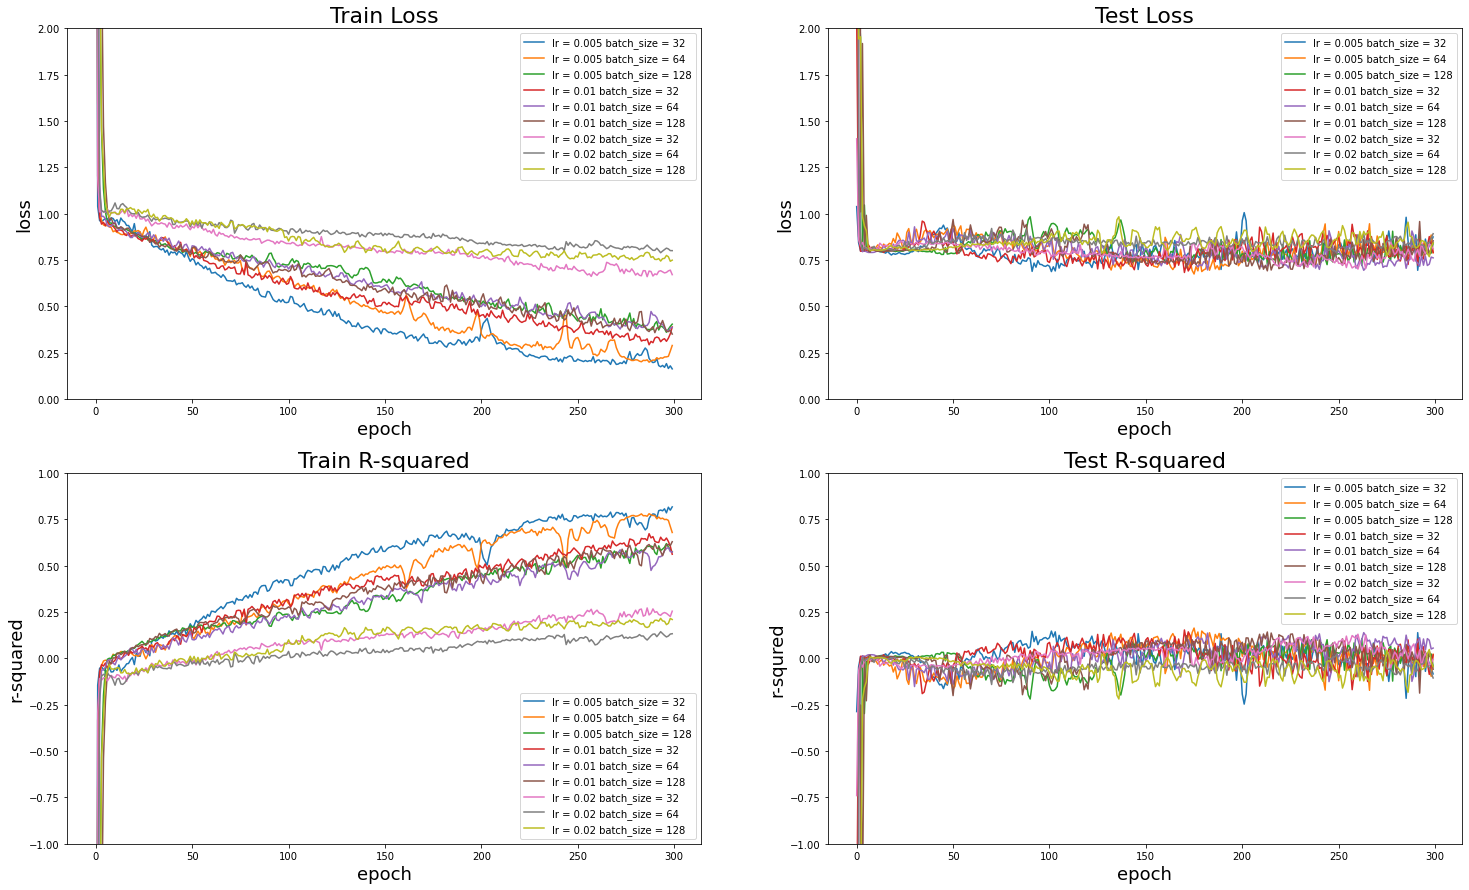

<Figure size 1800x1080 with 0 Axes>

In [16]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.005 batch_size = 128")

    ax.plot(data_list[3],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[4],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[5],label="lr = 0.01 batch_size = 128")
    
    ax.plot(data_list[6],label="lr = 0.02 batch_size = 32")
    ax.plot(data_list[7],label="lr = 0.02 batch_size = 64")
    ax.plot(data_list[8],label="lr = 0.02 batch_size = 128")
    

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Train Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 2])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 2])

ax3.set_title("Train R-squared", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-1,1])

ax4.set_title("Test R-squared", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squred", fontsize=18)
ax4.legend()
ax4.set_ylim([-1,1])

plt.show()

In [15]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

0.8180864540928456
0.6798381582508444
0.5752067784069632
0.5624276346091601
0.5743668546102925
0.63014725332876
0.2553068049934662
0.13357458067083813
0.21031675409289732
___________________

-0.08347515609134804
0.022880602674231643
-0.043323524736051944
0.019460848116653162
0.056145582520543025
-0.058068572459819334
-0.004341305680696017
-0.10523877835413731
-0.043794318104113605
___________________

0.1627003760674061
0.28906299322843554
0.40412085950374604
0.3889251343714885
0.3861918427050114
0.35042880177497865
0.6712315999544584
0.8007412403821945
0.7494312167167664
___________________

0.874521017074585
0.7886764407157898
0.8421127200126648
0.7914367318153381
0.7618268728256226
0.8540141582489014
0.810648500919342
0.8920872211456299
0.8424926996231079


### 3 best models

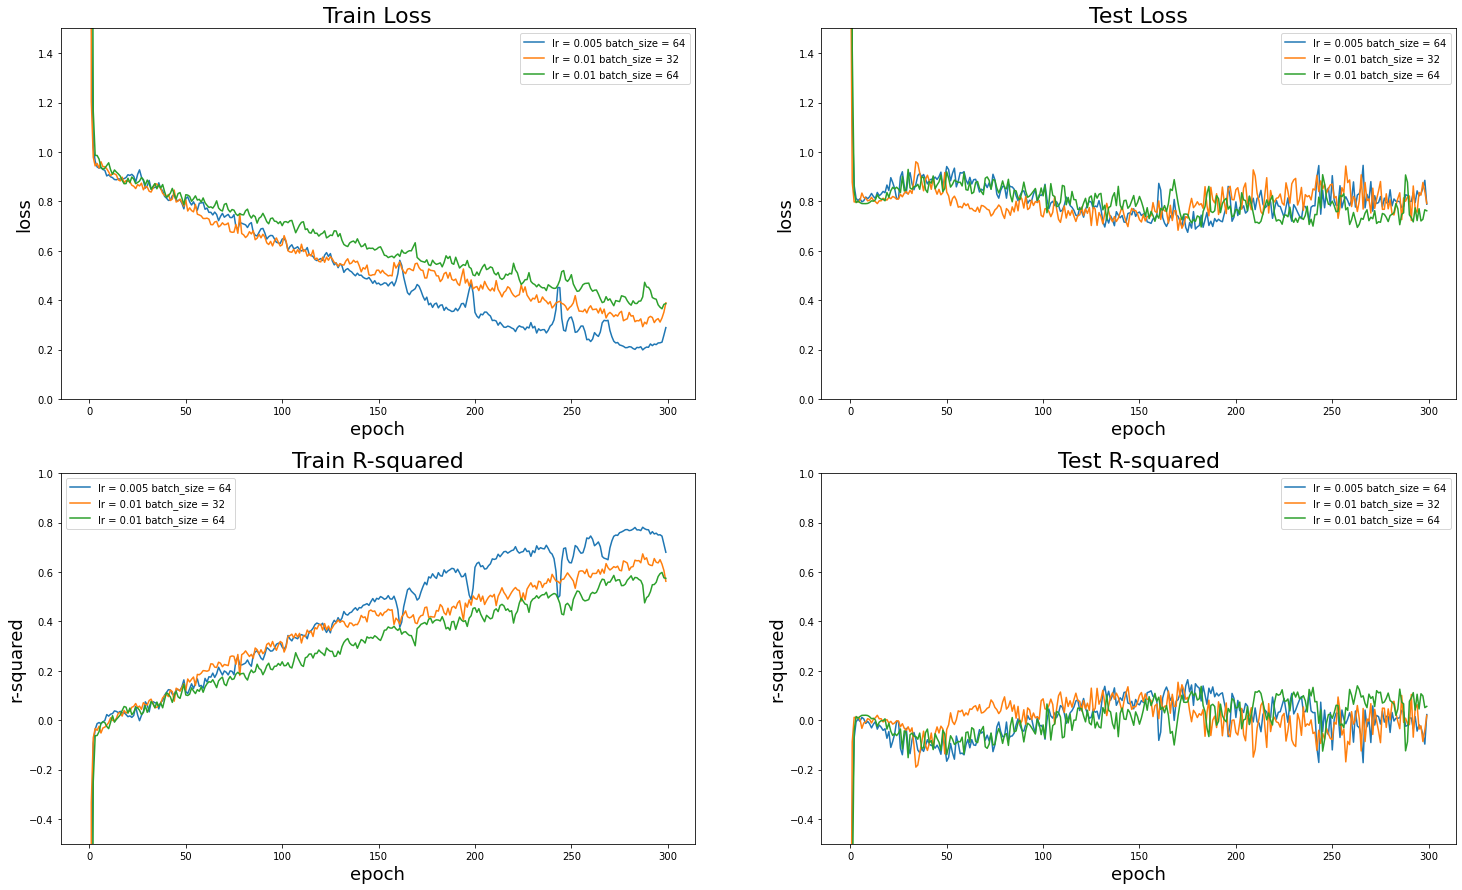

<Figure size 432x288 with 0 Axes>

In [18]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Train Loss", fontsize=22)
ax1.plot(train_losses_all[1],label="lr = 0.005 batch_size = 64")
ax1.plot(train_losses_all[3],label="lr = 0.01 batch_size = 32")
ax1.plot(train_losses_all[4],label="lr = 0.01 batch_size = 64")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1.5])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[1],label="lr = 0.005 batch_size = 64")
ax2.plot(test_losses_all[3],label="lr = 0.01 batch_size = 32")
ax2.plot(test_losses_all[4],label="lr = 0.01 batch_size = 64")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 1.5])

ax3.set_title("Train R-squared", fontsize=22)
ax3.plot(train_accs_all[1],label="lr = 0.005 batch_size = 64")
ax3.plot(train_accs_all[3],label="lr = 0.01 batch_size = 32")
ax3.plot(train_accs_all[4],label="lr = 0.01 batch_size = 64")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-0.5,1])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[1],label="lr = 0.005 batch_size = 64")
ax4.plot(test_accs_all[3],label="lr = 0.01 batch_size = 32")
ax4.plot(test_accs_all[4],label="lr = 0.01 batch_size = 64")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-0.5,1])
plt.show()

## 6.2. Training


- Model 1 - lr: 0.005 batch size: 64
- Model 2 - lr: 0.01 batch size: 32
- Model 3 - lr: 0.01 batch size: 64

In [20]:
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []
best_params_all = []
writer = SummaryWriter()

pairs = [(0.005, 64), (0.01, 32), (0.01, 64)]

for i_p, (lr, batch_size) in enumerate(pairs):
    
    model = GraphNeuralNetwork()

    train_loader = GraphDataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = GraphDataLoader(test_dataset, batch_size=353, shuffle=False)

    epochs = 500
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    best_params = {'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
    best_value = 1

    print('Model: batch_size {} learning rate {}'.format(batch_size, lr))

    for epoch in range(1, epochs + 1):

        print('################## EPOCH {} ##################'.format(epoch))

        model.train()
        train_correct = 0
        train_loss = 0

        for data in tqdm(train_loader, leave=False):
            x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
            optimizer.zero_grad()
            output = model(x, edge_index, batch)
            loss = criterion(output, torch.Tensor(y))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += metrics.r2_score(y, output.cpu().detach().numpy())   

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_acc = train_correct/len(train_loader)
        train_accs.append(train_acc)
        writer.add_scalar("Model_{}/Loss/train".format(i_p), train_loss, epoch)
        writer.add_scalar("Model_{}/R2/train".format(i_p), train_acc, epoch)
        print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

        model.eval()

        test_loss = 0
        test_correct = 0    

        with torch.no_grad():
            for data in tqdm(test_loader):
                x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
                output = model(x, edge_index, batch)
                test_loss += criterion(output, torch.Tensor(y)).item()
                test_correct += metrics.r2_score(y, output.cpu().detach().numpy())

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        test_acc =test_correct/len(test_loader)
        test_accs.append(test_acc)

        if test_loss<best_value:
            best_value = test_loss
            torch.save(model.state_dict(), '../../models/solubility_graph_model_{}.pt'.format(i_p))
            best_params['batch_size'] = batch_size
            best_params['epoch'] = epoch
            best_params['train_loss'] = train_loss
            best_params['test_loss'] = test_loss
            best_params['train_acc'] = train_acc
            best_params['test_acc'] = test_acc 
        writer.add_scalar("Model_{}/Loss/test".format(i_p), test_loss, epoch)
        writer.add_scalar("Model_{}/R2/test".format(i_p), test_acc, epoch)
        print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

    train_losses_all.append(train_losses)
    test_losses_all.append(test_losses)
    train_accs_all.append(train_accs)
    test_accs_all.append(test_accs)
    best_params_all.append(best_params)

writer.flush()
writer.close()
print(best_params_all)

  4%|▍         | 1/23 [00:00<00:02,  8.75it/s]

Model: batch_size 64 learning rate 0.005
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 6.432414008223492, Accuracy: -5.78621141413948


  4%|▍         | 1/23 [00:00<00:02,  8.88it/s]

Test Avg. loss: 1.148031234741211, Accuracy: -0.25412198835336963
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 1.3293697212053381, Accuracy: -0.45861453559969134


  4%|▍         | 1/23 [00:00<00:02,  9.34it/s]

Test Avg. loss: 1.050689935684204, Accuracy: -0.1477853675928964
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 1.018499011578767, Accuracy: -0.1043208909822058


  4%|▍         | 1/23 [00:00<00:02,  9.51it/s]

Test Avg. loss: 0.9026332497596741, Accuracy: 0.013953482726695277
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9529999105826669, Accuracy: -0.0397437421513228


  4%|▍         | 1/23 [00:00<00:02,  9.47it/s]

Test Avg. loss: 0.8925355672836304, Accuracy: 0.02498423882382439
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9396692333014115, Accuracy: -0.027160740059422227


  4%|▍         | 1/23 [00:00<00:02,  9.66it/s]

Test Avg. loss: 0.8923115730285645, Accuracy: 0.025228950167033415
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9350738033004429, Accuracy: -0.022611571098377893


  4%|▍         | 1/23 [00:00<00:02,  9.79it/s]

Test Avg. loss: 0.8918747305870056, Accuracy: 0.02570604779836727
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9259234200353208, Accuracy: -0.01499497090702209


  9%|▊         | 2/23 [00:00<00:01, 11.38it/s]

Test Avg. loss: 0.8851113319396973, Accuracy: 0.03309453674199214
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.93069974495017, Accuracy: -0.020372752902848602


  9%|▊         | 2/23 [00:00<00:01, 10.69it/s]

Test Avg. loss: 0.8877732753753662, Accuracy: 0.030186583130930478
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9293361798576687, Accuracy: -0.01748198163455312


  0%|          | 0/23 [00:00<?, ?it/s]

Test Avg. loss: 0.8758764266967773, Accuracy: 0.04318286336893751
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9406020796817282, Accuracy: -0.036729666577206506


  4%|▍         | 1/23 [00:00<00:02,  9.32it/s]

Test Avg. loss: 0.8833087086677551, Accuracy: 0.03506374573702997
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9258179509121439, Accuracy: -0.01769037641868689


  9%|▊         | 2/23 [00:00<00:01, 12.03it/s]

Test Avg. loss: 0.870323121547699, Accuracy: 0.04924929260251121
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9441875867221666, Accuracy: -0.040259901566708355


  4%|▍         | 1/23 [00:00<00:02,  9.58it/s]

Test Avg. loss: 0.870509684085846, Accuracy: 0.04904562283096714
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9595147112141484, Accuracy: -0.0569494280504109


  9%|▊         | 2/23 [00:00<00:01, 11.07it/s]

Test Avg. loss: 0.8805851340293884, Accuracy: 0.038039133991741636
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9948737284411555, Accuracy: -0.0942734714964176


  4%|▍         | 1/23 [00:00<00:02,  9.66it/s]

Test Avg. loss: 0.8727919459342957, Accuracy: 0.0465524526217268
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9731246181156324, Accuracy: -0.07251546089525716


  9%|▊         | 2/23 [00:00<00:02, 10.34it/s]

Test Avg. loss: 0.8871669769287109, Accuracy: 0.03084896425847483
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9745749416558639, Accuracy: -0.06951715881190346


  4%|▍         | 1/23 [00:00<00:02,  9.27it/s]

Test Avg. loss: 0.9063281416893005, Accuracy: 0.009917146705992086
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 1.0011713349300881, Accuracy: -0.10187813700331018


  4%|▍         | 1/23 [00:00<00:02,  9.87it/s]

Test Avg. loss: 0.9187222719192505, Accuracy: -0.0036223594401041392
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 1.0359273112338523, Accuracy: -0.13816432665525036


  4%|▍         | 1/23 [00:00<00:02,  9.36it/s]

Test Avg. loss: 0.8895917534828186, Accuracy: 0.028200257134846418
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 1.0255773689435876, Accuracy: -0.12815181656228847


  4%|▍         | 1/23 [00:00<00:02,  9.87it/s]

Test Avg. loss: 0.8675894737243652, Accuracy: 0.052235637977908644
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9684018622273984, Accuracy: -0.06574806492642636


  9%|▊         | 2/23 [00:00<00:01, 10.70it/s]

Test Avg. loss: 0.854404628276825, Accuracy: 0.06663902857335524
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9314044092012488, Accuracy: -0.022978241781849314


  9%|▊         | 2/23 [00:00<00:01, 10.65it/s]

Test Avg. loss: 0.8749568462371826, Accuracy: 0.044187443589256414
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.972750161005103, Accuracy: -0.07284357504087552


  9%|▊         | 2/23 [00:00<00:02, 10.39it/s]

Test Avg. loss: 0.8712522387504578, Accuracy: 0.0482345239400469
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9368799510209457, Accuracy: -0.03326004375567173


  4%|▍         | 1/23 [00:00<00:02,  9.70it/s]

Test Avg. loss: 0.8626110553741455, Accuracy: 0.057674141307535565
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9438586649687394, Accuracy: -0.03487978154379706


  4%|▍         | 1/23 [00:00<00:02,  9.66it/s]

Test Avg. loss: 0.8701275587081909, Accuracy: 0.049463104184450435
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9596275972283405, Accuracy: -0.05640861298496845


  9%|▊         | 2/23 [00:00<00:01, 11.40it/s]

Test Avg. loss: 0.8816348314285278, Accuracy: 0.03689226340919294
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9747710176136183, Accuracy: -0.07355637964465257


  9%|▊         | 2/23 [00:00<00:01, 11.79it/s]

Test Avg. loss: 0.8420394659042358, Accuracy: 0.08014674556055135
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9533972299617269, Accuracy: -0.05162853052230889


  0%|          | 0/23 [00:00<?, ?it/s]

Test Avg. loss: 0.8389890789985657, Accuracy: 0.08347897589073638
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9557606811108796, Accuracy: -0.05556721725416418


  9%|▊         | 2/23 [00:00<00:01, 11.68it/s]

Test Avg. loss: 0.8604488968849182, Accuracy: 0.06003603527694168
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9562642911206121, Accuracy: -0.05300115303623756


  4%|▍         | 1/23 [00:00<00:02,  9.56it/s]

Test Avg. loss: 0.8635674715042114, Accuracy: 0.05662925800391694
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.964559687220532, Accuracy: -0.060960483598952904


  4%|▍         | 1/23 [00:00<00:02,  9.87it/s]

Test Avg. loss: 0.8296326398849487, Accuracy: 0.093700108366634
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9498186914817147, Accuracy: -0.045363074557334924


  4%|▍         | 1/23 [00:00<00:02,  9.91it/s]

Test Avg. loss: 0.821087658405304, Accuracy: 0.10303471962606514
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8978506508080856, Accuracy: 0.009676102313920996


  4%|▍         | 1/23 [00:00<00:02,  9.67it/s]

Test Avg. loss: 0.8206846117973328, Accuracy: 0.10347505671543777
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8851084346356599, Accuracy: 0.0223244099647952


  9%|▊         | 2/23 [00:00<00:02, 10.23it/s]

Test Avg. loss: 0.8169612884521484, Accuracy: 0.10754241834357048
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8848630811857141, Accuracy: 0.02331283771217473


  4%|▍         | 1/23 [00:00<00:02,  9.91it/s]

Test Avg. loss: 0.8239502310752869, Accuracy: 0.09990763021736815
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9102452371431433, Accuracy: -0.004859369079112364


  4%|▍         | 1/23 [00:00<00:02,  9.73it/s]

Test Avg. loss: 0.8455182909965515, Accuracy: 0.07634645780191252
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9172644045041956, Accuracy: -0.011234577381842704


  4%|▍         | 1/23 [00:00<00:02,  9.95it/s]

Test Avg. loss: 0.8284616470336914, Accuracy: 0.09497932125459008
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9313672288604404, Accuracy: -0.02799283311212387


  9%|▊         | 2/23 [00:00<00:01, 11.07it/s]

Test Avg. loss: 0.8044499158859253, Accuracy: 0.12121003203615122
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8886892691902493, Accuracy: 0.02328339375987245


  4%|▍         | 1/23 [00:00<00:02,  9.68it/s]

Test Avg. loss: 0.7992338538169861, Accuracy: 0.12690810581134937
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8729911783467168, Accuracy: 0.03889210755476416


  4%|▍         | 1/23 [00:00<00:02,  9.52it/s]

Test Avg. loss: 0.8031945824623108, Accuracy: 0.12258137982636852
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8724962317425272, Accuracy: 0.039711853913042335


  9%|▊         | 2/23 [00:00<00:02, 10.42it/s]

Test Avg. loss: 0.7949008941650391, Accuracy: 0.13164155605855288
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8655389521432959, Accuracy: 0.04519554847182527


  9%|▊         | 2/23 [00:00<00:01, 10.87it/s]

Test Avg. loss: 0.8097155690193176, Accuracy: 0.11545770977025793
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8846907226935677, Accuracy: 0.02499952056063087


  4%|▍         | 1/23 [00:00<00:02,  9.66it/s]

Test Avg. loss: 0.788540780544281, Accuracy: 0.13858940760120675
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.851558374321979, Accuracy: 0.060903527482405774


  4%|▍         | 1/23 [00:00<00:02,  9.76it/s]

Test Avg. loss: 0.7880341410636902, Accuracy: 0.139142711214018
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8551701177721438, Accuracy: 0.05592452932663032


  4%|▍         | 1/23 [00:00<00:02,  9.68it/s]

Test Avg. loss: 0.8195653557777405, Accuracy: 0.10469761081170814
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9035652435344198, Accuracy: 0.005796775519530931


  4%|▍         | 1/23 [00:00<00:02,  9.53it/s]

Test Avg. loss: 0.7872037887573242, Accuracy: 0.14004989934673295
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.839826788591302, Accuracy: 0.07204340320629972


  9%|▊         | 2/23 [00:00<00:02, 10.15it/s]

Test Avg. loss: 0.7797011137008667, Accuracy: 0.14824593774986772
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.83531159421672, Accuracy: 0.07818093697159335


  4%|▍         | 1/23 [00:00<00:02,  9.74it/s]

Test Avg. loss: 0.7828818559646606, Accuracy: 0.14477122451476743
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8246776798497075, Accuracy: 0.087448935691165


  4%|▍         | 1/23 [00:00<00:02,  9.46it/s]

Test Avg. loss: 0.7769472002983093, Accuracy: 0.15125428942576502
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7986982905346415, Accuracy: 0.1154709766814261


  9%|▊         | 2/23 [00:00<00:01, 11.79it/s]

Test Avg. loss: 0.7912523150444031, Accuracy: 0.13562715749698506
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8291441979615585, Accuracy: 0.0830083604647666


  9%|▊         | 2/23 [00:00<00:01, 10.59it/s]

Test Avg. loss: 0.7804884314537048, Accuracy: 0.147385824825078
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8251437000606371, Accuracy: 0.08938690921081131


  9%|▊         | 2/23 [00:00<00:02, 10.07it/s]

Test Avg. loss: 0.7681481838226318, Accuracy: 0.16086639388289548
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8058704422867816, Accuracy: 0.11105198815004189


  4%|▍         | 1/23 [00:00<00:02,  9.51it/s]

Test Avg. loss: 0.7859172224998474, Accuracy: 0.14145530639193316
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8126304849334385, Accuracy: 0.10396104882718359


  4%|▍         | 1/23 [00:00<00:02,  9.33it/s]

Test Avg. loss: 0.7686853408813477, Accuracy: 0.16027967897379602
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8108957669009333, Accuracy: 0.10343025599393732


  9%|▊         | 2/23 [00:00<00:01, 11.28it/s]

Test Avg. loss: 0.7968506813049316, Accuracy: 0.1295115364179985
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8346163967381353, Accuracy: 0.0774591174814596


  4%|▍         | 1/23 [00:00<00:02,  9.46it/s]

Test Avg. loss: 0.762763261795044, Accuracy: 0.16674907248315263
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8036743661631709, Accuracy: 0.11531656439887623


  9%|▊         | 2/23 [00:00<00:01, 11.53it/s]

Test Avg. loss: 0.750347375869751, Accuracy: 0.18031216813989825
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7908597433048746, Accuracy: 0.1256593301586335


  9%|▊         | 2/23 [00:00<00:01, 11.29it/s]

Test Avg. loss: 0.7686688303947449, Accuracy: 0.16029766122358424
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8049218162246372, Accuracy: 0.10651033691094694


  9%|▊         | 2/23 [00:00<00:01, 11.14it/s]

Test Avg. loss: 0.7514467835426331, Accuracy: 0.1791112366476203
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7768231345259625, Accuracy: 0.13977749549996304


  0%|          | 0/23 [00:00<?, ?it/s]

Test Avg. loss: 0.7525098919868469, Accuracy: 0.17794983171212297
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8016850741013236, Accuracy: 0.11488343973621268


  4%|▍         | 1/23 [00:00<00:02,  9.69it/s]

Test Avg. loss: 0.7586011290550232, Accuracy: 0.17129578289123615
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7931866438492484, Accuracy: 0.12508022770624275


  9%|▊         | 2/23 [00:00<00:01, 11.21it/s]

Test Avg. loss: 0.7454210519790649, Accuracy: 0.18569375127130716
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7723275785860808, Accuracy: 0.14576210496889655


  4%|▍         | 1/23 [00:00<00:02,  9.87it/s]

Test Avg. loss: 0.7403635382652283, Accuracy: 0.19121874166965824
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7878311172775601, Accuracy: 0.1310738805067682


  4%|▍         | 1/23 [00:00<00:02,  9.62it/s]

Test Avg. loss: 0.7535841464996338, Accuracy: 0.17677637032278937
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7939691958220109, Accuracy: 0.1218676172759396


  9%|▊         | 2/23 [00:00<00:01, 11.09it/s]

Test Avg. loss: 0.7354788184165955, Accuracy: 0.19655478879687505
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7808127558749655, Accuracy: 0.13969004551987502


  9%|▊         | 2/23 [00:00<00:02,  9.97it/s]

Test Avg. loss: 0.7347225546836853, Accuracy: 0.197380903535467
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7773254176844722, Accuracy: 0.1409613559147417


  9%|▊         | 2/23 [00:00<00:01, 10.57it/s]

Test Avg. loss: 0.7358633875846863, Accuracy: 0.196134686986693
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7724537564360577, Accuracy: 0.14646454624932134


  4%|▍         | 1/23 [00:00<00:02,  9.31it/s]

Test Avg. loss: 0.7189610004425049, Accuracy: 0.21459908581224252
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7401680920435034, Accuracy: 0.1823407029844708


  9%|▊         | 2/23 [00:00<00:02, 10.17it/s]

Test Avg. loss: 0.726673424243927, Accuracy: 0.2061738667068873
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7555216861807782, Accuracy: 0.16423090358223708


  4%|▍         | 1/23 [00:00<00:02,  9.60it/s]

Test Avg. loss: 0.7199761271476746, Accuracy: 0.21349007253984953
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.756479605384495, Accuracy: 0.16728985605138913


  4%|▍         | 1/23 [00:00<00:02,  9.63it/s]

Test Avg. loss: 0.7455461621284485, Accuracy: 0.18555708689003292
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7554123647834944, Accuracy: 0.16488100926914437


  4%|▍         | 1/23 [00:00<00:02,  8.92it/s]

Test Avg. loss: 0.7173523306846619, Accuracy: 0.21635635734170022
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7119254482829053, Accuracy: 0.2129675526924909


  9%|▊         | 2/23 [00:00<00:02, 10.48it/s]

Test Avg. loss: 0.7184533476829529, Accuracy: 0.21515359814385693
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7418453667474829, Accuracy: 0.18347636520416752


  9%|▊         | 2/23 [00:00<00:01, 11.33it/s]

Test Avg. loss: 0.7740040421485901, Accuracy: 0.1544694337846806
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8008710638336514, Accuracy: 0.11558638210938578


  4%|▍         | 1/23 [00:00<00:02,  9.58it/s]

Test Avg. loss: 0.7247963547706604, Accuracy: 0.2082243668046826
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7170145174731379, Accuracy: 0.20571788613848394


  4%|▍         | 1/23 [00:00<00:02,  9.93it/s]

Test Avg. loss: 0.6968579292297363, Accuracy: 0.23874467724217596
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7119108101596003, Accuracy: 0.21484107673894007


  4%|▍         | 1/23 [00:00<00:02,  9.69it/s]

Test Avg. loss: 0.7101840376853943, Accuracy: 0.22418705124623572
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.73123197970183, Accuracy: 0.19223025149809364


  9%|▊         | 2/23 [00:00<00:01, 10.73it/s]

Test Avg. loss: 0.7083361744880676, Accuracy: 0.226205635529788
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7307828457459159, Accuracy: 0.19441313544847127


  4%|▍         | 1/23 [00:00<00:02,  9.22it/s]

Test Avg. loss: 0.6996728181838989, Accuracy: 0.23566968207910965
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6875817646151003, Accuracy: 0.2404983172786908


  0%|          | 0/23 [00:00<?, ?it/s]

Test Avg. loss: 0.6972330808639526, Accuracy: 0.2383348911259936
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7140338239462479, Accuracy: 0.21273737389732783


  4%|▍         | 1/23 [00:00<00:02,  9.08it/s]

Test Avg. loss: 0.7187640070915222, Accuracy: 0.21481428085816556
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7324865291947904, Accuracy: 0.19277583900458267


  9%|▊         | 2/23 [00:00<00:01, 10.98it/s]

Test Avg. loss: 0.6908501982688904, Accuracy: 0.24530761821621272
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6698695991350256, Accuracy: 0.2599031326438794


  4%|▍         | 1/23 [00:00<00:02,  9.86it/s]

Test Avg. loss: 0.6906172633171082, Accuracy: 0.24556215417100702
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6727588941221652, Accuracy: 0.259201044698529


  4%|▍         | 1/23 [00:00<00:02,  9.33it/s]

Test Avg. loss: 0.6832593679428101, Accuracy: 0.25359987382758975
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6878165693386741, Accuracy: 0.2409091093710862


  9%|▊         | 2/23 [00:00<00:01, 11.71it/s]

Test Avg. loss: 0.6865130066871643, Accuracy: 0.2500455650566433
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6952325999736786, Accuracy: 0.2313342992906311


  9%|▊         | 2/23 [00:00<00:01, 11.34it/s]

Test Avg. loss: 0.6732773184776306, Accuracy: 0.26450438751149963
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6711403235145237, Accuracy: 0.25842647791328965


  4%|▍         | 1/23 [00:00<00:02,  9.68it/s]

Test Avg. loss: 0.668753981590271, Accuracy: 0.2694457342790444
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6655096139596857, Accuracy: 0.265122140709921


  9%|▊         | 2/23 [00:00<00:01, 11.59it/s]

Test Avg. loss: 0.6924387216567993, Accuracy: 0.24357225094765045
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6850947413755499, Accuracy: 0.24586191939928384


  9%|▊         | 2/23 [00:00<00:01, 11.11it/s]

Test Avg. loss: 0.6648497581481934, Accuracy: 0.2737106929100225
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6660535205965457, Accuracy: 0.265285291278109


  9%|▊         | 2/23 [00:00<00:01, 11.61it/s]

Test Avg. loss: 0.6615204811096191, Accuracy: 0.2773476831496847
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6739512837451437, Accuracy: 0.254597194426728


  4%|▍         | 1/23 [00:00<00:02,  9.40it/s]

Test Avg. loss: 0.6588223576545715, Accuracy: 0.2802951592587446
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6337893533965816, Accuracy: 0.29805648944414226


  4%|▍         | 1/23 [00:00<00:02,  9.13it/s]

Test Avg. loss: 0.6511223316192627, Accuracy: 0.2887067732942429
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6256751048824062, Accuracy: 0.3076854404757868


  9%|▊         | 2/23 [00:00<00:01, 10.93it/s]

Test Avg. loss: 0.6682802438735962, Accuracy: 0.26996321410554736
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6608750794244849, Accuracy: 0.27112168771258743


  4%|▍         | 1/23 [00:00<00:02,  9.90it/s]

Test Avg. loss: 0.667842447757721, Accuracy: 0.2704415381410087
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6538243604742963, Accuracy: 0.2783443481742945


  4%|▍         | 1/23 [00:00<00:02,  9.80it/s]

Test Avg. loss: 0.6562646627426147, Accuracy: 0.2830892392121973
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6119443864926047, Accuracy: 0.3253508785499233


  9%|▊         | 2/23 [00:00<00:01, 10.60it/s]

Test Avg. loss: 0.6447259783744812, Accuracy: 0.2956941996281617
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6172195624398149, Accuracy: 0.32431176307512


  9%|▊         | 2/23 [00:00<00:02, 10.30it/s]

Test Avg. loss: 0.6970638632774353, Accuracy: 0.2385196987951158
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6593703070412511, Accuracy: 0.2716332840736476


  4%|▍         | 1/23 [00:00<00:02,  9.89it/s]

Test Avg. loss: 0.6710382103919983, Accuracy: 0.2669504709115289
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.671561519736829, Accuracy: 0.2583856537574437


  0%|          | 0/23 [00:00<?, ?it/s]

Test Avg. loss: 0.6690149903297424, Accuracy: 0.26916057029617146
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5995953160783519, Accuracy: 0.3404086694620973


  9%|▊         | 2/23 [00:00<00:01, 10.61it/s]

Test Avg. loss: 0.6963108777999878, Accuracy: 0.23934235361941614
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6576508477978085, Accuracy: 0.27449243474127316


  9%|▊         | 2/23 [00:00<00:01, 10.81it/s]

Test Avg. loss: 0.6634634137153625, Accuracy: 0.2752252539743376
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5881261534017065, Accuracy: 0.3499473642140199


  9%|▊         | 2/23 [00:00<00:01, 10.64it/s]

Test Avg. loss: 0.6417722105979919, Accuracy: 0.2989209217551213
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5958244411841683, Accuracy: 0.3430888182257754


  4%|▍         | 1/23 [00:00<00:02,  9.84it/s]

Test Avg. loss: 0.6386508345603943, Accuracy: 0.30233078545966274
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5836799902760464, Accuracy: 0.3562467365579273


  9%|▊         | 2/23 [00:00<00:02, 10.32it/s]

Test Avg. loss: 0.6449708342552185, Accuracy: 0.295426762450375
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5906225313311038, Accuracy: 0.347841303342059


  4%|▍         | 1/23 [00:00<00:02,  9.95it/s]

Test Avg. loss: 0.6388328075408936, Accuracy: 0.302131997060589
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.595580104900443, Accuracy: 0.3445197390245253


  9%|▊         | 2/23 [00:00<00:01, 11.15it/s]

Test Avg. loss: 0.650192379951477, Accuracy: 0.28972259363058783
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6083512474661288, Accuracy: 0.32947573124681734


  9%|▊         | 2/23 [00:00<00:02, 10.16it/s]

Test Avg. loss: 0.6304894089698792, Accuracy: 0.31124632447209066
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5897406300772792, Accuracy: 0.34865407747995175


  4%|▍         | 1/23 [00:00<00:02,  9.53it/s]

Test Avg. loss: 0.6400971412658691, Accuracy: 0.3007507781870943
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5781784297331519, Accuracy: 0.35986189149642334


  9%|▊         | 2/23 [00:00<00:02, 10.07it/s]

Test Avg. loss: 0.6379942893981934, Accuracy: 0.3030479436516792
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5683591595810392, Accuracy: 0.3705860232559412


  0%|          | 0/23 [00:00<?, ?it/s]

Test Avg. loss: 0.6279104948043823, Accuracy: 0.3140636078829512
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5742427330950032, Accuracy: 0.36630128707749554


  4%|▍         | 1/23 [00:00<00:02,  9.52it/s]

Test Avg. loss: 0.627834141254425, Accuracy: 0.3141469922989767
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.572352792257848, Accuracy: 0.36566308521899243


  4%|▍         | 1/23 [00:00<00:02,  9.82it/s]

Test Avg. loss: 0.6603754758834839, Accuracy: 0.2785985434734848
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6017605532770571, Accuracy: 0.33561457452669685


  4%|▍         | 1/23 [00:00<00:02,  9.39it/s]

Test Avg. loss: 0.6382501721382141, Accuracy: 0.3027685206197753
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5602651257877764, Accuracy: 0.3812288703049569


  0%|          | 0/23 [00:00<?, ?it/s]

Test Avg. loss: 0.6399417519569397, Accuracy: 0.30092055240092086
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5500780622596326, Accuracy: 0.39164807213235636


  4%|▍         | 1/23 [00:00<00:02,  9.72it/s]

Test Avg. loss: 0.6275818943977356, Accuracy: 0.314422619904286
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.541708089735197, Accuracy: 0.40147805198254344


  9%|▊         | 2/23 [00:00<00:01, 11.25it/s]

Test Avg. loss: 0.6299824714660645, Accuracy: 0.3118001526642682
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5541336445704751, Accuracy: 0.3867108848525178


  4%|▍         | 1/23 [00:00<00:02,  9.84it/s]

Test Avg. loss: 0.6547142267227173, Accuracy: 0.2847829273876574
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5733632238014884, Accuracy: 0.3654812633627308


  9%|▊         | 2/23 [00:00<00:01, 11.74it/s]

Test Avg. loss: 0.6308004856109619, Accuracy: 0.3109065505723554
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5549556224242501, Accuracy: 0.3851582035791729


  4%|▍         | 1/23 [00:00<00:02,  9.93it/s]

Test Avg. loss: 0.6267730593681335, Accuracy: 0.31530609208495697
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5412010051634001, Accuracy: 0.3993877140296692


  4%|▍         | 1/23 [00:00<00:02,  9.85it/s]

Test Avg. loss: 0.6323320269584656, Accuracy: 0.30923343239301715
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5193124601374501, Accuracy: 0.42419587136781467


  4%|▍         | 1/23 [00:00<00:02,  9.69it/s]

Test Avg. loss: 0.6189640760421753, Accuracy: 0.3238367608569319
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.52574915714238, Accuracy: 0.41874036782918644


  4%|▍         | 1/23 [00:00<00:02,  9.36it/s]

Test Avg. loss: 0.6229085326194763, Accuracy: 0.31952780578101103
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5156930435610854, Accuracy: 0.42842371009165825


  4%|▍         | 1/23 [00:00<00:02,  9.97it/s]

Test Avg. loss: 0.6876916289329529, Accuracy: 0.2487580902291946
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5574936750142471, Accuracy: 0.3826061979255244


  4%|▍         | 1/23 [00:00<00:02,  9.85it/s]

Test Avg. loss: 0.6236860156059265, Accuracy: 0.3186784642875179
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5328070281640344, Accuracy: 0.4107849903643146


  4%|▍         | 1/23 [00:00<00:02,  9.11it/s]

Test Avg. loss: 0.6203483939170837, Accuracy: 0.3223244999535566
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5287985380577005, Accuracy: 0.41394510989994154


  4%|▍         | 1/23 [00:00<00:02,  8.92it/s]

Test Avg. loss: 0.6348497271537781, Accuracy: 0.30648313556442885
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5257853580557782, Accuracy: 0.41590326918951875


  4%|▍         | 1/23 [00:00<00:02,  9.20it/s]

Test Avg. loss: 0.6225415468215942, Accuracy: 0.3199286837252262
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4996293128832527, Accuracy: 0.4453581481064748


  9%|▊         | 2/23 [00:00<00:01, 11.72it/s]

Test Avg. loss: 0.6193215847015381, Accuracy: 0.32344625555735695
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.48727599952531897, Accuracy: 0.4614674040739539


  9%|▊         | 2/23 [00:00<00:01, 11.18it/s]

Test Avg. loss: 0.6347177028656006, Accuracy: 0.30662732795437897
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.49551405611893407, Accuracy: 0.4529435427040827


  4%|▍         | 1/23 [00:00<00:02,  9.22it/s]

Test Avg. loss: 0.6514712572097778, Accuracy: 0.2883255504490241
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5131402112867521, Accuracy: 0.43240395679719884


  9%|▊         | 2/23 [00:00<00:02, 10.33it/s]

Test Avg. loss: 0.6230336427688599, Accuracy: 0.31939118148848233
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5192876665488534, Accuracy: 0.4243318582919646


  4%|▍         | 1/23 [00:00<00:02,  9.66it/s]

Test Avg. loss: 0.6367114782333374, Accuracy: 0.30444926417118245
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.513680973454662, Accuracy: 0.42893377984980674


  4%|▍         | 1/23 [00:00<00:02,  9.70it/s]

Test Avg. loss: 0.6138457655906677, Accuracy: 0.32942805448009094
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.49389783714128577, Accuracy: 0.45078408841594886


  9%|▊         | 2/23 [00:00<00:01, 11.01it/s]

Test Avg. loss: 0.6345821619033813, Accuracy: 0.3067754108427476
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4842306958592456, Accuracy: 0.46353421675343365


  4%|▍         | 1/23 [00:00<00:02,  9.83it/s]

Test Avg. loss: 0.6575760841369629, Accuracy: 0.281656597979547
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4980263756993024, Accuracy: 0.4468099169887509


  9%|▊         | 2/23 [00:00<00:01, 11.77it/s]

Test Avg. loss: 0.6065452694892883, Accuracy: 0.3374032126214004
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4720300911804256, Accuracy: 0.4755644266025146


  9%|▊         | 2/23 [00:00<00:01, 10.86it/s]

Test Avg. loss: 0.622903048992157, Accuracy: 0.3195338252769534
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4776261950964513, Accuracy: 0.4695322157779559


  4%|▍         | 1/23 [00:00<00:02,  9.47it/s]

Test Avg. loss: 0.6363911628723145, Accuracy: 0.3047992777327201
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4732647751984389, Accuracy: 0.47608283993678335


  4%|▍         | 1/23 [00:00<00:02,  9.98it/s]

Test Avg. loss: 0.6162071228027344, Accuracy: 0.3268485669268072
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47515362080024637, Accuracy: 0.47175371039402664


  9%|▊         | 2/23 [00:00<00:01, 11.51it/s]

Test Avg. loss: 0.6281309127807617, Accuracy: 0.3138228171309928
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47632851613604504, Accuracy: 0.471627400992524


  9%|▊         | 2/23 [00:00<00:01, 11.42it/s]

Test Avg. loss: 0.6046221852302551, Accuracy: 0.33950404140285306
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4585741357068005, Accuracy: 0.49038405963136933


  4%|▍         | 1/23 [00:00<00:02,  9.64it/s]

Test Avg. loss: 0.6040346622467041, Accuracy: 0.3401458168862197
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.44456864310347516, Accuracy: 0.5044914855086337


  9%|▊         | 2/23 [00:00<00:01, 10.56it/s]

Test Avg. loss: 0.6262300610542297, Accuracy: 0.3158993920308214
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.45938554693661304, Accuracy: 0.489330543498809


  4%|▍         | 1/23 [00:00<00:02,  9.38it/s]

Test Avg. loss: 0.6656971573829651, Accuracy: 0.27278503391289033
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4678064452777819, Accuracy: 0.4831413850709803


  4%|▍         | 1/23 [00:00<00:02,  9.72it/s]

Test Avg. loss: 0.6214512586593628, Accuracy: 0.32111975531646075
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.44537912697895715, Accuracy: 0.506947662859807


  4%|▍         | 1/23 [00:00<00:02,  9.27it/s]

Test Avg. loss: 0.6297451853752136, Accuracy: 0.3120593986215544
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5004193471825641, Accuracy: 0.44475516636087875


  9%|▊         | 2/23 [00:00<00:01, 11.03it/s]

Test Avg. loss: 0.6107901930809021, Accuracy: 0.33276598734702145
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.49140329043502395, Accuracy: 0.45319201748597104


  4%|▍         | 1/23 [00:00<00:02,  9.75it/s]

Test Avg. loss: 0.6292772889137268, Accuracy: 0.3125704115855329
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.48896616859280545, Accuracy: 0.4541832176902573


  4%|▍         | 1/23 [00:00<00:02,  9.31it/s]

Test Avg. loss: 0.6372278332710266, Accuracy: 0.30388527078745375
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4482412325299304, Accuracy: 0.502205941096868


  4%|▍         | 1/23 [00:00<00:02,  9.22it/s]

Test Avg. loss: 0.7148340940475464, Accuracy: 0.2191073188417677
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4551857279046722, Accuracy: 0.4950081963794114


  4%|▍         | 1/23 [00:00<00:02,  9.91it/s]

Test Avg. loss: 0.6602892279624939, Accuracy: 0.2786927208983332
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4360383327888406, Accuracy: 0.5135072395514344


  4%|▍         | 1/23 [00:00<00:02,  9.39it/s]

Test Avg. loss: 0.6180633306503296, Accuracy: 0.3248207256237885
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.41669113702221733, Accuracy: 0.5363273060647942


  4%|▍         | 1/23 [00:00<00:02,  9.25it/s]

Test Avg. loss: 0.6433150172233582, Accuracy: 0.29723547653495996
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.41206397626387037, Accuracy: 0.5400548692656565


  4%|▍         | 1/23 [00:00<00:02,  9.19it/s]

Test Avg. loss: 0.6325881481170654, Accuracy: 0.3089536756558948
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4253658968145433, Accuracy: 0.5259031694746943


  4%|▍         | 1/23 [00:00<00:02,  9.98it/s]

Test Avg. loss: 0.6239284873008728, Accuracy: 0.31841364717579657
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4316165220478307, Accuracy: 0.5205575473929847


  9%|▊         | 2/23 [00:00<00:01, 11.48it/s]

Test Avg. loss: 0.6892852187156677, Accuracy: 0.2470171338346817
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4349493905901909, Accuracy: 0.5205086566418701


  4%|▍         | 1/23 [00:00<00:02,  9.16it/s]

Test Avg. loss: 0.6066253781318665, Accuracy: 0.33731569280991247
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.42482432561076205, Accuracy: 0.5275584569054539


  4%|▍         | 1/23 [00:00<00:02,  9.01it/s]

Test Avg. loss: 0.5928871035575867, Accuracy: 0.35232362054644895
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.42559534116931586, Accuracy: 0.5262544281973925


  9%|▊         | 2/23 [00:00<00:01, 10.97it/s]

Test Avg. loss: 0.6147878170013428, Accuracy: 0.3283989912634997
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4133638363817464, Accuracy: 0.5406221118015467


  4%|▍         | 1/23 [00:00<00:02,  8.81it/s]

Test Avg. loss: 0.6172240376472473, Accuracy: 0.3257375851480663
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4161368698367606, Accuracy: 0.5361158425822731


  4%|▍         | 1/23 [00:00<00:02,  8.75it/s]

Test Avg. loss: 0.6267474293708801, Accuracy: 0.31533414833792306
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4217029223623483, Accuracy: 0.5294785851586635


  4%|▍         | 1/23 [00:00<00:02,  8.10it/s]

Test Avg. loss: 0.6140110492706299, Accuracy: 0.3292475631623911
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4087748872116208, Accuracy: 0.543912502304952


  4%|▍         | 1/23 [00:00<00:02,  8.40it/s]

Test Avg. loss: 0.6100103259086609, Accuracy: 0.33361797866448173
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.399973153906024, Accuracy: 0.5533366759617686


  4%|▍         | 1/23 [00:00<00:02,  9.03it/s]

Test Avg. loss: 0.622819185256958, Accuracy: 0.31962550185176897
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4058340862798302, Accuracy: 0.5464799363817339


  4%|▍         | 1/23 [00:00<00:02,  9.04it/s]

Test Avg. loss: 0.6243386268615723, Accuracy: 0.3179655190705304
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.39022548431935516, Accuracy: 0.5656733223295229


  9%|▊         | 2/23 [00:00<00:01, 10.82it/s]

Test Avg. loss: 0.6514975428581238, Accuracy: 0.28829688558357713
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.39434029842200485, Accuracy: 0.5610744061053198


  4%|▍         | 1/23 [00:00<00:02,  9.25it/s]

Test Avg. loss: 0.6172605752944946, Accuracy: 0.32569764610629914
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.39130069477402646, Accuracy: 0.5633872043149459


  4%|▍         | 1/23 [00:00<00:02,  9.58it/s]

Test Avg. loss: 0.6268501877784729, Accuracy: 0.3152219619002493
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38525203080928844, Accuracy: 0.5712364364024564


  9%|▊         | 2/23 [00:00<00:01, 11.38it/s]

Test Avg. loss: 0.6345242261886597, Accuracy: 0.3068387637405904
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38086645710079564, Accuracy: 0.5766163807098319


  4%|▍         | 1/23 [00:00<00:02,  8.60it/s]

Test Avg. loss: 0.6404651403427124, Accuracy: 0.3003487601189583
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.37859913062952133, Accuracy: 0.5778337660087541


  4%|▍         | 1/23 [00:00<00:02,  9.87it/s]

Test Avg. loss: 0.6062832474708557, Accuracy: 0.3376894586240866
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.37408596601175226, Accuracy: 0.584541136981481


  4%|▍         | 1/23 [00:00<00:02,  9.93it/s]

Test Avg. loss: 0.6250585317611694, Accuracy: 0.3171791422742506
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3658368164956894, Accuracy: 0.594273669571231


  4%|▍         | 1/23 [00:00<00:02,  8.94it/s]

Test Avg. loss: 0.6465203166007996, Accuracy: 0.2937339918273557
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3779708368136831, Accuracy: 0.5794163739511567


  4%|▍         | 1/23 [00:00<00:02,  8.23it/s]

Test Avg. loss: 0.6117008328437805, Accuracy: 0.33177128872997375
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.35869441505359567, Accuracy: 0.6004628837693633


  4%|▍         | 1/23 [00:00<00:02,  8.29it/s]

Test Avg. loss: 0.6062605381011963, Accuracy: 0.3377142106567532
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3657696627728317, Accuracy: 0.5939703630703245


  4%|▍         | 1/23 [00:00<00:02,  8.60it/s]

Test Avg. loss: 0.6231352090835571, Accuracy: 0.319280194010078
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.37670827009107755, Accuracy: 0.5792761426660135


  4%|▍         | 1/23 [00:00<00:02,  9.18it/s]

Test Avg. loss: 0.6488217711448669, Accuracy: 0.29121985617119595
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3659662686936233, Accuracy: 0.5944425725858968


  4%|▍         | 1/23 [00:00<00:02,  9.29it/s]

Test Avg. loss: 0.6517288088798523, Accuracy: 0.28804420057777036
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3832304218541021, Accuracy: 0.5759441337334197


  9%|▊         | 2/23 [00:00<00:01, 10.83it/s]

Test Avg. loss: 0.6776625514030457, Accuracy: 0.2597139254493205
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38112181283371604, Accuracy: 0.5791991385059901


  4%|▍         | 1/23 [00:00<00:02,  8.25it/s]

Test Avg. loss: 0.6573137640953064, Accuracy: 0.2819431815885456
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4257886410164444, Accuracy: 0.5195464181558082


  4%|▍         | 1/23 [00:00<00:02,  8.83it/s]

Test Avg. loss: 0.6562417149543762, Accuracy: 0.2831142943889311
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38135940095652704, Accuracy: 0.5779088168290125


  4%|▍         | 1/23 [00:00<00:02,  9.86it/s]

Test Avg. loss: 0.7076202630996704, Accuracy: 0.22698780457175916
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38744415245626285, Accuracy: 0.5659720177724159


  4%|▍         | 1/23 [00:00<00:02,  9.41it/s]

Test Avg. loss: 0.6881992220878601, Accuracy: 0.24820355272704264
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4067310114269671, Accuracy: 0.5469121316247169


  4%|▍         | 1/23 [00:00<00:02,  9.24it/s]

Test Avg. loss: 0.7207978963851929, Accuracy: 0.21259237824100452
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38943111123112234, Accuracy: 0.5669251947338181


  4%|▍         | 1/23 [00:00<00:02,  9.46it/s]

Test Avg. loss: 0.873470664024353, Accuracy: 0.04581098580024234
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4770705554148425, Accuracy: 0.4649435265024482


  4%|▍         | 1/23 [00:00<00:02,  8.89it/s]

Test Avg. loss: 0.9157396554946899, Accuracy: -0.00036416794074956016
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4678999443093072, Accuracy: 0.48327303424730217


  4%|▍         | 1/23 [00:00<00:02,  9.99it/s]

Test Avg. loss: 0.6722548604011536, Accuracy: 0.26562135006362464
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.364963635802269, Accuracy: 0.5939072906554956


  9%|▊         | 2/23 [00:00<00:02, 10.33it/s]

Test Avg. loss: 0.6381866335868835, Accuracy: 0.30283788762131647
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3418879006867823, Accuracy: 0.6185570412152107


  9%|▊         | 2/23 [00:00<00:02, 10.40it/s]

Test Avg. loss: 0.6427883505821228, Accuracy: 0.2978108568239737
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3509644353357346, Accuracy: 0.6088404389702592


  4%|▍         | 1/23 [00:00<00:02,  8.71it/s]

Test Avg. loss: 0.6710205674171448, Accuracy: 0.26696965070777945
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3624405917995002, Accuracy: 0.5940737993270823


  4%|▍         | 1/23 [00:00<00:02,  9.31it/s]

Test Avg. loss: 0.6903413534164429, Accuracy: 0.24586348087630383
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3460646035230678, Accuracy: 0.6126583038947433


  4%|▍         | 1/23 [00:00<00:02,  9.26it/s]

Test Avg. loss: 0.6889621019363403, Accuracy: 0.24737018876973071
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.34195601972548856, Accuracy: 0.6212366175669998


  4%|▍         | 1/23 [00:00<00:02,  8.26it/s]

Test Avg. loss: 0.6608226895332336, Accuracy: 0.27810994866916494
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3226702482763516, Accuracy: 0.6382180650972518


  4%|▍         | 1/23 [00:00<00:02,  8.58it/s]

Test Avg. loss: 0.7405180931091309, Accuracy: 0.191049935074319
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3420951408536538, Accuracy: 0.6186000564433851


  4%|▍         | 1/23 [00:00<00:02,  9.52it/s]

Test Avg. loss: 0.6635750532150269, Accuracy: 0.2751032337974765
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33205155072652776, Accuracy: 0.6302913039960591


  4%|▍         | 1/23 [00:00<00:02,  9.49it/s]

Test Avg. loss: 0.6815930604934692, Accuracy: 0.2554201362705122
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.334421800368506, Accuracy: 0.6254534271282931


  4%|▍         | 1/23 [00:00<00:02,  9.15it/s]

Test Avg. loss: 0.6670873761177063, Accuracy: 0.2712663735312375
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.34992414939662686, Accuracy: 0.6107273337354756


  4%|▍         | 1/23 [00:00<00:02,  9.67it/s]

Test Avg. loss: 0.6940304636955261, Accuracy: 0.24183341103688583
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33993706242788746, Accuracy: 0.6217524336653694


  4%|▍         | 1/23 [00:00<00:02,  9.50it/s]

Test Avg. loss: 0.7999677658081055, Accuracy: 0.12610632809387723
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.365271662240443, Accuracy: 0.5926689075493564


  4%|▍         | 1/23 [00:00<00:02,  8.93it/s]

Test Avg. loss: 0.7354949712753296, Accuracy: 0.19653715564894325
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.35743611378838186, Accuracy: 0.6027122273211332


  0%|          | 0/23 [00:00<?, ?it/s]

Test Avg. loss: 0.9207591414451599, Accuracy: -0.005847498649830474
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.42398311867905053, Accuracy: 0.5262277291853866


  9%|▊         | 2/23 [00:00<00:01, 11.15it/s]

Test Avg. loss: 0.7905825972557068, Accuracy: 0.13635878453720707
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3881366128182929, Accuracy: 0.5701978752349086


  4%|▍         | 1/23 [00:00<00:02,  9.97it/s]

Test Avg. loss: 0.6569006443023682, Accuracy: 0.28239444254056756
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33995142400912615, Accuracy: 0.6245490513297972


  4%|▍         | 1/23 [00:00<00:02,  8.67it/s]

Test Avg. loss: 0.6840673089027405, Accuracy: 0.2527172947096593
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33118416061219963, Accuracy: 0.6321920937741364


  4%|▍         | 1/23 [00:00<00:02,  9.31it/s]

Test Avg. loss: 0.6380869150161743, Accuracy: 0.30294673919742776
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30646688653075177, Accuracy: 0.660522826537261


  4%|▍         | 1/23 [00:00<00:02,  9.73it/s]

Test Avg. loss: 0.6745988726615906, Accuracy: 0.26306070211283517
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30329145086200343, Accuracy: 0.6639936910512038


  4%|▍         | 1/23 [00:00<00:02,  9.31it/s]

Test Avg. loss: 0.6852010488510132, Accuracy: 0.2514787334123454
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33223363497982855, Accuracy: 0.631819372012867


  4%|▍         | 1/23 [00:00<00:02,  9.23it/s]

Test Avg. loss: 0.6695832014083862, Accuracy: 0.2685398554837257
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33339875547782233, Accuracy: 0.6302561584571958


  4%|▍         | 1/23 [00:00<00:02,  8.63it/s]

Test Avg. loss: 0.7202422618865967, Accuracy: 0.21319935880618368
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3195163409994996, Accuracy: 0.6449536322661531


  4%|▍         | 1/23 [00:00<00:02,  8.36it/s]

Test Avg. loss: 0.6916572451591492, Accuracy: 0.24442593199521934
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30587980021601135, Accuracy: 0.659703554755612


  4%|▍         | 1/23 [00:00<00:02,  9.48it/s]

Test Avg. loss: 0.6665905117988586, Accuracy: 0.27180917153600226
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3003345097860564, Accuracy: 0.6661670384204164


  4%|▍         | 1/23 [00:00<00:02,  9.74it/s]

Test Avg. loss: 0.7885709404945374, Accuracy: 0.13855631872371799
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32891869140060054, Accuracy: 0.6354899441906084


  4%|▍         | 1/23 [00:00<00:02,  9.42it/s]

Test Avg. loss: 0.7198015451431274, Accuracy: 0.21368083015351091
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3159446261175301, Accuracy: 0.6484617067288335


  4%|▍         | 1/23 [00:00<00:02,  9.64it/s]

Test Avg. loss: 0.7871413826942444, Accuracy: 0.14011799692706328
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33722961920758954, Accuracy: 0.6256063960308786


  4%|▍         | 1/23 [00:00<00:02,  8.66it/s]

Test Avg. loss: 0.684556782245636, Accuracy: 0.252182593513234
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32224824781651085, Accuracy: 0.6398017184203473


  4%|▍         | 1/23 [00:00<00:02,  9.24it/s]

Test Avg. loss: 0.8546568155288696, Accuracy: 0.06636344117627224
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3638473014225778, Accuracy: 0.5957887641712445


  4%|▍         | 1/23 [00:00<00:02,  9.21it/s]

Test Avg. loss: 0.6666601896286011, Accuracy: 0.2717329969121556
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32460922561585903, Accuracy: 0.640694040086546


  4%|▍         | 1/23 [00:00<00:02,  9.30it/s]

Test Avg. loss: 0.6838338971138, Accuracy: 0.2529722490400693
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3053889117487099, Accuracy: 0.663006209630834


  4%|▍         | 1/23 [00:00<00:02,  8.70it/s]

Test Avg. loss: 0.7270100712776184, Accuracy: 0.20580609058210309
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30924176627203176, Accuracy: 0.656671165501264


  4%|▍         | 1/23 [00:00<00:02,  9.26it/s]

Test Avg. loss: 0.6815699338912964, Accuracy: 0.25544547244914095
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2940574314283288, Accuracy: 0.6738268848143865


  4%|▍         | 1/23 [00:00<00:02,  9.69it/s]

Test Avg. loss: 0.6477041840553284, Accuracy: 0.292440762811491
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28654227132463583, Accuracy: 0.6807753580669252


  4%|▍         | 1/23 [00:00<00:02,  8.34it/s]

Test Avg. loss: 0.6308029890060425, Accuracy: 0.3109038078502929
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25727716481576307, Accuracy: 0.7119124349410939


  4%|▍         | 1/23 [00:00<00:02,  9.86it/s]

Test Avg. loss: 0.63221275806427, Accuracy: 0.30936378020182576
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2802717653305634, Accuracy: 0.6858749424943015


  4%|▍         | 1/23 [00:00<00:02,  9.56it/s]

Test Avg. loss: 0.6928318738937378, Accuracy: 0.24314284994344315
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26293364669317787, Accuracy: 0.7066342766455725


  4%|▍         | 1/23 [00:00<00:02,  8.93it/s]

Test Avg. loss: 0.723564624786377, Accuracy: 0.2095699155254639
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26963553642449173, Accuracy: 0.7008430654927114


  4%|▍         | 1/23 [00:00<00:02,  9.49it/s]

Test Avg. loss: 0.6506636142730713, Accuracy: 0.2892078291279563
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2795036846528883, Accuracy: 0.6871423214120972


  4%|▍         | 1/23 [00:00<00:02,  8.91it/s]

Test Avg. loss: 0.6639748215675354, Accuracy: 0.2746665396919158
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.273096251524175, Accuracy: 0.6956142310223026


  4%|▍         | 1/23 [00:00<00:02,  8.47it/s]

Test Avg. loss: 0.6685689091682434, Accuracy: 0.26964792395981263
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29316793835681415, Accuracy: 0.6740705787173554


  4%|▍         | 1/23 [00:00<00:02,  9.41it/s]

Test Avg. loss: 0.6953890323638916, Accuracy: 0.24034930857004266
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27038985166860663, Accuracy: 0.6976761477331425


  4%|▍         | 1/23 [00:00<00:02,  8.54it/s]

Test Avg. loss: 0.7473843693733215, Accuracy: 0.1835490675246274
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29618495885971124, Accuracy: 0.670115925133158


  9%|▊         | 2/23 [00:00<00:01, 10.63it/s]

Test Avg. loss: 0.8591855764389038, Accuracy: 0.061416219877545974
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32229435148284485, Accuracy: 0.6413893532028324


  4%|▍         | 1/23 [00:00<00:02,  9.47it/s]

Test Avg. loss: 0.7773280739784241, Accuracy: 0.15083812442588151
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33135104632895923, Accuracy: 0.6342757222701791


  4%|▍         | 1/23 [00:00<00:02,  9.97it/s]

Test Avg. loss: 0.7724592089653015, Accuracy: 0.15615701241507152
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3656237352153529, Accuracy: 0.6008495960134383


  4%|▍         | 1/23 [00:00<00:02,  8.90it/s]

Test Avg. loss: 1.0068379640579224, Accuracy: -0.09988088966918163
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4170589952365212, Accuracy: 0.5370607316201922


  4%|▍         | 1/23 [00:00<00:02,  9.91it/s]

Test Avg. loss: 0.6308187246322632, Accuracy: 0.31088669573313765
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.319750026030385, Accuracy: 0.6471452775036779


  4%|▍         | 1/23 [00:00<00:02,  9.42it/s]

Test Avg. loss: 0.7563524842262268, Accuracy: 0.17375212965321518
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3027178625697675, Accuracy: 0.6633562549245702


  4%|▍         | 1/23 [00:00<00:02,  9.99it/s]

Test Avg. loss: 0.640021026134491, Accuracy: 0.3008339281061416
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27726569026708603, Accuracy: 0.6930287616621776


  4%|▍         | 1/23 [00:00<00:02,  9.46it/s]

Test Avg. loss: 0.6437252759933472, Accuracy: 0.29678745106862614
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25946880423504376, Accuracy: 0.7124167024869976


  4%|▍         | 1/23 [00:00<00:02,  8.25it/s]

Test Avg. loss: 0.721243679523468, Accuracy: 0.2121054105474247
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2754267838014209, Accuracy: 0.6942321718339205


  4%|▍         | 1/23 [00:00<00:02,  8.63it/s]

Test Avg. loss: 0.664649248123169, Accuracy: 0.27392983802034987
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26251407323972037, Accuracy: 0.7100458707943883


  4%|▍         | 1/23 [00:00<00:02,  8.46it/s]

Test Avg. loss: 0.7057546377182007, Accuracy: 0.22902590250320365
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25559272195981897, Accuracy: 0.7170497250528978


  4%|▍         | 1/23 [00:00<00:02,  8.76it/s]

Test Avg. loss: 0.6481614112854004, Accuracy: 0.291941251770916
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23730350318162338, Accuracy: 0.736838583240846


  4%|▍         | 1/23 [00:00<00:02,  8.55it/s]

Test Avg. loss: 0.6521569490432739, Accuracy: 0.287576556748925
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24714283124827172, Accuracy: 0.7274613261372637


  9%|▊         | 2/23 [00:00<00:01, 11.37it/s]

Test Avg. loss: 0.6816539168357849, Accuracy: 0.25535369863530677
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23628994401382364, Accuracy: 0.7365355211664877


  4%|▍         | 1/23 [00:00<00:02,  8.79it/s]

Test Avg. loss: 0.6261690258979797, Accuracy: 0.3159660006133238
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23660344877482756, Accuracy: 0.7366768640065107


  4%|▍         | 1/23 [00:00<00:02,  9.35it/s]

Test Avg. loss: 0.6566826105117798, Accuracy: 0.28263267278857573
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23132059415397438, Accuracy: 0.7416263653562811


  4%|▍         | 1/23 [00:00<00:02,  9.09it/s]

Test Avg. loss: 0.6748546361923218, Accuracy: 0.2627812464981456
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23957775031094966, Accuracy: 0.7344317822241245


  9%|▊         | 2/23 [00:00<00:01, 11.19it/s]

Test Avg. loss: 0.6838086843490601, Accuracy: 0.25299977897870696
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23620433830048726, Accuracy: 0.7374446472359409


  9%|▊         | 2/23 [00:00<00:01, 10.99it/s]

Test Avg. loss: 0.68926602602005, Accuracy: 0.24703814889395037
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24494484552870627, Accuracy: 0.7274987258612388


  4%|▍         | 1/23 [00:00<00:02,  9.65it/s]

Test Avg. loss: 0.7423253059387207, Accuracy: 0.18907565013053884
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2598169983729072, Accuracy: 0.7140093773411378


  9%|▊         | 2/23 [00:00<00:01, 10.72it/s]

Test Avg. loss: 0.7336118221282959, Accuracy: 0.1985943455532767
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2729817068447237, Accuracy: 0.6960864071692309


  4%|▍         | 1/23 [00:00<00:02,  9.14it/s]

Test Avg. loss: 0.7175718545913696, Accuracy: 0.21611662086999783
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2550825950001245, Accuracy: 0.7178531506994613


  4%|▍         | 1/23 [00:00<00:02,  9.81it/s]

Test Avg. loss: 0.6451829075813293, Accuracy: 0.2951950362186446
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22977231821531188, Accuracy: 0.7452820339688886


  4%|▍         | 1/23 [00:00<00:02,  9.51it/s]

Test Avg. loss: 0.6737086772918701, Accuracy: 0.26403319091000665
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24193991623494937, Accuracy: 0.7286858273984645


  4%|▍         | 1/23 [00:00<00:02,  9.44it/s]

Test Avg. loss: 0.6572831273078918, Accuracy: 0.2819765844701996
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2277030203005542, Accuracy: 0.7463167093080929


  4%|▍         | 1/23 [00:00<00:02,  9.68it/s]

Test Avg. loss: 0.6844667196273804, Accuracy: 0.2522809815207959
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23288809151753134, Accuracy: 0.7401177425964118


  4%|▍         | 1/23 [00:00<00:02,  8.33it/s]

Test Avg. loss: 0.6865214705467224, Accuracy: 0.25003632828114997
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2227512468462405, Accuracy: 0.751921302297818


  4%|▍         | 1/23 [00:00<00:02,  8.31it/s]

Test Avg. loss: 0.6650574803352356, Accuracy: 0.2734838487501411
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23524739042572354, Accuracy: 0.7394639386302297


  4%|▍         | 1/23 [00:00<00:02,  9.64it/s]

Test Avg. loss: 0.6706500053405762, Accuracy: 0.2673744991750763
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24498302558356005, Accuracy: 0.727974876015697


  4%|▍         | 1/23 [00:00<00:02,  9.77it/s]

Test Avg. loss: 0.8381008505821228, Accuracy: 0.084449361201265
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2514204732749773, Accuracy: 0.7190692146741063


  4%|▍         | 1/23 [00:00<00:02,  8.14it/s]

Test Avg. loss: 0.6732968688011169, Accuracy: 0.2644830005049176
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22538534639818902, Accuracy: 0.750940984629785


  4%|▍         | 1/23 [00:00<00:02,  8.28it/s]

Test Avg. loss: 0.6798912882804871, Accuracy: 0.25727928631631813
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23129234025659767, Accuracy: 0.7413322380560498


  4%|▍         | 1/23 [00:00<00:02,  9.51it/s]

Test Avg. loss: 0.6754344701766968, Accuracy: 0.2621478888516571
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2290161679620328, Accuracy: 0.7469591312112892


  4%|▍         | 1/23 [00:00<00:02,  8.29it/s]

Test Avg. loss: 0.6709402203559875, Accuracy: 0.26705738384236677
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23619350968131228, Accuracy: 0.7368610428587877


  4%|▍         | 1/23 [00:00<00:02,  8.46it/s]

Test Avg. loss: 0.6580404043197632, Accuracy: 0.2811493793352019
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23150585267854773, Accuracy: 0.743661003036554


  4%|▍         | 1/23 [00:00<00:02,  8.88it/s]

Test Avg. loss: 0.7267950773239136, Accuracy: 0.20604102507966926
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26823218130385096, Accuracy: 0.7043500370608211


  4%|▍         | 1/23 [00:00<00:02,  9.41it/s]

Test Avg. loss: 0.739459216594696, Accuracy: 0.1922065116504189
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23021708165659852, Accuracy: 0.7448160570182453


  4%|▍         | 1/23 [00:00<00:02,  9.35it/s]

Test Avg. loss: 0.6847915649414062, Accuracy: 0.2519261236003656
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21247066249666008, Accuracy: 0.7634050079537166


  4%|▍         | 1/23 [00:00<00:02,  9.27it/s]

Test Avg. loss: 0.665838360786438, Accuracy: 0.2726308191690404
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21386502885624117, Accuracy: 0.7630371824097262


  4%|▍         | 1/23 [00:00<00:02,  9.58it/s]

Test Avg. loss: 0.6829468011856079, Accuracy: 0.2539412430164705
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21410856412156767, Accuracy: 0.7618889564407106


  4%|▍         | 1/23 [00:00<00:02,  9.55it/s]

Test Avg. loss: 0.6617407202720642, Accuracy: 0.2771071025737153
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2054172078218392, Accuracy: 0.7711819716940987


  9%|▊         | 2/23 [00:00<00:01, 10.57it/s]

Test Avg. loss: 0.6975052356719971, Accuracy: 0.238037595756729
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20988648320021835, Accuracy: 0.7658421016191287


  4%|▍         | 1/23 [00:00<00:02,  8.18it/s]

Test Avg. loss: 0.6707592606544495, Accuracy: 0.26725517923851516
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19459468029115512, Accuracy: 0.7843641515860311


  4%|▍         | 1/23 [00:00<00:02,  9.49it/s]

Test Avg. loss: 0.6538828611373901, Accuracy: 0.285691133205327
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22176885928796686, Accuracy: 0.7535412697653804


  4%|▍         | 1/23 [00:00<00:02,  9.82it/s]

Test Avg. loss: 0.6990029811859131, Accuracy: 0.23640137080890944
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24003419085689212, Accuracy: 0.7349543316711471


  4%|▍         | 1/23 [00:00<00:02,  9.44it/s]

Test Avg. loss: 0.7356187105178833, Accuracy: 0.19640201636307653
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2551386711698876, Accuracy: 0.7178556026469253


  4%|▍         | 1/23 [00:00<00:02,  8.80it/s]

Test Avg. loss: 0.646878182888031, Accuracy: 0.2933431052330969
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20077013370135557, Accuracy: 0.7767078620988599


  4%|▍         | 1/23 [00:00<00:02,  9.28it/s]

Test Avg. loss: 0.647128164768219, Accuracy: 0.29306998095290004
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1988510026232056, Accuracy: 0.7796106137983246


  4%|▍         | 1/23 [00:00<00:02,  9.68it/s]

Test Avg. loss: 0.6893585920333862, Accuracy: 0.2469370259487671
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21070709306260813, Accuracy: 0.7682702294793482


  4%|▍         | 1/23 [00:00<00:02,  9.96it/s]

Test Avg. loss: 0.7679738998413086, Accuracy: 0.16105680821165747
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26493360361327295, Accuracy: 0.7081744640447099


  4%|▍         | 1/23 [00:00<00:02,  9.61it/s]

Test Avg. loss: 0.7926806807518005, Accuracy: 0.13406686984110694
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2853483829809272, Accuracy: 0.6846990977966105


  4%|▍         | 1/23 [00:00<00:02,  9.54it/s]

Test Avg. loss: 0.65728360414505, Accuracy: 0.28197610655658256
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23210072096275247, Accuracy: 0.7431545291893412


  4%|▍         | 1/23 [00:00<00:02,  8.10it/s]

Test Avg. loss: 0.6633617877960205, Accuracy: 0.2753362169078063
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22762376102416412, Accuracy: 0.7488806263891751


  4%|▍         | 1/23 [00:00<00:02,  9.60it/s]

Test Avg. loss: 0.6792420744895935, Accuracy: 0.25798839600397383
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22133005118888358, Accuracy: 0.7551835453965042


  4%|▍         | 1/23 [00:00<00:02, 10.00it/s]

Test Avg. loss: 0.6456742882728577, Accuracy: 0.29465828120728177
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20248805471878176, Accuracy: 0.7753712924472976


  4%|▍         | 1/23 [00:00<00:02,  8.17it/s]

Test Avg. loss: 0.709025502204895, Accuracy: 0.22545261738850542
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20696259431702935, Accuracy: 0.771289812509769


  4%|▍         | 1/23 [00:00<00:02,  9.58it/s]

Test Avg. loss: 0.6599491238594055, Accuracy: 0.27906430235472823
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1940643947531024, Accuracy: 0.7836378648969403


  4%|▍         | 1/23 [00:00<00:02,  8.68it/s]

Test Avg. loss: 0.6514444351196289, Accuracy: 0.28835484436121583
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18985722768727853, Accuracy: 0.7896112877161279


  4%|▍         | 1/23 [00:00<00:02,  7.88it/s]

Test Avg. loss: 0.6794953346252441, Accuracy: 0.2577117747545119
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1910771912611697, Accuracy: 0.787765315933813


  4%|▍         | 1/23 [00:00<00:02,  9.02it/s]

Test Avg. loss: 0.6414235234260559, Accuracy: 0.29930178163420573
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1842129046259367, Accuracy: 0.7944598797228192


  4%|▍         | 1/23 [00:00<00:02,  9.23it/s]

Test Avg. loss: 0.6753537654876709, Accuracy: 0.26223605139136086
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1958058371168116, Accuracy: 0.7836185007729277


  4%|▍         | 1/23 [00:00<00:02,  9.54it/s]

Test Avg. loss: 0.6529038548469543, Accuracy: 0.28676057949777056
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.189042119572506, Accuracy: 0.7905087940109398


  4%|▍         | 1/23 [00:00<00:02,  9.44it/s]

Test Avg. loss: 0.6804798245429993, Accuracy: 0.2566362613581368
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19708547643993213, Accuracy: 0.7799455808541719


  4%|▍         | 1/23 [00:00<00:02,  8.26it/s]

Test Avg. loss: 0.7684358954429626, Accuracy: 0.1605521096698932
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.259237558297489, Accuracy: 0.7164186749369111


  4%|▍         | 1/23 [00:00<00:02,  8.94it/s]

Test Avg. loss: 0.705477774143219, Accuracy: 0.2293283119308902
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2532639801502228, Accuracy: 0.720432600202123


  4%|▍         | 1/23 [00:00<00:02,  8.81it/s]

Test Avg. loss: 0.8491226434707642, Accuracy: 0.07240897974865246
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2807737639497804, Accuracy: 0.6913391001906611


  4%|▍         | 1/23 [00:00<00:02,  8.03it/s]

Test Avg. loss: 0.6554582118988037, Accuracy: 0.2839702047505699
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22774812903093256, Accuracy: 0.7475127945342812


  4%|▍         | 1/23 [00:00<00:02,  9.65it/s]

Test Avg. loss: 0.6981241106987, Accuracy: 0.23736142484561829
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22652397725893103, Accuracy: 0.7473521772082528


  4%|▍         | 1/23 [00:00<00:02,  9.67it/s]

Test Avg. loss: 0.6827856302261353, Accuracy: 0.2541174365489418
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22095315109776414, Accuracy: 0.753241289429791


  4%|▍         | 1/23 [00:00<00:02,  9.96it/s]

Test Avg. loss: 0.6723253726959229, Accuracy: 0.2655442988362088
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.217764085199198, Accuracy: 0.7560234807756004


  4%|▍         | 1/23 [00:00<00:02,  9.78it/s]

Test Avg. loss: 0.7196188569068909, Accuracy: 0.2138803933612653
################## EPOCH 301 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23900924623012543, Accuracy: 0.7330419473877529


  4%|▍         | 1/23 [00:00<00:02,  8.92it/s]

Test Avg. loss: 0.8572756052017212, Accuracy: 0.0635026331912869
################## EPOCH 302 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2618312177693714, Accuracy: 0.7081675888041142


  9%|▊         | 2/23 [00:00<00:01, 10.81it/s]

Test Avg. loss: 1.0315871238708496, Accuracy: -0.12691720367186266
################## EPOCH 303 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3207737949231397, Accuracy: 0.6470107302061268


  4%|▍         | 1/23 [00:00<00:02,  9.26it/s]

Test Avg. loss: 0.6515568494796753, Accuracy: 0.28823213740808207
################## EPOCH 304 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23524942540604135, Accuracy: 0.7436940318551433


  4%|▍         | 1/23 [00:00<00:02,  8.74it/s]

Test Avg. loss: 0.6874884963035583, Accuracy: 0.24898001878386866
################## EPOCH 305 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20817709363915998, Accuracy: 0.7669779873976224


  4%|▍         | 1/23 [00:00<00:02,  9.32it/s]

Test Avg. loss: 0.6628116965293884, Accuracy: 0.27593714990319596
################## EPOCH 306 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18561687223289325, Accuracy: 0.7945353719969199


  4%|▍         | 1/23 [00:00<00:02,  9.17it/s]

Test Avg. loss: 0.7301309108734131, Accuracy: 0.20239692403368115
################## EPOCH 307 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20726712412484313, Accuracy: 0.7695212555875033


  9%|▊         | 2/23 [00:00<00:01, 10.54it/s]

Test Avg. loss: 0.704398512840271, Accuracy: 0.2305072671736471
################## EPOCH 308 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.191213163425741, Accuracy: 0.7878485695875087


  4%|▍         | 1/23 [00:00<00:02,  9.44it/s]

Test Avg. loss: 0.6652219295501709, Accuracy: 0.27330415005685993
################## EPOCH 309 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19057386676254479, Accuracy: 0.7893209582141034


  4%|▍         | 1/23 [00:00<00:02,  8.54it/s]

Test Avg. loss: 0.6726937890052795, Accuracy: 0.2651419057682681
################## EPOCH 310 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19377986981492976, Accuracy: 0.7859481736526771


  4%|▍         | 1/23 [00:00<00:02,  9.92it/s]

Test Avg. loss: 0.6568450331687927, Accuracy: 0.2824552566657582
################## EPOCH 311 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19730090771032416, Accuracy: 0.7789188975367864


  4%|▍         | 1/23 [00:00<00:02,  9.92it/s]

Test Avg. loss: 0.664098858833313, Accuracy: 0.27453103519319855
################## EPOCH 312 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1912973682274637, Accuracy: 0.7875655900706053


  4%|▍         | 1/23 [00:00<00:02,  8.96it/s]

Test Avg. loss: 0.6796047687530518, Accuracy: 0.2575922323147831
################## EPOCH 313 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18129678556452627, Accuracy: 0.7973642645472722


  4%|▍         | 1/23 [00:00<00:02,  8.44it/s]

Test Avg. loss: 0.687565803527832, Accuracy: 0.24889546958150777
################## EPOCH 314 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1887573868279224, Accuracy: 0.7892898085045007


  4%|▍         | 1/23 [00:00<00:02,  9.27it/s]

Test Avg. loss: 0.694736123085022, Accuracy: 0.24106254848220998
################## EPOCH 315 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18673951954722567, Accuracy: 0.7918066619532614


  4%|▍         | 1/23 [00:00<00:02,  8.52it/s]

Test Avg. loss: 0.7780101299285889, Accuracy: 0.15009306610936268
################## EPOCH 316 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20013482641914618, Accuracy: 0.7787127545831467


  4%|▍         | 1/23 [00:00<00:02,  9.27it/s]

Test Avg. loss: 0.7582539916038513, Accuracy: 0.17167498486798094
################## EPOCH 317 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18361661210656166, Accuracy: 0.7963319899232254


  4%|▍         | 1/23 [00:00<00:02,  9.39it/s]

Test Avg. loss: 0.7566381096839905, Accuracy: 0.17344015974421845
################## EPOCH 318 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.206374642641648, Accuracy: 0.7726771794389289


  4%|▍         | 1/23 [00:00<00:02,  8.31it/s]

Test Avg. loss: 0.6897832155227661, Accuracy: 0.24647319446664406
################## EPOCH 319 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19155309673236764, Accuracy: 0.7868224060102784


  4%|▍         | 1/23 [00:00<00:02,  9.10it/s]

Test Avg. loss: 0.7186301946640015, Accuracy: 0.214960419214551
################## EPOCH 320 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20340398510756053, Accuracy: 0.7741704771726445


  4%|▍         | 1/23 [00:00<00:02,  9.71it/s]

Test Avg. loss: 0.7036465406417847, Accuracy: 0.2313286934765627
################## EPOCH 321 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1971465700670429, Accuracy: 0.7813140997442722


  4%|▍         | 1/23 [00:00<00:02,  8.57it/s]

Test Avg. loss: 0.6657646894454956, Accuracy: 0.27271128029185654
################## EPOCH 322 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.205742621227451, Accuracy: 0.7728018816011404


  4%|▍         | 1/23 [00:00<00:02,  9.31it/s]

Test Avg. loss: 0.703192949295044, Accuracy: 0.23182426603548512
################## EPOCH 323 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2022446824197212, Accuracy: 0.7767391912469807


  4%|▍         | 1/23 [00:00<00:02,  9.59it/s]

Test Avg. loss: 0.6550644636154175, Accuracy: 0.28440029440217496
################## EPOCH 324 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17196390955992366, Accuracy: 0.8063093811034369


  4%|▍         | 1/23 [00:00<00:02,  8.46it/s]

Test Avg. loss: 0.6527608036994934, Accuracy: 0.2869168730589522
################## EPOCH 325 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17240620177725088, Accuracy: 0.8068433807856704


  4%|▍         | 1/23 [00:00<00:02,  9.26it/s]

Test Avg. loss: 0.6368216276168823, Accuracy: 0.30432901505515275
################## EPOCH 326 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19639155673591988, Accuracy: 0.7795380073046054


  4%|▍         | 1/23 [00:00<00:02,  7.86it/s]

Test Avg. loss: 0.7770464420318604, Accuracy: 0.1511458584573715
################## EPOCH 327 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21447850828585419, Accuracy: 0.7620930308435225


  4%|▍         | 1/23 [00:00<00:02,  9.40it/s]

Test Avg. loss: 0.812782883644104, Accuracy: 0.11210688554992165
################## EPOCH 328 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22924053345037543, Accuracy: 0.7466723261297123


  4%|▍         | 1/23 [00:00<00:02,  9.40it/s]

Test Avg. loss: 0.9434157609939575, Accuracy: -0.03059781224229141
################## EPOCH 329 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2864680193850528, Accuracy: 0.6851566319323641


  4%|▍         | 1/23 [00:00<00:02,  8.23it/s]

Test Avg. loss: 0.7219265699386597, Accuracy: 0.21135939440993579
################## EPOCH 330 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25903892063576245, Accuracy: 0.7101732424838086


  4%|▍         | 1/23 [00:00<00:02,  8.46it/s]

Test Avg. loss: 0.7099772691726685, Accuracy: 0.2244129792971047
################## EPOCH 331 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2187012903716253, Accuracy: 0.7561593248715518


  4%|▍         | 1/23 [00:00<00:02,  8.59it/s]

Test Avg. loss: 0.759802520275116, Accuracy: 0.16998331058650762
################## EPOCH 332 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21279196214416754, Accuracy: 0.7636151030189696


  4%|▍         | 1/23 [00:00<00:02,  8.45it/s]

Test Avg. loss: 0.8051958084106445, Accuracy: 0.12039520411131599
################## EPOCH 333 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2386676650494337, Accuracy: 0.7401189889055048


  4%|▍         | 1/23 [00:00<00:02,  8.45it/s]

Test Avg. loss: 0.6748389005661011, Accuracy: 0.2627985193848976
################## EPOCH 334 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18472186735142831, Accuracy: 0.7937598024972105


  4%|▍         | 1/23 [00:00<00:02,  9.48it/s]

Test Avg. loss: 0.6644734144210815, Accuracy: 0.2741218994490765
################## EPOCH 335 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17852268400399582, Accuracy: 0.8016205436332126


  4%|▍         | 1/23 [00:00<00:02,  9.68it/s]

Test Avg. loss: 0.7525659799575806, Accuracy: 0.17788857368060307
################## EPOCH 336 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19690355148328387, Accuracy: 0.7822845227980535


  4%|▍         | 1/23 [00:00<00:02,  8.09it/s]

Test Avg. loss: 0.6903562545776367, Accuracy: 0.24584719959116863
################## EPOCH 337 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17037987219088752, Accuracy: 0.8107283513076003


  4%|▍         | 1/23 [00:00<00:02,  8.73it/s]

Test Avg. loss: 0.6754292845726013, Accuracy: 0.2621535424285226
################## EPOCH 338 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16933875822502634, Accuracy: 0.8127727097003575


  9%|▊         | 2/23 [00:00<00:02, 10.19it/s]

Test Avg. loss: 0.6958250999450684, Accuracy: 0.23987295154961086
################## EPOCH 339 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18634444219566396, Accuracy: 0.7927106301471061


  4%|▍         | 1/23 [00:00<00:02,  9.17it/s]

Test Avg. loss: 0.7068279981613159, Accuracy: 0.22785322261568586
################## EPOCH 340 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17820844062320565, Accuracy: 0.8017979253628984


  4%|▍         | 1/23 [00:00<00:02,  9.27it/s]

Test Avg. loss: 0.6955010294914246, Accuracy: 0.24022693771547654
################## EPOCH 341 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17027229548472425, Accuracy: 0.8106580794945313


  9%|▊         | 2/23 [00:00<00:02, 10.46it/s]

Test Avg. loss: 0.7042902708053589, Accuracy: 0.2306254720012647
################## EPOCH 342 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1745169875414475, Accuracy: 0.8071004413535938


  4%|▍         | 1/23 [00:00<00:02,  9.61it/s]

Test Avg. loss: 0.663798451423645, Accuracy: 0.2748592492899369
################## EPOCH 343 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1808580535909404, Accuracy: 0.7987502487242861


  4%|▍         | 1/23 [00:00<00:02,  9.79it/s]

Test Avg. loss: 0.6805897355079651, Accuracy: 0.25651626825475227
################## EPOCH 344 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16343202721327543, Accuracy: 0.818853326202303


  4%|▍         | 1/23 [00:00<00:02,  8.66it/s]

Test Avg. loss: 0.7152239084243774, Accuracy: 0.21868148465637816
################## EPOCH 345 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15227200020023662, Accuracy: 0.8299825204128723


  4%|▍         | 1/23 [00:00<00:02,  9.80it/s]

Test Avg. loss: 0.7400608062744141, Accuracy: 0.19154938228295182
################## EPOCH 346 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1730337008509947, Accuracy: 0.8064226720573542


  4%|▍         | 1/23 [00:00<00:02,  9.37it/s]

Test Avg. loss: 0.8281886577606201, Accuracy: 0.09527761192438466
################## EPOCH 347 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18623713264241815, Accuracy: 0.7940227898481211


  4%|▍         | 1/23 [00:00<00:02,  9.49it/s]

Test Avg. loss: 0.6912753582000732, Accuracy: 0.2448431979634378
################## EPOCH 348 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18355250099430914, Accuracy: 0.7977646214573212


  4%|▍         | 1/23 [00:00<00:02,  8.71it/s]

Test Avg. loss: 0.6767827272415161, Accuracy: 0.260675107667369
################## EPOCH 349 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17446144070962202, Accuracy: 0.8059292093049867


  4%|▍         | 1/23 [00:00<00:02,  8.83it/s]

Test Avg. loss: 0.6952110528945923, Accuracy: 0.24054374154462554
################## EPOCH 350 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1812445067031228, Accuracy: 0.7966775958574582


  4%|▍         | 1/23 [00:00<00:02,  9.53it/s]

Test Avg. loss: 0.6853454113006592, Accuracy: 0.2513210573569382
################## EPOCH 351 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15544118238208088, Accuracy: 0.8271040383890016


  4%|▍         | 1/23 [00:00<00:02,  8.40it/s]

Test Avg. loss: 0.6749916076660156, Accuracy: 0.26263170619402065
################## EPOCH 352 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1562568721887858, Accuracy: 0.8245663420780736


  4%|▍         | 1/23 [00:00<00:02,  9.93it/s]

Test Avg. loss: 0.718210756778717, Accuracy: 0.21541864182978165
################## EPOCH 353 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16223349067908915, Accuracy: 0.8201226931088601


  4%|▍         | 1/23 [00:00<00:02,  8.80it/s]

Test Avg. loss: 0.8082787394523621, Accuracy: 0.11702732787924552
################## EPOCH 354 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1677302339154741, Accuracy: 0.8147396579259285


  4%|▍         | 1/23 [00:00<00:02,  8.87it/s]

Test Avg. loss: 0.7585701942443848, Accuracy: 0.17132960612175174
################## EPOCH 355 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18808828099914218, Accuracy: 0.7933510735271755


  9%|▊         | 2/23 [00:00<00:01, 10.57it/s]

Test Avg. loss: 0.7292056679725647, Accuracy: 0.20340764486809182
################## EPOCH 356 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20289903749590335, Accuracy: 0.7743566925675343


  4%|▍         | 1/23 [00:00<00:02,  8.52it/s]

Test Avg. loss: 0.6406774520874023, Accuracy: 0.3001168811252235
################## EPOCH 357 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17010835720145184, Accuracy: 0.8113161967265575


  4%|▍         | 1/23 [00:00<00:02,  8.75it/s]

Test Avg. loss: 0.6569480299949646, Accuracy: 0.28234267676363034
################## EPOCH 358 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16631085134070853, Accuracy: 0.8142788159670215


  4%|▍         | 1/23 [00:00<00:02,  8.92it/s]

Test Avg. loss: 0.6832183003425598, Accuracy: 0.2536447350805967
################## EPOCH 359 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15949161431711653, Accuracy: 0.8218207842323665


  4%|▍         | 1/23 [00:00<00:02,  8.72it/s]

Test Avg. loss: 0.7235362529754639, Accuracy: 0.20960090834821554
################## EPOCH 360 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16284236344306366, Accuracy: 0.8192964163070013


  4%|▍         | 1/23 [00:00<00:02,  8.97it/s]

Test Avg. loss: 0.7154852151870728, Accuracy: 0.2183960019703921
################## EPOCH 361 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15145573864245546, Accuracy: 0.8320378817912709


  4%|▍         | 1/23 [00:00<00:02,  9.71it/s]

Test Avg. loss: 0.6499747633934021, Accuracy: 0.2899603384089021
################## EPOCH 362 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16124498390633127, Accuracy: 0.8212451754155142


  4%|▍         | 1/23 [00:00<00:02,  9.70it/s]

Test Avg. loss: 0.6926202774047852, Accuracy: 0.24337397195074129
################## EPOCH 363 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1626273552360742, Accuracy: 0.8199486609173053


  4%|▍         | 1/23 [00:00<00:02,  9.33it/s]

Test Avg. loss: 0.6810452938079834, Accuracy: 0.25601858947054
################## EPOCH 364 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16935191238703934, Accuracy: 0.8123217449442662


  4%|▍         | 1/23 [00:00<00:02,  9.08it/s]

Test Avg. loss: 0.6715299487113953, Accuracy: 0.2664132648340992
################## EPOCH 365 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17850681426732437, Accuracy: 0.8029619514068611


  4%|▍         | 1/23 [00:00<00:02,  9.33it/s]

Test Avg. loss: 0.7002190947532654, Accuracy: 0.2350728710361637
################## EPOCH 366 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24994884431362152, Accuracy: 0.7218899264427239


  4%|▍         | 1/23 [00:00<00:02,  9.98it/s]

Test Avg. loss: 0.7861493825912476, Accuracy: 0.14120176472975932
################## EPOCH 367 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24132271143405334, Accuracy: 0.7327338324602686


  4%|▍         | 1/23 [00:00<00:02,  9.49it/s]

Test Avg. loss: 0.7011837363243103, Accuracy: 0.23401905564564596
################## EPOCH 368 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2115369439125061, Accuracy: 0.7653818636299878


  4%|▍         | 1/23 [00:00<00:02,  9.91it/s]

Test Avg. loss: 0.645846426486969, Accuracy: 0.2944701553435851
################## EPOCH 369 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20276572717272717, Accuracy: 0.7759232111908301


  9%|▊         | 2/23 [00:00<00:02, 10.43it/s]

Test Avg. loss: 0.8962496519088745, Accuracy: 0.02092691036328287
################## EPOCH 370 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23840722700823908, Accuracy: 0.7359362028018992


  4%|▍         | 1/23 [00:00<00:02,  8.58it/s]

Test Avg. loss: 0.746445894241333, Accuracy: 0.18457432346730818
################## EPOCH 371 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1847733106950055, Accuracy: 0.7952561161025093


  4%|▍         | 1/23 [00:00<00:02,  9.25it/s]

Test Avg. loss: 0.6898412108421326, Accuracy: 0.24640982624365615
################## EPOCH 372 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17298033809208352, Accuracy: 0.8103916449160442


  4%|▍         | 1/23 [00:00<00:02,  8.90it/s]

Test Avg. loss: 0.6785186529159546, Accuracy: 0.25877875773489944
################## EPOCH 373 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16144879129917725, Accuracy: 0.8200777876690133


  4%|▍         | 1/23 [00:00<00:02,  9.62it/s]

Test Avg. loss: 0.6877826452255249, Accuracy: 0.2486586440434071
################## EPOCH 374 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16816245537737143, Accuracy: 0.8113958837589771


  4%|▍         | 1/23 [00:00<00:02,  9.31it/s]

Test Avg. loss: 0.7152570486068726, Accuracy: 0.21864526226142245
################## EPOCH 375 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16351825812750537, Accuracy: 0.8172305502367594


  4%|▍         | 1/23 [00:00<00:02,  9.73it/s]

Test Avg. loss: 0.8050882816314697, Accuracy: 0.12051259832467931
################## EPOCH 376 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1700024305154448, Accuracy: 0.8116781132037465


  4%|▍         | 1/23 [00:00<00:02,  9.83it/s]

Test Avg. loss: 0.786774218082428, Accuracy: 0.1405191915782794
################## EPOCH 377 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18764614281447037, Accuracy: 0.7942206077634381


  4%|▍         | 1/23 [00:00<00:02,  9.73it/s]

Test Avg. loss: 0.624472439289093, Accuracy: 0.3178193682011884
################## EPOCH 378 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20567186500715173, Accuracy: 0.772789448729809


  4%|▍         | 1/23 [00:00<00:02,  8.52it/s]

Test Avg. loss: 0.6645759344100952, Accuracy: 0.27400982851204514
################## EPOCH 379 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1880695512113364, Accuracy: 0.7911095022141257


  9%|▊         | 2/23 [00:00<00:01, 10.96it/s]

Test Avg. loss: 0.8693442940711975, Accuracy: 0.05031867644814936
################## EPOCH 380 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20374244775461114, Accuracy: 0.7766789887522737


  4%|▍         | 1/23 [00:00<00:02,  9.05it/s]

Test Avg. loss: 0.6899789571762085, Accuracy: 0.24625933179726733
################## EPOCH 381 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21881126256092734, Accuracy: 0.7593327056736335


  4%|▍         | 1/23 [00:00<00:02,  9.88it/s]

Test Avg. loss: 0.7047494649887085, Accuracy: 0.23012391782242148
################## EPOCH 382 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15998819402581, Accuracy: 0.8217795050966686


  4%|▍         | 1/23 [00:00<00:02,  9.99it/s]

Test Avg. loss: 0.7630229592323303, Accuracy: 0.16646526471724388
################## EPOCH 383 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16035856047402258, Accuracy: 0.8218403478108648


  4%|▍         | 1/23 [00:00<00:02,  9.52it/s]

Test Avg. loss: 0.767490029335022, Accuracy: 0.1615854206347468
################## EPOCH 384 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1533614884576072, Accuracy: 0.8298915222137838


  4%|▍         | 1/23 [00:00<00:02,  8.99it/s]

Test Avg. loss: 0.6382128596305847, Accuracy: 0.30280922812479083
################## EPOCH 385 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1490097316386907, Accuracy: 0.8334705514792542


  4%|▍         | 1/23 [00:00<00:02,  9.14it/s]

Test Avg. loss: 0.664452075958252, Accuracy: 0.2741452171263361
################## EPOCH 386 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15722834254088608, Accuracy: 0.8268750574136543


  4%|▍         | 1/23 [00:00<00:02,  9.29it/s]

Test Avg. loss: 0.6802460551261902, Accuracy: 0.2568915952523242
################## EPOCH 387 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.13982671013344888, Accuracy: 0.8436714527688437


  4%|▍         | 1/23 [00:00<00:02,  9.27it/s]

Test Avg. loss: 0.7833731174468994, Accuracy: 0.14423453534969444
################## EPOCH 388 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16292863825093146, Accuracy: 0.8211269904551857


  4%|▍         | 1/23 [00:00<00:02,  8.44it/s]

Test Avg. loss: 0.6550478935241699, Accuracy: 0.28441839578036265
################## EPOCH 389 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14376371969347415, Accuracy: 0.8401886461458241


  4%|▍         | 1/23 [00:00<00:02,  8.71it/s]

Test Avg. loss: 0.7173221707344055, Accuracy: 0.2163893771310461
################## EPOCH 390 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14104616265420034, Accuracy: 0.842583285415577


  4%|▍         | 1/23 [00:00<00:02,  9.43it/s]

Test Avg. loss: 0.7185527086257935, Accuracy: 0.21504509360626922
################## EPOCH 391 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15447215695420038, Accuracy: 0.8275211951924775


  4%|▍         | 1/23 [00:00<00:02,  9.79it/s]

Test Avg. loss: 0.7217292189598083, Accuracy: 0.21157498860077117
################## EPOCH 392 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15065179716633714, Accuracy: 0.8328427792599267


  4%|▍         | 1/23 [00:00<00:02,  9.64it/s]

Test Avg. loss: 0.7494344115257263, Accuracy: 0.18130947262998365
################## EPOCH 393 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14714147790294627, Accuracy: 0.8370239672885064


  4%|▍         | 1/23 [00:00<00:02,  8.45it/s]

Test Avg. loss: 0.749194860458374, Accuracy: 0.18157120758597378
################## EPOCH 394 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15512354056472363, Accuracy: 0.8281238668222769


  4%|▍         | 1/23 [00:00<00:02,  8.40it/s]

Test Avg. loss: 0.6924992799758911, Accuracy: 0.24350614038961038
################## EPOCH 395 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1660367308953858, Accuracy: 0.8117231317337786


  4%|▍         | 1/23 [00:00<00:02,  9.70it/s]

Test Avg. loss: 0.7738693356513977, Accuracy: 0.15461664146105136
################## EPOCH 396 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15609032652624275, Accuracy: 0.825788991307365


  4%|▍         | 1/23 [00:00<00:02,  9.23it/s]

Test Avg. loss: 0.8299314975738525, Accuracy: 0.09337366887242149
################## EPOCH 397 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16428365959259478, Accuracy: 0.8188301153971709


  4%|▍         | 1/23 [00:00<00:02,  9.88it/s]

Test Avg. loss: 0.7491775155067444, Accuracy: 0.18159024160415171
################## EPOCH 398 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16294833580436913, Accuracy: 0.8195320178758037


  4%|▍         | 1/23 [00:00<00:02,  8.79it/s]

Test Avg. loss: 0.7275857329368591, Accuracy: 0.20517730210083152
################## EPOCH 399 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15716855564033208, Accuracy: 0.8245743378625633


  4%|▍         | 1/23 [00:00<00:02,  9.53it/s]

Test Avg. loss: 0.6937897205352783, Accuracy: 0.24209645448370287
################## EPOCH 400 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15694434967134957, Accuracy: 0.8251294136659446


  4%|▍         | 1/23 [00:00<00:02,  8.76it/s]

Test Avg. loss: 0.8591471314430237, Accuracy: 0.06145820262921664
################## EPOCH 401 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17206592671573162, Accuracy: 0.8100890422706266


  9%|▊         | 2/23 [00:00<00:01, 10.95it/s]

Test Avg. loss: 0.7333027124404907, Accuracy: 0.1989320186256469
################## EPOCH 402 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16915164823117462, Accuracy: 0.8125552234303284


  4%|▍         | 1/23 [00:00<00:02,  9.03it/s]

Test Avg. loss: 0.7412771582603455, Accuracy: 0.19022065973370017
################## EPOCH 403 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15427261720532956, Accuracy: 0.8284833020668417


  9%|▊         | 2/23 [00:00<00:02, 10.09it/s]

Test Avg. loss: 0.7421916723251343, Accuracy: 0.1892216307878518
################## EPOCH 404 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1483650056888228, Accuracy: 0.8355630565232822


  4%|▍         | 1/23 [00:00<00:02,  9.77it/s]

Test Avg. loss: 0.753350555896759, Accuracy: 0.1770315902604429
################## EPOCH 405 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15535530804292016, Accuracy: 0.8284499531984963


  4%|▍         | 1/23 [00:00<00:02,  8.67it/s]

Test Avg. loss: 0.7639020085334778, Accuracy: 0.16550495603755955
################## EPOCH 406 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21784553774025128, Accuracy: 0.7626486803403884


  9%|▊         | 2/23 [00:00<00:01, 10.57it/s]

Test Avg. loss: 0.6957756876945496, Accuracy: 0.23992697572203803
################## EPOCH 407 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25154225722603174, Accuracy: 0.7204274324610506


  4%|▍         | 1/23 [00:00<00:02,  8.86it/s]

Test Avg. loss: 0.7303253412246704, Accuracy: 0.2021845259561269
################## EPOCH 408 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20640272610699353, Accuracy: 0.7694975253751314


  4%|▍         | 1/23 [00:00<00:02,  9.08it/s]

Test Avg. loss: 0.7956880331039429, Accuracy: 0.1307816070792197
################## EPOCH 409 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18014637413232223, Accuracy: 0.8018775566733037


  4%|▍         | 1/23 [00:00<00:02,  8.18it/s]

Test Avg. loss: 0.7975223660469055, Accuracy: 0.12877771712607844
################## EPOCH 410 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16923759146795972, Accuracy: 0.8139206109458196


  4%|▍         | 1/23 [00:00<00:02,  8.95it/s]

Test Avg. loss: 0.6999508142471313, Accuracy: 0.23536596507591234
################## EPOCH 411 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1570660674377628, Accuracy: 0.8253449508247243


  4%|▍         | 1/23 [00:00<00:02,  9.56it/s]

Test Avg. loss: 0.7149035930633545, Accuracy: 0.21903145524468592
################## EPOCH 412 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15853330298610355, Accuracy: 0.8238141077677502


  4%|▍         | 1/23 [00:00<00:02,  9.70it/s]

Test Avg. loss: 0.7098591923713684, Accuracy: 0.22454192825318464
################## EPOCH 413 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1593237290887729, Accuracy: 0.8221767210123411


  4%|▍         | 1/23 [00:00<00:02,  9.15it/s]

Test Avg. loss: 0.7866361141204834, Accuracy: 0.14066992056855798
################## EPOCH 414 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15710814361986908, Accuracy: 0.8271342029790899


  4%|▍         | 1/23 [00:00<00:02,  9.03it/s]

Test Avg. loss: 0.7925211787223816, Accuracy: 0.13424109177090804
################## EPOCH 415 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1810510588566894, Accuracy: 0.8006605491670014


  4%|▍         | 1/23 [00:00<00:02,  8.74it/s]

Test Avg. loss: 0.7304136753082275, Accuracy: 0.20208794413566156
################## EPOCH 416 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17458981145983157, Accuracy: 0.8054516226042518


  4%|▍         | 1/23 [00:00<00:02,  9.68it/s]

Test Avg. loss: 0.7839505076408386, Accuracy: 0.14360373637955537
################## EPOCH 417 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1730772587268249, Accuracy: 0.808254564660848


  4%|▍         | 1/23 [00:00<00:02,  8.67it/s]

Test Avg. loss: 0.7683317065238953, Accuracy: 0.1606659421626916
################## EPOCH 418 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1890148756944615, Accuracy: 0.7892265366502949


  4%|▍         | 1/23 [00:00<00:02,  8.42it/s]

Test Avg. loss: 0.7481092810630798, Accuracy: 0.18275704497312584
################## EPOCH 419 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1784198968468801, Accuracy: 0.8014463132479878


  4%|▍         | 1/23 [00:00<00:02,  9.72it/s]

Test Avg. loss: 0.7950161695480347, Accuracy: 0.13151553059374432
################## EPOCH 420 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1908287553359633, Accuracy: 0.7884613642155636


  4%|▍         | 1/23 [00:00<00:02,  8.21it/s]

Test Avg. loss: 0.7030508518218994, Accuracy: 0.23197949391730865
################## EPOCH 421 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20737572463796192, Accuracy: 0.7686748686856787


  4%|▍         | 1/23 [00:00<00:02,  8.78it/s]

Test Avg. loss: 0.7536717653274536, Accuracy: 0.17668058087996696
################## EPOCH 422 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19512485283548417, Accuracy: 0.7831727125671109


  4%|▍         | 1/23 [00:00<00:02,  9.32it/s]

Test Avg. loss: 0.6881876587867737, Accuracy: 0.24821619019494012
################## EPOCH 423 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2198316066161446, Accuracy: 0.7519676205127908


  4%|▍         | 1/23 [00:00<00:02,  8.89it/s]

Test Avg. loss: 0.6908687949180603, Accuracy: 0.24528719367718432
################## EPOCH 424 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2247261353161024, Accuracy: 0.7463028675549609


  4%|▍         | 1/23 [00:00<00:02,  8.59it/s]

Test Avg. loss: 0.6330126523971558, Accuracy: 0.3084899569586925
################## EPOCH 425 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26710284663283307, Accuracy: 0.6993612599885296


  4%|▍         | 1/23 [00:00<00:02,  8.25it/s]

Test Avg. loss: 0.6349157691001892, Accuracy: 0.30641103548304316
################## EPOCH 426 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23770310632560565, Accuracy: 0.7343898882836778


  9%|▊         | 2/23 [00:00<00:01, 10.96it/s]

Test Avg. loss: 0.7168823480606079, Accuracy: 0.21686983657838477
################## EPOCH 427 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.276744953316191, Accuracy: 0.6893764361570708


  4%|▍         | 1/23 [00:00<00:02,  9.61it/s]

Test Avg. loss: 0.8096067905426025, Accuracy: 0.11557658013811056
################## EPOCH 428 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27320582354846207, Accuracy: 0.693273385737848


  9%|▊         | 2/23 [00:00<00:02, 10.11it/s]

Test Avg. loss: 0.7290698885917664, Accuracy: 0.20355601596851836
################## EPOCH 429 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2253031539237228, Accuracy: 0.7495985715781335


  4%|▍         | 1/23 [00:00<00:02,  8.59it/s]

Test Avg. loss: 0.7098782062530518, Accuracy: 0.22452117033865027
################## EPOCH 430 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21281004510819912, Accuracy: 0.7619335132893922


  4%|▍         | 1/23 [00:00<00:02,  8.94it/s]

Test Avg. loss: 0.7203470468521118, Accuracy: 0.21308495056010845
################## EPOCH 431 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22004784991883714, Accuracy: 0.7530672481865885


  4%|▍         | 1/23 [00:00<00:02,  8.14it/s]

Test Avg. loss: 0.8696536421775818, Accuracy: 0.04998080129464222
################## EPOCH 432 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26906479473995126, Accuracy: 0.7023659904512397


  4%|▍         | 1/23 [00:00<00:02,  8.66it/s]

Test Avg. loss: 1.03681218624115, Accuracy: -0.13262527328492268
################## EPOCH 433 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3179758456333176, Accuracy: 0.6499805840523731


  4%|▍         | 1/23 [00:00<00:02,  9.04it/s]

Test Avg. loss: 0.851585865020752, Accuracy: 0.06971810163785386
################## EPOCH 434 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25277555669131485, Accuracy: 0.723982407623575


  4%|▍         | 1/23 [00:00<00:02,  9.69it/s]

Test Avg. loss: 0.8014875054359436, Accuracy: 0.1244461851836891
################## EPOCH 435 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23577459504746873, Accuracy: 0.7412593360701041


  4%|▍         | 1/23 [00:00<00:02,  9.77it/s]

Test Avg. loss: 0.7977676391601562, Accuracy: 0.12850977284013865
################## EPOCH 436 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21008532980213995, Accuracy: 0.7682157073359057


  4%|▍         | 1/23 [00:00<00:02,  8.26it/s]

Test Avg. loss: 0.7008941769599915, Accuracy: 0.23433543127584333
################## EPOCH 437 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1938223445221134, Accuracy: 0.7857723696137792


  4%|▍         | 1/23 [00:00<00:02,  9.49it/s]

Test Avg. loss: 0.8028930425643921, Accuracy: 0.12291085057084772
################## EPOCH 438 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1863660628542952, Accuracy: 0.7940943046892788


  4%|▍         | 1/23 [00:00<00:02,  9.91it/s]

Test Avg. loss: 0.7493009567260742, Accuracy: 0.18145538751553325
################## EPOCH 439 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17305257365755414, Accuracy: 0.8072775813283242


  4%|▍         | 1/23 [00:00<00:02,  8.33it/s]

Test Avg. loss: 0.7068252563476562, Accuracy: 0.22785626680555593
################## EPOCH 440 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15854139269694037, Accuracy: 0.8246646315281486


  4%|▍         | 1/23 [00:00<00:02,  8.32it/s]

Test Avg. loss: 0.8063703179359436, Accuracy: 0.11911212780806835
################## EPOCH 441 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20091118631155594, Accuracy: 0.7795567451193371


  4%|▍         | 1/23 [00:00<00:02,  9.12it/s]

Test Avg. loss: 0.7206072211265564, Accuracy: 0.21280076543708903
################## EPOCH 442 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1601837342200072, Accuracy: 0.8232667774909651


  4%|▍         | 1/23 [00:00<00:02,  8.48it/s]

Test Avg. loss: 0.7628728151321411, Accuracy: 0.1666292935257203
################## EPOCH 443 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.17752372586856718, Accuracy: 0.8032333018871998


  4%|▍         | 1/23 [00:00<00:02,  9.26it/s]

Test Avg. loss: 0.7570443153381348, Accuracy: 0.1729963721522647
################## EPOCH 444 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.169558672234416, Accuracy: 0.8134694757204471


  4%|▍         | 1/23 [00:00<00:02,  9.39it/s]

Test Avg. loss: 0.7094643712043762, Accuracy: 0.22497334363862342
################## EPOCH 445 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15188978175106255, Accuracy: 0.8312312867423796


  4%|▍         | 1/23 [00:00<00:02,  8.16it/s]

Test Avg. loss: 0.6317848563194275, Accuracy: 0.3098311750789211
################## EPOCH 446 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.13926797854187695, Accuracy: 0.8456806449731811


  4%|▍         | 1/23 [00:00<00:02,  8.32it/s]

Test Avg. loss: 0.6989234089851379, Accuracy: 0.23648832546754228
################## EPOCH 447 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.13083620928227901, Accuracy: 0.8553809359042234


  4%|▍         | 1/23 [00:00<00:02,  8.77it/s]

Test Avg. loss: 0.6731587052345276, Accuracy: 0.26463396234683545
################## EPOCH 448 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.12707615744970416, Accuracy: 0.858807942842197


  4%|▍         | 1/23 [00:00<00:02,  8.85it/s]

Test Avg. loss: 0.6753367185592651, Accuracy: 0.26225473824997025
################## EPOCH 449 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.11391688430803301, Accuracy: 0.8731014736505298


  4%|▍         | 1/23 [00:00<00:02,  8.68it/s]

Test Avg. loss: 0.6780233383178711, Accuracy: 0.25931975974091737
################## EPOCH 450 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.12494683589624322, Accuracy: 0.8609601314883001


  4%|▍         | 1/23 [00:00<00:02,  8.54it/s]

Test Avg. loss: 0.6534144878387451, Accuracy: 0.2862028156345391
################## EPOCH 451 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.11910874947257664, Accuracy: 0.8673722112626077


  4%|▍         | 1/23 [00:00<00:02,  8.98it/s]

Test Avg. loss: 0.7011201977729797, Accuracy: 0.23408851153842825
################## EPOCH 452 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.13954131402399228, Accuracy: 0.8451742853420187


  4%|▍         | 1/23 [00:00<00:02,  8.96it/s]

Test Avg. loss: 0.6616871953010559, Accuracy: 0.2771655605661322
################## EPOCH 453 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.13877934638572775, Accuracy: 0.8479172404969172


  4%|▍         | 1/23 [00:00<00:02,  9.63it/s]

Test Avg. loss: 0.6717286109924316, Accuracy: 0.2661962606522109
################## EPOCH 454 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.13384054682177046, Accuracy: 0.8517522213892544


  4%|▍         | 1/23 [00:00<00:02,  9.33it/s]

Test Avg. loss: 0.6946258544921875, Accuracy: 0.24118302880559184
################## EPOCH 455 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.12668783663083677, Accuracy: 0.8586634759253492


  4%|▍         | 1/23 [00:00<00:02,  9.41it/s]

Test Avg. loss: 0.6804254651069641, Accuracy: 0.2566956803574909
################## EPOCH 456 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.12004810770082733, Accuracy: 0.8656192762849415


  4%|▍         | 1/23 [00:00<00:02,  9.55it/s]

Test Avg. loss: 0.700343132019043, Accuracy: 0.2349373145907646
################## EPOCH 457 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.11788864194860925, Accuracy: 0.8691216592950413


  4%|▍         | 1/23 [00:00<00:02,  8.34it/s]

Test Avg. loss: 0.7406322956085205, Accuracy: 0.19092509629620424
################## EPOCH 458 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1286603167815053, Accuracy: 0.8569162157259641


  4%|▍         | 1/23 [00:00<00:02,  9.21it/s]

Test Avg. loss: 0.6778117418289185, Accuracy: 0.25955097114953607
################## EPOCH 459 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.11980193950559782, Accuracy: 0.8668335779804209


  4%|▍         | 1/23 [00:00<00:02,  9.65it/s]

Test Avg. loss: 0.7233254909515381, Accuracy: 0.20983123575720186
################## EPOCH 460 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.12446886649274308, Accuracy: 0.8618534642438561


  4%|▍         | 1/23 [00:00<00:02,  9.30it/s]

Test Avg. loss: 0.6864785552024841, Accuracy: 0.2500832114858694
################## EPOCH 461 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.10916778319717749, Accuracy: 0.8785062222369906


  4%|▍         | 1/23 [00:00<00:02,  9.58it/s]

Test Avg. loss: 0.6862689256668091, Accuracy: 0.25031220261589204
################## EPOCH 462 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.11925889794593272, Accuracy: 0.8674470434485635


  9%|▊         | 2/23 [00:00<00:01, 10.62it/s]

Test Avg. loss: 0.7217565178871155, Accuracy: 0.21154521727141495
################## EPOCH 463 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.13037369043930716, Accuracy: 0.8551236771031476


  4%|▍         | 1/23 [00:00<00:02,  9.76it/s]

Test Avg. loss: 0.7175851464271545, Accuracy: 0.21610209967656435
################## EPOCH 464 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.13256005975215332, Accuracy: 0.8532714525983375


  4%|▍         | 1/23 [00:00<00:02,  9.89it/s]

Test Avg. loss: 0.6679550409317017, Accuracy: 0.27031845430558754
################## EPOCH 465 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.13044331870649173, Accuracy: 0.8545004345127792


  4%|▍         | 1/23 [00:00<00:02,  8.27it/s]

Test Avg. loss: 0.8026253581047058, Accuracy: 0.12320309741284552
################## EPOCH 466 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14884647500255835, Accuracy: 0.8344753259387103


  4%|▍         | 1/23 [00:00<00:02,  9.39it/s]

Test Avg. loss: 0.6992591023445129, Accuracy: 0.23612160828747808
################## EPOCH 467 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.127110174573634, Accuracy: 0.858389295985667


  4%|▍         | 1/23 [00:00<00:02,  8.90it/s]

Test Avg. loss: 0.7338583469390869, Accuracy: 0.19832501741652375
################## EPOCH 468 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.13035348001184224, Accuracy: 0.855705198142471


  4%|▍         | 1/23 [00:00<00:02,  8.84it/s]

Test Avg. loss: 0.7086672782897949, Accuracy: 0.225844023042985
################## EPOCH 469 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1314214380538982, Accuracy: 0.8548756449426004


  4%|▍         | 1/23 [00:00<00:02,  7.75it/s]

Test Avg. loss: 0.7711143493652344, Accuracy: 0.15762607905243553
################## EPOCH 470 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14164120671541794, Accuracy: 0.8432630873561383


  4%|▍         | 1/23 [00:00<00:02,  8.45it/s]

Test Avg. loss: 0.7457576394081116, Accuracy: 0.1853261655459355
################## EPOCH 471 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.13004830382440402, Accuracy: 0.8559932741892319


  4%|▍         | 1/23 [00:00<00:02,  9.98it/s]

Test Avg. loss: 0.8588871359825134, Accuracy: 0.06174217804271864
################## EPOCH 472 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14911953554205273, Accuracy: 0.8356225306876958


  9%|▊         | 2/23 [00:00<00:02, 10.08it/s]

Test Avg. loss: 0.7704876661300659, Accuracy: 0.15831075989636356
################## EPOCH 473 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1430161954916042, Accuracy: 0.842433560929376


  0%|          | 0/23 [00:00<?, ?it/s]

Test Avg. loss: 0.8809612393379211, Accuracy: 0.0376282914443441
################## EPOCH 474 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1810093505874924, Accuracy: 0.8035356454811964


  4%|▍         | 1/23 [00:00<00:02,  9.76it/s]

Test Avg. loss: 0.7834147810935974, Accuracy: 0.1441890990052317
################## EPOCH 475 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1548557812752931, Accuracy: 0.8296612900384069


  4%|▍         | 1/23 [00:00<00:02,  9.48it/s]

Test Avg. loss: 0.7764976620674133, Accuracy: 0.15174543079031455
################## EPOCH 476 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14944237349149975, Accuracy: 0.8360484415924923


  4%|▍         | 1/23 [00:00<00:02,  9.07it/s]

Test Avg. loss: 0.6981844305992126, Accuracy: 0.23729563366320672
################## EPOCH 477 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1448880343535996, Accuracy: 0.8384262090716598


  4%|▍         | 1/23 [00:00<00:02,  8.91it/s]

Test Avg. loss: 0.7680032849311829, Accuracy: 0.16102469438273215
################## EPOCH 478 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.13681032484316308, Accuracy: 0.8483424934192345


  4%|▍         | 1/23 [00:00<00:02,  9.80it/s]

Test Avg. loss: 0.7890995740890503, Accuracy: 0.13797890793770384
################## EPOCH 479 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15469294883634732, Accuracy: 0.829199853324765


  4%|▍         | 1/23 [00:00<00:03,  7.32it/s]

Test Avg. loss: 0.7163914442062378, Accuracy: 0.21740604381472317
################## EPOCH 480 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.12995392274435447, Accuracy: 0.8560460120787555


  4%|▍         | 1/23 [00:00<00:02,  9.68it/s]

Test Avg. loss: 0.7699611783027649, Accuracy: 0.1588859576919689
################## EPOCH 481 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.12753474854094826, Accuracy: 0.8587859909786124


  4%|▍         | 1/23 [00:00<00:02,  8.43it/s]

Test Avg. loss: 0.7474052906036377, Accuracy: 0.1835261580002575
################## EPOCH 482 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14280999949930803, Accuracy: 0.8429062228612187


  4%|▍         | 1/23 [00:00<00:02,  8.40it/s]

Test Avg. loss: 0.8020040392875671, Accuracy: 0.12388196468440804
################## EPOCH 483 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.11940284275814243, Accuracy: 0.8667793537677511


  4%|▍         | 1/23 [00:00<00:02,  8.12it/s]

Test Avg. loss: 0.7768157720565796, Accuracy: 0.1513978677025245
################## EPOCH 484 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.13435048229344512, Accuracy: 0.8519470950688594


  4%|▍         | 1/23 [00:00<00:02,  8.13it/s]

Test Avg. loss: 0.823577344417572, Accuracy: 0.10031489351607958
################## EPOCH 485 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14567492250353098, Accuracy: 0.8396291021222702


  4%|▍         | 1/23 [00:00<00:02,  8.89it/s]

Test Avg. loss: 0.7359963059425354, Accuracy: 0.1959894853645825
################## EPOCH 486 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.14198572909378487, Accuracy: 0.841991505081686


  4%|▍         | 1/23 [00:00<00:02,  8.01it/s]

Test Avg. loss: 0.7834586501121521, Accuracy: 0.1441410425147156
################## EPOCH 487 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1444362144836265, Accuracy: 0.8422179973248575


  4%|▍         | 1/23 [00:00<00:02,  9.48it/s]

Test Avg. loss: 0.6696867942810059, Accuracy: 0.26842666910807933
################## EPOCH 488 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15332038425233052, Accuracy: 0.829575078828965


  4%|▍         | 1/23 [00:00<00:02,  8.98it/s]

Test Avg. loss: 0.7209120988845825, Accuracy: 0.21246765401392465
################## EPOCH 489 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.15522175266043, Accuracy: 0.8278453900249849


  4%|▍         | 1/23 [00:00<00:02,  9.48it/s]

Test Avg. loss: 0.668611466884613, Accuracy: 0.2696014177500785
################## EPOCH 490 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16245637732841398, Accuracy: 0.8193787201465909


  4%|▍         | 1/23 [00:00<00:02,  9.52it/s]

Test Avg. loss: 0.6579580903053284, Accuracy: 0.2812392923360263
################## EPOCH 491 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1540560837754089, Accuracy: 0.828547947202894


  4%|▍         | 1/23 [00:00<00:02,  9.26it/s]

Test Avg. loss: 0.6660820841789246, Accuracy: 0.2723646006434335
################## EPOCH 492 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1593185533647952, Accuracy: 0.822756824188781


  4%|▍         | 1/23 [00:00<00:02,  9.45it/s]

Test Avg. loss: 0.6593847274780273, Accuracy: 0.27968080349708924
################## EPOCH 493 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.16558785760856193, Accuracy: 0.8151750983121654


  4%|▍         | 1/23 [00:00<00:02,  8.67it/s]

Test Avg. loss: 0.6774718165397644, Accuracy: 0.25992227307943605
################## EPOCH 494 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1719033866310897, Accuracy: 0.8079829225834512


  4%|▍         | 1/23 [00:00<00:02,  8.29it/s]

Test Avg. loss: 0.6680846214294434, Accuracy: 0.27017691597194116
################## EPOCH 495 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1592483227343663, Accuracy: 0.8223821525948294


  4%|▍         | 1/23 [00:00<00:02,  8.81it/s]

Test Avg. loss: 0.7425704598426819, Accuracy: 0.18880781424128856
################## EPOCH 496 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18991476572726085, Accuracy: 0.7896937209165253


  4%|▍         | 1/23 [00:00<00:02,  8.88it/s]

Test Avg. loss: 0.8437361717224121, Accuracy: 0.07829326339354714
################## EPOCH 497 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20952687841718612, Accuracy: 0.7685732816010692


  4%|▍         | 1/23 [00:00<00:02,  9.91it/s]

Test Avg. loss: 0.7229374051094055, Accuracy: 0.21025518195559978
################## EPOCH 498 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.18743250988747762, Accuracy: 0.7926496460976906


  4%|▍         | 1/23 [00:00<00:02,  7.57it/s]

Test Avg. loss: 0.7556319236755371, Accuracy: 0.17453933651646347
################## EPOCH 499 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2102434749630566, Accuracy: 0.7697145265206096


  4%|▍         | 1/23 [00:00<00:02,  9.92it/s]

Test Avg. loss: 0.767890214920044, Accuracy: 0.16114820203688318
################## EPOCH 500 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20290457392516342, Accuracy: 0.7764374159995416


  4%|▍         | 2/45 [00:00<00:02, 19.14it/s]

Test Avg. loss: 0.7398481965065002, Accuracy: 0.19178165556350568
Model: batch_size 32 learning rate 0.01
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 12.423243749141694, Accuracy: -12.773351141536635


  4%|▍         | 2/45 [00:00<00:02, 18.96it/s]

Test Avg. loss: 1.5596078634262085, Accuracy: -0.703732923353283
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 1.063400838110182, Accuracy: -0.17099787817093054


  4%|▍         | 2/45 [00:00<00:02, 16.76it/s]

Test Avg. loss: 0.9105362892150879, Accuracy: 0.005320124867416842
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9609482672479418, Accuracy: -0.06600546551761881


  4%|▍         | 2/45 [00:00<00:02, 18.42it/s]

Test Avg. loss: 0.8971390128135681, Accuracy: 0.019955440600634033
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9392428868346744, Accuracy: -0.04393226274465031


  4%|▍         | 2/45 [00:00<00:02, 17.75it/s]

Test Avg. loss: 0.9041126370429993, Accuracy: 0.012337353214511015
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9379723999235365, Accuracy: -0.03945067062543042


  4%|▍         | 2/45 [00:00<00:02, 18.42it/s]

Test Avg. loss: 0.9283515810966492, Accuracy: -0.014141529307817313
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9399747371673584, Accuracy: -0.042841758932687005


  4%|▍         | 2/45 [00:00<00:02, 17.26it/s]

Test Avg. loss: 0.8895018100738525, Accuracy: 0.028298362586030135
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9256383054786258, Accuracy: -0.0264057391499709


  4%|▍         | 2/45 [00:00<00:02, 18.62it/s]

Test Avg. loss: 0.8896349668502808, Accuracy: 0.028152918407763572
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9367874960104624, Accuracy: -0.03714937164185269


  4%|▍         | 2/45 [00:00<00:02, 16.65it/s]

Test Avg. loss: 0.8556674122810364, Accuracy: 0.0652594069978395
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9396473619672987, Accuracy: -0.04031306378439648


  4%|▍         | 2/45 [00:00<00:02, 17.00it/s]

Test Avg. loss: 0.8701993227005005, Accuracy: 0.0493845537745734
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9390446179442935, Accuracy: -0.039035957468602694


  4%|▍         | 2/45 [00:00<00:02, 16.00it/s]

Test Avg. loss: 0.873364269733429, Accuracy: 0.04592731010094153
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9226067476802402, Accuracy: -0.021633384623185224


  4%|▍         | 2/45 [00:00<00:02, 16.14it/s]

Test Avg. loss: 0.8528801202774048, Accuracy: 0.06830437604190476
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9175436105993059, Accuracy: -0.019072847824934715


  4%|▍         | 2/45 [00:00<00:02, 18.03it/s]

Test Avg. loss: 0.8511903882026672, Accuracy: 0.07015020482251932
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9172627250353496, Accuracy: -0.019134102882078115


  4%|▍         | 2/45 [00:00<00:02, 17.77it/s]

Test Avg. loss: 0.8298268914222717, Accuracy: 0.0934879222326086
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9228553281890022, Accuracy: -0.024213590723465354


  4%|▍         | 2/45 [00:00<00:02, 16.70it/s]

Test Avg. loss: 0.8439559936523438, Accuracy: 0.07805313878688169
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9096139530340831, Accuracy: -0.013432074925092605


  4%|▍         | 2/45 [00:00<00:02, 17.14it/s]

Test Avg. loss: 0.8582892417907715, Accuracy: 0.062395341057045695
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8889818688233694, Accuracy: 0.00937007830740793


  4%|▍         | 2/45 [00:00<00:02, 19.06it/s]

Test Avg. loss: 0.8397610783576965, Accuracy: 0.08263575146451552
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.901007596651713, Accuracy: -0.0015785551303999698


  4%|▍         | 2/45 [00:00<00:02, 18.05it/s]

Test Avg. loss: 0.8120517730712891, Accuracy: 0.11290561530666288
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8936976982487572, Accuracy: 0.006379306567795968


  4%|▍         | 2/45 [00:00<00:02, 17.85it/s]

Test Avg. loss: 0.8072030544281006, Accuracy: 0.11820239028748436
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8960270649856992, Accuracy: 0.001935627528579991


  4%|▍         | 2/45 [00:00<00:02, 18.56it/s]

Test Avg. loss: 0.7990490794181824, Accuracy: 0.12710989549994445
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8933759609858195, Accuracy: 0.003040931091994962


  4%|▍         | 2/45 [00:00<00:02, 16.86it/s]

Test Avg. loss: 0.8309552073478699, Accuracy: 0.09225533389172769
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8674967964490254, Accuracy: 0.03607601017237671


  4%|▍         | 2/45 [00:00<00:02, 15.87it/s]

Test Avg. loss: 0.8102673888206482, Accuracy: 0.11485490744288152
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8923964334858788, Accuracy: 0.00900642066436592


  4%|▍         | 2/45 [00:00<00:02, 18.31it/s]

Test Avg. loss: 0.8500117063522339, Accuracy: 0.07143785958790905
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8726759870847066, Accuracy: 0.02817356266953388


  4%|▍         | 2/45 [00:00<00:02, 16.46it/s]

Test Avg. loss: 0.8222360014915466, Accuracy: 0.10178029395893196
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8509125451246897, Accuracy: 0.05268948100903214


  4%|▍         | 2/45 [00:00<00:02, 15.72it/s]

Test Avg. loss: 0.8174415826797485, Accuracy: 0.10701777612319852
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8588926547103458, Accuracy: 0.04472589174213893


  4%|▍         | 2/45 [00:00<00:02, 18.37it/s]

Test Avg. loss: 0.8014681935310364, Accuracy: 0.124467218542476
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.862092665831248, Accuracy: 0.03948345042800721


  4%|▍         | 2/45 [00:00<00:02, 18.80it/s]

Test Avg. loss: 0.8162165880203247, Accuracy: 0.10835599920787686
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9084931506050957, Accuracy: -0.01782193168326592


  4%|▍         | 2/45 [00:00<00:02, 18.48it/s]

Test Avg. loss: 1.132757306098938, Accuracy: -0.23743655863079027
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8625613854991065, Accuracy: 0.037300172282299524


  4%|▍         | 2/45 [00:00<00:02, 17.11it/s]

Test Avg. loss: 0.7964218854904175, Accuracy: 0.12997987850905157
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8581013123194376, Accuracy: 0.04583381215225504


  4%|▍         | 2/45 [00:00<00:02, 17.87it/s]

Test Avg. loss: 0.7824974060058594, Accuracy: 0.145191201873075
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8550383382373385, Accuracy: 0.05016029138169455


  4%|▍         | 2/45 [00:00<00:02, 17.20it/s]

Test Avg. loss: 0.7709271311759949, Accuracy: 0.15783077022495373
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8545035746362474, Accuracy: 0.054303562237212825


  4%|▍         | 2/45 [00:00<00:02, 18.34it/s]

Test Avg. loss: 0.8012793064117432, Accuracy: 0.12467357449110827
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.839366411500507, Accuracy: 0.06939942579827411


  4%|▍         | 2/45 [00:00<00:02, 17.58it/s]

Test Avg. loss: 0.7660224437713623, Accuracy: 0.1631885896135813
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8602543618943956, Accuracy: 0.04648954328776467


  4%|▍         | 2/45 [00:00<00:02, 18.01it/s]

Test Avg. loss: 0.8055524826049805, Accuracy: 0.12000553828576732
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8370851073000166, Accuracy: 0.06710349963057241


  4%|▍         | 2/45 [00:00<00:02, 17.18it/s]

Test Avg. loss: 0.7711880803108215, Accuracy: 0.1575455855491097
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8400696370336744, Accuracy: 0.06733477367257112


  4%|▍         | 2/45 [00:00<00:02, 15.83it/s]

Test Avg. loss: 0.7684880495071411, Accuracy: 0.16049511915632408
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8422877218988206, Accuracy: 0.062045510125359055


  4%|▍         | 2/45 [00:00<00:02, 17.34it/s]

Test Avg. loss: 0.7614867091178894, Accuracy: 0.1681434611801288
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8446465194225311, Accuracy: 0.06267084370425845


  4%|▍         | 2/45 [00:00<00:02, 18.42it/s]

Test Avg. loss: 0.7532035708427429, Accuracy: 0.17719209954182047
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8217058287726509, Accuracy: 0.091134980857451


  4%|▍         | 2/45 [00:00<00:02, 17.42it/s]

Test Avg. loss: 0.7457445859909058, Accuracy: 0.1853403875787587
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8545485483275519, Accuracy: 0.057254038573487855


  4%|▍         | 2/45 [00:00<00:02, 19.42it/s]

Test Avg. loss: 0.7521509528160095, Accuracy: 0.17834200607425066
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8364541225963169, Accuracy: 0.07456839458977514


  4%|▍         | 2/45 [00:00<00:02, 17.61it/s]

Test Avg. loss: 0.7427136301994324, Accuracy: 0.18865141155368692
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.820436645216412, Accuracy: 0.08462079025885513


  4%|▍         | 2/45 [00:00<00:02, 18.79it/s]

Test Avg. loss: 0.7383958697319031, Accuracy: 0.19336815645707173
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8113661222987705, Accuracy: 0.1032418978637638


  4%|▍         | 2/45 [00:00<00:02, 16.85it/s]

Test Avg. loss: 0.7319208979606628, Accuracy: 0.20044148390309102
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8243049330181546, Accuracy: 0.0865921106990413


  4%|▍         | 2/45 [00:00<00:02, 18.46it/s]

Test Avg. loss: 0.7555221915245056, Accuracy: 0.17465911993718486
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8029560294416216, Accuracy: 0.1086307146512759


  4%|▍         | 2/45 [00:00<00:02, 18.04it/s]

Test Avg. loss: 0.7359022498130798, Accuracy: 0.19609227532648743
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7908895598517524, Accuracy: 0.12260452739039551


  7%|▋         | 3/45 [00:00<00:01, 21.89it/s]

Test Avg. loss: 0.7240310311317444, Accuracy: 0.2090604328756328
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8103961798879835, Accuracy: 0.10089131107725745


  4%|▍         | 2/45 [00:00<00:02, 16.24it/s]

Test Avg. loss: 0.7374076247215271, Accuracy: 0.19444765638125072
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8359794126616584, Accuracy: 0.07995155290139895


  4%|▍         | 2/45 [00:00<00:02, 19.23it/s]

Test Avg. loss: 0.7475506663322449, Accuracy: 0.18336737284714422
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.790657717651791, Accuracy: 0.12472891736253863


  4%|▍         | 2/45 [00:00<00:02, 18.30it/s]

Test Avg. loss: 0.7376271486282349, Accuracy: 0.19420786409250812
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7856862896018558, Accuracy: 0.12952027489608312


  4%|▍         | 2/45 [00:00<00:02, 18.28it/s]

Test Avg. loss: 0.7242355346679688, Accuracy: 0.2088370615611066
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7825389332241482, Accuracy: 0.13342260417610186


  4%|▍         | 2/45 [00:00<00:02, 17.06it/s]

Test Avg. loss: 0.730505645275116, Accuracy: 0.20198743662289187
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7790094832579295, Accuracy: 0.13950783765328267


  4%|▍         | 2/45 [00:00<00:02, 15.73it/s]

Test Avg. loss: 0.7363146543502808, Accuracy: 0.19564167069629712
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7764958461125692, Accuracy: 0.14000738350316683


  4%|▍         | 2/45 [00:00<00:02, 18.56it/s]

Test Avg. loss: 0.7155869603157043, Accuracy: 0.21828494826915035
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7707992143101162, Accuracy: 0.14040940350263997


  4%|▍         | 2/45 [00:00<00:02, 17.44it/s]

Test Avg. loss: 0.7088925242424011, Accuracy: 0.22559787308328727
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7900302622053358, Accuracy: 0.12535271796164166


  4%|▍         | 2/45 [00:00<00:02, 17.46it/s]

Test Avg. loss: 0.7187389135360718, Accuracy: 0.2148417226631989
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.760894121726354, Accuracy: 0.1548189620751217


  4%|▍         | 2/45 [00:00<00:02, 18.39it/s]

Test Avg. loss: 0.7056911587715149, Accuracy: 0.2290951626041836
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.762029563056098, Accuracy: 0.15710642124928412


  4%|▍         | 2/45 [00:00<00:02, 16.51it/s]

Test Avg. loss: 0.726616621017456, Accuracy: 0.206235925325008
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7495770871639251, Accuracy: 0.1670550872120758


  4%|▍         | 2/45 [00:00<00:02, 17.93it/s]

Test Avg. loss: 0.6969012022018433, Accuracy: 0.2386974173455999
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7590221239460839, Accuracy: 0.16059029004431508


  4%|▍         | 2/45 [00:00<00:02, 18.30it/s]

Test Avg. loss: 0.7134230136871338, Accuracy: 0.22064884688209085
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7504301567872366, Accuracy: 0.16737191955321257


  4%|▍         | 2/45 [00:00<00:02, 18.20it/s]

Test Avg. loss: 0.7182228565216064, Accuracy: 0.21540535513506265
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7545426156785753, Accuracy: 0.16301040911771048


  4%|▍         | 2/45 [00:00<00:02, 16.62it/s]

Test Avg. loss: 0.7299469113349915, Accuracy: 0.20259794060966185
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7557619200812445, Accuracy: 0.16543794146458157


  4%|▍         | 2/45 [00:00<00:02, 18.03it/s]

Test Avg. loss: 0.7039094567298889, Accuracy: 0.2310415515841674
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7547100146611532, Accuracy: 0.16526406453263645


  4%|▍         | 2/45 [00:00<00:02, 18.76it/s]

Test Avg. loss: 0.7110446691513062, Accuracy: 0.22324694364240416
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.748203178246816, Accuracy: 0.16983981400604217


  4%|▍         | 2/45 [00:00<00:02, 17.03it/s]

Test Avg. loss: 0.7061412930488586, Accuracy: 0.2286034190720625
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7390947196218702, Accuracy: 0.1795152232297808


  4%|▍         | 2/45 [00:00<00:02, 16.96it/s]

Test Avg. loss: 0.7666911482810974, Accuracy: 0.16245808317295563
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7282093591160245, Accuracy: 0.19272166797982007


  4%|▍         | 2/45 [00:00<00:02, 17.47it/s]

Test Avg. loss: 0.7212512493133545, Accuracy: 0.21209713729713375
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7140024072594113, Accuracy: 0.20615137426799585


  4%|▍         | 2/45 [00:00<00:02, 19.01it/s]

Test Avg. loss: 0.700201690196991, Accuracy: 0.2350919266690632
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7192472411526574, Accuracy: 0.2007317843763348


  4%|▍         | 2/45 [00:00<00:02, 17.73it/s]

Test Avg. loss: 0.712526261806488, Accuracy: 0.22162840144431284
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.708563498655955, Accuracy: 0.2131220245130713


  4%|▍         | 2/45 [00:00<00:02, 18.04it/s]

Test Avg. loss: 0.7071269750595093, Accuracy: 0.22752672465635648
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7003352787759569, Accuracy: 0.2213728171011493


  4%|▍         | 2/45 [00:00<00:02, 17.95it/s]

Test Avg. loss: 0.6987864375114441, Accuracy: 0.23663792223980828
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7354200416141086, Accuracy: 0.1843151306339215


  4%|▍         | 2/45 [00:00<00:02, 16.15it/s]

Test Avg. loss: 0.7468762397766113, Accuracy: 0.18410419146873092
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7100893888208601, Accuracy: 0.21209816516581606


  4%|▍         | 2/45 [00:00<00:02, 19.14it/s]

Test Avg. loss: 0.7341886162757874, Accuracy: 0.19796427074748135
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7038491454389361, Accuracy: 0.2195550874810282


  4%|▍         | 2/45 [00:00<00:02, 17.09it/s]

Test Avg. loss: 0.7423157691955566, Accuracy: 0.18908598226504114
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6968529509173499, Accuracy: 0.2232377872383644


  4%|▍         | 2/45 [00:00<00:02, 17.87it/s]

Test Avg. loss: 0.7511306405067444, Accuracy: 0.1794566646942657
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6911014629734887, Accuracy: 0.2299253684207987


  4%|▍         | 2/45 [00:00<00:02, 16.52it/s]

Test Avg. loss: 0.757293164730072, Accuracy: 0.17272455809217646
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6959103941917419, Accuracy: 0.22808561640901942


  4%|▍         | 2/45 [00:00<00:02, 16.92it/s]

Test Avg. loss: 0.7426313161849976, Accuracy: 0.18874124991907515
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7458857668770684, Accuracy: 0.17232960454557342


  4%|▍         | 2/45 [00:00<00:02, 16.48it/s]

Test Avg. loss: 0.7503145337104797, Accuracy: 0.1803480865533994
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6836530254946814, Accuracy: 0.23853979554103333


  4%|▍         | 2/45 [00:00<00:02, 17.72it/s]

Test Avg. loss: 0.731460690498352, Accuracy: 0.20094417828395228
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6904988282256657, Accuracy: 0.23178850088912897


  4%|▍         | 2/45 [00:00<00:02, 17.82it/s]

Test Avg. loss: 0.7132611870765686, Accuracy: 0.22082559981834293
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6711174110571544, Accuracy: 0.2530128808084143


  4%|▍         | 2/45 [00:00<00:02, 16.52it/s]

Test Avg. loss: 0.6992416381835938, Accuracy: 0.23614064593145256
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6830543087588417, Accuracy: 0.2403374690377558


  7%|▋         | 3/45 [00:00<00:01, 21.03it/s]

Test Avg. loss: 0.7087743878364563, Accuracy: 0.22572702418751045
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6881910880406698, Accuracy: 0.23631950800029336


  7%|▋         | 3/45 [00:00<00:01, 21.33it/s]

Test Avg. loss: 0.6907499432563782, Accuracy: 0.2454171419013772
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6652865250905354, Accuracy: 0.25689112800878294


  4%|▍         | 2/45 [00:00<00:02, 16.86it/s]

Test Avg. loss: 0.7285283207893372, Accuracy: 0.20414754769249943
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6666444778442383, Accuracy: 0.2557419593312969


  4%|▍         | 2/45 [00:00<00:02, 18.41it/s]

Test Avg. loss: 0.7539994716644287, Accuracy: 0.1763226471391407
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6601282219092052, Accuracy: 0.2620642186067417


  4%|▍         | 2/45 [00:00<00:02, 16.88it/s]

Test Avg. loss: 0.6958681344985962, Accuracy: 0.23982590790663882
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6582883252037897, Accuracy: 0.26679813690293147


  4%|▍         | 2/45 [00:00<00:02, 16.95it/s]

Test Avg. loss: 0.7207006216049194, Accuracy: 0.2126986341705157
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6383664700720045, Accuracy: 0.28866834876117997


  4%|▍         | 2/45 [00:00<00:02, 16.89it/s]

Test Avg. loss: 0.7119519114494324, Accuracy: 0.2222557835260598
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6506440142790476, Accuracy: 0.27408999206204004


  4%|▍         | 2/45 [00:00<00:02, 18.58it/s]

Test Avg. loss: 0.7150439023971558, Accuracy: 0.21887813002764067
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6582768460114797, Accuracy: 0.26526547343609813


  4%|▍         | 2/45 [00:00<00:02, 19.22it/s]

Test Avg. loss: 0.6864187121391296, Accuracy: 0.25014862270738436
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6526408082909054, Accuracy: 0.27383481049115116


  4%|▍         | 2/45 [00:00<00:02, 18.30it/s]

Test Avg. loss: 0.682621419429779, Accuracy: 0.2542968225195681
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6880087667041355, Accuracy: 0.2349124821296991


  4%|▍         | 2/45 [00:00<00:02, 18.44it/s]

Test Avg. loss: 0.7359135746955872, Accuracy: 0.1960798804231525
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.646904034084744, Accuracy: 0.2772817420004858


  4%|▍         | 2/45 [00:00<00:02, 16.23it/s]

Test Avg. loss: 0.6973856091499329, Accuracy: 0.23816816152914677
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6277997844749027, Accuracy: 0.2997205084415262


  4%|▍         | 2/45 [00:00<00:02, 16.63it/s]

Test Avg. loss: 0.707999587059021, Accuracy: 0.22657342138397207
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6365844037797715, Accuracy: 0.2890924236900331


  4%|▍         | 2/45 [00:00<00:02, 18.60it/s]

Test Avg. loss: 0.7017960548400879, Accuracy: 0.2333501513009535
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6269754555490282, Accuracy: 0.3013973198952918


  4%|▍         | 2/45 [00:00<00:02, 17.19it/s]

Test Avg. loss: 0.7081084847450256, Accuracy: 0.22645442400008886
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6166882978545295, Accuracy: 0.3115931269725657


  4%|▍         | 2/45 [00:00<00:02, 16.81it/s]

Test Avg. loss: 0.6912545561790466, Accuracy: 0.2448659350196869
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6515063067277272, Accuracy: 0.27410567794948765


  4%|▍         | 2/45 [00:00<00:02, 18.10it/s]

Test Avg. loss: 0.6936817765235901, Accuracy: 0.2422143853905625
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.627405760023329, Accuracy: 0.30021130540363417


  4%|▍         | 2/45 [00:00<00:02, 16.39it/s]

Test Avg. loss: 0.6990856528282166, Accuracy: 0.23631111951103978
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6293888900015089, Accuracy: 0.2957243505342752


  4%|▍         | 2/45 [00:00<00:02, 16.21it/s]

Test Avg. loss: 0.6765029430389404, Accuracy: 0.2609806964987109
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6311022347874111, Accuracy: 0.2966383757477797


  4%|▍         | 2/45 [00:00<00:02, 16.14it/s]

Test Avg. loss: 0.7179166078567505, Accuracy: 0.2157399489668408
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6093166371186575, Accuracy: 0.3187046727362474


  4%|▍         | 2/45 [00:00<00:02, 16.79it/s]

Test Avg. loss: 0.7166762948036194, Accuracy: 0.21709485335142364
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6487375113699171, Accuracy: 0.27752953544181413


  4%|▍         | 2/45 [00:00<00:02, 17.22it/s]

Test Avg. loss: 0.6800397038459778, Accuracy: 0.25711709297251084
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6066877961158752, Accuracy: 0.3225600124631557


  4%|▍         | 2/45 [00:00<00:02, 17.51it/s]

Test Avg. loss: 0.6959912180900574, Accuracy: 0.23969149342012896
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6130123092068567, Accuracy: 0.3180512157402917


  7%|▋         | 3/45 [00:00<00:02, 19.91it/s]

Test Avg. loss: 0.6657685041427612, Accuracy: 0.2727071136026874
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6126082128948636, Accuracy: 0.31545761688108676


  4%|▍         | 2/45 [00:00<00:02, 17.38it/s]

Test Avg. loss: 0.6900821328163147, Accuracy: 0.24614659611070533
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5990138543976677, Accuracy: 0.3301297451925095


  4%|▍         | 2/45 [00:00<00:02, 16.22it/s]

Test Avg. loss: 0.6744688749313354, Accuracy: 0.263202775136395
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.611673640873697, Accuracy: 0.3191177856030669


  4%|▍         | 2/45 [00:00<00:02, 19.45it/s]

Test Avg. loss: 0.6647557616233826, Accuracy: 0.27381342295943667
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6500778529379103, Accuracy: 0.27497021992373766


  4%|▍         | 2/45 [00:00<00:02, 19.22it/s]

Test Avg. loss: 0.6819278001785278, Accuracy: 0.25505454922282955
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6041182352436913, Accuracy: 0.3195667070855242


  4%|▍         | 2/45 [00:00<00:02, 18.93it/s]

Test Avg. loss: 0.6950951814651489, Accuracy: 0.24067032880277517
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6282900545332167, Accuracy: 0.2979499014966141


  4%|▍         | 2/45 [00:00<00:02, 19.33it/s]

Test Avg. loss: 0.6941483616828918, Accuracy: 0.24170468813879253
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6037708242734273, Accuracy: 0.3235705260127656


  4%|▍         | 2/45 [00:00<00:02, 16.44it/s]

Test Avg. loss: 0.7261567115783691, Accuracy: 0.2067383629532421
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6154129286607106, Accuracy: 0.31288752130175473


  4%|▍         | 2/45 [00:00<00:02, 16.62it/s]

Test Avg. loss: 0.687023937702179, Accuracy: 0.24948746462861648
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5964245637257893, Accuracy: 0.3335608166558281


  4%|▍         | 2/45 [00:00<00:02, 18.25it/s]

Test Avg. loss: 0.7165229916572571, Accuracy: 0.2172623137692431
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5912305719322628, Accuracy: 0.33924453521109543


  4%|▍         | 2/45 [00:00<00:02, 16.37it/s]

Test Avg. loss: 0.6735318303108215, Accuracy: 0.26422636480948425
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5900736457771725, Accuracy: 0.3413526673177299


  4%|▍         | 2/45 [00:00<00:02, 17.92it/s]

Test Avg. loss: 0.703260064125061, Accuracy: 0.23175090347748084
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5824760496616364, Accuracy: 0.349024316889241


  4%|▍         | 2/45 [00:00<00:02, 16.57it/s]

Test Avg. loss: 0.7205691933631897, Accuracy: 0.21284223180677087
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.589886666668786, Accuracy: 0.34210108112484555


  4%|▍         | 2/45 [00:00<00:02, 17.85it/s]

Test Avg. loss: 0.6658422350883484, Accuracy: 0.2726266083375384
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5773983591132694, Accuracy: 0.3550755727467027


  4%|▍         | 2/45 [00:00<00:02, 18.12it/s]

Test Avg. loss: 0.689538300037384, Accuracy: 0.24674067590909665
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5665022720893224, Accuracy: 0.36670975093842817


  4%|▍         | 2/45 [00:00<00:02, 18.76it/s]

Test Avg. loss: 0.6411604285240173, Accuracy: 0.2995892397742579
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6042492532067829, Accuracy: 0.3279349535548371


  4%|▍         | 2/45 [00:00<00:02, 16.65it/s]

Test Avg. loss: 0.7407295107841492, Accuracy: 0.1908189404910946
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5780249807569716, Accuracy: 0.3500899863361777


  4%|▍         | 2/45 [00:00<00:02, 15.84it/s]

Test Avg. loss: 0.661046028137207, Accuracy: 0.2778660147693943
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6219454434182908, Accuracy: 0.306885834621628


  4%|▍         | 2/45 [00:00<00:02, 16.97it/s]

Test Avg. loss: 0.7605728507041931, Accuracy: 0.1691417632673855
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6033086253537072, Accuracy: 0.32859404786497787


  4%|▍         | 2/45 [00:00<00:02, 17.49it/s]

Test Avg. loss: 0.6805505752563477, Accuracy: 0.25655895853277866
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.588595269785987, Accuracy: 0.3452081404664713


  4%|▍         | 2/45 [00:00<00:02, 17.69it/s]

Test Avg. loss: 0.6638218760490417, Accuracy: 0.27483358460831386
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5747181173827913, Accuracy: 0.3569095557451623


  4%|▍         | 2/45 [00:00<00:02, 17.49it/s]

Test Avg. loss: 0.6852855682373047, Accuracy: 0.2513864670358681
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5638935817612543, Accuracy: 0.3677406540204211


  4%|▍         | 2/45 [00:00<00:02, 17.04it/s]

Test Avg. loss: 0.7009709477424622, Accuracy: 0.2342515567190947
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.596328522099389, Accuracy: 0.3333411290142515


  4%|▍         | 2/45 [00:00<00:02, 16.63it/s]

Test Avg. loss: 0.7370420694351196, Accuracy: 0.19484710897473767
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5975789043638441, Accuracy: 0.33109532239312417


  4%|▍         | 2/45 [00:00<00:02, 17.09it/s]

Test Avg. loss: 0.7065107226371765, Accuracy: 0.228199809072961
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5937335756089952, Accuracy: 0.33239737670052916


  4%|▍         | 2/45 [00:00<00:02, 17.15it/s]

Test Avg. loss: 0.6556194424629211, Accuracy: 0.2837940783778571
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5814255336920421, Accuracy: 0.34616287330859424


  4%|▍         | 2/45 [00:00<00:02, 15.54it/s]

Test Avg. loss: 0.6997554302215576, Accuracy: 0.23557945029626615
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5848100654780864, Accuracy: 0.34258575584477235


  4%|▍         | 2/45 [00:00<00:02, 19.00it/s]

Test Avg. loss: 0.6651397943496704, Accuracy: 0.27339386150449574
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5934338808059693, Accuracy: 0.3359165916670692


  4%|▍         | 2/45 [00:00<00:02, 17.36it/s]

Test Avg. loss: 0.7257319688796997, Accuracy: 0.2072023290207553
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5819141704175207, Accuracy: 0.34765558357903487


  4%|▍         | 2/45 [00:00<00:02, 17.38it/s]

Test Avg. loss: 0.6691023707389832, Accuracy: 0.26906517353923476
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5877590199311574, Accuracy: 0.3408382157756772


  4%|▍         | 2/45 [00:00<00:02, 15.77it/s]

Test Avg. loss: 0.6671658754348755, Accuracy: 0.2711806237423693
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5809478518035677, Accuracy: 0.3463114599161155


  4%|▍         | 2/45 [00:00<00:02, 17.69it/s]

Test Avg. loss: 0.6680443286895752, Accuracy: 0.2702209854727621
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5590268601973851, Accuracy: 0.3729969931447258


  4%|▍         | 2/45 [00:00<00:02, 18.57it/s]

Test Avg. loss: 0.6450139880180359, Accuracy: 0.2953795987729614
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5731680555476083, Accuracy: 0.3596721230295975


  4%|▍         | 2/45 [00:00<00:02, 15.83it/s]

Test Avg. loss: 0.7357354760169983, Accuracy: 0.1962744004363275
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5714177250862121, Accuracy: 0.3589418060678521


  4%|▍         | 2/45 [00:00<00:02, 18.73it/s]

Test Avg. loss: 0.6779393553733826, Accuracy: 0.2594114699824539
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5699612201088005, Accuracy: 0.3590092713766774


  4%|▍         | 2/45 [00:00<00:02, 16.96it/s]

Test Avg. loss: 0.7356525659561157, Accuracy: 0.19636494456598752
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5564122511280908, Accuracy: 0.37535844902636994


  4%|▍         | 2/45 [00:00<00:02, 16.80it/s]

Test Avg. loss: 0.6887207627296448, Accuracy: 0.24763384849901116
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5495994889073902, Accuracy: 0.3852766372208613


  4%|▍         | 2/45 [00:00<00:02, 17.93it/s]

Test Avg. loss: 0.6526992917060852, Accuracy: 0.2869840847516354
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5485395924912558, Accuracy: 0.38483835998359456


  4%|▍         | 2/45 [00:00<00:02, 17.32it/s]

Test Avg. loss: 0.7473195791244507, Accuracy: 0.18361983644794022
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5424070474174287, Accuracy: 0.39081287398021186


  4%|▍         | 2/45 [00:00<00:02, 17.04it/s]

Test Avg. loss: 0.6750473380088806, Accuracy: 0.26257075392423934
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5301554588807954, Accuracy: 0.40715449200354836


  4%|▍         | 2/45 [00:00<00:02, 18.80it/s]

Test Avg. loss: 0.6700518131256104, Accuracy: 0.2680279671103678
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5507932333482637, Accuracy: 0.3762671617782809


  4%|▍         | 2/45 [00:00<00:02, 17.41it/s]

Test Avg. loss: 0.644930899143219, Accuracy: 0.2954703218180974
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5654435753822327, Accuracy: 0.3652435455352993


  4%|▍         | 2/45 [00:00<00:02, 18.40it/s]

Test Avg. loss: 0.7599983811378479, Accuracy: 0.1697693727912516
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5734266605642107, Accuracy: 0.35986801729471984


  4%|▍         | 2/45 [00:00<00:02, 16.66it/s]

Test Avg. loss: 0.6674203872680664, Accuracy: 0.270902575691198
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5342672321531508, Accuracy: 0.397852698946807


  4%|▍         | 2/45 [00:00<00:02, 18.73it/s]

Test Avg. loss: 0.6818697452545166, Accuracy: 0.2551179516472475
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5434754182895024, Accuracy: 0.3903812083346947


  4%|▍         | 2/45 [00:00<00:02, 16.26it/s]

Test Avg. loss: 0.6957526803016663, Accuracy: 0.23995210220222174
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5347610029909345, Accuracy: 0.4017172263091014


  4%|▍         | 2/45 [00:00<00:02, 17.16it/s]

Test Avg. loss: 0.6543409824371338, Accuracy: 0.285190628352858
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5269786314831839, Accuracy: 0.40777462544409165


  4%|▍         | 2/45 [00:00<00:02, 17.74it/s]

Test Avg. loss: 0.672711968421936, Accuracy: 0.265121926825422
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5932447751363118, Accuracy: 0.33752392969125056


  4%|▍         | 2/45 [00:00<00:02, 16.90it/s]

Test Avg. loss: 0.714889645576477, Accuracy: 0.2190466518330194
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.538403780427244, Accuracy: 0.3982555004028138


  4%|▍         | 2/45 [00:00<00:02, 18.30it/s]

Test Avg. loss: 0.7052984237670898, Accuracy: 0.22952417578825435
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.533804375347164, Accuracy: 0.40021176523156093


  4%|▍         | 2/45 [00:00<00:02, 18.81it/s]

Test Avg. loss: 0.7104588150978088, Accuracy: 0.22388694325548109
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5448608981238471, Accuracy: 0.39004556240067434


  4%|▍         | 2/45 [00:00<00:02, 16.24it/s]

Test Avg. loss: 0.7278192639350891, Accuracy: 0.20492217317392292
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5273773132099046, Accuracy: 0.41218945136890944


  4%|▍         | 2/45 [00:00<00:02, 18.30it/s]

Test Avg. loss: 0.6599442958831787, Accuracy: 0.27906947856224606
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5182216398417949, Accuracy: 0.4185934647656221


  4%|▍         | 2/45 [00:00<00:02, 17.59it/s]

Test Avg. loss: 0.6926425695419312, Accuracy: 0.2433496225749202
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5416438066297107, Accuracy: 0.38764078094880083


  4%|▍         | 2/45 [00:00<00:02, 18.98it/s]

Test Avg. loss: 0.6721166968345642, Accuracy: 0.2657721719115934
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5575256520675288, Accuracy: 0.3787652321643182


  4%|▍         | 2/45 [00:00<00:02, 19.34it/s]

Test Avg. loss: 0.7358126044273376, Accuracy: 0.19619013983467182
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5205182785789172, Accuracy: 0.41844916039888486


  7%|▋         | 3/45 [00:00<00:02, 20.89it/s]

Test Avg. loss: 0.7047538161277771, Accuracy: 0.23011914366407626
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5090450529423025, Accuracy: 0.4330883372574793


  4%|▍         | 2/45 [00:00<00:02, 16.67it/s]

Test Avg. loss: 0.6737783551216125, Accuracy: 0.26395697821061403
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5279325427280532, Accuracy: 0.4076220382215998


  4%|▍         | 2/45 [00:00<00:02, 17.14it/s]

Test Avg. loss: 0.6695923209190369, Accuracy: 0.26852992512429774
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5006054020590253, Accuracy: 0.43814581011370857


  4%|▍         | 2/45 [00:00<00:02, 18.54it/s]

Test Avg. loss: 0.6675987243652344, Accuracy: 0.27070777344515706
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5196106169786718, Accuracy: 0.41873187155734953


  4%|▍         | 2/45 [00:00<00:02, 18.81it/s]

Test Avg. loss: 0.6627657413482666, Accuracy: 0.2759873003261778
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4878291017479367, Accuracy: 0.4518450209093577


  4%|▍         | 2/45 [00:00<00:02, 17.13it/s]

Test Avg. loss: 0.6815105676651001, Accuracy: 0.2555102835212917
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5198901178108322, Accuracy: 0.4147364393701152


  4%|▍         | 2/45 [00:00<00:02, 17.45it/s]

Test Avg. loss: 0.6662037372589111, Accuracy: 0.2722316327453269
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5063991270131535, Accuracy: 0.43074371002243494


  4%|▍         | 2/45 [00:00<00:02, 17.98it/s]

Test Avg. loss: 0.6592303514480591, Accuracy: 0.2798494371683502
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5012744969791836, Accuracy: 0.440082955089003


  4%|▍         | 2/45 [00:00<00:02, 17.85it/s]

Test Avg. loss: 0.639893651008606, Accuracy: 0.3009730874891098
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5055112959610091, Accuracy: 0.43410877091796385


  4%|▍         | 2/45 [00:00<00:02, 17.40it/s]

Test Avg. loss: 0.6692600250244141, Accuracy: 0.26889292937573794
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.48527410572601687, Accuracy: 0.4558761091705098


  4%|▍         | 2/45 [00:00<00:02, 17.54it/s]

Test Avg. loss: 0.6780224442481995, Accuracy: 0.25932071575494764
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4857562651236852, Accuracy: 0.45511838822243994


  4%|▍         | 2/45 [00:00<00:02, 17.04it/s]

Test Avg. loss: 0.6756367683410645, Accuracy: 0.26192689504325706
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.49298945003085665, Accuracy: 0.44712091646726204


  4%|▍         | 2/45 [00:00<00:02, 16.18it/s]

Test Avg. loss: 0.6966943740844727, Accuracy: 0.23892331204736916
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4940760713484552, Accuracy: 0.448000771302885


  4%|▍         | 2/45 [00:00<00:02, 17.59it/s]

Test Avg. loss: 0.6821846961975098, Accuracy: 0.25477394073085713
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5098253488540649, Accuracy: 0.4317418793305008


  4%|▍         | 2/45 [00:00<00:02, 16.06it/s]

Test Avg. loss: 0.751975417137146, Accuracy: 0.17853375669527072
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5070370933247937, Accuracy: 0.43453855005398195


  4%|▍         | 2/45 [00:00<00:02, 17.51it/s]

Test Avg. loss: 0.6675196886062622, Accuracy: 0.2707940271030467
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.48260659939712947, Accuracy: 0.4560639342412628


  4%|▍         | 2/45 [00:00<00:02, 18.28it/s]

Test Avg. loss: 0.7295880913734436, Accuracy: 0.20298994204680187
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4849571600556374, Accuracy: 0.45840076427513743


  4%|▍         | 2/45 [00:00<00:02, 17.29it/s]

Test Avg. loss: 0.7450151443481445, Accuracy: 0.18613730754485625
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.48306996731294527, Accuracy: 0.4574546150618402


  4%|▍         | 2/45 [00:00<00:02, 17.95it/s]

Test Avg. loss: 0.7192166447639465, Accuracy: 0.21431975314534446
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47876654499106935, Accuracy: 0.4650499958341388


  4%|▍         | 2/45 [00:00<00:02, 18.92it/s]

Test Avg. loss: 0.638750433921814, Accuracy: 0.30222192808024795
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.48496150606208377, Accuracy: 0.45642237274258807


  4%|▍         | 2/45 [00:00<00:02, 16.47it/s]

Test Avg. loss: 0.6631643772125244, Accuracy: 0.275551873854338
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4956660302976767, Accuracy: 0.44432758948813467


  4%|▍         | 2/45 [00:00<00:02, 17.33it/s]

Test Avg. loss: 0.6975088119506836, Accuracy: 0.2380336777806592
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47715567234489653, Accuracy: 0.4636359577750915


  4%|▍         | 2/45 [00:00<00:02, 18.22it/s]

Test Avg. loss: 0.7123656272888184, Accuracy: 0.22180394318701013
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4824230013622178, Accuracy: 0.45978481475222094


  4%|▍         | 2/45 [00:00<00:02, 15.81it/s]

Test Avg. loss: 0.7230109572410583, Accuracy: 0.21017481648761271
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4835357387860616, Accuracy: 0.4591109501029042


  4%|▍         | 2/45 [00:00<00:02, 17.81it/s]

Test Avg. loss: 0.6718688011169434, Accuracy: 0.26604305613140566
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.48701616525650027, Accuracy: 0.4566364429315205


  4%|▍         | 2/45 [00:00<00:02, 15.73it/s]

Test Avg. loss: 0.7341989874839783, Accuracy: 0.19795294453493473
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4752291752439406, Accuracy: 0.4662463679025272


  4%|▍         | 2/45 [00:00<00:02, 14.54it/s]

Test Avg. loss: 0.7264161109924316, Accuracy: 0.20645500788930626
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4774080821209484, Accuracy: 0.46468654800948017


  4%|▍         | 2/45 [00:00<00:02, 18.62it/s]

Test Avg. loss: 0.7493314743041992, Accuracy: 0.1814219957447768
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4818181066463391, Accuracy: 0.4631177048103336


  4%|▍         | 2/45 [00:00<00:02, 19.99it/s]

Test Avg. loss: 0.7395113110542297, Accuracy: 0.19214968180312608
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4641772659288512, Accuracy: 0.480939752457365


  4%|▍         | 2/45 [00:00<00:02, 17.96it/s]

Test Avg. loss: 0.6822220087051392, Accuracy: 0.2547330422753311
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4725322773059209, Accuracy: 0.4682215111152171


  4%|▍         | 2/45 [00:00<00:02, 17.82it/s]

Test Avg. loss: 0.6937190890312195, Accuracy: 0.242173599621459
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4713659523261918, Accuracy: 0.4781050024407002


  4%|▍         | 2/45 [00:00<00:02, 16.82it/s]

Test Avg. loss: 0.717622697353363, Accuracy: 0.21606103381530706
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47635609060525896, Accuracy: 0.46618936745253553


  4%|▍         | 2/45 [00:00<00:02, 16.12it/s]

Test Avg. loss: 0.6841054558753967, Accuracy: 0.25267561278389994
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.46047570589515896, Accuracy: 0.483726432579495


  4%|▍         | 2/45 [00:00<00:02, 17.86it/s]

Test Avg. loss: 0.747677206993103, Accuracy: 0.1832291467204975
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4640944672955407, Accuracy: 0.4774341713521468


  4%|▍         | 2/45 [00:00<00:02, 17.67it/s]

Test Avg. loss: 0.7882228493690491, Accuracy: 0.13893663924601563
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47695756985081567, Accuracy: 0.468114095725407


  4%|▍         | 2/45 [00:00<00:02, 17.81it/s]

Test Avg. loss: 0.7848445773124695, Accuracy: 0.14262704783142677
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4801610698302587, Accuracy: 0.4635801072486655


  4%|▍         | 2/45 [00:00<00:02, 18.75it/s]

Test Avg. loss: 0.812328577041626, Accuracy: 0.11260327516417401
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5139586177137163, Accuracy: 0.4239408843720743


  4%|▍         | 2/45 [00:00<00:02, 16.38it/s]

Test Avg. loss: 0.7590348720550537, Accuracy: 0.17082197366566865
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5136046568552654, Accuracy: 0.42267708135079823


  4%|▍         | 2/45 [00:00<00:02, 17.31it/s]

Test Avg. loss: 0.7182420492172241, Accuracy: 0.21538447858725196
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5409458302789264, Accuracy: 0.39409603733109255


  4%|▍         | 2/45 [00:00<00:02, 15.88it/s]

Test Avg. loss: 0.8581690788269043, Accuracy: 0.06252667135232504
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5071204940478007, Accuracy: 0.4319516016560767


  4%|▍         | 2/45 [00:00<00:02, 17.89it/s]

Test Avg. loss: 0.6929138898849487, Accuracy: 0.24305312917091892
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5030774232414034, Accuracy: 0.435754277848236


  4%|▍         | 2/45 [00:00<00:02, 16.90it/s]

Test Avg. loss: 0.677455723285675, Accuracy: 0.2599398513419815
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5148240069548289, Accuracy: 0.41873937437644815


  4%|▍         | 2/45 [00:00<00:02, 15.70it/s]

Test Avg. loss: 0.681472659111023, Accuracy: 0.25555171573373214
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.543096598651674, Accuracy: 0.38909294626519303


  4%|▍         | 2/45 [00:00<00:02, 16.38it/s]

Test Avg. loss: 0.6509556174278259, Accuracy: 0.2888888803599955
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5296406779024336, Accuracy: 0.4016282907999677


  4%|▍         | 2/45 [00:00<00:02, 18.50it/s]

Test Avg. loss: 0.7078419327735901, Accuracy: 0.22674567959531167
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4872954159975052, Accuracy: 0.45025084859131104


  4%|▍         | 2/45 [00:00<00:02, 18.35it/s]

Test Avg. loss: 0.7113948464393616, Accuracy: 0.22286438529890906
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47332305245929296, Accuracy: 0.4699022400563399


  4%|▍         | 2/45 [00:00<00:02, 18.39it/s]

Test Avg. loss: 0.6609181761741638, Accuracy: 0.2780056622684106
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4804526425070233, Accuracy: 0.46452893610644236


  4%|▍         | 2/45 [00:00<00:02, 17.71it/s]

Test Avg. loss: 0.6674314737319946, Accuracy: 0.27089048872766897
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.476645607004563, Accuracy: 0.46527168007502867


  4%|▍         | 2/45 [00:00<00:02, 18.34it/s]

Test Avg. loss: 0.7060639262199402, Accuracy: 0.22868791446993808
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5180441863007016, Accuracy: 0.41664538421589875


  4%|▍         | 2/45 [00:00<00:02, 17.01it/s]

Test Avg. loss: 0.6570674180984497, Accuracy: 0.2822123253269443
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5010932599504788, Accuracy: 0.4384602453496542


  4%|▍         | 2/45 [00:00<00:02, 17.53it/s]

Test Avg. loss: 0.699047863483429, Accuracy: 0.2363523989187053
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4661505099799898, Accuracy: 0.47374370614785155


  4%|▍         | 2/45 [00:00<00:02, 18.42it/s]

Test Avg. loss: 0.6655194163322449, Accuracy: 0.27297927513295484
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5087553057405684, Accuracy: 0.4242211659684341


  4%|▍         | 2/45 [00:00<00:02, 17.25it/s]

Test Avg. loss: 0.6448177695274353, Accuracy: 0.2955939249010595
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5103189892239041, Accuracy: 0.4302448690455522


  4%|▍         | 2/45 [00:00<00:02, 17.47it/s]

Test Avg. loss: 0.6615222096443176, Accuracy: 0.2773457836750106
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5013962285386191, Accuracy: 0.4375162762218761


  4%|▍         | 2/45 [00:00<00:02, 17.99it/s]

Test Avg. loss: 0.7228153944015503, Accuracy: 0.21038840817141136
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5164636552333832, Accuracy: 0.4206307768413452


  4%|▍         | 2/45 [00:00<00:02, 16.67it/s]

Test Avg. loss: 0.6790125370025635, Accuracy: 0.2582391843475478
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4812488526105881, Accuracy: 0.45783293315611445


  4%|▍         | 2/45 [00:00<00:02, 16.78it/s]

Test Avg. loss: 0.6737384796142578, Accuracy: 0.2640006142622576
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4395882565114233, Accuracy: 0.5078344237762348


  4%|▍         | 2/45 [00:00<00:02, 16.83it/s]

Test Avg. loss: 0.6625610589981079, Accuracy: 0.27621093740879665
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4314834836456511, Accuracy: 0.5146992197668233


  4%|▍         | 2/45 [00:00<00:02, 17.75it/s]

Test Avg. loss: 0.6705870628356934, Accuracy: 0.2674432415131641
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43426016204886964, Accuracy: 0.5103068910228054


  4%|▍         | 2/45 [00:00<00:02, 15.48it/s]

Test Avg. loss: 0.6946684718132019, Accuracy: 0.24113639120785457
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4378792006108496, Accuracy: 0.5042296642051207


  4%|▍         | 2/45 [00:00<00:02, 17.21it/s]

Test Avg. loss: 0.6903330087661743, Accuracy: 0.2458726717254337
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.44931024197075103, Accuracy: 0.49322187836380565


  4%|▍         | 2/45 [00:00<00:02, 18.26it/s]

Test Avg. loss: 0.6636415123939514, Accuracy: 0.27503061787450833
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4301670955287086, Accuracy: 0.5156136428296265


  4%|▍         | 2/45 [00:00<00:02, 18.20it/s]

Test Avg. loss: 0.7136440277099609, Accuracy: 0.22040731049611584
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.42465420104563234, Accuracy: 0.5233135074326987


  4%|▍         | 2/45 [00:00<00:02, 18.12it/s]

Test Avg. loss: 0.7074404954910278, Accuracy: 0.22718419800434952
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.42201126797331706, Accuracy: 0.523622628332871


  4%|▍         | 2/45 [00:00<00:02, 18.25it/s]

Test Avg. loss: 0.6858404874801636, Accuracy: 0.25078023178020714
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4482471995883518, Accuracy: 0.49798668807826263


  4%|▍         | 2/45 [00:00<00:02, 18.29it/s]

Test Avg. loss: 0.679236114025116, Accuracy: 0.25799487954299316
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.49449531940950286, Accuracy: 0.43836819611552597


  4%|▍         | 2/45 [00:00<00:02, 18.43it/s]

Test Avg. loss: 0.6430144309997559, Accuracy: 0.29756390683621936
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.42456257426076466, Accuracy: 0.5222470393174603


  4%|▍         | 2/45 [00:00<00:02, 15.30it/s]

Test Avg. loss: 0.687503457069397, Accuracy: 0.24896357892011767
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.44042070565952196, Accuracy: 0.5048396293007962


  4%|▍         | 2/45 [00:00<00:02, 17.01it/s]

Test Avg. loss: 0.6518691778182983, Accuracy: 0.28789084165034884
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.44808049731784394, Accuracy: 0.49994942047376506


  4%|▍         | 2/45 [00:00<00:02, 15.45it/s]

Test Avg. loss: 0.6573370695114136, Accuracy: 0.2819176794331112
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4465917037592994, Accuracy: 0.5007780283268448


  4%|▍         | 2/45 [00:00<00:02, 17.24it/s]

Test Avg. loss: 0.6673427820205688, Accuracy: 0.2709873297495895
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43979560054010813, Accuracy: 0.5048132888175703


  4%|▍         | 2/45 [00:00<00:02, 18.72it/s]

Test Avg. loss: 0.6850122213363647, Accuracy: 0.25168501114782926
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4282918568286631, Accuracy: 0.5175145993051509


  4%|▍         | 2/45 [00:00<00:02, 18.43it/s]

Test Avg. loss: 0.6697880029678345, Accuracy: 0.2683161507765567
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.419150790406598, Accuracy: 0.5250674157537306


  4%|▍         | 2/45 [00:00<00:02, 16.55it/s]

Test Avg. loss: 0.6701083183288574, Accuracy: 0.2679662169435516
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4254016652703285, Accuracy: 0.5156608488079043


  4%|▍         | 2/45 [00:00<00:02, 16.31it/s]

Test Avg. loss: 0.6737189292907715, Accuracy: 0.2640219632078482
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4319592106673453, Accuracy: 0.5131140990590508


  4%|▍         | 2/45 [00:00<00:02, 17.41it/s]

Test Avg. loss: 0.6635894179344177, Accuracy: 0.27508754775119015
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43851879404650795, Accuracy: 0.5091888035959226


  4%|▍         | 2/45 [00:00<00:02, 16.57it/s]

Test Avg. loss: 0.6620920896530151, Accuracy: 0.2767232785830933
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.39829474894536865, Accuracy: 0.5450829780103714


  4%|▍         | 2/45 [00:00<00:02, 16.84it/s]

Test Avg. loss: 0.671471118927002, Accuracy: 0.2664774858115101
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4124021682474348, Accuracy: 0.5339273392456049


  4%|▍         | 2/45 [00:00<00:02, 18.42it/s]

Test Avg. loss: 0.6764463782310486, Accuracy: 0.2610424860988938
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.41055439909299213, Accuracy: 0.5370131542018621


  4%|▍         | 2/45 [00:00<00:02, 17.17it/s]

Test Avg. loss: 0.7155753970146179, Accuracy: 0.2182975128585457
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.46147411564985913, Accuracy: 0.4767984072537059


  4%|▍         | 2/45 [00:00<00:02, 18.39it/s]

Test Avg. loss: 0.7013910412788391, Accuracy: 0.23379262664208822
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.42513332929876113, Accuracy: 0.5206525066691687


  4%|▍         | 2/45 [00:00<00:02, 17.31it/s]

Test Avg. loss: 0.7026227712631226, Accuracy: 0.2324470528113589
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.40362696453101105, Accuracy: 0.5431339359052625


  4%|▍         | 2/45 [00:00<00:02, 17.02it/s]

Test Avg. loss: 0.6721989512443542, Accuracy: 0.26568239039401
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4042857206530041, Accuracy: 0.5459660056988082


  4%|▍         | 2/45 [00:00<00:02, 18.25it/s]

Test Avg. loss: 0.7263256907463074, Accuracy: 0.20655372997420995
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4046250672803985, Accuracy: 0.5441212096638152


  4%|▍         | 2/45 [00:00<00:02, 17.84it/s]

Test Avg. loss: 0.6859582662582397, Accuracy: 0.25065161311389617
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3999232807921039, Accuracy: 0.5501032992090953


  4%|▍         | 2/45 [00:00<00:02, 17.86it/s]

Test Avg. loss: 0.661334753036499, Accuracy: 0.2775505546184466
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3887143933110767, Accuracy: 0.5607226173731407


  4%|▍         | 2/45 [00:00<00:02, 17.22it/s]

Test Avg. loss: 0.6717907190322876, Accuracy: 0.26612844183534157
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38958479662736256, Accuracy: 0.5588785434359147


  4%|▍         | 2/45 [00:00<00:02, 18.07it/s]

Test Avg. loss: 0.6936517357826233, Accuracy: 0.24224710040756936
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.41533013814025455, Accuracy: 0.5292105533527823


  4%|▍         | 2/45 [00:00<00:02, 18.42it/s]

Test Avg. loss: 0.6723126173019409, Accuracy: 0.26555818314440827
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.40065227159195477, Accuracy: 0.545512416130659


  4%|▍         | 2/45 [00:00<00:02, 15.95it/s]

Test Avg. loss: 0.7233219146728516, Accuracy: 0.20983512411194194
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4262140186296569, Accuracy: 0.5195800722670119


  4%|▍         | 2/45 [00:00<00:02, 16.09it/s]

Test Avg. loss: 0.6864350438117981, Accuracy: 0.2501307642204249
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38866905834939747, Accuracy: 0.5611420032028476


  4%|▍         | 2/45 [00:00<00:02, 16.47it/s]

Test Avg. loss: 0.6866092085838318, Accuracy: 0.24994050511785304
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3985383686092165, Accuracy: 0.5489631559047694


  4%|▍         | 2/45 [00:00<00:02, 17.72it/s]

Test Avg. loss: 0.6841670870780945, Accuracy: 0.25260822722259035
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.42443615547898744, Accuracy: 0.5174104537299359


  4%|▍         | 2/45 [00:00<00:02, 18.01it/s]

Test Avg. loss: 0.6604794859886169, Accuracy: 0.2784848602429597
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.39574855036205714, Accuracy: 0.5476625082493914


  4%|▍         | 2/45 [00:00<00:02, 18.15it/s]

Test Avg. loss: 0.6494361758232117, Accuracy: 0.2905487103557981
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3949961108052068, Accuracy: 0.5537787703461223


  4%|▍         | 2/45 [00:00<00:02, 17.82it/s]

Test Avg. loss: 0.6537191271781921, Accuracy: 0.28587001610368
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38699869248602126, Accuracy: 0.5640365119438125


  4%|▍         | 2/45 [00:00<00:02, 17.01it/s]

Test Avg. loss: 0.6600591540336609, Accuracy: 0.27894408457758935
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3896676763892174, Accuracy: 0.5552470157584048


  4%|▍         | 2/45 [00:00<00:02, 16.31it/s]

Test Avg. loss: 0.6631301641464233, Accuracy: 0.2755891815428023
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3899549952397744, Accuracy: 0.555847431563484


  4%|▍         | 2/45 [00:00<00:02, 14.56it/s]

Test Avg. loss: 0.6444692015647888, Accuracy: 0.2959746890030964
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3861265775230196, Accuracy: 0.5587805188543106


  4%|▍         | 2/45 [00:00<00:02, 17.29it/s]

Test Avg. loss: 0.7263004779815674, Accuracy: 0.20658130984369383
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3992370413409339, Accuracy: 0.5448572333422081


  4%|▍         | 2/45 [00:00<00:02, 15.99it/s]

Test Avg. loss: 0.71546471118927, Accuracy: 0.2184184142503648
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38237809422943325, Accuracy: 0.5666005365386446


  4%|▍         | 2/45 [00:00<00:02, 18.72it/s]

Test Avg. loss: 0.6538854241371155, Accuracy: 0.2856883120343646
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38573432746860714, Accuracy: 0.5615427308463459


  4%|▍         | 2/45 [00:00<00:02, 16.13it/s]

Test Avg. loss: 0.7099788188934326, Accuracy: 0.22441127890039514
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38922535238994493, Accuracy: 0.5550185649408473


  4%|▍         | 2/45 [00:00<00:02, 19.13it/s]

Test Avg. loss: 0.7389034628868103, Accuracy: 0.1928136652389708
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.39502111242877114, Accuracy: 0.5516249939120272


  4%|▍         | 2/45 [00:00<00:02, 15.55it/s]

Test Avg. loss: 0.6971684694290161, Accuracy: 0.23840546613978297
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3968859189914333, Accuracy: 0.5511518859331277


  4%|▍         | 2/45 [00:00<00:02, 17.86it/s]

Test Avg. loss: 0.6767388582229614, Accuracy: 0.2607230346641324
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3752411307973994, Accuracy: 0.5751446740686289


  4%|▍         | 2/45 [00:00<00:02, 17.12it/s]

Test Avg. loss: 0.6830030083656311, Accuracy: 0.2538799198956274
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3918724164366722, Accuracy: 0.5515868170645903


  4%|▍         | 2/45 [00:00<00:02, 17.20it/s]

Test Avg. loss: 0.6881600022315979, Accuracy: 0.2482463976311815
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3777759920805693, Accuracy: 0.5713994925684306


  4%|▍         | 2/45 [00:00<00:02, 18.21it/s]

Test Avg. loss: 0.6848890781402588, Accuracy: 0.2518196416756042
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4019211033980052, Accuracy: 0.5434984568341813


  4%|▍         | 2/45 [00:00<00:02, 19.07it/s]

Test Avg. loss: 0.7003276348114014, Accuracy: 0.23495434811783
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38454494890239505, Accuracy: 0.5637759188283469


  4%|▍         | 2/45 [00:00<00:02, 15.64it/s]

Test Avg. loss: 0.6814938187599182, Accuracy: 0.2555285568732649
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4019452618228065, Accuracy: 0.5453432265814774


  4%|▍         | 2/45 [00:00<00:02, 16.17it/s]

Test Avg. loss: 0.7109086513519287, Accuracy: 0.2233954420552382
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3768202593757047, Accuracy: 0.5753586214973687


  4%|▍         | 2/45 [00:00<00:02, 18.39it/s]

Test Avg. loss: 0.670050859451294, Accuracy: 0.2680289937589345
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3575844814690451, Accuracy: 0.5954820781186438


  4%|▍         | 2/45 [00:00<00:03, 13.91it/s]

Test Avg. loss: 0.6541270613670349, Accuracy: 0.28542434554815455
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3443339578807354, Accuracy: 0.61021433323174


  7%|▋         | 3/45 [00:00<00:02, 19.99it/s]

Test Avg. loss: 0.6744773387908936, Accuracy: 0.26319351943495894
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.35968004907998774, Accuracy: 0.5899749422664712


  4%|▍         | 2/45 [00:00<00:02, 19.24it/s]

Test Avg. loss: 0.7283106446266174, Accuracy: 0.20438539035671532
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.37769002219041187, Accuracy: 0.5706457855061889


  4%|▍         | 2/45 [00:00<00:02, 17.59it/s]

Test Avg. loss: 0.6824934482574463, Accuracy: 0.25443654748159594
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3597271737125185, Accuracy: 0.5900019758573044


  4%|▍         | 2/45 [00:00<00:02, 17.93it/s]

Test Avg. loss: 0.6655134558677673, Accuracy: 0.272985644619811
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3461175810959604, Accuracy: 0.609651802485382


  4%|▍         | 2/45 [00:00<00:02, 16.37it/s]

Test Avg. loss: 0.6954976320266724, Accuracy: 0.24023070112737954
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.360990183469322, Accuracy: 0.5903994094418027


  4%|▍         | 2/45 [00:00<00:02, 16.90it/s]

Test Avg. loss: 0.682582676410675, Accuracy: 0.25433913824854215
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3433940913942125, Accuracy: 0.6079136708202822


  4%|▍         | 2/45 [00:00<00:02, 17.07it/s]

Test Avg. loss: 0.7222028970718384, Accuracy: 0.21105758749045922
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32584669349922074, Accuracy: 0.6297890347088265


  4%|▍         | 2/45 [00:00<00:02, 17.48it/s]

Test Avg. loss: 0.6884037852287292, Accuracy: 0.24798002041696965
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33568494055006237, Accuracy: 0.6174048399605886


  4%|▍         | 2/45 [00:00<00:02, 16.63it/s]

Test Avg. loss: 0.6675312519073486, Accuracy: 0.2707814000386297
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3450306816233529, Accuracy: 0.6052108606473472


  4%|▍         | 2/45 [00:00<00:02, 16.81it/s]

Test Avg. loss: 0.7093443870544434, Accuracy: 0.22510431436260925
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3613293124569787, Accuracy: 0.588731416485097


  4%|▍         | 2/45 [00:00<00:02, 18.63it/s]

Test Avg. loss: 0.6484522819519043, Accuracy: 0.2916235614650594
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.36461333566241794, Accuracy: 0.5896334709014229


  4%|▍         | 2/45 [00:00<00:02, 18.10it/s]

Test Avg. loss: 0.660236656665802, Accuracy: 0.2787501282921301
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3675610460754898, Accuracy: 0.5833775295471275


  4%|▍         | 2/45 [00:00<00:02, 17.36it/s]

Test Avg. loss: 0.6676945090293884, Accuracy: 0.27060306138783663
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3613827060494158, Accuracy: 0.586626791675628


  4%|▍         | 2/45 [00:00<00:02, 17.06it/s]

Test Avg. loss: 0.6563439965248108, Accuracy: 0.2830025647553278
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.35582451626348, Accuracy: 0.5986040538386536


  4%|▍         | 2/45 [00:00<00:02, 17.83it/s]

Test Avg. loss: 0.6522641777992249, Accuracy: 0.28745942165611904
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.34091957670946915, Accuracy: 0.611816593429709


  4%|▍         | 2/45 [00:00<00:02, 14.86it/s]

Test Avg. loss: 0.6443263292312622, Accuracy: 0.2961307543664732
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.348998811095953, Accuracy: 0.6039846660982552


  4%|▍         | 2/45 [00:00<00:02, 17.41it/s]

Test Avg. loss: 0.6790481209754944, Accuracy: 0.2582002653520865
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3423646706673834, Accuracy: 0.6095278044422596


  4%|▍         | 2/45 [00:00<00:02, 17.78it/s]

Test Avg. loss: 0.6709808111190796, Accuracy: 0.2670131740684717
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3365509778261185, Accuracy: 0.6173425298407396


  4%|▍         | 2/45 [00:00<00:02, 15.51it/s]

Test Avg. loss: 0.6532754898071289, Accuracy: 0.2863546061802139
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.36187442905373046, Accuracy: 0.5923016607778628


  4%|▍         | 2/45 [00:00<00:02, 16.38it/s]

Test Avg. loss: 0.7054325342178345, Accuracy: 0.2293776872260228
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3522890840864016, Accuracy: 0.6005694758658662


  4%|▍         | 2/45 [00:00<00:02, 16.83it/s]

Test Avg. loss: 0.6587710976600647, Accuracy: 0.2803512318657241
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.378364790065421, Accuracy: 0.56905874975769


  4%|▍         | 2/45 [00:00<00:02, 18.49it/s]

Test Avg. loss: 0.6836507320404053, Accuracy: 0.2531723372343275
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33311763323015636, Accuracy: 0.6227839142042582


  4%|▍         | 2/45 [00:00<00:02, 18.12it/s]

Test Avg. loss: 0.6581102013587952, Accuracy: 0.2810731268830068
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3425414148304198, Accuracy: 0.6114063599322452


  4%|▍         | 2/45 [00:00<00:02, 16.23it/s]

Test Avg. loss: 0.7001596689224243, Accuracy: 0.23513775721674623
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3460359391652875, Accuracy: 0.6068058406928718


  4%|▍         | 2/45 [00:00<00:02, 16.66it/s]

Test Avg. loss: 0.687096893787384, Accuracy: 0.24940775354033673
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3281864298714532, Accuracy: 0.6247774177184799


  4%|▍         | 2/45 [00:00<00:02, 17.39it/s]

Test Avg. loss: 0.6761012673377991, Accuracy: 0.2614194971272602
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3317626353767183, Accuracy: 0.6252595045290217


  4%|▍         | 2/45 [00:00<00:02, 16.18it/s]

Test Avg. loss: 0.6769184470176697, Accuracy: 0.2605268097817125
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32354020873705547, Accuracy: 0.6322065356942753


  4%|▍         | 2/45 [00:00<00:02, 17.77it/s]

Test Avg. loss: 0.6944668292999268, Accuracy: 0.24135670032740886
################## EPOCH 301 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3425267000993093, Accuracy: 0.6122988774976537


  4%|▍         | 2/45 [00:00<00:02, 18.05it/s]

Test Avg. loss: 0.6606977581977844, Accuracy: 0.27824651612336426
################## EPOCH 302 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.34076734417014654, Accuracy: 0.6110832510302582


  4%|▍         | 2/45 [00:00<00:02, 18.12it/s]

Test Avg. loss: 0.7191120386123657, Accuracy: 0.21443403940818362
################## EPOCH 303 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.346766902340783, Accuracy: 0.6099539360385334


  4%|▍         | 2/45 [00:00<00:02, 15.73it/s]

Test Avg. loss: 0.704383373260498, Accuracy: 0.23052381505161323
################## EPOCH 304 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32973493962652156, Accuracy: 0.6274386312715503


  4%|▍         | 2/45 [00:00<00:02, 15.72it/s]

Test Avg. loss: 0.6972616314888, Accuracy: 0.23830358978994892
################## EPOCH 305 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.306600293248064, Accuracy: 0.6507117822712408


  4%|▍         | 2/45 [00:00<00:02, 18.34it/s]

Test Avg. loss: 0.6808332800865173, Accuracy: 0.2562501281593249
################## EPOCH 306 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30156066417694094, Accuracy: 0.6552389644501627


  4%|▍         | 2/45 [00:00<00:02, 17.47it/s]

Test Avg. loss: 0.6693037748336792, Accuracy: 0.26884514865541864
################## EPOCH 307 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31230217882742484, Accuracy: 0.6450470817149465


  4%|▍         | 2/45 [00:00<00:02, 16.47it/s]

Test Avg. loss: 0.6726029515266418, Accuracy: 0.265241068442007
################## EPOCH 308 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31356813746194045, Accuracy: 0.6444948723931145


  4%|▍         | 2/45 [00:00<00:02, 18.61it/s]

Test Avg. loss: 0.7044154405593872, Accuracy: 0.23048878243039073
################## EPOCH 309 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32244864317278066, Accuracy: 0.6330075392266343


  4%|▍         | 2/45 [00:00<00:02, 17.74it/s]

Test Avg. loss: 0.6645380854606628, Accuracy: 0.27405121679924094
################## EPOCH 310 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32562072277069093, Accuracy: 0.6269166530474252


  4%|▍         | 2/45 [00:00<00:02, 17.76it/s]

Test Avg. loss: 0.7122307419776917, Accuracy: 0.22195128982568846
################## EPOCH 311 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3205082121822569, Accuracy: 0.6350050846853428


  4%|▍         | 2/45 [00:00<00:02, 17.91it/s]

Test Avg. loss: 0.661376953125, Accuracy: 0.27750455791371853
################## EPOCH 312 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3467687188130286, Accuracy: 0.6031556248750227


  4%|▍         | 2/45 [00:00<00:02, 18.45it/s]

Test Avg. loss: 0.7043231129646301, Accuracy: 0.230589683986394
################## EPOCH 313 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.35008127291997276, Accuracy: 0.5984109499097173


  4%|▍         | 2/45 [00:00<00:02, 17.14it/s]

Test Avg. loss: 0.7068897485733032, Accuracy: 0.22778576217357382
################## EPOCH 314 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3930152823527654, Accuracy: 0.5526382589268366


  4%|▍         | 2/45 [00:00<00:02, 17.02it/s]

Test Avg. loss: 0.652611494064331, Accuracy: 0.2870799789442804
################## EPOCH 315 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38779422847761047, Accuracy: 0.563175725145411


  4%|▍         | 2/45 [00:00<00:02, 18.30it/s]

Test Avg. loss: 0.7155731320381165, Accuracy: 0.21829991418424832
################## EPOCH 316 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32834892753097744, Accuracy: 0.6251814915929482


  4%|▍         | 2/45 [00:00<00:02, 17.29it/s]

Test Avg. loss: 0.6557530164718628, Accuracy: 0.28364813014067813
################## EPOCH 317 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30258143370350205, Accuracy: 0.6565817779083636


  4%|▍         | 2/45 [00:00<00:02, 16.81it/s]

Test Avg. loss: 0.6436522603034973, Accuracy: 0.2968671293463724
################## EPOCH 318 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29975504010087917, Accuracy: 0.6581809208211628


  4%|▍         | 2/45 [00:00<00:02, 17.33it/s]

Test Avg. loss: 0.6169406771659851, Accuracy: 0.3260471807864531
################## EPOCH 319 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31230989251699715, Accuracy: 0.646315821091777


  4%|▍         | 2/45 [00:00<00:02, 18.57it/s]

Test Avg. loss: 0.6524902582168579, Accuracy: 0.2872124169823598
################## EPOCH 320 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3203943603568607, Accuracy: 0.6363588404971091


  4%|▍         | 2/45 [00:00<00:02, 17.54it/s]

Test Avg. loss: 0.6520636677742004, Accuracy: 0.2876783948321522
################## EPOCH 321 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31472711670729847, Accuracy: 0.6422267047724366


  4%|▍         | 2/45 [00:00<00:02, 16.65it/s]

Test Avg. loss: 0.642584502696991, Accuracy: 0.29803353095197316
################## EPOCH 322 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3046712050007449, Accuracy: 0.6533594090523467


  4%|▍         | 2/45 [00:00<00:02, 15.63it/s]

Test Avg. loss: 0.6344773769378662, Accuracy: 0.30688988962701247
################## EPOCH 323 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31219484365234773, Accuracy: 0.6434192671595595


  4%|▍         | 2/45 [00:00<00:02, 18.36it/s]

Test Avg. loss: 0.6426458358764648, Accuracy: 0.2979664852354601
################## EPOCH 324 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2979663949744362, Accuracy: 0.659722812007689


  4%|▍         | 2/45 [00:00<00:02, 15.78it/s]

Test Avg. loss: 0.6856706738471985, Accuracy: 0.2509657401726415
################## EPOCH 325 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3136677500274446, Accuracy: 0.6425254843525017


  4%|▍         | 2/45 [00:00<00:02, 14.90it/s]

Test Avg. loss: 0.7137565016746521, Accuracy: 0.22028448360182828
################## EPOCH 326 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3169390524013175, Accuracy: 0.6397777380576488


  4%|▍         | 2/45 [00:00<00:02, 15.98it/s]

Test Avg. loss: 0.6265311241149902, Accuracy: 0.3155703849004565
################## EPOCH 327 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31667373216090106, Accuracy: 0.636507703459597


  4%|▍         | 2/45 [00:00<00:02, 18.13it/s]

Test Avg. loss: 0.6514694094657898, Accuracy: 0.28832759782547324
################## EPOCH 328 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3144649576809671, Accuracy: 0.6420901489681341


  4%|▍         | 2/45 [00:00<00:02, 16.36it/s]

Test Avg. loss: 0.6846430897712708, Accuracy: 0.2520883115877943
################## EPOCH 329 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32173269192377724, Accuracy: 0.6337512277985662


  4%|▍         | 2/45 [00:00<00:02, 17.76it/s]

Test Avg. loss: 0.6922987103462219, Accuracy: 0.24372521809275804
################## EPOCH 330 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3171061823765437, Accuracy: 0.6404040945171611


  4%|▍         | 2/45 [00:00<00:02, 18.01it/s]

Test Avg. loss: 0.7068220973014832, Accuracy: 0.22785978064720824
################## EPOCH 331 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30636185130311383, Accuracy: 0.6502651515597904


  4%|▍         | 2/45 [00:00<00:02, 17.00it/s]

Test Avg. loss: 0.6194638609886169, Accuracy: 0.3232907946976349
################## EPOCH 332 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29207259226176474, Accuracy: 0.6654580762888102


  4%|▍         | 2/45 [00:00<00:02, 16.43it/s]

Test Avg. loss: 0.6736482977867126, Accuracy: 0.2640990482911849
################## EPOCH 333 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2904510837869667, Accuracy: 0.6694477016251575


  4%|▍         | 2/45 [00:00<00:02, 18.06it/s]

Test Avg. loss: 0.6886343955993652, Accuracy: 0.2477281018113907
################## EPOCH 334 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3095617887046602, Accuracy: 0.6484394248735259


  4%|▍         | 2/45 [00:00<00:02, 18.04it/s]

Test Avg. loss: 0.6887752413749695, Accuracy: 0.24757423988003757
################## EPOCH 335 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2981831738104423, Accuracy: 0.6599938552691758


  4%|▍         | 2/45 [00:00<00:02, 17.90it/s]

Test Avg. loss: 0.7366054654121399, Accuracy: 0.19532400890495571
################## EPOCH 336 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32467433959245684, Accuracy: 0.631058648614207


  4%|▍         | 2/45 [00:00<00:02, 18.62it/s]

Test Avg. loss: 0.6824748516082764, Accuracy: 0.25445686444878235
################## EPOCH 337 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3046771302405331, Accuracy: 0.6537051469621732


  4%|▍         | 2/45 [00:00<00:02, 19.17it/s]

Test Avg. loss: 0.6612830758094788, Accuracy: 0.277607029911342
################## EPOCH 338 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2898149846328629, Accuracy: 0.6671005665236259


  4%|▍         | 2/45 [00:00<00:02, 17.60it/s]

Test Avg. loss: 0.626248300075531, Accuracy: 0.3158794514413015
################## EPOCH 339 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3023479574256473, Accuracy: 0.6566900678934502


  4%|▍         | 2/45 [00:00<00:02, 16.34it/s]

Test Avg. loss: 0.6488804817199707, Accuracy: 0.2911557639355611
################## EPOCH 340 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2959549738301171, Accuracy: 0.6629226077730063


  4%|▍         | 2/45 [00:00<00:02, 16.24it/s]

Test Avg. loss: 0.6826180815696716, Accuracy: 0.2543005097397808
################## EPOCH 341 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29896332886483934, Accuracy: 0.6587998904325866


  4%|▍         | 2/45 [00:00<00:02, 18.14it/s]

Test Avg. loss: 0.670131504535675, Accuracy: 0.2679408774188077
################## EPOCH 342 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2691967085417774, Accuracy: 0.69311710489571


  4%|▍         | 2/45 [00:00<00:02, 17.80it/s]

Test Avg. loss: 0.6724836826324463, Accuracy: 0.2653714012047452
################## EPOCH 343 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2961888221402963, Accuracy: 0.6602519156546977


  4%|▍         | 2/45 [00:00<00:02, 16.52it/s]

Test Avg. loss: 0.6943143010139465, Accuracy: 0.24152338867356116
################## EPOCH 344 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3085566614444057, Accuracy: 0.6501653038286108


  4%|▍         | 2/45 [00:00<00:02, 16.05it/s]

Test Avg. loss: 0.6918856501579285, Accuracy: 0.2441764663792162
################## EPOCH 345 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2862976718900932, Accuracy: 0.6760838002794123


  4%|▍         | 2/45 [00:00<00:02, 14.89it/s]

Test Avg. loss: 0.6246386170387268, Accuracy: 0.31763787602074034
################## EPOCH 346 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2992081118333671, Accuracy: 0.6619668197047827


  4%|▍         | 2/45 [00:00<00:02, 17.65it/s]

Test Avg. loss: 0.6270501017570496, Accuracy: 0.31500351949379535
################## EPOCH 347 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2769011148148113, Accuracy: 0.6838588334894469


  4%|▍         | 2/45 [00:00<00:02, 16.54it/s]

Test Avg. loss: 0.6297674179077148, Accuracy: 0.3120350537836223
################## EPOCH 348 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29408023820983037, Accuracy: 0.6657025946219172


  4%|▍         | 2/45 [00:00<00:02, 17.24it/s]

Test Avg. loss: 0.6672323942184448, Accuracy: 0.27110787890430077
################## EPOCH 349 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.337679998907778, Accuracy: 0.6175104735776601


  4%|▍         | 2/45 [00:00<00:02, 17.50it/s]

Test Avg. loss: 0.6469175219535828, Accuracy: 0.2933001194792103
################## EPOCH 350 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2983829979267385, Accuracy: 0.6619236743257371


  4%|▍         | 2/45 [00:00<00:02, 16.61it/s]

Test Avg. loss: 0.6732571721076965, Accuracy: 0.2645264056346486
################## EPOCH 351 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2939360728694333, Accuracy: 0.6660499977939797


  4%|▍         | 2/45 [00:00<00:02, 18.58it/s]

Test Avg. loss: 0.6598910689353943, Accuracy: 0.27912769595175746
################## EPOCH 352 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28871906532181635, Accuracy: 0.6713850564708171


  4%|▍         | 2/45 [00:00<00:02, 16.12it/s]

Test Avg. loss: 0.7020683884620667, Accuracy: 0.23305264680066073
################## EPOCH 353 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2847840244157447, Accuracy: 0.677842915920676


  4%|▍         | 2/45 [00:00<00:02, 15.90it/s]

Test Avg. loss: 0.697196900844574, Accuracy: 0.23837431028084166
################## EPOCH 354 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3019169651799732, Accuracy: 0.6550056843374901


  4%|▍         | 2/45 [00:00<00:02, 17.97it/s]

Test Avg. loss: 0.664870023727417, Accuracy: 0.27368851682136586
################## EPOCH 355 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32184822315143213, Accuracy: 0.6332158190828103


  4%|▍         | 2/45 [00:00<00:02, 15.78it/s]

Test Avg. loss: 0.6588189601898193, Accuracy: 0.28029884940524796
################## EPOCH 356 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29876779230932393, Accuracy: 0.6583419863090233


  4%|▍         | 2/45 [00:00<00:02, 15.08it/s]

Test Avg. loss: 0.672304630279541, Accuracy: 0.2655669908762699
################## EPOCH 357 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2966760203242302, Accuracy: 0.6645064066587849


  4%|▍         | 2/45 [00:00<00:02, 16.10it/s]

Test Avg. loss: 0.6213968396186829, Accuracy: 0.32117916937179025
################## EPOCH 358 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2919770095083449, Accuracy: 0.6661234172600387


  4%|▍         | 2/45 [00:00<00:02, 19.24it/s]

Test Avg. loss: 0.6408534049987793, Accuracy: 0.29992464189095314
################## EPOCH 359 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3007603932585981, Accuracy: 0.6566544042122491


  4%|▍         | 2/45 [00:00<00:02, 17.02it/s]

Test Avg. loss: 0.6492729187011719, Accuracy: 0.2907270493505535
################## EPOCH 360 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28758750243319403, Accuracy: 0.6729162858324023


  4%|▍         | 2/45 [00:00<00:02, 16.11it/s]

Test Avg. loss: 0.6652162075042725, Accuracy: 0.27331043380028075
################## EPOCH 361 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2930557195511129, Accuracy: 0.6640827139550091


  4%|▍         | 2/45 [00:00<00:02, 16.74it/s]

Test Avg. loss: 0.6141170859336853, Accuracy: 0.3291316538533938
################## EPOCH 362 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.292789539853887, Accuracy: 0.6632584950666166


  4%|▍         | 2/45 [00:00<00:02, 16.23it/s]

Test Avg. loss: 0.6587507724761963, Accuracy: 0.2803733677008686
################## EPOCH 363 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2846691272324986, Accuracy: 0.674662170241719


  4%|▍         | 2/45 [00:00<00:02, 15.49it/s]

Test Avg. loss: 0.6680753231048584, Accuracy: 0.27018711466107215
################## EPOCH 364 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2781748397482766, Accuracy: 0.6842825704797887


  4%|▍         | 2/45 [00:00<00:02, 16.79it/s]

Test Avg. loss: 0.6418790817260742, Accuracy: 0.29880420249486495
################## EPOCH 365 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2863708616958724, Accuracy: 0.6728217474321097


  4%|▍         | 2/45 [00:00<00:02, 17.38it/s]

Test Avg. loss: 0.6495292782783508, Accuracy: 0.29044699493148474
################## EPOCH 366 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2785901672310299, Accuracy: 0.6817312343170305


  4%|▍         | 2/45 [00:00<00:02, 17.63it/s]

Test Avg. loss: 0.6906974911689758, Accuracy: 0.24547435517298843
################## EPOCH 367 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30159181240532135, Accuracy: 0.655921887785187


  4%|▍         | 2/45 [00:00<00:02, 16.05it/s]

Test Avg. loss: 0.6905273199081421, Accuracy: 0.24566026337571545
################## EPOCH 368 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2830464330812295, Accuracy: 0.6748345693066581


  4%|▍         | 2/45 [00:00<00:02, 17.74it/s]

Test Avg. loss: 0.6425092220306396, Accuracy: 0.2981158085980611
################## EPOCH 369 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29818167893422975, Accuracy: 0.6566236041076651


  4%|▍         | 2/45 [00:00<00:02, 17.54it/s]

Test Avg. loss: 0.6685968041419983, Accuracy: 0.26961734795981995
################## EPOCH 370 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2770257622003555, Accuracy: 0.6842830663004154


  4%|▍         | 2/45 [00:00<00:02, 15.94it/s]

Test Avg. loss: 0.6649617552757263, Accuracy: 0.2735883604982081
################## EPOCH 371 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2811534857998292, Accuracy: 0.681192672551574


  4%|▍         | 2/45 [00:00<00:02, 17.64it/s]

Test Avg. loss: 0.6540495157241821, Accuracy: 0.2855089706670545
################## EPOCH 372 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2739923989607228, Accuracy: 0.6872393690845212


  4%|▍         | 2/45 [00:00<00:02, 18.31it/s]

Test Avg. loss: 0.673151433467865, Accuracy: 0.2646419192579149
################## EPOCH 373 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2770681424273385, Accuracy: 0.6847075143007889


  4%|▍         | 2/45 [00:00<00:02, 17.13it/s]

Test Avg. loss: 0.6427130699157715, Accuracy: 0.2978930788178903
################## EPOCH 374 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2629641083301976, Accuracy: 0.6949817340158433


  4%|▍         | 2/45 [00:00<00:02, 17.67it/s]

Test Avg. loss: 0.6594291925430298, Accuracy: 0.27963223608643395
################## EPOCH 375 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26377450053890544, Accuracy: 0.6997018059729148


  4%|▍         | 2/45 [00:00<00:02, 16.93it/s]

Test Avg. loss: 0.6535885334014893, Accuracy: 0.2860126778876799
################## EPOCH 376 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2675111711025238, Accuracy: 0.6949180373889484


  4%|▍         | 2/45 [00:00<00:02, 15.98it/s]

Test Avg. loss: 0.6737379431724548, Accuracy: 0.26400119109523956
################## EPOCH 377 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26369763865239093, Accuracy: 0.6988718295352587


  4%|▍         | 2/45 [00:00<00:02, 18.74it/s]

Test Avg. loss: 0.6971005201339722, Accuracy: 0.23847970064865998
################## EPOCH 378 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2672668250484599, Accuracy: 0.6962078479674977


  4%|▍         | 2/45 [00:00<00:02, 15.48it/s]

Test Avg. loss: 0.6759365797042847, Accuracy: 0.2615993607125522
################## EPOCH 379 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2686110220021672, Accuracy: 0.6917685548109016


  4%|▍         | 2/45 [00:00<00:02, 18.27it/s]

Test Avg. loss: 0.6580468416213989, Accuracy: 0.28114240319181527
################## EPOCH 380 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2710557091981173, Accuracy: 0.6884590408441187


  4%|▍         | 2/45 [00:00<00:02, 18.76it/s]

Test Avg. loss: 0.6687076687812805, Accuracy: 0.2694963657284768
################## EPOCH 381 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2573961471931802, Accuracy: 0.703501489024421


  4%|▍         | 2/45 [00:00<00:02, 18.74it/s]

Test Avg. loss: 0.6988855004310608, Accuracy: 0.23652974546514116
################## EPOCH 382 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28047683007187313, Accuracy: 0.6834173592833785


  4%|▍         | 2/45 [00:00<00:02, 17.79it/s]

Test Avg. loss: 0.6581289768218994, Accuracy: 0.2810526844156208
################## EPOCH 383 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30364208466683823, Accuracy: 0.6550582060747488


  4%|▍         | 2/45 [00:00<00:02, 14.54it/s]

Test Avg. loss: 0.6928878426551819, Accuracy: 0.2430815919690622
################## EPOCH 384 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27138965009815164, Accuracy: 0.6879395304729005


  4%|▍         | 2/45 [00:00<00:02, 16.50it/s]

Test Avg. loss: 0.6772315502166748, Accuracy: 0.26018470369261204
################## EPOCH 385 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30191336325887175, Accuracy: 0.6555103878360891


  4%|▍         | 2/45 [00:00<00:02, 16.29it/s]

Test Avg. loss: 0.6868268251419067, Accuracy: 0.24970275317893387
################## EPOCH 386 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2844577988402711, Accuracy: 0.6760543559292204


  4%|▍         | 2/45 [00:00<00:02, 18.08it/s]

Test Avg. loss: 0.6727500557899475, Accuracy: 0.26508036469318685
################## EPOCH 387 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2881414283066988, Accuracy: 0.6729245491963762


  4%|▍         | 2/45 [00:00<00:02, 16.39it/s]

Test Avg. loss: 0.6800749897956848, Accuracy: 0.2570785594138487
################## EPOCH 388 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2658994550506274, Accuracy: 0.698919785827325


  4%|▍         | 2/45 [00:00<00:02, 17.94it/s]

Test Avg. loss: 0.6703917384147644, Accuracy: 0.26765662613494157
################## EPOCH 389 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26658749274081656, Accuracy: 0.6956131887824073


  4%|▍         | 2/45 [00:00<00:02, 16.05it/s]

Test Avg. loss: 0.6794584393501282, Accuracy: 0.25775207308259773
################## EPOCH 390 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2896048049132029, Accuracy: 0.6690648007011816


  4%|▍         | 2/45 [00:00<00:02, 18.29it/s]

Test Avg. loss: 0.6978540420532227, Accuracy: 0.2376564968961682
################## EPOCH 391 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.289412083890703, Accuracy: 0.66848767400287


  4%|▍         | 2/45 [00:00<00:02, 18.05it/s]

Test Avg. loss: 0.6919383406639099, Accuracy: 0.2441188351330983
################## EPOCH 392 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30088320722182593, Accuracy: 0.6610125492227928


  4%|▍         | 2/45 [00:00<00:02, 15.76it/s]

Test Avg. loss: 0.6739073395729065, Accuracy: 0.2638162216084238
################## EPOCH 393 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2830006086164051, Accuracy: 0.6786286043246891


  4%|▍         | 2/45 [00:00<00:02, 18.66it/s]

Test Avg. loss: 0.6670494675636292, Accuracy: 0.2713077192403759
################## EPOCH 394 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27990988004538747, Accuracy: 0.6789397558595643


  4%|▍         | 2/45 [00:00<00:03, 13.81it/s]

Test Avg. loss: 0.6627455949783325, Accuracy: 0.27600933787624704
################## EPOCH 395 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28883007615804673, Accuracy: 0.670083287386182


  4%|▍         | 2/45 [00:00<00:02, 17.62it/s]

Test Avg. loss: 0.6359835863113403, Accuracy: 0.305244486328732
################## EPOCH 396 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2790328237021135, Accuracy: 0.6836345242655947


  4%|▍         | 2/45 [00:00<00:02, 18.08it/s]

Test Avg. loss: 0.6225780248641968, Accuracy: 0.31988880490214266
################## EPOCH 397 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27772998693916534, Accuracy: 0.6799078876380678


  4%|▍         | 2/45 [00:00<00:02, 15.71it/s]

Test Avg. loss: 0.674298107624054, Accuracy: 0.26338921834944196
################## EPOCH 398 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2616572864353657, Accuracy: 0.7060083918125136


  4%|▍         | 2/45 [00:00<00:02, 18.36it/s]

Test Avg. loss: 0.6793675422668457, Accuracy: 0.2578513218035625
################## EPOCH 399 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25105320281452603, Accuracy: 0.7147381856239255


  4%|▍         | 2/45 [00:00<00:02, 16.40it/s]

Test Avg. loss: 0.7043426036834717, Accuracy: 0.23056837060768398
################## EPOCH 400 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2816556786497434, Accuracy: 0.6814811564756995


  4%|▍         | 2/45 [00:00<00:02, 18.59it/s]

Test Avg. loss: 0.655501127243042, Accuracy: 0.2839233002698067
################## EPOCH 401 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.272533402674728, Accuracy: 0.6907303378595944


  4%|▍         | 2/45 [00:00<00:02, 18.01it/s]

Test Avg. loss: 0.6770386099815369, Accuracy: 0.26039547362964155
################## EPOCH 402 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2849427431821823, Accuracy: 0.6732590490662275


  4%|▍         | 2/45 [00:00<00:02, 17.06it/s]

Test Avg. loss: 0.7123380899429321, Accuracy: 0.22183394803587653
################## EPOCH 403 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28556166655487486, Accuracy: 0.6725795595098778


  4%|▍         | 2/45 [00:00<00:02, 17.91it/s]

Test Avg. loss: 0.6391181945800781, Accuracy: 0.30182024817631603
################## EPOCH 404 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26571129262447357, Accuracy: 0.697847865770296


  4%|▍         | 2/45 [00:00<00:02, 18.62it/s]

Test Avg. loss: 0.6811197996139526, Accuracy: 0.2559371856845236
################## EPOCH 405 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2602359914117389, Accuracy: 0.7008393259347188


  4%|▍         | 2/45 [00:00<00:02, 17.82it/s]

Test Avg. loss: 0.695094883441925, Accuracy: 0.24067062709729903
################## EPOCH 406 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25050857216119765, Accuracy: 0.7135919333090456


  4%|▍         | 2/45 [00:00<00:02, 17.37it/s]

Test Avg. loss: 0.6883417963981628, Accuracy: 0.24804779881077466
################## EPOCH 407 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2530676239066654, Accuracy: 0.7089480202557917


  4%|▍         | 2/45 [00:00<00:02, 16.39it/s]

Test Avg. loss: 0.6559933423995972, Accuracy: 0.2833856614504128
################## EPOCH 408 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2418852241502868, Accuracy: 0.7234245848458544


  4%|▍         | 2/45 [00:00<00:02, 17.22it/s]

Test Avg. loss: 0.7205833196640015, Accuracy: 0.2128267596943415
################## EPOCH 409 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26445703837606643, Accuracy: 0.6966445595352446


  4%|▍         | 2/45 [00:00<00:02, 15.98it/s]

Test Avg. loss: 0.7541985511779785, Accuracy: 0.17610520653784834
################## EPOCH 410 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2705930425888962, Accuracy: 0.6927548203845727


  4%|▍         | 2/45 [00:00<00:02, 17.12it/s]

Test Avg. loss: 0.7192981839179993, Accuracy: 0.21423067890657466
################## EPOCH 411 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28034835391574436, Accuracy: 0.6795353321102633


  4%|▍         | 2/45 [00:00<00:02, 15.31it/s]

Test Avg. loss: 0.7357352375984192, Accuracy: 0.19627469986340929
################## EPOCH 412 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26552880307038623, Accuracy: 0.69555476964616


  4%|▍         | 2/45 [00:00<00:02, 17.14it/s]

Test Avg. loss: 0.7253648638725281, Accuracy: 0.20760336037980998
################## EPOCH 413 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2546408817353141, Accuracy: 0.7095340310136955


  4%|▍         | 2/45 [00:00<00:02, 17.76it/s]

Test Avg. loss: 0.6946623921394348, Accuracy: 0.2411431065352051
################## EPOCH 414 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27100787775384055, Accuracy: 0.6883124340752645


  4%|▍         | 2/45 [00:00<00:02, 18.25it/s]

Test Avg. loss: 0.6674371957778931, Accuracy: 0.2708841853045011
################## EPOCH 415 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24984355732384655, Accuracy: 0.7141769303353972


  4%|▍         | 2/45 [00:00<00:02, 16.24it/s]

Test Avg. loss: 0.7036295533180237, Accuracy: 0.23134728140346106
################## EPOCH 416 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25444383261104425, Accuracy: 0.7090598344969611


  4%|▍         | 2/45 [00:00<00:02, 15.96it/s]

Test Avg. loss: 0.6975046396255493, Accuracy: 0.23803818422523737
################## EPOCH 417 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24785403634111086, Accuracy: 0.7165542295878189


  4%|▍         | 2/45 [00:00<00:02, 15.84it/s]

Test Avg. loss: 0.7127389311790466, Accuracy: 0.22139604908912702
################## EPOCH 418 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24730529482993815, Accuracy: 0.7151784275392384


  4%|▍         | 2/45 [00:00<00:02, 15.92it/s]

Test Avg. loss: 0.7114683389663696, Accuracy: 0.22278403664658597
################## EPOCH 419 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2522641110751364, Accuracy: 0.710847961365684


  4%|▍         | 2/45 [00:00<00:02, 16.40it/s]

Test Avg. loss: 0.6725236773490906, Accuracy: 0.26532768542927887
################## EPOCH 420 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2799757832661271, Accuracy: 0.681277622862202


  4%|▍         | 2/45 [00:00<00:02, 16.44it/s]

Test Avg. loss: 0.7363246083259583, Accuracy: 0.1956308172773562
################## EPOCH 421 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2530777374903361, Accuracy: 0.7123252958894993


  4%|▍         | 2/45 [00:00<00:02, 17.06it/s]

Test Avg. loss: 0.8085089325904846, Accuracy: 0.11677589132674637
################## EPOCH 422 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26157651907867857, Accuracy: 0.7028068138428051


  4%|▍         | 2/45 [00:00<00:02, 17.03it/s]

Test Avg. loss: 0.6938930153846741, Accuracy: 0.2419836011516524
################## EPOCH 423 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2521608119416568, Accuracy: 0.7075983132303172


  4%|▍         | 2/45 [00:00<00:02, 15.81it/s]

Test Avg. loss: 0.6980457901954651, Accuracy: 0.23744700299251242
################## EPOCH 424 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28424965037653843, Accuracy: 0.6740898774014975


  4%|▍         | 2/45 [00:00<00:02, 15.94it/s]

Test Avg. loss: 0.678538978099823, Accuracy: 0.2587564878298849
################## EPOCH 425 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2619027515252431, Accuracy: 0.7021990005279517


  4%|▍         | 2/45 [00:00<00:02, 16.31it/s]

Test Avg. loss: 0.6743537187576294, Accuracy: 0.2633284968388139
################## EPOCH 426 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2594301794966062, Accuracy: 0.704658436615158


  4%|▍         | 2/45 [00:00<00:02, 18.80it/s]

Test Avg. loss: 0.7266987562179565, Accuracy: 0.20614618264431617
################## EPOCH 427 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25908014443185595, Accuracy: 0.7036314262258757


  4%|▍         | 2/45 [00:00<00:02, 16.70it/s]

Test Avg. loss: 0.709835410118103, Accuracy: 0.22456789767338814
################## EPOCH 428 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25403182742496333, Accuracy: 0.7113186499225453


  4%|▍         | 2/45 [00:00<00:02, 16.80it/s]

Test Avg. loss: 0.6923621296882629, Accuracy: 0.24365587090521568
################## EPOCH 429 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2525698660148515, Accuracy: 0.7143693615766807


  4%|▍         | 2/45 [00:00<00:02, 17.34it/s]

Test Avg. loss: 0.7035810947418213, Accuracy: 0.23140011938439187
################## EPOCH 430 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28646815535095005, Accuracy: 0.6719478166519086


  4%|▍         | 2/45 [00:00<00:02, 18.01it/s]

Test Avg. loss: 0.7394317388534546, Accuracy: 0.19223651588349766
################## EPOCH 431 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2492140374249882, Accuracy: 0.7170106635570713


  4%|▍         | 2/45 [00:00<00:02, 17.59it/s]

Test Avg. loss: 0.7413066625595093, Accuracy: 0.19018839788097874
################## EPOCH 432 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2379733951555358, Accuracy: 0.7288984783361908


  4%|▍         | 2/45 [00:00<00:02, 16.82it/s]

Test Avg. loss: 0.7557998895645142, Accuracy: 0.1743557898239697
################## EPOCH 433 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2436613770822684, Accuracy: 0.720702589431273


  4%|▍         | 2/45 [00:00<00:02, 15.82it/s]

Test Avg. loss: 0.6648246645927429, Accuracy: 0.27373815375387633
################## EPOCH 434 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25683332880338033, Accuracy: 0.7031512261971441


  4%|▍         | 2/45 [00:00<00:02, 17.56it/s]

Test Avg. loss: 0.6939123868942261, Accuracy: 0.2419624352215567
################## EPOCH 435 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28019337033232056, Accuracy: 0.6819163961441382


  4%|▍         | 2/45 [00:00<00:02, 16.45it/s]

Test Avg. loss: 0.701572835445404, Accuracy: 0.23359402389768558
################## EPOCH 436 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2638365711395939, Accuracy: 0.698004877196615


  4%|▍         | 2/45 [00:00<00:02, 18.83it/s]

Test Avg. loss: 0.6915384531021118, Accuracy: 0.2445557779412284
################## EPOCH 437 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2405456309310264, Accuracy: 0.7235534342111826


  4%|▍         | 2/45 [00:00<00:02, 18.02it/s]

Test Avg. loss: 0.7053418159484863, Accuracy: 0.22947682710013195
################## EPOCH 438 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24740567194918792, Accuracy: 0.716663582154471


  4%|▍         | 2/45 [00:00<00:02, 16.92it/s]

Test Avg. loss: 0.7232961058616638, Accuracy: 0.20986326483802764
################## EPOCH 439 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24873874253696865, Accuracy: 0.7180165094080959


  4%|▍         | 2/45 [00:00<00:02, 16.15it/s]

Test Avg. loss: 0.7440271973609924, Accuracy: 0.18721642660114868
################## EPOCH 440 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2388405527233974, Accuracy: 0.7291623964286569


  4%|▍         | 2/45 [00:00<00:02, 15.92it/s]

Test Avg. loss: 0.6930462121963501, Accuracy: 0.24290862389938028
################## EPOCH 441 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2484130670213037, Accuracy: 0.7159073890036924


  4%|▍         | 2/45 [00:00<00:02, 17.91it/s]

Test Avg. loss: 0.7781022191047668, Accuracy: 0.1499924975422895
################## EPOCH 442 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24995440145333608, Accuracy: 0.7147626357815533


  4%|▍         | 2/45 [00:00<00:02, 16.63it/s]

Test Avg. loss: 0.7386148571968079, Accuracy: 0.1931289069373131
################## EPOCH 443 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23695970757140053, Accuracy: 0.7299440907233491


  4%|▍         | 2/45 [00:00<00:02, 19.26it/s]

Test Avg. loss: 0.7197572588920593, Accuracy: 0.21372921649130716
################## EPOCH 444 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23723398645718893, Accuracy: 0.7270677626756321


  4%|▍         | 2/45 [00:00<00:02, 17.25it/s]

Test Avg. loss: 0.7269375324249268, Accuracy: 0.2058853805777332
################## EPOCH 445 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23589285897711912, Accuracy: 0.7290333282831603


  4%|▍         | 2/45 [00:00<00:02, 18.15it/s]

Test Avg. loss: 0.7433532476425171, Accuracy: 0.1879527560907197
################## EPOCH 446 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22683756115535894, Accuracy: 0.741865477699001


  4%|▍         | 2/45 [00:00<00:02, 17.49it/s]

Test Avg. loss: 0.6781551241874695, Accuracy: 0.259175823752945
################## EPOCH 447 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22885700654652383, Accuracy: 0.7399262166928764


  4%|▍         | 2/45 [00:00<00:02, 16.04it/s]

Test Avg. loss: 0.7292543649673462, Accuracy: 0.2033545236365445
################## EPOCH 448 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2519009164224068, Accuracy: 0.7121800791885327


  4%|▍         | 2/45 [00:00<00:02, 18.51it/s]

Test Avg. loss: 0.6971044540405273, Accuracy: 0.23847536943980185
################## EPOCH 449 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2409708362072706, Accuracy: 0.7246123649516873


  4%|▍         | 2/45 [00:00<00:02, 17.28it/s]

Test Avg. loss: 0.6639035940170288, Accuracy: 0.2747443459588209
################## EPOCH 450 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22248536811934577, Accuracy: 0.7474217838701624


  4%|▍         | 2/45 [00:00<00:02, 15.14it/s]

Test Avg. loss: 0.7027600407600403, Accuracy: 0.23229714549508895
################## EPOCH 451 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2417676917380757, Accuracy: 0.7222843037237902


  4%|▍         | 2/45 [00:00<00:02, 16.22it/s]

Test Avg. loss: 0.6713925004005432, Accuracy: 0.2665634235426044
################## EPOCH 452 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23657798402839236, Accuracy: 0.7286366784420234


  4%|▍         | 2/45 [00:00<00:02, 16.37it/s]

Test Avg. loss: 0.719922661781311, Accuracy: 0.21354853040546362
################## EPOCH 453 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2629414881269137, Accuracy: 0.6991176330264405


  4%|▍         | 2/45 [00:00<00:02, 16.93it/s]

Test Avg. loss: 0.7034568190574646, Accuracy: 0.231535939422141
################## EPOCH 454 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2490373702512847, Accuracy: 0.717215253993734


  4%|▍         | 2/45 [00:00<00:02, 16.71it/s]

Test Avg. loss: 0.6515968441963196, Accuracy: 0.28818839107503014
################## EPOCH 455 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22950944838424522, Accuracy: 0.7382450579684707


  4%|▍         | 2/45 [00:00<00:02, 16.32it/s]

Test Avg. loss: 0.6987432837486267, Accuracy: 0.23668509544009653
################## EPOCH 456 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2393900053575635, Accuracy: 0.7205572165383031


  4%|▍         | 2/45 [00:00<00:02, 16.17it/s]

Test Avg. loss: 0.7361765503883362, Accuracy: 0.19579262902129746
################## EPOCH 457 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2174329940850536, Accuracy: 0.7513705673437305


  4%|▍         | 2/45 [00:00<00:02, 17.59it/s]

Test Avg. loss: 0.6822091937065125, Accuracy: 0.25474711203798217
################## EPOCH 458 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21755596039195854, Accuracy: 0.7510937489562781


  4%|▍         | 2/45 [00:00<00:02, 17.29it/s]

Test Avg. loss: 0.6585904359817505, Accuracy: 0.2805485476556885
################## EPOCH 459 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23085744289888277, Accuracy: 0.7355339786675165


  4%|▍         | 2/45 [00:00<00:02, 16.88it/s]

Test Avg. loss: 0.7062163949012756, Accuracy: 0.228521339989597
################## EPOCH 460 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2419574268990093, Accuracy: 0.7237937494681982


  4%|▍         | 2/45 [00:00<00:02, 15.84it/s]

Test Avg. loss: 0.6681380271911621, Accuracy: 0.27011864481974013
################## EPOCH 461 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22218988934117886, Accuracy: 0.7466489792454254


  4%|▍         | 2/45 [00:00<00:02, 17.77it/s]

Test Avg. loss: 0.6958665251731873, Accuracy: 0.2398276620685773
################## EPOCH 462 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20322604758871926, Accuracy: 0.7691169128058505


  4%|▍         | 2/45 [00:00<00:02, 17.71it/s]

Test Avg. loss: 0.6501526832580566, Accuracy: 0.2897660141718834
################## EPOCH 463 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2108597863672508, Accuracy: 0.7590770162266173


  4%|▍         | 2/45 [00:00<00:02, 15.85it/s]

Test Avg. loss: 0.7158637046813965, Accuracy: 0.21798257943322352
################## EPOCH 464 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2376587448020776, Accuracy: 0.728405638010114


  4%|▍         | 2/45 [00:00<00:02, 17.96it/s]

Test Avg. loss: 0.6994129419326782, Accuracy: 0.2359535382280571
################## EPOCH 465 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22643221136596467, Accuracy: 0.7426457578219796


  4%|▍         | 2/45 [00:00<00:02, 17.73it/s]

Test Avg. loss: 0.6917821764945984, Accuracy: 0.24428946174125543
################## EPOCH 466 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.253221423096127, Accuracy: 0.7130370411270299


  4%|▍         | 2/45 [00:00<00:02, 16.01it/s]

Test Avg. loss: 0.6885782480239868, Accuracy: 0.2477893800299863
################## EPOCH 467 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21589876983521714, Accuracy: 0.7502011149326947


  4%|▍         | 2/45 [00:00<00:02, 18.23it/s]

Test Avg. loss: 0.7219604849815369, Accuracy: 0.21132232813422902
################## EPOCH 468 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22623721526728735, Accuracy: 0.7362674662647625


  4%|▍         | 2/45 [00:00<00:02, 18.45it/s]

Test Avg. loss: 0.6964901685714722, Accuracy: 0.23914640444975221
################## EPOCH 469 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20903208026041586, Accuracy: 0.7591358856864626


  4%|▍         | 2/45 [00:00<00:02, 15.94it/s]

Test Avg. loss: 0.7041519284248352, Accuracy: 0.23077661822436202
################## EPOCH 470 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22246903594997194, Accuracy: 0.7472827504830707


  4%|▍         | 2/45 [00:00<00:02, 17.51it/s]

Test Avg. loss: 0.67017662525177, Accuracy: 0.2678916210322455
################## EPOCH 471 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22538913620842826, Accuracy: 0.739834577828119


  4%|▍         | 2/45 [00:00<00:02, 16.06it/s]

Test Avg. loss: 0.6566885113716125, Accuracy: 0.28262618347444346
################## EPOCH 472 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2259772627717919, Accuracy: 0.7419453254466881


  4%|▍         | 2/45 [00:00<00:03, 14.11it/s]

Test Avg. loss: 0.7299487590789795, Accuracy: 0.20259585822202963
################## EPOCH 473 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2498861183722814, Accuracy: 0.7126714564021099


  4%|▍         | 2/45 [00:00<00:02, 15.59it/s]

Test Avg. loss: 0.6869529485702515, Accuracy: 0.24956497612914053
################## EPOCH 474 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24487449487593646, Accuracy: 0.7186051901025601


  4%|▍         | 2/45 [00:00<00:02, 17.87it/s]

Test Avg. loss: 0.678128719329834, Accuracy: 0.2592046617639634
################## EPOCH 475 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2180174939800054, Accuracy: 0.7526733502688856


  4%|▍         | 2/45 [00:00<00:02, 15.14it/s]

Test Avg. loss: 0.6945077776908875, Accuracy: 0.2413120262093572
################## EPOCH 476 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2199373053179847, Accuracy: 0.7459969475937018


  4%|▍         | 2/45 [00:00<00:03, 14.01it/s]

Test Avg. loss: 0.7874351143836975, Accuracy: 0.1397971357488067
################## EPOCH 477 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21703088339418172, Accuracy: 0.7493287336490921


  4%|▍         | 2/45 [00:00<00:02, 17.00it/s]

Test Avg. loss: 0.7107930183410645, Accuracy: 0.2235218072796361
################## EPOCH 478 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22937851349512736, Accuracy: 0.7377702530470257


  4%|▍         | 2/45 [00:00<00:02, 16.37it/s]

Test Avg. loss: 0.7338285446166992, Accuracy: 0.19835755657920873
################## EPOCH 479 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22089572325348855, Accuracy: 0.7476336426765927


  4%|▍         | 2/45 [00:00<00:02, 18.03it/s]

Test Avg. loss: 0.7084486484527588, Accuracy: 0.2260828377689439
################## EPOCH 480 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23406822689705425, Accuracy: 0.7322965093249199


  4%|▍         | 2/45 [00:00<00:02, 16.94it/s]

Test Avg. loss: 0.6677934527397156, Accuracy: 0.2704950513978991
################## EPOCH 481 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21995986137125229, Accuracy: 0.7482179547875056


  4%|▍         | 2/45 [00:00<00:02, 17.49it/s]

Test Avg. loss: 0.6968849301338196, Accuracy: 0.23871512882324164
################## EPOCH 482 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21122445561405684, Accuracy: 0.7560981976569764


  4%|▍         | 2/45 [00:00<00:02, 18.04it/s]

Test Avg. loss: 0.7440237998962402, Accuracy: 0.18722011768059332
################## EPOCH 483 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22375481360488467, Accuracy: 0.7432156846978776


  4%|▍         | 2/45 [00:00<00:02, 15.57it/s]

Test Avg. loss: 0.6429558396339417, Accuracy: 0.29762792818114736
################## EPOCH 484 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22018153534995186, Accuracy: 0.7464296917387998


  4%|▍         | 2/45 [00:00<00:02, 17.46it/s]

Test Avg. loss: 0.7329915761947632, Accuracy: 0.1992719053203964
################## EPOCH 485 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20710133417612978, Accuracy: 0.7600520897603656


  4%|▍         | 2/45 [00:00<00:02, 19.66it/s]

Test Avg. loss: 0.7179235219955444, Accuracy: 0.215732354282835
################## EPOCH 486 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19790948169926803, Accuracy: 0.7730973840166812


  7%|▋         | 3/45 [00:00<00:01, 22.46it/s]

Test Avg. loss: 0.7197943329811096, Accuracy: 0.21368869568125848
################## EPOCH 487 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21078244799541102, Accuracy: 0.7594281374571341


  4%|▍         | 2/45 [00:00<00:02, 17.76it/s]

Test Avg. loss: 0.7298630475997925, Accuracy: 0.20268953928297384
################## EPOCH 488 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20287729765987023, Accuracy: 0.7670370569670187


  4%|▍         | 2/45 [00:00<00:02, 16.72it/s]

Test Avg. loss: 0.7653211355209351, Accuracy: 0.16395475096177636
################## EPOCH 489 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21487927842471335, Accuracy: 0.7536423794484423


  4%|▍         | 2/45 [00:00<00:02, 16.90it/s]

Test Avg. loss: 0.7228026390075684, Accuracy: 0.21040237687445207
################## EPOCH 490 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20365471955802705, Accuracy: 0.7655133874274782


  4%|▍         | 2/45 [00:00<00:02, 17.86it/s]

Test Avg. loss: 0.7379023432731628, Accuracy: 0.19390728589356754
################## EPOCH 491 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23584571381409963, Accuracy: 0.7290109471368301


  4%|▍         | 2/45 [00:00<00:02, 15.75it/s]

Test Avg. loss: 0.681454598903656, Accuracy: 0.2555714714257822
################## EPOCH 492 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22811084240674973, Accuracy: 0.7378089849189893


  4%|▍         | 2/45 [00:00<00:02, 17.68it/s]

Test Avg. loss: 0.7156369090080261, Accuracy: 0.2182302575613928
################## EPOCH 493 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22528859420369068, Accuracy: 0.7424838296847032


  4%|▍         | 2/45 [00:00<00:02, 18.52it/s]

Test Avg. loss: 0.7222495675086975, Accuracy: 0.21100653804888447
################## EPOCH 494 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21063105555044281, Accuracy: 0.75759667064666


  4%|▍         | 2/45 [00:00<00:02, 17.71it/s]

Test Avg. loss: 0.7549200057983398, Accuracy: 0.17531699300511483
################## EPOCH 495 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21229163847553234, Accuracy: 0.755149754492919


  4%|▍         | 2/45 [00:00<00:02, 18.13it/s]

Test Avg. loss: 0.7045568823814392, Accuracy: 0.23033422280782523
################## EPOCH 496 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20908680061499277, Accuracy: 0.7610650644631403


  4%|▍         | 2/45 [00:00<00:02, 16.52it/s]

Test Avg. loss: 0.7247650027275085, Accuracy: 0.2082586928558532
################## EPOCH 497 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2144156070633067, Accuracy: 0.7504603734324757


  4%|▍         | 2/45 [00:00<00:02, 18.29it/s]

Test Avg. loss: 0.7842069268226624, Accuracy: 0.14332365911441114
################## EPOCH 498 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22211109697818757, Accuracy: 0.7431658352906373


  4%|▍         | 2/45 [00:00<00:02, 18.26it/s]

Test Avg. loss: 0.7312061190605164, Accuracy: 0.20122233211355056
################## EPOCH 499 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30685948332150775, Accuracy: 0.6484499713564356


  4%|▍         | 2/45 [00:00<00:02, 17.87it/s]

Test Avg. loss: 0.7641908526420593, Accuracy: 0.16518950236078167
################## EPOCH 500 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28605303631888496, Accuracy: 0.6733454160748772


  4%|▍         | 1/23 [00:00<00:02,  9.16it/s]

Test Avg. loss: 0.7232664227485657, Accuracy: 0.20989566236698953
Model: batch_size 64 learning rate 0.01
################## EPOCH 1 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 19.07890504339467, Accuracy: -19.910007427510457


  4%|▍         | 1/23 [00:00<00:02,  8.37it/s]

Test Avg. loss: 2.8849496841430664, Accuracy: -2.1515508391690092
################## EPOCH 2 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 1.7711010989935503, Accuracy: -0.9387159950022815


  4%|▍         | 1/23 [00:00<00:02,  8.19it/s]

Test Avg. loss: 1.337075114250183, Accuracy: -0.4606356161058105
################## EPOCH 3 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 1.052834744038789, Accuracy: -0.14853073939057487


  4%|▍         | 1/23 [00:00<00:02,  8.21it/s]

Test Avg. loss: 0.923719048500061, Accuracy: -0.009080928436876246
################## EPOCH 4 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9500484725703364, Accuracy: -0.038250786082205064


  4%|▍         | 1/23 [00:00<00:02,  9.31it/s]

Test Avg. loss: 0.8922231793403625, Accuracy: 0.025325457419637876
################## EPOCH 5 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9891656067060388, Accuracy: -0.07075733496309326


  4%|▍         | 1/23 [00:00<00:02,  8.61it/s]

Test Avg. loss: 0.888405442237854, Accuracy: 0.029496086212397743
################## EPOCH 6 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.961919763813848, Accuracy: -0.048647774628439305


  4%|▍         | 1/23 [00:00<00:02,  8.14it/s]

Test Avg. loss: 0.8849295973777771, Accuracy: 0.03329298985617479
################## EPOCH 7 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9290294776792112, Accuracy: -0.02115522925569636


  4%|▍         | 1/23 [00:00<00:02,  8.39it/s]

Test Avg. loss: 0.8844894766807556, Accuracy: 0.03377392764423226
################## EPOCH 8 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9466768399528835, Accuracy: -0.03301132374004308


  4%|▍         | 1/23 [00:00<00:02,  9.37it/s]

Test Avg. loss: 0.8754429221153259, Accuracy: 0.043656567830800075
################## EPOCH 9 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9232829912849094, Accuracy: -0.012967455192326227


  4%|▍         | 1/23 [00:00<00:02,  7.81it/s]

Test Avg. loss: 0.8778731226921082, Accuracy: 0.041001640378628745
################## EPOCH 10 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9388478035512178, Accuracy: -0.0290219408968197


  4%|▍         | 1/23 [00:00<00:02,  8.47it/s]

Test Avg. loss: 0.8845267295837402, Accuracy: 0.033733226168742636
################## EPOCH 11 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9452206051867941, Accuracy: -0.031141213047031907


  4%|▍         | 1/23 [00:00<00:02,  8.90it/s]

Test Avg. loss: 0.8683758974075317, Accuracy: 0.05137659989145926
################## EPOCH 12 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9690102235130642, Accuracy: -0.062169272711043645


  4%|▍         | 1/23 [00:00<00:02,  8.84it/s]

Test Avg. loss: 0.8694112300872803, Accuracy: 0.05024565238082923
################## EPOCH 13 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9481448194255, Accuracy: -0.03605004821777181


  4%|▍         | 1/23 [00:00<00:02,  8.45it/s]

Test Avg. loss: 0.8721023797988892, Accuracy: 0.04730576151253929
################## EPOCH 14 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9455563400102698, Accuracy: -0.03218352336529738


  4%|▍         | 1/23 [00:00<00:02,  8.99it/s]

Test Avg. loss: 0.8667579889297485, Accuracy: 0.053143974182843445
################## EPOCH 15 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9215060653893844, Accuracy: -0.008713138124657224


  4%|▍         | 1/23 [00:00<00:02,  8.04it/s]

Test Avg. loss: 0.8616254329681396, Accuracy: 0.05875086082848924
################## EPOCH 16 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9441584996555162, Accuracy: -0.03789896836387432


  4%|▍         | 1/23 [00:00<00:02,  9.19it/s]

Test Avg. loss: 0.8584927320480347, Accuracy: 0.06217305247567495
################## EPOCH 17 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9824428428774294, Accuracy: -0.07527434223485079


  4%|▍         | 1/23 [00:00<00:02,  8.22it/s]

Test Avg. loss: 0.8570696115493774, Accuracy: 0.06372767252532108
################## EPOCH 18 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9686476691909458, Accuracy: -0.05690598292914085


  4%|▍         | 1/23 [00:00<00:02,  8.48it/s]

Test Avg. loss: 0.8523544073104858, Accuracy: 0.06887859175827171
################## EPOCH 19 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9797483864037887, Accuracy: -0.07242103144738314


  4%|▍         | 1/23 [00:00<00:02,  8.38it/s]

Test Avg. loss: 0.8570249676704407, Accuracy: 0.06377646983701113
################## EPOCH 20 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9328843303348707, Accuracy: -0.024521096254154152


  4%|▍         | 1/23 [00:00<00:02,  8.32it/s]

Test Avg. loss: 0.8470115065574646, Accuracy: 0.07471527099742625
################## EPOCH 21 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9138948295427405, Accuracy: 0.0008897944486838333


  4%|▍         | 1/23 [00:00<00:02,  9.18it/s]

Test Avg. loss: 0.8456432223320007, Accuracy: 0.07621003469850496
################## EPOCH 22 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9459029021470443, Accuracy: -0.03838838755568085


  4%|▍         | 1/23 [00:00<00:02,  7.53it/s]

Test Avg. loss: 0.8563873767852783, Accuracy: 0.06447298378719424
################## EPOCH 23 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9535194376240606, Accuracy: -0.050138319408488584


  4%|▍         | 1/23 [00:00<00:03,  7.12it/s]

Test Avg. loss: 0.8699443936347961, Accuracy: 0.04966313216564
################## EPOCH 24 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9763768056164617, Accuracy: -0.0684554267515446


  4%|▍         | 1/23 [00:00<00:02,  9.37it/s]

Test Avg. loss: 0.8372403979301453, Accuracy: 0.08538931428686569
################## EPOCH 25 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9587449560994687, Accuracy: -0.051763551548042346


  4%|▍         | 1/23 [00:00<00:02,  8.87it/s]

Test Avg. loss: 0.838946521282196, Accuracy: 0.08352552507162181
################## EPOCH 26 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9437918792600217, Accuracy: -0.036990420411340756


  4%|▍         | 1/23 [00:00<00:02,  7.55it/s]

Test Avg. loss: 0.8522252440452576, Accuracy: 0.06901975540817151
################## EPOCH 27 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8795760273933411, Accuracy: 0.03464679452629538


  4%|▍         | 1/23 [00:00<00:02,  8.76it/s]

Test Avg. loss: 0.82574862241745, Accuracy: 0.09794307502858945
################## EPOCH 28 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9151734968890315, Accuracy: -0.0072280363473344825


  4%|▍         | 1/23 [00:00<00:02,  9.42it/s]

Test Avg. loss: 0.8757993578910828, Accuracy: 0.04326708715853678
################## EPOCH 29 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9668238784955896, Accuracy: -0.06072759950369435


  0%|          | 0/23 [00:00<?, ?it/s]

Test Avg. loss: 0.8544822335243225, Accuracy: 0.06655414379242774
################## EPOCH 30 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.970694943614628, Accuracy: -0.06811342655943772


  4%|▍         | 1/23 [00:00<00:02,  8.71it/s]

Test Avg. loss: 0.822533905506134, Accuracy: 0.10145481830601488
################## EPOCH 31 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9083930590878362, Accuracy: -0.0007111248727403439


  4%|▍         | 1/23 [00:00<00:02,  8.78it/s]

Test Avg. loss: 0.8220396637916565, Accuracy: 0.1019948960686079
################## EPOCH 32 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8741618679917377, Accuracy: 0.039724256515706435


  4%|▍         | 1/23 [00:00<00:02,  9.07it/s]

Test Avg. loss: 0.8275824189186096, Accuracy: 0.09593987538128712
################## EPOCH 33 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8927053705505703, Accuracy: 0.015134112424904941


  4%|▍         | 1/23 [00:00<00:02,  8.47it/s]

Test Avg. loss: 0.8661525845527649, Accuracy: 0.0538053580111616
################## EPOCH 34 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.920768652273261, Accuracy: -0.011158132988703374


  4%|▍         | 1/23 [00:00<00:02,  8.91it/s]

Test Avg. loss: 0.8102948069572449, Accuracy: 0.11482500674460039
################## EPOCH 35 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8983557431594186, Accuracy: 0.010325467704344123


  4%|▍         | 1/23 [00:00<00:02,  9.06it/s]

Test Avg. loss: 0.808998167514801, Accuracy: 0.11624146064362173
################## EPOCH 36 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8797205531078837, Accuracy: 0.033689655626428054


  4%|▍         | 1/23 [00:00<00:02,  7.42it/s]

Test Avg. loss: 0.806598961353302, Accuracy: 0.11886234330675971
################## EPOCH 37 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8822295536165652, Accuracy: 0.028905127789609603


  4%|▍         | 1/23 [00:00<00:02,  7.68it/s]

Test Avg. loss: 0.8172378540039062, Accuracy: 0.10724032346220025
################## EPOCH 38 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9012589091839998, Accuracy: 0.009713234132119452


  4%|▍         | 1/23 [00:00<00:02,  9.59it/s]

Test Avg. loss: 0.8007436394691467, Accuracy: 0.12525877447655598
################## EPOCH 39 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.9016393397165381, Accuracy: 0.00991353057753004


  4%|▍         | 1/23 [00:00<00:02,  9.08it/s]

Test Avg. loss: 0.7983886003494263, Accuracy: 0.1278314254429035
################## EPOCH 40 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8738197736118151, Accuracy: 0.04070959287411725


  4%|▍         | 1/23 [00:00<00:02,  7.87it/s]

Test Avg. loss: 0.7944421768188477, Accuracy: 0.13214257121998274
################## EPOCH 41 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8584697816682898, Accuracy: 0.05256720064391557


  4%|▍         | 1/23 [00:00<00:02,  8.96it/s]

Test Avg. loss: 0.8077788352966309, Accuracy: 0.11757345735428704
################## EPOCH 42 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8680621048678523, Accuracy: 0.042519034199781196


  4%|▍         | 1/23 [00:00<00:02,  9.34it/s]

Test Avg. loss: 0.8070502281188965, Accuracy: 0.11836934782425101
################## EPOCH 43 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8739403900892838, Accuracy: 0.0355789939405149


  4%|▍         | 1/23 [00:00<00:02,  9.22it/s]

Test Avg. loss: 0.808552622795105, Accuracy: 0.11672824390381142
################## EPOCH 44 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8920637498731199, Accuracy: 0.018896079847929233


  4%|▍         | 1/23 [00:00<00:02,  8.71it/s]

Test Avg. loss: 0.8014459609985352, Accuracy: 0.12449152824284959
################## EPOCH 45 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8877669909726018, Accuracy: 0.023026431118204977


  4%|▍         | 1/23 [00:00<00:02,  9.41it/s]

Test Avg. loss: 0.7879148721694946, Accuracy: 0.13927304780803018
################## EPOCH 46 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8357884287834167, Accuracy: 0.07884022015313005


  4%|▍         | 1/23 [00:00<00:02,  8.88it/s]

Test Avg. loss: 0.7762261033058167, Accuracy: 0.15204201314621546
################## EPOCH 47 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8245822554049285, Accuracy: 0.09299583084969561


  4%|▍         | 1/23 [00:00<00:02,  9.18it/s]

Test Avg. loss: 0.7820497751235962, Accuracy: 0.14568014226853376
################## EPOCH 48 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8495276725810507, Accuracy: 0.06359109376752115


  4%|▍         | 1/23 [00:00<00:02,  7.47it/s]

Test Avg. loss: 0.7784072160720825, Accuracy: 0.14965931691845336
################## EPOCH 49 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8285072471784509, Accuracy: 0.08282684961971581


  9%|▊         | 2/23 [00:00<00:01, 10.59it/s]

Test Avg. loss: 0.7812592387199402, Accuracy: 0.14654372765580315
################## EPOCH 50 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8491287153700123, Accuracy: 0.06543866167772769


  4%|▍         | 1/23 [00:00<00:02,  9.54it/s]

Test Avg. loss: 0.7867786288261414, Accuracy: 0.14051429481482247
################## EPOCH 51 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.856765197670978, Accuracy: 0.05503365180542654


  4%|▍         | 1/23 [00:00<00:02,  8.84it/s]

Test Avg. loss: 0.7747116088867188, Accuracy: 0.15369645491628037
################## EPOCH 52 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8420143619827603, Accuracy: 0.07425370415311475


  4%|▍         | 1/23 [00:00<00:02,  7.98it/s]

Test Avg. loss: 0.7769760489463806, Accuracy: 0.15122268676956474
################## EPOCH 53 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.812412212724271, Accuracy: 0.10758230743160782


  4%|▍         | 1/23 [00:00<00:02,  8.02it/s]

Test Avg. loss: 0.7728843092918396, Accuracy: 0.15569267984480673
################## EPOCH 54 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8272879460583562, Accuracy: 0.0892596058715697


  4%|▍         | 1/23 [00:00<00:02,  9.11it/s]

Test Avg. loss: 0.7778099775314331, Accuracy: 0.15031172298562
################## EPOCH 55 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8484438139459362, Accuracy: 0.06427067281141725


  4%|▍         | 1/23 [00:00<00:02,  8.09it/s]

Test Avg. loss: 0.7829478979110718, Accuracy: 0.1446990707084339
################## EPOCH 56 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8347874050555022, Accuracy: 0.07945225366440685


  4%|▍         | 1/23 [00:00<00:02,  9.26it/s]

Test Avg. loss: 0.7651294469833374, Accuracy: 0.1641640494554708
################## EPOCH 57 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7942046393518862, Accuracy: 0.12161552027780219


  4%|▍         | 1/23 [00:00<00:02,  9.61it/s]

Test Avg. loss: 0.7677208781242371, Accuracy: 0.1613332642696138
################## EPOCH 58 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.804067822902099, Accuracy: 0.11089898174963672


  4%|▍         | 1/23 [00:00<00:02,  8.47it/s]

Test Avg. loss: 0.7634565830230713, Accuracy: 0.16599147102927836
################## EPOCH 59 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8134065996045652, Accuracy: 0.0997619585778743


  4%|▍         | 1/23 [00:00<00:02,  8.55it/s]

Test Avg. loss: 0.7649401426315308, Accuracy: 0.16437085714727417
################## EPOCH 60 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8297852044520171, Accuracy: 0.08363729182190521


  4%|▍         | 1/23 [00:00<00:02,  8.44it/s]

Test Avg. loss: 0.7567062377929688, Accuracy: 0.17336569290332204
################## EPOCH 61 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8025213739146357, Accuracy: 0.11790645649642306


  4%|▍         | 1/23 [00:00<00:02,  8.53it/s]

Test Avg. loss: 0.7547131180763245, Accuracy: 0.17554303646839475
################## EPOCH 62 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8376175605732462, Accuracy: 0.07842867511023893


  4%|▍         | 1/23 [00:00<00:02,  8.86it/s]

Test Avg. loss: 0.7550296783447266, Accuracy: 0.17519722879297484
################## EPOCH 63 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8275424760320912, Accuracy: 0.0903071340980184


  4%|▍         | 1/23 [00:00<00:02,  9.20it/s]

Test Avg. loss: 0.7626308798789978, Accuracy: 0.16689355066035438
################## EPOCH 64 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8074680411297342, Accuracy: 0.10893043567448062


  4%|▍         | 1/23 [00:00<00:02,  9.79it/s]

Test Avg. loss: 0.7583174705505371, Accuracy: 0.17160560150652526
################## EPOCH 65 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8319641559020333, Accuracy: 0.08463009537510251


  4%|▍         | 1/23 [00:00<00:02,  8.39it/s]

Test Avg. loss: 0.7513453960418701, Accuracy: 0.17922196361764187
################## EPOCH 66 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8044008819953256, Accuracy: 0.11299996696605287


  4%|▍         | 1/23 [00:00<00:02,  9.03it/s]

Test Avg. loss: 0.7618913054466248, Accuracy: 0.16770146416820164
################## EPOCH 67 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8292412550553031, Accuracy: 0.08531986676019335


  4%|▍         | 1/23 [00:00<00:02,  8.59it/s]

Test Avg. loss: 0.751437783241272, Accuracy: 0.17912108100215296
################## EPOCH 68 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7835942377214846, Accuracy: 0.1342521638030624


  4%|▍         | 1/23 [00:00<00:02,  9.34it/s]

Test Avg. loss: 0.7478979825973511, Accuracy: 0.18298794420698983
################## EPOCH 69 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7900536708209825, Accuracy: 0.12684428407755305


  4%|▍         | 1/23 [00:00<00:02,  8.18it/s]

Test Avg. loss: 0.7608682513237, Accuracy: 0.16881912509426422
################## EPOCH 70 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.836797252945278, Accuracy: 0.08068114821500841


  4%|▍         | 1/23 [00:00<00:02,  9.82it/s]

Test Avg. loss: 0.7455751895904541, Accuracy: 0.18552535258853797
################## EPOCH 71 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8068030968956326, Accuracy: 0.11006304113431828


  4%|▍         | 1/23 [00:00<00:02,  8.29it/s]

Test Avg. loss: 0.7459359169006348, Accuracy: 0.18513136080264847
################## EPOCH 72 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7916067735008572, Accuracy: 0.1254146011587602


  4%|▍         | 1/23 [00:00<00:02,  9.07it/s]

Test Avg. loss: 0.7475590109825134, Accuracy: 0.18335827789034786
################## EPOCH 73 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7841020174648451, Accuracy: 0.13598345660463731


  0%|          | 0/23 [00:00<?, ?it/s]

Test Avg. loss: 0.7396295666694641, Accuracy: 0.1920205134522589
################## EPOCH 74 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7900388085323832, Accuracy: 0.12571723322700928


  9%|▊         | 2/23 [00:00<00:02, 10.12it/s]

Test Avg. loss: 0.7528886198997498, Accuracy: 0.17753614686055186
################## EPOCH 75 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7927450563596643, Accuracy: 0.12338543526830759


  4%|▍         | 1/23 [00:00<00:02,  8.67it/s]

Test Avg. loss: 0.7440613508224487, Accuracy: 0.18717909175853176
################## EPOCH 76 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7633219335390173, Accuracy: 0.15848483562925839


  4%|▍         | 1/23 [00:00<00:02,  8.96it/s]

Test Avg. loss: 0.7402597665786743, Accuracy: 0.19133194393653774
################## EPOCH 77 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7665022922598798, Accuracy: 0.15189251206417656


  4%|▍         | 1/23 [00:00<00:02,  9.01it/s]

Test Avg. loss: 0.7393113970756531, Accuracy: 0.19236802156141708
################## EPOCH 78 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7871881256932798, Accuracy: 0.12905289127654207


  4%|▍         | 1/23 [00:00<00:02,  8.08it/s]

Test Avg. loss: 0.738784909248352, Accuracy: 0.19294314735575302
################## EPOCH 79 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7657278957574264, Accuracy: 0.1553751648215534


  4%|▍         | 1/23 [00:00<00:02,  9.75it/s]

Test Avg. loss: 0.7320846319198608, Accuracy: 0.2002625926201217
################## EPOCH 80 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7744860856429391, Accuracy: 0.1438243417645473


  4%|▍         | 1/23 [00:00<00:02,  8.37it/s]

Test Avg. loss: 0.7533963322639465, Accuracy: 0.1769814660134812
################## EPOCH 81 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.8171766685402911, Accuracy: 0.10142105995948014


  4%|▍         | 1/23 [00:00<00:02,  9.46it/s]

Test Avg. loss: 0.7343690991401672, Accuracy: 0.1977670385032635
################## EPOCH 82 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7777455682339875, Accuracy: 0.14348495228284558


  4%|▍         | 1/23 [00:00<00:02,  8.72it/s]

Test Avg. loss: 0.7557394504547119, Accuracy: 0.17442181970730952
################## EPOCH 83 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7398548022560452, Accuracy: 0.18410976613357308


  4%|▍         | 1/23 [00:00<00:02,  7.34it/s]

Test Avg. loss: 0.7332701683044434, Accuracy: 0.1989675676434126
################## EPOCH 84 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7695790218270343, Accuracy: 0.15171071478406875


  4%|▍         | 1/23 [00:00<00:02,  9.09it/s]

Test Avg. loss: 0.7252187132835388, Accuracy: 0.2077630304162824
################## EPOCH 85 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7726147459900897, Accuracy: 0.14732858840571111


  4%|▍         | 1/23 [00:00<00:02,  9.25it/s]

Test Avg. loss: 0.7195343971252441, Accuracy: 0.21397268013128412
################## EPOCH 86 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7576064985731373, Accuracy: 0.16327243548953693


  4%|▍         | 1/23 [00:00<00:03,  7.21it/s]

Test Avg. loss: 0.722241997718811, Accuracy: 0.21101482934736215
################## EPOCH 87 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.752855430478635, Accuracy: 0.16893819645480737


  4%|▍         | 1/23 [00:00<00:02,  7.82it/s]

Test Avg. loss: 0.7323339581489563, Accuracy: 0.19999024851480307
################## EPOCH 88 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7684652364772299, Accuracy: 0.1513197920680805


  4%|▍         | 1/23 [00:00<00:03,  7.27it/s]

Test Avg. loss: 0.7376629710197449, Accuracy: 0.1941688575326832
################## EPOCH 89 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7579694675362628, Accuracy: 0.16112545536020859


  4%|▍         | 1/23 [00:00<00:02,  9.36it/s]

Test Avg. loss: 0.7293273210525513, Accuracy: 0.20327471545918974
################## EPOCH 90 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7808484124100726, Accuracy: 0.13804863345798998


  4%|▍         | 1/23 [00:00<00:02,  8.40it/s]

Test Avg. loss: 0.7274959087371826, Accuracy: 0.20527550672924233
################## EPOCH 91 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7554488285728123, Accuracy: 0.16692640513311358


  4%|▍         | 1/23 [00:00<00:02,  7.48it/s]

Test Avg. loss: 0.7209947109222412, Accuracy: 0.21237742654880098
################## EPOCH 92 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7391390359920004, Accuracy: 0.18017721621988586


  4%|▍         | 1/23 [00:00<00:02,  8.77it/s]

Test Avg. loss: 0.7139195203781128, Accuracy: 0.22010645525200678
################## EPOCH 93 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7409282948659814, Accuracy: 0.18139836698497586


  4%|▍         | 1/23 [00:00<00:02,  9.67it/s]

Test Avg. loss: 0.7049086093902588, Accuracy: 0.22995005499891086
################## EPOCH 94 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7463111721951029, Accuracy: 0.17433998842837423


  4%|▍         | 1/23 [00:00<00:02,  9.66it/s]

Test Avg. loss: 0.7046186327934265, Accuracy: 0.23026679302962083
################## EPOCH 95 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7305292085460995, Accuracy: 0.19374112199480545


  4%|▍         | 1/23 [00:00<00:02,  8.33it/s]

Test Avg. loss: 0.7063843011856079, Accuracy: 0.22833791109382118
################## EPOCH 96 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7326847081599028, Accuracy: 0.1903446889371426


  4%|▍         | 1/23 [00:00<00:02,  9.55it/s]

Test Avg. loss: 0.7041887640953064, Accuracy: 0.23073634336598658
################## EPOCH 97 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7283991575241089, Accuracy: 0.19315459811425112


  4%|▍         | 1/23 [00:00<00:02,  8.25it/s]

Test Avg. loss: 0.7012261152267456, Accuracy: 0.23397279447869568
################## EPOCH 98 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7374889902446581, Accuracy: 0.18401780441251792


  4%|▍         | 1/23 [00:00<00:02,  8.61it/s]

Test Avg. loss: 0.7208633422851562, Accuracy: 0.21252086058383102
################## EPOCH 99 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7049388263536536, Accuracy: 0.22195314790037332


  4%|▍         | 1/23 [00:00<00:02,  8.66it/s]

Test Avg. loss: 0.692967414855957, Accuracy: 0.24299475588703112
################## EPOCH 100 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7312041469242262, Accuracy: 0.19071268333106764


  4%|▍         | 1/23 [00:00<00:03,  7.32it/s]

Test Avg. loss: 0.6951131224632263, Accuracy: 0.24065073638761825
################## EPOCH 101 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7406738283841506, Accuracy: 0.18185078151535528


  4%|▍         | 1/23 [00:00<00:02,  9.51it/s]

Test Avg. loss: 0.702243983745575, Accuracy: 0.23286090140234894
################## EPOCH 102 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7114359840102817, Accuracy: 0.21243319347264006


  4%|▍         | 1/23 [00:00<00:02,  9.97it/s]

Test Avg. loss: 0.7118737101554871, Accuracy: 0.222341362542812
################## EPOCH 103 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6951806882153386, Accuracy: 0.23132207272599262


  4%|▍         | 1/23 [00:00<00:02,  9.32it/s]

Test Avg. loss: 0.6907703280448914, Accuracy: 0.2453948476066652
################## EPOCH 104 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6916405364223148, Accuracy: 0.23586749044586353


  4%|▍         | 1/23 [00:00<00:02,  9.03it/s]

Test Avg. loss: 0.6874396800994873, Accuracy: 0.2490332271239949
################## EPOCH 105 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.72542764959128, Accuracy: 0.19886326795053832


  4%|▍         | 1/23 [00:00<00:02,  8.49it/s]

Test Avg. loss: 0.6906653046607971, Accuracy: 0.24550953850287172
################## EPOCH 106 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7157696964948074, Accuracy: 0.2106640570911807


  4%|▍         | 1/23 [00:00<00:02,  8.44it/s]

Test Avg. loss: 0.6980476379394531, Accuracy: 0.2374450622557851
################## EPOCH 107 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7406217818674834, Accuracy: 0.18220655054861104


  4%|▍         | 1/23 [00:00<00:02,  8.34it/s]

Test Avg. loss: 0.690666675567627, Accuracy: 0.24550808255008894
################## EPOCH 108 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7040917147760806, Accuracy: 0.2229076390241891


  4%|▍         | 1/23 [00:00<00:02,  7.94it/s]

Test Avg. loss: 0.689856231212616, Accuracy: 0.246393367386339
################## EPOCH 109 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6984114089737767, Accuracy: 0.2309814566725894


  4%|▍         | 1/23 [00:00<00:02,  9.64it/s]

Test Avg. loss: 0.6933026909828186, Accuracy: 0.24262850666645952
################## EPOCH 110 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7056905342184979, Accuracy: 0.22169877713292754


  4%|▍         | 1/23 [00:00<00:02,  9.38it/s]

Test Avg. loss: 0.7117913961410522, Accuracy: 0.22243122033224638
################## EPOCH 111 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6598008443479952, Accuracy: 0.2698875182372406


  4%|▍         | 1/23 [00:00<00:02,  9.32it/s]

Test Avg. loss: 0.6884716153144836, Accuracy: 0.24790597299762562
################## EPOCH 112 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6950647662515226, Accuracy: 0.2331885673200987


  4%|▍         | 1/23 [00:00<00:02,  8.76it/s]

Test Avg. loss: 0.6881266236305237, Accuracy: 0.2482829155488867
################## EPOCH 113 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6994440490784852, Accuracy: 0.22701398736763612


  4%|▍         | 1/23 [00:00<00:02,  9.81it/s]

Test Avg. loss: 0.7005314230918884, Accuracy: 0.23473172343705062
################## EPOCH 114 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.690289626950803, Accuracy: 0.2390283206804627


  4%|▍         | 1/23 [00:00<00:02,  9.38it/s]

Test Avg. loss: 0.6919191479682922, Accuracy: 0.2441399503334608
################## EPOCH 115 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6546512019375096, Accuracy: 0.27680935906868387


  0%|          | 0/23 [00:00<?, ?it/s]

Test Avg. loss: 0.6931851506233215, Accuracy: 0.24275684891314797
################## EPOCH 116 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6558927349422289, Accuracy: 0.2720788760243494


  4%|▍         | 1/23 [00:00<00:02,  9.45it/s]

Test Avg. loss: 0.6912227272987366, Accuracy: 0.24490061343284153
################## EPOCH 117 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6953600515489993, Accuracy: 0.230388114147746


  4%|▍         | 1/23 [00:00<00:02,  9.95it/s]

Test Avg. loss: 0.6804358959197998, Accuracy: 0.2566843329043774
################## EPOCH 118 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6580755956794905, Accuracy: 0.27343398297412774


  4%|▍         | 1/23 [00:00<00:02,  7.39it/s]

Test Avg. loss: 0.686050534248352, Accuracy: 0.25055077060288344
################## EPOCH 119 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6527977870858234, Accuracy: 0.27855262434160566


  4%|▍         | 1/23 [00:00<00:02,  7.54it/s]

Test Avg. loss: 0.7002580761909485, Accuracy: 0.2350302959774051
################## EPOCH 120 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.7154853927052539, Accuracy: 0.21193211197681605


  4%|▍         | 1/23 [00:00<00:02,  9.19it/s]

Test Avg. loss: 0.6947947144508362, Accuracy: 0.24099855975734175
################## EPOCH 121 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6488457412823386, Accuracy: 0.2815551102026044


  4%|▍         | 1/23 [00:00<00:02,  7.38it/s]

Test Avg. loss: 0.7128841876983643, Accuracy: 0.22123736784462278
################## EPOCH 122 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6239566621573075, Accuracy: 0.30959509897132154


  4%|▍         | 1/23 [00:00<00:02,  8.62it/s]

Test Avg. loss: 0.6828145384788513, Accuracy: 0.2540858255639461
################## EPOCH 123 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6381440071955972, Accuracy: 0.29418055792601944


  4%|▍         | 1/23 [00:00<00:02,  8.37it/s]

Test Avg. loss: 0.6843149065971375, Accuracy: 0.2524468114767022
################## EPOCH 124 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6505959863248079, Accuracy: 0.28212878154017207


  4%|▍         | 1/23 [00:00<00:02,  8.93it/s]

Test Avg. loss: 0.6858685612678528, Accuracy: 0.2507495944860417
################## EPOCH 125 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6530772952929788, Accuracy: 0.2773857392112028


  4%|▍         | 1/23 [00:00<00:02,  8.52it/s]

Test Avg. loss: 0.6881354451179504, Accuracy: 0.24827321059495788
################## EPOCH 126 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6399756132260613, Accuracy: 0.29051122115248185


  4%|▍         | 1/23 [00:00<00:02,  9.48it/s]

Test Avg. loss: 0.6872885227203369, Accuracy: 0.24919831514908652
################## EPOCH 127 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6074023577182189, Accuracy: 0.3278406233831808


  4%|▍         | 1/23 [00:00<00:02,  8.50it/s]

Test Avg. loss: 0.6761264801025391, Accuracy: 0.26139195710036145
################## EPOCH 128 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6185919707236083, Accuracy: 0.31757598774200774


  4%|▍         | 1/23 [00:00<00:02,  9.44it/s]

Test Avg. loss: 0.7095811367034912, Accuracy: 0.22484576592542982
################## EPOCH 129 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6384131480818209, Accuracy: 0.29476721364807174


  4%|▍         | 1/23 [00:00<00:02,  7.63it/s]

Test Avg. loss: 0.6792139410972595, Accuracy: 0.2580191788920152
################## EPOCH 130 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6341772254394449, Accuracy: 0.299006390194646


  4%|▍         | 1/23 [00:00<00:02,  9.06it/s]

Test Avg. loss: 0.6664755344390869, Accuracy: 0.27193475796672284
################## EPOCH 131 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6087040680906047, Accuracy: 0.3294377071783443


  9%|▊         | 2/23 [00:00<00:01, 10.60it/s]

Test Avg. loss: 0.7127111554145813, Accuracy: 0.22142642680692282
################## EPOCH 132 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6124984103700389, Accuracy: 0.3286509290013379


  4%|▍         | 1/23 [00:00<00:02,  8.52it/s]

Test Avg. loss: 0.7004920840263367, Accuracy: 0.23477461926692045
################## EPOCH 133 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6490836946860604, Accuracy: 0.28422047576747966


  4%|▍         | 1/23 [00:00<00:02,  9.52it/s]

Test Avg. loss: 0.6578775644302368, Accuracy: 0.2813272311741496
################## EPOCH 134 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6293657746004022, Accuracy: 0.3033857002398925


  4%|▍         | 1/23 [00:00<00:02,  8.22it/s]

Test Avg. loss: 0.6771380305290222, Accuracy: 0.26028696314347444
################## EPOCH 135 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5903346059115037, Accuracy: 0.34541608969945514


  4%|▍         | 1/23 [00:00<00:02,  9.21it/s]

Test Avg. loss: 0.6419869065284729, Accuracy: 0.2986864211622313
################## EPOCH 136 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5902136849320453, Accuracy: 0.3457411586084471


  4%|▍         | 1/23 [00:00<00:02,  8.35it/s]

Test Avg. loss: 0.6623063087463379, Accuracy: 0.27648926608789237
################## EPOCH 137 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6199046166046805, Accuracy: 0.31498149979726214


  4%|▍         | 1/23 [00:00<00:02,  9.33it/s]

Test Avg. loss: 0.6626377105712891, Accuracy: 0.27612724212537754
################## EPOCH 138 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6307683392711307, Accuracy: 0.30069945292863076


  4%|▍         | 1/23 [00:00<00:02,  8.33it/s]

Test Avg. loss: 0.6449425220489502, Accuracy: 0.2954576535041509
################## EPOCH 139 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6235270215117413, Accuracy: 0.3101058578427144


  4%|▍         | 1/23 [00:00<00:02,  7.55it/s]

Test Avg. loss: 0.6655292510986328, Accuracy: 0.2729684822861087
################## EPOCH 140 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5746404214397721, Accuracy: 0.3639390545797233


  0%|          | 0/23 [00:00<?, ?it/s]

Test Avg. loss: 0.6515867710113525, Accuracy: 0.28819935046388934
################## EPOCH 141 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.571609959654186, Accuracy: 0.3668145605745795


  4%|▍         | 1/23 [00:00<00:02,  8.74it/s]

Test Avg. loss: 0.6571429967880249, Accuracy: 0.2821296847686877
################## EPOCH 142 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5749601527400638, Accuracy: 0.36472574602770985


  4%|▍         | 1/23 [00:00<00:02,  8.34it/s]

Test Avg. loss: 0.6734052896499634, Accuracy: 0.264364657727838
################## EPOCH 143 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5730251268200253, Accuracy: 0.36693868612487396


  4%|▍         | 1/23 [00:00<00:02,  8.82it/s]

Test Avg. loss: 0.6552082896232605, Accuracy: 0.28424325313740717
################## EPOCH 144 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5920978933572769, Accuracy: 0.3434309307066032


  4%|▍         | 1/23 [00:00<00:02,  9.45it/s]

Test Avg. loss: 0.6491679549217224, Accuracy: 0.29084167581707643
################## EPOCH 145 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5970831267211748, Accuracy: 0.3395164089354817


  4%|▍         | 1/23 [00:00<00:02,  8.49it/s]

Test Avg. loss: 0.6396374106407166, Accuracy: 0.3012529952738475
################## EPOCH 146 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5928552610718686, Accuracy: 0.3448326589909927


  4%|▍         | 1/23 [00:00<00:02,  8.09it/s]

Test Avg. loss: 0.6468077898025513, Accuracy: 0.2934200121973346
################## EPOCH 147 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.586531317104464, Accuracy: 0.3515316168435345


  4%|▍         | 1/23 [00:00<00:03,  7.32it/s]

Test Avg. loss: 0.7232988476753235, Accuracy: 0.20986039843794468
################## EPOCH 148 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6359653498815454, Accuracy: 0.29726843313039447


  4%|▍         | 1/23 [00:00<00:03,  7.10it/s]

Test Avg. loss: 0.6254611611366272, Accuracy: 0.3167392516363443
################## EPOCH 149 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5803570216116698, Accuracy: 0.35868034566340073


  4%|▍         | 1/23 [00:00<00:03,  6.84it/s]

Test Avg. loss: 0.6483467817306519, Accuracy: 0.29173876241976393
################## EPOCH 150 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5825983272946399, Accuracy: 0.35501298060385084


  4%|▍         | 1/23 [00:00<00:02,  9.57it/s]

Test Avg. loss: 0.642164945602417, Accuracy: 0.29849196020898483
################## EPOCH 151 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6108462661504745, Accuracy: 0.3222626056686597


  4%|▍         | 1/23 [00:00<00:02,  9.86it/s]

Test Avg. loss: 0.6363076567649841, Accuracy: 0.30489044416757716
################## EPOCH 152 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6055547815302144, Accuracy: 0.3312213500132458


  4%|▍         | 1/23 [00:00<00:02,  7.74it/s]

Test Avg. loss: 0.6566455364227295, Accuracy: 0.2826731382738288
################## EPOCH 153 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.580299251753351, Accuracy: 0.3575798152933231


  4%|▍         | 1/23 [00:00<00:03,  7.21it/s]

Test Avg. loss: 0.6428384184837341, Accuracy: 0.297756205095715
################## EPOCH 154 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5669609476690707, Accuracy: 0.37272016752784787


  4%|▍         | 1/23 [00:00<00:02,  9.27it/s]

Test Avg. loss: 0.6198282837867737, Accuracy: 0.3228926872954896
################## EPOCH 155 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5551836697951608, Accuracy: 0.3866699398718269


  4%|▍         | 1/23 [00:00<00:02,  8.18it/s]

Test Avg. loss: 0.6473133563995361, Accuracy: 0.29286773097742647
################## EPOCH 156 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5544062192025392, Accuracy: 0.3860244289269473


  4%|▍         | 1/23 [00:00<00:02,  8.18it/s]

Test Avg. loss: 0.619585394859314, Accuracy: 0.32315802410156
################## EPOCH 157 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5692655625550643, Accuracy: 0.3703681821136872


  4%|▍         | 1/23 [00:00<00:02,  8.79it/s]

Test Avg. loss: 0.6278794407844543, Accuracy: 0.3140974976704882
################## EPOCH 158 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5840239330478336, Accuracy: 0.3533019847632088


  0%|          | 0/23 [00:00<?, ?it/s]

Test Avg. loss: 0.6478111743927002, Accuracy: 0.2923238893144342
################## EPOCH 159 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5563289963680765, Accuracy: 0.38347869971671605


  0%|          | 0/23 [00:00<?, ?it/s]

Test Avg. loss: 0.6461716890335083, Accuracy: 0.29411496328450937
################## EPOCH 160 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5428564182442167, Accuracy: 0.39597295283618544


  9%|▊         | 2/23 [00:00<00:02, 10.29it/s]

Test Avg. loss: 0.6517093181610107, Accuracy: 0.28806547524383763
################## EPOCH 161 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5611255849185197, Accuracy: 0.37842388782350983


  4%|▍         | 1/23 [00:00<00:02,  7.70it/s]

Test Avg. loss: 0.69957435131073, Accuracy: 0.2357772920896416
################## EPOCH 162 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.585061982921932, Accuracy: 0.3526309966662067


  4%|▍         | 1/23 [00:00<00:02,  8.64it/s]

Test Avg. loss: 0.6570116281509399, Accuracy: 0.2822732326051628
################## EPOCH 163 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5778566611849744, Accuracy: 0.36241300022236544


  4%|▍         | 1/23 [00:00<00:02,  9.27it/s]

Test Avg. loss: 0.684923529624939, Accuracy: 0.25178188432289383
################## EPOCH 164 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5434071019939755, Accuracy: 0.3998140252500091


  4%|▍         | 1/23 [00:00<00:02,  9.17it/s]

Test Avg. loss: 0.674347460269928, Accuracy: 0.26333536882342623
################## EPOCH 165 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5377177660879882, Accuracy: 0.4024758679265407


  4%|▍         | 1/23 [00:00<00:02,  7.72it/s]

Test Avg. loss: 0.6725513339042664, Accuracy: 0.26529736211124944
################## EPOCH 166 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5344118100145588, Accuracy: 0.40645698415641396


  4%|▍         | 1/23 [00:00<00:02,  9.06it/s]

Test Avg. loss: 0.635413408279419, Accuracy: 0.3058673506585917
################## EPOCH 167 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5312894734999408, Accuracy: 0.4099993053317322


  4%|▍         | 1/23 [00:00<00:02,  8.58it/s]

Test Avg. loss: 0.6476258635520935, Accuracy: 0.2925263364112254
################## EPOCH 168 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.529416776869608, Accuracy: 0.4142723740727984


  4%|▍         | 1/23 [00:00<00:02,  8.60it/s]

Test Avg. loss: 0.6623066067695618, Accuracy: 0.27648890446003405
################## EPOCH 169 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5405824599058732, Accuracy: 0.4006625431237174


  4%|▍         | 1/23 [00:00<00:02,  8.87it/s]

Test Avg. loss: 0.6529558897018433, Accuracy: 0.28670382908361147
################## EPOCH 170 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5515321512585101, Accuracy: 0.3889196524903284


  4%|▍         | 1/23 [00:00<00:02,  7.78it/s]

Test Avg. loss: 0.6769102215766907, Accuracy: 0.26053575508538773
################## EPOCH 171 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.6027494966983795, Accuracy: 0.33183820901908545


  4%|▍         | 1/23 [00:00<00:02,  9.67it/s]

Test Avg. loss: 0.6500659584999084, Accuracy: 0.28986074320424615
################## EPOCH 172 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5713321002929107, Accuracy: 0.36673838342383475


  4%|▍         | 1/23 [00:00<00:02,  8.79it/s]

Test Avg. loss: 0.6405977010726929, Accuracy: 0.3002038850306116
################## EPOCH 173 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5436000176098036, Accuracy: 0.39673208747859035


  4%|▍         | 1/23 [00:00<00:02,  9.56it/s]

Test Avg. loss: 0.6204060316085815, Accuracy: 0.3222615901823769
################## EPOCH 174 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5216546168793803, Accuracy: 0.4217206826298613


  4%|▍         | 1/23 [00:00<00:03,  7.03it/s]

Test Avg. loss: 0.6497672200202942, Accuracy: 0.2901870562541451
################## EPOCH 175 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5244187991256299, Accuracy: 0.4185332013183358


  4%|▍         | 1/23 [00:00<00:02,  9.05it/s]

Test Avg. loss: 0.6283516883850098, Accuracy: 0.3135817280903421
################## EPOCH 176 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5193817025941351, Accuracy: 0.42244014901526983


  4%|▍         | 1/23 [00:00<00:02,  8.50it/s]

Test Avg. loss: 0.6678664088249207, Accuracy: 0.27041531337665325
################## EPOCH 177 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5307177214518838, Accuracy: 0.4105523765415141


  4%|▍         | 1/23 [00:00<00:02,  7.51it/s]

Test Avg. loss: 0.6263353824615479, Accuracy: 0.31578429284733667
################## EPOCH 178 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5452850752550623, Accuracy: 0.39682645414535456


  4%|▍         | 1/23 [00:00<00:02,  9.12it/s]

Test Avg. loss: 0.6500818729400635, Accuracy: 0.2898432868290919
################## EPOCH 179 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5539668869713078, Accuracy: 0.38789413674135115


  4%|▍         | 1/23 [00:00<00:02,  8.17it/s]

Test Avg. loss: 0.6483062505722046, Accuracy: 0.2917831142239735
################## EPOCH 180 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5450555993163068, Accuracy: 0.3971192713887057


  4%|▍         | 1/23 [00:00<00:02,  8.64it/s]

Test Avg. loss: 0.6627552509307861, Accuracy: 0.2759987668698187
################## EPOCH 181 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5485164704530135, Accuracy: 0.39259563102676787


  4%|▍         | 1/23 [00:00<00:02,  8.02it/s]

Test Avg. loss: 0.661555290222168, Accuracy: 0.27730966476851904
################## EPOCH 182 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5562310724154763, Accuracy: 0.38492921476529957


  4%|▍         | 1/23 [00:00<00:02,  8.14it/s]

Test Avg. loss: 0.6423450708389282, Accuracy: 0.2982950744006785
################## EPOCH 183 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5725342722042747, Accuracy: 0.3683961097539747


  4%|▍         | 1/23 [00:00<00:02,  8.58it/s]

Test Avg. loss: 0.6498415470123291, Accuracy: 0.2901058382673546
################## EPOCH 184 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5409127946781076, Accuracy: 0.39859311059941704


  4%|▍         | 1/23 [00:00<00:02,  8.25it/s]

Test Avg. loss: 0.6609744429588318, Accuracy: 0.27794421895022003
################## EPOCH 185 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5140598639845848, Accuracy: 0.43092972973595445


  4%|▍         | 1/23 [00:00<00:02,  9.64it/s]

Test Avg. loss: 0.6601020097732544, Accuracy: 0.2788972753614408
################## EPOCH 186 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5098301492955374, Accuracy: 0.4350791740255538


  4%|▍         | 1/23 [00:00<00:02,  8.30it/s]

Test Avg. loss: 0.6548933982849121, Accuracy: 0.28458714836135335
################## EPOCH 187 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5122162161961846, Accuracy: 0.43358718541508046


  4%|▍         | 1/23 [00:00<00:02,  8.27it/s]

Test Avg. loss: 0.6491374969482422, Accuracy: 0.29087503310199947
################## EPOCH 188 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5111950370280639, Accuracy: 0.43585943918219977


  4%|▍         | 1/23 [00:00<00:02,  8.25it/s]

Test Avg. loss: 0.636292040348053, Accuracy: 0.30490752937678567
################## EPOCH 189 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5073221173623333, Accuracy: 0.436241612170566


  4%|▍         | 1/23 [00:00<00:02,  8.34it/s]

Test Avg. loss: 0.6364362835884094, Accuracy: 0.30474994610641526
################## EPOCH 190 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.49918897385182587, Accuracy: 0.4499316960897448


  4%|▍         | 1/23 [00:00<00:03,  6.85it/s]

Test Avg. loss: 0.6362278461456299, Accuracy: 0.3049776603534957
################## EPOCH 191 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5180112758408422, Accuracy: 0.4258161275794762


  4%|▍         | 1/23 [00:00<00:02,  9.29it/s]

Test Avg. loss: 0.662544310092926, Accuracy: 0.2762292700382738
################## EPOCH 192 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5382155128147291, Accuracy: 0.4053562327679443


  4%|▍         | 1/23 [00:00<00:02,  8.47it/s]

Test Avg. loss: 0.6263905167579651, Accuracy: 0.3157241199132016
################## EPOCH 193 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5136030207833518, Accuracy: 0.4303668963439633


  4%|▍         | 1/23 [00:00<00:02,  8.74it/s]

Test Avg. loss: 0.6726304888725281, Accuracy: 0.2652110178165783
################## EPOCH 194 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5069828383300615, Accuracy: 0.43826456728573937


  4%|▍         | 1/23 [00:00<00:02,  8.89it/s]

Test Avg. loss: 0.6496579647064209, Accuracy: 0.29030635293308604
################## EPOCH 195 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5103016217117724, Accuracy: 0.43387072385745357


  4%|▍         | 1/23 [00:00<00:02,  8.65it/s]

Test Avg. loss: 0.6401832699775696, Accuracy: 0.30065670014627643
################## EPOCH 196 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4896937202176322, Accuracy: 0.4605946969872359


  4%|▍         | 1/23 [00:00<00:02,  9.40it/s]

Test Avg. loss: 0.6406186819076538, Accuracy: 0.3001810383415119
################## EPOCH 197 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4860358895814937, Accuracy: 0.4618910514094489


  4%|▍         | 1/23 [00:00<00:02,  8.37it/s]

Test Avg. loss: 0.6526519656181335, Accuracy: 0.28703571102146996
################## EPOCH 198 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47969543512748636, Accuracy: 0.46995336498420653


  4%|▍         | 1/23 [00:00<00:02,  8.81it/s]

Test Avg. loss: 0.6861514449119568, Accuracy: 0.2504406018524926
################## EPOCH 199 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.504205750260988, Accuracy: 0.443568918999468


  4%|▍         | 1/23 [00:00<00:02,  8.92it/s]

Test Avg. loss: 0.6632011532783508, Accuracy: 0.27551170215074794
################## EPOCH 200 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47738473651849705, Accuracy: 0.4744456521251577


  4%|▍         | 1/23 [00:00<00:02,  8.01it/s]

Test Avg. loss: 0.6561068296432495, Accuracy: 0.2832616791224627
################## EPOCH 201 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.49286823003026453, Accuracy: 0.45206136249889


  4%|▍         | 1/23 [00:00<00:02,  9.57it/s]

Test Avg. loss: 0.6629539728164673, Accuracy: 0.27578175402469207
################## EPOCH 202 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.48037384968736896, Accuracy: 0.47059440323703955


  4%|▍         | 1/23 [00:00<00:02,  9.13it/s]

Test Avg. loss: 0.6636098623275757, Accuracy: 0.27506520469626694
################## EPOCH 203 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5158559053164461, Accuracy: 0.4252908535958998


  4%|▍         | 1/23 [00:00<00:02,  8.36it/s]

Test Avg. loss: 0.7033780813217163, Accuracy: 0.23162199849720333
################## EPOCH 204 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5296796009592388, Accuracy: 0.4156212566161286


  4%|▍         | 1/23 [00:00<00:02,  8.41it/s]

Test Avg. loss: 0.7523484826087952, Accuracy: 0.1781262290312502
################## EPOCH 205 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5592843877232593, Accuracy: 0.3826998170775562


  4%|▍         | 1/23 [00:00<00:02,  9.72it/s]

Test Avg. loss: 0.6469975709915161, Accuracy: 0.29321274975024547
################## EPOCH 206 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5543730624991915, Accuracy: 0.3888847064463278


  4%|▍         | 1/23 [00:00<00:02,  9.13it/s]

Test Avg. loss: 0.7156878709793091, Accuracy: 0.21817468363766235
################## EPOCH 207 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.508316757157445, Accuracy: 0.4358847161669481


  4%|▍         | 1/23 [00:00<00:02,  8.25it/s]

Test Avg. loss: 0.7104811072349548, Accuracy: 0.22386255952923384
################## EPOCH 208 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4914634733096413, Accuracy: 0.4564582055236506


  4%|▍         | 1/23 [00:00<00:02,  9.64it/s]

Test Avg. loss: 0.6520023345947266, Accuracy: 0.2877454879664044
################## EPOCH 209 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4842920502566773, Accuracy: 0.4627394626919685


  4%|▍         | 1/23 [00:00<00:02,  8.62it/s]

Test Avg. loss: 0.6369253993034363, Accuracy: 0.30421567632308244
################## EPOCH 210 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4800724562095559, Accuracy: 0.46876871744586013


  4%|▍         | 1/23 [00:00<00:02,  8.18it/s]

Test Avg. loss: 0.641912043094635, Accuracy: 0.29876817773770037
################## EPOCH 211 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5249909946452016, Accuracy: 0.4179437767183811


  4%|▍         | 1/23 [00:00<00:02,  7.99it/s]

Test Avg. loss: 0.6491140127182007, Accuracy: 0.2909006910308678
################## EPOCH 212 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4863622457436893, Accuracy: 0.4619595872597767


  4%|▍         | 1/23 [00:00<00:02,  8.50it/s]

Test Avg. loss: 0.6276336908340454, Accuracy: 0.314365991619323
################## EPOCH 213 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47185918267654336, Accuracy: 0.47571758998762526


  4%|▍         | 1/23 [00:00<00:02,  9.23it/s]

Test Avg. loss: 0.6533047556877136, Accuracy: 0.286322706262355
################## EPOCH 214 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47154340536698053, Accuracy: 0.4785974960900072


  4%|▍         | 1/23 [00:00<00:02,  9.89it/s]

Test Avg. loss: 0.6595683693885803, Accuracy: 0.279480205782661
################## EPOCH 215 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4628603345431063, Accuracy: 0.4881287053559763


  4%|▍         | 1/23 [00:00<00:02,  8.16it/s]

Test Avg. loss: 0.6621168851852417, Accuracy: 0.27669621897544794
################## EPOCH 216 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.48072088412616565, Accuracy: 0.464589107462039


  4%|▍         | 1/23 [00:00<00:02,  9.48it/s]

Test Avg. loss: 0.6576822996139526, Accuracy: 0.2815405642973067
################## EPOCH 217 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.48568194262359454, Accuracy: 0.46493940312851245


  4%|▍         | 1/23 [00:00<00:02,  8.40it/s]

Test Avg. loss: 0.6626667976379395, Accuracy: 0.27609542832355793
################## EPOCH 218 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4786540564635526, Accuracy: 0.46833836945331125


  4%|▍         | 1/23 [00:00<00:02,  9.39it/s]

Test Avg. loss: 0.6716173887252808, Accuracy: 0.2663177152625098
################## EPOCH 219 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.48519778834736865, Accuracy: 0.46222389581283685


  4%|▍         | 1/23 [00:00<00:02,  7.85it/s]

Test Avg. loss: 0.6319761276245117, Accuracy: 0.30962225327482473
################## EPOCH 220 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4930321949979533, Accuracy: 0.45474527951342436


  4%|▍         | 1/23 [00:00<00:02,  9.16it/s]

Test Avg. loss: 0.6511039137840271, Accuracy: 0.28872681370581166
################## EPOCH 221 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4730330018893532, Accuracy: 0.4774875266924356


  4%|▍         | 1/23 [00:00<00:02,  8.52it/s]

Test Avg. loss: 0.6729932427406311, Accuracy: 0.2648147609717556
################## EPOCH 222 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.465609020513037, Accuracy: 0.4821785741855222


  4%|▍         | 1/23 [00:00<00:03,  7.15it/s]

Test Avg. loss: 0.6506980657577515, Accuracy: 0.28917029128295246
################## EPOCH 223 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.447684278347246, Accuracy: 0.5023612586083689


  4%|▍         | 1/23 [00:00<00:02,  7.88it/s]

Test Avg. loss: 0.65274977684021, Accuracy: 0.2869289126611343
################## EPOCH 224 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4398716725409031, Accuracy: 0.5104600414648005


  0%|          | 0/23 [00:00<?, ?it/s]

Test Avg. loss: 0.6541090607643127, Accuracy: 0.28544401607514625
################## EPOCH 225 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43687381449600926, Accuracy: 0.5161807800148382


  4%|▍         | 1/23 [00:00<00:02,  8.46it/s]

Test Avg. loss: 0.6662673950195312, Accuracy: 0.2721621422291933
################## EPOCH 226 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43670087987961975, Accuracy: 0.5174136129691778


  4%|▍         | 1/23 [00:00<00:03,  7.26it/s]

Test Avg. loss: 0.6346402168273926, Accuracy: 0.3067119778574918
################## EPOCH 227 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4374182060684847, Accuracy: 0.5162405294645326


  4%|▍         | 1/23 [00:00<00:02,  8.20it/s]

Test Avg. loss: 0.6557613015174866, Accuracy: 0.2836391106017462
################## EPOCH 228 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43955835505672125, Accuracy: 0.5150931496161806


  4%|▍         | 1/23 [00:00<00:02,  7.84it/s]

Test Avg. loss: 0.6490945219993591, Accuracy: 0.29092194674712457
################## EPOCH 229 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.44931691544859303, Accuracy: 0.5038385379876482


  4%|▍         | 1/23 [00:00<00:02,  7.67it/s]

Test Avg. loss: 0.6683754324913025, Accuracy: 0.2698592334881387
################## EPOCH 230 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4437436354549035, Accuracy: 0.5056974661384084


  4%|▍         | 1/23 [00:00<00:02,  8.10it/s]

Test Avg. loss: 0.6645094752311707, Accuracy: 0.27408245586053914
################## EPOCH 231 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4476967052273128, Accuracy: 0.5056575855643767


  4%|▍         | 1/23 [00:00<00:02,  7.87it/s]

Test Avg. loss: 0.6571539640426636, Accuracy: 0.28211767734025406
################## EPOCH 232 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.46729959741882654, Accuracy: 0.4813810087187564


  4%|▍         | 1/23 [00:00<00:02,  9.91it/s]

Test Avg. loss: 0.688834547996521, Accuracy: 0.2475094460773759
################## EPOCH 233 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4623106420849976, Accuracy: 0.4886179170017432


  4%|▍         | 1/23 [00:00<00:02,  8.30it/s]

Test Avg. loss: 0.6263965368270874, Accuracy: 0.31571747531663596
################## EPOCH 234 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43037129290725873, Accuracy: 0.5229951590101284


  4%|▍         | 1/23 [00:00<00:02,  8.09it/s]

Test Avg. loss: 0.6599772572517395, Accuracy: 0.27903353257699337
################## EPOCH 235 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4370718553014424, Accuracy: 0.5137002452370859


  4%|▍         | 1/23 [00:00<00:02,  9.02it/s]

Test Avg. loss: 0.6469157934188843, Accuracy: 0.2933020102016576
################## EPOCH 236 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43464959963508276, Accuracy: 0.5169217446784461


  4%|▍         | 1/23 [00:00<00:02,  9.00it/s]

Test Avg. loss: 0.6418768763542175, Accuracy: 0.298806599444441
################## EPOCH 237 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.434365293254023, Accuracy: 0.5182850269643261


  4%|▍         | 1/23 [00:00<00:02,  7.63it/s]

Test Avg. loss: 0.6575710773468018, Accuracy: 0.28166214153991376
################## EPOCH 238 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.42636812688863795, Accuracy: 0.526765409130412


  4%|▍         | 1/23 [00:00<00:02,  9.28it/s]

Test Avg. loss: 0.6634922623634338, Accuracy: 0.27519369995343335
################## EPOCH 239 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4188284443124481, Accuracy: 0.5370353182608557


  4%|▍         | 1/23 [00:00<00:02,  8.34it/s]

Test Avg. loss: 0.6590290665626526, Accuracy: 0.2800693172047257
################## EPOCH 240 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.46161133407250693, Accuracy: 0.488851734356214


  4%|▍         | 1/23 [00:00<00:02,  8.48it/s]

Test Avg. loss: 0.6487606763839722, Accuracy: 0.29128663289199264
################## EPOCH 241 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43773767935193103, Accuracy: 0.5166937527056062


  4%|▍         | 1/23 [00:00<00:03,  7.28it/s]

Test Avg. loss: 0.6562346816062927, Accuracy: 0.28312200554410016
################## EPOCH 242 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.44964081794023514, Accuracy: 0.5038928145767131


  4%|▍         | 1/23 [00:00<00:02,  9.40it/s]

Test Avg. loss: 0.6357320547103882, Accuracy: 0.30551922317400804
################## EPOCH 243 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4324188038058903, Accuracy: 0.5183183055299752


  4%|▍         | 1/23 [00:00<00:02,  8.42it/s]

Test Avg. loss: 0.6654224991798401, Accuracy: 0.2730850635025833
################## EPOCH 244 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.42815833619755245, Accuracy: 0.5249233101540324


  4%|▍         | 1/23 [00:00<00:02,  8.24it/s]

Test Avg. loss: 0.662162721157074, Accuracy: 0.27664617312917517
################## EPOCH 245 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43142578783242597, Accuracy: 0.5239551571387825


  4%|▍         | 1/23 [00:00<00:02,  9.10it/s]

Test Avg. loss: 0.6729360222816467, Accuracy: 0.2648772677016924
################## EPOCH 246 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.46840401819866634, Accuracy: 0.48236995482380907


  4%|▍         | 1/23 [00:00<00:02,  9.15it/s]

Test Avg. loss: 0.6966444849967957, Accuracy: 0.23897782812373414
################## EPOCH 247 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.44341060778369074, Accuracy: 0.5120071466000021


  4%|▍         | 1/23 [00:00<00:02,  8.97it/s]

Test Avg. loss: 0.7541115880012512, Accuracy: 0.17620017321084824
################## EPOCH 248 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.5559476895824723, Accuracy: 0.3858551704506659


  4%|▍         | 1/23 [00:00<00:02,  9.93it/s]

Test Avg. loss: 0.6642370223999023, Accuracy: 0.2743801228281473
################## EPOCH 249 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4887322161508643, Accuracy: 0.4596339809846652


  4%|▍         | 1/23 [00:00<00:02,  8.60it/s]

Test Avg. loss: 0.797345757484436, Accuracy: 0.12897070067592986
################## EPOCH 250 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.46856461744755507, Accuracy: 0.48049734829246005


  4%|▍         | 1/23 [00:00<00:02,  9.77it/s]

Test Avg. loss: 0.677089512348175, Accuracy: 0.2603399622820294
################## EPOCH 251 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4359366070965062, Accuracy: 0.5166195756301615


  4%|▍         | 1/23 [00:00<00:02,  8.12it/s]

Test Avg. loss: 0.6592903733253479, Accuracy: 0.279783934093486
################## EPOCH 252 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4284844194417414, Accuracy: 0.5236862795173903


  4%|▍         | 1/23 [00:00<00:02,  8.27it/s]

Test Avg. loss: 0.6897817254066467, Accuracy: 0.24647476603583374
################## EPOCH 253 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4247052341942554, Accuracy: 0.5289929970695948


  4%|▍         | 1/23 [00:00<00:03,  7.15it/s]

Test Avg. loss: 0.7754906415939331, Accuracy: 0.15284540586757966
################## EPOCH 254 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.47039362075536145, Accuracy: 0.4789068736365076


  4%|▍         | 1/23 [00:00<00:02,  9.58it/s]

Test Avg. loss: 0.7489528656005859, Accuracy: 0.18183551545304066
################## EPOCH 255 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4535817484492841, Accuracy: 0.49869478369814524


  4%|▍         | 1/23 [00:00<00:02,  8.52it/s]

Test Avg. loss: 0.6570800542831421, Accuracy: 0.2821984016607443
################## EPOCH 256 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43712485838762444, Accuracy: 0.5140839481774782


  4%|▍         | 1/23 [00:00<00:02,  9.35it/s]

Test Avg. loss: 0.7380071878433228, Accuracy: 0.19379274909805255
################## EPOCH 257 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.42819403792205063, Accuracy: 0.5265192316711244


  4%|▍         | 1/23 [00:00<00:02,  9.43it/s]

Test Avg. loss: 0.6756381988525391, Accuracy: 0.2619253525214187
################## EPOCH 258 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4225668309499388, Accuracy: 0.5308205126018182


  4%|▍         | 1/23 [00:00<00:02,  8.76it/s]

Test Avg. loss: 0.696361243724823, Accuracy: 0.2392872473237725
################## EPOCH 259 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4492045776999515, Accuracy: 0.5008155229627304


  4%|▍         | 1/23 [00:00<00:02,  8.94it/s]

Test Avg. loss: 0.7043968439102173, Accuracy: 0.2305090979532105
################## EPOCH 260 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4340314194560051, Accuracy: 0.5189605310983372


  4%|▍         | 1/23 [00:00<00:02,  9.24it/s]

Test Avg. loss: 0.6554622650146484, Accuracy: 0.2839656865693253
################## EPOCH 261 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4042094993789721, Accuracy: 0.552587475265776


  4%|▍         | 1/23 [00:00<00:02,  9.55it/s]

Test Avg. loss: 0.6251435875892639, Accuracy: 0.31708623488358023
################## EPOCH 262 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38448912423589954, Accuracy: 0.5723344659304829


  4%|▍         | 1/23 [00:00<00:02,  9.49it/s]

Test Avg. loss: 0.6566754579544067, Accuracy: 0.28264048542441955
################## EPOCH 263 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.39188451846332656, Accuracy: 0.5656910325879599


  4%|▍         | 1/23 [00:00<00:02,  9.88it/s]

Test Avg. loss: 0.6622915267944336, Accuracy: 0.27650539337811064
################## EPOCH 264 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.39275681053328776, Accuracy: 0.5656670280809086


  4%|▍         | 1/23 [00:00<00:02,  8.69it/s]

Test Avg. loss: 0.6673534512519836, Accuracy: 0.2709756626238615
################## EPOCH 265 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3712417314881864, Accuracy: 0.5871606530070528


  4%|▍         | 1/23 [00:00<00:02,  7.42it/s]

Test Avg. loss: 0.662064790725708, Accuracy: 0.27675306020631574
################## EPOCH 266 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38806606310865155, Accuracy: 0.5700041136736383


  4%|▍         | 1/23 [00:00<00:02,  9.25it/s]

Test Avg. loss: 0.6616224646568298, Accuracy: 0.2772362470131168
################## EPOCH 267 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38147111581233534, Accuracy: 0.5756226537326549


  4%|▍         | 1/23 [00:00<00:03,  7.33it/s]

Test Avg. loss: 0.6721125245094299, Accuracy: 0.2657768106157219
################## EPOCH 268 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38658107639006944, Accuracy: 0.5713638117504998


  4%|▍         | 1/23 [00:00<00:03,  7.29it/s]

Test Avg. loss: 0.6415770053863525, Accuracy: 0.29913413869814687
################## EPOCH 269 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.39299595590842806, Accuracy: 0.5623976776304656


  4%|▍         | 1/23 [00:00<00:02,  8.55it/s]

Test Avg. loss: 0.6745997071266174, Accuracy: 0.2630597813565384
################## EPOCH 270 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4011256911832353, Accuracy: 0.5555361214864709


  4%|▍         | 1/23 [00:00<00:02,  8.53it/s]

Test Avg. loss: 0.69198077917099, Accuracy: 0.24407254836755998
################## EPOCH 271 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.402687954513923, Accuracy: 0.5582134876597675


  4%|▍         | 1/23 [00:00<00:02,  9.14it/s]

Test Avg. loss: 0.6819943785667419, Accuracy: 0.25498180889580535
################## EPOCH 272 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.41200701892375946, Accuracy: 0.5461621324923489


  4%|▍         | 1/23 [00:00<00:02,  9.50it/s]

Test Avg. loss: 0.6862944960594177, Accuracy: 0.25028433471901823
################## EPOCH 273 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.40297457292352035, Accuracy: 0.5525597195301125


  4%|▍         | 1/23 [00:00<00:02,  9.49it/s]

Test Avg. loss: 0.7018025517463684, Accuracy: 0.2333430748394355
################## EPOCH 274 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.39473536837360135, Accuracy: 0.5608937956334636


  4%|▍         | 1/23 [00:00<00:02,  8.67it/s]

Test Avg. loss: 0.6415274739265442, Accuracy: 0.29918828096655603
################## EPOCH 275 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38223787475346954, Accuracy: 0.57566021599953


  4%|▍         | 1/23 [00:00<00:02,  8.74it/s]

Test Avg. loss: 0.6653276681900024, Accuracy: 0.2731886894923181
################## EPOCH 276 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3772708668333033, Accuracy: 0.5832751007660539


  4%|▍         | 1/23 [00:00<00:02,  8.62it/s]

Test Avg. loss: 0.6681480407714844, Accuracy: 0.27010769590745964
################## EPOCH 277 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38624120036484266, Accuracy: 0.5750418721274043


  4%|▍         | 1/23 [00:00<00:02,  7.61it/s]

Test Avg. loss: 0.6384190320968628, Accuracy: 0.30258399834438965
################## EPOCH 278 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.37683118555856787, Accuracy: 0.5823767854287839


  4%|▍         | 1/23 [00:00<00:02,  9.45it/s]

Test Avg. loss: 0.7192370891571045, Accuracy: 0.2142974308802702
################## EPOCH 279 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38761045233063074, Accuracy: 0.57314808848992


  4%|▍         | 1/23 [00:00<00:02,  9.73it/s]

Test Avg. loss: 0.6738024950027466, Accuracy: 0.2639307331440657
################## EPOCH 280 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3779486558683541, Accuracy: 0.5809477754819052


  4%|▍         | 1/23 [00:00<00:02,  7.60it/s]

Test Avg. loss: 0.6784856915473938, Accuracy: 0.25881471006418333
################## EPOCH 281 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.37789817316376645, Accuracy: 0.5818621319424817


  4%|▍         | 1/23 [00:00<00:02,  8.40it/s]

Test Avg. loss: 0.6860605478286743, Accuracy: 0.25053985669277345
################## EPOCH 282 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.39288334929100843, Accuracy: 0.5679757012953158


  4%|▍         | 1/23 [00:00<00:02,  9.34it/s]

Test Avg. loss: 0.6769334673881531, Accuracy: 0.26051036502167735
################## EPOCH 283 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.38563159172949585, Accuracy: 0.5727559563304857


  4%|▍         | 1/23 [00:00<00:02,  9.37it/s]

Test Avg. loss: 0.7319061756134033, Accuracy: 0.20045757660247343
################## EPOCH 284 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4178080911160973, Accuracy: 0.53872659353188


  4%|▍         | 1/23 [00:00<00:02,  8.83it/s]

Test Avg. loss: 0.6614807844161987, Accuracy: 0.2773910332256663
################## EPOCH 285 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.37816827841427014, Accuracy: 0.5810562931045056


  4%|▍         | 1/23 [00:00<00:02,  9.83it/s]

Test Avg. loss: 0.6377511024475098, Accuracy: 0.3033135773881893
################## EPOCH 286 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4073431944555562, Accuracy: 0.5489114844733618


  4%|▍         | 1/23 [00:00<00:03,  7.14it/s]

Test Avg. loss: 0.6594073176383972, Accuracy: 0.27965613219805974
################## EPOCH 287 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3903816452492838, Accuracy: 0.5687634523121677


  4%|▍         | 1/23 [00:00<00:02,  8.25it/s]

Test Avg. loss: 0.7122987508773804, Accuracy: 0.22187688976510644
################## EPOCH 288 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.40902316116768384, Accuracy: 0.5458468963736943


  4%|▍         | 1/23 [00:00<00:02,  8.72it/s]

Test Avg. loss: 0.6677839159965515, Accuracy: 0.27050546101648376
################## EPOCH 289 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3734677388818692, Accuracy: 0.5869482513228286


  4%|▍         | 1/23 [00:00<00:02,  9.84it/s]

Test Avg. loss: 0.6596487760543823, Accuracy: 0.2793923409631117
################## EPOCH 290 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.37921112257501355, Accuracy: 0.5777004252727272


  4%|▍         | 1/23 [00:00<00:03,  7.26it/s]

Test Avg. loss: 0.6469507813453674, Accuracy: 0.2932637557350327
################## EPOCH 291 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3928845906427697, Accuracy: 0.5654631267793393


  4%|▍         | 1/23 [00:00<00:02,  7.44it/s]

Test Avg. loss: 0.7075932025909424, Accuracy: 0.2270173553018875
################## EPOCH 292 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3704958720051724, Accuracy: 0.5874987726512336


  4%|▍         | 1/23 [00:00<00:02,  9.48it/s]

Test Avg. loss: 0.6784262657165527, Accuracy: 0.2588796262823462
################## EPOCH 293 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3570520845444306, Accuracy: 0.6032522862030121


  4%|▍         | 1/23 [00:00<00:02,  8.62it/s]

Test Avg. loss: 0.6744601726531982, Accuracy: 0.26321224907445717
################## EPOCH 294 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.35999500836529164, Accuracy: 0.6010820170241914


  4%|▍         | 1/23 [00:00<00:02,  9.38it/s]

Test Avg. loss: 0.6342926621437073, Accuracy: 0.30709169316948326
################## EPOCH 295 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3546695534301841, Accuracy: 0.6068372822043253


  4%|▍         | 1/23 [00:00<00:02,  8.27it/s]

Test Avg. loss: 0.6922922730445862, Accuracy: 0.2437322528185285
################## EPOCH 296 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3582377684829028, Accuracy: 0.6018389684186135


  4%|▍         | 1/23 [00:00<00:02,  8.35it/s]

Test Avg. loss: 0.6642478704452515, Accuracy: 0.27436822885107914
################## EPOCH 297 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3433863788276263, Accuracy: 0.6187746191676468


  4%|▍         | 1/23 [00:00<00:02,  8.50it/s]

Test Avg. loss: 0.7070767283439636, Accuracy: 0.22758158592455158
################## EPOCH 298 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3814373826203139, Accuracy: 0.5761433146479326


  4%|▍         | 1/23 [00:00<00:02,  8.20it/s]

Test Avg. loss: 0.6686704158782959, Accuracy: 0.2695370865162985
################## EPOCH 299 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3484638227635752, Accuracy: 0.6124816589943568


  4%|▍         | 1/23 [00:00<00:02,  9.85it/s]

Test Avg. loss: 0.6889710426330566, Accuracy: 0.2473604617493833
################## EPOCH 300 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3994259905555974, Accuracy: 0.5552853557779889


  4%|▍         | 1/23 [00:00<00:02,  7.73it/s]

Test Avg. loss: 0.7674700021743774, Accuracy: 0.1616073130581719
################## EPOCH 301 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3900306064473546, Accuracy: 0.5673870488502648


  4%|▍         | 1/23 [00:00<00:02,  8.78it/s]

Test Avg. loss: 0.706651508808136, Accuracy: 0.22804608196260046
################## EPOCH 302 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3953528112691382, Accuracy: 0.558031494587418


  4%|▍         | 1/23 [00:00<00:02,  8.60it/s]

Test Avg. loss: 0.7576484084129333, Accuracy: 0.17233644392002012
################## EPOCH 303 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.418518439664141, Accuracy: 0.5338807449710896


  4%|▍         | 1/23 [00:00<00:02,  8.10it/s]

Test Avg. loss: 0.7320513129234314, Accuracy: 0.2002989997442859
################## EPOCH 304 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3702585287797062, Accuracy: 0.5895396658780632


  4%|▍         | 1/23 [00:00<00:02,  8.49it/s]

Test Avg. loss: 0.7881959676742554, Accuracy: 0.13896592367940652
################## EPOCH 305 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3915905455208343, Accuracy: 0.5654094423644601


  4%|▍         | 1/23 [00:00<00:02,  8.44it/s]

Test Avg. loss: 0.7367951273918152, Accuracy: 0.19511680426577716
################## EPOCH 306 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3842253406815555, Accuracy: 0.5757697920350526


  4%|▍         | 1/23 [00:00<00:03,  6.98it/s]

Test Avg. loss: 0.9064196348190308, Accuracy: 0.009817121479165025
################## EPOCH 307 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.41318440242953924, Accuracy: 0.5425360453817004


  4%|▍         | 1/23 [00:00<00:02,  8.56it/s]

Test Avg. loss: 0.7688679695129395, Accuracy: 0.1600800895764536
################## EPOCH 308 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.40116679791927984, Accuracy: 0.5538914693857356


  4%|▍         | 1/23 [00:00<00:02,  8.60it/s]

Test Avg. loss: 0.733218789100647, Accuracy: 0.19902370855899476
################## EPOCH 309 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.37723813076382096, Accuracy: 0.584009446507908


  4%|▍         | 1/23 [00:00<00:02,  7.97it/s]

Test Avg. loss: 0.7047680616378784, Accuracy: 0.2301035395558929
################## EPOCH 310 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3653687054048414, Accuracy: 0.5983172644073895


  0%|          | 0/23 [00:00<?, ?it/s]

Test Avg. loss: 0.6769375205039978, Accuracy: 0.2605059825624291
################## EPOCH 311 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.34273358314986463, Accuracy: 0.6226414519603471


  4%|▍         | 1/23 [00:00<00:02,  8.50it/s]

Test Avg. loss: 0.6496661305427551, Accuracy: 0.29029751278640914
################## EPOCH 312 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32928359216969944, Accuracy: 0.635635936563799


  4%|▍         | 1/23 [00:00<00:02,  9.28it/s]

Test Avg. loss: 0.7053566575050354, Accuracy: 0.22946056895742373
################## EPOCH 313 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32998553452932317, Accuracy: 0.6330039090001245


  4%|▍         | 1/23 [00:00<00:02,  9.09it/s]

Test Avg. loss: 0.7301856875419617, Accuracy: 0.20233705066322005
################## EPOCH 314 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3772156426440115, Accuracy: 0.5825757442097457


  4%|▍         | 1/23 [00:00<00:02,  8.41it/s]

Test Avg. loss: 0.7498113512992859, Accuracy: 0.18089775844950928
################## EPOCH 315 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.34980939668805705, Accuracy: 0.6112427953404274


  4%|▍         | 1/23 [00:00<00:02,  8.32it/s]

Test Avg. loss: 0.8229790925979614, Accuracy: 0.10096846741198318
################## EPOCH 316 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.4460031966800275, Accuracy: 0.5055338046739423


  9%|▊         | 2/23 [00:00<00:02, 10.23it/s]

Test Avg. loss: 0.7263373136520386, Accuracy: 0.2065411070756411
################## EPOCH 317 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.41033969949121063, Accuracy: 0.5489941641969258


  4%|▍         | 1/23 [00:00<00:02,  9.15it/s]

Test Avg. loss: 0.6928246021270752, Accuracy: 0.24315072622873002
################## EPOCH 318 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.37235392111798993, Accuracy: 0.5877115008722928


  4%|▍         | 1/23 [00:00<00:02,  8.21it/s]

Test Avg. loss: 0.755264937877655, Accuracy: 0.17494018575148307
################## EPOCH 319 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.43928906151457975, Accuracy: 0.5129333608267487


  4%|▍         | 1/23 [00:00<00:02,  9.75it/s]

Test Avg. loss: 0.6749987006187439, Accuracy: 0.26262386309941
################## EPOCH 320 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3647702921019948, Accuracy: 0.5981023535505227


  4%|▍         | 1/23 [00:00<00:02,  8.16it/s]

Test Avg. loss: 0.6340019106864929, Accuracy: 0.30740921701008095
################## EPOCH 321 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.34047336390484934, Accuracy: 0.6233689019168266


  4%|▍         | 1/23 [00:00<00:02,  8.59it/s]

Test Avg. loss: 0.6779106855392456, Accuracy: 0.25944290780490176
################## EPOCH 322 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32981375345717306, Accuracy: 0.6349032011637928


  4%|▍         | 1/23 [00:00<00:02,  8.08it/s]

Test Avg. loss: 0.7435751557350159, Accuracy: 0.18771034730833136
################## EPOCH 323 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3413340368348619, Accuracy: 0.6242550573039357


  4%|▍         | 1/23 [00:00<00:02,  7.57it/s]

Test Avg. loss: 0.7027624845504761, Accuracy: 0.2322944665599903
################## EPOCH 324 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3289563211247973, Accuracy: 0.6377333919292952


  4%|▍         | 1/23 [00:00<00:02,  8.43it/s]

Test Avg. loss: 0.6475543975830078, Accuracy: 0.2926044451529385
################## EPOCH 325 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.338969879434444, Accuracy: 0.6259944587601741


  4%|▍         | 1/23 [00:00<00:02,  9.95it/s]

Test Avg. loss: 0.7008858919143677, Accuracy: 0.2343444574779282
################## EPOCH 326 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33089632800091867, Accuracy: 0.6357863911986077


  4%|▍         | 1/23 [00:00<00:02,  8.79it/s]

Test Avg. loss: 0.6687784790992737, Accuracy: 0.2694190008556826
################## EPOCH 327 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3576844065733578, Accuracy: 0.6039765879706189


  4%|▍         | 1/23 [00:00<00:02,  8.50it/s]

Test Avg. loss: 0.6523982286453247, Accuracy: 0.28731295718267513
################## EPOCH 328 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3471202196796303, Accuracy: 0.6190303041718591


  4%|▍         | 1/23 [00:00<00:02,  8.18it/s]

Test Avg. loss: 0.6503114700317383, Accuracy: 0.28959256477297013
################## EPOCH 329 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31468127198193385, Accuracy: 0.6526455039439637


  4%|▍         | 1/23 [00:00<00:02,  8.51it/s]

Test Avg. loss: 0.66107177734375, Accuracy: 0.2778378381437645
################## EPOCH 330 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31203663511120755, Accuracy: 0.6558082860684186


  4%|▍         | 1/23 [00:00<00:02,  9.39it/s]

Test Avg. loss: 0.6643946766853333, Accuracy: 0.27420791244951315
################## EPOCH 331 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31452037446686754, Accuracy: 0.6525747489458219


  4%|▍         | 1/23 [00:00<00:02,  9.37it/s]

Test Avg. loss: 0.6470797657966614, Accuracy: 0.2931229111196
################## EPOCH 332 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.314752373682416, Accuracy: 0.6487716947572166


  9%|▊         | 2/23 [00:00<00:02, 10.10it/s]

Test Avg. loss: 0.6826971769332886, Accuracy: 0.25421404272378656
################## EPOCH 333 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3213622604658746, Accuracy: 0.6460172834053016


  4%|▍         | 1/23 [00:00<00:02,  8.34it/s]

Test Avg. loss: 0.6493191719055176, Accuracy: 0.29067653729321474
################## EPOCH 334 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31611412860777066, Accuracy: 0.6511450062465833


  4%|▍         | 1/23 [00:00<00:02,  8.19it/s]

Test Avg. loss: 0.6665804386138916, Accuracy: 0.2718201024297242
################## EPOCH 335 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3237165609050704, Accuracy: 0.6428139541275979


  4%|▍         | 1/23 [00:00<00:02,  8.47it/s]

Test Avg. loss: 0.6273295879364014, Accuracy: 0.31469818310226083
################## EPOCH 336 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3106561679008376, Accuracy: 0.6560796184137895


  4%|▍         | 1/23 [00:00<00:02,  8.49it/s]

Test Avg. loss: 0.6929798722267151, Accuracy: 0.24298112382541448
################## EPOCH 337 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3063029427405285, Accuracy: 0.6585864086295552


  4%|▍         | 1/23 [00:00<00:03,  6.85it/s]

Test Avg. loss: 0.6554738283157349, Accuracy: 0.2839531196085465
################## EPOCH 338 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3143838540367458, Accuracy: 0.6527705130231378


  4%|▍         | 1/23 [00:00<00:02,  8.79it/s]

Test Avg. loss: 0.6836235523223877, Accuracy: 0.2532020425355118
################## EPOCH 339 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3846408536495722, Accuracy: 0.5761421475725765


  4%|▍         | 1/23 [00:00<00:02,  8.81it/s]

Test Avg. loss: 0.6378569602966309, Accuracy: 0.30319793855141175
################## EPOCH 340 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3436618912762598, Accuracy: 0.6182666512827275


  4%|▍         | 1/23 [00:00<00:02,  8.11it/s]

Test Avg. loss: 0.689599871635437, Accuracy: 0.2466734808910077
################## EPOCH 341 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3091660191345474, Accuracy: 0.6571982525368761


  4%|▍         | 1/23 [00:00<00:02,  9.46it/s]

Test Avg. loss: 0.6889746189117432, Accuracy: 0.2473564881812702
################## EPOCH 342 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3209519941845666, Accuracy: 0.6459903266050505


  4%|▍         | 1/23 [00:00<00:02,  9.01it/s]

Test Avg. loss: 0.6837484836578369, Accuracy: 0.25306554851099927
################## EPOCH 343 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3100961041636765, Accuracy: 0.6562924696183725


  4%|▍         | 1/23 [00:00<00:02,  9.76it/s]

Test Avg. loss: 0.6663855314254761, Accuracy: 0.27203304631384284
################## EPOCH 344 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31071058887502423, Accuracy: 0.6579177506368256


  4%|▍         | 1/23 [00:00<00:03,  7.01it/s]

Test Avg. loss: 0.6861613988876343, Accuracy: 0.25042971122034574
################## EPOCH 345 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3591120314338933, Accuracy: 0.6059117002978095


  4%|▍         | 1/23 [00:00<00:02,  9.13it/s]

Test Avg. loss: 0.7041355967521667, Accuracy: 0.23079441076802798
################## EPOCH 346 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32994484820443654, Accuracy: 0.632364176541097


  4%|▍         | 1/23 [00:00<00:02,  8.27it/s]

Test Avg. loss: 0.7357496619224548, Accuracy: 0.19625895824558515
################## EPOCH 347 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.308684917571752, Accuracy: 0.6565137879811529


  4%|▍         | 1/23 [00:00<00:02,  7.43it/s]

Test Avg. loss: 0.7106019854545593, Accuracy: 0.22373055632448124
################## EPOCH 348 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3077487608660822, Accuracy: 0.6578029387833029


  4%|▍         | 1/23 [00:00<00:02,  8.79it/s]

Test Avg. loss: 0.6922059059143066, Accuracy: 0.2438266201296223
################## EPOCH 349 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3280915325588506, Accuracy: 0.6327067627750934


  4%|▍         | 1/23 [00:00<00:02,  8.75it/s]

Test Avg. loss: 0.7106298804283142, Accuracy: 0.22370004995695758
################## EPOCH 350 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.33101501040484593, Accuracy: 0.6327505132496908


  4%|▍         | 1/23 [00:00<00:02,  9.47it/s]

Test Avg. loss: 0.6861268877983093, Accuracy: 0.2504673942451715
################## EPOCH 351 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30703732313375676, Accuracy: 0.6580584060302488


  4%|▍         | 1/23 [00:00<00:02,  9.66it/s]

Test Avg. loss: 0.682971715927124, Accuracy: 0.25391406436190733
################## EPOCH 352 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2863184378441909, Accuracy: 0.6829881709360933


  4%|▍         | 1/23 [00:00<00:02,  8.82it/s]

Test Avg. loss: 0.7454509139060974, Accuracy: 0.18566123453145134
################## EPOCH 353 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3190939457196256, Accuracy: 0.6435680765792694


  4%|▍         | 1/23 [00:00<00:02,  9.13it/s]

Test Avg. loss: 0.7060239315032959, Accuracy: 0.22873155885210772
################## EPOCH 354 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29267518100855144, Accuracy: 0.6754190489922337


  4%|▍         | 1/23 [00:00<00:02,  9.37it/s]

Test Avg. loss: 0.7615535259246826, Accuracy: 0.16807046864480923
################## EPOCH 355 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30418655881658196, Accuracy: 0.6609291829442261


  4%|▍         | 1/23 [00:00<00:02,  8.36it/s]

Test Avg. loss: 0.7691304683685303, Accuracy: 0.15979331876416414
################## EPOCH 356 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30067090690135956, Accuracy: 0.6659806346889


  4%|▍         | 1/23 [00:00<00:02,  8.65it/s]

Test Avg. loss: 0.7469316720962524, Accuracy: 0.18404363142299462
################## EPOCH 357 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30206730776547414, Accuracy: 0.6647692428074319


  4%|▍         | 1/23 [00:00<00:02,  9.36it/s]

Test Avg. loss: 0.7655013799667358, Accuracy: 0.16375773985537545
################## EPOCH 358 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3193395962209805, Accuracy: 0.6443875073807072


  4%|▍         | 1/23 [00:00<00:02,  7.47it/s]

Test Avg. loss: 0.656428873538971, Accuracy: 0.2829098200928607
################## EPOCH 359 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29196985316989216, Accuracy: 0.6752382592931416


  4%|▍         | 1/23 [00:00<00:03,  6.66it/s]

Test Avg. loss: 0.7499005794525146, Accuracy: 0.18080039611062748
################## EPOCH 360 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3030497004156527, Accuracy: 0.6642089071858331


  4%|▍         | 1/23 [00:00<00:02,  8.90it/s]

Test Avg. loss: 0.7682403326034546, Accuracy: 0.16076574435540092
################## EPOCH 361 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31053013799955015, Accuracy: 0.6548427182158563


  4%|▍         | 1/23 [00:00<00:02,  8.96it/s]

Test Avg. loss: 0.8315848112106323, Accuracy: 0.0915676556596734
################## EPOCH 362 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.32268679044816806, Accuracy: 0.6398638120992369


  4%|▍         | 1/23 [00:00<00:03,  7.22it/s]

Test Avg. loss: 0.9236091375350952, Accuracy: -0.00896084009701803
################## EPOCH 363 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3383096735114637, Accuracy: 0.6241525595396243


  4%|▍         | 1/23 [00:00<00:02,  9.27it/s]

Test Avg. loss: 0.714515209197998, Accuracy: 0.21945568426012085
################## EPOCH 364 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3236303604283856, Accuracy: 0.6426491876421385


  4%|▍         | 1/23 [00:00<00:02,  9.65it/s]

Test Avg. loss: 0.738184928894043, Accuracy: 0.19359857239504008
################## EPOCH 365 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3176425585128448, Accuracy: 0.6485190267230209


  4%|▍         | 1/23 [00:00<00:02,  8.21it/s]

Test Avg. loss: 0.7193001508712769, Accuracy: 0.21422856119920342
################## EPOCH 366 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3156710939238901, Accuracy: 0.6504543955683344


  4%|▍         | 1/23 [00:00<00:02,  8.32it/s]

Test Avg. loss: 0.7169652581214905, Accuracy: 0.21677925627686712
################## EPOCH 367 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3106418452023164, Accuracy: 0.6558705197765676


  4%|▍         | 1/23 [00:00<00:02,  9.12it/s]

Test Avg. loss: 0.7694740295410156, Accuracy: 0.15941800317506705
################## EPOCH 368 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.31005523791131767, Accuracy: 0.6591603736375571


  4%|▍         | 1/23 [00:00<00:02,  9.68it/s]

Test Avg. loss: 0.6780215501785278, Accuracy: 0.25932179399937916
################## EPOCH 369 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3007703166374046, Accuracy: 0.6665810496235599


  4%|▍         | 1/23 [00:00<00:02,  8.22it/s]

Test Avg. loss: 0.7584553360939026, Accuracy: 0.17145497040407665
################## EPOCH 370 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29469893528553454, Accuracy: 0.6731234013895088


  0%|          | 0/23 [00:00<?, ?it/s]

Test Avg. loss: 0.6692308783531189, Accuracy: 0.26892470532849533
################## EPOCH 371 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2713345544331748, Accuracy: 0.699390904812627


  4%|▍         | 1/23 [00:00<00:02,  9.04it/s]

Test Avg. loss: 0.6974539160728455, Accuracy: 0.23809364732153993
################## EPOCH 372 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30183896778718283, Accuracy: 0.6664117074845055


  4%|▍         | 1/23 [00:00<00:03,  7.24it/s]

Test Avg. loss: 0.6975075006484985, Accuracy: 0.2380350756678712
################## EPOCH 373 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30327085450129665, Accuracy: 0.6637410567871822


  4%|▍         | 1/23 [00:00<00:02,  8.25it/s]

Test Avg. loss: 0.6564738750457764, Accuracy: 0.2828606523049292
################## EPOCH 374 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2831814114166343, Accuracy: 0.6852680759609836


  0%|          | 0/23 [00:00<?, ?it/s]

Test Avg. loss: 0.668660044670105, Accuracy: 0.26954842884159236
################## EPOCH 375 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2676852569287724, Accuracy: 0.7030090614121692


  4%|▍         | 1/23 [00:00<00:02,  9.91it/s]

Test Avg. loss: 0.6705846786499023, Accuracy: 0.26744587794493324
################## EPOCH 376 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28516302354957745, Accuracy: 0.686207790121987


  4%|▍         | 1/23 [00:00<00:02,  8.36it/s]

Test Avg. loss: 0.6608943939208984, Accuracy: 0.278031573532154
################## EPOCH 377 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3445037366903346, Accuracy: 0.6187707744054454


  4%|▍         | 1/23 [00:00<00:02,  8.62it/s]

Test Avg. loss: 0.7261698246002197, Accuracy: 0.20672395196424365
################## EPOCH 378 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.3148940197475579, Accuracy: 0.6524593815409155


  4%|▍         | 1/23 [00:00<00:02,  9.26it/s]

Test Avg. loss: 0.6573340892791748, Accuracy: 0.28192097254685544
################## EPOCH 379 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.286730265163857, Accuracy: 0.6830081627110351


  4%|▍         | 1/23 [00:00<00:02,  8.09it/s]

Test Avg. loss: 0.7217690944671631, Accuracy: 0.21153137955043455
################## EPOCH 380 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2690557918470839, Accuracy: 0.7012945522388856


  4%|▍         | 1/23 [00:00<00:02,  9.46it/s]

Test Avg. loss: 0.6871412992477417, Accuracy: 0.24935914014269722
################## EPOCH 381 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27487334123124246, Accuracy: 0.6932098675384004


  4%|▍         | 1/23 [00:00<00:02,  8.84it/s]

Test Avg. loss: 0.7209259271621704, Accuracy: 0.21245248204673173
################## EPOCH 382 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27326258693052374, Accuracy: 0.6990750187855754


  4%|▍         | 1/23 [00:00<00:03,  7.12it/s]

Test Avg. loss: 0.6763232946395874, Accuracy: 0.26117683538598313
################## EPOCH 383 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2919207694231654, Accuracy: 0.6750624731029277


  4%|▍         | 1/23 [00:00<00:02,  9.52it/s]

Test Avg. loss: 0.6837101578712463, Accuracy: 0.253107389658223
################## EPOCH 384 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27532693486579735, Accuracy: 0.6950442338382353


  4%|▍         | 1/23 [00:00<00:03,  6.44it/s]

Test Avg. loss: 0.766173779964447, Accuracy: 0.1630232627721412
################## EPOCH 385 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2544825880828759, Accuracy: 0.7168379052954607


  4%|▍         | 1/23 [00:00<00:02,  9.47it/s]

Test Avg. loss: 0.6759603023529053, Accuracy: 0.2615734856773163
################## EPOCH 386 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26767609835318895, Accuracy: 0.7013650703931724


  4%|▍         | 1/23 [00:00<00:02,  8.59it/s]

Test Avg. loss: 0.7900248169898987, Accuracy: 0.13696814439334548
################## EPOCH 387 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2716161694944553, Accuracy: 0.6984029830762978


  4%|▍         | 1/23 [00:00<00:02,  9.73it/s]

Test Avg. loss: 0.6876761317253113, Accuracy: 0.248774987193223
################## EPOCH 388 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2721514960993891, Accuracy: 0.6983496098490695


  4%|▍         | 1/23 [00:00<00:02,  9.51it/s]

Test Avg. loss: 0.721986711025238, Accuracy: 0.2112937263629352
################## EPOCH 389 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26820623275378475, Accuracy: 0.7030641390599288


  4%|▍         | 1/23 [00:00<00:02,  8.55it/s]

Test Avg. loss: 0.6984028220176697, Accuracy: 0.23705701512631294
################## EPOCH 390 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26276797202982655, Accuracy: 0.707395641222633


  4%|▍         | 1/23 [00:00<00:02,  9.42it/s]

Test Avg. loss: 0.7071073055267334, Accuracy: 0.2275481507819701
################## EPOCH 391 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2950505751144627, Accuracy: 0.6731122774754322


  4%|▍         | 1/23 [00:00<00:02,  8.80it/s]

Test Avg. loss: 0.7214941382408142, Accuracy: 0.21183185093046497
################## EPOCH 392 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2845333950675052, Accuracy: 0.6844074469181269


  4%|▍         | 1/23 [00:00<00:02,  8.64it/s]

Test Avg. loss: 0.8173124194145203, Accuracy: 0.10715879386811311
################## EPOCH 393 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.323864358274833, Accuracy: 0.6418544291884887


  4%|▍         | 1/23 [00:00<00:02,  9.44it/s]

Test Avg. loss: 0.6770077347755432, Accuracy: 0.26042921832692745
################## EPOCH 394 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.29003298185441806, Accuracy: 0.6794515783349911


  4%|▍         | 1/23 [00:00<00:02,  9.80it/s]

Test Avg. loss: 0.7006531357765198, Accuracy: 0.23459873050857805
################## EPOCH 395 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2869552841976933, Accuracy: 0.6816916991986363


  4%|▍         | 1/23 [00:00<00:02,  8.55it/s]

Test Avg. loss: 0.6689121723175049, Accuracy: 0.26927289814834987
################## EPOCH 396 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25392182470987673, Accuracy: 0.7180959919180921


  4%|▍         | 1/23 [00:00<00:02,  7.97it/s]

Test Avg. loss: 0.7052009701728821, Accuracy: 0.22963064800444
################## EPOCH 397 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25462101804821385, Accuracy: 0.718724751059223


  4%|▍         | 1/23 [00:00<00:02,  9.45it/s]

Test Avg. loss: 0.6851563453674316, Accuracy: 0.2515276277461086
################## EPOCH 398 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27412867687804543, Accuracy: 0.6939197455317407


  4%|▍         | 1/23 [00:00<00:02,  9.61it/s]

Test Avg. loss: 0.6624934673309326, Accuracy: 0.2762847967010471
################## EPOCH 399 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27826469423978223, Accuracy: 0.6905560302554741


  4%|▍         | 1/23 [00:00<00:02,  8.52it/s]

Test Avg. loss: 0.6891791820526123, Accuracy: 0.2471330432103911
################## EPOCH 400 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2541860077206207, Accuracy: 0.7194866459769509


  4%|▍         | 1/23 [00:00<00:03,  7.21it/s]

Test Avg. loss: 0.6722100973129272, Accuracy: 0.26567030572512984
################## EPOCH 401 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24685744576804017, Accuracy: 0.7258073043921279


  4%|▍         | 1/23 [00:00<00:02,  9.10it/s]

Test Avg. loss: 0.7281976342201233, Accuracy: 0.20450882964627815
################## EPOCH 402 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24997264573998426, Accuracy: 0.7182018400966076


  4%|▍         | 1/23 [00:00<00:02,  9.58it/s]

Test Avg. loss: 0.6763232946395874, Accuracy: 0.26117687969970116
################## EPOCH 403 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2514160104986766, Accuracy: 0.7196304353304429


  4%|▍         | 1/23 [00:00<00:02,  8.20it/s]

Test Avg. loss: 0.7269446849822998, Accuracy: 0.2058775186249252
################## EPOCH 404 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2546450288399406, Accuracy: 0.7174326419479585


  4%|▍         | 1/23 [00:00<00:02,  9.06it/s]

Test Avg. loss: 0.7640469074249268, Accuracy: 0.165346697388133
################## EPOCH 405 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26545805727010185, Accuracy: 0.7047005663538922


  4%|▍         | 1/23 [00:00<00:02,  8.43it/s]

Test Avg. loss: 0.8154224157333374, Accuracy: 0.10922354097022557
################## EPOCH 406 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26770247579754697, Accuracy: 0.7022684930036216


  4%|▍         | 1/23 [00:00<00:03,  7.27it/s]

Test Avg. loss: 0.7485198378562927, Accuracy: 0.182308591821291
################## EPOCH 407 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26488694030305615, Accuracy: 0.7061090065060733


  4%|▍         | 1/23 [00:00<00:02,  8.37it/s]

Test Avg. loss: 0.7593541145324707, Accuracy: 0.1704730524392306
################## EPOCH 408 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27209290376176004, Accuracy: 0.7004440838728938


  4%|▍         | 1/23 [00:00<00:02,  9.20it/s]

Test Avg. loss: 0.7015380859375, Accuracy: 0.2336319817139193
################## EPOCH 409 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25379018854025914, Accuracy: 0.7188643093803535


  4%|▍         | 1/23 [00:00<00:02,  9.07it/s]

Test Avg. loss: 0.699134886264801, Accuracy: 0.23625732024809398
################## EPOCH 410 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24892721487128217, Accuracy: 0.7244501409023666


  4%|▍         | 1/23 [00:00<00:02,  7.41it/s]

Test Avg. loss: 0.6867645382881165, Accuracy: 0.24977087293528255
################## EPOCH 411 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24660930110384588, Accuracy: 0.7259368667524008


  4%|▍         | 1/23 [00:00<00:03,  7.32it/s]

Test Avg. loss: 0.7330951690673828, Accuracy: 0.19915867657009922
################## EPOCH 412 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2527892823209581, Accuracy: 0.7194945793078977


  4%|▍         | 1/23 [00:00<00:02,  9.67it/s]

Test Avg. loss: 0.6895825266838074, Accuracy: 0.24669240168597661
################## EPOCH 413 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23946800758637002, Accuracy: 0.733346698087919


  4%|▍         | 1/23 [00:00<00:02,  7.47it/s]

Test Avg. loss: 0.7314401268959045, Accuracy: 0.20096667959485315
################## EPOCH 414 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23487407649340836, Accuracy: 0.7385625548501167


  4%|▍         | 1/23 [00:00<00:02,  9.75it/s]

Test Avg. loss: 0.7544467449188232, Accuracy: 0.17583395682806968
################## EPOCH 415 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25705202717496, Accuracy: 0.7163907968149622


  4%|▍         | 1/23 [00:00<00:02,  7.96it/s]

Test Avg. loss: 0.666504442691803, Accuracy: 0.27190322030714187
################## EPOCH 416 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2342054468944021, Accuracy: 0.7392321227458968


  4%|▍         | 1/23 [00:00<00:02,  9.20it/s]

Test Avg. loss: 0.6992014050483704, Accuracy: 0.23618462065636125
################## EPOCH 417 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24926657845144687, Accuracy: 0.7227238300088901


  4%|▍         | 1/23 [00:00<00:02,  9.06it/s]

Test Avg. loss: 0.728278398513794, Accuracy: 0.2044206564125246
################## EPOCH 418 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24968117961417075, Accuracy: 0.7225988289862443


  4%|▍         | 1/23 [00:00<00:02,  9.11it/s]

Test Avg. loss: 0.7202397584915161, Accuracy: 0.21320217216511395
################## EPOCH 419 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25265616972161375, Accuracy: 0.7192068760707793


  4%|▍         | 1/23 [00:00<00:02,  8.95it/s]

Test Avg. loss: 0.7547369599342346, Accuracy: 0.1755169794996444
################## EPOCH 420 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2531257454791795, Accuracy: 0.72005049297022


  4%|▍         | 1/23 [00:00<00:02,  9.09it/s]

Test Avg. loss: 0.6917430758476257, Accuracy: 0.24433221636443858
################## EPOCH 421 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23611999007508808, Accuracy: 0.73763618925045


  4%|▍         | 1/23 [00:00<00:02,  8.23it/s]

Test Avg. loss: 0.7119348645210266, Accuracy: 0.22227448087496782
################## EPOCH 422 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.224142183954625, Accuracy: 0.7510438017902155


  4%|▍         | 1/23 [00:00<00:02,  9.33it/s]

Test Avg. loss: 0.7474056482315063, Accuracy: 0.18352580615508185
################## EPOCH 423 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23475876916199923, Accuracy: 0.7396393300022648


  4%|▍         | 1/23 [00:00<00:02,  8.55it/s]

Test Avg. loss: 0.7066170573234558, Accuracy: 0.22808371482553358
################## EPOCH 424 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22651309131280237, Accuracy: 0.7470453364462118


  4%|▍         | 1/23 [00:00<00:03,  7.17it/s]

Test Avg. loss: 0.7294634580612183, Accuracy: 0.20312593729018502
################## EPOCH 425 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2514085280506507, Accuracy: 0.7207736016391556


  4%|▍         | 1/23 [00:00<00:02,  9.03it/s]

Test Avg. loss: 0.7228350043296814, Accuracy: 0.21036704009314455
################## EPOCH 426 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2311333518313325, Accuracy: 0.743724783080188


  4%|▍         | 1/23 [00:00<00:03,  7.06it/s]

Test Avg. loss: 0.8592128753662109, Accuracy: 0.06138631161029373
################## EPOCH 427 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2695900894215573, Accuracy: 0.7023430735161098


  4%|▍         | 1/23 [00:00<00:02,  9.41it/s]

Test Avg. loss: 0.7567638158798218, Accuracy: 0.1733027629246804
################## EPOCH 428 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.26159654557704926, Accuracy: 0.7107398829884426


  4%|▍         | 1/23 [00:00<00:02,  8.40it/s]

Test Avg. loss: 0.6942272186279297, Accuracy: 0.24161851057154304
################## EPOCH 429 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25709890699742927, Accuracy: 0.7123962684687256


  4%|▍         | 1/23 [00:00<00:02,  9.24it/s]

Test Avg. loss: 0.7426944375038147, Accuracy: 0.18867235892301515
################## EPOCH 430 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24260440015274545, Accuracy: 0.7302561909707314


  4%|▍         | 1/23 [00:00<00:02,  9.42it/s]

Test Avg. loss: 0.791092574596405, Accuracy: 0.13580177894961565
################## EPOCH 431 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.30377600763155066, Accuracy: 0.6618593120272256


  4%|▍         | 1/23 [00:00<00:02,  9.21it/s]

Test Avg. loss: 0.7309526801109314, Accuracy: 0.20149920556783363
################## EPOCH 432 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.28740505525923293, Accuracy: 0.6791521323449323


  4%|▍         | 1/23 [00:00<00:02,  7.87it/s]

Test Avg. loss: 0.6540109515190125, Accuracy: 0.2855511548393066
################## EPOCH 433 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2523386138288871, Accuracy: 0.7200334377387435


  4%|▍         | 1/23 [00:00<00:02,  8.47it/s]

Test Avg. loss: 0.6763012409210205, Accuracy: 0.26120095857909564
################## EPOCH 434 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2592961917752805, Accuracy: 0.7135055475059682


  4%|▍         | 1/23 [00:00<00:03,  6.85it/s]

Test Avg. loss: 0.6565008759498596, Accuracy: 0.28283111710207953
################## EPOCH 435 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23526915195195572, Accuracy: 0.7389393894934256


  4%|▍         | 1/23 [00:00<00:02,  7.94it/s]

Test Avg. loss: 0.7292875647544861, Accuracy: 0.20331811129872535
################## EPOCH 436 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.27446158199935505, Accuracy: 0.6962803977471745


  4%|▍         | 1/23 [00:00<00:03,  7.05it/s]

Test Avg. loss: 0.6643271446228027, Accuracy: 0.2742816691422574
################## EPOCH 437 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24229250702521074, Accuracy: 0.7284040944037342


  4%|▍         | 1/23 [00:00<00:02,  8.68it/s]

Test Avg. loss: 0.7218117713928223, Accuracy: 0.21148483007499097
################## EPOCH 438 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.246036472365908, Accuracy: 0.7256416860178759


  4%|▍         | 1/23 [00:00<00:02,  9.47it/s]

Test Avg. loss: 0.7009748220443726, Accuracy: 0.2342473372175673
################## EPOCH 439 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23472502540149118, Accuracy: 0.7395352732329666


  4%|▍         | 1/23 [00:00<00:02,  9.16it/s]

Test Avg. loss: 0.7580411434173584, Accuracy: 0.17190734184340395
################## EPOCH 440 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24588661454617977, Accuracy: 0.7244586233235697


  4%|▍         | 1/23 [00:00<00:02,  9.18it/s]

Test Avg. loss: 0.7269832491874695, Accuracy: 0.20583536440648986
################## EPOCH 441 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24212434207615646, Accuracy: 0.7285605762519852


  4%|▍         | 1/23 [00:00<00:02,  8.66it/s]

Test Avg. loss: 0.7813329100608826, Accuracy: 0.1464633278506805
################## EPOCH 442 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2506425827134239, Accuracy: 0.719138695142711


  4%|▍         | 1/23 [00:00<00:02,  7.89it/s]

Test Avg. loss: 0.800407886505127, Accuracy: 0.1256255134471954
################## EPOCH 443 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2641614147502443, Accuracy: 0.7060385658856687


  4%|▍         | 1/23 [00:00<00:02,  8.49it/s]

Test Avg. loss: 0.7463734149932861, Accuracy: 0.18465339422305505
################## EPOCH 444 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23829085578251144, Accuracy: 0.7353299768753385


  4%|▍         | 1/23 [00:00<00:02,  8.77it/s]

Test Avg. loss: 0.7913931608200073, Accuracy: 0.13547338852721946
################## EPOCH 445 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24277908638443635, Accuracy: 0.731264319090333


  4%|▍         | 1/23 [00:00<00:02,  9.90it/s]

Test Avg. loss: 0.7952481508255005, Accuracy: 0.13126212422474548
################## EPOCH 446 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2339500476727667, Accuracy: 0.7403950015986366


  4%|▍         | 1/23 [00:00<00:02,  8.12it/s]

Test Avg. loss: 0.6997354626655579, Accuracy: 0.23560118879718006
################## EPOCH 447 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2305794656276703, Accuracy: 0.744505280936746


  4%|▍         | 1/23 [00:00<00:02,  8.65it/s]

Test Avg. loss: 0.6864703297615051, Accuracy: 0.2500921778380186
################## EPOCH 448 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2145176030209531, Accuracy: 0.7630614693178615


  4%|▍         | 1/23 [00:00<00:03,  6.84it/s]

Test Avg. loss: 0.6966057419776917, Accuracy: 0.23902015380783104
################## EPOCH 449 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21926774566426224, Accuracy: 0.7573249195910575


  4%|▍         | 1/23 [00:00<00:02,  9.75it/s]

Test Avg. loss: 0.7039297223091125, Accuracy: 0.2310193549691344
################## EPOCH 450 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2030394461977741, Accuracy: 0.7751707299388461


  4%|▍         | 1/23 [00:00<00:02,  9.04it/s]

Test Avg. loss: 0.6907156705856323, Accuracy: 0.24545456120854192
################## EPOCH 451 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19703609472059685, Accuracy: 0.7808695967899295


  4%|▍         | 1/23 [00:00<00:02,  9.14it/s]

Test Avg. loss: 0.6858302354812622, Accuracy: 0.25079146179017253
################## EPOCH 452 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2068082056939602, Accuracy: 0.7688657055256466


  4%|▍         | 1/23 [00:00<00:02,  8.32it/s]

Test Avg. loss: 0.6748619079589844, Accuracy: 0.26277337585961913
################## EPOCH 453 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20654097102258517, Accuracy: 0.7698897388410618


  4%|▍         | 1/23 [00:00<00:02,  8.75it/s]

Test Avg. loss: 0.7320871949195862, Accuracy: 0.20025975431949872
################## EPOCH 454 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22010876043983127, Accuracy: 0.755766836808167


  4%|▍         | 1/23 [00:00<00:02,  9.18it/s]

Test Avg. loss: 0.7343783974647522, Accuracy: 0.19775696402139453
################## EPOCH 455 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2150921402701541, Accuracy: 0.7600636569792905


  4%|▍         | 1/23 [00:00<00:02,  7.98it/s]

Test Avg. loss: 0.727134108543396, Accuracy: 0.20567065314545263
################## EPOCH 456 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22639764683402103, Accuracy: 0.7472306638103822


  4%|▍         | 1/23 [00:00<00:02,  8.23it/s]

Test Avg. loss: 0.6892573237419128, Accuracy: 0.2470476531226744
################## EPOCH 457 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22754905338439604, Accuracy: 0.7454888772696605


  4%|▍         | 1/23 [00:00<00:02,  9.36it/s]

Test Avg. loss: 0.7472103834152222, Accuracy: 0.18373913139575304
################## EPOCH 458 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23937376896324364, Accuracy: 0.7339779935915842


  4%|▍         | 1/23 [00:00<00:02,  8.85it/s]

Test Avg. loss: 0.7152989506721497, Accuracy: 0.2185994997107964
################## EPOCH 459 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2403777588725738, Accuracy: 0.7320974642471173


  4%|▍         | 1/23 [00:00<00:03,  7.12it/s]

Test Avg. loss: 0.7200073003768921, Accuracy: 0.2134560732927202
################## EPOCH 460 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21995198208352792, Accuracy: 0.7561980671171133


  4%|▍         | 1/23 [00:00<00:02,  9.61it/s]

Test Avg. loss: 0.7398092150688171, Accuracy: 0.1918241144452567
################## EPOCH 461 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22922285662397093, Accuracy: 0.7468141448132487


  4%|▍         | 1/23 [00:00<00:02,  9.74it/s]

Test Avg. loss: 0.7414897680282593, Accuracy: 0.1899883845865118
################## EPOCH 462 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.25047170435604843, Accuracy: 0.7208290485269938


  4%|▍         | 1/23 [00:00<00:02,  8.88it/s]

Test Avg. loss: 0.6659646034240723, Accuracy: 0.27249283042445605
################## EPOCH 463 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22606459338946835, Accuracy: 0.7499860064167408


  4%|▍         | 1/23 [00:00<00:03,  7.27it/s]

Test Avg. loss: 0.7608993649482727, Accuracy: 0.16878516033009727
################## EPOCH 464 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22327085649189743, Accuracy: 0.7520493811501063


  4%|▍         | 1/23 [00:00<00:02,  9.48it/s]

Test Avg. loss: 0.7736964821815491, Accuracy: 0.15480533658629902
################## EPOCH 465 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.20736466866472494, Accuracy: 0.7683049779846386


  4%|▍         | 1/23 [00:00<00:02,  8.48it/s]

Test Avg. loss: 0.753822922706604, Accuracy: 0.17651551531585807
################## EPOCH 466 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22572247684001923, Accuracy: 0.7499537627833712


  4%|▍         | 1/23 [00:00<00:02,  9.68it/s]

Test Avg. loss: 0.6849637031555176, Accuracy: 0.25173810595826873
################## EPOCH 467 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24802678240382153, Accuracy: 0.7244947783358591


  4%|▍         | 1/23 [00:00<00:02,  8.34it/s]

Test Avg. loss: 0.7634691596031189, Accuracy: 0.1659778331305799
################## EPOCH 468 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24702542501947153, Accuracy: 0.7278084470149899


  4%|▍         | 1/23 [00:00<00:02,  7.93it/s]

Test Avg. loss: 0.7039635181427002, Accuracy: 0.23098251802294045
################## EPOCH 469 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21497131657341254, Accuracy: 0.762784436089947


  4%|▍         | 1/23 [00:00<00:02,  9.55it/s]

Test Avg. loss: 0.7205962538719177, Accuracy: 0.21281266174100488
################## EPOCH 470 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2231615746150846, Accuracy: 0.7518261178316122


  4%|▍         | 1/23 [00:00<00:02,  7.98it/s]

Test Avg. loss: 0.7235901355743408, Accuracy: 0.20954214650549918
################## EPOCH 471 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2121734189922395, Accuracy: 0.7658056870675906


  4%|▍         | 1/23 [00:00<00:02,  9.64it/s]

Test Avg. loss: 0.7293567061424255, Accuracy: 0.20324271302796693
################## EPOCH 472 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2170806128896125, Accuracy: 0.7600920573360893


  4%|▍         | 1/23 [00:00<00:02,  9.25it/s]

Test Avg. loss: 0.7769213318824768, Accuracy: 0.15128248851930093
################## EPOCH 473 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2185626541158063, Accuracy: 0.7576629445161898


  4%|▍         | 1/23 [00:00<00:02,  8.71it/s]

Test Avg. loss: 0.7513177990913391, Accuracy: 0.17925203936068934
################## EPOCH 474 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22752938322398975, Accuracy: 0.7492167586184159


  4%|▍         | 1/23 [00:00<00:03,  7.20it/s]

Test Avg. loss: 0.6833642721176147, Accuracy: 0.2534852729053182
################## EPOCH 475 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24024772150037083, Accuracy: 0.7339844405720216


  4%|▍         | 1/23 [00:00<00:02,  8.64it/s]

Test Avg. loss: 0.6610700488090515, Accuracy: 0.2778397682993492
################## EPOCH 476 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2413090478790843, Accuracy: 0.7324662683287255


  4%|▍         | 1/23 [00:00<00:03,  6.72it/s]

Test Avg. loss: 0.848576009273529, Accuracy: 0.07300614069978384
################## EPOCH 477 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2766889858505, Accuracy: 0.6888274415109008


  4%|▍         | 1/23 [00:00<00:02,  8.18it/s]

Test Avg. loss: 0.7045803666114807, Accuracy: 0.2303085797978799
################## EPOCH 478 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23081210304213606, Accuracy: 0.7432017489713033


  4%|▍         | 1/23 [00:00<00:03,  7.00it/s]

Test Avg. loss: 0.7903287410736084, Accuracy: 0.13663610316440644
################## EPOCH 479 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22328086982926595, Accuracy: 0.7500629106583772


  4%|▍         | 1/23 [00:00<00:02,  9.73it/s]

Test Avg. loss: 0.7716140747070312, Accuracy: 0.15708021322429166
################## EPOCH 480 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.24373799117292155, Accuracy: 0.7288279318483144


  4%|▍         | 1/23 [00:00<00:02,  9.52it/s]

Test Avg. loss: 0.7030693888664246, Accuracy: 0.23195915657547084
################## EPOCH 481 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2530753793923751, Accuracy: 0.7215277736047299


  4%|▍         | 1/23 [00:00<00:02,  8.33it/s]

Test Avg. loss: 0.7165929675102234, Accuracy: 0.21718585628784093
################## EPOCH 482 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2573988020784505, Accuracy: 0.7162709286777521


  4%|▍         | 1/23 [00:00<00:02,  9.79it/s]

Test Avg. loss: 0.7602816820144653, Accuracy: 0.16945994510477314
################## EPOCH 483 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21848247999973272, Accuracy: 0.7561926108252949


  4%|▍         | 1/23 [00:00<00:02,  8.29it/s]

Test Avg. loss: 0.7133796215057373, Accuracy: 0.22069625936291382
################## EPOCH 484 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2140591534907403, Accuracy: 0.7614754964011631


  4%|▍         | 1/23 [00:00<00:02,  7.51it/s]

Test Avg. loss: 0.7680656909942627, Accuracy: 0.16095645583488305
################## EPOCH 485 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.23449080842344658, Accuracy: 0.7370517079422115


  4%|▍         | 1/23 [00:00<00:02,  9.22it/s]

Test Avg. loss: 0.7034387588500977, Accuracy: 0.231555675331925
################## EPOCH 486 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21479177167234215, Accuracy: 0.7623608537686516


  4%|▍         | 1/23 [00:00<00:03,  6.97it/s]

Test Avg. loss: 0.7206164002418518, Accuracy: 0.21279060574894582
################## EPOCH 487 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2063428950496018, Accuracy: 0.7692559614098612


  4%|▍         | 1/23 [00:00<00:03,  6.93it/s]

Test Avg. loss: 0.7462860345840454, Accuracy: 0.18474891338160926
################## EPOCH 488 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2048646925908068, Accuracy: 0.7701097748622694


  4%|▍         | 1/23 [00:00<00:02,  8.98it/s]

Test Avg. loss: 0.7399690747261047, Accuracy: 0.1916496178857111
################## EPOCH 489 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2014590401161948, Accuracy: 0.7751489473750309


  4%|▍         | 1/23 [00:00<00:02,  9.42it/s]

Test Avg. loss: 0.7097949385643005, Accuracy: 0.22461207110536285
################## EPOCH 490 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.1945540897710168, Accuracy: 0.7832569836215606


  4%|▍         | 1/23 [00:00<00:02,  8.58it/s]

Test Avg. loss: 0.7491368651390076, Accuracy: 0.18163454217466524
################## EPOCH 491 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.19806269597788545, Accuracy: 0.7798921060590998


  4%|▍         | 1/23 [00:00<00:02,  8.92it/s]

Test Avg. loss: 0.8427566885948181, Accuracy: 0.07936333333167422
################## EPOCH 492 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2032852014121802, Accuracy: 0.7761098499873711


  4%|▍         | 1/23 [00:00<00:02,  9.45it/s]

Test Avg. loss: 0.6883857250213623, Accuracy: 0.2479998461725762
################## EPOCH 493 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2021871390550033, Accuracy: 0.7768978590086839


  4%|▍         | 1/23 [00:00<00:02,  8.60it/s]

Test Avg. loss: 0.7471111416816711, Accuracy: 0.1838475436324417
################## EPOCH 494 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2301635178534881, Accuracy: 0.7460834444712955


  4%|▍         | 1/23 [00:00<00:02,  8.41it/s]

Test Avg. loss: 0.747390866279602, Accuracy: 0.18354188888320955
################## EPOCH 495 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.232319765764734, Accuracy: 0.7410003641708157


  4%|▍         | 1/23 [00:00<00:02,  8.56it/s]

Test Avg. loss: 0.7211568355560303, Accuracy: 0.21220029193458156
################## EPOCH 496 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2174770064328028, Accuracy: 0.7572406456479037


  4%|▍         | 1/23 [00:00<00:02,  9.54it/s]

Test Avg. loss: 0.7095600366592407, Accuracy: 0.22486873787684936
################## EPOCH 497 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.2076365986595983, Accuracy: 0.766635942800902


  4%|▍         | 1/23 [00:00<00:02,  9.68it/s]

Test Avg. loss: 0.7100478410720825, Accuracy: 0.224335897749388
################## EPOCH 498 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21134916433821554, Accuracy: 0.7640144410902919


  4%|▍         | 1/23 [00:00<00:02,  8.99it/s]

Test Avg. loss: 0.7851679921150208, Accuracy: 0.14227380764082576
################## EPOCH 499 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.21940405861191128, Accuracy: 0.7553731005945657


  4%|▍         | 1/23 [00:00<00:02,  8.62it/s]

Test Avg. loss: 0.7298526167869568, Accuracy: 0.20270091637091492
################## EPOCH 500 ##################


  0%|          | 0/1 [00:00<?, ?it/s]          

Train Avg. loss: 0.22058307476665662, Accuracy: 0.7549872574531331


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

Test Avg. loss: 0.7640390992164612, Accuracy: 0.16535521632096595
[{'batch_size': 64, 'epoch': 157, 'train_loss': 0.42482432561076205, 'test_loss': 0.5928871035575867, 'train_acc': 0.5275584569054539, 'test_acc': 0.35232362054644895}, {'batch_size': 32, 'epoch': 361, 'train_loss': 0.2930557195511129, 'test_loss': 0.6141170859336853, 'train_acc': 0.6640827139550091, 'test_acc': 0.3291316538533938}, {'batch_size': 64, 'epoch': 156, 'train_loss': 0.5544062192025392, 'test_loss': 0.619585394859314, 'train_acc': 0.3860244289269473, 'test_acc': 0.32315802410156}]


### All models

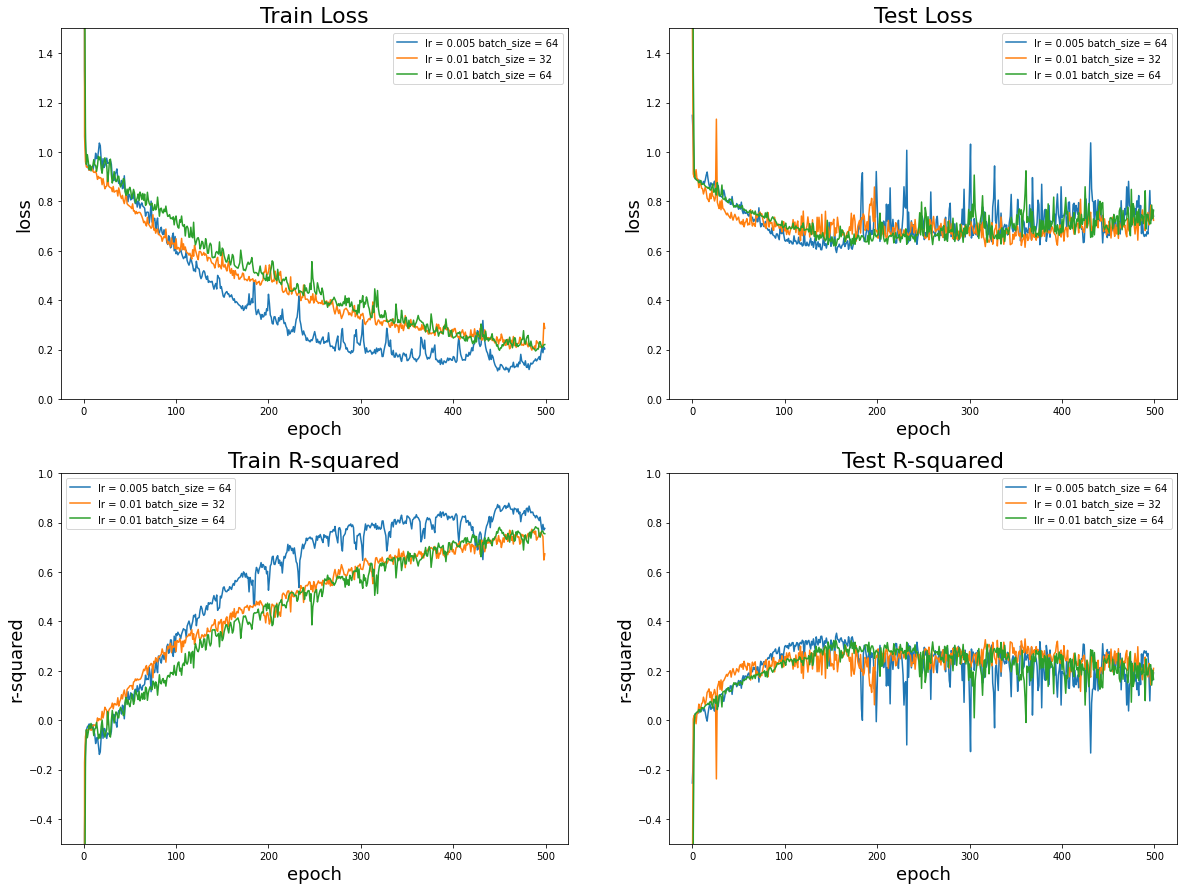

<Figure size 432x288 with 0 Axes>

In [23]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(20,15))
plt.figure()
ax1.set_title("Train Loss", fontsize=22)
ax1.plot(train_losses_all[0],label="lr = 0.005 batch_size = 64")
ax1.plot(train_losses_all[1],label="lr = 0.01 batch_size = 32")
ax1.plot(train_losses_all[2],label="lr = 0.01 batch_size = 64")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1.5])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[0],label="lr = 0.005 batch_size = 64")
ax2.plot(test_losses_all[1],label="lr = 0.01 batch_size = 32")
ax2.plot(test_losses_all[2],label="lr = 0.01 batch_size = 64")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 1.5])

ax3.set_title("Train R-squared", fontsize=22)
ax3.plot(train_accs_all[0],label="lr = 0.005 batch_size = 64")
ax3.plot(train_accs_all[1],label="lr = 0.01 batch_size = 32")
ax3.plot(train_accs_all[2],label="lr = 0.01 batch_size = 64")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-0.5,1])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[0],label="lr = 0.005 batch_size = 64")
ax4.plot(test_accs_all[1],label="lr = 0.01 batch_size = 32")
ax4.plot(test_accs_all[2],label="llr = 0.01 batch_size = 64")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-0.5,1])
plt.show()

### Model 1

{'batch_size': 64, 'epoch': 157, 'train_loss': 0.42482432561076205, 'test_loss': 0.5928871035575867, 'train_acc': 0.5275584569054539, 'test_acc': 0.35232362054644895}


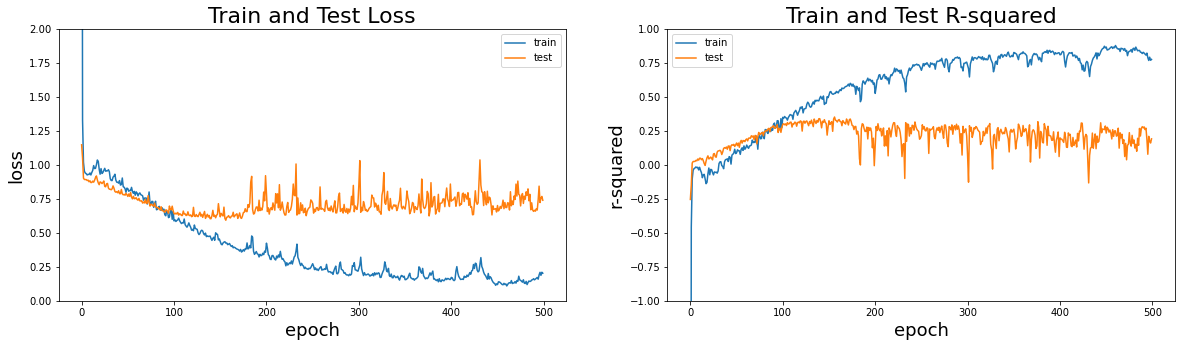

<Figure size 1440x360 with 0 Axes>

In [24]:
print(best_params_all[0])
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=22)
ax1.plot(train_losses_all[0],label="train")
ax1.plot(test_losses_all[0],label="test")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 2])

ax2.set_title("Train and Test R-squared", fontsize=22)
ax2.plot(train_accs_all[0],label="train")
ax2.plot(test_accs_all[0],label="test")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("r-squared", fontsize=18)
ax2.legend()
ax2.set_ylim([-1,1])

plt.show()

### Model 2

{'batch_size': 32, 'epoch': 361, 'train_loss': 0.2930557195511129, 'test_loss': 0.6141170859336853, 'train_acc': 0.6640827139550091, 'test_acc': 0.3291316538533938}


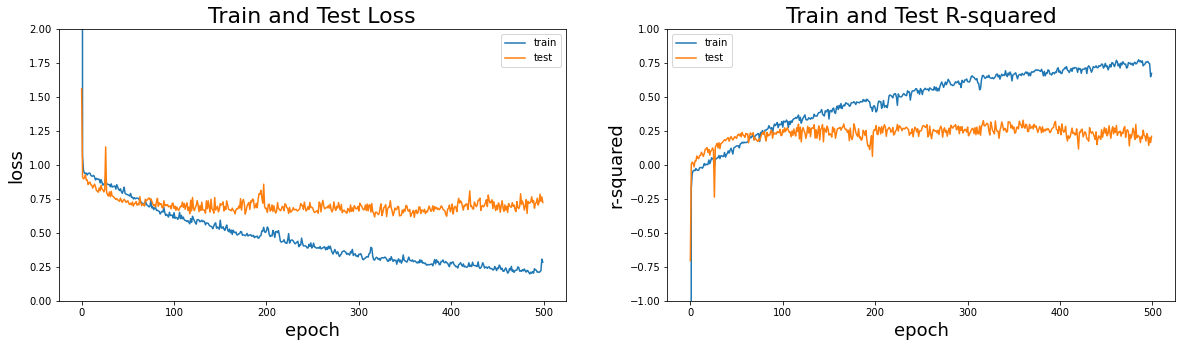

<Figure size 1440x360 with 0 Axes>

In [25]:
print(best_params_all[1])
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=22)
ax1.plot(train_losses_all[1],label="train")
ax1.plot(test_losses_all[1],label="test")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 2])

ax2.set_title("Train and Test R-squared", fontsize=22)
ax2.plot(train_accs_all[1],label="train")
ax2.plot(test_accs_all[1],label="test")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("r-squared", fontsize=18)
ax2.legend()
ax2.set_ylim([-1,1])

plt.show()

### Model 3

{'batch_size': 64, 'epoch': 156, 'train_loss': 0.5544062192025392, 'test_loss': 0.619585394859314, 'train_acc': 0.3860244289269473, 'test_acc': 0.32315802410156}


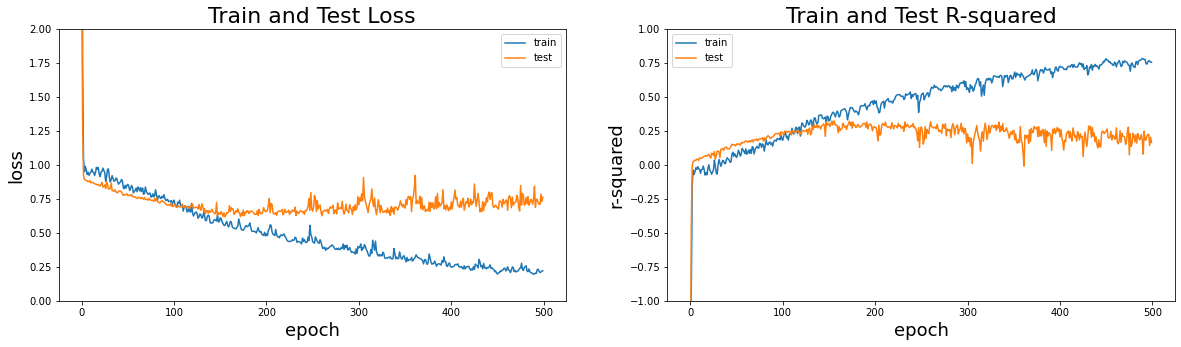

<Figure size 1440x360 with 0 Axes>

In [26]:
print(best_params_all[2])
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=22)
ax1.plot(train_losses_all[2],label="train")
ax1.plot(test_losses_all[2],label="test")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 2])

ax2.set_title("Train and Test R-squared", fontsize=22)
ax2.plot(train_accs_all[2],label="train")
ax2.plot(test_accs_all[2],label="test")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("r-squared", fontsize=18)
ax2.legend()
ax2.set_ylim([-1,1])

plt.show()

## 7. Results

In [27]:
model = GraphNeuralNetwork()
model.load_state_dict(torch.load('../../models/solubility_graph_model_0.pt')) # best model
model.eval()

test_loader = GraphDataLoader(test_dataset, batch_size=353, shuffle=False)

with torch.no_grad():
    for data in tqdm(test_loader):
        x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
        graph_predictions = model(x, edge_index, batch)

graph_predictions = np.array(graph_predictions)       

100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


In [28]:
print_evaluate(y_test, graph_predictions)

MAE: 0.6096902254688863
MSE: 0.5928870536687185
RMSE: 0.7699915932454837
R2 Square 0.35232362054644895 

